In [32]:
import os
import scipy.io
import numpy as np
import pandas as pd

import torch
import torchaudio
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import Wav2Vec2Processor, BertTokenizerFast

audio_paths = os.listdir('/home/rishab/machine_learning/IASNLP/project/GER')

word_dir = '/home/rishab/machine_learning/IASNLP/project/word'
word_paths = os.listdir('/home/rishab/machine_learning/IASNLP/project/word')

In [75]:
label_info_df = pd.read_csv('/home/rishab/machine_learning/IASNLP/project/labels/Complete-GER_train.xlsx - Sheet1.csv')
label_info_df = label_info_df.drop(label_info_df.columns[1], axis=1)

In [76]:
word_filename = word_paths[0]

# Load corresponding .mat file (assumes same name but .mat)
mat_filename = os.path.splitext(word_filename)[0] + '.mat'
mat_path = os.path.join(word_dir, mat_filename)
mat_data = scipy.io.loadmat(mat_path)

In [77]:
mat_data['words'].shape, mat_data['spurtWordTimes'].shape

((5, 1), (5, 2))

In [78]:
mat_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Jun  7 09:52:08 2018',
 '__version__': '1.0',
 '__globals__': [],
 'words': array([[array(['I'], dtype='<U1')],
        [array(['SAID'], dtype='<U4')],
        [array(['ALONE'], dtype='<U5')],
        [array(['NOT'], dtype='<U3')],
        [array(['GONE'], dtype='<U4')]], dtype=object),
 'spurtWordTimes': array([[0.03, 0.14],
        [0.14, 0.43],
        [0.43, 0.91],
        [0.97, 1.17],
        [1.24, 1.52]])}

In [36]:
class AudioTextProcessor:
    def __init__(self, wav2vec_model_name="facebook/wav2vec2-base-960h", 
                 bert_model_name="bert-base-uncased"):
        """
        Initialize processors for wav2vec 2.0 and BERT
        """
        self.wav2vec_processor = Wav2Vec2Processor.from_pretrained(wav2vec_model_name)
        self.bert_tokenizer = BertTokenizerFast.from_pretrained(bert_model_name)

    def segment_audio_by_word_times(self, waveform, sample_rate, spurt_word_times):
        """
        Segments waveform into chunks per word using start-end times.
        Returns list of tensors: [1, segment_len]
        """
        segments = []
        for start_time, end_time in spurt_word_times:
            start_sample = int(start_time * sample_rate)
            end_sample = int(end_time * sample_rate)

            # Clip to bounds
            start_sample = max(0, start_sample)
            end_sample = min(waveform.shape[1], end_sample)

            if end_sample > start_sample:
                segment = waveform[:, start_sample:end_sample]
            else:
                # Fallback: 50ms silence if invalid segment
                segment = torch.zeros((1, int(0.05 * sample_rate)))
            
            segments.append(segment)
        return segments
    
    def tokenize_wordwise(self, words):
        encoding = self.bert_tokenizer(
            words,
            is_split_into_words=True,
            return_tensors="pt",
            return_attention_mask=True,
            return_offsets_mapping=True,
            padding=False,
            truncation=False
        )

        word_to_token_indices = []
        word_ids = encoding.word_ids()

        current_word = None
        current_indices = []
        for i, wid in enumerate(word_ids):
            if wid is None:
                continue
            if wid != current_word:
                if current_indices:
                    word_to_token_indices.append(current_indices)
                current_indices = [i]
                current_word = wid
            else:
                current_indices.append(i)
        if current_indices:
            word_to_token_indices.append(current_indices)

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "word_ids": word_ids,
            "word_to_token_indices": word_to_token_indices,
            "original_words": words
        }
 


In [37]:
class AudioTextDataset(Dataset):
    def __init__(self, audio_dir, word_dir, label_df, wav2vecprocessor, audio_col_index=0, label_start_index=1):
        """
        Args:
            audio_dir (string): Path to the directory containing the audio files (GER).
            word_dir (string): Path to the directory containing the .mat files (word).
            label_df (pd.DataFrame): DataFrame containing the label information.
            audio_col_index (int): Index of the column containing the audio file name.
            transcript_col_index (int): Index of the column containing the transcript.
            label_start_index (int): Index of the starting column for the label information.
        """
        self.audio_dir = audio_dir
        self.all_audio_filenames = os.listdir(audio_dir)
        self.word_dir = word_dir
        self.label_df = label_df
        self.audio_paths = self.label_df.iloc[:, audio_col_index].tolist()

        # Filter audio files based on available labels
        # filtered_audio_paths = []
        # for filename in self.all_audio_filenames:
        #     if filename.strip('.wav') in self.audio_file_names_labeled:
        #         filtered_audio_paths.append(filename)

        # self.audio_paths = filtered_audio_paths
        self.label_start_index = label_start_index

        self.wav2vecprocessor = wav2vecprocessor
        self.target_sample_rate = 16000

        self.processor = AudioTextProcessor()

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        audio_file_name = self.audio_paths[idx] + '.wav'
        # transcript = self.transcripts[idx]

        # Construct the full path to the audio file
        audio_path = os.path.join(self.audio_dir, audio_file_name) 

        try:
            # Load audio file
            waveform, sample_rate = torchaudio.load(audio_path)
            
            # Resample to 16kHz
            if sample_rate != self.target_sample_rate:
                resampler = torchaudio.transforms.Resample(sample_rate, self.target_sample_rate)
                sample_rate = self.target_sample_rate
                waveform = resampler(waveform)
            
            processed_waveform = self.wav2vecprocessor(
                waveform.squeeze(0), 
                sampling_rate=self.target_sample_rate, 
                return_tensors="pt"
            ).input_values[0]  # shape: (samples,)

        except FileNotFoundError:
            print(f"Error: Audio file not found at {audio_path}")
            return None 

        # Determine the base name of the audio file to find the corresponding .mat file
        base_name = audio_file_name.strip('.wav')
        mat_file_path = os.path.join(self.word_dir, f"{base_name}.mat")

        words = []
        spurtWordTimes = []
        try:
            # Load .mat file
            word_data = scipy.io.loadmat(mat_file_path)
            transcript = [item[0].item() for row in word_data['words'] for item in row]
            spurtWordTimes = word_data['spurtWordTimes']
        except FileNotFoundError:
            print(f".mat file not found at {mat_file_path}")
            return None
        
        # label_idx = self.label_df.index[self.label_df['Audio Link'] == base_name].tolist()
        # if len(label_idx) >= 1:
        #     label_idx = label_idx[0]
        # else:
        #     print(base_name, "not found")
        #     print(label_idx, "label_idx is empty")
        #     return None 
        
        # Extrct label information
        # Get the last position of the label on the spreadsheet row
        label_idx = idx
        nan_positions = np.where(pd.isna(self.label_df.loc[label_idx]))[0] # np.where returns (array[.,.,.,],)
        if len(nan_positions) == 0:
            end_label_idx = self.label_df.shape[-1] - 1
        else:
            end_label_idx = nan_positions[0]

        label_info = self.label_df.iloc[label_idx, self.label_start_index:end_label_idx].values.astype(float).tolist()

        # Convert to integers or floats as needed
        labels = torch.tensor(label_info)

        tokenized_text = self.processor.tokenize_wordwise(transcript)

        return {
            'audio_waveform': processed_waveform, # List of numpy arrays
            'input_ids': tokenized_text['input_ids'],  # 1D tensor
            'text_attention_mask': tokenized_text['attention_mask'],
            'transcript': transcript,
            'labels': labels,
            'word_times': spurtWordTimes,
            'sample_rate': sample_rate
        }

In [38]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    # Remove None entries
    batch = [x for x in batch if x is not None]

    # AUDIO: Pad audio_waveforms
    audio_waveforms = [sample['audio_waveform'] for sample in batch]
    audio_waveforms_padded = pad_sequence(audio_waveforms, batch_first=True)  # shape: (B, T_max)

     # AUDIO: Create attention mask (1 for real, 0 for padding)
    lengths = torch.tensor([waveform.shape[0] for waveform in audio_waveforms])
    max_len = audio_waveforms_padded.shape[1]
    audio_attention_mask = torch.arange(max_len).expand(len(lengths), max_len) < lengths.unsqueeze(1)
    audio_attention_mask = audio_attention_mask.int()  # or .float() depending on downstream use

    # TEXT: Pad input_ids
    input_ids = [sample['input_ids'].squeeze(0) for sample in batch]  # remove batch dim if any
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=0)

    # LABELS: Stack (assumes same length)
    # labels = [sample['labels'] for sample in batch]
    # padded_labels = pad_sequence(labels, batch_first=True, padding_value=-1)
    # labels = torch.stack([sample['labels'] for sample in batch])

    # Collect non-padded items
    transcripts = [sample['transcript'] for sample in batch]
    word_times = [sample['word_times'] for sample in batch]
    sample_rates = [sample['sample_rate'] for sample in batch]

    return {
        'audio_waveform': audio_waveforms_padded,
        'audio_attention_mask': audio_attention_mask,
        'input_ids': input_ids_padded,
        # 'labels': padded_labels,
        'transcripts': transcripts,
        'word_times': word_times,
        'sample_rates': sample_rates
    }

In [39]:
# Data directory paths
ger_dir = './GER'
word_dir = './word'
train_audio_dir = os.path.join(ger_dir, 'train')
test_audio_dir = os.path.join(ger_dir, 'test')
label_spreadsheet_path = '/home/rishab/machine_learning/IASNLP/project/labels/Complete-GER_train.xlsx - Sheet1.csv' 

label_df = pd.read_csv(label_spreadsheet_path) 
# Drop the transcript column
label_df = label_df.drop(label_df.columns[1], axis=1)

wav2vec_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
train_dataset = AudioTextDataset(train_audio_dir, word_dir, label_df, wav2vec_processor)
train_dataloader = DataLoader(train_dataset, batch_size=8, collate_fn=collate_fn)

## Wav2Vec2

In [4]:
import torch
import torch.nn as nn
from transformers import Wav2Vec2Model

class Wav2Vec2(nn.Module):
    def __init__(self, model_name="facebook/wav2vec2-base", freeze_wav2vec=True):
        super().__init__()
        self.wav2vec = Wav2Vec2Model.from_pretrained(model_name)
        if freeze_wav2vec:
            for param in self.wav2vec.parameters():
                param.requires_grad = False

    def forward(self, input_values, attention_mask=None):
        output = self.wav2vec(input_values=input_values, attention_mask=attention_mask)
        representations = output.last_hidden_state
    
        return representations  

In [5]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
model = Wav2Vec2().to(device)
frame_length = 0.02 # in seconds

/home/rishab/miniconda3/envs/iasnlp/lib/python3.10/site-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [ ]:
word_segmented_audio_embeddings = []
label_info = []
for i, batch in enumerate(train_dataloader):
    audio_input = batch['audio_waveform'].to(device)
    audio_attention_mask = batch['audio_attention_mask'].to(device)
    # label_info.extend([*batch['labels']])

    representations = model(audio_input, audio_attention_mask)
    word_indices_batch = [(word_time / 0.02).astype(int) for word_time in batch['word_times']]
    
    for idx, word_indices in enumerate(word_indices_batch):
        representations_list = []

        # Divide the output representations by words
        for i, (start, end) in enumerate(word_indices):
            # Output of representations[batch_idx, start:end, :] is going to be (number of frames for the word, representation_dim)
            word_segment = representations[idx, start:end, :].mean(dim=0) # Take the mean of the n frames for that word
            representations_list.append(word_segment)

        # print(len(representations_list))
        word_segmented_audio_embeddings.append(representations_list)

embeddings_dataset = {'speech_embeddings': word_segmented_audio_embeddings, 'labels': [], 'transcript': []}
torch.save(embeddings_dataset, "./wav2vec2_embeddings/wav2vec2_embeddings_labels.pt")

In [50]:
word_dir = './word'
label_df = pd.read_csv(label_spreadsheet_path) 
# Drop the transcript column
label_df = label_df.drop(label_df.columns[1], axis=1)

label_start_col_index = 1
label_list = []
transcript_list = []

for label_idx in range(len(label_df)):
    # Determine the base name of the audio file to find the corresponding .mat file
    base_name = label_df.loc[label_idx]['Audio Link']
    mat_file_path = os.path.join(word_dir, f"{base_name}.mat")

    words = []
    spurtWordTimes = []
    try:
        # Load .mat file
        word_data = scipy.io.loadmat(mat_file_path)
        transcript = [item[0].item() for row in word_data['words'] for item in row]
        # spurtWordTimes = word_data['spurtWordTimes']
    except FileNotFoundError:
        print(f".mat file not found at {mat_file_path}")
        continue

    transcript_list.append(transcript)

    nan_positions = np.where(pd.isna(label_df.loc[label_idx]))[0] # np.where returns (array[.,.,.,],)
    if len(nan_positions) == 0:
        end_label_col_idx = label_df.shape[-1] - 1
    else:
        end_label_col_idx = nan_positions[0]

        # print(label_start_col_index, end_label_col_idx)

    label_info = label_df.iloc[label_idx, label_start_col_index:end_label_col_idx].values.astype(float).tolist()

    # Convert to integers or floats as needed
    labels = torch.tensor(label_info)
    label_list.append(labels)   

embeddings_labels_dict = torch.load(
    './wav2vec2_embeddings/wav2vec2_embeddings_labels.pt', 
    map_location=torch.device('cpu')
)
embeddings_labels_dict['labels'] = label_list
embeddings_labels_dict['transcript'] = transcript_list
torch.save(embeddings_labels_dict, './wav2vec2_embeddings/wav2vec2_embeddings_labels.pt')

.mat file not found at ./word/ISLE_SESS0006_BLOCKE_03_sprt1.mat
.mat file not found at ./word/ISLE_SESS0012_BLOCKD01_13_sprt1.mat
.mat file not found at ./word/ISLE_SESS0181_BLOCKF_07_sprt1.mat
.mat file not found at ./word/ISLE_SESS0182_BLOCKF_05_sprt1.mat


## Stress Classifier using Speech

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

class Wav2Vec2EmbeddingDataset(Dataset):
    def __init__(self, pt_file_path):
        data = torch.load(pt_file_path)
        self.embeddings = [torch.stack(embed_seq) for embed_seq in data['speech_embeddings']]
        self.labels = data['labels']

        assert len(self.embeddings) == len(self.labels), "Mismatch in number of sequences and labels"

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        # print("Embeddings", self.embeddings[idx].shape)
        # print("Labels", self.labels[idx].shape)
        return self.embeddings[idx], self.labels[idx]

In [3]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split, DataLoader

def collate_fn(batch):
    try:
        batch = [x for x in batch if (x[0].shape[0] == x[1].shape[0])] 

        embeddings, labels = zip(*batch) 

        # Pad embeddings and labels to the same length within the batch
        padded_embeddings = pad_sequence(embeddings, batch_first=True)
        padded_labels = pad_sequence(labels, batch_first=True, padding_value=-1).long()

        # Create a mask where label != -1
        mask = (padded_labels != -1).long()

    except ValueError:
        # Happens if batch is empty or items aren't unpackable
        return torch.tensor([]), torch.tensor([]), torch.tensor([])


    return padded_embeddings, padded_labels, mask

full_dataset = Wav2Vec2EmbeddingDataset('./wav2vec2_embeddings/wav2vec2_embeddings_labels.pt')

# Define split ratio
train_ratio = 0.8  # 80% train, 20% test
train_size = int(train_ratio * len(full_dataset))
test_size = len(full_dataset) - train_size

# Set a fixed seed
seed = 42
generator = torch.Generator().manual_seed(seed)

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size], generator=generator)

# Create DataLoaders
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

### MLP Classifier

In [4]:
class WordStressMLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims = [512, 256, 128, 64], dropout_prob=0.2):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(hidden_dims[1], hidden_dims[2]),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(hidden_dims[2], hidden_dims[3]),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(hidden_dims[3], 2)
        )


    def forward(self, x):  # x: (batch_size, seq_len, input_dim)
        return self.classifier(x)  # logits: (batch_size, seq_len, 2)

In [7]:
# Instantiate model
input_dim = 768
MLP_model = WordStressMLPClassifier(input_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MLP_model =MLP_model.to(device)

epochs = 200
learning_rate = 3e-4
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.Adam(MLP_model.parameters(), lr=learning_rate)

In [6]:
import os
import csv
from tqdm import tqdm

results_dir = './results/MLP'
csv_dir = './results/MLP/loss'
weights_dir = './results/MLP/weights'
os.makedirs(results_dir, exist_ok=True)
os.makedirs(weights_dir, exist_ok=True)
os.makedirs(csv_dir, exist_ok=True)

csv_path = os.path.join(csv_dir, f'losses_MLP_batch_size_{batch_size}.csv')

# Write CSV header once (only if file doesn't exist)
with open(csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch', 'loss', 'accuracy', 'test_accuracy'])

max_test_accuracy = -1
for epoch in range(epochs):
    MLP_model.train()

    total_loss = 0
    total_correct = 0
    total_tokens = 0

    num_batches = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in progress_bar:
        inputs, labels, mask = batch

        # Skip empty batches (e.g., returned by collate_fn)
        if inputs.nelement() == 0 or labels.nelement() == 0:
            continue

        # print("Inputs Shape ->", inputs.shape)
        inputs = inputs.to(device)          # (B, T, 768)
        labels = labels.to(device)          # (B, T)
        mask = mask.to(device)            # (B, T)

        optimizer.zero_grad()
        logits = MLP_model(inputs)              # (B, T, 2)
        # print("Logits Shape ->", logits.shape)
        # print("Labels Shape ->", labels.shape)

        # Reshape for loss: (B*T, 2), (B*T,)
        loss = criterion(logits.view(-1, 2), labels.view(-1).long())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        # Accuracy computation (masked)
        preds = logits.argmax(dim=-1)       # (B, T)
        correct = ((preds == labels) & mask).sum().item()
        total_correct += correct
        total_tokens += mask.sum().item()
    
        # Update tqdm with current loss
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / num_batches
    accuracy = total_correct / total_tokens
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}")

    MLP_model.eval()
    test_correct = 0
    test_tokens = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels, mask = batch

            if inputs.nelement() == 0 or labels.nelement() == 0:
                continue

            inputs = inputs.to(device)
            labels = labels.to(device)
            mask = mask.to(device)

            logits = MLP_model(inputs)

            preds = logits.argmax(dim=-1)
            correct = ((preds == labels) & mask).sum().item()
            test_correct += correct
            test_tokens += mask.sum().item()

        test_accuracy = test_correct / test_tokens

        if test_accuracy > max_test_accuracy:
            max_test_accuracy = test_accuracy
            best_ckpt_path = os.path.join(weights_dir, 'best_model.pt')
            torch.save(MLP_model.state_dict(), best_ckpt_path)
            print(f"New best model saved with test accuracy: {max_test_accuracy:.4f}")

            best_accuracy_epoch = epoch+1
            
        max_test_accuracy = max(max_test_accuracy, test_accuracy)
        print(f"Epoch {epoch+1}: Test Accuracy = {test_accuracy:.4f}")

     # Save to CSV
    with open(csv_path, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch+1, avg_loss, accuracy, test_accuracy])

    # Save checkpoint every 50 epochs
    if (epoch + 1) % 50 == 0:
        ckpt_path = os.path.join(weights_dir, f"model_epoch_{epoch+1}.pt")
        torch.save(MLP_model.state_dict(), ckpt_path)

Epoch 1/200: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it, loss=0.699]


Epoch 1: Loss = 0.7099, Accuracy = 0.2465
New best model saved with test accuracy: 0.4465
Epoch 1: Test Accuracy = 0.4465


Epoch 2/200: 100%|██████████| 4/4 [00:00<00:00, 23.80it/s, loss=0.678]


Epoch 2: Loss = 0.6861, Accuracy = 0.5905
New best model saved with test accuracy: 0.7445
Epoch 2: Test Accuracy = 0.7445


Epoch 3/200: 100%|██████████| 4/4 [00:00<00:00, 22.20it/s, loss=0.633]


Epoch 3: Loss = 0.6492, Accuracy = 0.7510
Epoch 3: Test Accuracy = 0.7445


Epoch 4/200: 100%|██████████| 4/4 [00:00<00:00, 20.95it/s, loss=0.557]


Epoch 4: Loss = 0.5896, Accuracy = 0.7541
Epoch 4: Test Accuracy = 0.7445


Epoch 5/200: 100%|██████████| 4/4 [00:00<00:00, 22.50it/s, loss=0.671]


Epoch 5: Loss = 0.5920, Accuracy = 0.7542
Epoch 5: Test Accuracy = 0.7445


Epoch 6/200: 100%|██████████| 4/4 [00:00<00:00, 22.94it/s, loss=0.605]


Epoch 6: Loss = 0.5837, Accuracy = 0.7542
Epoch 6: Test Accuracy = 0.7445


Epoch 7/200: 100%|██████████| 4/4 [00:00<00:00, 22.92it/s, loss=0.58] 


Epoch 7: Loss = 0.5659, Accuracy = 0.7542
Epoch 7: Test Accuracy = 0.7445


Epoch 8/200: 100%|██████████| 4/4 [00:00<00:00, 23.77it/s, loss=0.547]


Epoch 8: Loss = 0.5574, Accuracy = 0.7542
Epoch 8: Test Accuracy = 0.7445


Epoch 9/200: 100%|██████████| 4/4 [00:00<00:00, 24.65it/s, loss=0.543]


Epoch 9: Loss = 0.5588, Accuracy = 0.7542
Epoch 9: Test Accuracy = 0.7445


Epoch 10/200: 100%|██████████| 4/4 [00:00<00:00, 24.27it/s, loss=0.555]


Epoch 10: Loss = 0.5582, Accuracy = 0.7542
Epoch 10: Test Accuracy = 0.7445


Epoch 11/200: 100%|██████████| 4/4 [00:00<00:00, 24.52it/s, loss=0.543]


Epoch 11: Loss = 0.5537, Accuracy = 0.7542
Epoch 11: Test Accuracy = 0.7445


Epoch 12/200: 100%|██████████| 4/4 [00:00<00:00, 24.28it/s, loss=0.537]


Epoch 12: Loss = 0.5525, Accuracy = 0.7542
Epoch 12: Test Accuracy = 0.7445


Epoch 13/200: 100%|██████████| 4/4 [00:00<00:00, 18.07it/s, loss=0.542]


Epoch 13: Loss = 0.5519, Accuracy = 0.7542
Epoch 13: Test Accuracy = 0.7445


Epoch 14/200: 100%|██████████| 4/4 [00:00<00:00, 18.17it/s, loss=0.597]


Epoch 14: Loss = 0.5606, Accuracy = 0.7542
Epoch 14: Test Accuracy = 0.7445


Epoch 15/200: 100%|██████████| 4/4 [00:00<00:00, 19.98it/s, loss=0.548]


Epoch 15: Loss = 0.5508, Accuracy = 0.7542
Epoch 15: Test Accuracy = 0.7445


Epoch 16/200: 100%|██████████| 4/4 [00:00<00:00, 23.48it/s, loss=0.553]


Epoch 16: Loss = 0.5498, Accuracy = 0.7542
Epoch 16: Test Accuracy = 0.7445


Epoch 17/200: 100%|██████████| 4/4 [00:00<00:00, 23.19it/s, loss=0.52] 


Epoch 17: Loss = 0.5402, Accuracy = 0.7542
Epoch 17: Test Accuracy = 0.7445


Epoch 18/200: 100%|██████████| 4/4 [00:00<00:00, 24.80it/s, loss=0.549]


Epoch 18: Loss = 0.5446, Accuracy = 0.7542
Epoch 18: Test Accuracy = 0.7445


Epoch 19/200: 100%|██████████| 4/4 [00:00<00:00, 25.66it/s, loss=0.484]


Epoch 19: Loss = 0.5271, Accuracy = 0.7542
Epoch 19: Test Accuracy = 0.7445


Epoch 20/200: 100%|██████████| 4/4 [00:00<00:00, 27.09it/s, loss=0.54] 


Epoch 20: Loss = 0.5384, Accuracy = 0.7542
Epoch 20: Test Accuracy = 0.7445


Epoch 21/200: 100%|██████████| 4/4 [00:00<00:00, 25.21it/s, loss=0.506]


Epoch 21: Loss = 0.5275, Accuracy = 0.7542
Epoch 21: Test Accuracy = 0.7445


Epoch 22/200: 100%|██████████| 4/4 [00:00<00:00, 29.03it/s, loss=0.524]


Epoch 22: Loss = 0.5278, Accuracy = 0.7542
Epoch 22: Test Accuracy = 0.7445


Epoch 23/200: 100%|██████████| 4/4 [00:00<00:00, 25.12it/s, loss=0.519]


Epoch 23: Loss = 0.5251, Accuracy = 0.7542
Epoch 23: Test Accuracy = 0.7445


Epoch 24/200: 100%|██████████| 4/4 [00:00<00:00, 27.27it/s, loss=0.54] 


Epoch 24: Loss = 0.5260, Accuracy = 0.7542
Epoch 24: Test Accuracy = 0.7445


Epoch 25/200: 100%|██████████| 4/4 [00:00<00:00, 28.05it/s, loss=0.513]


Epoch 25: Loss = 0.5172, Accuracy = 0.7542
Epoch 25: Test Accuracy = 0.7445


Epoch 26/200: 100%|██████████| 4/4 [00:00<00:00, 28.16it/s, loss=0.526]


Epoch 26: Loss = 0.5174, Accuracy = 0.7542
Epoch 26: Test Accuracy = 0.7445


Epoch 27/200: 100%|██████████| 4/4 [00:00<00:00, 27.28it/s, loss=0.549]


Epoch 27: Loss = 0.5215, Accuracy = 0.7542
Epoch 27: Test Accuracy = 0.7445


Epoch 28/200: 100%|██████████| 4/4 [00:00<00:00, 26.85it/s, loss=0.504]


Epoch 28: Loss = 0.5080, Accuracy = 0.7542
Epoch 28: Test Accuracy = 0.7445


Epoch 29/200: 100%|██████████| 4/4 [00:00<00:00, 24.64it/s, loss=0.454]


Epoch 29: Loss = 0.4934, Accuracy = 0.7542
Epoch 29: Test Accuracy = 0.7445


Epoch 30/200: 100%|██████████| 4/4 [00:00<00:00, 26.67it/s, loss=0.512]


Epoch 30: Loss = 0.5065, Accuracy = 0.7542
Epoch 30: Test Accuracy = 0.7445


Epoch 31/200: 100%|██████████| 4/4 [00:00<00:00, 27.63it/s, loss=0.548]


Epoch 31: Loss = 0.5135, Accuracy = 0.7542
Epoch 31: Test Accuracy = 0.7445


Epoch 32/200: 100%|██████████| 4/4 [00:00<00:00, 28.04it/s, loss=0.564]


Epoch 32: Loss = 0.5148, Accuracy = 0.7542
Epoch 32: Test Accuracy = 0.7445


Epoch 33/200: 100%|██████████| 4/4 [00:00<00:00, 26.83it/s, loss=0.495]


Epoch 33: Loss = 0.4978, Accuracy = 0.7539
Epoch 33: Test Accuracy = 0.7445


Epoch 34/200: 100%|██████████| 4/4 [00:00<00:00, 26.86it/s, loss=0.546]


Epoch 34: Loss = 0.5084, Accuracy = 0.7541
Epoch 34: Test Accuracy = 0.7445


Epoch 35/200: 100%|██████████| 4/4 [00:00<00:00, 25.78it/s, loss=0.49]


Epoch 35: Loss = 0.4943, Accuracy = 0.7542
Epoch 35: Test Accuracy = 0.7445


Epoch 36/200: 100%|██████████| 4/4 [00:00<00:00, 24.97it/s, loss=0.428]


Epoch 36: Loss = 0.4792, Accuracy = 0.7545
Epoch 36: Test Accuracy = 0.7445


Epoch 37/200: 100%|██████████| 4/4 [00:00<00:00, 27.78it/s, loss=0.509]


Epoch 37: Loss = 0.4956, Accuracy = 0.7543
Epoch 37: Test Accuracy = 0.7445


Epoch 38/200: 100%|██████████| 4/4 [00:00<00:00, 28.54it/s, loss=0.485]


Epoch 38: Loss = 0.4878, Accuracy = 0.7551
Epoch 38: Test Accuracy = 0.7445


Epoch 39/200: 100%|██████████| 4/4 [00:00<00:00, 27.26it/s, loss=0.503]


Epoch 39: Loss = 0.4903, Accuracy = 0.7547
Epoch 39: Test Accuracy = 0.7445


Epoch 40/200: 100%|██████████| 4/4 [00:00<00:00, 24.83it/s, loss=0.53] 


Epoch 40: Loss = 0.4959, Accuracy = 0.7548
New best model saved with test accuracy: 0.7461
Epoch 40: Test Accuracy = 0.7461


Epoch 41/200: 100%|██████████| 4/4 [00:00<00:00, 24.87it/s, loss=0.487]


Epoch 41: Loss = 0.4854, Accuracy = 0.7559
Epoch 41: Test Accuracy = 0.7449


Epoch 42/200: 100%|██████████| 4/4 [00:00<00:00, 23.15it/s, loss=0.453]


Epoch 42: Loss = 0.4761, Accuracy = 0.7553
New best model saved with test accuracy: 0.7485
Epoch 42: Test Accuracy = 0.7485


Epoch 43/200: 100%|██████████| 4/4 [00:00<00:00, 25.19it/s, loss=0.47] 


Epoch 43: Loss = 0.4806, Accuracy = 0.7597
New best model saved with test accuracy: 0.7501
Epoch 43: Test Accuracy = 0.7501


Epoch 44/200: 100%|██████████| 4/4 [00:00<00:00, 26.15it/s, loss=0.478]


Epoch 44: Loss = 0.4789, Accuracy = 0.7578
New best model saved with test accuracy: 0.7517
Epoch 44: Test Accuracy = 0.7517


Epoch 45/200: 100%|██████████| 4/4 [00:00<00:00, 26.96it/s, loss=0.47] 


Epoch 45: Loss = 0.4755, Accuracy = 0.7603
New best model saved with test accuracy: 0.7537
Epoch 45: Test Accuracy = 0.7537


Epoch 46/200: 100%|██████████| 4/4 [00:00<00:00, 27.19it/s, loss=0.504]


Epoch 46: Loss = 0.4838, Accuracy = 0.7580
Epoch 46: Test Accuracy = 0.7517


Epoch 47/200: 100%|██████████| 4/4 [00:00<00:00, 27.68it/s, loss=0.466]


Epoch 47: Loss = 0.4712, Accuracy = 0.7619
New best model saved with test accuracy: 0.7541
Epoch 47: Test Accuracy = 0.7541


Epoch 48/200: 100%|██████████| 4/4 [00:00<00:00, 26.67it/s, loss=0.454]


Epoch 48: Loss = 0.4691, Accuracy = 0.7643
New best model saved with test accuracy: 0.7565
Epoch 48: Test Accuracy = 0.7565


Epoch 49/200: 100%|██████████| 4/4 [00:00<00:00, 27.33it/s, loss=0.521]


Epoch 49: Loss = 0.4830, Accuracy = 0.7680
New best model saved with test accuracy: 0.7569
Epoch 49: Test Accuracy = 0.7569


Epoch 50/200: 100%|██████████| 4/4 [00:00<00:00, 27.00it/s, loss=0.497]


Epoch 50: Loss = 0.4754, Accuracy = 0.7639
New best model saved with test accuracy: 0.7621
Epoch 50: Test Accuracy = 0.7621


Epoch 51/200: 100%|██████████| 4/4 [00:00<00:00, 27.21it/s, loss=0.478]


Epoch 51: Loss = 0.4731, Accuracy = 0.7717
Epoch 51: Test Accuracy = 0.7529


Epoch 52/200: 100%|██████████| 4/4 [00:00<00:00, 24.98it/s, loss=0.464]


Epoch 52: Loss = 0.4690, Accuracy = 0.7631
Epoch 52: Test Accuracy = 0.7541


Epoch 53/200: 100%|██████████| 4/4 [00:00<00:00, 28.37it/s, loss=0.463]


Epoch 53: Loss = 0.4670, Accuracy = 0.7764
Epoch 53: Test Accuracy = 0.7537


Epoch 54/200: 100%|██████████| 4/4 [00:00<00:00, 28.05it/s, loss=0.436]


Epoch 54: Loss = 0.4574, Accuracy = 0.7705
Epoch 54: Test Accuracy = 0.7613


Epoch 55/200: 100%|██████████| 4/4 [00:00<00:00, 28.92it/s, loss=0.438]


Epoch 55: Loss = 0.4559, Accuracy = 0.7752
Epoch 55: Test Accuracy = 0.7585


Epoch 56/200: 100%|██████████| 4/4 [00:00<00:00, 26.66it/s, loss=0.497]


Epoch 56: Loss = 0.4700, Accuracy = 0.7730
Epoch 56: Test Accuracy = 0.7525


Epoch 57/200: 100%|██████████| 4/4 [00:00<00:00, 28.53it/s, loss=0.426]


Epoch 57: Loss = 0.4509, Accuracy = 0.7780
Epoch 57: Test Accuracy = 0.7565


Epoch 58/200: 100%|██████████| 4/4 [00:00<00:00, 29.06it/s, loss=0.453]


Epoch 58: Loss = 0.4583, Accuracy = 0.7710
Epoch 58: Test Accuracy = 0.7569


Epoch 59/200: 100%|██████████| 4/4 [00:00<00:00, 22.28it/s, loss=0.458]


Epoch 59: Loss = 0.4585, Accuracy = 0.7772
Epoch 59: Test Accuracy = 0.7597


Epoch 60/200: 100%|██████████| 4/4 [00:00<00:00, 27.63it/s, loss=0.463]


Epoch 60: Loss = 0.4554, Accuracy = 0.7772
Epoch 60: Test Accuracy = 0.7569


Epoch 61/200: 100%|██████████| 4/4 [00:00<00:00, 26.31it/s, loss=0.452]


Epoch 61: Loss = 0.4520, Accuracy = 0.7744
Epoch 61: Test Accuracy = 0.7561


Epoch 62/200: 100%|██████████| 4/4 [00:00<00:00, 25.98it/s, loss=0.446]


Epoch 62: Loss = 0.4485, Accuracy = 0.7851
New best model saved with test accuracy: 0.7633
Epoch 62: Test Accuracy = 0.7633


Epoch 63/200: 100%|██████████| 4/4 [00:00<00:00, 26.04it/s, loss=0.411]


Epoch 63: Loss = 0.4375, Accuracy = 0.7844
Epoch 63: Test Accuracy = 0.7557


Epoch 64/200: 100%|██████████| 4/4 [00:00<00:00, 27.34it/s, loss=0.439]


Epoch 64: Loss = 0.4448, Accuracy = 0.7840
Epoch 64: Test Accuracy = 0.7569


Epoch 65/200: 100%|██████████| 4/4 [00:00<00:00, 27.42it/s, loss=0.448]


Epoch 65: Loss = 0.4471, Accuracy = 0.7897
Epoch 65: Test Accuracy = 0.7613


Epoch 66/200: 100%|██████████| 4/4 [00:00<00:00, 23.93it/s, loss=0.492]

Epoch 66: Loss = 0.4559, Accuracy = 0.7905


Epoch 66: Test Accuracy = 0.7553


Epoch 67/200: 100%|██████████| 4/4 [00:00<00:00, 20.75it/s, loss=0.361]

Epoch 67: Loss = 0.4208, Accuracy = 0.7875


Epoch 67: Test Accuracy = 0.7605


Epoch 68/200: 100%|██████████| 4/4 [00:00<00:00, 24.92it/s, loss=0.421]


Epoch 68: Loss = 0.4377, Accuracy = 0.7885
Epoch 68: Test Accuracy = 0.7557


Epoch 69/200: 100%|██████████| 4/4 [00:00<00:00, 25.11it/s, loss=0.45] 


Epoch 69: Loss = 0.4400, Accuracy = 0.7887
Epoch 69: Test Accuracy = 0.7501


Epoch 70/200: 100%|██████████| 4/4 [00:00<00:00, 25.61it/s, loss=0.423]


Epoch 70: Loss = 0.4324, Accuracy = 0.7936
Epoch 70: Test Accuracy = 0.7565


Epoch 71/200: 100%|██████████| 4/4 [00:00<00:00, 27.56it/s, loss=0.471]


Epoch 71: Loss = 0.4436, Accuracy = 0.7986
Epoch 71: Test Accuracy = 0.7629


Epoch 72/200: 100%|██████████| 4/4 [00:00<00:00, 28.03it/s, loss=0.369]


Epoch 72: Loss = 0.4170, Accuracy = 0.7968
Epoch 72: Test Accuracy = 0.7629


Epoch 73/200: 100%|██████████| 4/4 [00:00<00:00, 28.78it/s, loss=0.432]


Epoch 73: Loss = 0.4318, Accuracy = 0.7935
Epoch 73: Test Accuracy = 0.7577


Epoch 74/200: 100%|██████████| 4/4 [00:00<00:00, 24.10it/s, loss=0.477]


Epoch 74: Loss = 0.4396, Accuracy = 0.7993
New best model saved with test accuracy: 0.7657
Epoch 74: Test Accuracy = 0.7657


Epoch 75/200: 100%|██████████| 4/4 [00:00<00:00, 27.82it/s, loss=0.431]


Epoch 75: Loss = 0.4276, Accuracy = 0.8033
Epoch 75: Test Accuracy = 0.7613


Epoch 76/200: 100%|██████████| 4/4 [00:00<00:00, 25.84it/s, loss=0.431]


Epoch 76: Loss = 0.4257, Accuracy = 0.8006
Epoch 76: Test Accuracy = 0.7641


Epoch 77/200: 100%|██████████| 4/4 [00:00<00:00, 26.73it/s, loss=0.384]


Epoch 77: Loss = 0.4129, Accuracy = 0.8037
Epoch 77: Test Accuracy = 0.7597


Epoch 78/200: 100%|██████████| 4/4 [00:00<00:00, 28.34it/s, loss=0.391]


Epoch 78: Loss = 0.4135, Accuracy = 0.8046
Epoch 78: Test Accuracy = 0.7621


Epoch 79/200: 100%|██████████| 4/4 [00:00<00:00, 27.99it/s, loss=0.422]


Epoch 79: Loss = 0.4176, Accuracy = 0.8036
Epoch 79: Test Accuracy = 0.7573


Epoch 80/200: 100%|██████████| 4/4 [00:00<00:00, 27.22it/s, loss=0.469]


Epoch 80: Loss = 0.4306, Accuracy = 0.8050
Epoch 80: Test Accuracy = 0.7493


Epoch 81/200: 100%|██████████| 4/4 [00:00<00:00, 28.33it/s, loss=0.478]


Epoch 81: Loss = 0.4339, Accuracy = 0.8020
Epoch 81: Test Accuracy = 0.7577


Epoch 82/200: 100%|██████████| 4/4 [00:00<00:00, 22.41it/s, loss=0.462]

Epoch 82: Loss = 0.4301, Accuracy = 0.8054


Epoch 82: Test Accuracy = 0.7637


Epoch 83/200: 100%|██████████| 4/4 [00:00<00:00, 27.37it/s, loss=0.395]


Epoch 83: Loss = 0.4139, Accuracy = 0.8054
Epoch 83: Test Accuracy = 0.7593


Epoch 84/200: 100%|██████████| 4/4 [00:00<00:00, 26.41it/s, loss=0.391]


Epoch 84: Loss = 0.4085, Accuracy = 0.8075
Epoch 84: Test Accuracy = 0.7589


Epoch 85/200: 100%|██████████| 4/4 [00:00<00:00, 26.51it/s, loss=0.461]


Epoch 85: Loss = 0.4247, Accuracy = 0.8089
New best model saved with test accuracy: 0.7669
Epoch 85: Test Accuracy = 0.7669


Epoch 86/200: 100%|██████████| 4/4 [00:00<00:00, 26.99it/s, loss=0.431]


Epoch 86: Loss = 0.4159, Accuracy = 0.8089
Epoch 86: Test Accuracy = 0.7601


Epoch 87/200: 100%|██████████| 4/4 [00:00<00:00, 27.51it/s, loss=0.414]


Epoch 87: Loss = 0.4080, Accuracy = 0.8093
Epoch 87: Test Accuracy = 0.7629


Epoch 88/200: 100%|██████████| 4/4 [00:00<00:00, 25.44it/s, loss=0.388]


Epoch 88: Loss = 0.4027, Accuracy = 0.8115
Epoch 88: Test Accuracy = 0.7569


Epoch 89/200: 100%|██████████| 4/4 [00:00<00:00, 26.80it/s, loss=0.41] 


Epoch 89: Loss = 0.4043, Accuracy = 0.8170
Epoch 89: Test Accuracy = 0.7605


Epoch 90/200: 100%|██████████| 4/4 [00:00<00:00, 28.39it/s, loss=0.367]


Epoch 90: Loss = 0.3915, Accuracy = 0.8198
Epoch 90: Test Accuracy = 0.7637


Epoch 91/200: 100%|██████████| 4/4 [00:00<00:00, 25.41it/s, loss=0.419]


Epoch 91: Loss = 0.4015, Accuracy = 0.8160
Epoch 91: Test Accuracy = 0.7593


Epoch 92/200: 100%|██████████| 4/4 [00:00<00:00, 26.65it/s, loss=0.415]


Epoch 92: Loss = 0.3999, Accuracy = 0.8178
Epoch 92: Test Accuracy = 0.7345


Epoch 93/200: 100%|██████████| 4/4 [00:00<00:00, 27.34it/s, loss=0.402]


Epoch 93: Loss = 0.4053, Accuracy = 0.8110
Epoch 93: Test Accuracy = 0.7529


Epoch 94/200: 100%|██████████| 4/4 [00:00<00:00, 24.87it/s, loss=0.334]


Epoch 94: Loss = 0.3871, Accuracy = 0.8092
New best model saved with test accuracy: 0.7677
Epoch 94: Test Accuracy = 0.7677


Epoch 95/200: 100%|██████████| 4/4 [00:00<00:00, 24.90it/s, loss=0.372]

Epoch 95: Loss = 0.3953, Accuracy = 0.8179


Epoch 95: Test Accuracy = 0.7661


Epoch 96/200: 100%|██████████| 4/4 [00:00<00:00, 23.25it/s, loss=0.462]

Epoch 96: Loss = 0.4123, Accuracy = 0.8172


Epoch 96: Test Accuracy = 0.7597


Epoch 97/200: 100%|██████████| 4/4 [00:00<00:00, 26.12it/s, loss=0.481]


Epoch 97: Loss = 0.4121, Accuracy = 0.8245
Epoch 97: Test Accuracy = 0.7665


Epoch 98/200: 100%|██████████| 4/4 [00:00<00:00, 28.17it/s, loss=0.395]


Epoch 98: Loss = 0.3913, Accuracy = 0.8221
Epoch 98: Test Accuracy = 0.7613


Epoch 99/200: 100%|██████████| 4/4 [00:00<00:00, 29.17it/s, loss=0.35]


Epoch 99: Loss = 0.3819, Accuracy = 0.8186
Epoch 99: Test Accuracy = 0.7529


Epoch 100/200: 100%|██████████| 4/4 [00:00<00:00, 27.13it/s, loss=0.361]


Epoch 100: Loss = 0.3806, Accuracy = 0.8254
Epoch 100: Test Accuracy = 0.7649


Epoch 101/200: 100%|██████████| 4/4 [00:00<00:00, 27.79it/s, loss=0.411]


Epoch 101: Loss = 0.3916, Accuracy = 0.8237
Epoch 101: Test Accuracy = 0.7677


Epoch 102/200: 100%|██████████| 4/4 [00:00<00:00, 23.41it/s, loss=0.358]

Epoch 102: Loss = 0.3756, Accuracy = 0.8297


Epoch 102: Test Accuracy = 0.7597


Epoch 103/200: 100%|██████████| 4/4 [00:00<00:00, 28.74it/s, loss=0.363]


Epoch 103: Loss = 0.3746, Accuracy = 0.8295
Epoch 103: Test Accuracy = 0.7593


Epoch 104/200: 100%|██████████| 4/4 [00:00<00:00, 25.74it/s, loss=0.407]


Epoch 104: Loss = 0.3826, Accuracy = 0.8336
Epoch 104: Test Accuracy = 0.7649


Epoch 105/200: 100%|██████████| 4/4 [00:00<00:00, 27.26it/s, loss=0.395]


Epoch 105: Loss = 0.3785, Accuracy = 0.8293
Epoch 105: Test Accuracy = 0.7597


Epoch 106/200: 100%|██████████| 4/4 [00:00<00:00, 28.21it/s, loss=0.341]


Epoch 106: Loss = 0.3668, Accuracy = 0.8338
Epoch 106: Test Accuracy = 0.7609


Epoch 107/200: 100%|██████████| 4/4 [00:00<00:00, 26.02it/s, loss=0.356]


Epoch 107: Loss = 0.3708, Accuracy = 0.8323
Epoch 107: Test Accuracy = 0.7613


Epoch 108/200: 100%|██████████| 4/4 [00:00<00:00, 26.15it/s, loss=0.38] 


Epoch 108: Loss = 0.3693, Accuracy = 0.8343
Epoch 108: Test Accuracy = 0.7633


Epoch 109/200: 100%|██████████| 4/4 [00:00<00:00, 22.76it/s, loss=0.366]

Epoch 109: Loss = 0.3673, Accuracy = 0.8346


Epoch 109: Test Accuracy = 0.7425


Epoch 110/200: 100%|██████████| 4/4 [00:00<00:00, 28.89it/s, loss=0.385]


Epoch 110: Loss = 0.3769, Accuracy = 0.8290
Epoch 110: Test Accuracy = 0.7625


Epoch 111/200: 100%|██████████| 4/4 [00:00<00:00, 26.47it/s, loss=0.408]


Epoch 111: Loss = 0.3785, Accuracy = 0.8328
New best model saved with test accuracy: 0.7726
Epoch 111: Test Accuracy = 0.7726


Epoch 112/200: 100%|██████████| 4/4 [00:00<00:00, 30.58it/s, loss=0.433]


Epoch 112: Loss = 0.3869, Accuracy = 0.8312
Epoch 112: Test Accuracy = 0.7718


Epoch 113/200: 100%|██████████| 4/4 [00:00<00:00, 27.60it/s, loss=0.345]


Epoch 113: Loss = 0.3646, Accuracy = 0.8318
Epoch 113: Test Accuracy = 0.7557


Epoch 114/200: 100%|██████████| 4/4 [00:00<00:00, 27.81it/s, loss=0.413]


Epoch 114: Loss = 0.3748, Accuracy = 0.8401
Epoch 114: Test Accuracy = 0.7673


Epoch 115/200: 100%|██████████| 4/4 [00:00<00:00, 26.73it/s, loss=0.32] 


Epoch 115: Loss = 0.3485, Accuracy = 0.8455
Epoch 115: Test Accuracy = 0.7677


Epoch 116/200: 100%|██████████| 4/4 [00:00<00:00, 21.69it/s, loss=0.453]

Epoch 116: Loss = 0.3910, Accuracy = 0.8334


Epoch 116: Test Accuracy = 0.7553


Epoch 117/200: 100%|██████████| 4/4 [00:00<00:00, 27.53it/s, loss=0.387]


Epoch 117: Loss = 0.3678, Accuracy = 0.8377
Epoch 117: Test Accuracy = 0.7461


Epoch 118/200: 100%|██████████| 4/4 [00:00<00:00, 27.29it/s, loss=0.463]


Epoch 118: Loss = 0.3845, Accuracy = 0.8368
Epoch 118: Test Accuracy = 0.7621


Epoch 119/200: 100%|██████████| 4/4 [00:00<00:00, 26.74it/s, loss=0.372]


Epoch 119: Loss = 0.3602, Accuracy = 0.8441
Epoch 119: Test Accuracy = 0.7537


Epoch 120/200: 100%|██████████| 4/4 [00:00<00:00, 27.40it/s, loss=0.348]


Epoch 120: Loss = 0.3565, Accuracy = 0.8366
Epoch 120: Test Accuracy = 0.7629


Epoch 121/200: 100%|██████████| 4/4 [00:00<00:00, 27.80it/s, loss=0.37] 


Epoch 121: Loss = 0.3566, Accuracy = 0.8465
Epoch 121: Test Accuracy = 0.7710


Epoch 122/200: 100%|██████████| 4/4 [00:00<00:00, 26.94it/s, loss=0.331]


Epoch 122: Loss = 0.3418, Accuracy = 0.8502
Epoch 122: Test Accuracy = 0.7629


Epoch 123/200: 100%|██████████| 4/4 [00:00<00:00, 24.54it/s, loss=0.341]


Epoch 123: Loss = 0.3431, Accuracy = 0.8492
Epoch 123: Test Accuracy = 0.7661


Epoch 124/200: 100%|██████████| 4/4 [00:00<00:00, 27.19it/s, loss=0.308]


Epoch 124: Loss = 0.3338, Accuracy = 0.8522
Epoch 124: Test Accuracy = 0.7621


Epoch 125/200: 100%|██████████| 4/4 [00:00<00:00, 27.08it/s, loss=0.398]


Epoch 125: Loss = 0.3503, Accuracy = 0.8546
Epoch 125: Test Accuracy = 0.7649


Epoch 126/200: 100%|██████████| 4/4 [00:00<00:00, 25.69it/s, loss=0.34] 


Epoch 126: Loss = 0.3375, Accuracy = 0.8560
Epoch 126: Test Accuracy = 0.7621


Epoch 127/200: 100%|██████████| 4/4 [00:00<00:00, 24.85it/s, loss=0.286]


Epoch 127: Loss = 0.3226, Accuracy = 0.8558
Epoch 127: Test Accuracy = 0.7653


Epoch 128/200: 100%|██████████| 4/4 [00:00<00:00, 28.32it/s, loss=0.396]


Epoch 128: Loss = 0.3456, Accuracy = 0.8576
Epoch 128: Test Accuracy = 0.7549


Epoch 129/200: 100%|██████████| 4/4 [00:00<00:00, 23.88it/s, loss=0.347]


Epoch 129: Loss = 0.3381, Accuracy = 0.8524
Epoch 129: Test Accuracy = 0.7605


Epoch 130/200: 100%|██████████| 4/4 [00:00<00:00, 27.16it/s, loss=0.369]


Epoch 130: Loss = 0.3389, Accuracy = 0.8587
Epoch 130: Test Accuracy = 0.7669


Epoch 131/200: 100%|██████████| 4/4 [00:00<00:00, 24.89it/s, loss=0.298]


Epoch 131: Loss = 0.3252, Accuracy = 0.8586
Epoch 131: Test Accuracy = 0.7581


Epoch 132/200: 100%|██████████| 4/4 [00:00<00:00, 24.87it/s, loss=0.276]


Epoch 132: Loss = 0.3156, Accuracy = 0.8568
Epoch 132: Test Accuracy = 0.7565


Epoch 133/200: 100%|██████████| 4/4 [00:00<00:00, 26.52it/s, loss=0.366]


Epoch 133: Loss = 0.3392, Accuracy = 0.8555
Epoch 133: Test Accuracy = 0.7633


Epoch 134/200: 100%|██████████| 4/4 [00:00<00:00, 27.40it/s, loss=0.326]


Epoch 134: Loss = 0.3276, Accuracy = 0.8548
Epoch 134: Test Accuracy = 0.7718


Epoch 135/200: 100%|██████████| 4/4 [00:00<00:00, 23.39it/s, loss=0.301]

Epoch 135: Loss = 0.3245, Accuracy = 0.8532


Epoch 135: Test Accuracy = 0.7645


Epoch 136/200: 100%|██████████| 4/4 [00:00<00:00, 26.39it/s, loss=0.329]


Epoch 136: Loss = 0.3280, Accuracy = 0.8595
Epoch 136: Test Accuracy = 0.7617


Epoch 137/200: 100%|██████████| 4/4 [00:00<00:00, 26.16it/s, loss=0.297]


Epoch 137: Loss = 0.3164, Accuracy = 0.8638
Epoch 137: Test Accuracy = 0.7617


Epoch 138/200: 100%|██████████| 4/4 [00:00<00:00, 25.94it/s, loss=0.284]


Epoch 138: Loss = 0.3120, Accuracy = 0.8628
Epoch 138: Test Accuracy = 0.7669


Epoch 139/200: 100%|██████████| 4/4 [00:00<00:00, 23.28it/s, loss=0.327]

Epoch 139: Loss = 0.3186, Accuracy = 0.8634


Epoch 139: Test Accuracy = 0.7585


Epoch 140/200: 100%|██████████| 4/4 [00:00<00:00, 22.01it/s, loss=0.32] 

Epoch 140: Loss = 0.3105, Accuracy = 0.8670


Epoch 140: Test Accuracy = 0.7605


Epoch 141/200: 100%|██████████| 4/4 [00:00<00:00, 26.46it/s, loss=0.317]


Epoch 141: Loss = 0.3154, Accuracy = 0.8652
Epoch 141: Test Accuracy = 0.7513


Epoch 142/200: 100%|██████████| 4/4 [00:00<00:00, 27.42it/s, loss=0.349]


Epoch 142: Loss = 0.3197, Accuracy = 0.8673
Epoch 142: Test Accuracy = 0.7521


Epoch 143/200: 100%|██████████| 4/4 [00:00<00:00, 27.96it/s, loss=0.306]


Epoch 143: Loss = 0.3113, Accuracy = 0.8651
Epoch 143: Test Accuracy = 0.7694


Epoch 144/200: 100%|██████████| 4/4 [00:00<00:00, 24.68it/s, loss=0.291]


Epoch 144: Loss = 0.3041, Accuracy = 0.8670
Epoch 144: Test Accuracy = 0.7694


Epoch 145/200: 100%|██████████| 4/4 [00:00<00:00, 27.41it/s, loss=0.34] 


Epoch 145: Loss = 0.3142, Accuracy = 0.8711
Epoch 145: Test Accuracy = 0.7457


Epoch 146/200: 100%|██████████| 4/4 [00:00<00:00, 22.32it/s, loss=0.256]

Epoch 146: Loss = 0.2991, Accuracy = 0.8675


Epoch 146: Test Accuracy = 0.7557


Epoch 147/200: 100%|██████████| 4/4 [00:00<00:00, 25.66it/s, loss=0.264]


Epoch 147: Loss = 0.2946, Accuracy = 0.8675
Epoch 147: Test Accuracy = 0.7726


Epoch 148/200: 100%|██████████| 4/4 [00:00<00:00, 26.48it/s, loss=0.275]


Epoch 148: Loss = 0.3040, Accuracy = 0.8665
Epoch 148: Test Accuracy = 0.7549


Epoch 149/200: 100%|██████████| 4/4 [00:00<00:00, 25.32it/s, loss=0.356]


Epoch 149: Loss = 0.3172, Accuracy = 0.8716
Epoch 149: Test Accuracy = 0.7621


Epoch 150/200: 100%|██████████| 4/4 [00:00<00:00, 27.76it/s, loss=0.307]


Epoch 150: Loss = 0.3043, Accuracy = 0.8717
Epoch 150: Test Accuracy = 0.7565


Epoch 151/200: 100%|██████████| 4/4 [00:00<00:00, 24.01it/s, loss=0.357]

Epoch 151: Loss = 0.3167, Accuracy = 0.8701


Epoch 151: Test Accuracy = 0.7565


Epoch 152/200: 100%|██████████| 4/4 [00:00<00:00, 27.26it/s, loss=0.354]


Epoch 152: Loss = 0.3146, Accuracy = 0.8721
Epoch 152: Test Accuracy = 0.7657


Epoch 153/200: 100%|██████████| 4/4 [00:00<00:00, 26.41it/s, loss=0.376]


Epoch 153: Loss = 0.3132, Accuracy = 0.8719
Epoch 153: Test Accuracy = 0.7597


Epoch 154/200: 100%|██████████| 4/4 [00:00<00:00, 24.14it/s, loss=0.292]


Epoch 154: Loss = 0.3111, Accuracy = 0.8617
Epoch 154: Test Accuracy = 0.7633


Epoch 155/200: 100%|██████████| 4/4 [00:00<00:00, 26.71it/s, loss=0.274]


Epoch 155: Loss = 0.3057, Accuracy = 0.8652
Epoch 155: Test Accuracy = 0.7577


Epoch 156/200: 100%|██████████| 4/4 [00:00<00:00, 26.68it/s, loss=0.332]


Epoch 156: Loss = 0.3058, Accuracy = 0.8717
Epoch 156: Test Accuracy = 0.7617


Epoch 157/200: 100%|██████████| 4/4 [00:00<00:00, 24.20it/s, loss=0.243]


Epoch 157: Loss = 0.2781, Accuracy = 0.8773
Epoch 157: Test Accuracy = 0.7561


Epoch 158/200: 100%|██████████| 4/4 [00:00<00:00, 22.96it/s, loss=0.296]

Epoch 158: Loss = 0.2935, Accuracy = 0.8790


Epoch 158: Test Accuracy = 0.7553


Epoch 159/200: 100%|██████████| 4/4 [00:00<00:00, 19.60it/s, loss=0.26] 


Epoch 159: Loss = 0.2810, Accuracy = 0.8760
Epoch 159: Test Accuracy = 0.7633


Epoch 160/200: 100%|██████████| 4/4 [00:00<00:00, 22.30it/s, loss=0.269]


Epoch 160: Loss = 0.2864, Accuracy = 0.8758
Epoch 160: Test Accuracy = 0.7497


Epoch 161/200: 100%|██████████| 4/4 [00:00<00:00, 26.69it/s, loss=0.341]


Epoch 161: Loss = 0.2987, Accuracy = 0.8778
Epoch 161: Test Accuracy = 0.7465


Epoch 162/200: 100%|██████████| 4/4 [00:00<00:00, 25.63it/s, loss=0.315]


Epoch 162: Loss = 0.2944, Accuracy = 0.8753
Epoch 162: Test Accuracy = 0.7533


Epoch 163/200: 100%|██████████| 4/4 [00:00<00:00, 23.04it/s, loss=0.258]

Epoch 163: Loss = 0.2853, Accuracy = 0.8750


Epoch 163: Test Accuracy = 0.7577


Epoch 164/200: 100%|██████████| 4/4 [00:00<00:00, 22.51it/s, loss=0.271]

Epoch 164: Loss = 0.2759, Accuracy = 0.8843


Epoch 164: Test Accuracy = 0.7657


Epoch 165/200: 100%|██████████| 4/4 [00:00<00:00, 25.70it/s, loss=0.236]


Epoch 165: Loss = 0.2678, Accuracy = 0.8804
Epoch 165: Test Accuracy = 0.7673


Epoch 166/200: 100%|██████████| 4/4 [00:00<00:00, 26.06it/s, loss=0.275]


Epoch 166: Loss = 0.2766, Accuracy = 0.8825
Epoch 166: Test Accuracy = 0.7561


Epoch 167/200: 100%|██████████| 4/4 [00:00<00:00, 27.25it/s, loss=0.254]


Epoch 167: Loss = 0.2774, Accuracy = 0.8760
Epoch 167: Test Accuracy = 0.7573


Epoch 168/200: 100%|██████████| 4/4 [00:00<00:00, 27.13it/s, loss=0.294]


Epoch 168: Loss = 0.2730, Accuracy = 0.8889
Epoch 168: Test Accuracy = 0.7682


Epoch 169/200: 100%|██████████| 4/4 [00:00<00:00, 21.74it/s, loss=0.289]

Epoch 169: Loss = 0.2804, Accuracy = 0.8798


Epoch 169: Test Accuracy = 0.7718


Epoch 170/200: 100%|██████████| 4/4 [00:00<00:00, 24.91it/s, loss=0.251]


Epoch 170: Loss = 0.2783, Accuracy = 0.8776
Epoch 170: Test Accuracy = 0.7645


Epoch 171/200: 100%|██████████| 4/4 [00:00<00:00, 27.49it/s, loss=0.284]


Epoch 171: Loss = 0.2757, Accuracy = 0.8828
Epoch 171: Test Accuracy = 0.7501


Epoch 172/200: 100%|██████████| 4/4 [00:00<00:00, 25.94it/s, loss=0.265]


Epoch 172: Loss = 0.2702, Accuracy = 0.8837
Epoch 172: Test Accuracy = 0.7465


Epoch 173/200: 100%|██████████| 4/4 [00:00<00:00, 20.88it/s, loss=0.299]

Epoch 173: Loss = 0.2750, Accuracy = 0.8882


Epoch 173: Test Accuracy = 0.7597


Epoch 174/200: 100%|██████████| 4/4 [00:00<00:00, 19.96it/s, loss=0.34] 


Epoch 174: Loss = 0.2827, Accuracy = 0.8862
Epoch 174: Test Accuracy = 0.7669


Epoch 175/200: 100%|██████████| 4/4 [00:00<00:00, 22.41it/s, loss=0.258]


Epoch 175: Loss = 0.2682, Accuracy = 0.8877
Epoch 175: Test Accuracy = 0.7541


Epoch 176/200: 100%|██████████| 4/4 [00:00<00:00, 24.32it/s, loss=0.362]


Epoch 176: Loss = 0.2972, Accuracy = 0.8817
Epoch 176: Test Accuracy = 0.7409


Epoch 177/200: 100%|██████████| 4/4 [00:00<00:00, 21.79it/s, loss=0.302]

Epoch 177: Loss = 0.2790, Accuracy = 0.8816


Epoch 177: Test Accuracy = 0.7425


Epoch 178/200: 100%|██████████| 4/4 [00:00<00:00, 22.52it/s, loss=0.219]

Epoch 178: Loss = 0.2596, Accuracy = 0.8842


Epoch 178: Test Accuracy = 0.7698


Epoch 179/200: 100%|██████████| 4/4 [00:00<00:00, 24.89it/s, loss=0.312]


Epoch 179: Loss = 0.2801, Accuracy = 0.8889
Epoch 179: Test Accuracy = 0.7653


Epoch 180/200: 100%|██████████| 4/4 [00:00<00:00, 22.82it/s, loss=0.267]

Epoch 180: Loss = 0.2655, Accuracy = 0.8889


Epoch 180: Test Accuracy = 0.7437


Epoch 181/200: 100%|██████████| 4/4 [00:00<00:00, 22.38it/s, loss=0.243]

Epoch 181: Loss = 0.2635, Accuracy = 0.8854


Epoch 181: Test Accuracy = 0.7613


Epoch 182/200: 100%|██████████| 4/4 [00:00<00:00, 26.12it/s, loss=0.23] 


Epoch 182: Loss = 0.2523, Accuracy = 0.8925
Epoch 182: Test Accuracy = 0.7637


Epoch 183/200: 100%|██████████| 4/4 [00:00<00:00, 25.94it/s, loss=0.304]


Epoch 183: Loss = 0.2707, Accuracy = 0.8908
Epoch 183: Test Accuracy = 0.7505


Epoch 184/200: 100%|██████████| 4/4 [00:00<00:00, 26.67it/s, loss=0.21] 


Epoch 184: Loss = 0.2471, Accuracy = 0.8919
Epoch 184: Test Accuracy = 0.7629


Epoch 185/200: 100%|██████████| 4/4 [00:00<00:00, 20.87it/s, loss=0.316]

Epoch 185: Loss = 0.2668, Accuracy = 0.8955


Epoch 185: Test Accuracy = 0.7529


Epoch 186/200: 100%|██████████| 4/4 [00:00<00:00, 25.51it/s, loss=0.225]


Epoch 186: Loss = 0.2516, Accuracy = 0.8898
Epoch 186: Test Accuracy = 0.7509


Epoch 187/200: 100%|██████████| 4/4 [00:00<00:00, 25.69it/s, loss=0.259]


Epoch 187: Loss = 0.2495, Accuracy = 0.8987
Epoch 187: Test Accuracy = 0.7489


Epoch 188/200: 100%|██████████| 4/4 [00:00<00:00, 26.08it/s, loss=0.25] 


Epoch 188: Loss = 0.2480, Accuracy = 0.8981
Epoch 188: Test Accuracy = 0.7629


Epoch 189/200: 100%|██████████| 4/4 [00:00<00:00, 26.42it/s, loss=0.263]


Epoch 189: Loss = 0.2517, Accuracy = 0.8968
Epoch 189: Test Accuracy = 0.7581


Epoch 190/200: 100%|██████████| 4/4 [00:00<00:00, 24.79it/s, loss=0.219]


Epoch 190: Loss = 0.2336, Accuracy = 0.9036
Epoch 190: Test Accuracy = 0.7465


Epoch 191/200: 100%|██████████| 4/4 [00:00<00:00, 24.44it/s, loss=0.199]


Epoch 191: Loss = 0.2286, Accuracy = 0.9054
Epoch 191: Test Accuracy = 0.7573


Epoch 192/200: 100%|██████████| 4/4 [00:00<00:00, 22.89it/s, loss=0.22] 

Epoch 192: Loss = 0.2286, Accuracy = 0.9050


Epoch 192: Test Accuracy = 0.7489


Epoch 193/200: 100%|██████████| 4/4 [00:00<00:00, 25.08it/s, loss=0.321]


Epoch 193: Loss = 0.2540, Accuracy = 0.9035
Epoch 193: Test Accuracy = 0.7593


Epoch 194/200: 100%|██████████| 4/4 [00:00<00:00, 25.96it/s, loss=0.227]


Epoch 194: Loss = 0.2373, Accuracy = 0.9003
Epoch 194: Test Accuracy = 0.7585


Epoch 195/200: 100%|██████████| 4/4 [00:00<00:00, 25.67it/s, loss=0.203]


Epoch 195: Loss = 0.2350, Accuracy = 0.8987
Epoch 195: Test Accuracy = 0.7537


Epoch 196/200: 100%|██████████| 4/4 [00:00<00:00, 25.26it/s, loss=0.204]


Epoch 196: Loss = 0.2330, Accuracy = 0.8999
Epoch 196: Test Accuracy = 0.7573


Epoch 197/200: 100%|██████████| 4/4 [00:00<00:00, 24.76it/s, loss=0.215]


Epoch 197: Loss = 0.2317, Accuracy = 0.9022
Epoch 197: Test Accuracy = 0.7529


Epoch 198/200: 100%|██████████| 4/4 [00:00<00:00, 24.63it/s, loss=0.205]


Epoch 198: Loss = 0.2250, Accuracy = 0.9048
Epoch 198: Test Accuracy = 0.7625


Epoch 199/200: 100%|██████████| 4/4 [00:00<00:00, 19.87it/s, loss=0.216]


Epoch 199: Loss = 0.2236, Accuracy = 0.9034
Epoch 199: Test Accuracy = 0.7565


Epoch 200/200: 100%|██████████| 4/4 [00:00<00:00, 24.92it/s, loss=0.302]


Epoch 200: Loss = 0.2474, Accuracy = 0.9060
Epoch 200: Test Accuracy = 0.7601


In [20]:
MLP_model.eval()
test_correct = 0
test_tokens = 0

with torch.no_grad():
    for batch in test_loader:
        inputs, labels, mask = batch

        if inputs.nelement() == 0 or labels.nelement() == 0:
            continue

        inputs = inputs.to(device)
        labels = labels.to(device)
        mask = mask.to(device)

        logits = MLP_model(inputs)

        preds = logits.argmax(dim=-1)
        correct = ((preds == labels) & mask).sum().item()
        test_correct += correct
        test_tokens += mask.sum().item()

test_accuracy = test_correct / test_tokens
print(f"Epoch {epoch+1}: Test Accuracy = {test_accuracy:.4f}")

Epoch 200: Test Accuracy = 0.7649


In [13]:
import os
import json
import torch

from sklearn.metrics import precision_recall_fscore_support, classification_report

all_preds = []
all_labels = []

# Make sure your model architecture is initialized first
input_dim = 768
MLP_model = WordStressMLPClassifier(input_dim)
MLP_model = MLP_model.to(device)

weights_dir = '/home/rishab/machine_learning/IASNLP/project/results/MLP/weights'
checkpoint_path = os.path.join(weights_dir, 'best_model.pt') 
MLP_model.load_state_dict(torch.load(checkpoint_path))

with torch.no_grad():
    for batch in test_loader:
        inputs, labels, mask = batch

        if inputs.nelement() == 0 or labels.nelement() == 0:
            continue

        inputs = inputs.to(device)
        labels = labels.to(device)
        mask = mask.to(device)

        logits = MLP_model(inputs)
        preds = logits.argmax(dim=-1)

        # Mask out padding tokens
        active_preds = preds[mask == 1]
        active_labels = labels[mask == 1]

        all_preds.append(active_preds.cpu())
        all_labels.append(active_labels.cpu())

# Concatenate all
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# Compute metrics
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted', zero_division=0
)
test_accuracy = (all_preds == all_labels).mean()

# Print evaluation summary
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1 Score:      {f1:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# Prepare dictionary with training summary (assuming other vars are defined)
training_summary = {
    "epochs": epochs,
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "max_test_accuracy": round(test_accuracy, 4),
    "precision": round(precision, 4),
    "recall": round(recall, 4),
    "f1_score": round(f1, 4)
}

results_dir = './results/MLP'

# Define JSON output path
json_path = os.path.join(results_dir, f'training_summary_MLP_bs{batch_size}.json')

# Write to JSON file
with open(json_path, 'w') as json_file:
    json.dump(training_summary, json_file, indent=4)

print(f"Saved training summary to {json_path}")


Test Accuracy: 0.7682
Precision:     0.7420
Recall:        0.7682
F1 Score:      0.7354

Classification Report:
              precision    recall  f1-score   support

           0     0.7907    0.9364    0.8574      1856
           1     0.6000    0.2779    0.3798       637

    accuracy                         0.7682      2493
   macro avg     0.6954    0.6071    0.6186      2493
weighted avg     0.7420    0.7682    0.7354      2493

Saved training summary to ./results/MLP/training_summary_MLP_bs512.json


In [21]:
import json

# Prepare dictionary with training summary
training_summary = {
    "epochs": epochs,
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "max_test_accuracy": max_test_accuracy,
    "best_accuracy_epoch": best_accuracy_epoch
}

# Define JSON output path
json_path = os.path.join(results_dir, f'training_summary_mlp_bs{batch_size}.json')

# Write to JSON file
with open(json_path, 'T') as json_file:
    json.dump(training_summary, json_file, indent=4)

print(f"Saved training summary to {json_path}")

Saved training summary to ./results/MLP/training_summary_mlp_bs512.json


### LSTM Classifier

In [14]:
import torch
import torch.nn as nn

class WordStressLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, dropout=0.3, bidirectional=False):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional
        )

        self.classifier = nn.Sequential(
            # nn.Dropout(dropout),
            nn.Linear(hidden_dim * (2 if bidirectional else 1), 2)  # Binary classification
        )

    def forward(self, x):  # x: (batch_size, seq_len, input_dim)
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_len, hidden*D)
        logits = self.classifier(lstm_out)  # (batch_size, seq_len, 2)
        return logits


In [15]:
# Instantiate model
input_dim = 768
LSTM_model = WordStressLSTMClassifier(input_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LSTM_model = LSTM_model.to(device)

epochs = 1000
learning_rate = 3e-4
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=learning_rate)

In [24]:
import os
import csv
from tqdm import tqdm

results_dir = './results/LSTM'
csv_dir = './results/LSTM/loss'
weights_dir = './results/LSTM/weights'

os.makedirs(results_dir, exist_ok=True)
os.makedirs(weights_dir, exist_ok=True)
os.makedirs(csv_dir, exist_ok=True)

csv_path = os.path.join(csv_dir, f'losses_LSTM_batch_size_{batch_size}.csv')

# Write CSV header once (only if file doesn't exist)
with open(csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch', 'loss', 'accuracy', 'test_accuracy'])

max_test_accuracy = -1
for epoch in range(epochs):
    LSTM_model.train()

    total_loss = 0
    total_correct = 0
    total_tokens = 0

    num_batches = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in progress_bar:
        inputs, labels, mask = batch

        # Skip empty batches (e.g., returned by collate_fn)
        if inputs.nelement() == 0 or labels.nelement() == 0:
            continue

        # print("Inputs Shape ->", inputs.shape)
        inputs = inputs.to(device)          # (B, T, 768)
        labels = labels.to(device)          # (B, T)
        mask = mask.to(device)            # (B, T)

        optimizer.zero_grad()
        logits = LSTM_model(inputs)              # (B, T, 2)
        # print("Logits Shape ->", logits.shape)
        # print("Labels Shape ->", labels.shape)

        # Reshape for loss: (B*T, 2), (B*T,)
        loss = criterion(logits.view(-1, 2), labels.view(-1).long())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        # Accuracy computation (masked)
        preds = logits.argmax(dim=-1)       # (B, T)
        correct = ((preds == labels) & mask).sum().item()
        total_correct += correct
        total_tokens += mask.sum().item()
    
        # Update tqdm with current loss
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / num_batches
    accuracy = total_correct / total_tokens
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}")

    LSTM_model.eval()
    test_correct = 0
    test_tokens = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels, mask = batch

            if inputs.nelement() == 0 or labels.nelement() == 0:
                continue

            inputs = inputs.to(device)
            labels = labels.to(device)
            mask = mask.to(device)

            logits = LSTM_model(inputs)

            preds = logits.argmax(dim=-1)
            correct = ((preds == labels) & mask).sum().item()
            test_correct += correct
            test_tokens += mask.sum().item()

        test_accuracy = test_correct / test_tokens

        if test_accuracy > max_test_accuracy:
            max_test_accuracy = test_accuracy
            best_ckpt_path = os.path.join(weights_dir, 'best_model.pt')
            torch.save(LSTM_model.state_dict(), best_ckpt_path)

            best_accuracy_epoch = epoch+1
            print(f"New best model saved with test accuracy: {max_test_accuracy:.4f}")
        
        max_test_accuracy = max(max_test_accuracy, test_accuracy)
        print(f"Epoch {epoch+1}: Test Accuracy = {test_accuracy:.4f}")

     # Save to CSV
    with open(csv_path, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch+1, avg_loss, accuracy, test_accuracy])

    # Save checkpoint every 50 epochs
    if (epoch + 1) % 500 == 0:
        ckpt_path = os.path.join(weights_dir, f"model_epoch_{epoch+1}.pt")
        torch.save(LSTM_model.state_dict(), ckpt_path)

Epoch 1/1000: 100%|██████████| 4/4 [00:00<00:00, 38.47it/s, loss=0.685]


Epoch 1: Loss = 0.7082, Accuracy = 0.2892
New best model saved with test accuracy: 0.6213
Epoch 1: Test Accuracy = 0.6213


Epoch 2/1000: 100%|██████████| 4/4 [00:00<00:00, 40.33it/s, loss=0.628]


Epoch 2: Loss = 0.6527, Accuracy = 0.6932
New best model saved with test accuracy: 0.7437
Epoch 2: Test Accuracy = 0.7437


Epoch 3/1000: 100%|██████████| 4/4 [00:00<00:00, 40.18it/s, loss=0.61]


Epoch 3: Loss = 0.6151, Accuracy = 0.7540
New best model saved with test accuracy: 0.7445
Epoch 3: Test Accuracy = 0.7445


Epoch 4/1000: 100%|██████████| 4/4 [00:00<00:00, 39.55it/s, loss=0.598]


Epoch 4: Loss = 0.5949, Accuracy = 0.7542
Epoch 4: Test Accuracy = 0.7445


Epoch 5/1000: 100%|██████████| 4/4 [00:00<00:00, 40.73it/s, loss=0.636]


Epoch 5: Loss = 0.6047, Accuracy = 0.7542
Epoch 5: Test Accuracy = 0.7445


Epoch 6/1000: 100%|██████████| 4/4 [00:00<00:00, 40.10it/s, loss=0.576]


Epoch 6: Loss = 0.5885, Accuracy = 0.7542
Epoch 6: Test Accuracy = 0.7445


Epoch 7/1000: 100%|██████████| 4/4 [00:00<00:00, 39.52it/s, loss=0.63]


Epoch 7: Loss = 0.5962, Accuracy = 0.7542
Epoch 7: Test Accuracy = 0.7445


Epoch 8/1000: 100%|██████████| 4/4 [00:00<00:00, 40.21it/s, loss=0.619]


Epoch 8: Loss = 0.5918, Accuracy = 0.7542
Epoch 8: Test Accuracy = 0.7445


Epoch 9/1000: 100%|██████████| 4/4 [00:00<00:00, 37.07it/s, loss=0.553]


Epoch 9: Loss = 0.5765, Accuracy = 0.7542
Epoch 9: Test Accuracy = 0.7445


Epoch 10/1000: 100%|██████████| 4/4 [00:00<00:00, 36.12it/s, loss=0.588]


Epoch 10: Loss = 0.5829, Accuracy = 0.7542
Epoch 10: Test Accuracy = 0.7445


Epoch 11/1000: 100%|██████████| 4/4 [00:00<00:00, 39.33it/s, loss=0.602]


Epoch 11: Loss = 0.5840, Accuracy = 0.7542
Epoch 11: Test Accuracy = 0.7445


Epoch 12/1000: 100%|██████████| 4/4 [00:00<00:00, 39.36it/s, loss=0.591]


Epoch 12: Loss = 0.5793, Accuracy = 0.7542
Epoch 12: Test Accuracy = 0.7445


Epoch 13/1000: 100%|██████████| 4/4 [00:00<00:00, 38.85it/s, loss=0.549]


Epoch 13: Loss = 0.5684, Accuracy = 0.7542
Epoch 13: Test Accuracy = 0.7445


Epoch 14/1000: 100%|██████████| 4/4 [00:00<00:00, 39.16it/s, loss=0.58]


Epoch 14: Loss = 0.5740, Accuracy = 0.7542
Epoch 14: Test Accuracy = 0.7445


Epoch 15/1000: 100%|██████████| 4/4 [00:00<00:00, 39.12it/s, loss=0.574]


Epoch 15: Loss = 0.5710, Accuracy = 0.7542
Epoch 15: Test Accuracy = 0.7445


Epoch 16/1000: 100%|██████████| 4/4 [00:00<00:00, 40.10it/s, loss=0.63]


Epoch 16: Loss = 0.5820, Accuracy = 0.7542
Epoch 16: Test Accuracy = 0.7445


Epoch 17/1000: 100%|██████████| 4/4 [00:00<00:00, 40.37it/s, loss=0.52]


Epoch 17: Loss = 0.5547, Accuracy = 0.7542
Epoch 17: Test Accuracy = 0.7445


Epoch 18/1000: 100%|██████████| 4/4 [00:00<00:00, 38.90it/s, loss=0.548]


Epoch 18: Loss = 0.5592, Accuracy = 0.7542
Epoch 18: Test Accuracy = 0.7445


Epoch 19/1000: 100%|██████████| 4/4 [00:00<00:00, 39.50it/s, loss=0.561]


Epoch 19: Loss = 0.5597, Accuracy = 0.7542
Epoch 19: Test Accuracy = 0.7445


Epoch 20/1000: 100%|██████████| 4/4 [00:00<00:00, 40.18it/s, loss=0.527]


Epoch 20: Loss = 0.5499, Accuracy = 0.7542
Epoch 20: Test Accuracy = 0.7445


Epoch 21/1000: 100%|██████████| 4/4 [00:00<00:00, 39.52it/s, loss=0.631]


Epoch 21: Loss = 0.5716, Accuracy = 0.7542
Epoch 21: Test Accuracy = 0.7445


Epoch 22/1000: 100%|██████████| 4/4 [00:00<00:00, 40.03it/s, loss=0.539]


Epoch 22: Loss = 0.5476, Accuracy = 0.7542
Epoch 22: Test Accuracy = 0.7445


Epoch 23/1000: 100%|██████████| 4/4 [00:00<00:00, 38.90it/s, loss=0.578]


Epoch 23: Loss = 0.5541, Accuracy = 0.7542
Epoch 23: Test Accuracy = 0.7445


Epoch 24/1000: 100%|██████████| 4/4 [00:00<00:00, 39.07it/s, loss=0.533]


Epoch 24: Loss = 0.5408, Accuracy = 0.7542
Epoch 24: Test Accuracy = 0.7445


Epoch 25/1000: 100%|██████████| 4/4 [00:00<00:00, 39.68it/s, loss=0.547]


Epoch 25: Loss = 0.5417, Accuracy = 0.7542
Epoch 25: Test Accuracy = 0.7445


Epoch 26/1000: 100%|██████████| 4/4 [00:00<00:00, 40.13it/s, loss=0.523]


Epoch 26: Loss = 0.5337, Accuracy = 0.7542
Epoch 26: Test Accuracy = 0.7445


Epoch 27/1000: 100%|██████████| 4/4 [00:00<00:00, 38.97it/s, loss=0.529]


Epoch 27: Loss = 0.5330, Accuracy = 0.7542
Epoch 27: Test Accuracy = 0.7445


Epoch 28/1000: 100%|██████████| 4/4 [00:00<00:00, 39.93it/s, loss=0.565]


Epoch 28: Loss = 0.5398, Accuracy = 0.7542
Epoch 28: Test Accuracy = 0.7445


Epoch 29/1000: 100%|██████████| 4/4 [00:00<00:00, 39.99it/s, loss=0.537]


Epoch 29: Loss = 0.5318, Accuracy = 0.7542
Epoch 29: Test Accuracy = 0.7445


Epoch 30/1000: 100%|██████████| 4/4 [00:00<00:00, 39.49it/s, loss=0.505]


Epoch 30: Loss = 0.5228, Accuracy = 0.7542
Epoch 30: Test Accuracy = 0.7445


Epoch 31/1000: 100%|██████████| 4/4 [00:00<00:00, 39.64it/s, loss=0.503]


Epoch 31: Loss = 0.5203, Accuracy = 0.7542
Epoch 31: Test Accuracy = 0.7445


Epoch 32/1000: 100%|██████████| 4/4 [00:00<00:00, 40.30it/s, loss=0.471]


Epoch 32: Loss = 0.5111, Accuracy = 0.7545
Epoch 32: Test Accuracy = 0.7445


Epoch 33/1000: 100%|██████████| 4/4 [00:00<00:00, 40.21it/s, loss=0.5]


Epoch 33: Loss = 0.5170, Accuracy = 0.7546
Epoch 33: Test Accuracy = 0.7445


Epoch 34/1000: 100%|██████████| 4/4 [00:00<00:00, 38.77it/s, loss=0.467]


Epoch 34: Loss = 0.5077, Accuracy = 0.7550
New best model saved with test accuracy: 0.7449
Epoch 34: Test Accuracy = 0.7449


Epoch 35/1000: 100%|██████████| 4/4 [00:00<00:00, 40.45it/s, loss=0.54]


Epoch 35: Loss = 0.5245, Accuracy = 0.7556
New best model saved with test accuracy: 0.7469
Epoch 35: Test Accuracy = 0.7469


Epoch 36/1000: 100%|██████████| 4/4 [00:00<00:00, 40.24it/s, loss=0.531]


Epoch 36: Loss = 0.5207, Accuracy = 0.7556
New best model saved with test accuracy: 0.7473
Epoch 36: Test Accuracy = 0.7473


Epoch 37/1000: 100%|██████████| 4/4 [00:00<00:00, 39.83it/s, loss=0.556]


Epoch 37: Loss = 0.5254, Accuracy = 0.7572
Epoch 37: Test Accuracy = 0.7461


Epoch 38/1000: 100%|██████████| 4/4 [00:00<00:00, 40.17it/s, loss=0.553]


Epoch 38: Loss = 0.5235, Accuracy = 0.7561
New best model saved with test accuracy: 0.7477
Epoch 38: Test Accuracy = 0.7477


Epoch 39/1000: 100%|██████████| 4/4 [00:00<00:00, 39.56it/s, loss=0.497]


Epoch 39: Loss = 0.5098, Accuracy = 0.7580
New best model saved with test accuracy: 0.7481
Epoch 39: Test Accuracy = 0.7481


Epoch 40/1000: 100%|██████████| 4/4 [00:00<00:00, 40.42it/s, loss=0.53]


Epoch 40: Loss = 0.5160, Accuracy = 0.7572
Epoch 40: Test Accuracy = 0.7465


Epoch 41/1000: 100%|██████████| 4/4 [00:00<00:00, 40.86it/s, loss=0.508]


Epoch 41: Loss = 0.5087, Accuracy = 0.7565
New best model saved with test accuracy: 0.7513
Epoch 41: Test Accuracy = 0.7513


Epoch 42/1000: 100%|██████████| 4/4 [00:00<00:00, 40.45it/s, loss=0.511]


Epoch 42: Loss = 0.5085, Accuracy = 0.7611
New best model saved with test accuracy: 0.7541
Epoch 42: Test Accuracy = 0.7541


Epoch 43/1000: 100%|██████████| 4/4 [00:00<00:00, 40.64it/s, loss=0.51]


Epoch 43: Loss = 0.5067, Accuracy = 0.7622
Epoch 43: Test Accuracy = 0.7517


Epoch 44/1000: 100%|██████████| 4/4 [00:00<00:00, 39.49it/s, loss=0.508]


Epoch 44: Loss = 0.5060, Accuracy = 0.7595
New best model saved with test accuracy: 0.7557
Epoch 44: Test Accuracy = 0.7557


Epoch 45/1000: 100%|██████████| 4/4 [00:00<00:00, 40.08it/s, loss=0.503]


Epoch 45: Loss = 0.5028, Accuracy = 0.7615
New best model saved with test accuracy: 0.7565
Epoch 45: Test Accuracy = 0.7565


Epoch 46/1000: 100%|██████████| 4/4 [00:00<00:00, 40.45it/s, loss=0.457]


Epoch 46: Loss = 0.4907, Accuracy = 0.7654
New best model saved with test accuracy: 0.7569
Epoch 46: Test Accuracy = 0.7569


Epoch 47/1000: 100%|██████████| 4/4 [00:00<00:00, 40.48it/s, loss=0.5]


Epoch 47: Loss = 0.4993, Accuracy = 0.7644
New best model saved with test accuracy: 0.7585
Epoch 47: Test Accuracy = 0.7585


Epoch 48/1000: 100%|██████████| 4/4 [00:00<00:00, 39.60it/s, loss=0.501]


Epoch 48: Loss = 0.4968, Accuracy = 0.7664
New best model saved with test accuracy: 0.7617
Epoch 48: Test Accuracy = 0.7617


Epoch 49/1000: 100%|██████████| 4/4 [00:00<00:00, 39.50it/s, loss=0.482]


Epoch 49: Loss = 0.4916, Accuracy = 0.7697
Epoch 49: Test Accuracy = 0.7609


Epoch 50/1000: 100%|██████████| 4/4 [00:00<00:00, 39.49it/s, loss=0.546]


Epoch 50: Loss = 0.5053, Accuracy = 0.7691
Epoch 50: Test Accuracy = 0.7605


Epoch 51/1000: 100%|██████████| 4/4 [00:00<00:00, 35.11it/s, loss=0.52]


Epoch 51: Loss = 0.4981, Accuracy = 0.7707
New best model saved with test accuracy: 0.7657
Epoch 51: Test Accuracy = 0.7657


Epoch 52/1000: 100%|██████████| 4/4 [00:00<00:00, 38.16it/s, loss=0.493]


Epoch 52: Loss = 0.4894, Accuracy = 0.7708
Epoch 52: Test Accuracy = 0.7589


Epoch 53/1000: 100%|██████████| 4/4 [00:00<00:00, 39.17it/s, loss=0.465]


Epoch 53: Loss = 0.4834, Accuracy = 0.7741
Epoch 53: Test Accuracy = 0.7629


Epoch 54/1000: 100%|██████████| 4/4 [00:00<00:00, 39.39it/s, loss=0.411]


Epoch 54: Loss = 0.4696, Accuracy = 0.7711
New best model saved with test accuracy: 0.7677
Epoch 54: Test Accuracy = 0.7677


Epoch 55/1000: 100%|██████████| 4/4 [00:00<00:00, 38.81it/s, loss=0.5]


Epoch 55: Loss = 0.4883, Accuracy = 0.7740
Epoch 55: Test Accuracy = 0.7669


Epoch 56/1000: 100%|██████████| 4/4 [00:00<00:00, 38.53it/s, loss=0.438]


Epoch 56: Loss = 0.4731, Accuracy = 0.7744
New best model saved with test accuracy: 0.7690
Epoch 56: Test Accuracy = 0.7690


Epoch 57/1000: 100%|██████████| 4/4 [00:00<00:00, 39.03it/s, loss=0.574]


Epoch 57: Loss = 0.5052, Accuracy = 0.7734
Epoch 57: Test Accuracy = 0.7629


Epoch 58/1000: 100%|██████████| 4/4 [00:00<00:00, 38.83it/s, loss=0.462]


Epoch 58: Loss = 0.4803, Accuracy = 0.7712
Epoch 58: Test Accuracy = 0.7605


Epoch 59/1000: 100%|██████████| 4/4 [00:00<00:00, 39.34it/s, loss=0.502]


Epoch 59: Loss = 0.4873, Accuracy = 0.7730
Epoch 59: Test Accuracy = 0.7609


Epoch 60/1000: 100%|██████████| 4/4 [00:00<00:00, 37.48it/s, loss=0.444]


Epoch 60: Loss = 0.4725, Accuracy = 0.7728
Epoch 60: Test Accuracy = 0.7625


Epoch 61/1000: 100%|██████████| 4/4 [00:00<00:00, 39.01it/s, loss=0.505]


Epoch 61: Loss = 0.4857, Accuracy = 0.7764
Epoch 61: Test Accuracy = 0.7657


Epoch 62/1000: 100%|██████████| 4/4 [00:00<00:00, 38.71it/s, loss=0.502]


Epoch 62: Loss = 0.4830, Accuracy = 0.7773
Epoch 62: Test Accuracy = 0.7601


Epoch 63/1000: 100%|██████████| 4/4 [00:00<00:00, 39.38it/s, loss=0.571]


Epoch 63: Loss = 0.5000, Accuracy = 0.7757
Epoch 63: Test Accuracy = 0.7661


Epoch 64/1000: 100%|██████████| 4/4 [00:00<00:00, 39.88it/s, loss=0.47]


Epoch 64: Loss = 0.4741, Accuracy = 0.7769
Epoch 64: Test Accuracy = 0.7617


Epoch 65/1000: 100%|██████████| 4/4 [00:00<00:00, 38.88it/s, loss=0.452]


Epoch 65: Loss = 0.4677, Accuracy = 0.7786
Epoch 65: Test Accuracy = 0.7637


Epoch 66/1000: 100%|██████████| 4/4 [00:00<00:00, 39.49it/s, loss=0.496]


Epoch 66: Loss = 0.4775, Accuracy = 0.7803
Epoch 66: Test Accuracy = 0.7686


Epoch 67/1000: 100%|██████████| 4/4 [00:00<00:00, 39.01it/s, loss=0.456]


Epoch 67: Loss = 0.4691, Accuracy = 0.7818
Epoch 67: Test Accuracy = 0.7661


Epoch 68/1000: 100%|██████████| 4/4 [00:00<00:00, 38.72it/s, loss=0.436]


Epoch 68: Loss = 0.4637, Accuracy = 0.7813
Epoch 68: Test Accuracy = 0.7653


Epoch 69/1000: 100%|██████████| 4/4 [00:00<00:00, 39.44it/s, loss=0.425]


Epoch 69: Loss = 0.4604, Accuracy = 0.7784
Epoch 69: Test Accuracy = 0.7629


Epoch 70/1000: 100%|██████████| 4/4 [00:00<00:00, 38.62it/s, loss=0.499]


Epoch 70: Loss = 0.4770, Accuracy = 0.7807
Epoch 70: Test Accuracy = 0.7605


Epoch 71/1000: 100%|██████████| 4/4 [00:00<00:00, 40.54it/s, loss=0.383]


Epoch 71: Loss = 0.4484, Accuracy = 0.7818
Epoch 71: Test Accuracy = 0.7649


Epoch 72/1000: 100%|██████████| 4/4 [00:00<00:00, 40.18it/s, loss=0.472]


Epoch 72: Loss = 0.4679, Accuracy = 0.7821
Epoch 72: Test Accuracy = 0.7593


Epoch 73/1000: 100%|██████████| 4/4 [00:00<00:00, 40.40it/s, loss=0.406]


Epoch 73: Loss = 0.4509, Accuracy = 0.7850
New best model saved with test accuracy: 0.7734
Epoch 73: Test Accuracy = 0.7734


Epoch 74/1000: 100%|██████████| 4/4 [00:00<00:00, 40.38it/s, loss=0.464]


Epoch 74: Loss = 0.4638, Accuracy = 0.7838
Epoch 74: Test Accuracy = 0.7597


Epoch 75/1000: 100%|██████████| 4/4 [00:00<00:00, 37.71it/s, loss=0.508]


Epoch 75: Loss = 0.4745, Accuracy = 0.7862
Epoch 75: Test Accuracy = 0.7694


Epoch 76/1000: 100%|██████████| 4/4 [00:00<00:00, 38.22it/s, loss=0.474]


Epoch 76: Loss = 0.4662, Accuracy = 0.7860
Epoch 76: Test Accuracy = 0.7657


Epoch 77/1000: 100%|██████████| 4/4 [00:00<00:00, 38.48it/s, loss=0.499]


Epoch 77: Loss = 0.4714, Accuracy = 0.7874
Epoch 77: Test Accuracy = 0.7661


Epoch 78/1000: 100%|██████████| 4/4 [00:00<00:00, 40.47it/s, loss=0.484]


Epoch 78: Loss = 0.4655, Accuracy = 0.7876
Epoch 78: Test Accuracy = 0.7669


Epoch 79/1000: 100%|██████████| 4/4 [00:00<00:00, 39.43it/s, loss=0.454]


Epoch 79: Loss = 0.4555, Accuracy = 0.7914
Epoch 79: Test Accuracy = 0.7702


Epoch 80/1000: 100%|██████████| 4/4 [00:00<00:00, 38.33it/s, loss=0.396]


Epoch 80: Loss = 0.4466, Accuracy = 0.7868
New best model saved with test accuracy: 0.7738
Epoch 80: Test Accuracy = 0.7738


Epoch 81/1000: 100%|██████████| 4/4 [00:00<00:00, 39.14it/s, loss=0.469]


Epoch 81: Loss = 0.4607, Accuracy = 0.7912
Epoch 81: Test Accuracy = 0.7629


Epoch 82/1000: 100%|██████████| 4/4 [00:00<00:00, 38.20it/s, loss=0.44]


Epoch 82: Loss = 0.4512, Accuracy = 0.7907
Epoch 82: Test Accuracy = 0.7690


Epoch 83/1000: 100%|██████████| 4/4 [00:00<00:00, 38.43it/s, loss=0.433]


Epoch 83: Loss = 0.4511, Accuracy = 0.7915
Epoch 83: Test Accuracy = 0.7609


Epoch 84/1000: 100%|██████████| 4/4 [00:00<00:00, 39.29it/s, loss=0.444]


Epoch 84: Loss = 0.4548, Accuracy = 0.7915
Epoch 84: Test Accuracy = 0.7710


Epoch 85/1000: 100%|██████████| 4/4 [00:00<00:00, 39.28it/s, loss=0.506]


Epoch 85: Loss = 0.4676, Accuracy = 0.7898
Epoch 85: Test Accuracy = 0.7665


Epoch 86/1000: 100%|██████████| 4/4 [00:00<00:00, 39.21it/s, loss=0.547]


Epoch 86: Loss = 0.4760, Accuracy = 0.7914
Epoch 86: Test Accuracy = 0.7605


Epoch 87/1000: 100%|██████████| 4/4 [00:00<00:00, 38.97it/s, loss=0.395]


Epoch 87: Loss = 0.4368, Accuracy = 0.7944
Epoch 87: Test Accuracy = 0.7698


Epoch 88/1000: 100%|██████████| 4/4 [00:00<00:00, 38.24it/s, loss=0.53]


Epoch 88: Loss = 0.4705, Accuracy = 0.7905
Epoch 88: Test Accuracy = 0.7629


Epoch 89/1000: 100%|██████████| 4/4 [00:00<00:00, 38.80it/s, loss=0.441]


Epoch 89: Loss = 0.4443, Accuracy = 0.7979
Epoch 89: Test Accuracy = 0.7706


Epoch 90/1000: 100%|██████████| 4/4 [00:00<00:00, 36.71it/s, loss=0.428]


Epoch 90: Loss = 0.4409, Accuracy = 0.7946
Epoch 90: Test Accuracy = 0.7686


Epoch 91/1000: 100%|██████████| 4/4 [00:00<00:00, 39.14it/s, loss=0.386]


Epoch 91: Loss = 0.4315, Accuracy = 0.7958
Epoch 91: Test Accuracy = 0.7649


Epoch 92/1000: 100%|██████████| 4/4 [00:00<00:00, 40.03it/s, loss=0.371]


Epoch 92: Loss = 0.4233, Accuracy = 0.7981
Epoch 92: Test Accuracy = 0.7665


Epoch 93/1000: 100%|██████████| 4/4 [00:00<00:00, 40.12it/s, loss=0.446]


Epoch 93: Loss = 0.4455, Accuracy = 0.7952
Epoch 93: Test Accuracy = 0.7597


Epoch 94/1000: 100%|██████████| 4/4 [00:00<00:00, 39.31it/s, loss=0.482]


Epoch 94: Loss = 0.4524, Accuracy = 0.7972
Epoch 94: Test Accuracy = 0.7633


Epoch 95/1000: 100%|██████████| 4/4 [00:00<00:00, 38.97it/s, loss=0.427]


Epoch 95: Loss = 0.4356, Accuracy = 0.8031
Epoch 95: Test Accuracy = 0.7686


Epoch 96/1000: 100%|██████████| 4/4 [00:00<00:00, 39.98it/s, loss=0.415]


Epoch 96: Loss = 0.4317, Accuracy = 0.8000
Epoch 96: Test Accuracy = 0.7573


Epoch 97/1000: 100%|██████████| 4/4 [00:00<00:00, 39.30it/s, loss=0.458]


Epoch 97: Loss = 0.4457, Accuracy = 0.7974
Epoch 97: Test Accuracy = 0.7669


Epoch 98/1000: 100%|██████████| 4/4 [00:00<00:00, 39.58it/s, loss=0.44]


Epoch 98: Loss = 0.4360, Accuracy = 0.8011
Epoch 98: Test Accuracy = 0.7633


Epoch 99/1000: 100%|██████████| 4/4 [00:00<00:00, 40.02it/s, loss=0.429]


Epoch 99: Loss = 0.4336, Accuracy = 0.8024
Epoch 99: Test Accuracy = 0.7629


Epoch 100/1000: 100%|██████████| 4/4 [00:00<00:00, 38.80it/s, loss=0.461]


Epoch 100: Loss = 0.4399, Accuracy = 0.8037
Epoch 100: Test Accuracy = 0.7601


Epoch 101/1000: 100%|██████████| 4/4 [00:00<00:00, 38.44it/s, loss=0.432]


Epoch 101: Loss = 0.4320, Accuracy = 0.8028
Epoch 101: Test Accuracy = 0.7625


Epoch 102/1000: 100%|██████████| 4/4 [00:00<00:00, 39.43it/s, loss=0.394]


Epoch 102: Loss = 0.4223, Accuracy = 0.8051
Epoch 102: Test Accuracy = 0.7657


Epoch 103/1000: 100%|██████████| 4/4 [00:00<00:00, 39.47it/s, loss=0.491]


Epoch 103: Loss = 0.4457, Accuracy = 0.8042
Epoch 103: Test Accuracy = 0.7557


Epoch 104/1000: 100%|██████████| 4/4 [00:00<00:00, 40.37it/s, loss=0.487]


Epoch 104: Loss = 0.4455, Accuracy = 0.8059
Epoch 104: Test Accuracy = 0.7637


Epoch 105/1000: 100%|██████████| 4/4 [00:00<00:00, 38.88it/s, loss=0.454]


Epoch 105: Loss = 0.4356, Accuracy = 0.8051
Epoch 105: Test Accuracy = 0.7601


Epoch 106/1000: 100%|██████████| 4/4 [00:00<00:00, 40.08it/s, loss=0.405]


Epoch 106: Loss = 0.4203, Accuracy = 0.8056
Epoch 106: Test Accuracy = 0.7669


Epoch 107/1000: 100%|██████████| 4/4 [00:00<00:00, 40.04it/s, loss=0.483]


Epoch 107: Loss = 0.4394, Accuracy = 0.8080
Epoch 107: Test Accuracy = 0.7573


Epoch 108/1000: 100%|██████████| 4/4 [00:00<00:00, 39.43it/s, loss=0.476]


Epoch 108: Loss = 0.4365, Accuracy = 0.8128
Epoch 108: Test Accuracy = 0.7661


Epoch 109/1000: 100%|██████████| 4/4 [00:00<00:00, 38.38it/s, loss=0.434]


Epoch 109: Loss = 0.4289, Accuracy = 0.8056
Epoch 109: Test Accuracy = 0.7489


Epoch 110/1000: 100%|██████████| 4/4 [00:00<00:00, 39.99it/s, loss=0.442]


Epoch 110: Loss = 0.4304, Accuracy = 0.8063
Epoch 110: Test Accuracy = 0.7625


Epoch 111/1000: 100%|██████████| 4/4 [00:00<00:00, 39.74it/s, loss=0.451]


Epoch 111: Loss = 0.4290, Accuracy = 0.8109
Epoch 111: Test Accuracy = 0.7525


Epoch 112/1000: 100%|██████████| 4/4 [00:00<00:00, 38.19it/s, loss=0.361]


Epoch 112: Loss = 0.4103, Accuracy = 0.8109
Epoch 112: Test Accuracy = 0.7653


Epoch 113/1000: 100%|██████████| 4/4 [00:00<00:00, 38.97it/s, loss=0.4]


Epoch 113: Loss = 0.4157, Accuracy = 0.8095
Epoch 113: Test Accuracy = 0.7605


Epoch 114/1000: 100%|██████████| 4/4 [00:00<00:00, 38.71it/s, loss=0.519]


Epoch 114: Loss = 0.4401, Accuracy = 0.8145
Epoch 114: Test Accuracy = 0.7601


Epoch 115/1000: 100%|██████████| 4/4 [00:00<00:00, 39.28it/s, loss=0.399]


Epoch 115: Loss = 0.4144, Accuracy = 0.8117
Epoch 115: Test Accuracy = 0.7609


Epoch 116/1000: 100%|██████████| 4/4 [00:00<00:00, 38.58it/s, loss=0.35]


Epoch 116: Loss = 0.4019, Accuracy = 0.8114
Epoch 116: Test Accuracy = 0.7641


Epoch 117/1000: 100%|██████████| 4/4 [00:00<00:00, 38.76it/s, loss=0.371]


Epoch 117: Loss = 0.4031, Accuracy = 0.8130
Epoch 117: Test Accuracy = 0.7690


Epoch 118/1000: 100%|██████████| 4/4 [00:00<00:00, 39.14it/s, loss=0.438]


Epoch 118: Loss = 0.4200, Accuracy = 0.8146
Epoch 118: Test Accuracy = 0.7637


Epoch 119/1000: 100%|██████████| 4/4 [00:00<00:00, 39.98it/s, loss=0.412]


Epoch 119: Loss = 0.4116, Accuracy = 0.8124
Epoch 119: Test Accuracy = 0.7661


Epoch 120/1000: 100%|██████████| 4/4 [00:00<00:00, 40.39it/s, loss=0.455]


Epoch 120: Loss = 0.4222, Accuracy = 0.8177
Epoch 120: Test Accuracy = 0.7581


Epoch 121/1000: 100%|██████████| 4/4 [00:00<00:00, 39.33it/s, loss=0.464]


Epoch 121: Loss = 0.4242, Accuracy = 0.8154
Epoch 121: Test Accuracy = 0.7686


Epoch 122/1000: 100%|██████████| 4/4 [00:00<00:00, 40.04it/s, loss=0.401]


Epoch 122: Loss = 0.4082, Accuracy = 0.8147
Epoch 122: Test Accuracy = 0.7613


Epoch 123/1000: 100%|██████████| 4/4 [00:00<00:00, 36.85it/s, loss=0.459]


Epoch 123: Loss = 0.4213, Accuracy = 0.8152
Epoch 123: Test Accuracy = 0.7601


Epoch 124/1000: 100%|██████████| 4/4 [00:00<00:00, 38.73it/s, loss=0.424]


Epoch 124: Loss = 0.4092, Accuracy = 0.8237
Epoch 124: Test Accuracy = 0.7577


Epoch 125/1000: 100%|██████████| 4/4 [00:00<00:00, 39.51it/s, loss=0.427]


Epoch 125: Loss = 0.4090, Accuracy = 0.8227
Epoch 125: Test Accuracy = 0.7653


Epoch 126/1000: 100%|██████████| 4/4 [00:00<00:00, 40.00it/s, loss=0.381]


Epoch 126: Loss = 0.3995, Accuracy = 0.8177
Epoch 126: Test Accuracy = 0.7641


Epoch 127/1000: 100%|██████████| 4/4 [00:00<00:00, 39.43it/s, loss=0.393]


Epoch 127: Loss = 0.3993, Accuracy = 0.8211
Epoch 127: Test Accuracy = 0.7665


Epoch 128/1000: 100%|██████████| 4/4 [00:00<00:00, 39.18it/s, loss=0.396]


Epoch 128: Loss = 0.4001, Accuracy = 0.8221
Epoch 128: Test Accuracy = 0.7573


Epoch 129/1000: 100%|██████████| 4/4 [00:00<00:00, 40.32it/s, loss=0.495]


Epoch 129: Loss = 0.4232, Accuracy = 0.8234
Epoch 129: Test Accuracy = 0.7589


Epoch 130/1000: 100%|██████████| 4/4 [00:00<00:00, 38.98it/s, loss=0.353]


Epoch 130: Loss = 0.3893, Accuracy = 0.8248
Epoch 130: Test Accuracy = 0.7613


Epoch 131/1000: 100%|██████████| 4/4 [00:00<00:00, 40.15it/s, loss=0.354]


Epoch 131: Loss = 0.3895, Accuracy = 0.8205
Epoch 131: Test Accuracy = 0.7613


Epoch 132/1000: 100%|██████████| 4/4 [00:00<00:00, 39.45it/s, loss=0.416]


Epoch 132: Loss = 0.4014, Accuracy = 0.8229
Epoch 132: Test Accuracy = 0.7553


Epoch 133/1000: 100%|██████████| 4/4 [00:00<00:00, 39.36it/s, loss=0.375]


Epoch 133: Loss = 0.3904, Accuracy = 0.8278
Epoch 133: Test Accuracy = 0.7589


Epoch 134/1000: 100%|██████████| 4/4 [00:00<00:00, 39.33it/s, loss=0.376]


Epoch 134: Loss = 0.3900, Accuracy = 0.8239
Epoch 134: Test Accuracy = 0.7593


Epoch 135/1000: 100%|██████████| 4/4 [00:00<00:00, 40.54it/s, loss=0.38]


Epoch 135: Loss = 0.3883, Accuracy = 0.8302
Epoch 135: Test Accuracy = 0.7617


Epoch 136/1000: 100%|██████████| 4/4 [00:00<00:00, 39.28it/s, loss=0.369]


Epoch 136: Loss = 0.3851, Accuracy = 0.8305
Epoch 136: Test Accuracy = 0.7541


Epoch 137/1000: 100%|██████████| 4/4 [00:00<00:00, 39.70it/s, loss=0.363]


Epoch 137: Loss = 0.3832, Accuracy = 0.8275
Epoch 137: Test Accuracy = 0.7633


Epoch 138/1000: 100%|██████████| 4/4 [00:00<00:00, 40.07it/s, loss=0.377]


Epoch 138: Loss = 0.3849, Accuracy = 0.8312
Epoch 138: Test Accuracy = 0.7553


Epoch 139/1000: 100%|██████████| 4/4 [00:00<00:00, 40.08it/s, loss=0.395]


Epoch 139: Loss = 0.3888, Accuracy = 0.8290
Epoch 139: Test Accuracy = 0.7625


Epoch 140/1000: 100%|██████████| 4/4 [00:00<00:00, 39.61it/s, loss=0.39]


Epoch 140: Loss = 0.3907, Accuracy = 0.8281
Epoch 140: Test Accuracy = 0.7573


Epoch 141/1000: 100%|██████████| 4/4 [00:00<00:00, 39.60it/s, loss=0.387]


Epoch 141: Loss = 0.3861, Accuracy = 0.8329
Epoch 141: Test Accuracy = 0.7569


Epoch 142/1000: 100%|██████████| 4/4 [00:00<00:00, 40.28it/s, loss=0.378]


Epoch 142: Loss = 0.3813, Accuracy = 0.8311
Epoch 142: Test Accuracy = 0.7633


Epoch 143/1000: 100%|██████████| 4/4 [00:00<00:00, 40.06it/s, loss=0.439]


Epoch 143: Loss = 0.3984, Accuracy = 0.8325
Epoch 143: Test Accuracy = 0.7637


Epoch 144/1000: 100%|██████████| 4/4 [00:00<00:00, 40.23it/s, loss=0.398]


Epoch 144: Loss = 0.3862, Accuracy = 0.8356
Epoch 144: Test Accuracy = 0.7465


Epoch 145/1000: 100%|██████████| 4/4 [00:00<00:00, 39.21it/s, loss=0.304]


Epoch 145: Loss = 0.3654, Accuracy = 0.8293
Epoch 145: Test Accuracy = 0.7601


Epoch 146/1000: 100%|██████████| 4/4 [00:00<00:00, 39.57it/s, loss=0.369]


Epoch 146: Loss = 0.3805, Accuracy = 0.8325
Epoch 146: Test Accuracy = 0.7541


Epoch 147/1000: 100%|██████████| 4/4 [00:00<00:00, 39.25it/s, loss=0.365]


Epoch 147: Loss = 0.3782, Accuracy = 0.8334
Epoch 147: Test Accuracy = 0.7641


Epoch 148/1000: 100%|██████████| 4/4 [00:00<00:00, 39.98it/s, loss=0.352]


Epoch 148: Loss = 0.3700, Accuracy = 0.8370
Epoch 148: Test Accuracy = 0.7577


Epoch 149/1000: 100%|██████████| 4/4 [00:00<00:00, 39.41it/s, loss=0.441]


Epoch 149: Loss = 0.3936, Accuracy = 0.8359
Epoch 149: Test Accuracy = 0.7605


Epoch 150/1000: 100%|██████████| 4/4 [00:00<00:00, 39.20it/s, loss=0.307]


Epoch 150: Loss = 0.3602, Accuracy = 0.8388
Epoch 150: Test Accuracy = 0.7665


Epoch 151/1000: 100%|██████████| 4/4 [00:00<00:00, 38.99it/s, loss=0.439]


Epoch 151: Loss = 0.3920, Accuracy = 0.8394
Epoch 151: Test Accuracy = 0.7493


Epoch 152/1000: 100%|██████████| 4/4 [00:00<00:00, 40.22it/s, loss=0.393]


Epoch 152: Loss = 0.3785, Accuracy = 0.8406
Epoch 152: Test Accuracy = 0.7669


Epoch 153/1000: 100%|██████████| 4/4 [00:00<00:00, 39.50it/s, loss=0.394]


Epoch 153: Loss = 0.3764, Accuracy = 0.8395
Epoch 153: Test Accuracy = 0.7541


Epoch 154/1000: 100%|██████████| 4/4 [00:00<00:00, 39.48it/s, loss=0.343]


Epoch 154: Loss = 0.3673, Accuracy = 0.8380
Epoch 154: Test Accuracy = 0.7637


Epoch 155/1000: 100%|██████████| 4/4 [00:00<00:00, 38.91it/s, loss=0.371]


Epoch 155: Loss = 0.3679, Accuracy = 0.8411
Epoch 155: Test Accuracy = 0.7545


Epoch 156/1000: 100%|██████████| 4/4 [00:00<00:00, 34.88it/s, loss=0.38]


Epoch 156: Loss = 0.3714, Accuracy = 0.8409
Epoch 156: Test Accuracy = 0.7621


Epoch 157/1000: 100%|██████████| 4/4 [00:00<00:00, 38.83it/s, loss=0.301]


Epoch 157: Loss = 0.3502, Accuracy = 0.8427
Epoch 157: Test Accuracy = 0.7553


Epoch 158/1000: 100%|██████████| 4/4 [00:00<00:00, 40.14it/s, loss=0.29]


Epoch 158: Loss = 0.3490, Accuracy = 0.8423
Epoch 158: Test Accuracy = 0.7613


Epoch 159/1000: 100%|██████████| 4/4 [00:00<00:00, 39.05it/s, loss=0.297]


Epoch 159: Loss = 0.3457, Accuracy = 0.8480
Epoch 159: Test Accuracy = 0.7517


Epoch 160/1000: 100%|██████████| 4/4 [00:00<00:00, 39.38it/s, loss=0.296]


Epoch 160: Loss = 0.3443, Accuracy = 0.8434
Epoch 160: Test Accuracy = 0.7449


Epoch 161/1000: 100%|██████████| 4/4 [00:00<00:00, 39.34it/s, loss=0.347]


Epoch 161: Loss = 0.3548, Accuracy = 0.8465
Epoch 161: Test Accuracy = 0.7565


Epoch 162/1000: 100%|██████████| 4/4 [00:00<00:00, 38.35it/s, loss=0.415]


Epoch 162: Loss = 0.3705, Accuracy = 0.8460
Epoch 162: Test Accuracy = 0.7561


Epoch 163/1000: 100%|██████████| 4/4 [00:00<00:00, 39.39it/s, loss=0.331]


Epoch 163: Loss = 0.3496, Accuracy = 0.8480
Epoch 163: Test Accuracy = 0.7541


Epoch 164/1000: 100%|██████████| 4/4 [00:00<00:00, 39.12it/s, loss=0.382]


Epoch 164: Loss = 0.3601, Accuracy = 0.8486
Epoch 164: Test Accuracy = 0.7601


Epoch 165/1000: 100%|██████████| 4/4 [00:00<00:00, 39.12it/s, loss=0.28]


Epoch 165: Loss = 0.3368, Accuracy = 0.8467
Epoch 165: Test Accuracy = 0.7585


Epoch 166/1000: 100%|██████████| 4/4 [00:00<00:00, 39.07it/s, loss=0.367]


Epoch 166: Loss = 0.3545, Accuracy = 0.8505
Epoch 166: Test Accuracy = 0.7585


Epoch 167/1000: 100%|██████████| 4/4 [00:00<00:00, 38.84it/s, loss=0.365]


Epoch 167: Loss = 0.3536, Accuracy = 0.8483
Epoch 167: Test Accuracy = 0.7593


Epoch 168/1000: 100%|██████████| 4/4 [00:00<00:00, 38.82it/s, loss=0.391]


Epoch 168: Loss = 0.3561, Accuracy = 0.8524
Epoch 168: Test Accuracy = 0.7609


Epoch 169/1000: 100%|██████████| 4/4 [00:00<00:00, 38.30it/s, loss=0.341]


Epoch 169: Loss = 0.3474, Accuracy = 0.8519
Epoch 169: Test Accuracy = 0.7573


Epoch 170/1000: 100%|██████████| 4/4 [00:00<00:00, 39.50it/s, loss=0.324]


Epoch 170: Loss = 0.3380, Accuracy = 0.8558
Epoch 170: Test Accuracy = 0.7565


Epoch 171/1000: 100%|██████████| 4/4 [00:00<00:00, 38.92it/s, loss=0.322]


Epoch 171: Loss = 0.3344, Accuracy = 0.8585
Epoch 171: Test Accuracy = 0.7601


Epoch 172/1000: 100%|██████████| 4/4 [00:00<00:00, 39.49it/s, loss=0.332]


Epoch 172: Loss = 0.3354, Accuracy = 0.8594
Epoch 172: Test Accuracy = 0.7569


Epoch 173/1000: 100%|██████████| 4/4 [00:00<00:00, 38.89it/s, loss=0.261]


Epoch 173: Loss = 0.3179, Accuracy = 0.8594
Epoch 173: Test Accuracy = 0.7593


Epoch 174/1000: 100%|██████████| 4/4 [00:00<00:00, 39.18it/s, loss=0.312]


Epoch 174: Loss = 0.3291, Accuracy = 0.8561
Epoch 174: Test Accuracy = 0.7465


Epoch 175/1000: 100%|██████████| 4/4 [00:00<00:00, 39.16it/s, loss=0.351]


Epoch 175: Loss = 0.3357, Accuracy = 0.8655
Epoch 175: Test Accuracy = 0.7537


Epoch 176/1000: 100%|██████████| 4/4 [00:00<00:00, 38.71it/s, loss=0.395]


Epoch 176: Loss = 0.3440, Accuracy = 0.8649
Epoch 176: Test Accuracy = 0.7589


Epoch 177/1000: 100%|██████████| 4/4 [00:00<00:00, 38.71it/s, loss=0.363]


Epoch 177: Loss = 0.3359, Accuracy = 0.8628
Epoch 177: Test Accuracy = 0.7541


Epoch 178/1000: 100%|██████████| 4/4 [00:00<00:00, 39.26it/s, loss=0.294]


Epoch 178: Loss = 0.3230, Accuracy = 0.8615
Epoch 178: Test Accuracy = 0.7553


Epoch 179/1000: 100%|██████████| 4/4 [00:00<00:00, 39.37it/s, loss=0.294]


Epoch 179: Loss = 0.3218, Accuracy = 0.8620
Epoch 179: Test Accuracy = 0.7633


Epoch 180/1000: 100%|██████████| 4/4 [00:00<00:00, 39.11it/s, loss=0.35]


Epoch 180: Loss = 0.3346, Accuracy = 0.8625
Epoch 180: Test Accuracy = 0.7549


Epoch 181/1000: 100%|██████████| 4/4 [00:00<00:00, 39.37it/s, loss=0.336]


Epoch 181: Loss = 0.3279, Accuracy = 0.8630
Epoch 181: Test Accuracy = 0.7553


Epoch 182/1000: 100%|██████████| 4/4 [00:00<00:00, 39.03it/s, loss=0.331]


Epoch 182: Loss = 0.3241, Accuracy = 0.8689
Epoch 182: Test Accuracy = 0.7577


Epoch 183/1000: 100%|██████████| 4/4 [00:00<00:00, 39.41it/s, loss=0.316]


Epoch 183: Loss = 0.3195, Accuracy = 0.8664
Epoch 183: Test Accuracy = 0.7557


Epoch 184/1000: 100%|██████████| 4/4 [00:00<00:00, 38.77it/s, loss=0.298]


Epoch 184: Loss = 0.3157, Accuracy = 0.8647
Epoch 184: Test Accuracy = 0.7481


Epoch 185/1000: 100%|██████████| 4/4 [00:00<00:00, 40.78it/s, loss=0.313]


Epoch 185: Loss = 0.3169, Accuracy = 0.8665
Epoch 185: Test Accuracy = 0.7601


Epoch 186/1000: 100%|██████████| 4/4 [00:00<00:00, 38.60it/s, loss=0.344]


Epoch 186: Loss = 0.3239, Accuracy = 0.8648
Epoch 186: Test Accuracy = 0.7445


Epoch 187/1000: 100%|██████████| 4/4 [00:00<00:00, 34.25it/s, loss=0.365]


Epoch 187: Loss = 0.3275, Accuracy = 0.8701
Epoch 187: Test Accuracy = 0.7505


Epoch 188/1000: 100%|██████████| 4/4 [00:00<00:00, 38.66it/s, loss=0.258]


Epoch 188: Loss = 0.3000, Accuracy = 0.8726
Epoch 188: Test Accuracy = 0.7565


Epoch 189/1000: 100%|██████████| 4/4 [00:00<00:00, 39.41it/s, loss=0.245]


Epoch 189: Loss = 0.2975, Accuracy = 0.8696
Epoch 189: Test Accuracy = 0.7421


Epoch 190/1000: 100%|██████████| 4/4 [00:00<00:00, 38.38it/s, loss=0.303]


Epoch 190: Loss = 0.3084, Accuracy = 0.8744
Epoch 190: Test Accuracy = 0.7589


Epoch 191/1000: 100%|██████████| 4/4 [00:00<00:00, 38.56it/s, loss=0.294]


Epoch 191: Loss = 0.3019, Accuracy = 0.8752
Epoch 191: Test Accuracy = 0.7545


Epoch 192/1000: 100%|██████████| 4/4 [00:00<00:00, 38.52it/s, loss=0.328]


Epoch 192: Loss = 0.3091, Accuracy = 0.8714
Epoch 192: Test Accuracy = 0.7513


Epoch 193/1000: 100%|██████████| 4/4 [00:00<00:00, 38.74it/s, loss=0.242]


Epoch 193: Loss = 0.2843, Accuracy = 0.8813
Epoch 193: Test Accuracy = 0.7545


Epoch 194/1000: 100%|██████████| 4/4 [00:00<00:00, 39.23it/s, loss=0.375]


Epoch 194: Loss = 0.3153, Accuracy = 0.8805
Epoch 194: Test Accuracy = 0.7517


Epoch 195/1000: 100%|██████████| 4/4 [00:00<00:00, 39.51it/s, loss=0.339]


Epoch 195: Loss = 0.3089, Accuracy = 0.8782
Epoch 195: Test Accuracy = 0.7589


Epoch 196/1000: 100%|██████████| 4/4 [00:00<00:00, 38.80it/s, loss=0.324]


Epoch 196: Loss = 0.3045, Accuracy = 0.8766
Epoch 196: Test Accuracy = 0.7417


Epoch 197/1000: 100%|██████████| 4/4 [00:00<00:00, 38.67it/s, loss=0.35]


Epoch 197: Loss = 0.3138, Accuracy = 0.8755
Epoch 197: Test Accuracy = 0.7509


Epoch 198/1000: 100%|██████████| 4/4 [00:00<00:00, 38.76it/s, loss=0.302]


Epoch 198: Loss = 0.3052, Accuracy = 0.8742
Epoch 198: Test Accuracy = 0.7625


Epoch 199/1000: 100%|██████████| 4/4 [00:00<00:00, 39.13it/s, loss=0.295]


Epoch 199: Loss = 0.3015, Accuracy = 0.8740
Epoch 199: Test Accuracy = 0.7485


Epoch 200/1000: 100%|██████████| 4/4 [00:00<00:00, 38.59it/s, loss=0.323]


Epoch 200: Loss = 0.3042, Accuracy = 0.8775
Epoch 200: Test Accuracy = 0.7629


Epoch 201/1000: 100%|██████████| 4/4 [00:00<00:00, 38.51it/s, loss=0.259]


Epoch 201: Loss = 0.2826, Accuracy = 0.8802
Epoch 201: Test Accuracy = 0.7489


Epoch 202/1000: 100%|██████████| 4/4 [00:00<00:00, 38.83it/s, loss=0.281]


Epoch 202: Loss = 0.2889, Accuracy = 0.8808
Epoch 202: Test Accuracy = 0.7537


Epoch 203/1000: 100%|██████████| 4/4 [00:00<00:00, 38.77it/s, loss=0.229]


Epoch 203: Loss = 0.2741, Accuracy = 0.8781
Epoch 203: Test Accuracy = 0.7581


Epoch 204/1000: 100%|██████████| 4/4 [00:00<00:00, 38.01it/s, loss=0.272]


Epoch 204: Loss = 0.2812, Accuracy = 0.8826
Epoch 204: Test Accuracy = 0.7485


Epoch 205/1000: 100%|██████████| 4/4 [00:00<00:00, 38.48it/s, loss=0.301]


Epoch 205: Loss = 0.2874, Accuracy = 0.8830
Epoch 205: Test Accuracy = 0.7553


Epoch 206/1000: 100%|██████████| 4/4 [00:00<00:00, 38.95it/s, loss=0.261]


Epoch 206: Loss = 0.2748, Accuracy = 0.8862
Epoch 206: Test Accuracy = 0.7533


Epoch 207/1000: 100%|██████████| 4/4 [00:00<00:00, 38.44it/s, loss=0.27]


Epoch 207: Loss = 0.2715, Accuracy = 0.8916
Epoch 207: Test Accuracy = 0.7501


Epoch 208/1000: 100%|██████████| 4/4 [00:00<00:00, 38.80it/s, loss=0.219]


Epoch 208: Loss = 0.2619, Accuracy = 0.8920
Epoch 208: Test Accuracy = 0.7481


Epoch 209/1000: 100%|██████████| 4/4 [00:00<00:00, 38.09it/s, loss=0.183]


Epoch 209: Loss = 0.2492, Accuracy = 0.8914
Epoch 209: Test Accuracy = 0.7573


Epoch 210/1000: 100%|██████████| 4/4 [00:00<00:00, 38.39it/s, loss=0.222]


Epoch 210: Loss = 0.2562, Accuracy = 0.8942
Epoch 210: Test Accuracy = 0.7421


Epoch 211/1000: 100%|██████████| 4/4 [00:00<00:00, 38.81it/s, loss=0.252]


Epoch 211: Loss = 0.2632, Accuracy = 0.8930
Epoch 211: Test Accuracy = 0.7609


Epoch 212/1000: 100%|██████████| 4/4 [00:00<00:00, 39.11it/s, loss=0.276]


Epoch 212: Loss = 0.2723, Accuracy = 0.8913
Epoch 212: Test Accuracy = 0.7557


Epoch 213/1000: 100%|██████████| 4/4 [00:00<00:00, 38.90it/s, loss=0.261]


Epoch 213: Loss = 0.2611, Accuracy = 0.8970
Epoch 213: Test Accuracy = 0.7545


Epoch 214/1000: 100%|██████████| 4/4 [00:00<00:00, 38.51it/s, loss=0.223]


Epoch 214: Loss = 0.2551, Accuracy = 0.8940
Epoch 214: Test Accuracy = 0.7633


Epoch 215/1000: 100%|██████████| 4/4 [00:00<00:00, 39.15it/s, loss=0.386]


Epoch 215: Loss = 0.3008, Accuracy = 0.8894
Epoch 215: Test Accuracy = 0.7477


Epoch 216/1000: 100%|██████████| 4/4 [00:00<00:00, 38.66it/s, loss=0.301]


Epoch 216: Loss = 0.2798, Accuracy = 0.8869
Epoch 216: Test Accuracy = 0.7489


Epoch 217/1000: 100%|██████████| 4/4 [00:00<00:00, 35.88it/s, loss=0.249]


Epoch 217: Loss = 0.2572, Accuracy = 0.8944
Epoch 217: Test Accuracy = 0.7473


Epoch 218/1000: 100%|██████████| 4/4 [00:00<00:00, 38.39it/s, loss=0.272]


Epoch 218: Loss = 0.2632, Accuracy = 0.8972
Epoch 218: Test Accuracy = 0.7429


Epoch 219/1000: 100%|██████████| 4/4 [00:00<00:00, 38.99it/s, loss=0.231]


Epoch 219: Loss = 0.2500, Accuracy = 0.8990
Epoch 219: Test Accuracy = 0.7509


Epoch 220/1000: 100%|██████████| 4/4 [00:00<00:00, 39.52it/s, loss=0.214]


Epoch 220: Loss = 0.2459, Accuracy = 0.8997
Epoch 220: Test Accuracy = 0.7517


Epoch 221/1000: 100%|██████████| 4/4 [00:00<00:00, 39.15it/s, loss=0.218]


Epoch 221: Loss = 0.2421, Accuracy = 0.8987
Epoch 221: Test Accuracy = 0.7569


Epoch 222/1000: 100%|██████████| 4/4 [00:00<00:00, 39.12it/s, loss=0.208]


Epoch 222: Loss = 0.2426, Accuracy = 0.9000
Epoch 222: Test Accuracy = 0.7557


Epoch 223/1000: 100%|██████████| 4/4 [00:00<00:00, 39.07it/s, loss=0.216]


Epoch 223: Loss = 0.2400, Accuracy = 0.9042
Epoch 223: Test Accuracy = 0.7453


Epoch 224/1000: 100%|██████████| 4/4 [00:00<00:00, 39.15it/s, loss=0.243]


Epoch 224: Loss = 0.2381, Accuracy = 0.9056
Epoch 224: Test Accuracy = 0.7477


Epoch 225/1000: 100%|██████████| 4/4 [00:00<00:00, 39.61it/s, loss=0.224]


Epoch 225: Loss = 0.2352, Accuracy = 0.9063
Epoch 225: Test Accuracy = 0.7541


Epoch 226/1000: 100%|██████████| 4/4 [00:00<00:00, 38.99it/s, loss=0.249]


Epoch 226: Loss = 0.2398, Accuracy = 0.9087
Epoch 226: Test Accuracy = 0.7509


Epoch 227/1000: 100%|██████████| 4/4 [00:00<00:00, 39.10it/s, loss=0.191]


Epoch 227: Loss = 0.2228, Accuracy = 0.9097
Epoch 227: Test Accuracy = 0.7497


Epoch 228/1000: 100%|██████████| 4/4 [00:00<00:00, 38.48it/s, loss=0.25]


Epoch 228: Loss = 0.2349, Accuracy = 0.9104
Epoch 228: Test Accuracy = 0.7405


Epoch 229/1000: 100%|██████████| 4/4 [00:00<00:00, 39.08it/s, loss=0.199]


Epoch 229: Loss = 0.2266, Accuracy = 0.9055
Epoch 229: Test Accuracy = 0.7561


Epoch 230/1000: 100%|██████████| 4/4 [00:00<00:00, 39.18it/s, loss=0.183]


Epoch 230: Loss = 0.2216, Accuracy = 0.9069
Epoch 230: Test Accuracy = 0.7505


Epoch 231/1000: 100%|██████████| 4/4 [00:00<00:00, 39.17it/s, loss=0.24]


Epoch 231: Loss = 0.2336, Accuracy = 0.9101
Epoch 231: Test Accuracy = 0.7385


Epoch 232/1000: 100%|██████████| 4/4 [00:00<00:00, 39.49it/s, loss=0.231]


Epoch 232: Loss = 0.2359, Accuracy = 0.9028
Epoch 232: Test Accuracy = 0.7549


Epoch 233/1000: 100%|██████████| 4/4 [00:00<00:00, 39.42it/s, loss=0.25]


Epoch 233: Loss = 0.2372, Accuracy = 0.9070
Epoch 233: Test Accuracy = 0.7533


Epoch 234/1000: 100%|██████████| 4/4 [00:00<00:00, 39.27it/s, loss=0.255]


Epoch 234: Loss = 0.2361, Accuracy = 0.9092
Epoch 234: Test Accuracy = 0.7469


Epoch 235/1000: 100%|██████████| 4/4 [00:00<00:00, 39.15it/s, loss=0.243]


Epoch 235: Loss = 0.2298, Accuracy = 0.9146
Epoch 235: Test Accuracy = 0.7509


Epoch 236/1000: 100%|██████████| 4/4 [00:00<00:00, 38.65it/s, loss=0.28]


Epoch 236: Loss = 0.2491, Accuracy = 0.9065
Epoch 236: Test Accuracy = 0.7441


Epoch 237/1000: 100%|██████████| 4/4 [00:00<00:00, 38.32it/s, loss=0.249]


Epoch 237: Loss = 0.2352, Accuracy = 0.9076
Epoch 237: Test Accuracy = 0.7413


Epoch 238/1000: 100%|██████████| 4/4 [00:00<00:00, 38.87it/s, loss=0.247]


Epoch 238: Loss = 0.2312, Accuracy = 0.9108
Epoch 238: Test Accuracy = 0.7565


Epoch 239/1000: 100%|██████████| 4/4 [00:00<00:00, 39.25it/s, loss=0.281]


Epoch 239: Loss = 0.2402, Accuracy = 0.9102
Epoch 239: Test Accuracy = 0.7445


Epoch 240/1000: 100%|██████████| 4/4 [00:00<00:00, 39.61it/s, loss=0.241]


Epoch 240: Loss = 0.2309, Accuracy = 0.9105
Epoch 240: Test Accuracy = 0.7325


Epoch 241/1000: 100%|██████████| 4/4 [00:00<00:00, 39.53it/s, loss=0.281]


Epoch 241: Loss = 0.2442, Accuracy = 0.9094
Epoch 241: Test Accuracy = 0.7553


Epoch 242/1000: 100%|██████████| 4/4 [00:00<00:00, 39.86it/s, loss=0.267]


Epoch 242: Loss = 0.2363, Accuracy = 0.9073
Epoch 242: Test Accuracy = 0.7457


Epoch 243/1000: 100%|██████████| 4/4 [00:00<00:00, 39.14it/s, loss=0.236]


Epoch 243: Loss = 0.2178, Accuracy = 0.9177
Epoch 243: Test Accuracy = 0.7425


Epoch 244/1000: 100%|██████████| 4/4 [00:00<00:00, 34.10it/s, loss=0.284]


Epoch 244: Loss = 0.2338, Accuracy = 0.9116
Epoch 244: Test Accuracy = 0.7593


Epoch 245/1000: 100%|██████████| 4/4 [00:00<00:00, 38.03it/s, loss=0.198]


Epoch 245: Loss = 0.2128, Accuracy = 0.9163
Epoch 245: Test Accuracy = 0.7369


Epoch 246/1000: 100%|██████████| 4/4 [00:00<00:00, 38.11it/s, loss=0.241]


Epoch 246: Loss = 0.2291, Accuracy = 0.9141
Epoch 246: Test Accuracy = 0.7513


Epoch 247/1000: 100%|██████████| 4/4 [00:00<00:00, 39.35it/s, loss=0.166]


Epoch 247: Loss = 0.2053, Accuracy = 0.9150
Epoch 247: Test Accuracy = 0.7565


Epoch 248/1000: 100%|██████████| 4/4 [00:00<00:00, 39.33it/s, loss=0.179]


Epoch 248: Loss = 0.2052, Accuracy = 0.9154
Epoch 248: Test Accuracy = 0.7481


Epoch 249/1000: 100%|██████████| 4/4 [00:00<00:00, 39.27it/s, loss=0.205]


Epoch 249: Loss = 0.2061, Accuracy = 0.9210
Epoch 249: Test Accuracy = 0.7509


Epoch 250/1000: 100%|██████████| 4/4 [00:00<00:00, 38.49it/s, loss=0.171]


Epoch 250: Loss = 0.1937, Accuracy = 0.9259
Epoch 250: Test Accuracy = 0.7569


Epoch 251/1000: 100%|██████████| 4/4 [00:00<00:00, 39.10it/s, loss=0.2]


Epoch 251: Loss = 0.2029, Accuracy = 0.9209
Epoch 251: Test Accuracy = 0.7393


Epoch 252/1000: 100%|██████████| 4/4 [00:00<00:00, 38.91it/s, loss=0.148]


Epoch 252: Loss = 0.1925, Accuracy = 0.9169
Epoch 252: Test Accuracy = 0.7593


Epoch 253/1000: 100%|██████████| 4/4 [00:00<00:00, 38.48it/s, loss=0.132]


Epoch 253: Loss = 0.1841, Accuracy = 0.9218
Epoch 253: Test Accuracy = 0.7377


Epoch 254/1000: 100%|██████████| 4/4 [00:00<00:00, 38.04it/s, loss=0.114]


Epoch 254: Loss = 0.1779, Accuracy = 0.9259
Epoch 254: Test Accuracy = 0.7449


Epoch 255/1000: 100%|██████████| 4/4 [00:00<00:00, 38.00it/s, loss=0.229]


Epoch 255: Loss = 0.2111, Accuracy = 0.9203
Epoch 255: Test Accuracy = 0.7437


Epoch 256/1000: 100%|██████████| 4/4 [00:00<00:00, 38.81it/s, loss=0.16]


Epoch 256: Loss = 0.1902, Accuracy = 0.9246
Epoch 256: Test Accuracy = 0.7477


Epoch 257/1000: 100%|██████████| 4/4 [00:00<00:00, 39.07it/s, loss=0.113]


Epoch 257: Loss = 0.1719, Accuracy = 0.9255
Epoch 257: Test Accuracy = 0.7513


Epoch 258/1000: 100%|██████████| 4/4 [00:00<00:00, 38.24it/s, loss=0.211]


Epoch 258: Loss = 0.1960, Accuracy = 0.9270
Epoch 258: Test Accuracy = 0.7493


Epoch 259/1000: 100%|██████████| 4/4 [00:00<00:00, 38.79it/s, loss=0.199]


Epoch 259: Loss = 0.1965, Accuracy = 0.9236
Epoch 259: Test Accuracy = 0.7517


Epoch 260/1000: 100%|██████████| 4/4 [00:00<00:00, 39.25it/s, loss=0.211]


Epoch 260: Loss = 0.1954, Accuracy = 0.9283
Epoch 260: Test Accuracy = 0.7397


Epoch 261/1000: 100%|██████████| 4/4 [00:00<00:00, 39.11it/s, loss=0.159]


Epoch 261: Loss = 0.1795, Accuracy = 0.9298
Epoch 261: Test Accuracy = 0.7461


Epoch 262/1000: 100%|██████████| 4/4 [00:00<00:00, 38.78it/s, loss=0.215]


Epoch 262: Loss = 0.1912, Accuracy = 0.9313
Epoch 262: Test Accuracy = 0.7529


Epoch 263/1000: 100%|██████████| 4/4 [00:00<00:00, 38.95it/s, loss=0.205]


Epoch 263: Loss = 0.1932, Accuracy = 0.9281
Epoch 263: Test Accuracy = 0.7425


Epoch 264/1000: 100%|██████████| 4/4 [00:00<00:00, 39.09it/s, loss=0.15]


Epoch 264: Loss = 0.1741, Accuracy = 0.9300
Epoch 264: Test Accuracy = 0.7485


Epoch 265/1000: 100%|██████████| 4/4 [00:00<00:00, 39.05it/s, loss=0.177]


Epoch 265: Loss = 0.1814, Accuracy = 0.9330
Epoch 265: Test Accuracy = 0.7485


Epoch 266/1000: 100%|██████████| 4/4 [00:00<00:00, 38.38it/s, loss=0.178]


Epoch 266: Loss = 0.1752, Accuracy = 0.9343
Epoch 266: Test Accuracy = 0.7381


Epoch 267/1000: 100%|██████████| 4/4 [00:00<00:00, 39.03it/s, loss=0.157]


Epoch 267: Loss = 0.1752, Accuracy = 0.9327
Epoch 267: Test Accuracy = 0.7513


Epoch 268/1000: 100%|██████████| 4/4 [00:00<00:00, 39.34it/s, loss=0.196]


Epoch 268: Loss = 0.1820, Accuracy = 0.9334
Epoch 268: Test Accuracy = 0.7441


Epoch 269/1000: 100%|██████████| 4/4 [00:00<00:00, 38.38it/s, loss=0.158]


Epoch 269: Loss = 0.1718, Accuracy = 0.9343
Epoch 269: Test Accuracy = 0.7341


Epoch 270/1000: 100%|██████████| 4/4 [00:00<00:00, 38.50it/s, loss=0.0948]


Epoch 270: Loss = 0.1566, Accuracy = 0.9337
Epoch 270: Test Accuracy = 0.7489


Epoch 271/1000: 100%|██████████| 4/4 [00:00<00:00, 38.06it/s, loss=0.203]


Epoch 271: Loss = 0.1823, Accuracy = 0.9333
Epoch 271: Test Accuracy = 0.7489


Epoch 272/1000: 100%|██████████| 4/4 [00:00<00:00, 35.56it/s, loss=0.149]


Epoch 272: Loss = 0.1630, Accuracy = 0.9374
Epoch 272: Test Accuracy = 0.7469


Epoch 273/1000: 100%|██████████| 4/4 [00:00<00:00, 37.90it/s, loss=0.135]


Epoch 273: Loss = 0.1593, Accuracy = 0.9392
Epoch 273: Test Accuracy = 0.7365


Epoch 274/1000: 100%|██████████| 4/4 [00:00<00:00, 39.76it/s, loss=0.153]


Epoch 274: Loss = 0.1627, Accuracy = 0.9379
Epoch 274: Test Accuracy = 0.7413


Epoch 275/1000: 100%|██████████| 4/4 [00:00<00:00, 39.26it/s, loss=0.113]


Epoch 275: Loss = 0.1490, Accuracy = 0.9417
Epoch 275: Test Accuracy = 0.7473


Epoch 276/1000: 100%|██████████| 4/4 [00:00<00:00, 39.49it/s, loss=0.154]


Epoch 276: Loss = 0.1580, Accuracy = 0.9404
Epoch 276: Test Accuracy = 0.7377


Epoch 277/1000: 100%|██████████| 4/4 [00:00<00:00, 40.46it/s, loss=0.227]


Epoch 277: Loss = 0.1786, Accuracy = 0.9382
Epoch 277: Test Accuracy = 0.7441


Epoch 278/1000: 100%|██████████| 4/4 [00:00<00:00, 39.10it/s, loss=0.152]


Epoch 278: Loss = 0.1570, Accuracy = 0.9415
Epoch 278: Test Accuracy = 0.7405


Epoch 279/1000: 100%|██████████| 4/4 [00:00<00:00, 39.38it/s, loss=0.134]


Epoch 279: Loss = 0.1530, Accuracy = 0.9406
Epoch 279: Test Accuracy = 0.7385


Epoch 280/1000: 100%|██████████| 4/4 [00:00<00:00, 39.22it/s, loss=0.148]


Epoch 280: Loss = 0.1530, Accuracy = 0.9442
Epoch 280: Test Accuracy = 0.7385


Epoch 281/1000: 100%|██████████| 4/4 [00:00<00:00, 38.91it/s, loss=0.115]


Epoch 281: Loss = 0.1439, Accuracy = 0.9425
Epoch 281: Test Accuracy = 0.7457


Epoch 282/1000: 100%|██████████| 4/4 [00:00<00:00, 39.21it/s, loss=0.136]


Epoch 282: Loss = 0.1480, Accuracy = 0.9436
Epoch 282: Test Accuracy = 0.7433


Epoch 283/1000: 100%|██████████| 4/4 [00:00<00:00, 38.65it/s, loss=0.142]


Epoch 283: Loss = 0.1475, Accuracy = 0.9459
Epoch 283: Test Accuracy = 0.7413


Epoch 284/1000: 100%|██████████| 4/4 [00:00<00:00, 38.95it/s, loss=0.203]


Epoch 284: Loss = 0.1615, Accuracy = 0.9455
Epoch 284: Test Accuracy = 0.7373


Epoch 285/1000: 100%|██████████| 4/4 [00:00<00:00, 39.33it/s, loss=0.153]


Epoch 285: Loss = 0.1502, Accuracy = 0.9448
Epoch 285: Test Accuracy = 0.7413


Epoch 286/1000: 100%|██████████| 4/4 [00:00<00:00, 38.78it/s, loss=0.195]


Epoch 286: Loss = 0.1643, Accuracy = 0.9412
Epoch 286: Test Accuracy = 0.7385


Epoch 287/1000: 100%|██████████| 4/4 [00:00<00:00, 39.28it/s, loss=0.171]


Epoch 287: Loss = 0.1549, Accuracy = 0.9443
Epoch 287: Test Accuracy = 0.7473


Epoch 288/1000: 100%|██████████| 4/4 [00:00<00:00, 39.19it/s, loss=0.165]


Epoch 288: Loss = 0.1576, Accuracy = 0.9411
Epoch 288: Test Accuracy = 0.7325


Epoch 289/1000: 100%|██████████| 4/4 [00:00<00:00, 39.60it/s, loss=0.154]


Epoch 289: Loss = 0.1577, Accuracy = 0.9380
Epoch 289: Test Accuracy = 0.7485


Epoch 290/1000: 100%|██████████| 4/4 [00:00<00:00, 38.99it/s, loss=0.203]


Epoch 290: Loss = 0.1656, Accuracy = 0.9410
Epoch 290: Test Accuracy = 0.7449


Epoch 291/1000: 100%|██████████| 4/4 [00:00<00:00, 39.19it/s, loss=0.101]


Epoch 291: Loss = 0.1374, Accuracy = 0.9454
Epoch 291: Test Accuracy = 0.7325


Epoch 292/1000: 100%|██████████| 4/4 [00:00<00:00, 39.19it/s, loss=0.158]


Epoch 292: Loss = 0.1528, Accuracy = 0.9447
Epoch 292: Test Accuracy = 0.7329


Epoch 293/1000: 100%|██████████| 4/4 [00:00<00:00, 39.54it/s, loss=0.103]


Epoch 293: Loss = 0.1423, Accuracy = 0.9408
Epoch 293: Test Accuracy = 0.7377


Epoch 294/1000: 100%|██████████| 4/4 [00:00<00:00, 38.82it/s, loss=0.198]


Epoch 294: Loss = 0.1613, Accuracy = 0.9443
Epoch 294: Test Accuracy = 0.7373


Epoch 295/1000: 100%|██████████| 4/4 [00:00<00:00, 38.95it/s, loss=0.21]


Epoch 295: Loss = 0.1560, Accuracy = 0.9490
Epoch 295: Test Accuracy = 0.7461


Epoch 296/1000: 100%|██████████| 4/4 [00:00<00:00, 38.27it/s, loss=0.161]


Epoch 296: Loss = 0.1473, Accuracy = 0.9471
Epoch 296: Test Accuracy = 0.7381


Epoch 297/1000: 100%|██████████| 4/4 [00:00<00:00, 36.19it/s, loss=0.145]


Epoch 297: Loss = 0.1406, Accuracy = 0.9507
Epoch 297: Test Accuracy = 0.7393


Epoch 298/1000: 100%|██████████| 4/4 [00:00<00:00, 37.90it/s, loss=0.156]


Epoch 298: Loss = 0.1407, Accuracy = 0.9511
Epoch 298: Test Accuracy = 0.7461


Epoch 299/1000: 100%|██████████| 4/4 [00:00<00:00, 39.16it/s, loss=0.129]


Epoch 299: Loss = 0.1403, Accuracy = 0.9466
Epoch 299: Test Accuracy = 0.7405


Epoch 300/1000: 100%|██████████| 4/4 [00:00<00:00, 39.53it/s, loss=0.161]


Epoch 300: Loss = 0.1438, Accuracy = 0.9483
Epoch 300: Test Accuracy = 0.7365


Epoch 301/1000: 100%|██████████| 4/4 [00:00<00:00, 37.97it/s, loss=0.109]


Epoch 301: Loss = 0.1351, Accuracy = 0.9464
Epoch 301: Test Accuracy = 0.7357


Epoch 302/1000: 100%|██████████| 4/4 [00:00<00:00, 38.93it/s, loss=0.128]


Epoch 302: Loss = 0.1387, Accuracy = 0.9476
Epoch 302: Test Accuracy = 0.7393


Epoch 303/1000: 100%|██████████| 4/4 [00:00<00:00, 39.10it/s, loss=0.183]


Epoch 303: Loss = 0.1505, Accuracy = 0.9473
Epoch 303: Test Accuracy = 0.7361


Epoch 304/1000: 100%|██████████| 4/4 [00:00<00:00, 38.83it/s, loss=0.114]


Epoch 304: Loss = 0.1309, Accuracy = 0.9499
Epoch 304: Test Accuracy = 0.7481


Epoch 305/1000: 100%|██████████| 4/4 [00:00<00:00, 39.04it/s, loss=0.197]


Epoch 305: Loss = 0.1485, Accuracy = 0.9512
Epoch 305: Test Accuracy = 0.7425


Epoch 306/1000: 100%|██████████| 4/4 [00:00<00:00, 39.31it/s, loss=0.078]


Epoch 306: Loss = 0.1204, Accuracy = 0.9521
Epoch 306: Test Accuracy = 0.7337


Epoch 307/1000: 100%|██████████| 4/4 [00:00<00:00, 39.53it/s, loss=0.107]


Epoch 307: Loss = 0.1262, Accuracy = 0.9504
Epoch 307: Test Accuracy = 0.7413


Epoch 308/1000: 100%|██████████| 4/4 [00:00<00:00, 38.37it/s, loss=0.0979]


Epoch 308: Loss = 0.1238, Accuracy = 0.9509
Epoch 308: Test Accuracy = 0.7393


Epoch 309/1000: 100%|██████████| 4/4 [00:00<00:00, 38.82it/s, loss=0.15]


Epoch 309: Loss = 0.1297, Accuracy = 0.9547
Epoch 309: Test Accuracy = 0.7397


Epoch 310/1000: 100%|██████████| 4/4 [00:00<00:00, 39.10it/s, loss=0.158]


Epoch 310: Loss = 0.1351, Accuracy = 0.9543
Epoch 310: Test Accuracy = 0.7477


Epoch 311/1000: 100%|██████████| 4/4 [00:00<00:00, 38.71it/s, loss=0.158]


Epoch 311: Loss = 0.1396, Accuracy = 0.9506
Epoch 311: Test Accuracy = 0.7413


Epoch 312/1000: 100%|██████████| 4/4 [00:00<00:00, 38.20it/s, loss=0.125]


Epoch 312: Loss = 0.1308, Accuracy = 0.9488
Epoch 312: Test Accuracy = 0.7341


Epoch 313/1000: 100%|██████████| 4/4 [00:00<00:00, 39.24it/s, loss=0.0858]


Epoch 313: Loss = 0.1135, Accuracy = 0.9567
Epoch 313: Test Accuracy = 0.7457


Epoch 314/1000: 100%|██████████| 4/4 [00:00<00:00, 39.03it/s, loss=0.142]


Epoch 314: Loss = 0.1250, Accuracy = 0.9577
Epoch 314: Test Accuracy = 0.7409


Epoch 315/1000: 100%|██████████| 4/4 [00:00<00:00, 39.17it/s, loss=0.105]


Epoch 315: Loss = 0.1167, Accuracy = 0.9574
Epoch 315: Test Accuracy = 0.7349


Epoch 316/1000: 100%|██████████| 4/4 [00:00<00:00, 39.31it/s, loss=0.0938]


Epoch 316: Loss = 0.1095, Accuracy = 0.9589
Epoch 316: Test Accuracy = 0.7397


Epoch 317/1000: 100%|██████████| 4/4 [00:00<00:00, 39.34it/s, loss=0.178]


Epoch 317: Loss = 0.1343, Accuracy = 0.9564
Epoch 317: Test Accuracy = 0.7517


Epoch 318/1000: 100%|██████████| 4/4 [00:00<00:00, 38.70it/s, loss=0.115]


Epoch 318: Loss = 0.1226, Accuracy = 0.9527
Epoch 318: Test Accuracy = 0.7300


Epoch 319/1000: 100%|██████████| 4/4 [00:00<00:00, 39.50it/s, loss=0.0956]


Epoch 319: Loss = 0.1132, Accuracy = 0.9574
Epoch 319: Test Accuracy = 0.7453


Epoch 320/1000: 100%|██████████| 4/4 [00:00<00:00, 39.24it/s, loss=0.133]


Epoch 320: Loss = 0.1189, Accuracy = 0.9603
Epoch 320: Test Accuracy = 0.7413


Epoch 321/1000: 100%|██████████| 4/4 [00:00<00:00, 38.41it/s, loss=0.0563]


Epoch 321: Loss = 0.1013, Accuracy = 0.9584
Epoch 321: Test Accuracy = 0.7312


Epoch 322/1000: 100%|██████████| 4/4 [00:00<00:00, 36.51it/s, loss=0.0763]


Epoch 322: Loss = 0.1100, Accuracy = 0.9558
Epoch 322: Test Accuracy = 0.7537


Epoch 323/1000: 100%|██████████| 4/4 [00:00<00:00, 38.37it/s, loss=0.0935]


Epoch 323: Loss = 0.1173, Accuracy = 0.9541
Epoch 323: Test Accuracy = 0.7325


Epoch 324/1000: 100%|██████████| 4/4 [00:00<00:00, 38.34it/s, loss=0.108]


Epoch 324: Loss = 0.1166, Accuracy = 0.9571
Epoch 324: Test Accuracy = 0.7509


Epoch 325/1000: 100%|██████████| 4/4 [00:00<00:00, 38.89it/s, loss=0.131]


Epoch 325: Loss = 0.1205, Accuracy = 0.9566
Epoch 325: Test Accuracy = 0.7341


Epoch 326/1000: 100%|██████████| 4/4 [00:00<00:00, 38.50it/s, loss=0.0884]


Epoch 326: Loss = 0.1094, Accuracy = 0.9573
Epoch 326: Test Accuracy = 0.7361


Epoch 327/1000: 100%|██████████| 4/4 [00:00<00:00, 40.28it/s, loss=0.112]


Epoch 327: Loss = 0.1148, Accuracy = 0.9593
Epoch 327: Test Accuracy = 0.7417


Epoch 328/1000: 100%|██████████| 4/4 [00:00<00:00, 39.03it/s, loss=0.197]


Epoch 328: Loss = 0.1416, Accuracy = 0.9529
Epoch 328: Test Accuracy = 0.7361


Epoch 329/1000: 100%|██████████| 4/4 [00:00<00:00, 39.30it/s, loss=0.105]


Epoch 329: Loss = 0.1140, Accuracy = 0.9560
Epoch 329: Test Accuracy = 0.7337


Epoch 330/1000: 100%|██████████| 4/4 [00:00<00:00, 39.40it/s, loss=0.0744]


Epoch 330: Loss = 0.1069, Accuracy = 0.9587
Epoch 330: Test Accuracy = 0.7485


Epoch 331/1000: 100%|██████████| 4/4 [00:00<00:00, 39.30it/s, loss=0.113]


Epoch 331: Loss = 0.1147, Accuracy = 0.9576
Epoch 331: Test Accuracy = 0.7304


Epoch 332/1000: 100%|██████████| 4/4 [00:00<00:00, 38.75it/s, loss=0.119]


Epoch 332: Loss = 0.1135, Accuracy = 0.9593
Epoch 332: Test Accuracy = 0.7461


Epoch 333/1000: 100%|██████████| 4/4 [00:00<00:00, 37.99it/s, loss=0.147]


Epoch 333: Loss = 0.1208, Accuracy = 0.9584
Epoch 333: Test Accuracy = 0.7397


Epoch 334/1000: 100%|██████████| 4/4 [00:00<00:00, 38.96it/s, loss=0.0971]


Epoch 334: Loss = 0.1093, Accuracy = 0.9574
Epoch 334: Test Accuracy = 0.7357


Epoch 335/1000: 100%|██████████| 4/4 [00:00<00:00, 37.78it/s, loss=0.117]


Epoch 335: Loss = 0.1172, Accuracy = 0.9553
Epoch 335: Test Accuracy = 0.7489


Epoch 336/1000: 100%|██████████| 4/4 [00:00<00:00, 38.56it/s, loss=0.0845]


Epoch 336: Loss = 0.1071, Accuracy = 0.9573
Epoch 336: Test Accuracy = 0.7333


Epoch 337/1000: 100%|██████████| 4/4 [00:00<00:00, 38.41it/s, loss=0.0838]


Epoch 337: Loss = 0.1019, Accuracy = 0.9622
Epoch 337: Test Accuracy = 0.7445


Epoch 338/1000: 100%|██████████| 4/4 [00:00<00:00, 38.66it/s, loss=0.094]


Epoch 338: Loss = 0.1042, Accuracy = 0.9603
Epoch 338: Test Accuracy = 0.7357


Epoch 339/1000: 100%|██████████| 4/4 [00:00<00:00, 38.80it/s, loss=0.0761]


Epoch 339: Loss = 0.1030, Accuracy = 0.9590
Epoch 339: Test Accuracy = 0.7341


Epoch 340/1000: 100%|██████████| 4/4 [00:00<00:00, 39.19it/s, loss=0.0741]


Epoch 340: Loss = 0.1009, Accuracy = 0.9603
Epoch 340: Test Accuracy = 0.7489


Epoch 341/1000: 100%|██████████| 4/4 [00:00<00:00, 38.84it/s, loss=0.113]


Epoch 341: Loss = 0.1071, Accuracy = 0.9619
Epoch 341: Test Accuracy = 0.7337


Epoch 342/1000: 100%|██████████| 4/4 [00:00<00:00, 38.47it/s, loss=0.105]


Epoch 342: Loss = 0.1078, Accuracy = 0.9604
Epoch 342: Test Accuracy = 0.7312


Epoch 343/1000: 100%|██████████| 4/4 [00:00<00:00, 38.78it/s, loss=0.122]


Epoch 343: Loss = 0.1155, Accuracy = 0.9580
Epoch 343: Test Accuracy = 0.7505


Epoch 344/1000: 100%|██████████| 4/4 [00:00<00:00, 34.91it/s, loss=0.126] 


Epoch 344: Loss = 0.1151, Accuracy = 0.9577
Epoch 344: Test Accuracy = 0.7333


Epoch 345/1000: 100%|██████████| 4/4 [00:00<00:00, 37.81it/s, loss=0.0588]


Epoch 345: Loss = 0.0952, Accuracy = 0.9619
Epoch 345: Test Accuracy = 0.7437


Epoch 346/1000: 100%|██████████| 4/4 [00:00<00:00, 38.59it/s, loss=0.124]


Epoch 346: Loss = 0.1091, Accuracy = 0.9627
Epoch 346: Test Accuracy = 0.7333


Epoch 347/1000: 100%|██████████| 4/4 [00:00<00:00, 38.51it/s, loss=0.148]


Epoch 347: Loss = 0.1141, Accuracy = 0.9636
Epoch 347: Test Accuracy = 0.7345


Epoch 348/1000: 100%|██████████| 4/4 [00:00<00:00, 37.76it/s, loss=0.0673]


Epoch 348: Loss = 0.0932, Accuracy = 0.9634
Epoch 348: Test Accuracy = 0.7405


Epoch 349/1000: 100%|██████████| 4/4 [00:00<00:00, 38.18it/s, loss=0.102]


Epoch 349: Loss = 0.1020, Accuracy = 0.9636
Epoch 349: Test Accuracy = 0.7409


Epoch 350/1000: 100%|██████████| 4/4 [00:00<00:00, 38.33it/s, loss=0.0806]


Epoch 350: Loss = 0.0960, Accuracy = 0.9637
Epoch 350: Test Accuracy = 0.7337


Epoch 351/1000: 100%|██████████| 4/4 [00:00<00:00, 38.22it/s, loss=0.107]


Epoch 351: Loss = 0.1039, Accuracy = 0.9630
Epoch 351: Test Accuracy = 0.7425


Epoch 352/1000: 100%|██████████| 4/4 [00:00<00:00, 38.81it/s, loss=0.0817]


Epoch 352: Loss = 0.0940, Accuracy = 0.9649
Epoch 352: Test Accuracy = 0.7437


Epoch 353/1000: 100%|██████████| 4/4 [00:00<00:00, 39.22it/s, loss=0.0696]


Epoch 353: Loss = 0.0911, Accuracy = 0.9636
Epoch 353: Test Accuracy = 0.7433


Epoch 354/1000: 100%|██████████| 4/4 [00:00<00:00, 39.50it/s, loss=0.11]


Epoch 354: Loss = 0.1015, Accuracy = 0.9645
Epoch 354: Test Accuracy = 0.7465


Epoch 355/1000: 100%|██████████| 4/4 [00:00<00:00, 38.89it/s, loss=0.103]


Epoch 355: Loss = 0.0990, Accuracy = 0.9650
Epoch 355: Test Accuracy = 0.7325


Epoch 356/1000: 100%|██████████| 4/4 [00:00<00:00, 39.01it/s, loss=0.0892]


Epoch 356: Loss = 0.0970, Accuracy = 0.9645
Epoch 356: Test Accuracy = 0.7489


Epoch 357/1000: 100%|██████████| 4/4 [00:00<00:00, 40.39it/s, loss=0.146]


Epoch 357: Loss = 0.1116, Accuracy = 0.9633
Epoch 357: Test Accuracy = 0.7337


Epoch 358/1000: 100%|██████████| 4/4 [00:00<00:00, 38.19it/s, loss=0.154]


Epoch 358: Loss = 0.1088, Accuracy = 0.9662
Epoch 358: Test Accuracy = 0.7433


Epoch 359/1000: 100%|██████████| 4/4 [00:00<00:00, 39.30it/s, loss=0.0739]


Epoch 359: Loss = 0.0908, Accuracy = 0.9656
Epoch 359: Test Accuracy = 0.7377


Epoch 360/1000: 100%|██████████| 4/4 [00:00<00:00, 38.90it/s, loss=0.0643]


Epoch 360: Loss = 0.0885, Accuracy = 0.9639
Epoch 360: Test Accuracy = 0.7465


Epoch 361/1000: 100%|██████████| 4/4 [00:00<00:00, 38.76it/s, loss=0.0551]


Epoch 361: Loss = 0.0861, Accuracy = 0.9659
Epoch 361: Test Accuracy = 0.7429


Epoch 362/1000: 100%|██████████| 4/4 [00:00<00:00, 38.03it/s, loss=0.0698]


Epoch 362: Loss = 0.0911, Accuracy = 0.9650
Epoch 362: Test Accuracy = 0.7477


Epoch 363/1000: 100%|██████████| 4/4 [00:00<00:00, 38.37it/s, loss=0.125]


Epoch 363: Loss = 0.1003, Accuracy = 0.9660
Epoch 363: Test Accuracy = 0.7337


Epoch 364/1000: 100%|██████████| 4/4 [00:00<00:00, 38.74it/s, loss=0.118]


Epoch 364: Loss = 0.0980, Accuracy = 0.9662
Epoch 364: Test Accuracy = 0.7433


Epoch 365/1000: 100%|██████████| 4/4 [00:00<00:00, 38.07it/s, loss=0.0363]


Epoch 365: Loss = 0.0800, Accuracy = 0.9649
Epoch 365: Test Accuracy = 0.7349


Epoch 366/1000: 100%|██████████| 4/4 [00:00<00:00, 38.78it/s, loss=0.0755]


Epoch 366: Loss = 0.0866, Accuracy = 0.9687
Epoch 366: Test Accuracy = 0.7421


Epoch 367/1000: 100%|██████████| 4/4 [00:00<00:00, 38.58it/s, loss=0.0966]


Epoch 367: Loss = 0.0918, Accuracy = 0.9677
Epoch 367: Test Accuracy = 0.7393


Epoch 368/1000: 100%|██████████| 4/4 [00:00<00:00, 34.33it/s, loss=0.05]  


Epoch 368: Loss = 0.0821, Accuracy = 0.9663
Epoch 368: Test Accuracy = 0.7465


Epoch 369/1000: 100%|██████████| 4/4 [00:00<00:00, 38.82it/s, loss=0.0923]


Epoch 369: Loss = 0.0917, Accuracy = 0.9668
Epoch 369: Test Accuracy = 0.7240


Epoch 370/1000: 100%|██████████| 4/4 [00:00<00:00, 38.32it/s, loss=0.154]


Epoch 370: Loss = 0.1058, Accuracy = 0.9680
Epoch 370: Test Accuracy = 0.7509


Epoch 371/1000: 100%|██████████| 4/4 [00:00<00:00, 38.65it/s, loss=0.104]


Epoch 371: Loss = 0.0975, Accuracy = 0.9637
Epoch 371: Test Accuracy = 0.7284


Epoch 372/1000: 100%|██████████| 4/4 [00:00<00:00, 38.17it/s, loss=0.16]


Epoch 372: Loss = 0.1113, Accuracy = 0.9666
Epoch 372: Test Accuracy = 0.7461


Epoch 373/1000: 100%|██████████| 4/4 [00:00<00:00, 39.02it/s, loss=0.102]


Epoch 373: Loss = 0.0995, Accuracy = 0.9630
Epoch 373: Test Accuracy = 0.7485


Epoch 374/1000: 100%|██████████| 4/4 [00:00<00:00, 39.70it/s, loss=0.0734]


Epoch 374: Loss = 0.0920, Accuracy = 0.9634
Epoch 374: Test Accuracy = 0.7296


Epoch 375/1000: 100%|██████████| 4/4 [00:00<00:00, 39.00it/s, loss=0.0652]


Epoch 375: Loss = 0.0856, Accuracy = 0.9660
Epoch 375: Test Accuracy = 0.7441


Epoch 376/1000: 100%|██████████| 4/4 [00:00<00:00, 40.78it/s, loss=0.0927]


Epoch 376: Loss = 0.0887, Accuracy = 0.9692
Epoch 376: Test Accuracy = 0.7409


Epoch 377/1000: 100%|██████████| 4/4 [00:00<00:00, 39.63it/s, loss=0.0873]


Epoch 377: Loss = 0.0904, Accuracy = 0.9663
Epoch 377: Test Accuracy = 0.7353


Epoch 378/1000: 100%|██████████| 4/4 [00:00<00:00, 39.54it/s, loss=0.116]


Epoch 378: Loss = 0.0953, Accuracy = 0.9674
Epoch 378: Test Accuracy = 0.7481


Epoch 379/1000: 100%|██████████| 4/4 [00:00<00:00, 39.93it/s, loss=0.0678]


Epoch 379: Loss = 0.0845, Accuracy = 0.9667
Epoch 379: Test Accuracy = 0.7397


Epoch 380/1000: 100%|██████████| 4/4 [00:00<00:00, 39.20it/s, loss=0.0754]


Epoch 380: Loss = 0.0855, Accuracy = 0.9689
Epoch 380: Test Accuracy = 0.7393


Epoch 381/1000: 100%|██████████| 4/4 [00:00<00:00, 40.11it/s, loss=0.0703]


Epoch 381: Loss = 0.0837, Accuracy = 0.9682
Epoch 381: Test Accuracy = 0.7345


Epoch 382/1000: 100%|██████████| 4/4 [00:00<00:00, 38.01it/s, loss=0.115]


Epoch 382: Loss = 0.0973, Accuracy = 0.9659
Epoch 382: Test Accuracy = 0.7497


Epoch 383/1000: 100%|██████████| 4/4 [00:00<00:00, 38.70it/s, loss=0.0842]


Epoch 383: Loss = 0.0993, Accuracy = 0.9629
Epoch 383: Test Accuracy = 0.7369


Epoch 384/1000: 100%|██████████| 4/4 [00:00<00:00, 38.58it/s, loss=0.0867]


Epoch 384: Loss = 0.0899, Accuracy = 0.9681
Epoch 384: Test Accuracy = 0.7389


Epoch 385/1000: 100%|██████████| 4/4 [00:00<00:00, 37.74it/s, loss=0.113]


Epoch 385: Loss = 0.0990, Accuracy = 0.9648
Epoch 385: Test Accuracy = 0.7489


Epoch 386/1000: 100%|██████████| 4/4 [00:00<00:00, 38.08it/s, loss=0.0535]


Epoch 386: Loss = 0.0832, Accuracy = 0.9679
Epoch 386: Test Accuracy = 0.7292


Epoch 387/1000: 100%|██████████| 4/4 [00:00<00:00, 35.49it/s, loss=0.0747]


Epoch 387: Loss = 0.0895, Accuracy = 0.9643
Epoch 387: Test Accuracy = 0.7481


Epoch 388/1000: 100%|██████████| 4/4 [00:00<00:00, 36.88it/s, loss=0.0971]


Epoch 388: Loss = 0.1025, Accuracy = 0.9611
Epoch 388: Test Accuracy = 0.7361


Epoch 389/1000: 100%|██████████| 4/4 [00:00<00:00, 38.72it/s, loss=0.0804]


Epoch 389: Loss = 0.0826, Accuracy = 0.9705
Epoch 389: Test Accuracy = 0.7341


Epoch 390/1000: 100%|██████████| 4/4 [00:00<00:00, 39.19it/s, loss=0.112]


Epoch 390: Loss = 0.0918, Accuracy = 0.9685
Epoch 390: Test Accuracy = 0.7393


Epoch 391/1000: 100%|██████████| 4/4 [00:00<00:00, 38.68it/s, loss=0.0889]


Epoch 391: Loss = 0.0906, Accuracy = 0.9665
Epoch 391: Test Accuracy = 0.7337


Epoch 392/1000: 100%|██████████| 4/4 [00:00<00:00, 39.00it/s, loss=0.0978]


Epoch 392: Loss = 0.0891, Accuracy = 0.9697
Epoch 392: Test Accuracy = 0.7441


Epoch 393/1000: 100%|██████████| 4/4 [00:00<00:00, 39.34it/s, loss=0.116]


Epoch 393: Loss = 0.0979, Accuracy = 0.9675
Epoch 393: Test Accuracy = 0.7381


Epoch 394/1000: 100%|██████████| 4/4 [00:00<00:00, 39.04it/s, loss=0.079]


Epoch 394: Loss = 0.0865, Accuracy = 0.9679
Epoch 394: Test Accuracy = 0.7325


Epoch 395/1000: 100%|██████████| 4/4 [00:00<00:00, 39.18it/s, loss=0.0648]


Epoch 395: Loss = 0.0835, Accuracy = 0.9678
Epoch 395: Test Accuracy = 0.7485


Epoch 396/1000: 100%|██████████| 4/4 [00:00<00:00, 39.03it/s, loss=0.09]


Epoch 396: Loss = 0.0865, Accuracy = 0.9693
Epoch 396: Test Accuracy = 0.7385


Epoch 397/1000: 100%|██████████| 4/4 [00:00<00:00, 39.18it/s, loss=0.0703]


Epoch 397: Loss = 0.0829, Accuracy = 0.9675
Epoch 397: Test Accuracy = 0.7521


Epoch 398/1000: 100%|██████████| 4/4 [00:00<00:00, 39.55it/s, loss=0.0679]


Epoch 398: Loss = 0.0877, Accuracy = 0.9648
Epoch 398: Test Accuracy = 0.7385


Epoch 399/1000: 100%|██████████| 4/4 [00:00<00:00, 38.79it/s, loss=0.109]


Epoch 399: Loss = 0.0872, Accuracy = 0.9699
Epoch 399: Test Accuracy = 0.7501


Epoch 400/1000: 100%|██████████| 4/4 [00:00<00:00, 39.07it/s, loss=0.0621]


Epoch 400: Loss = 0.0869, Accuracy = 0.9658
Epoch 400: Test Accuracy = 0.7300


Epoch 401/1000: 100%|██████████| 4/4 [00:00<00:00, 38.45it/s, loss=0.103]


Epoch 401: Loss = 0.0917, Accuracy = 0.9679
Epoch 401: Test Accuracy = 0.7433


Epoch 402/1000: 100%|██████████| 4/4 [00:00<00:00, 37.71it/s, loss=0.0689]


Epoch 402: Loss = 0.0838, Accuracy = 0.9690
Epoch 402: Test Accuracy = 0.7353


Epoch 403/1000: 100%|██████████| 4/4 [00:00<00:00, 38.74it/s, loss=0.0669]


Epoch 403: Loss = 0.0860, Accuracy = 0.9658
Epoch 403: Test Accuracy = 0.7421


Epoch 404/1000: 100%|██████████| 4/4 [00:00<00:00, 38.76it/s, loss=0.101]


Epoch 404: Loss = 0.0956, Accuracy = 0.9650
Epoch 404: Test Accuracy = 0.7381


Epoch 405/1000: 100%|██████████| 4/4 [00:00<00:00, 37.98it/s, loss=0.107]


Epoch 405: Loss = 0.0947, Accuracy = 0.9663
Epoch 405: Test Accuracy = 0.7445


Epoch 406/1000: 100%|██████████| 4/4 [00:00<00:00, 38.92it/s, loss=0.0747]


Epoch 406: Loss = 0.0800, Accuracy = 0.9708
Epoch 406: Test Accuracy = 0.7357


Epoch 407/1000: 100%|██████████| 4/4 [00:00<00:00, 37.29it/s, loss=0.101] 


Epoch 407: Loss = 0.0880, Accuracy = 0.9698
Epoch 407: Test Accuracy = 0.7485


Epoch 408/1000: 100%|██████████| 4/4 [00:00<00:00, 34.87it/s, loss=0.074] 


Epoch 408: Loss = 0.0809, Accuracy = 0.9695
Epoch 408: Test Accuracy = 0.7377


Epoch 409/1000: 100%|██████████| 4/4 [00:00<00:00, 37.85it/s, loss=0.0538]


Epoch 409: Loss = 0.0741, Accuracy = 0.9709
Epoch 409: Test Accuracy = 0.7481


Epoch 410/1000: 100%|██████████| 4/4 [00:00<00:00, 39.55it/s, loss=0.0757]


Epoch 410: Loss = 0.0796, Accuracy = 0.9718
Epoch 410: Test Accuracy = 0.7345


Epoch 411/1000: 100%|██████████| 4/4 [00:00<00:00, 39.56it/s, loss=0.0444]


Epoch 411: Loss = 0.0682, Accuracy = 0.9734
Epoch 411: Test Accuracy = 0.7457


Epoch 412/1000: 100%|██████████| 4/4 [00:00<00:00, 39.31it/s, loss=0.105]


Epoch 412: Loss = 0.0799, Accuracy = 0.9753
Epoch 412: Test Accuracy = 0.7453


Epoch 413/1000: 100%|██████████| 4/4 [00:00<00:00, 39.67it/s, loss=0.0488]


Epoch 413: Loss = 0.0714, Accuracy = 0.9729
Epoch 413: Test Accuracy = 0.7505


Epoch 414/1000: 100%|██████████| 4/4 [00:00<00:00, 38.96it/s, loss=0.074]


Epoch 414: Loss = 0.0727, Accuracy = 0.9755
Epoch 414: Test Accuracy = 0.7397


Epoch 415/1000: 100%|██████████| 4/4 [00:00<00:00, 40.28it/s, loss=0.103]


Epoch 415: Loss = 0.0782, Accuracy = 0.9764
Epoch 415: Test Accuracy = 0.7409


Epoch 416/1000: 100%|██████████| 4/4 [00:00<00:00, 38.86it/s, loss=0.107]


Epoch 416: Loss = 0.0791, Accuracy = 0.9753
Epoch 416: Test Accuracy = 0.7465


Epoch 417/1000: 100%|██████████| 4/4 [00:00<00:00, 39.30it/s, loss=0.115]


Epoch 417: Loss = 0.0831, Accuracy = 0.9750
Epoch 417: Test Accuracy = 0.7397


Epoch 418/1000: 100%|██████████| 4/4 [00:00<00:00, 40.21it/s, loss=0.0638]


Epoch 418: Loss = 0.0730, Accuracy = 0.9728
Epoch 418: Test Accuracy = 0.7373


Epoch 419/1000: 100%|██████████| 4/4 [00:00<00:00, 39.17it/s, loss=0.107]


Epoch 419: Loss = 0.0855, Accuracy = 0.9713
Epoch 419: Test Accuracy = 0.7385


Epoch 420/1000: 100%|██████████| 4/4 [00:00<00:00, 39.53it/s, loss=0.111]


Epoch 420: Loss = 0.0823, Accuracy = 0.9737
Epoch 420: Test Accuracy = 0.7397


Epoch 421/1000: 100%|██████████| 4/4 [00:00<00:00, 39.55it/s, loss=0.0412]


Epoch 421: Loss = 0.0659, Accuracy = 0.9749
Epoch 421: Test Accuracy = 0.7413


Epoch 422/1000: 100%|██████████| 4/4 [00:00<00:00, 40.20it/s, loss=0.043]


Epoch 422: Loss = 0.0663, Accuracy = 0.9733
Epoch 422: Test Accuracy = 0.7417


Epoch 423/1000: 100%|██████████| 4/4 [00:00<00:00, 38.78it/s, loss=0.122]


Epoch 423: Loss = 0.0823, Accuracy = 0.9764
Epoch 423: Test Accuracy = 0.7421


Epoch 424/1000: 100%|██████████| 4/4 [00:00<00:00, 39.42it/s, loss=0.033]


Epoch 424: Loss = 0.0601, Accuracy = 0.9758
Epoch 424: Test Accuracy = 0.7389


Epoch 425/1000: 100%|██████████| 4/4 [00:00<00:00, 38.51it/s, loss=0.0861]


Epoch 425: Loss = 0.0743, Accuracy = 0.9749
Epoch 425: Test Accuracy = 0.7361


Epoch 426/1000: 100%|██████████| 4/4 [00:00<00:00, 39.45it/s, loss=0.0487]


Epoch 426: Loss = 0.0653, Accuracy = 0.9748
Epoch 426: Test Accuracy = 0.7361


Epoch 427/1000: 100%|██████████| 4/4 [00:00<00:00, 39.25it/s, loss=0.0699]


Epoch 427: Loss = 0.0703, Accuracy = 0.9755
Epoch 427: Test Accuracy = 0.7377


Epoch 428/1000: 100%|██████████| 4/4 [00:00<00:00, 36.32it/s, loss=0.0627]


Epoch 428: Loss = 0.0721, Accuracy = 0.9751
Epoch 428: Test Accuracy = 0.7409


Epoch 429/1000: 100%|██████████| 4/4 [00:00<00:00, 37.17it/s, loss=0.0931]


Epoch 429: Loss = 0.0788, Accuracy = 0.9735
Epoch 429: Test Accuracy = 0.7320


Epoch 430/1000: 100%|██████████| 4/4 [00:00<00:00, 38.90it/s, loss=0.105]


Epoch 430: Loss = 0.0810, Accuracy = 0.9734
Epoch 430: Test Accuracy = 0.7473


Epoch 431/1000: 100%|██████████| 4/4 [00:00<00:00, 38.70it/s, loss=0.074]


Epoch 431: Loss = 0.0737, Accuracy = 0.9747
Epoch 431: Test Accuracy = 0.7308


Epoch 432/1000: 100%|██████████| 4/4 [00:00<00:00, 38.53it/s, loss=0.0587]


Epoch 432: Loss = 0.0666, Accuracy = 0.9752
Epoch 432: Test Accuracy = 0.7429


Epoch 433/1000: 100%|██████████| 4/4 [00:00<00:00, 38.59it/s, loss=0.0515]


Epoch 433: Loss = 0.0664, Accuracy = 0.9752
Epoch 433: Test Accuracy = 0.7280


Epoch 434/1000: 100%|██████████| 4/4 [00:00<00:00, 38.43it/s, loss=0.0835]


Epoch 434: Loss = 0.0742, Accuracy = 0.9750
Epoch 434: Test Accuracy = 0.7337


Epoch 435/1000: 100%|██████████| 4/4 [00:00<00:00, 38.89it/s, loss=0.0516]


Epoch 435: Loss = 0.0634, Accuracy = 0.9762
Epoch 435: Test Accuracy = 0.7429


Epoch 436/1000: 100%|██████████| 4/4 [00:00<00:00, 38.74it/s, loss=0.0538]


Epoch 436: Loss = 0.0660, Accuracy = 0.9766
Epoch 436: Test Accuracy = 0.7349


Epoch 437/1000: 100%|██████████| 4/4 [00:00<00:00, 37.49it/s, loss=0.0562]


Epoch 437: Loss = 0.0653, Accuracy = 0.9758
Epoch 437: Test Accuracy = 0.7429


Epoch 438/1000: 100%|██████████| 4/4 [00:00<00:00, 38.19it/s, loss=0.0538]


Epoch 438: Loss = 0.0653, Accuracy = 0.9767
Epoch 438: Test Accuracy = 0.7429


Epoch 439/1000: 100%|██████████| 4/4 [00:00<00:00, 38.31it/s, loss=0.046]


Epoch 439: Loss = 0.0608, Accuracy = 0.9782
Epoch 439: Test Accuracy = 0.7413


Epoch 440/1000: 100%|██████████| 4/4 [00:00<00:00, 38.21it/s, loss=0.0752]


Epoch 440: Loss = 0.0671, Accuracy = 0.9778
Epoch 440: Test Accuracy = 0.7425


Epoch 441/1000: 100%|██████████| 4/4 [00:00<00:00, 37.70it/s, loss=0.0424]


Epoch 441: Loss = 0.0599, Accuracy = 0.9779
Epoch 441: Test Accuracy = 0.7393


Epoch 442/1000: 100%|██████████| 4/4 [00:00<00:00, 38.17it/s, loss=0.0467]


Epoch 442: Loss = 0.0596, Accuracy = 0.9786
Epoch 442: Test Accuracy = 0.7393


Epoch 443/1000: 100%|██████████| 4/4 [00:00<00:00, 38.48it/s, loss=0.0633]


Epoch 443: Loss = 0.0670, Accuracy = 0.9755
Epoch 443: Test Accuracy = 0.7493


Epoch 444/1000: 100%|██████████| 4/4 [00:00<00:00, 38.19it/s, loss=0.0794]


Epoch 444: Loss = 0.0703, Accuracy = 0.9761
Epoch 444: Test Accuracy = 0.7385


Epoch 445/1000: 100%|██████████| 4/4 [00:00<00:00, 38.87it/s, loss=0.0714]


Epoch 445: Loss = 0.0644, Accuracy = 0.9788
Epoch 445: Test Accuracy = 0.7349


Epoch 446/1000: 100%|██████████| 4/4 [00:00<00:00, 38.22it/s, loss=0.0699]


Epoch 446: Loss = 0.0664, Accuracy = 0.9772
Epoch 446: Test Accuracy = 0.7353


Epoch 447/1000: 100%|██████████| 4/4 [00:00<00:00, 35.58it/s, loss=0.0601]


Epoch 447: Loss = 0.0646, Accuracy = 0.9766
Epoch 447: Test Accuracy = 0.7304


Epoch 448/1000: 100%|██████████| 4/4 [00:00<00:00, 38.49it/s, loss=0.0588]


Epoch 448: Loss = 0.0720, Accuracy = 0.9729
Epoch 448: Test Accuracy = 0.7373


Epoch 449/1000: 100%|██████████| 4/4 [00:00<00:00, 39.06it/s, loss=0.0264]


Epoch 449: Loss = 0.0585, Accuracy = 0.9754
Epoch 449: Test Accuracy = 0.7445


Epoch 450/1000: 100%|██████████| 4/4 [00:00<00:00, 39.22it/s, loss=0.0221]


Epoch 450: Loss = 0.0525, Accuracy = 0.9787
Epoch 450: Test Accuracy = 0.7421


Epoch 451/1000: 100%|██████████| 4/4 [00:00<00:00, 38.78it/s, loss=0.0695]


Epoch 451: Loss = 0.0657, Accuracy = 0.9778
Epoch 451: Test Accuracy = 0.7397


Epoch 452/1000: 100%|██████████| 4/4 [00:00<00:00, 38.21it/s, loss=0.0742]


Epoch 452: Loss = 0.0665, Accuracy = 0.9774
Epoch 452: Test Accuracy = 0.7417


Epoch 453/1000: 100%|██████████| 4/4 [00:00<00:00, 37.93it/s, loss=0.0811]


Epoch 453: Loss = 0.0671, Accuracy = 0.9778
Epoch 453: Test Accuracy = 0.7413


Epoch 454/1000: 100%|██████████| 4/4 [00:00<00:00, 37.69it/s, loss=0.0745]


Epoch 454: Loss = 0.0636, Accuracy = 0.9784
Epoch 454: Test Accuracy = 0.7409


Epoch 455/1000: 100%|██████████| 4/4 [00:00<00:00, 38.08it/s, loss=0.0411]


Epoch 455: Loss = 0.0579, Accuracy = 0.9783
Epoch 455: Test Accuracy = 0.7357


Epoch 456/1000: 100%|██████████| 4/4 [00:00<00:00, 37.78it/s, loss=0.0605]


Epoch 456: Loss = 0.0631, Accuracy = 0.9765
Epoch 456: Test Accuracy = 0.7349


Epoch 457/1000: 100%|██████████| 4/4 [00:00<00:00, 37.83it/s, loss=0.096]


Epoch 457: Loss = 0.0724, Accuracy = 0.9766
Epoch 457: Test Accuracy = 0.7433


Epoch 458/1000: 100%|██████████| 4/4 [00:00<00:00, 37.88it/s, loss=0.0414]


Epoch 458: Loss = 0.0577, Accuracy = 0.9791
Epoch 458: Test Accuracy = 0.7341


Epoch 459/1000: 100%|██████████| 4/4 [00:00<00:00, 38.97it/s, loss=0.0723]


Epoch 459: Loss = 0.0643, Accuracy = 0.9776
Epoch 459: Test Accuracy = 0.7421


Epoch 460/1000: 100%|██████████| 4/4 [00:00<00:00, 37.89it/s, loss=0.0692]


Epoch 460: Loss = 0.0615, Accuracy = 0.9797
Epoch 460: Test Accuracy = 0.7353


Epoch 461/1000: 100%|██████████| 4/4 [00:00<00:00, 38.44it/s, loss=0.0585]


Epoch 461: Loss = 0.0639, Accuracy = 0.9773
Epoch 461: Test Accuracy = 0.7453


Epoch 462/1000: 100%|██████████| 4/4 [00:00<00:00, 39.27it/s, loss=0.092]


Epoch 462: Loss = 0.0658, Accuracy = 0.9818
Epoch 462: Test Accuracy = 0.7373


Epoch 463/1000: 100%|██████████| 4/4 [00:00<00:00, 38.60it/s, loss=0.108]


Epoch 463: Loss = 0.0740, Accuracy = 0.9783
Epoch 463: Test Accuracy = 0.7373


Epoch 464/1000: 100%|██████████| 4/4 [00:00<00:00, 39.12it/s, loss=0.0731]


Epoch 464: Loss = 0.0638, Accuracy = 0.9784
Epoch 464: Test Accuracy = 0.7389


Epoch 465/1000: 100%|██████████| 4/4 [00:00<00:00, 35.76it/s, loss=0.0909]


Epoch 465: Loss = 0.0678, Accuracy = 0.9789
Epoch 465: Test Accuracy = 0.7316


Epoch 466/1000: 100%|██████████| 4/4 [00:00<00:00, 37.66it/s, loss=0.0324]


Epoch 466: Loss = 0.0547, Accuracy = 0.9786
Epoch 466: Test Accuracy = 0.7429


Epoch 467/1000: 100%|██████████| 4/4 [00:00<00:00, 39.31it/s, loss=0.0457]


Epoch 467: Loss = 0.0579, Accuracy = 0.9781
Epoch 467: Test Accuracy = 0.7409


Epoch 468/1000: 100%|██████████| 4/4 [00:00<00:00, 37.42it/s, loss=0.0767]


Epoch 468: Loss = 0.0653, Accuracy = 0.9779
Epoch 468: Test Accuracy = 0.7365


Epoch 469/1000: 100%|██████████| 4/4 [00:00<00:00, 38.62it/s, loss=0.0479]


Epoch 469: Loss = 0.0591, Accuracy = 0.9775
Epoch 469: Test Accuracy = 0.7461


Epoch 470/1000: 100%|██████████| 4/4 [00:00<00:00, 39.01it/s, loss=0.0544]


Epoch 470: Loss = 0.0604, Accuracy = 0.9781
Epoch 470: Test Accuracy = 0.7296


Epoch 471/1000: 100%|██████████| 4/4 [00:00<00:00, 38.69it/s, loss=0.0729]


Epoch 471: Loss = 0.0628, Accuracy = 0.9790
Epoch 471: Test Accuracy = 0.7453


Epoch 472/1000: 100%|██████████| 4/4 [00:00<00:00, 38.97it/s, loss=0.123]


Epoch 472: Loss = 0.0783, Accuracy = 0.9766
Epoch 472: Test Accuracy = 0.7308


Epoch 473/1000: 100%|██████████| 4/4 [00:00<00:00, 38.55it/s, loss=0.06]


Epoch 473: Loss = 0.0604, Accuracy = 0.9791
Epoch 473: Test Accuracy = 0.7381


Epoch 474/1000: 100%|██████████| 4/4 [00:00<00:00, 39.13it/s, loss=0.0542]


Epoch 474: Loss = 0.0672, Accuracy = 0.9738
Epoch 474: Test Accuracy = 0.7417


Epoch 475/1000: 100%|██████████| 4/4 [00:00<00:00, 38.39it/s, loss=0.0779]


Epoch 475: Loss = 0.0708, Accuracy = 0.9747
Epoch 475: Test Accuracy = 0.7353


Epoch 476/1000: 100%|██████████| 4/4 [00:00<00:00, 38.48it/s, loss=0.0677]


Epoch 476: Loss = 0.0676, Accuracy = 0.9751
Epoch 476: Test Accuracy = 0.7341


Epoch 477/1000: 100%|██████████| 4/4 [00:00<00:00, 38.66it/s, loss=0.0272]


Epoch 477: Loss = 0.0568, Accuracy = 0.9769
Epoch 477: Test Accuracy = 0.7353


Epoch 478/1000: 100%|██████████| 4/4 [00:00<00:00, 38.80it/s, loss=0.0769]


Epoch 478: Loss = 0.0647, Accuracy = 0.9796
Epoch 478: Test Accuracy = 0.7325


Epoch 479/1000: 100%|██████████| 4/4 [00:00<00:00, 38.83it/s, loss=0.0304]


Epoch 479: Loss = 0.0564, Accuracy = 0.9772
Epoch 479: Test Accuracy = 0.7465


Epoch 480/1000: 100%|██████████| 4/4 [00:00<00:00, 38.04it/s, loss=0.0329]


Epoch 480: Loss = 0.0592, Accuracy = 0.9747
Epoch 480: Test Accuracy = 0.7337


Epoch 481/1000: 100%|██████████| 4/4 [00:00<00:00, 38.28it/s, loss=0.0443]


Epoch 481: Loss = 0.0576, Accuracy = 0.9765
Epoch 481: Test Accuracy = 0.7349


Epoch 482/1000: 100%|██████████| 4/4 [00:00<00:00, 39.22it/s, loss=0.114]


Epoch 482: Loss = 0.0734, Accuracy = 0.9784
Epoch 482: Test Accuracy = 0.7361


Epoch 483/1000: 100%|██████████| 4/4 [00:00<00:00, 38.45it/s, loss=0.0726]


Epoch 483: Loss = 0.0623, Accuracy = 0.9780
Epoch 483: Test Accuracy = 0.7292


Epoch 484/1000: 100%|██████████| 4/4 [00:00<00:00, 36.15it/s, loss=0.0439]


Epoch 484: Loss = 0.0544, Accuracy = 0.9794
Epoch 484: Test Accuracy = 0.7377


Epoch 485/1000: 100%|██████████| 4/4 [00:00<00:00, 37.43it/s, loss=0.0988]


Epoch 485: Loss = 0.0710, Accuracy = 0.9774
Epoch 485: Test Accuracy = 0.7393


Epoch 486/1000: 100%|██████████| 4/4 [00:00<00:00, 38.27it/s, loss=0.0436]


Epoch 486: Loss = 0.0529, Accuracy = 0.9799
Epoch 486: Test Accuracy = 0.7353


Epoch 487/1000: 100%|██████████| 4/4 [00:00<00:00, 39.09it/s, loss=0.0425]


Epoch 487: Loss = 0.0525, Accuracy = 0.9814
Epoch 487: Test Accuracy = 0.7308


Epoch 488/1000: 100%|██████████| 4/4 [00:00<00:00, 38.81it/s, loss=0.0537]


Epoch 488: Loss = 0.0579, Accuracy = 0.9787
Epoch 488: Test Accuracy = 0.7381


Epoch 489/1000: 100%|██████████| 4/4 [00:00<00:00, 38.76it/s, loss=0.0529]


Epoch 489: Loss = 0.0575, Accuracy = 0.9787
Epoch 489: Test Accuracy = 0.7264


Epoch 490/1000: 100%|██████████| 4/4 [00:00<00:00, 38.43it/s, loss=0.0719]


Epoch 490: Loss = 0.0668, Accuracy = 0.9778
Epoch 490: Test Accuracy = 0.7477


Epoch 491/1000: 100%|██████████| 4/4 [00:00<00:00, 38.92it/s, loss=0.0414]


Epoch 491: Loss = 0.0548, Accuracy = 0.9783
Epoch 491: Test Accuracy = 0.7276


Epoch 492/1000: 100%|██████████| 4/4 [00:00<00:00, 38.45it/s, loss=0.0361]


Epoch 492: Loss = 0.0563, Accuracy = 0.9762
Epoch 492: Test Accuracy = 0.7397


Epoch 493/1000: 100%|██████████| 4/4 [00:00<00:00, 38.44it/s, loss=0.039]


Epoch 493: Loss = 0.0537, Accuracy = 0.9782
Epoch 493: Test Accuracy = 0.7320


Epoch 494/1000: 100%|██████████| 4/4 [00:00<00:00, 38.67it/s, loss=0.0448]


Epoch 494: Loss = 0.0535, Accuracy = 0.9814
Epoch 494: Test Accuracy = 0.7353


Epoch 495/1000: 100%|██████████| 4/4 [00:00<00:00, 39.22it/s, loss=0.0424]


Epoch 495: Loss = 0.0512, Accuracy = 0.9821
Epoch 495: Test Accuracy = 0.7361


Epoch 496/1000: 100%|██████████| 4/4 [00:00<00:00, 38.96it/s, loss=0.0574]


Epoch 496: Loss = 0.0565, Accuracy = 0.9808
Epoch 496: Test Accuracy = 0.7345


Epoch 497/1000: 100%|██████████| 4/4 [00:00<00:00, 38.01it/s, loss=0.0571]


Epoch 497: Loss = 0.0551, Accuracy = 0.9810
Epoch 497: Test Accuracy = 0.7425


Epoch 498/1000: 100%|██████████| 4/4 [00:00<00:00, 38.70it/s, loss=0.0224]


Epoch 498: Loss = 0.0492, Accuracy = 0.9791
Epoch 498: Test Accuracy = 0.7320


Epoch 499/1000: 100%|██████████| 4/4 [00:00<00:00, 38.91it/s, loss=0.0244]


Epoch 499: Loss = 0.0501, Accuracy = 0.9791
Epoch 499: Test Accuracy = 0.7373


Epoch 500/1000: 100%|██████████| 4/4 [00:00<00:00, 39.15it/s, loss=0.0459]


Epoch 500: Loss = 0.0538, Accuracy = 0.9798
Epoch 500: Test Accuracy = 0.7292


Epoch 501/1000: 100%|██████████| 4/4 [00:00<00:00, 38.25it/s, loss=0.0157]


Epoch 501: Loss = 0.0515, Accuracy = 0.9766
Epoch 501: Test Accuracy = 0.7421


Epoch 502/1000: 100%|██████████| 4/4 [00:00<00:00, 34.00it/s, loss=0.0627]


Epoch 502: Loss = 0.0609, Accuracy = 0.9785
Epoch 502: Test Accuracy = 0.7357


Epoch 503/1000: 100%|██████████| 4/4 [00:00<00:00, 38.21it/s, loss=0.0263]


Epoch 503: Loss = 0.0547, Accuracy = 0.9771
Epoch 503: Test Accuracy = 0.7433


Epoch 504/1000: 100%|██████████| 4/4 [00:00<00:00, 38.38it/s, loss=0.0448]


Epoch 504: Loss = 0.0522, Accuracy = 0.9809
Epoch 504: Test Accuracy = 0.7373


Epoch 505/1000: 100%|██████████| 4/4 [00:00<00:00, 39.17it/s, loss=0.0675]


Epoch 505: Loss = 0.0557, Accuracy = 0.9816
Epoch 505: Test Accuracy = 0.7312


Epoch 506/1000: 100%|██████████| 4/4 [00:00<00:00, 39.33it/s, loss=0.0976]


Epoch 506: Loss = 0.0647, Accuracy = 0.9810
Epoch 506: Test Accuracy = 0.7453


Epoch 507/1000: 100%|██████████| 4/4 [00:00<00:00, 37.53it/s, loss=0.0325]


Epoch 507: Loss = 0.0510, Accuracy = 0.9800
Epoch 507: Test Accuracy = 0.7296


Epoch 508/1000: 100%|██████████| 4/4 [00:00<00:00, 37.72it/s, loss=0.067]


Epoch 508: Loss = 0.0591, Accuracy = 0.9807
Epoch 508: Test Accuracy = 0.7320


Epoch 509/1000: 100%|██████████| 4/4 [00:00<00:00, 38.81it/s, loss=0.0598]


Epoch 509: Loss = 0.0557, Accuracy = 0.9806
Epoch 509: Test Accuracy = 0.7417


Epoch 510/1000: 100%|██████████| 4/4 [00:00<00:00, 38.66it/s, loss=0.0909]


Epoch 510: Loss = 0.0615, Accuracy = 0.9811
Epoch 510: Test Accuracy = 0.7316


Epoch 511/1000: 100%|██████████| 4/4 [00:00<00:00, 39.37it/s, loss=0.0642]


Epoch 511: Loss = 0.0544, Accuracy = 0.9822
Epoch 511: Test Accuracy = 0.7365


Epoch 512/1000: 100%|██████████| 4/4 [00:00<00:00, 39.33it/s, loss=0.0682]


Epoch 512: Loss = 0.0542, Accuracy = 0.9830
Epoch 512: Test Accuracy = 0.7385


Epoch 513/1000: 100%|██████████| 4/4 [00:00<00:00, 38.99it/s, loss=0.0654]


Epoch 513: Loss = 0.0551, Accuracy = 0.9820
Epoch 513: Test Accuracy = 0.7333


Epoch 514/1000: 100%|██████████| 4/4 [00:00<00:00, 38.96it/s, loss=0.0226]


Epoch 514: Loss = 0.0462, Accuracy = 0.9812
Epoch 514: Test Accuracy = 0.7377


Epoch 515/1000: 100%|██████████| 4/4 [00:00<00:00, 39.58it/s, loss=0.0548]


Epoch 515: Loss = 0.0536, Accuracy = 0.9818
Epoch 515: Test Accuracy = 0.7353


Epoch 516/1000: 100%|██████████| 4/4 [00:00<00:00, 39.20it/s, loss=0.055]


Epoch 516: Loss = 0.0524, Accuracy = 0.9814
Epoch 516: Test Accuracy = 0.7421


Epoch 517/1000: 100%|██████████| 4/4 [00:00<00:00, 38.76it/s, loss=0.0376]


Epoch 517: Loss = 0.0491, Accuracy = 0.9803
Epoch 517: Test Accuracy = 0.7361


Epoch 518/1000: 100%|██████████| 4/4 [00:00<00:00, 39.98it/s, loss=0.0341]


Epoch 518: Loss = 0.0478, Accuracy = 0.9815
Epoch 518: Test Accuracy = 0.7385


Epoch 519/1000: 100%|██████████| 4/4 [00:00<00:00, 39.10it/s, loss=0.0343]


Epoch 519: Loss = 0.0465, Accuracy = 0.9824
Epoch 519: Test Accuracy = 0.7429


Epoch 520/1000: 100%|██████████| 4/4 [00:00<00:00, 37.47it/s, loss=0.0494]


Epoch 520: Loss = 0.0522, Accuracy = 0.9820
Epoch 520: Test Accuracy = 0.7329


Epoch 521/1000: 100%|██████████| 4/4 [00:00<00:00, 35.50it/s, loss=0.0629]


Epoch 521: Loss = 0.0538, Accuracy = 0.9830
Epoch 521: Test Accuracy = 0.7333


Epoch 522/1000: 100%|██████████| 4/4 [00:00<00:00, 38.96it/s, loss=0.0945]


Epoch 522: Loss = 0.0643, Accuracy = 0.9806
Epoch 522: Test Accuracy = 0.7377


Epoch 523/1000: 100%|██████████| 4/4 [00:00<00:00, 38.80it/s, loss=0.0675]


Epoch 523: Loss = 0.0579, Accuracy = 0.9791
Epoch 523: Test Accuracy = 0.7393


Epoch 524/1000: 100%|██████████| 4/4 [00:00<00:00, 38.50it/s, loss=0.0477]


Epoch 524: Loss = 0.0646, Accuracy = 0.9754
Epoch 524: Test Accuracy = 0.7357


Epoch 525/1000: 100%|██████████| 4/4 [00:00<00:00, 38.93it/s, loss=0.0327]


Epoch 525: Loss = 0.0515, Accuracy = 0.9793
Epoch 525: Test Accuracy = 0.7401


Epoch 526/1000: 100%|██████████| 4/4 [00:00<00:00, 38.77it/s, loss=0.0891]


Epoch 526: Loss = 0.0639, Accuracy = 0.9790
Epoch 526: Test Accuracy = 0.7353


Epoch 527/1000: 100%|██████████| 4/4 [00:00<00:00, 38.60it/s, loss=0.0422]


Epoch 527: Loss = 0.0526, Accuracy = 0.9790
Epoch 527: Test Accuracy = 0.7341


Epoch 528/1000: 100%|██████████| 4/4 [00:00<00:00, 38.78it/s, loss=0.0874]


Epoch 528: Loss = 0.0682, Accuracy = 0.9771
Epoch 528: Test Accuracy = 0.7329


Epoch 529/1000: 100%|██████████| 4/4 [00:00<00:00, 38.13it/s, loss=0.0864]


Epoch 529: Loss = 0.0746, Accuracy = 0.9725
Epoch 529: Test Accuracy = 0.7320


Epoch 530/1000: 100%|██████████| 4/4 [00:00<00:00, 38.71it/s, loss=0.0347]


Epoch 530: Loss = 0.0553, Accuracy = 0.9778
Epoch 530: Test Accuracy = 0.7316


Epoch 531/1000: 100%|██████████| 4/4 [00:00<00:00, 38.69it/s, loss=0.0608]


Epoch 531: Loss = 0.0603, Accuracy = 0.9773
Epoch 531: Test Accuracy = 0.7232


Epoch 532/1000: 100%|██████████| 4/4 [00:00<00:00, 38.70it/s, loss=0.0344]


Epoch 532: Loss = 0.0662, Accuracy = 0.9727
Epoch 532: Test Accuracy = 0.7489


Epoch 533/1000: 100%|██████████| 4/4 [00:00<00:00, 38.13it/s, loss=0.0779]


Epoch 533: Loss = 0.0854, Accuracy = 0.9691
Epoch 533: Test Accuracy = 0.7320


Epoch 534/1000: 100%|██████████| 4/4 [00:00<00:00, 38.59it/s, loss=0.0904]


Epoch 534: Loss = 0.0804, Accuracy = 0.9705
Epoch 534: Test Accuracy = 0.7276


Epoch 535/1000: 100%|██████████| 4/4 [00:00<00:00, 38.76it/s, loss=0.0868]


Epoch 535: Loss = 0.0801, Accuracy = 0.9694
Epoch 535: Test Accuracy = 0.7501


Epoch 536/1000: 100%|██████████| 4/4 [00:00<00:00, 38.96it/s, loss=0.0631]


Epoch 536: Loss = 0.0724, Accuracy = 0.9718
Epoch 536: Test Accuracy = 0.7288


Epoch 537/1000: 100%|██████████| 4/4 [00:00<00:00, 38.58it/s, loss=0.0478]


Epoch 537: Loss = 0.0628, Accuracy = 0.9746
Epoch 537: Test Accuracy = 0.7485


Epoch 538/1000: 100%|██████████| 4/4 [00:00<00:00, 39.44it/s, loss=0.0715]


Epoch 538: Loss = 0.0667, Accuracy = 0.9763
Epoch 538: Test Accuracy = 0.7296


Epoch 539/1000: 100%|██████████| 4/4 [00:00<00:00, 38.57it/s, loss=0.0463]


Epoch 539: Loss = 0.0586, Accuracy = 0.9788
Epoch 539: Test Accuracy = 0.7409


Epoch 540/1000: 100%|██████████| 4/4 [00:00<00:00, 35.45it/s, loss=0.0387]


Epoch 540: Loss = 0.0507, Accuracy = 0.9811
Epoch 540: Test Accuracy = 0.7325


Epoch 541/1000: 100%|██████████| 4/4 [00:00<00:00, 37.80it/s, loss=0.112] 


Epoch 541: Loss = 0.0676, Accuracy = 0.9811
Epoch 541: Test Accuracy = 0.7337


Epoch 542/1000: 100%|██████████| 4/4 [00:00<00:00, 39.13it/s, loss=0.0371]


Epoch 542: Loss = 0.0505, Accuracy = 0.9796
Epoch 542: Test Accuracy = 0.7333


Epoch 543/1000: 100%|██████████| 4/4 [00:00<00:00, 39.38it/s, loss=0.0401]


Epoch 543: Loss = 0.0508, Accuracy = 0.9808
Epoch 543: Test Accuracy = 0.7292


Epoch 544/1000: 100%|██████████| 4/4 [00:00<00:00, 39.42it/s, loss=0.0659]


Epoch 544: Loss = 0.0526, Accuracy = 0.9839
Epoch 544: Test Accuracy = 0.7353


Epoch 545/1000: 100%|██████████| 4/4 [00:00<00:00, 39.42it/s, loss=0.0481]


Epoch 545: Loss = 0.0503, Accuracy = 0.9822
Epoch 545: Test Accuracy = 0.7405


Epoch 546/1000: 100%|██████████| 4/4 [00:00<00:00, 39.06it/s, loss=0.0494]


Epoch 546: Loss = 0.0490, Accuracy = 0.9829
Epoch 546: Test Accuracy = 0.7381


Epoch 547/1000: 100%|██████████| 4/4 [00:00<00:00, 38.52it/s, loss=0.0302]


Epoch 547: Loss = 0.0457, Accuracy = 0.9832
Epoch 547: Test Accuracy = 0.7316


Epoch 548/1000: 100%|██████████| 4/4 [00:00<00:00, 39.36it/s, loss=0.0919]


Epoch 548: Loss = 0.0590, Accuracy = 0.9832
Epoch 548: Test Accuracy = 0.7353


Epoch 549/1000: 100%|██████████| 4/4 [00:00<00:00, 39.03it/s, loss=0.0644]


Epoch 549: Loss = 0.0527, Accuracy = 0.9829
Epoch 549: Test Accuracy = 0.7333


Epoch 550/1000: 100%|██████████| 4/4 [00:00<00:00, 39.27it/s, loss=0.0445]


Epoch 550: Loss = 0.0452, Accuracy = 0.9844
Epoch 550: Test Accuracy = 0.7300


Epoch 551/1000: 100%|██████████| 4/4 [00:00<00:00, 40.09it/s, loss=0.0561]


Epoch 551: Loss = 0.0524, Accuracy = 0.9822
Epoch 551: Test Accuracy = 0.7357


Epoch 552/1000: 100%|██████████| 4/4 [00:00<00:00, 38.53it/s, loss=0.0453]


Epoch 552: Loss = 0.0486, Accuracy = 0.9818
Epoch 552: Test Accuracy = 0.7312


Epoch 553/1000: 100%|██████████| 4/4 [00:00<00:00, 39.48it/s, loss=0.0432]


Epoch 553: Loss = 0.0514, Accuracy = 0.9799
Epoch 553: Test Accuracy = 0.7393


Epoch 554/1000: 100%|██████████| 4/4 [00:00<00:00, 38.38it/s, loss=0.0518]


Epoch 554: Loss = 0.0500, Accuracy = 0.9818
Epoch 554: Test Accuracy = 0.7320


Epoch 555/1000: 100%|██████████| 4/4 [00:00<00:00, 39.54it/s, loss=0.0423]


Epoch 555: Loss = 0.0475, Accuracy = 0.9824
Epoch 555: Test Accuracy = 0.7333


Epoch 556/1000: 100%|██████████| 4/4 [00:00<00:00, 39.89it/s, loss=0.0544]


Epoch 556: Loss = 0.0499, Accuracy = 0.9818
Epoch 556: Test Accuracy = 0.7353


Epoch 557/1000: 100%|██████████| 4/4 [00:00<00:00, 39.10it/s, loss=0.0329]


Epoch 557: Loss = 0.0470, Accuracy = 0.9805
Epoch 557: Test Accuracy = 0.7373


Epoch 558/1000: 100%|██████████| 4/4 [00:00<00:00, 39.35it/s, loss=0.0511]


Epoch 558: Loss = 0.0541, Accuracy = 0.9801
Epoch 558: Test Accuracy = 0.7320


Epoch 559/1000: 100%|██████████| 4/4 [00:00<00:00, 35.95it/s, loss=0.0549]


Epoch 559: Loss = 0.0557, Accuracy = 0.9800
Epoch 559: Test Accuracy = 0.7345


Epoch 560/1000: 100%|██████████| 4/4 [00:00<00:00, 37.53it/s, loss=0.0584]


Epoch 560: Loss = 0.0650, Accuracy = 0.9751
Epoch 560: Test Accuracy = 0.7308


Epoch 561/1000: 100%|██████████| 4/4 [00:00<00:00, 38.55it/s, loss=0.0791]


Epoch 561: Loss = 0.0630, Accuracy = 0.9788
Epoch 561: Test Accuracy = 0.7308


Epoch 562/1000: 100%|██████████| 4/4 [00:00<00:00, 38.69it/s, loss=0.0838]


Epoch 562: Loss = 0.0616, Accuracy = 0.9808
Epoch 562: Test Accuracy = 0.7429


Epoch 563/1000: 100%|██████████| 4/4 [00:00<00:00, 39.10it/s, loss=0.0616]


Epoch 563: Loss = 0.0617, Accuracy = 0.9782
Epoch 563: Test Accuracy = 0.7345


Epoch 564/1000: 100%|██████████| 4/4 [00:00<00:00, 38.17it/s, loss=0.075]


Epoch 564: Loss = 0.0605, Accuracy = 0.9797
Epoch 564: Test Accuracy = 0.7385


Epoch 565/1000: 100%|██████████| 4/4 [00:00<00:00, 38.89it/s, loss=0.0584]


Epoch 565: Loss = 0.0686, Accuracy = 0.9738
Epoch 565: Test Accuracy = 0.7304


Epoch 566/1000: 100%|██████████| 4/4 [00:00<00:00, 38.60it/s, loss=0.0619]


Epoch 566: Loss = 0.0761, Accuracy = 0.9685
Epoch 566: Test Accuracy = 0.7421


Epoch 567/1000: 100%|██████████| 4/4 [00:00<00:00, 38.65it/s, loss=0.128]


Epoch 567: Loss = 0.0841, Accuracy = 0.9729
Epoch 567: Test Accuracy = 0.7312


Epoch 568/1000: 100%|██████████| 4/4 [00:00<00:00, 39.01it/s, loss=0.0576]


Epoch 568: Loss = 0.0589, Accuracy = 0.9781
Epoch 568: Test Accuracy = 0.7401


Epoch 569/1000: 100%|██████████| 4/4 [00:00<00:00, 37.99it/s, loss=0.0682]


Epoch 569: Loss = 0.0587, Accuracy = 0.9809
Epoch 569: Test Accuracy = 0.7349


Epoch 570/1000: 100%|██████████| 4/4 [00:00<00:00, 37.66it/s, loss=0.0334]


Epoch 570: Loss = 0.0487, Accuracy = 0.9808
Epoch 570: Test Accuracy = 0.7369


Epoch 571/1000: 100%|██████████| 4/4 [00:00<00:00, 39.07it/s, loss=0.0837]


Epoch 571: Loss = 0.0567, Accuracy = 0.9826
Epoch 571: Test Accuracy = 0.7373


Epoch 572/1000: 100%|██████████| 4/4 [00:00<00:00, 39.09it/s, loss=0.051]


Epoch 572: Loss = 0.0514, Accuracy = 0.9817
Epoch 572: Test Accuracy = 0.7296


Epoch 573/1000: 100%|██████████| 4/4 [00:00<00:00, 38.83it/s, loss=0.0467]


Epoch 573: Loss = 0.0523, Accuracy = 0.9812
Epoch 573: Test Accuracy = 0.7385


Epoch 574/1000: 100%|██████████| 4/4 [00:00<00:00, 38.92it/s, loss=0.0339]


Epoch 574: Loss = 0.0491, Accuracy = 0.9798
Epoch 574: Test Accuracy = 0.7365


Epoch 575/1000: 100%|██████████| 4/4 [00:00<00:00, 39.17it/s, loss=0.0177]


Epoch 575: Loss = 0.0478, Accuracy = 0.9785
Epoch 575: Test Accuracy = 0.7341


Epoch 576/1000: 100%|██████████| 4/4 [00:00<00:00, 35.89it/s, loss=0.0481]


Epoch 576: Loss = 0.0520, Accuracy = 0.9804
Epoch 576: Test Accuracy = 0.7473


Epoch 577/1000: 100%|██████████| 4/4 [00:00<00:00, 38.86it/s, loss=0.0512]


Epoch 577: Loss = 0.0507, Accuracy = 0.9808
Epoch 577: Test Accuracy = 0.7429


Epoch 578/1000: 100%|██████████| 4/4 [00:00<00:00, 39.57it/s, loss=0.049]


Epoch 578: Loss = 0.0498, Accuracy = 0.9827
Epoch 578: Test Accuracy = 0.7341


Epoch 579/1000: 100%|██████████| 4/4 [00:00<00:00, 39.09it/s, loss=0.0373]


Epoch 579: Loss = 0.0482, Accuracy = 0.9809
Epoch 579: Test Accuracy = 0.7353


Epoch 580/1000: 100%|██████████| 4/4 [00:00<00:00, 38.49it/s, loss=0.0424]


Epoch 580: Loss = 0.0488, Accuracy = 0.9812
Epoch 580: Test Accuracy = 0.7377


Epoch 581/1000: 100%|██████████| 4/4 [00:00<00:00, 38.68it/s, loss=0.0654]


Epoch 581: Loss = 0.0553, Accuracy = 0.9816
Epoch 581: Test Accuracy = 0.7325


Epoch 582/1000: 100%|██████████| 4/4 [00:00<00:00, 38.60it/s, loss=0.0668]


Epoch 582: Loss = 0.0528, Accuracy = 0.9829
Epoch 582: Test Accuracy = 0.7385


Epoch 583/1000: 100%|██████████| 4/4 [00:00<00:00, 38.23it/s, loss=0.0502]


Epoch 583: Loss = 0.0473, Accuracy = 0.9844
Epoch 583: Test Accuracy = 0.7329


Epoch 584/1000: 100%|██████████| 4/4 [00:00<00:00, 38.53it/s, loss=0.0254]


Epoch 584: Loss = 0.0419, Accuracy = 0.9837
Epoch 584: Test Accuracy = 0.7361


Epoch 585/1000: 100%|██████████| 4/4 [00:00<00:00, 38.73it/s, loss=0.0272]


Epoch 585: Loss = 0.0413, Accuracy = 0.9846
Epoch 585: Test Accuracy = 0.7413


Epoch 586/1000: 100%|██████████| 4/4 [00:00<00:00, 37.97it/s, loss=0.0367]


Epoch 586: Loss = 0.0417, Accuracy = 0.9838
Epoch 586: Test Accuracy = 0.7389


Epoch 587/1000: 100%|██████████| 4/4 [00:00<00:00, 38.83it/s, loss=0.0271]


Epoch 587: Loss = 0.0411, Accuracy = 0.9839
Epoch 587: Test Accuracy = 0.7373


Epoch 588/1000: 100%|██████████| 4/4 [00:00<00:00, 38.45it/s, loss=0.0423]


Epoch 588: Loss = 0.0436, Accuracy = 0.9841
Epoch 588: Test Accuracy = 0.7393


Epoch 589/1000: 100%|██████████| 4/4 [00:00<00:00, 38.57it/s, loss=0.0159]


Epoch 589: Loss = 0.0360, Accuracy = 0.9851
Epoch 589: Test Accuracy = 0.7461


Epoch 590/1000: 100%|██████████| 4/4 [00:00<00:00, 38.32it/s, loss=0.0645]


Epoch 590: Loss = 0.0476, Accuracy = 0.9845
Epoch 590: Test Accuracy = 0.7389


Epoch 591/1000: 100%|██████████| 4/4 [00:00<00:00, 38.92it/s, loss=0.0328]


Epoch 591: Loss = 0.0413, Accuracy = 0.9844
Epoch 591: Test Accuracy = 0.7405


Epoch 592/1000: 100%|██████████| 4/4 [00:00<00:00, 36.02it/s, loss=0.0395]


Epoch 592: Loss = 0.0414, Accuracy = 0.9849
Epoch 592: Test Accuracy = 0.7413


Epoch 593/1000: 100%|██████████| 4/4 [00:00<00:00, 37.29it/s, loss=0.0442]


Epoch 593: Loss = 0.0436, Accuracy = 0.9852
Epoch 593: Test Accuracy = 0.7417


Epoch 594/1000: 100%|██████████| 4/4 [00:00<00:00, 37.93it/s, loss=0.0462]


Epoch 594: Loss = 0.0419, Accuracy = 0.9856
Epoch 594: Test Accuracy = 0.7413


Epoch 595/1000: 100%|██████████| 4/4 [00:00<00:00, 38.12it/s, loss=0.0251]


Epoch 595: Loss = 0.0371, Accuracy = 0.9852
Epoch 595: Test Accuracy = 0.7381


Epoch 596/1000: 100%|██████████| 4/4 [00:00<00:00, 38.68it/s, loss=0.0613]


Epoch 596: Loss = 0.0466, Accuracy = 0.9851
Epoch 596: Test Accuracy = 0.7256


Epoch 597/1000: 100%|██████████| 4/4 [00:00<00:00, 39.33it/s, loss=0.0573]


Epoch 597: Loss = 0.0458, Accuracy = 0.9846
Epoch 597: Test Accuracy = 0.7389


Epoch 598/1000: 100%|██████████| 4/4 [00:00<00:00, 39.22it/s, loss=0.108]


Epoch 598: Loss = 0.0621, Accuracy = 0.9825
Epoch 598: Test Accuracy = 0.7316


Epoch 599/1000: 100%|██████████| 4/4 [00:00<00:00, 38.76it/s, loss=0.0968]


Epoch 599: Loss = 0.0623, Accuracy = 0.9817
Epoch 599: Test Accuracy = 0.7385


Epoch 600/1000: 100%|██████████| 4/4 [00:00<00:00, 39.16it/s, loss=0.0804]


Epoch 600: Loss = 0.0685, Accuracy = 0.9771
Epoch 600: Test Accuracy = 0.7320


Epoch 601/1000: 100%|██████████| 4/4 [00:00<00:00, 39.21it/s, loss=0.0372]


Epoch 601: Loss = 0.0823, Accuracy = 0.9633
Epoch 601: Test Accuracy = 0.7417


Epoch 602/1000: 100%|██████████| 4/4 [00:00<00:00, 39.34it/s, loss=0.0604]


Epoch 602: Loss = 0.0675, Accuracy = 0.9741
Epoch 602: Test Accuracy = 0.7337


Epoch 603/1000: 100%|██████████| 4/4 [00:00<00:00, 40.21it/s, loss=0.11]


Epoch 603: Loss = 0.0716, Accuracy = 0.9780
Epoch 603: Test Accuracy = 0.7252


Epoch 604/1000: 100%|██████████| 4/4 [00:00<00:00, 38.63it/s, loss=0.0334]


Epoch 604: Loss = 0.0613, Accuracy = 0.9725
Epoch 604: Test Accuracy = 0.7421


Epoch 605/1000: 100%|██████████| 4/4 [00:00<00:00, 39.19it/s, loss=0.0849]


Epoch 605: Loss = 0.0690, Accuracy = 0.9756
Epoch 605: Test Accuracy = 0.7405


Epoch 606/1000: 100%|██████████| 4/4 [00:00<00:00, 38.47it/s, loss=0.0453]


Epoch 606: Loss = 0.0532, Accuracy = 0.9794
Epoch 606: Test Accuracy = 0.7365


Epoch 607/1000: 100%|██████████| 4/4 [00:00<00:00, 39.21it/s, loss=0.0383]


Epoch 607: Loss = 0.0497, Accuracy = 0.9798
Epoch 607: Test Accuracy = 0.7353


Epoch 608/1000: 100%|██████████| 4/4 [00:00<00:00, 39.16it/s, loss=0.0698]


Epoch 608: Loss = 0.0565, Accuracy = 0.9804
Epoch 608: Test Accuracy = 0.7381


Epoch 609/1000: 100%|██████████| 4/4 [00:00<00:00, 34.69it/s, loss=0.0282]


Epoch 609: Loss = 0.0452, Accuracy = 0.9820
Epoch 609: Test Accuracy = 0.7385


Epoch 610/1000: 100%|██████████| 4/4 [00:00<00:00, 38.76it/s, loss=0.0279]


Epoch 610: Loss = 0.0446, Accuracy = 0.9811
Epoch 610: Test Accuracy = 0.7288


Epoch 611/1000: 100%|██████████| 4/4 [00:00<00:00, 40.16it/s, loss=0.0308]


Epoch 611: Loss = 0.0441, Accuracy = 0.9832
Epoch 611: Test Accuracy = 0.7377


Epoch 612/1000: 100%|██████████| 4/4 [00:00<00:00, 38.97it/s, loss=0.0881]


Epoch 612: Loss = 0.0537, Accuracy = 0.9844
Epoch 612: Test Accuracy = 0.7421


Epoch 613/1000: 100%|██████████| 4/4 [00:00<00:00, 39.00it/s, loss=0.0325]


Epoch 613: Loss = 0.0431, Accuracy = 0.9824
Epoch 613: Test Accuracy = 0.7300


Epoch 614/1000: 100%|██████████| 4/4 [00:00<00:00, 38.94it/s, loss=0.0264]


Epoch 614: Loss = 0.0409, Accuracy = 0.9833
Epoch 614: Test Accuracy = 0.7312


Epoch 615/1000: 100%|██████████| 4/4 [00:00<00:00, 39.21it/s, loss=0.0364]


Epoch 615: Loss = 0.0397, Accuracy = 0.9862
Epoch 615: Test Accuracy = 0.7393


Epoch 616/1000: 100%|██████████| 4/4 [00:00<00:00, 39.13it/s, loss=0.0363]


Epoch 616: Loss = 0.0404, Accuracy = 0.9849
Epoch 616: Test Accuracy = 0.7393


Epoch 617/1000: 100%|██████████| 4/4 [00:00<00:00, 39.03it/s, loss=0.0408]


Epoch 617: Loss = 0.0422, Accuracy = 0.9846
Epoch 617: Test Accuracy = 0.7365


Epoch 618/1000: 100%|██████████| 4/4 [00:00<00:00, 38.58it/s, loss=0.0234]


Epoch 618: Loss = 0.0368, Accuracy = 0.9858
Epoch 618: Test Accuracy = 0.7300


Epoch 619/1000: 100%|██████████| 4/4 [00:00<00:00, 39.03it/s, loss=0.0332]


Epoch 619: Loss = 0.0392, Accuracy = 0.9855
Epoch 619: Test Accuracy = 0.7308


Epoch 620/1000: 100%|██████████| 4/4 [00:00<00:00, 39.05it/s, loss=0.0279]


Epoch 620: Loss = 0.0390, Accuracy = 0.9850
Epoch 620: Test Accuracy = 0.7397


Epoch 621/1000: 100%|██████████| 4/4 [00:00<00:00, 38.05it/s, loss=0.0816]


Epoch 621: Loss = 0.0523, Accuracy = 0.9845
Epoch 621: Test Accuracy = 0.7409


Epoch 622/1000: 100%|██████████| 4/4 [00:00<00:00, 39.01it/s, loss=0.015]


Epoch 622: Loss = 0.0336, Accuracy = 0.9865
Epoch 622: Test Accuracy = 0.7341


Epoch 623/1000: 100%|██████████| 4/4 [00:00<00:00, 38.85it/s, loss=0.0358]


Epoch 623: Loss = 0.0394, Accuracy = 0.9852
Epoch 623: Test Accuracy = 0.7320


Epoch 624/1000: 100%|██████████| 4/4 [00:00<00:00, 38.33it/s, loss=0.0208]


Epoch 624: Loss = 0.0342, Accuracy = 0.9865
Epoch 624: Test Accuracy = 0.7373


Epoch 625/1000: 100%|██████████| 4/4 [00:00<00:00, 40.00it/s, loss=0.0193]


Epoch 625: Loss = 0.0343, Accuracy = 0.9862
Epoch 625: Test Accuracy = 0.7341


Epoch 626/1000: 100%|██████████| 4/4 [00:00<00:00, 35.72it/s, loss=0.0373]


Epoch 626: Loss = 0.0396, Accuracy = 0.9847
Epoch 626: Test Accuracy = 0.7353


Epoch 627/1000: 100%|██████████| 4/4 [00:00<00:00, 37.06it/s, loss=0.0357]


Epoch 627: Loss = 0.0411, Accuracy = 0.9842
Epoch 627: Test Accuracy = 0.7409


Epoch 628/1000: 100%|██████████| 4/4 [00:00<00:00, 38.49it/s, loss=0.0316]


Epoch 628: Loss = 0.0390, Accuracy = 0.9847
Epoch 628: Test Accuracy = 0.7369


Epoch 629/1000: 100%|██████████| 4/4 [00:00<00:00, 38.19it/s, loss=0.032]


Epoch 629: Loss = 0.0368, Accuracy = 0.9860
Epoch 629: Test Accuracy = 0.7312


Epoch 630/1000: 100%|██████████| 4/4 [00:00<00:00, 38.57it/s, loss=0.0299]


Epoch 630: Loss = 0.0366, Accuracy = 0.9859
Epoch 630: Test Accuracy = 0.7357


Epoch 631/1000: 100%|██████████| 4/4 [00:00<00:00, 40.13it/s, loss=0.0345]


Epoch 631: Loss = 0.0396, Accuracy = 0.9854
Epoch 631: Test Accuracy = 0.7353


Epoch 632/1000: 100%|██████████| 4/4 [00:00<00:00, 39.07it/s, loss=0.0502]


Epoch 632: Loss = 0.0414, Accuracy = 0.9860
Epoch 632: Test Accuracy = 0.7316


Epoch 633/1000: 100%|██████████| 4/4 [00:00<00:00, 38.77it/s, loss=0.0267]


Epoch 633: Loss = 0.0349, Accuracy = 0.9865
Epoch 633: Test Accuracy = 0.7357


Epoch 634/1000: 100%|██████████| 4/4 [00:00<00:00, 37.87it/s, loss=0.0314]


Epoch 634: Loss = 0.0352, Accuracy = 0.9876
Epoch 634: Test Accuracy = 0.7357


Epoch 635/1000: 100%|██████████| 4/4 [00:00<00:00, 38.32it/s, loss=0.0474]


Epoch 635: Loss = 0.0403, Accuracy = 0.9862
Epoch 635: Test Accuracy = 0.7329


Epoch 636/1000: 100%|██████████| 4/4 [00:00<00:00, 37.83it/s, loss=0.0393]


Epoch 636: Loss = 0.0379, Accuracy = 0.9873
Epoch 636: Test Accuracy = 0.7320


Epoch 637/1000: 100%|██████████| 4/4 [00:00<00:00, 38.03it/s, loss=0.026]


Epoch 637: Loss = 0.0350, Accuracy = 0.9874
Epoch 637: Test Accuracy = 0.7304


Epoch 638/1000: 100%|██████████| 4/4 [00:00<00:00, 38.06it/s, loss=0.0199]


Epoch 638: Loss = 0.0342, Accuracy = 0.9868
Epoch 638: Test Accuracy = 0.7284


Epoch 639/1000: 100%|██████████| 4/4 [00:00<00:00, 38.08it/s, loss=0.0413]


Epoch 639: Loss = 0.0385, Accuracy = 0.9874
Epoch 639: Test Accuracy = 0.7312


Epoch 640/1000: 100%|██████████| 4/4 [00:00<00:00, 37.57it/s, loss=0.0407]


Epoch 640: Loss = 0.0391, Accuracy = 0.9862
Epoch 640: Test Accuracy = 0.7325


Epoch 641/1000: 100%|██████████| 4/4 [00:00<00:00, 33.36it/s, loss=0.0327]


Epoch 641: Loss = 0.0369, Accuracy = 0.9853
Epoch 641: Test Accuracy = 0.7329


Epoch 642/1000: 100%|██████████| 4/4 [00:00<00:00, 37.95it/s, loss=0.0353]


Epoch 642: Loss = 0.0380, Accuracy = 0.9860
Epoch 642: Test Accuracy = 0.7329


Epoch 643/1000: 100%|██████████| 4/4 [00:00<00:00, 38.56it/s, loss=0.0103]


Epoch 643: Loss = 0.0302, Accuracy = 0.9875
Epoch 643: Test Accuracy = 0.7325


Epoch 644/1000: 100%|██████████| 4/4 [00:00<00:00, 39.34it/s, loss=0.0431]


Epoch 644: Loss = 0.0388, Accuracy = 0.9868
Epoch 644: Test Accuracy = 0.7349


Epoch 645/1000: 100%|██████████| 4/4 [00:00<00:00, 38.42it/s, loss=0.0396]


Epoch 645: Loss = 0.0385, Accuracy = 0.9873
Epoch 645: Test Accuracy = 0.7389


Epoch 646/1000: 100%|██████████| 4/4 [00:00<00:00, 38.11it/s, loss=0.012]


Epoch 646: Loss = 0.0305, Accuracy = 0.9871
Epoch 646: Test Accuracy = 0.7361


Epoch 647/1000: 100%|██████████| 4/4 [00:00<00:00, 38.94it/s, loss=0.0541]


Epoch 647: Loss = 0.0397, Accuracy = 0.9876
Epoch 647: Test Accuracy = 0.7365


Epoch 648/1000: 100%|██████████| 4/4 [00:00<00:00, 38.80it/s, loss=0.0222]


Epoch 648: Loss = 0.0328, Accuracy = 0.9871
Epoch 648: Test Accuracy = 0.7333


Epoch 649/1000: 100%|██████████| 4/4 [00:00<00:00, 38.88it/s, loss=0.0354]


Epoch 649: Loss = 0.0373, Accuracy = 0.9864
Epoch 649: Test Accuracy = 0.7304


Epoch 650/1000: 100%|██████████| 4/4 [00:00<00:00, 38.73it/s, loss=0.0242]


Epoch 650: Loss = 0.0360, Accuracy = 0.9855
Epoch 650: Test Accuracy = 0.7349


Epoch 651/1000: 100%|██████████| 4/4 [00:00<00:00, 38.89it/s, loss=0.045]


Epoch 651: Loss = 0.0405, Accuracy = 0.9859
Epoch 651: Test Accuracy = 0.7353


Epoch 652/1000: 100%|██████████| 4/4 [00:00<00:00, 38.21it/s, loss=0.0729]


Epoch 652: Loss = 0.0474, Accuracy = 0.9860
Epoch 652: Test Accuracy = 0.7280


Epoch 653/1000: 100%|██████████| 4/4 [00:00<00:00, 38.96it/s, loss=0.0523]


Epoch 653: Loss = 0.0415, Accuracy = 0.9860
Epoch 653: Test Accuracy = 0.7377


Epoch 654/1000: 100%|██████████| 4/4 [00:00<00:00, 38.45it/s, loss=0.0532]


Epoch 654: Loss = 0.0422, Accuracy = 0.9854
Epoch 654: Test Accuracy = 0.7381


Epoch 655/1000: 100%|██████████| 4/4 [00:00<00:00, 38.56it/s, loss=0.0254]


Epoch 655: Loss = 0.0351, Accuracy = 0.9861
Epoch 655: Test Accuracy = 0.7312


Epoch 656/1000: 100%|██████████| 4/4 [00:00<00:00, 38.42it/s, loss=0.0301]


Epoch 656: Loss = 0.0390, Accuracy = 0.9850
Epoch 656: Test Accuracy = 0.7353


Epoch 657/1000: 100%|██████████| 4/4 [00:00<00:00, 38.91it/s, loss=0.0416]


Epoch 657: Loss = 0.0385, Accuracy = 0.9868
Epoch 657: Test Accuracy = 0.7353


Epoch 658/1000: 100%|██████████| 4/4 [00:00<00:00, 39.88it/s, loss=0.0333]


Epoch 658: Loss = 0.0366, Accuracy = 0.9868
Epoch 658: Test Accuracy = 0.7288


Epoch 659/1000: 100%|██████████| 4/4 [00:00<00:00, 35.11it/s, loss=0.013] 


Epoch 659: Loss = 0.0313, Accuracy = 0.9874
Epoch 659: Test Accuracy = 0.7377


Epoch 660/1000: 100%|██████████| 4/4 [00:00<00:00, 37.33it/s, loss=0.0215]


Epoch 660: Loss = 0.0345, Accuracy = 0.9862
Epoch 660: Test Accuracy = 0.7409


Epoch 661/1000: 100%|██████████| 4/4 [00:00<00:00, 38.92it/s, loss=0.0445]


Epoch 661: Loss = 0.0395, Accuracy = 0.9863
Epoch 661: Test Accuracy = 0.7381


Epoch 662/1000: 100%|██████████| 4/4 [00:00<00:00, 38.31it/s, loss=0.0262]


Epoch 662: Loss = 0.0363, Accuracy = 0.9858
Epoch 662: Test Accuracy = 0.7341


Epoch 663/1000: 100%|██████████| 4/4 [00:00<00:00, 37.87it/s, loss=0.0335]


Epoch 663: Loss = 0.0381, Accuracy = 0.9857
Epoch 663: Test Accuracy = 0.7373


Epoch 664/1000: 100%|██████████| 4/4 [00:00<00:00, 38.42it/s, loss=0.0282]


Epoch 664: Loss = 0.0359, Accuracy = 0.9860
Epoch 664: Test Accuracy = 0.7377


Epoch 665/1000: 100%|██████████| 4/4 [00:00<00:00, 38.40it/s, loss=0.0494]


Epoch 665: Loss = 0.0426, Accuracy = 0.9859
Epoch 665: Test Accuracy = 0.7397


Epoch 666/1000: 100%|██████████| 4/4 [00:00<00:00, 38.77it/s, loss=0.0576]


Epoch 666: Loss = 0.0428, Accuracy = 0.9863
Epoch 666: Test Accuracy = 0.7345


Epoch 667/1000: 100%|██████████| 4/4 [00:00<00:00, 39.02it/s, loss=0.0516]


Epoch 667: Loss = 0.0405, Accuracy = 0.9867
Epoch 667: Test Accuracy = 0.7365


Epoch 668/1000: 100%|██████████| 4/4 [00:00<00:00, 39.41it/s, loss=0.0532]


Epoch 668: Loss = 0.0406, Accuracy = 0.9872
Epoch 668: Test Accuracy = 0.7333


Epoch 669/1000: 100%|██████████| 4/4 [00:00<00:00, 40.45it/s, loss=0.0571]


Epoch 669: Loss = 0.0433, Accuracy = 0.9865
Epoch 669: Test Accuracy = 0.7300


Epoch 670/1000: 100%|██████████| 4/4 [00:00<00:00, 38.75it/s, loss=0.0126]


Epoch 670: Loss = 0.0350, Accuracy = 0.9855
Epoch 670: Test Accuracy = 0.7401


Epoch 671/1000: 100%|██████████| 4/4 [00:00<00:00, 38.86it/s, loss=0.00743]


Epoch 671: Loss = 0.0320, Accuracy = 0.9856
Epoch 671: Test Accuracy = 0.7308


Epoch 672/1000: 100%|██████████| 4/4 [00:00<00:00, 39.15it/s, loss=0.0476]


Epoch 672: Loss = 0.0403, Accuracy = 0.9860
Epoch 672: Test Accuracy = 0.7320


Epoch 673/1000: 100%|██████████| 4/4 [00:00<00:00, 39.43it/s, loss=0.0423]


Epoch 673: Loss = 0.0432, Accuracy = 0.9825
Epoch 673: Test Accuracy = 0.7341


Epoch 674/1000: 100%|██████████| 4/4 [00:00<00:00, 39.05it/s, loss=0.0324]


Epoch 674: Loss = 0.0478, Accuracy = 0.9794
Epoch 674: Test Accuracy = 0.7389


Epoch 675/1000: 100%|██████████| 4/4 [00:00<00:00, 34.57it/s, loss=0.0118]


Epoch 675: Loss = 0.0378, Accuracy = 0.9825
Epoch 675: Test Accuracy = 0.7337


Epoch 676/1000: 100%|██████████| 4/4 [00:00<00:00, 37.65it/s, loss=0.00704]


Epoch 676: Loss = 0.0312, Accuracy = 0.9851
Epoch 676: Test Accuracy = 0.7365


Epoch 677/1000: 100%|██████████| 4/4 [00:00<00:00, 38.39it/s, loss=0.0455]


Epoch 677: Loss = 0.0386, Accuracy = 0.9867
Epoch 677: Test Accuracy = 0.7325


Epoch 678/1000: 100%|██████████| 4/4 [00:00<00:00, 38.22it/s, loss=0.0528]


Epoch 678: Loss = 0.0404, Accuracy = 0.9870
Epoch 678: Test Accuracy = 0.7341


Epoch 679/1000: 100%|██████████| 4/4 [00:00<00:00, 38.43it/s, loss=0.0556]


Epoch 679: Loss = 0.0428, Accuracy = 0.9856
Epoch 679: Test Accuracy = 0.7308


Epoch 680/1000: 100%|██████████| 4/4 [00:00<00:00, 38.92it/s, loss=0.0558]


Epoch 680: Loss = 0.0456, Accuracy = 0.9845
Epoch 680: Test Accuracy = 0.7276


Epoch 681/1000: 100%|██████████| 4/4 [00:00<00:00, 38.75it/s, loss=0.0356]


Epoch 681: Loss = 0.0414, Accuracy = 0.9829
Epoch 681: Test Accuracy = 0.7337


Epoch 682/1000: 100%|██████████| 4/4 [00:00<00:00, 38.16it/s, loss=0.037]


Epoch 682: Loss = 0.0386, Accuracy = 0.9855
Epoch 682: Test Accuracy = 0.7329


Epoch 683/1000: 100%|██████████| 4/4 [00:00<00:00, 38.65it/s, loss=0.0664]


Epoch 683: Loss = 0.0470, Accuracy = 0.9842
Epoch 683: Test Accuracy = 0.7409


Epoch 684/1000: 100%|██████████| 4/4 [00:00<00:00, 38.60it/s, loss=0.0383]


Epoch 684: Loss = 0.0428, Accuracy = 0.9844
Epoch 684: Test Accuracy = 0.7292


Epoch 685/1000: 100%|██████████| 4/4 [00:00<00:00, 38.41it/s, loss=0.0226]


Epoch 685: Loss = 0.0422, Accuracy = 0.9832
Epoch 685: Test Accuracy = 0.7329


Epoch 686/1000: 100%|██████████| 4/4 [00:00<00:00, 38.49it/s, loss=0.0152]


Epoch 686: Loss = 0.0396, Accuracy = 0.9829
Epoch 686: Test Accuracy = 0.7220


Epoch 687/1000: 100%|██████████| 4/4 [00:00<00:00, 38.66it/s, loss=0.0284]


Epoch 687: Loss = 0.0443, Accuracy = 0.9811
Epoch 687: Test Accuracy = 0.7477


Epoch 688/1000: 100%|██████████| 4/4 [00:00<00:00, 38.69it/s, loss=0.0392]


Epoch 688: Loss = 0.0413, Accuracy = 0.9845
Epoch 688: Test Accuracy = 0.7345


Epoch 689/1000: 100%|██████████| 4/4 [00:00<00:00, 39.36it/s, loss=0.0344]


Epoch 689: Loss = 0.0401, Accuracy = 0.9854
Epoch 689: Test Accuracy = 0.7353


Epoch 690/1000: 100%|██████████| 4/4 [00:00<00:00, 38.12it/s, loss=0.0344]


Epoch 690: Loss = 0.0377, Accuracy = 0.9858
Epoch 690: Test Accuracy = 0.7397


Epoch 691/1000: 100%|██████████| 4/4 [00:00<00:00, 35.99it/s, loss=0.0549]


Epoch 691: Loss = 0.0438, Accuracy = 0.9858
Epoch 691: Test Accuracy = 0.7320


Epoch 692/1000: 100%|██████████| 4/4 [00:00<00:00, 39.30it/s, loss=0.0572]


Epoch 692: Loss = 0.0435, Accuracy = 0.9861
Epoch 692: Test Accuracy = 0.7405


Epoch 693/1000: 100%|██████████| 4/4 [00:00<00:00, 39.09it/s, loss=0.0202]


Epoch 693: Loss = 0.0335, Accuracy = 0.9870
Epoch 693: Test Accuracy = 0.7365


Epoch 694/1000: 100%|██████████| 4/4 [00:00<00:00, 37.79it/s, loss=0.0289]


Epoch 694: Loss = 0.0360, Accuracy = 0.9859
Epoch 694: Test Accuracy = 0.7393


Epoch 695/1000: 100%|██████████| 4/4 [00:00<00:00, 38.95it/s, loss=0.0338]


Epoch 695: Loss = 0.0364, Accuracy = 0.9864
Epoch 695: Test Accuracy = 0.7353


Epoch 696/1000: 100%|██████████| 4/4 [00:00<00:00, 39.03it/s, loss=0.0408]


Epoch 696: Loss = 0.0393, Accuracy = 0.9855
Epoch 696: Test Accuracy = 0.7280


Epoch 697/1000: 100%|██████████| 4/4 [00:00<00:00, 39.00it/s, loss=0.0565]


Epoch 697: Loss = 0.0454, Accuracy = 0.9837
Epoch 697: Test Accuracy = 0.7333


Epoch 698/1000: 100%|██████████| 4/4 [00:00<00:00, 38.71it/s, loss=0.0252]


Epoch 698: Loss = 0.0366, Accuracy = 0.9856
Epoch 698: Test Accuracy = 0.7369


Epoch 699/1000: 100%|██████████| 4/4 [00:00<00:00, 38.95it/s, loss=0.037]


Epoch 699: Loss = 0.0378, Accuracy = 0.9863
Epoch 699: Test Accuracy = 0.7333


Epoch 700/1000: 100%|██████████| 4/4 [00:00<00:00, 37.79it/s, loss=0.0542]


Epoch 700: Loss = 0.0397, Accuracy = 0.9870
Epoch 700: Test Accuracy = 0.7329


Epoch 701/1000: 100%|██████████| 4/4 [00:00<00:00, 38.97it/s, loss=0.0262]


Epoch 701: Loss = 0.0340, Accuracy = 0.9870
Epoch 701: Test Accuracy = 0.7276


Epoch 702/1000: 100%|██████████| 4/4 [00:00<00:00, 39.16it/s, loss=0.048]


Epoch 702: Loss = 0.0396, Accuracy = 0.9862
Epoch 702: Test Accuracy = 0.7284


Epoch 703/1000: 100%|██████████| 4/4 [00:00<00:00, 39.20it/s, loss=0.0235]


Epoch 703: Loss = 0.0367, Accuracy = 0.9858
Epoch 703: Test Accuracy = 0.7345


Epoch 704/1000: 100%|██████████| 4/4 [00:00<00:00, 38.92it/s, loss=0.0174]


Epoch 704: Loss = 0.0333, Accuracy = 0.9861
Epoch 704: Test Accuracy = 0.7272


Epoch 705/1000: 100%|██████████| 4/4 [00:00<00:00, 39.07it/s, loss=0.0257]


Epoch 705: Loss = 0.0331, Accuracy = 0.9873
Epoch 705: Test Accuracy = 0.7320


Epoch 706/1000: 100%|██████████| 4/4 [00:00<00:00, 38.28it/s, loss=0.0238]


Epoch 706: Loss = 0.0360, Accuracy = 0.9847
Epoch 706: Test Accuracy = 0.7320


Epoch 707/1000: 100%|██████████| 4/4 [00:00<00:00, 34.25it/s, loss=0.0273]


Epoch 707: Loss = 0.0359, Accuracy = 0.9854
Epoch 707: Test Accuracy = 0.7353


Epoch 708/1000: 100%|██████████| 4/4 [00:00<00:00, 38.40it/s, loss=0.0425]


Epoch 708: Loss = 0.0367, Accuracy = 0.9874
Epoch 708: Test Accuracy = 0.7312


Epoch 709/1000: 100%|██████████| 4/4 [00:00<00:00, 40.02it/s, loss=0.0419]


Epoch 709: Loss = 0.0376, Accuracy = 0.9869
Epoch 709: Test Accuracy = 0.7312


Epoch 710/1000: 100%|██████████| 4/4 [00:00<00:00, 38.99it/s, loss=0.0585]


Epoch 710: Loss = 0.0416, Accuracy = 0.9871
Epoch 710: Test Accuracy = 0.7381


Epoch 711/1000: 100%|██████████| 4/4 [00:00<00:00, 38.58it/s, loss=0.0129]


Epoch 711: Loss = 0.0314, Accuracy = 0.9855
Epoch 711: Test Accuracy = 0.7381


Epoch 712/1000: 100%|██████████| 4/4 [00:00<00:00, 39.33it/s, loss=0.027]


Epoch 712: Loss = 0.0378, Accuracy = 0.9841
Epoch 712: Test Accuracy = 0.7264


Epoch 713/1000: 100%|██████████| 4/4 [00:00<00:00, 39.46it/s, loss=0.0332]


Epoch 713: Loss = 0.0372, Accuracy = 0.9860
Epoch 713: Test Accuracy = 0.7312


Epoch 714/1000: 100%|██████████| 4/4 [00:00<00:00, 38.71it/s, loss=0.0291]


Epoch 714: Loss = 0.0344, Accuracy = 0.9872
Epoch 714: Test Accuracy = 0.7357


Epoch 715/1000: 100%|██████████| 4/4 [00:00<00:00, 39.60it/s, loss=0.0445]


Epoch 715: Loss = 0.0373, Accuracy = 0.9869
Epoch 715: Test Accuracy = 0.7345


Epoch 716/1000: 100%|██████████| 4/4 [00:00<00:00, 40.36it/s, loss=0.0193]


Epoch 716: Loss = 0.0314, Accuracy = 0.9875
Epoch 716: Test Accuracy = 0.7397


Epoch 717/1000: 100%|██████████| 4/4 [00:00<00:00, 39.38it/s, loss=0.0418]


Epoch 717: Loss = 0.0372, Accuracy = 0.9867
Epoch 717: Test Accuracy = 0.7357


Epoch 718/1000: 100%|██████████| 4/4 [00:00<00:00, 38.76it/s, loss=0.0644]


Epoch 718: Loss = 0.0447, Accuracy = 0.9858
Epoch 718: Test Accuracy = 0.7385


Epoch 719/1000: 100%|██████████| 4/4 [00:00<00:00, 38.61it/s, loss=0.0195]


Epoch 719: Loss = 0.0335, Accuracy = 0.9851
Epoch 719: Test Accuracy = 0.7361


Epoch 720/1000: 100%|██████████| 4/4 [00:00<00:00, 38.94it/s, loss=0.0148]


Epoch 720: Loss = 0.0306, Accuracy = 0.9872
Epoch 720: Test Accuracy = 0.7329


Epoch 721/1000: 100%|██████████| 4/4 [00:00<00:00, 39.16it/s, loss=0.0344]


Epoch 721: Loss = 0.0341, Accuracy = 0.9870
Epoch 721: Test Accuracy = 0.7316


Epoch 722/1000: 100%|██████████| 4/4 [00:00<00:00, 39.01it/s, loss=0.0278]


Epoch 722: Loss = 0.0338, Accuracy = 0.9860
Epoch 722: Test Accuracy = 0.7373


Epoch 723/1000: 100%|██████████| 4/4 [00:00<00:00, 39.24it/s, loss=0.0346]


Epoch 723: Loss = 0.0341, Accuracy = 0.9878
Epoch 723: Test Accuracy = 0.7361


Epoch 724/1000: 100%|██████████| 4/4 [00:00<00:00, 35.28it/s, loss=0.0235]


Epoch 724: Loss = 0.0322, Accuracy = 0.9864
Epoch 724: Test Accuracy = 0.7333


Epoch 725/1000: 100%|██████████| 4/4 [00:00<00:00, 37.99it/s, loss=0.00975]


Epoch 725: Loss = 0.0285, Accuracy = 0.9881
Epoch 725: Test Accuracy = 0.7365


Epoch 726/1000: 100%|██████████| 4/4 [00:00<00:00, 38.42it/s, loss=0.018]


Epoch 726: Loss = 0.0295, Accuracy = 0.9868
Epoch 726: Test Accuracy = 0.7337


Epoch 727/1000: 100%|██████████| 4/4 [00:00<00:00, 38.92it/s, loss=0.0504]


Epoch 727: Loss = 0.0373, Accuracy = 0.9879
Epoch 727: Test Accuracy = 0.7325


Epoch 728/1000: 100%|██████████| 4/4 [00:00<00:00, 38.48it/s, loss=0.0259]


Epoch 728: Loss = 0.0323, Accuracy = 0.9865
Epoch 728: Test Accuracy = 0.7361


Epoch 729/1000: 100%|██████████| 4/4 [00:00<00:00, 38.92it/s, loss=0.042]


Epoch 729: Loss = 0.0370, Accuracy = 0.9867
Epoch 729: Test Accuracy = 0.7361


Epoch 730/1000: 100%|██████████| 4/4 [00:00<00:00, 39.30it/s, loss=0.029]


Epoch 730: Loss = 0.0332, Accuracy = 0.9865
Epoch 730: Test Accuracy = 0.7288


Epoch 731/1000: 100%|██████████| 4/4 [00:00<00:00, 39.48it/s, loss=0.0183]


Epoch 731: Loss = 0.0321, Accuracy = 0.9865
Epoch 731: Test Accuracy = 0.7260


Epoch 732/1000: 100%|██████████| 4/4 [00:00<00:00, 39.31it/s, loss=0.0297]


Epoch 732: Loss = 0.0334, Accuracy = 0.9880
Epoch 732: Test Accuracy = 0.7256


Epoch 733/1000: 100%|██████████| 4/4 [00:00<00:00, 39.58it/s, loss=0.0169]


Epoch 733: Loss = 0.0290, Accuracy = 0.9872
Epoch 733: Test Accuracy = 0.7337


Epoch 734/1000: 100%|██████████| 4/4 [00:00<00:00, 39.05it/s, loss=0.0205]


Epoch 734: Loss = 0.0314, Accuracy = 0.9874
Epoch 734: Test Accuracy = 0.7365


Epoch 735/1000: 100%|██████████| 4/4 [00:00<00:00, 39.16it/s, loss=0.0535]


Epoch 735: Loss = 0.0386, Accuracy = 0.9877
Epoch 735: Test Accuracy = 0.7329


Epoch 736/1000: 100%|██████████| 4/4 [00:00<00:00, 38.68it/s, loss=0.0473]


Epoch 736: Loss = 0.0362, Accuracy = 0.9885
Epoch 736: Test Accuracy = 0.7349


Epoch 737/1000: 100%|██████████| 4/4 [00:00<00:00, 39.54it/s, loss=0.0367]


Epoch 737: Loss = 0.0348, Accuracy = 0.9868
Epoch 737: Test Accuracy = 0.7365


Epoch 738/1000: 100%|██████████| 4/4 [00:00<00:00, 39.57it/s, loss=0.0481]


Epoch 738: Loss = 0.0385, Accuracy = 0.9874
Epoch 738: Test Accuracy = 0.7268


Epoch 739/1000: 100%|██████████| 4/4 [00:00<00:00, 39.20it/s, loss=0.0529]


Epoch 739: Loss = 0.0401, Accuracy = 0.9870
Epoch 739: Test Accuracy = 0.7401


Epoch 740/1000: 100%|██████████| 4/4 [00:00<00:00, 36.58it/s, loss=0.013] 


Epoch 740: Loss = 0.0299, Accuracy = 0.9873
Epoch 740: Test Accuracy = 0.7381


Epoch 741/1000: 100%|██████████| 4/4 [00:00<00:00, 35.49it/s, loss=0.0312]


Epoch 741: Loss = 0.0345, Accuracy = 0.9868
Epoch 741: Test Accuracy = 0.7300


Epoch 742/1000: 100%|██████████| 4/4 [00:00<00:00, 38.34it/s, loss=0.0221]


Epoch 742: Loss = 0.0326, Accuracy = 0.9872
Epoch 742: Test Accuracy = 0.7369


Epoch 743/1000: 100%|██████████| 4/4 [00:00<00:00, 38.53it/s, loss=0.0426]


Epoch 743: Loss = 0.0363, Accuracy = 0.9868
Epoch 743: Test Accuracy = 0.7353


Epoch 744/1000: 100%|██████████| 4/4 [00:00<00:00, 38.59it/s, loss=0.0545]


Epoch 744: Loss = 0.0424, Accuracy = 0.9863
Epoch 744: Test Accuracy = 0.7365


Epoch 745/1000: 100%|██████████| 4/4 [00:00<00:00, 37.52it/s, loss=0.0427]


Epoch 745: Loss = 0.0441, Accuracy = 0.9843
Epoch 745: Test Accuracy = 0.7248


Epoch 746/1000: 100%|██████████| 4/4 [00:00<00:00, 37.14it/s, loss=0.0268]


Epoch 746: Loss = 0.0377, Accuracy = 0.9843
Epoch 746: Test Accuracy = 0.7353


Epoch 747/1000: 100%|██████████| 4/4 [00:00<00:00, 38.66it/s, loss=0.0428]


Epoch 747: Loss = 0.0388, Accuracy = 0.9852
Epoch 747: Test Accuracy = 0.7405


Epoch 748/1000: 100%|██████████| 4/4 [00:00<00:00, 38.79it/s, loss=0.0236]


Epoch 748: Loss = 0.0353, Accuracy = 0.9851
Epoch 748: Test Accuracy = 0.7316


Epoch 749/1000: 100%|██████████| 4/4 [00:00<00:00, 38.73it/s, loss=0.0431]


Epoch 749: Loss = 0.0375, Accuracy = 0.9865
Epoch 749: Test Accuracy = 0.7441


Epoch 750/1000: 100%|██████████| 4/4 [00:00<00:00, 37.92it/s, loss=0.0426]


Epoch 750: Loss = 0.0367, Accuracy = 0.9868
Epoch 750: Test Accuracy = 0.7284


Epoch 751/1000: 100%|██████████| 4/4 [00:00<00:00, 38.48it/s, loss=0.0431]


Epoch 751: Loss = 0.0366, Accuracy = 0.9860
Epoch 751: Test Accuracy = 0.7312


Epoch 752/1000: 100%|██████████| 4/4 [00:00<00:00, 38.57it/s, loss=0.018]


Epoch 752: Loss = 0.0306, Accuracy = 0.9877
Epoch 752: Test Accuracy = 0.7329


Epoch 753/1000: 100%|██████████| 4/4 [00:00<00:00, 37.51it/s, loss=0.0229]


Epoch 753: Loss = 0.0298, Accuracy = 0.9887
Epoch 753: Test Accuracy = 0.7353


Epoch 754/1000: 100%|██████████| 4/4 [00:00<00:00, 38.50it/s, loss=0.0331]


Epoch 754: Loss = 0.0342, Accuracy = 0.9871
Epoch 754: Test Accuracy = 0.7264


Epoch 755/1000: 100%|██████████| 4/4 [00:00<00:00, 34.75it/s, loss=0.0601]


Epoch 755: Loss = 0.0412, Accuracy = 0.9867
Epoch 755: Test Accuracy = 0.7393


Epoch 756/1000: 100%|██████████| 4/4 [00:00<00:00, 37.42it/s, loss=0.0235]


Epoch 756: Loss = 0.0399, Accuracy = 0.9837
Epoch 756: Test Accuracy = 0.7280


Epoch 757/1000: 100%|██████████| 4/4 [00:00<00:00, 39.04it/s, loss=0.0196]


Epoch 757: Loss = 0.0357, Accuracy = 0.9855
Epoch 757: Test Accuracy = 0.7405


Epoch 758/1000: 100%|██████████| 4/4 [00:00<00:00, 39.34it/s, loss=0.0269]


Epoch 758: Loss = 0.0341, Accuracy = 0.9865
Epoch 758: Test Accuracy = 0.7389


Epoch 759/1000: 100%|██████████| 4/4 [00:00<00:00, 38.78it/s, loss=0.0142]


Epoch 759: Loss = 0.0294, Accuracy = 0.9881
Epoch 759: Test Accuracy = 0.7296


Epoch 760/1000: 100%|██████████| 4/4 [00:00<00:00, 38.29it/s, loss=0.0236]


Epoch 760: Loss = 0.0297, Accuracy = 0.9877
Epoch 760: Test Accuracy = 0.7320


Epoch 761/1000: 100%|██████████| 4/4 [00:00<00:00, 38.93it/s, loss=0.0452]


Epoch 761: Loss = 0.0384, Accuracy = 0.9867
Epoch 761: Test Accuracy = 0.7300


Epoch 762/1000: 100%|██████████| 4/4 [00:00<00:00, 39.07it/s, loss=0.0852]


Epoch 762: Loss = 0.0492, Accuracy = 0.9852
Epoch 762: Test Accuracy = 0.7264


Epoch 763/1000: 100%|██████████| 4/4 [00:00<00:00, 37.99it/s, loss=0.0606]


Epoch 763: Loss = 0.0412, Accuracy = 0.9870
Epoch 763: Test Accuracy = 0.7357


Epoch 764/1000: 100%|██████████| 4/4 [00:00<00:00, 38.64it/s, loss=0.0352]


Epoch 764: Loss = 0.0369, Accuracy = 0.9858
Epoch 764: Test Accuracy = 0.7252


Epoch 765/1000: 100%|██████████| 4/4 [00:00<00:00, 38.88it/s, loss=0.0121]


Epoch 765: Loss = 0.0403, Accuracy = 0.9833
Epoch 765: Test Accuracy = 0.7292


Epoch 766/1000: 100%|██████████| 4/4 [00:00<00:00, 38.81it/s, loss=0.0355]


Epoch 766: Loss = 0.0371, Accuracy = 0.9862
Epoch 766: Test Accuracy = 0.7333


Epoch 767/1000: 100%|██████████| 4/4 [00:00<00:00, 39.48it/s, loss=0.0249]


Epoch 767: Loss = 0.0358, Accuracy = 0.9852
Epoch 767: Test Accuracy = 0.7349


Epoch 768/1000: 100%|██████████| 4/4 [00:00<00:00, 38.44it/s, loss=0.0253]


Epoch 768: Loss = 0.0362, Accuracy = 0.9849
Epoch 768: Test Accuracy = 0.7204


Epoch 769/1000: 100%|██████████| 4/4 [00:00<00:00, 35.20it/s, loss=0.0293]


Epoch 769: Loss = 0.0358, Accuracy = 0.9855
Epoch 769: Test Accuracy = 0.7308


Epoch 770/1000: 100%|██████████| 4/4 [00:00<00:00, 38.47it/s, loss=0.0438]


Epoch 770: Loss = 0.0365, Accuracy = 0.9874
Epoch 770: Test Accuracy = 0.7369


Epoch 771/1000: 100%|██████████| 4/4 [00:00<00:00, 39.30it/s, loss=0.022]


Epoch 771: Loss = 0.0318, Accuracy = 0.9871
Epoch 771: Test Accuracy = 0.7288


Epoch 772/1000: 100%|██████████| 4/4 [00:00<00:00, 40.10it/s, loss=0.0558]


Epoch 772: Loss = 0.0397, Accuracy = 0.9862
Epoch 772: Test Accuracy = 0.7421


Epoch 773/1000: 100%|██████████| 4/4 [00:00<00:00, 39.27it/s, loss=0.0206]


Epoch 773: Loss = 0.0318, Accuracy = 0.9869
Epoch 773: Test Accuracy = 0.7268


Epoch 774/1000: 100%|██████████| 4/4 [00:00<00:00, 38.66it/s, loss=0.016]


Epoch 774: Loss = 0.0308, Accuracy = 0.9872
Epoch 774: Test Accuracy = 0.7329


Epoch 775/1000: 100%|██████████| 4/4 [00:00<00:00, 39.35it/s, loss=0.012]


Epoch 775: Loss = 0.0298, Accuracy = 0.9875
Epoch 775: Test Accuracy = 0.7417


Epoch 776/1000: 100%|██████████| 4/4 [00:00<00:00, 39.64it/s, loss=0.033]


Epoch 776: Loss = 0.0334, Accuracy = 0.9874
Epoch 776: Test Accuracy = 0.7200


Epoch 777/1000: 100%|██████████| 4/4 [00:00<00:00, 39.08it/s, loss=0.0561]


Epoch 777: Loss = 0.0476, Accuracy = 0.9828
Epoch 777: Test Accuracy = 0.7453


Epoch 778/1000: 100%|██████████| 4/4 [00:00<00:00, 38.94it/s, loss=0.0226]


Epoch 778: Loss = 0.0385, Accuracy = 0.9840
Epoch 778: Test Accuracy = 0.7136


Epoch 779/1000: 100%|██████████| 4/4 [00:00<00:00, 38.55it/s, loss=0.0185]


Epoch 779: Loss = 0.0347, Accuracy = 0.9859
Epoch 779: Test Accuracy = 0.7425


Epoch 780/1000: 100%|██████████| 4/4 [00:00<00:00, 39.19it/s, loss=0.0419]


Epoch 780: Loss = 0.0413, Accuracy = 0.9854
Epoch 780: Test Accuracy = 0.7236


Epoch 781/1000: 100%|██████████| 4/4 [00:00<00:00, 39.04it/s, loss=0.0368]


Epoch 781: Loss = 0.0362, Accuracy = 0.9868
Epoch 781: Test Accuracy = 0.7381


Epoch 782/1000: 100%|██████████| 4/4 [00:00<00:00, 38.94it/s, loss=0.0318]


Epoch 782: Loss = 0.0385, Accuracy = 0.9855
Epoch 782: Test Accuracy = 0.7345


Epoch 783/1000: 100%|██████████| 4/4 [00:00<00:00, 35.85it/s, loss=0.041] 


Epoch 783: Loss = 0.0421, Accuracy = 0.9858
Epoch 783: Test Accuracy = 0.7288


Epoch 784/1000: 100%|██████████| 4/4 [00:00<00:00, 36.94it/s, loss=0.0551]


Epoch 784: Loss = 0.0480, Accuracy = 0.9825
Epoch 784: Test Accuracy = 0.7361


Epoch 785/1000: 100%|██████████| 4/4 [00:00<00:00, 38.54it/s, loss=0.06]


Epoch 785: Loss = 0.0564, Accuracy = 0.9808
Epoch 785: Test Accuracy = 0.7288


Epoch 786/1000: 100%|██████████| 4/4 [00:00<00:00, 38.92it/s, loss=0.0882]


Epoch 786: Loss = 0.0667, Accuracy = 0.9788
Epoch 786: Test Accuracy = 0.7397


Epoch 787/1000: 100%|██████████| 4/4 [00:00<00:00, 38.47it/s, loss=0.073]


Epoch 787: Loss = 0.0538, Accuracy = 0.9826
Epoch 787: Test Accuracy = 0.7333


Epoch 788/1000: 100%|██████████| 4/4 [00:00<00:00, 38.91it/s, loss=0.046]


Epoch 788: Loss = 0.0751, Accuracy = 0.9719
Epoch 788: Test Accuracy = 0.7240


Epoch 789/1000: 100%|██████████| 4/4 [00:00<00:00, 38.65it/s, loss=0.0493]


Epoch 789: Loss = 0.0695, Accuracy = 0.9745
Epoch 789: Test Accuracy = 0.7457


Epoch 790/1000: 100%|██████████| 4/4 [00:00<00:00, 39.02it/s, loss=0.0976]


Epoch 790: Loss = 0.0792, Accuracy = 0.9726
Epoch 790: Test Accuracy = 0.7345


Epoch 791/1000: 100%|██████████| 4/4 [00:00<00:00, 39.66it/s, loss=0.0825]


Epoch 791: Loss = 0.1105, Accuracy = 0.9621
Epoch 791: Test Accuracy = 0.7168


Epoch 792/1000: 100%|██████████| 4/4 [00:00<00:00, 38.90it/s, loss=0.168]


Epoch 792: Loss = 0.1426, Accuracy = 0.9607
Epoch 792: Test Accuracy = 0.7389


Epoch 793/1000: 100%|██████████| 4/4 [00:00<00:00, 37.77it/s, loss=0.0435]


Epoch 793: Loss = 0.0704, Accuracy = 0.9722
Epoch 793: Test Accuracy = 0.7325


Epoch 794/1000: 100%|██████████| 4/4 [00:00<00:00, 38.23it/s, loss=0.0501]


Epoch 794: Loss = 0.0650, Accuracy = 0.9749
Epoch 794: Test Accuracy = 0.7333


Epoch 795/1000: 100%|██████████| 4/4 [00:00<00:00, 38.38it/s, loss=0.027]


Epoch 795: Loss = 0.0466, Accuracy = 0.9791
Epoch 795: Test Accuracy = 0.7341


Epoch 796/1000: 100%|██████████| 4/4 [00:00<00:00, 38.83it/s, loss=0.0389]


Epoch 796: Loss = 0.0411, Accuracy = 0.9841
Epoch 796: Test Accuracy = 0.7389


Epoch 797/1000: 100%|██████████| 4/4 [00:00<00:00, 38.04it/s, loss=0.0368]


Epoch 797: Loss = 0.0435, Accuracy = 0.9829
Epoch 797: Test Accuracy = 0.7457


Epoch 798/1000: 100%|██████████| 4/4 [00:00<00:00, 34.82it/s, loss=0.0337]


Epoch 798: Loss = 0.0383, Accuracy = 0.9854
Epoch 798: Test Accuracy = 0.7312


Epoch 799/1000: 100%|██████████| 4/4 [00:00<00:00, 38.35it/s, loss=0.0328]


Epoch 799: Loss = 0.0354, Accuracy = 0.9859
Epoch 799: Test Accuracy = 0.7369


Epoch 800/1000: 100%|██████████| 4/4 [00:00<00:00, 38.27it/s, loss=0.0156]


Epoch 800: Loss = 0.0319, Accuracy = 0.9865
Epoch 800: Test Accuracy = 0.7341


Epoch 801/1000: 100%|██████████| 4/4 [00:00<00:00, 38.03it/s, loss=0.0507]


Epoch 801: Loss = 0.0392, Accuracy = 0.9867
Epoch 801: Test Accuracy = 0.7369


Epoch 802/1000: 100%|██████████| 4/4 [00:00<00:00, 37.09it/s, loss=0.03]  


Epoch 802: Loss = 0.0336, Accuracy = 0.9874
Epoch 802: Test Accuracy = 0.7381


Epoch 803/1000: 100%|██████████| 4/4 [00:00<00:00, 38.77it/s, loss=0.0434]


Epoch 803: Loss = 0.0374, Accuracy = 0.9855
Epoch 803: Test Accuracy = 0.7369


Epoch 804/1000: 100%|██████████| 4/4 [00:00<00:00, 38.43it/s, loss=0.0519]


Epoch 804: Loss = 0.0386, Accuracy = 0.9869
Epoch 804: Test Accuracy = 0.7397


Epoch 805/1000: 100%|██████████| 4/4 [00:00<00:00, 38.55it/s, loss=0.0574]


Epoch 805: Loss = 0.0410, Accuracy = 0.9876
Epoch 805: Test Accuracy = 0.7441


Epoch 806/1000: 100%|██████████| 4/4 [00:00<00:00, 39.21it/s, loss=0.0372]


Epoch 806: Loss = 0.0359, Accuracy = 0.9865
Epoch 806: Test Accuracy = 0.7325


Epoch 807/1000: 100%|██████████| 4/4 [00:00<00:00, 38.21it/s, loss=0.0142]


Epoch 807: Loss = 0.0312, Accuracy = 0.9868
Epoch 807: Test Accuracy = 0.7325


Epoch 808/1000: 100%|██████████| 4/4 [00:00<00:00, 37.88it/s, loss=0.0111]


Epoch 808: Loss = 0.0306, Accuracy = 0.9862
Epoch 808: Test Accuracy = 0.7292


Epoch 809/1000: 100%|██████████| 4/4 [00:00<00:00, 38.69it/s, loss=0.0136]


Epoch 809: Loss = 0.0301, Accuracy = 0.9869
Epoch 809: Test Accuracy = 0.7401


Epoch 810/1000: 100%|██████████| 4/4 [00:00<00:00, 34.05it/s, loss=0.0372]


Epoch 810: Loss = 0.0354, Accuracy = 0.9871
Epoch 810: Test Accuracy = 0.7481


Epoch 811/1000: 100%|██████████| 4/4 [00:00<00:00, 38.71it/s, loss=0.0372]


Epoch 811: Loss = 0.0341, Accuracy = 0.9882
Epoch 811: Test Accuracy = 0.7417


Epoch 812/1000: 100%|██████████| 4/4 [00:00<00:00, 38.94it/s, loss=0.0233]


Epoch 812: Loss = 0.0300, Accuracy = 0.9889
Epoch 812: Test Accuracy = 0.7377


Epoch 813/1000: 100%|██████████| 4/4 [00:00<00:00, 39.19it/s, loss=0.0474]


Epoch 813: Loss = 0.0371, Accuracy = 0.9875
Epoch 813: Test Accuracy = 0.7341


Epoch 814/1000: 100%|██████████| 4/4 [00:00<00:00, 38.23it/s, loss=0.059]


Epoch 814: Loss = 0.0413, Accuracy = 0.9871
Epoch 814: Test Accuracy = 0.7473


Epoch 815/1000: 100%|██████████| 4/4 [00:00<00:00, 38.83it/s, loss=0.025]


Epoch 815: Loss = 0.0363, Accuracy = 0.9855
Epoch 815: Test Accuracy = 0.7401


Epoch 816/1000: 100%|██████████| 4/4 [00:00<00:00, 38.26it/s, loss=0.0415]


Epoch 816: Loss = 0.0359, Accuracy = 0.9868
Epoch 816: Test Accuracy = 0.7260


Epoch 817/1000: 100%|██████████| 4/4 [00:00<00:00, 39.03it/s, loss=0.0504]


Epoch 817: Loss = 0.0388, Accuracy = 0.9871
Epoch 817: Test Accuracy = 0.7413


Epoch 818/1000: 100%|██████████| 4/4 [00:00<00:00, 38.97it/s, loss=0.0354]


Epoch 818: Loss = 0.0364, Accuracy = 0.9861
Epoch 818: Test Accuracy = 0.7389


Epoch 819/1000: 100%|██████████| 4/4 [00:00<00:00, 39.00it/s, loss=0.0151]


Epoch 819: Loss = 0.0310, Accuracy = 0.9865
Epoch 819: Test Accuracy = 0.7240


Epoch 820/1000: 100%|██████████| 4/4 [00:00<00:00, 38.14it/s, loss=0.036]


Epoch 820: Loss = 0.0356, Accuracy = 0.9863
Epoch 820: Test Accuracy = 0.7365


Epoch 821/1000: 100%|██████████| 4/4 [00:00<00:00, 38.91it/s, loss=0.0562]


Epoch 821: Loss = 0.0392, Accuracy = 0.9875
Epoch 821: Test Accuracy = 0.7373


Epoch 822/1000: 100%|██████████| 4/4 [00:00<00:00, 39.28it/s, loss=0.0757]


Epoch 822: Loss = 0.0441, Accuracy = 0.9878
Epoch 822: Test Accuracy = 0.7425


Epoch 823/1000: 100%|██████████| 4/4 [00:00<00:00, 39.30it/s, loss=0.0361]


Epoch 823: Loss = 0.0362, Accuracy = 0.9861
Epoch 823: Test Accuracy = 0.7413


Epoch 824/1000: 100%|██████████| 4/4 [00:00<00:00, 35.95it/s, loss=0.0465]


Epoch 824: Loss = 0.0375, Accuracy = 0.9865
Epoch 824: Test Accuracy = 0.7288


Epoch 825/1000: 100%|██████████| 4/4 [00:00<00:00, 36.95it/s, loss=0.0213]


Epoch 825: Loss = 0.0334, Accuracy = 0.9864
Epoch 825: Test Accuracy = 0.7373


Epoch 826/1000: 100%|██████████| 4/4 [00:00<00:00, 38.31it/s, loss=0.0276]


Epoch 826: Loss = 0.0316, Accuracy = 0.9885
Epoch 826: Test Accuracy = 0.7493


Epoch 827/1000: 100%|██████████| 4/4 [00:00<00:00, 38.62it/s, loss=0.0602]


Epoch 827: Loss = 0.0408, Accuracy = 0.9869
Epoch 827: Test Accuracy = 0.7377


Epoch 828/1000: 100%|██████████| 4/4 [00:00<00:00, 38.30it/s, loss=0.0124]


Epoch 828: Loss = 0.0284, Accuracy = 0.9878
Epoch 828: Test Accuracy = 0.7288


Epoch 829/1000: 100%|██████████| 4/4 [00:00<00:00, 40.02it/s, loss=0.0196]


Epoch 829: Loss = 0.0295, Accuracy = 0.9876
Epoch 829: Test Accuracy = 0.7401


Epoch 830/1000: 100%|██████████| 4/4 [00:00<00:00, 40.03it/s, loss=0.0239]


Epoch 830: Loss = 0.0296, Accuracy = 0.9888
Epoch 830: Test Accuracy = 0.7465


Epoch 831/1000: 100%|██████████| 4/4 [00:00<00:00, 38.19it/s, loss=0.0214]


Epoch 831: Loss = 0.0279, Accuracy = 0.9894
Epoch 831: Test Accuracy = 0.7401


Epoch 832/1000: 100%|██████████| 4/4 [00:00<00:00, 39.22it/s, loss=0.0404]


Epoch 832: Loss = 0.0341, Accuracy = 0.9877
Epoch 832: Test Accuracy = 0.7405


Epoch 833/1000: 100%|██████████| 4/4 [00:00<00:00, 37.78it/s, loss=0.00932]


Epoch 833: Loss = 0.0281, Accuracy = 0.9870
Epoch 833: Test Accuracy = 0.7441


Epoch 834/1000: 100%|██████████| 4/4 [00:00<00:00, 38.47it/s, loss=0.048]


Epoch 834: Loss = 0.0352, Accuracy = 0.9885
Epoch 834: Test Accuracy = 0.7341


Epoch 835/1000: 100%|██████████| 4/4 [00:00<00:00, 37.49it/s, loss=0.0417]


Epoch 835: Loss = 0.0354, Accuracy = 0.9872
Epoch 835: Test Accuracy = 0.7276


Epoch 836/1000: 100%|██████████| 4/4 [00:00<00:00, 35.86it/s, loss=0.0282]


Epoch 836: Loss = 0.0313, Accuracy = 0.9879
Epoch 836: Test Accuracy = 0.7389


Epoch 837/1000: 100%|██████████| 4/4 [00:00<00:00, 37.66it/s, loss=0.0136]


Epoch 837: Loss = 0.0259, Accuracy = 0.9880
Epoch 837: Test Accuracy = 0.7493


Epoch 838/1000: 100%|██████████| 4/4 [00:00<00:00, 37.71it/s, loss=0.028] 


Epoch 838: Loss = 0.0311, Accuracy = 0.9879
Epoch 838: Test Accuracy = 0.7397


Epoch 839/1000: 100%|██████████| 4/4 [00:00<00:00, 38.79it/s, loss=0.00961]


Epoch 839: Loss = 0.0274, Accuracy = 0.9872
Epoch 839: Test Accuracy = 0.7377


Epoch 840/1000: 100%|██████████| 4/4 [00:00<00:00, 38.90it/s, loss=0.0425]


Epoch 840: Loss = 0.0345, Accuracy = 0.9890
Epoch 840: Test Accuracy = 0.7421


Epoch 841/1000: 100%|██████████| 4/4 [00:00<00:00, 38.88it/s, loss=0.0163]


Epoch 841: Loss = 0.0269, Accuracy = 0.9888
Epoch 841: Test Accuracy = 0.7429


Epoch 842/1000: 100%|██████████| 4/4 [00:00<00:00, 38.75it/s, loss=0.0192]


Epoch 842: Loss = 0.0268, Accuracy = 0.9881
Epoch 842: Test Accuracy = 0.7417


Epoch 843/1000: 100%|██████████| 4/4 [00:00<00:00, 38.60it/s, loss=0.0238]


Epoch 843: Loss = 0.0296, Accuracy = 0.9881
Epoch 843: Test Accuracy = 0.7373


Epoch 844/1000: 100%|██████████| 4/4 [00:00<00:00, 39.27it/s, loss=0.0405]


Epoch 844: Loss = 0.0331, Accuracy = 0.9892
Epoch 844: Test Accuracy = 0.7425


Epoch 845/1000: 100%|██████████| 4/4 [00:00<00:00, 38.08it/s, loss=0.0137]


Epoch 845: Loss = 0.0258, Accuracy = 0.9896
Epoch 845: Test Accuracy = 0.7425


Epoch 846/1000: 100%|██████████| 4/4 [00:00<00:00, 38.19it/s, loss=0.023]


Epoch 846: Loss = 0.0294, Accuracy = 0.9879
Epoch 846: Test Accuracy = 0.7373


Epoch 847/1000: 100%|██████████| 4/4 [00:00<00:00, 38.05it/s, loss=0.0189]


Epoch 847: Loss = 0.0264, Accuracy = 0.9899
Epoch 847: Test Accuracy = 0.7385


Epoch 848/1000: 100%|██████████| 4/4 [00:00<00:00, 37.91it/s, loss=0.0148]


Epoch 848: Loss = 0.0261, Accuracy = 0.9893
Epoch 848: Test Accuracy = 0.7353


Epoch 849/1000: 100%|██████████| 4/4 [00:00<00:00, 38.81it/s, loss=0.0313]


Epoch 849: Loss = 0.0317, Accuracy = 0.9876
Epoch 849: Test Accuracy = 0.7369


Epoch 850/1000: 100%|██████████| 4/4 [00:00<00:00, 33.98it/s, loss=0.038] 


Epoch 850: Loss = 0.0322, Accuracy = 0.9890
Epoch 850: Test Accuracy = 0.7397


Epoch 851/1000: 100%|██████████| 4/4 [00:00<00:00, 37.89it/s, loss=0.0363]


Epoch 851: Loss = 0.0308, Accuracy = 0.9892
Epoch 851: Test Accuracy = 0.7333


Epoch 852/1000: 100%|██████████| 4/4 [00:00<00:00, 39.07it/s, loss=0.04]


Epoch 852: Loss = 0.0312, Accuracy = 0.9899
Epoch 852: Test Accuracy = 0.7377


Epoch 853/1000: 100%|██████████| 4/4 [00:00<00:00, 37.66it/s, loss=0.0232]


Epoch 853: Loss = 0.0272, Accuracy = 0.9893
Epoch 853: Test Accuracy = 0.7401


Epoch 854/1000: 100%|██████████| 4/4 [00:00<00:00, 36.80it/s, loss=0.0189]


Epoch 854: Loss = 0.0281, Accuracy = 0.9890
Epoch 854: Test Accuracy = 0.7361


Epoch 855/1000: 100%|██████████| 4/4 [00:00<00:00, 37.21it/s, loss=0.0367]


Epoch 855: Loss = 0.0324, Accuracy = 0.9885
Epoch 855: Test Accuracy = 0.7365


Epoch 856/1000: 100%|██████████| 4/4 [00:00<00:00, 37.76it/s, loss=0.0227]


Epoch 856: Loss = 0.0284, Accuracy = 0.9881
Epoch 856: Test Accuracy = 0.7365


Epoch 857/1000: 100%|██████████| 4/4 [00:00<00:00, 38.57it/s, loss=0.0257]


Epoch 857: Loss = 0.0293, Accuracy = 0.9880
Epoch 857: Test Accuracy = 0.7409


Epoch 858/1000: 100%|██████████| 4/4 [00:00<00:00, 39.24it/s, loss=0.0369]


Epoch 858: Loss = 0.0321, Accuracy = 0.9889
Epoch 858: Test Accuracy = 0.7405


Epoch 859/1000: 100%|██████████| 4/4 [00:00<00:00, 38.21it/s, loss=0.0281]


Epoch 859: Loss = 0.0299, Accuracy = 0.9890
Epoch 859: Test Accuracy = 0.7437


Epoch 860/1000: 100%|██████████| 4/4 [00:00<00:00, 38.54it/s, loss=0.0348]


Epoch 860: Loss = 0.0303, Accuracy = 0.9892
Epoch 860: Test Accuracy = 0.7377


Epoch 861/1000: 100%|██████████| 4/4 [00:00<00:00, 38.73it/s, loss=0.0261]


Epoch 861: Loss = 0.0295, Accuracy = 0.9888
Epoch 861: Test Accuracy = 0.7381


Epoch 862/1000: 100%|██████████| 4/4 [00:00<00:00, 35.23it/s, loss=0.0194]


Epoch 862: Loss = 0.0276, Accuracy = 0.9881
Epoch 862: Test Accuracy = 0.7457


Epoch 863/1000: 100%|██████████| 4/4 [00:00<00:00, 38.19it/s, loss=0.0174]


Epoch 863: Loss = 0.0289, Accuracy = 0.9874
Epoch 863: Test Accuracy = 0.7457


Epoch 864/1000: 100%|██████████| 4/4 [00:00<00:00, 39.08it/s, loss=0.0177]


Epoch 864: Loss = 0.0274, Accuracy = 0.9895
Epoch 864: Test Accuracy = 0.7401


Epoch 865/1000: 100%|██████████| 4/4 [00:00<00:00, 39.19it/s, loss=0.0234]


Epoch 865: Loss = 0.0293, Accuracy = 0.9880
Epoch 865: Test Accuracy = 0.7341


Epoch 866/1000: 100%|██████████| 4/4 [00:00<00:00, 40.26it/s, loss=0.0375]


Epoch 866: Loss = 0.0317, Accuracy = 0.9883
Epoch 866: Test Accuracy = 0.7417


Epoch 867/1000: 100%|██████████| 4/4 [00:00<00:00, 39.15it/s, loss=0.0182]


Epoch 867: Loss = 0.0291, Accuracy = 0.9880
Epoch 867: Test Accuracy = 0.7449


Epoch 868/1000: 100%|██████████| 4/4 [00:00<00:00, 39.21it/s, loss=0.0384]


Epoch 868: Loss = 0.0319, Accuracy = 0.9894
Epoch 868: Test Accuracy = 0.7409


Epoch 869/1000: 100%|██████████| 4/4 [00:00<00:00, 38.77it/s, loss=0.0535]


Epoch 869: Loss = 0.0356, Accuracy = 0.9889
Epoch 869: Test Accuracy = 0.7405


Epoch 870/1000: 100%|██████████| 4/4 [00:00<00:00, 39.17it/s, loss=0.0455]


Epoch 870: Loss = 0.0333, Accuracy = 0.9894
Epoch 870: Test Accuracy = 0.7389


Epoch 871/1000: 100%|██████████| 4/4 [00:00<00:00, 38.33it/s, loss=0.0289]


Epoch 871: Loss = 0.0286, Accuracy = 0.9898
Epoch 871: Test Accuracy = 0.7437


Epoch 872/1000: 100%|██████████| 4/4 [00:00<00:00, 38.87it/s, loss=0.0509]


Epoch 872: Loss = 0.0344, Accuracy = 0.9883
Epoch 872: Test Accuracy = 0.7421


Epoch 873/1000: 100%|██████████| 4/4 [00:00<00:00, 38.72it/s, loss=0.0372]


Epoch 873: Loss = 0.0321, Accuracy = 0.9883
Epoch 873: Test Accuracy = 0.7401


Epoch 874/1000: 100%|██████████| 4/4 [00:00<00:00, 34.31it/s, loss=0.0449]


Epoch 874: Loss = 0.0313, Accuracy = 0.9895
Epoch 874: Test Accuracy = 0.7393


Epoch 875/1000: 100%|██████████| 4/4 [00:00<00:00, 37.83it/s, loss=0.0135]


Epoch 875: Loss = 0.0240, Accuracy = 0.9898
Epoch 875: Test Accuracy = 0.7373


Epoch 876/1000: 100%|██████████| 4/4 [00:00<00:00, 38.87it/s, loss=0.0109]


Epoch 876: Loss = 0.0247, Accuracy = 0.9896
Epoch 876: Test Accuracy = 0.7409


Epoch 877/1000: 100%|██████████| 4/4 [00:00<00:00, 37.75it/s, loss=0.0338]


Epoch 877: Loss = 0.0302, Accuracy = 0.9894
Epoch 877: Test Accuracy = 0.7409


Epoch 878/1000: 100%|██████████| 4/4 [00:00<00:00, 38.79it/s, loss=0.0294]


Epoch 878: Loss = 0.0282, Accuracy = 0.9887
Epoch 878: Test Accuracy = 0.7417


Epoch 879/1000: 100%|██████████| 4/4 [00:00<00:00, 38.99it/s, loss=0.0693]


Epoch 879: Loss = 0.0377, Accuracy = 0.9886
Epoch 879: Test Accuracy = 0.7361


Epoch 880/1000: 100%|██████████| 4/4 [00:00<00:00, 38.75it/s, loss=0.0328]


Epoch 880: Loss = 0.0294, Accuracy = 0.9896
Epoch 880: Test Accuracy = 0.7357


Epoch 881/1000: 100%|██████████| 4/4 [00:00<00:00, 38.67it/s, loss=0.0694]


Epoch 881: Loss = 0.0392, Accuracy = 0.9888
Epoch 881: Test Accuracy = 0.7417


Epoch 882/1000: 100%|██████████| 4/4 [00:00<00:00, 38.48it/s, loss=0.0286]


Epoch 882: Loss = 0.0285, Accuracy = 0.9892
Epoch 882: Test Accuracy = 0.7421


Epoch 883/1000: 100%|██████████| 4/4 [00:00<00:00, 38.87it/s, loss=0.031]


Epoch 883: Loss = 0.0291, Accuracy = 0.9898
Epoch 883: Test Accuracy = 0.7292


Epoch 884/1000: 100%|██████████| 4/4 [00:00<00:00, 38.96it/s, loss=0.0407]


Epoch 884: Loss = 0.0326, Accuracy = 0.9886
Epoch 884: Test Accuracy = 0.7377


Epoch 885/1000: 100%|██████████| 4/4 [00:00<00:00, 38.99it/s, loss=0.0178]


Epoch 885: Loss = 0.0265, Accuracy = 0.9886
Epoch 885: Test Accuracy = 0.7429


Epoch 886/1000: 100%|██████████| 4/4 [00:00<00:00, 40.34it/s, loss=0.0196]


Epoch 886: Loss = 0.0260, Accuracy = 0.9898
Epoch 886: Test Accuracy = 0.7316


Epoch 887/1000: 100%|██████████| 4/4 [00:00<00:00, 38.79it/s, loss=0.0351]


Epoch 887: Loss = 0.0308, Accuracy = 0.9886
Epoch 887: Test Accuracy = 0.7433


Epoch 888/1000: 100%|██████████| 4/4 [00:00<00:00, 34.45it/s, loss=0.0404]


Epoch 888: Loss = 0.0350, Accuracy = 0.9878
Epoch 888: Test Accuracy = 0.7389


Epoch 889/1000: 100%|██████████| 4/4 [00:00<00:00, 38.47it/s, loss=0.0331]


Epoch 889: Loss = 0.0358, Accuracy = 0.9851
Epoch 889: Test Accuracy = 0.7361


Epoch 890/1000: 100%|██████████| 4/4 [00:00<00:00, 39.52it/s, loss=0.0504]


Epoch 890: Loss = 0.0412, Accuracy = 0.9865
Epoch 890: Test Accuracy = 0.7397


Epoch 891/1000: 100%|██████████| 4/4 [00:00<00:00, 38.69it/s, loss=0.0328]


Epoch 891: Loss = 0.0334, Accuracy = 0.9872
Epoch 891: Test Accuracy = 0.7280


Epoch 892/1000: 100%|██████████| 4/4 [00:00<00:00, 39.02it/s, loss=0.0162]


Epoch 892: Loss = 0.0292, Accuracy = 0.9878
Epoch 892: Test Accuracy = 0.7437


Epoch 893/1000: 100%|██████████| 4/4 [00:00<00:00, 39.70it/s, loss=0.011]


Epoch 893: Loss = 0.0310, Accuracy = 0.9854
Epoch 893: Test Accuracy = 0.7288


Epoch 894/1000: 100%|██████████| 4/4 [00:00<00:00, 39.05it/s, loss=0.0226]


Epoch 894: Loss = 0.0289, Accuracy = 0.9894
Epoch 894: Test Accuracy = 0.7180


Epoch 895/1000: 100%|██████████| 4/4 [00:00<00:00, 39.16it/s, loss=0.0506]


Epoch 895: Loss = 0.0349, Accuracy = 0.9886
Epoch 895: Test Accuracy = 0.7417


Epoch 896/1000: 100%|██████████| 4/4 [00:00<00:00, 39.21it/s, loss=0.0344]


Epoch 896: Loss = 0.0326, Accuracy = 0.9876
Epoch 896: Test Accuracy = 0.7377


Epoch 897/1000: 100%|██████████| 4/4 [00:00<00:00, 38.82it/s, loss=0.0182]


Epoch 897: Loss = 0.0272, Accuracy = 0.9887
Epoch 897: Test Accuracy = 0.7341


Epoch 898/1000: 100%|██████████| 4/4 [00:00<00:00, 38.53it/s, loss=0.0401]


Epoch 898: Loss = 0.0332, Accuracy = 0.9880
Epoch 898: Test Accuracy = 0.7385


Epoch 899/1000: 100%|██████████| 4/4 [00:00<00:00, 39.32it/s, loss=0.0346]


Epoch 899: Loss = 0.0312, Accuracy = 0.9883
Epoch 899: Test Accuracy = 0.7401


Epoch 900/1000: 100%|██████████| 4/4 [00:00<00:00, 35.41it/s, loss=0.0387]


Epoch 900: Loss = 0.0336, Accuracy = 0.9882
Epoch 900: Test Accuracy = 0.7365


Epoch 901/1000: 100%|██████████| 4/4 [00:00<00:00, 37.97it/s, loss=0.0287]


Epoch 901: Loss = 0.0298, Accuracy = 0.9892
Epoch 901: Test Accuracy = 0.7361


Epoch 902/1000: 100%|██████████| 4/4 [00:00<00:00, 39.44it/s, loss=0.0216]


Epoch 902: Loss = 0.0281, Accuracy = 0.9889
Epoch 902: Test Accuracy = 0.7445


Epoch 903/1000: 100%|██████████| 4/4 [00:00<00:00, 38.98it/s, loss=0.0135]


Epoch 903: Loss = 0.0262, Accuracy = 0.9889
Epoch 903: Test Accuracy = 0.7357


Epoch 904/1000: 100%|██████████| 4/4 [00:00<00:00, 39.57it/s, loss=0.0431]


Epoch 904: Loss = 0.0324, Accuracy = 0.9881
Epoch 904: Test Accuracy = 0.7341


Epoch 905/1000: 100%|██████████| 4/4 [00:00<00:00, 39.41it/s, loss=0.0165]


Epoch 905: Loss = 0.0249, Accuracy = 0.9905
Epoch 905: Test Accuracy = 0.7393


Epoch 906/1000: 100%|██████████| 4/4 [00:00<00:00, 39.20it/s, loss=0.0603]


Epoch 906: Loss = 0.0350, Accuracy = 0.9906
Epoch 906: Test Accuracy = 0.7397


Epoch 907/1000: 100%|██████████| 4/4 [00:00<00:00, 38.85it/s, loss=0.0215]


Epoch 907: Loss = 0.0265, Accuracy = 0.9891
Epoch 907: Test Accuracy = 0.7413


Epoch 908/1000: 100%|██████████| 4/4 [00:00<00:00, 39.15it/s, loss=0.0197]


Epoch 908: Loss = 0.0264, Accuracy = 0.9900
Epoch 908: Test Accuracy = 0.7353


Epoch 909/1000: 100%|██████████| 4/4 [00:00<00:00, 38.34it/s, loss=0.0401]


Epoch 909: Loss = 0.0315, Accuracy = 0.9894
Epoch 909: Test Accuracy = 0.7325


Epoch 910/1000: 100%|██████████| 4/4 [00:00<00:00, 39.08it/s, loss=0.015]


Epoch 910: Loss = 0.0253, Accuracy = 0.9892
Epoch 910: Test Accuracy = 0.7401


Epoch 911/1000: 100%|██████████| 4/4 [00:00<00:00, 38.68it/s, loss=0.0311]


Epoch 911: Loss = 0.0283, Accuracy = 0.9899
Epoch 911: Test Accuracy = 0.7425


Epoch 912/1000: 100%|██████████| 4/4 [00:00<00:00, 39.33it/s, loss=0.021]


Epoch 912: Loss = 0.0255, Accuracy = 0.9899
Epoch 912: Test Accuracy = 0.7445


Epoch 913/1000: 100%|██████████| 4/4 [00:00<00:00, 35.68it/s, loss=0.0417]


Epoch 913: Loss = 0.0313, Accuracy = 0.9895
Epoch 913: Test Accuracy = 0.7409


Epoch 914/1000: 100%|██████████| 4/4 [00:00<00:00, 37.50it/s, loss=0.0139]


Epoch 914: Loss = 0.0254, Accuracy = 0.9881
Epoch 914: Test Accuracy = 0.7300


Epoch 915/1000: 100%|██████████| 4/4 [00:00<00:00, 38.02it/s, loss=0.0176]


Epoch 915: Loss = 0.0259, Accuracy = 0.9893
Epoch 915: Test Accuracy = 0.7357


Epoch 916/1000: 100%|██████████| 4/4 [00:00<00:00, 37.84it/s, loss=0.0293]


Epoch 916: Loss = 0.0280, Accuracy = 0.9897
Epoch 916: Test Accuracy = 0.7421


Epoch 917/1000: 100%|██████████| 4/4 [00:00<00:00, 38.16it/s, loss=0.0365]


Epoch 917: Loss = 0.0300, Accuracy = 0.9895
Epoch 917: Test Accuracy = 0.7377


Epoch 918/1000: 100%|██████████| 4/4 [00:00<00:00, 39.30it/s, loss=0.0342]


Epoch 918: Loss = 0.0294, Accuracy = 0.9898
Epoch 918: Test Accuracy = 0.7312


Epoch 919/1000: 100%|██████████| 4/4 [00:00<00:00, 38.95it/s, loss=0.0182]


Epoch 919: Loss = 0.0255, Accuracy = 0.9897
Epoch 919: Test Accuracy = 0.7272


Epoch 920/1000: 100%|██████████| 4/4 [00:00<00:00, 38.70it/s, loss=0.0176]


Epoch 920: Loss = 0.0246, Accuracy = 0.9900
Epoch 920: Test Accuracy = 0.7316


Epoch 921/1000: 100%|██████████| 4/4 [00:00<00:00, 38.84it/s, loss=0.0185]


Epoch 921: Loss = 0.0259, Accuracy = 0.9893
Epoch 921: Test Accuracy = 0.7409


Epoch 922/1000: 100%|██████████| 4/4 [00:00<00:00, 37.93it/s, loss=0.013] 


Epoch 922: Loss = 0.0243, Accuracy = 0.9888
Epoch 922: Test Accuracy = 0.7325


Epoch 923/1000: 100%|██████████| 4/4 [00:00<00:00, 38.61it/s, loss=0.0514]


Epoch 923: Loss = 0.0339, Accuracy = 0.9899
Epoch 923: Test Accuracy = 0.7292


Epoch 924/1000: 100%|██████████| 4/4 [00:00<00:00, 34.97it/s, loss=0.0255]


Epoch 924: Loss = 0.0282, Accuracy = 0.9890
Epoch 924: Test Accuracy = 0.7353


Epoch 925/1000: 100%|██████████| 4/4 [00:00<00:00, 38.66it/s, loss=0.0196]


Epoch 925: Loss = 0.0253, Accuracy = 0.9897
Epoch 925: Test Accuracy = 0.7453


Epoch 926/1000: 100%|██████████| 4/4 [00:00<00:00, 38.13it/s, loss=0.0463]


Epoch 926: Loss = 0.0316, Accuracy = 0.9897
Epoch 926: Test Accuracy = 0.7449


Epoch 927/1000: 100%|██████████| 4/4 [00:00<00:00, 38.98it/s, loss=0.0263]


Epoch 927: Loss = 0.0270, Accuracy = 0.9897
Epoch 927: Test Accuracy = 0.7373


Epoch 928/1000: 100%|██████████| 4/4 [00:00<00:00, 37.89it/s, loss=0.0458]


Epoch 928: Loss = 0.0305, Accuracy = 0.9908
Epoch 928: Test Accuracy = 0.7232


Epoch 929/1000: 100%|██████████| 4/4 [00:00<00:00, 38.67it/s, loss=0.0308]


Epoch 929: Loss = 0.0294, Accuracy = 0.9893
Epoch 929: Test Accuracy = 0.7337


Epoch 930/1000: 100%|██████████| 4/4 [00:00<00:00, 38.71it/s, loss=0.033]


Epoch 930: Loss = 0.0285, Accuracy = 0.9905
Epoch 930: Test Accuracy = 0.7413


Epoch 931/1000: 100%|██████████| 4/4 [00:00<00:00, 38.59it/s, loss=0.0519]


Epoch 931: Loss = 0.0326, Accuracy = 0.9908
Epoch 931: Test Accuracy = 0.7312


Epoch 932/1000: 100%|██████████| 4/4 [00:00<00:00, 38.54it/s, loss=0.00866]


Epoch 932: Loss = 0.0237, Accuracy = 0.9903
Epoch 932: Test Accuracy = 0.7292


Epoch 933/1000: 100%|██████████| 4/4 [00:00<00:00, 38.83it/s, loss=0.0338]


Epoch 933: Loss = 0.0290, Accuracy = 0.9899
Epoch 933: Test Accuracy = 0.7437


Epoch 934/1000: 100%|██████████| 4/4 [00:00<00:00, 35.47it/s, loss=0.00931]


Epoch 934: Loss = 0.0237, Accuracy = 0.9897
Epoch 934: Test Accuracy = 0.7353


Epoch 935/1000: 100%|██████████| 4/4 [00:00<00:00, 37.81it/s, loss=0.0211]


Epoch 935: Loss = 0.0255, Accuracy = 0.9897
Epoch 935: Test Accuracy = 0.7308


Epoch 936/1000: 100%|██████████| 4/4 [00:00<00:00, 38.67it/s, loss=0.0145]


Epoch 936: Loss = 0.0230, Accuracy = 0.9903
Epoch 936: Test Accuracy = 0.7329


Epoch 937/1000: 100%|██████████| 4/4 [00:00<00:00, 38.64it/s, loss=0.0424]


Epoch 937: Loss = 0.0308, Accuracy = 0.9889
Epoch 937: Test Accuracy = 0.7433


Epoch 938/1000: 100%|██████████| 4/4 [00:00<00:00, 38.89it/s, loss=0.0121]


Epoch 938: Loss = 0.0241, Accuracy = 0.9896
Epoch 938: Test Accuracy = 0.7329


Epoch 939/1000: 100%|██████████| 4/4 [00:00<00:00, 37.98it/s, loss=0.0304]


Epoch 939: Loss = 0.0274, Accuracy = 0.9903
Epoch 939: Test Accuracy = 0.7228


Epoch 940/1000: 100%|██████████| 4/4 [00:00<00:00, 38.05it/s, loss=0.0175]


Epoch 940: Loss = 0.0252, Accuracy = 0.9889
Epoch 940: Test Accuracy = 0.7268


Epoch 941/1000: 100%|██████████| 4/4 [00:00<00:00, 38.67it/s, loss=0.0141]


Epoch 941: Loss = 0.0232, Accuracy = 0.9903
Epoch 941: Test Accuracy = 0.7421


Epoch 942/1000: 100%|██████████| 4/4 [00:00<00:00, 38.23it/s, loss=0.0537]


Epoch 942: Loss = 0.0319, Accuracy = 0.9906
Epoch 942: Test Accuracy = 0.7409


Epoch 943/1000: 100%|██████████| 4/4 [00:00<00:00, 38.48it/s, loss=0.0307]


Epoch 943: Loss = 0.0261, Accuracy = 0.9908
Epoch 943: Test Accuracy = 0.7377


Epoch 944/1000: 100%|██████████| 4/4 [00:00<00:00, 37.94it/s, loss=0.0222]


Epoch 944: Loss = 0.0250, Accuracy = 0.9906
Epoch 944: Test Accuracy = 0.7308


Epoch 945/1000: 100%|██████████| 4/4 [00:00<00:00, 38.18it/s, loss=0.011]


Epoch 945: Loss = 0.0239, Accuracy = 0.9904
Epoch 945: Test Accuracy = 0.7304


Epoch 946/1000: 100%|██████████| 4/4 [00:00<00:00, 34.33it/s, loss=0.0403]


Epoch 946: Loss = 0.0294, Accuracy = 0.9898
Epoch 946: Test Accuracy = 0.7385


Epoch 947/1000: 100%|██████████| 4/4 [00:00<00:00, 37.21it/s, loss=0.0265]


Epoch 947: Loss = 0.0258, Accuracy = 0.9905
Epoch 947: Test Accuracy = 0.7349


Epoch 948/1000: 100%|██████████| 4/4 [00:00<00:00, 37.84it/s, loss=0.0516]


Epoch 948: Loss = 0.0340, Accuracy = 0.9897
Epoch 948: Test Accuracy = 0.7353


Epoch 949/1000: 100%|██████████| 4/4 [00:00<00:00, 38.78it/s, loss=0.0209]


Epoch 949: Loss = 0.0260, Accuracy = 0.9893
Epoch 949: Test Accuracy = 0.7365


Epoch 950/1000: 100%|██████████| 4/4 [00:00<00:00, 38.31it/s, loss=0.0106]


Epoch 950: Loss = 0.0217, Accuracy = 0.9911
Epoch 950: Test Accuracy = 0.7377


Epoch 951/1000: 100%|██████████| 4/4 [00:00<00:00, 39.03it/s, loss=0.0195]


Epoch 951: Loss = 0.0244, Accuracy = 0.9908
Epoch 951: Test Accuracy = 0.7389


Epoch 952/1000: 100%|██████████| 4/4 [00:00<00:00, 38.37it/s, loss=0.027]


Epoch 952: Loss = 0.0263, Accuracy = 0.9899
Epoch 952: Test Accuracy = 0.7401


Epoch 953/1000: 100%|██████████| 4/4 [00:00<00:00, 38.09it/s, loss=0.0323]


Epoch 953: Loss = 0.0278, Accuracy = 0.9898
Epoch 953: Test Accuracy = 0.7393


Epoch 954/1000: 100%|██████████| 4/4 [00:00<00:00, 40.19it/s, loss=0.0567]


Epoch 954: Loss = 0.0360, Accuracy = 0.9880
Epoch 954: Test Accuracy = 0.7337


Epoch 955/1000: 100%|██████████| 4/4 [00:00<00:00, 38.43it/s, loss=0.0507]


Epoch 955: Loss = 0.0401, Accuracy = 0.9857
Epoch 955: Test Accuracy = 0.7333


Epoch 956/1000: 100%|██████████| 4/4 [00:00<00:00, 38.75it/s, loss=0.0373]


Epoch 956: Loss = 0.0322, Accuracy = 0.9879
Epoch 956: Test Accuracy = 0.7373


Epoch 957/1000: 100%|██████████| 4/4 [00:00<00:00, 38.58it/s, loss=0.0389]


Epoch 957: Loss = 0.0324, Accuracy = 0.9887
Epoch 957: Test Accuracy = 0.7389


Epoch 958/1000: 100%|██████████| 4/4 [00:00<00:00, 35.87it/s, loss=0.0327]


Epoch 958: Loss = 0.0306, Accuracy = 0.9890
Epoch 958: Test Accuracy = 0.7381


Epoch 959/1000: 100%|██████████| 4/4 [00:00<00:00, 38.68it/s, loss=0.0256]


Epoch 959: Loss = 0.0278, Accuracy = 0.9887
Epoch 959: Test Accuracy = 0.7373


Epoch 960/1000: 100%|██████████| 4/4 [00:00<00:00, 37.78it/s, loss=0.0127]


Epoch 960: Loss = 0.0237, Accuracy = 0.9898
Epoch 960: Test Accuracy = 0.7292


Epoch 961/1000: 100%|██████████| 4/4 [00:00<00:00, 37.94it/s, loss=0.0247]


Epoch 961: Loss = 0.0268, Accuracy = 0.9890
Epoch 961: Test Accuracy = 0.7304


Epoch 962/1000: 100%|██████████| 4/4 [00:00<00:00, 38.64it/s, loss=0.0186]


Epoch 962: Loss = 0.0241, Accuracy = 0.9903
Epoch 962: Test Accuracy = 0.7320


Epoch 963/1000: 100%|██████████| 4/4 [00:00<00:00, 37.99it/s, loss=0.0414]


Epoch 963: Loss = 0.0313, Accuracy = 0.9899
Epoch 963: Test Accuracy = 0.7381


Epoch 964/1000: 100%|██████████| 4/4 [00:00<00:00, 38.91it/s, loss=0.0281]


Epoch 964: Loss = 0.0271, Accuracy = 0.9897
Epoch 964: Test Accuracy = 0.7373


Epoch 965/1000: 100%|██████████| 4/4 [00:00<00:00, 38.15it/s, loss=0.052]


Epoch 965: Loss = 0.0336, Accuracy = 0.9892
Epoch 965: Test Accuracy = 0.7256


Epoch 966/1000: 100%|██████████| 4/4 [00:00<00:00, 38.32it/s, loss=0.0257]


Epoch 966: Loss = 0.0263, Accuracy = 0.9897
Epoch 966: Test Accuracy = 0.7264


Epoch 967/1000: 100%|██████████| 4/4 [00:00<00:00, 39.10it/s, loss=0.0767]


Epoch 967: Loss = 0.0391, Accuracy = 0.9896
Epoch 967: Test Accuracy = 0.7349


Epoch 968/1000: 100%|██████████| 4/4 [00:00<00:00, 38.48it/s, loss=0.00838]


Epoch 968: Loss = 0.0232, Accuracy = 0.9900
Epoch 968: Test Accuracy = 0.7433


Epoch 969/1000: 100%|██████████| 4/4 [00:00<00:00, 38.66it/s, loss=0.0233]


Epoch 969: Loss = 0.0259, Accuracy = 0.9901
Epoch 969: Test Accuracy = 0.7349


Epoch 970/1000: 100%|██████████| 4/4 [00:00<00:00, 37.65it/s, loss=0.0275]


Epoch 970: Loss = 0.0253, Accuracy = 0.9913
Epoch 970: Test Accuracy = 0.7316


Epoch 971/1000: 100%|██████████| 4/4 [00:00<00:00, 35.29it/s, loss=0.0193]


Epoch 971: Loss = 0.0257, Accuracy = 0.9894
Epoch 971: Test Accuracy = 0.7304


Epoch 972/1000: 100%|██████████| 4/4 [00:00<00:00, 37.45it/s, loss=0.0348]


Epoch 972: Loss = 0.0298, Accuracy = 0.9897
Epoch 972: Test Accuracy = 0.7373


Epoch 973/1000: 100%|██████████| 4/4 [00:00<00:00, 38.69it/s, loss=0.0425]


Epoch 973: Loss = 0.0311, Accuracy = 0.9893
Epoch 973: Test Accuracy = 0.7401


Epoch 974/1000: 100%|██████████| 4/4 [00:00<00:00, 39.59it/s, loss=0.0243]


Epoch 974: Loss = 0.0264, Accuracy = 0.9897
Epoch 974: Test Accuracy = 0.7405


Epoch 975/1000: 100%|██████████| 4/4 [00:00<00:00, 38.70it/s, loss=0.0347]


Epoch 975: Loss = 0.0288, Accuracy = 0.9896
Epoch 975: Test Accuracy = 0.7373


Epoch 976/1000: 100%|██████████| 4/4 [00:00<00:00, 40.42it/s, loss=0.0234]


Epoch 976: Loss = 0.0245, Accuracy = 0.9908
Epoch 976: Test Accuracy = 0.7312


Epoch 977/1000: 100%|██████████| 4/4 [00:00<00:00, 38.54it/s, loss=0.0317]


Epoch 977: Loss = 0.0252, Accuracy = 0.9911
Epoch 977: Test Accuracy = 0.7329


Epoch 978/1000: 100%|██████████| 4/4 [00:00<00:00, 39.04it/s, loss=0.0168]


Epoch 978: Loss = 0.0238, Accuracy = 0.9896
Epoch 978: Test Accuracy = 0.7296


Epoch 979/1000: 100%|██████████| 4/4 [00:00<00:00, 39.33it/s, loss=0.0466]


Epoch 979: Loss = 0.0296, Accuracy = 0.9903
Epoch 979: Test Accuracy = 0.7357


Epoch 980/1000: 100%|██████████| 4/4 [00:00<00:00, 39.22it/s, loss=0.0371]


Epoch 980: Loss = 0.0281, Accuracy = 0.9909
Epoch 980: Test Accuracy = 0.7401


Epoch 981/1000: 100%|██████████| 4/4 [00:00<00:00, 39.24it/s, loss=0.0308]


Epoch 981: Loss = 0.0268, Accuracy = 0.9904
Epoch 981: Test Accuracy = 0.7337


Epoch 982/1000: 100%|██████████| 4/4 [00:00<00:00, 38.31it/s, loss=0.0366]


Epoch 982: Loss = 0.0291, Accuracy = 0.9900
Epoch 982: Test Accuracy = 0.7345


Epoch 983/1000: 100%|██████████| 4/4 [00:00<00:00, 39.60it/s, loss=0.0286]


Epoch 983: Loss = 0.0261, Accuracy = 0.9906
Epoch 983: Test Accuracy = 0.7369


Epoch 984/1000: 100%|██████████| 4/4 [00:00<00:00, 34.24it/s, loss=0.0136]


Epoch 984: Loss = 0.0218, Accuracy = 0.9914
Epoch 984: Test Accuracy = 0.7405


Epoch 985/1000: 100%|██████████| 4/4 [00:00<00:00, 36.65it/s, loss=0.0161]


Epoch 985: Loss = 0.0226, Accuracy = 0.9904
Epoch 985: Test Accuracy = 0.7373


Epoch 986/1000: 100%|██████████| 4/4 [00:00<00:00, 39.39it/s, loss=0.0425]


Epoch 986: Loss = 0.0301, Accuracy = 0.9901
Epoch 986: Test Accuracy = 0.7292


Epoch 987/1000: 100%|██████████| 4/4 [00:00<00:00, 39.11it/s, loss=0.0103]


Epoch 987: Loss = 0.0237, Accuracy = 0.9893
Epoch 987: Test Accuracy = 0.7353


Epoch 988/1000: 100%|██████████| 4/4 [00:00<00:00, 39.05it/s, loss=0.0334]


Epoch 988: Loss = 0.0298, Accuracy = 0.9890
Epoch 988: Test Accuracy = 0.7377


Epoch 989/1000: 100%|██████████| 4/4 [00:00<00:00, 39.28it/s, loss=0.0163]


Epoch 989: Loss = 0.0220, Accuracy = 0.9904
Epoch 989: Test Accuracy = 0.7316


Epoch 990/1000: 100%|██████████| 4/4 [00:00<00:00, 38.84it/s, loss=0.0579]


Epoch 990: Loss = 0.0330, Accuracy = 0.9905
Epoch 990: Test Accuracy = 0.7353


Epoch 991/1000: 100%|██████████| 4/4 [00:00<00:00, 38.96it/s, loss=0.0378]


Epoch 991: Loss = 0.0282, Accuracy = 0.9910
Epoch 991: Test Accuracy = 0.7365


Epoch 992/1000: 100%|██████████| 4/4 [00:00<00:00, 39.47it/s, loss=0.0381]


Epoch 992: Loss = 0.0279, Accuracy = 0.9913
Epoch 992: Test Accuracy = 0.7425


Epoch 993/1000: 100%|██████████| 4/4 [00:00<00:00, 38.65it/s, loss=0.0252]


Epoch 993: Loss = 0.0256, Accuracy = 0.9906
Epoch 993: Test Accuracy = 0.7381


Epoch 994/1000: 100%|██████████| 4/4 [00:00<00:00, 39.41it/s, loss=0.0351]


Epoch 994: Loss = 0.0275, Accuracy = 0.9906
Epoch 994: Test Accuracy = 0.7296


Epoch 995/1000: 100%|██████████| 4/4 [00:00<00:00, 39.48it/s, loss=0.0243]


Epoch 995: Loss = 0.0248, Accuracy = 0.9905
Epoch 995: Test Accuracy = 0.7341


Epoch 996/1000: 100%|██████████| 4/4 [00:00<00:00, 34.38it/s, loss=0.042]


Epoch 996: Loss = 0.0298, Accuracy = 0.9908
Epoch 996: Test Accuracy = 0.7381


Epoch 997/1000: 100%|██████████| 4/4 [00:00<00:00, 37.05it/s, loss=0.0195]


Epoch 997: Loss = 0.0237, Accuracy = 0.9897
Epoch 997: Test Accuracy = 0.7417


Epoch 998/1000: 100%|██████████| 4/4 [00:00<00:00, 39.09it/s, loss=0.0249]


Epoch 998: Loss = 0.0247, Accuracy = 0.9911
Epoch 998: Test Accuracy = 0.7417


Epoch 999/1000: 100%|██████████| 4/4 [00:00<00:00, 39.10it/s, loss=0.0167]


Epoch 999: Loss = 0.0230, Accuracy = 0.9912
Epoch 999: Test Accuracy = 0.7353


Epoch 1000/1000: 100%|██████████| 4/4 [00:00<00:00, 40.77it/s, loss=0.0306]


Epoch 1000: Loss = 0.0267, Accuracy = 0.9907
Epoch 1000: Test Accuracy = 0.7337


In [16]:
import os
import json
import torch

from sklearn.metrics import precision_recall_fscore_support, classification_report

all_preds = []
all_labels = []

# Make sure your model architecture is initialized first
input_dim = 768
LSTM_model = WordStressLSTMClassifier(input_dim)
LSTM_model = LSTM_model.to(device)

weights_dir = '/home/rishab/machine_learning/IASNLP/project/results/MLP/weights'
checkpoint_path = os.path.join(weights_dir, 'best_model.pt') 
LSTM_model.load_state_dict(torch.load(checkpoint_path))

with torch.no_grad():
    for batch in test_loader:
        inputs, labels, mask = batch

        if inputs.nelement() == 0 or labels.nelement() == 0:
            continue

        inputs = inputs.to(device)
        labels = labels.to(device)
        mask = mask.to(device)

        logits = LSTM_model(inputs)
        preds = logits.argmax(dim=-1)

        # Mask out padding tokens
        active_preds = preds[mask == 1]
        active_labels = labels[mask == 1]

        all_preds.append(active_preds.cpu())
        all_labels.append(active_labels.cpu())

# Concatenate all
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# Compute metrics
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted', zero_division=0
)
test_accuracy = (all_preds == all_labels).mean()

# Print evaluation summary
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1 Score:      {f1:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# Prepare dictionary with training summary (assuming other vars are defined)
training_summary = {
    "epochs": epochs,
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "max_test_accuracy": round(test_accuracy, 4),
    "precision": round(precision, 4),
    "recall": round(recall, 4),
    "f1_score": round(f1, 4)
}

results_dir = './results/MLP'

# Define JSON output path
json_path = os.path.join(results_dir, f'training_summary_MLP_bs{batch_size}.json')

# Write to JSON file
with open(json_path, 'w') as json_file:
    json.dump(training_summary, json_file, indent=4)

print(f"Saved training summary to {json_path}")


Test Accuracy: 0.7609
Precision:     0.7307
Recall:        0.7609
F1 Score:      0.7250

Classification Report:
              precision    recall  f1-score   support

           0     0.7848    0.9353    0.8535      1856
           1     0.5730    0.2527    0.3508       637

    accuracy                         0.7609      2493
   macro avg     0.6789    0.5940    0.6021      2493
weighted avg     0.7307    0.7609    0.7250      2493

Saved training summary to ./results/LSTM/training_summary_LSTM_bs512.json


### Attention-Based Classifier

In [18]:
import torch
import torch.nn as nn

class WordStressAttentionClassifier(nn.Module):
    def __init__(self, input_dim, num_heads=4, mlp_hidden_dims=[64, 32], dropout=0.2):
        super().__init__()

        self.self_attention = nn.MultiheadAttention(
            embed_dim=input_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True  # Important: input is (B, T, D)
        )

        self.feedforward = nn.Sequential(
            nn.Linear(input_dim, mlp_hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dims[0], mlp_hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dims[1], 2)  # Binary classification (stress vs no stress)
        )

    def forward(self, x, mask=None):  # x: (B, T, D), mask: (B, T)
        # Convert padding mask to attention mask: True = ignore
        key_padding_mask = ~mask.bool() if mask is not None else None  # shape: (B, T)

        attn_output, _ = self.self_attention(
            query=x,
            key=x,
            value=x,
            key_padding_mask=key_padding_mask  # shape: (B, T)
        )

        logits = self.feedforward(attn_output)  # shape: (B, T, 2)
        return logits


In [19]:
# Instantiate model
input_dim = 768
attention_model = WordStressAttentionClassifier(input_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
attention_model = attention_model.to(device)

epochs = 1000
learning_rate = 3e-4
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.Adam(attention_model.parameters(), lr=learning_rate)

In [21]:
import os
import csv
from tqdm import tqdm

results_dir = './results/Attention'
csv_dir = './results/Attention/loss'
weights_dir = './results/Attention/weights'

os.makedirs(results_dir, exist_ok=True)
os.makedirs(weights_dir, exist_ok=True)
os.makedirs(csv_dir, exist_ok=True)

csv_path = os.path.join(csv_dir, f'losses_Attention_batch_size_{batch_size}.csv')

# Write CSV header once (only if file doesn't exist)
with open(csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch', 'loss', 'accuracy', 'test_accuracy'])

max_test_accuracy = -1
for epoch in range(epochs):
    attention_model.train()

    total_loss = 0
    total_correct = 0
    total_tokens = 0
    num_batches = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in progress_bar:
        inputs, labels, mask = batch

        if inputs.nelement() == 0 or labels.nelement() == 0:
            continue

        inputs = inputs.to(device)          # (B, T, 768)
        labels = labels.to(device)          # (B, T)
        mask = mask.to(device)              # (B, T)

        optimizer.zero_grad()
        logits = attention_model(inputs, mask)    # (B, T, 2)

        loss = criterion(logits.view(-1, 2), labels.view(-1).long())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        preds = logits.argmax(dim=-1)       # (B, T)
        correct = ((preds == labels) & mask).sum().item()
        total_correct += correct
        total_tokens += mask.sum().item()

        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / num_batches
    accuracy = total_correct / total_tokens
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}")

    attention_model.eval()
    test_correct = 0
    test_tokens = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels, mask = batch

            if inputs.nelement() == 0 or labels.nelement() == 0:
                continue

            inputs = inputs.to(device)
            labels = labels.to(device)
            mask = mask.to(device)

            logits = attention_model(inputs, mask)

            preds = logits.argmax(dim=-1)
            correct = ((preds == labels) & mask).sum().item()
            test_correct += correct
            test_tokens += mask.sum().item()

        test_accuracy = test_correct / test_tokens

        if test_accuracy > max_test_accuracy:
            max_test_accuracy = test_accuracy
            best_ckpt_path = os.path.join(weights_dir, 'best_model.pt')
            torch.save(attention_model.state_dict(), best_ckpt_path)

            best_accuracy_epoch = epoch+1
            print(f"New best model saved with test accuracy: {max_test_accuracy:.4f}")
            
        max_test_accuracy = max(max_test_accuracy, test_accuracy)

        print(f"Epoch {epoch+1}: Test Accuracy = {test_accuracy:.4f}")

    # Save to CSV
    with open(csv_path, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch+1, avg_loss, accuracy, test_accuracy])

    # Save checkpoint every 50 epochs
    if (epoch + 1) % 500 == 0:
        ckpt_path = os.path.join(weights_dir, f"model_epoch_{epoch+1}.pt")
        torch.save(attention_model.state_dict(), ckpt_path)


Epoch 1/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/1000: 100%|██████████| 4/4 [00:00<00:00, 12.26it/s, loss=0.652]


Epoch 1: Loss = 0.6752, Accuracy = 0.5938
New best model saved with test accuracy: 0.7445
Epoch 1: Test Accuracy = 0.7445


Epoch 2/1000: 100%|██████████| 4/4 [00:00<00:00, 14.99it/s, loss=0.569]


Epoch 2: Loss = 0.6005, Accuracy = 0.7542
Epoch 2: Test Accuracy = 0.7445


Epoch 3/1000: 100%|██████████| 4/4 [00:00<00:00, 13.37it/s, loss=0.524]


Epoch 3: Loss = 0.5529, Accuracy = 0.7542
Epoch 3: Test Accuracy = 0.7445


Epoch 4/1000: 100%|██████████| 4/4 [00:00<00:00, 14.38it/s, loss=0.561]


Epoch 4: Loss = 0.5728, Accuracy = 0.7542
Epoch 4: Test Accuracy = 0.7445


Epoch 5/1000: 100%|██████████| 4/4 [00:00<00:00, 15.09it/s, loss=0.562]


Epoch 5: Loss = 0.5586, Accuracy = 0.7542
Epoch 5: Test Accuracy = 0.7445


Epoch 6/1000: 100%|██████████| 4/4 [00:00<00:00, 15.90it/s, loss=0.553]


Epoch 6: Loss = 0.5612, Accuracy = 0.7542
Epoch 6: Test Accuracy = 0.7445


Epoch 7/1000: 100%|██████████| 4/4 [00:00<00:00, 13.74it/s, loss=0.527]


Epoch 7: Loss = 0.5502, Accuracy = 0.7542
Epoch 7: Test Accuracy = 0.7445


Epoch 8/1000: 100%|██████████| 4/4 [00:00<00:00, 15.74it/s, loss=0.553]


Epoch 8: Loss = 0.5567, Accuracy = 0.7542
Epoch 8: Test Accuracy = 0.7445


Epoch 9/1000: 100%|██████████| 4/4 [00:00<00:00, 14.29it/s, loss=0.549]


Epoch 9: Loss = 0.5545, Accuracy = 0.7542
Epoch 9: Test Accuracy = 0.7445


Epoch 10/1000: 100%|██████████| 4/4 [00:00<00:00, 15.44it/s, loss=0.558]


Epoch 10: Loss = 0.5557, Accuracy = 0.7542
Epoch 10: Test Accuracy = 0.7445


Epoch 11/1000: 100%|██████████| 4/4 [00:00<00:00, 14.24it/s, loss=0.559]


Epoch 11: Loss = 0.5553, Accuracy = 0.7542
Epoch 11: Test Accuracy = 0.7445


Epoch 12/1000: 100%|██████████| 4/4 [00:00<00:00, 15.06it/s, loss=0.514]


Epoch 12: Loss = 0.5444, Accuracy = 0.7542
Epoch 12: Test Accuracy = 0.7445


Epoch 13/1000: 100%|██████████| 4/4 [00:00<00:00, 14.63it/s, loss=0.574]


Epoch 13: Loss = 0.5585, Accuracy = 0.7542
Epoch 13: Test Accuracy = 0.7445


Epoch 14/1000: 100%|██████████| 4/4 [00:00<00:00, 14.94it/s, loss=0.555]


Epoch 14: Loss = 0.5536, Accuracy = 0.7542
Epoch 14: Test Accuracy = 0.7445


Epoch 15/1000: 100%|██████████| 4/4 [00:00<00:00, 15.08it/s, loss=0.543]


Epoch 15: Loss = 0.5504, Accuracy = 0.7542
Epoch 15: Test Accuracy = 0.7445


Epoch 16/1000: 100%|██████████| 4/4 [00:00<00:00, 15.38it/s, loss=0.552]


Epoch 16: Loss = 0.5510, Accuracy = 0.7542
Epoch 16: Test Accuracy = 0.7445


Epoch 17/1000: 100%|██████████| 4/4 [00:00<00:00, 15.09it/s, loss=0.559]


Epoch 17: Loss = 0.5536, Accuracy = 0.7542
Epoch 17: Test Accuracy = 0.7445


Epoch 18/1000: 100%|██████████| 4/4 [00:00<00:00, 15.48it/s, loss=0.547]


Epoch 18: Loss = 0.5500, Accuracy = 0.7542
Epoch 18: Test Accuracy = 0.7445


Epoch 19/1000: 100%|██████████| 4/4 [00:00<00:00, 16.04it/s, loss=0.584]


Epoch 19: Loss = 0.5588, Accuracy = 0.7542
Epoch 19: Test Accuracy = 0.7445


Epoch 20/1000: 100%|██████████| 4/4 [00:00<00:00, 15.03it/s, loss=0.659]


Epoch 20: Loss = 0.5752, Accuracy = 0.7542
Epoch 20: Test Accuracy = 0.7445


Epoch 21/1000: 100%|██████████| 4/4 [00:00<00:00, 15.63it/s, loss=0.546]


Epoch 21: Loss = 0.5495, Accuracy = 0.7542
Epoch 21: Test Accuracy = 0.7441


Epoch 22/1000: 100%|██████████| 4/4 [00:00<00:00, 14.83it/s, loss=0.553]


Epoch 22: Loss = 0.5508, Accuracy = 0.7541
Epoch 22: Test Accuracy = 0.7445


Epoch 23/1000: 100%|██████████| 4/4 [00:00<00:00, 16.02it/s, loss=0.58] 


Epoch 23: Loss = 0.5561, Accuracy = 0.7543
Epoch 23: Test Accuracy = 0.7445


Epoch 24/1000: 100%|██████████| 4/4 [00:00<00:00, 15.01it/s, loss=0.558]


Epoch 24: Loss = 0.5500, Accuracy = 0.7543
Epoch 24: Test Accuracy = 0.7445


Epoch 25/1000: 100%|██████████| 4/4 [00:00<00:00, 14.97it/s, loss=0.531]


Epoch 25: Loss = 0.5439, Accuracy = 0.7539
Epoch 25: Test Accuracy = 0.7441


Epoch 26/1000: 100%|██████████| 4/4 [00:00<00:00, 14.87it/s, loss=0.551]


Epoch 26: Loss = 0.5470, Accuracy = 0.7543
Epoch 26: Test Accuracy = 0.7441


Epoch 27/1000: 100%|██████████| 4/4 [00:00<00:00, 13.89it/s, loss=0.545]


Epoch 27: Loss = 0.5463, Accuracy = 0.7544
Epoch 27: Test Accuracy = 0.7441


Epoch 28/1000: 100%|██████████| 4/4 [00:00<00:00, 14.53it/s, loss=0.546]


Epoch 28: Loss = 0.5464, Accuracy = 0.7542
Epoch 28: Test Accuracy = 0.7441


Epoch 29/1000: 100%|██████████| 4/4 [00:00<00:00, 15.16it/s, loss=0.549]


Epoch 29: Loss = 0.5463, Accuracy = 0.7544
Epoch 29: Test Accuracy = 0.7437


Epoch 30/1000: 100%|██████████| 4/4 [00:00<00:00, 14.63it/s, loss=0.579]


Epoch 30: Loss = 0.5528, Accuracy = 0.7547
Epoch 30: Test Accuracy = 0.7441


Epoch 31/1000: 100%|██████████| 4/4 [00:00<00:00, 13.47it/s, loss=0.554]


Epoch 31: Loss = 0.5476, Accuracy = 0.7538
Epoch 31: Test Accuracy = 0.7433


Epoch 32/1000: 100%|██████████| 4/4 [00:00<00:00, 14.74it/s, loss=0.467]


Epoch 32: Loss = 0.5262, Accuracy = 0.7542
Epoch 32: Test Accuracy = 0.7437


Epoch 33/1000: 100%|██████████| 4/4 [00:00<00:00, 15.33it/s, loss=0.526]


Epoch 33: Loss = 0.5394, Accuracy = 0.7545
Epoch 33: Test Accuracy = 0.7441


Epoch 34/1000: 100%|██████████| 4/4 [00:00<00:00, 14.45it/s, loss=0.509]


Epoch 34: Loss = 0.5347, Accuracy = 0.7543
Epoch 34: Test Accuracy = 0.7441


Epoch 35/1000: 100%|██████████| 4/4 [00:00<00:00, 14.78it/s, loss=0.575]


Epoch 35: Loss = 0.5497, Accuracy = 0.7544
Epoch 35: Test Accuracy = 0.7437


Epoch 36/1000: 100%|██████████| 4/4 [00:00<00:00, 14.97it/s, loss=0.554]


Epoch 36: Loss = 0.5451, Accuracy = 0.7544
Epoch 36: Test Accuracy = 0.7437


Epoch 37/1000: 100%|██████████| 4/4 [00:00<00:00, 15.56it/s, loss=0.501]


Epoch 37: Loss = 0.5321, Accuracy = 0.7543
Epoch 37: Test Accuracy = 0.7437


Epoch 38/1000: 100%|██████████| 4/4 [00:00<00:00, 15.04it/s, loss=0.526]


Epoch 38: Loss = 0.5361, Accuracy = 0.7542
Epoch 38: Test Accuracy = 0.7437


Epoch 39/1000: 100%|██████████| 4/4 [00:00<00:00, 13.93it/s, loss=0.5]  


Epoch 39: Loss = 0.5289, Accuracy = 0.7544
Epoch 39: Test Accuracy = 0.7445


Epoch 40/1000: 100%|██████████| 4/4 [00:00<00:00, 14.92it/s, loss=0.571]


Epoch 40: Loss = 0.5470, Accuracy = 0.7542
Epoch 40: Test Accuracy = 0.7445


Epoch 41/1000: 100%|██████████| 4/4 [00:00<00:00, 14.97it/s, loss=0.534]


Epoch 41: Loss = 0.5381, Accuracy = 0.7542
Epoch 41: Test Accuracy = 0.7445


Epoch 42/1000: 100%|██████████| 4/4 [00:00<00:00, 14.94it/s, loss=0.542]


Epoch 42: Loss = 0.5398, Accuracy = 0.7542
Epoch 42: Test Accuracy = 0.7445


Epoch 43/1000: 100%|██████████| 4/4 [00:00<00:00, 14.74it/s, loss=0.529]


Epoch 43: Loss = 0.5333, Accuracy = 0.7542
Epoch 43: Test Accuracy = 0.7445


Epoch 44/1000: 100%|██████████| 4/4 [00:00<00:00, 15.37it/s, loss=0.532]


Epoch 44: Loss = 0.5352, Accuracy = 0.7542
Epoch 44: Test Accuracy = 0.7445


Epoch 45/1000: 100%|██████████| 4/4 [00:00<00:00, 13.40it/s, loss=0.591]


Epoch 45: Loss = 0.5477, Accuracy = 0.7542
Epoch 45: Test Accuracy = 0.7445


Epoch 46/1000: 100%|██████████| 4/4 [00:00<00:00, 14.97it/s, loss=0.47] 


Epoch 46: Loss = 0.5185, Accuracy = 0.7542
Epoch 46: Test Accuracy = 0.7445


Epoch 47/1000: 100%|██████████| 4/4 [00:00<00:00, 14.04it/s, loss=0.57] 


Epoch 47: Loss = 0.5453, Accuracy = 0.7543
Epoch 47: Test Accuracy = 0.7425


Epoch 48/1000: 100%|██████████| 4/4 [00:00<00:00, 14.24it/s, loss=0.564]


Epoch 48: Loss = 0.5449, Accuracy = 0.7540
Epoch 48: Test Accuracy = 0.7445


Epoch 49/1000: 100%|██████████| 4/4 [00:00<00:00, 14.48it/s, loss=0.573]


Epoch 49: Loss = 0.5431, Accuracy = 0.7541
Epoch 49: Test Accuracy = 0.7445


Epoch 50/1000: 100%|██████████| 4/4 [00:00<00:00, 15.56it/s, loss=0.496]


Epoch 50: Loss = 0.5241, Accuracy = 0.7542
Epoch 50: Test Accuracy = 0.7445


Epoch 51/1000: 100%|██████████| 4/4 [00:00<00:00, 13.20it/s, loss=0.546]


Epoch 51: Loss = 0.5343, Accuracy = 0.7542
Epoch 51: Test Accuracy = 0.7445


Epoch 52/1000: 100%|██████████| 4/4 [00:00<00:00, 14.87it/s, loss=0.467]


Epoch 52: Loss = 0.5150, Accuracy = 0.7542
Epoch 52: Test Accuracy = 0.7425


Epoch 53/1000: 100%|██████████| 4/4 [00:00<00:00, 15.54it/s, loss=0.497]


Epoch 53: Loss = 0.5214, Accuracy = 0.7546
Epoch 53: Test Accuracy = 0.7425


Epoch 54/1000: 100%|██████████| 4/4 [00:00<00:00, 14.97it/s, loss=0.534]


Epoch 54: Loss = 0.5287, Accuracy = 0.7554
Epoch 54: Test Accuracy = 0.7445


Epoch 55/1000: 100%|██████████| 4/4 [00:00<00:00, 15.26it/s, loss=0.511]


Epoch 55: Loss = 0.5228, Accuracy = 0.7537
Epoch 55: Test Accuracy = 0.7437


Epoch 56/1000: 100%|██████████| 4/4 [00:00<00:00, 15.15it/s, loss=0.531]


Epoch 56: Loss = 0.5272, Accuracy = 0.7522
New best model saved with test accuracy: 0.7453
Epoch 56: Test Accuracy = 0.7453


Epoch 57/1000: 100%|██████████| 4/4 [00:00<00:00, 14.67it/s, loss=0.525]


Epoch 57: Loss = 0.5236, Accuracy = 0.7527
Epoch 57: Test Accuracy = 0.7425


Epoch 58/1000: 100%|██████████| 4/4 [00:00<00:00, 14.94it/s, loss=0.477]


Epoch 58: Loss = 0.5112, Accuracy = 0.7564
Epoch 58: Test Accuracy = 0.7421


Epoch 59/1000: 100%|██████████| 4/4 [00:00<00:00, 15.24it/s, loss=0.53] 


Epoch 59: Loss = 0.5247, Accuracy = 0.7544
Epoch 59: Test Accuracy = 0.7437


Epoch 60/1000: 100%|██████████| 4/4 [00:00<00:00, 15.01it/s, loss=0.485]


Epoch 60: Loss = 0.5119, Accuracy = 0.7546
Epoch 60: Test Accuracy = 0.7445


Epoch 61/1000: 100%|██████████| 4/4 [00:00<00:00, 15.68it/s, loss=0.478]


Epoch 61: Loss = 0.5130, Accuracy = 0.7544
Epoch 61: Test Accuracy = 0.7453


Epoch 62/1000: 100%|██████████| 4/4 [00:00<00:00, 14.47it/s, loss=0.523]


Epoch 62: Loss = 0.5204, Accuracy = 0.7547
Epoch 62: Test Accuracy = 0.7441


Epoch 63/1000: 100%|██████████| 4/4 [00:00<00:00, 15.36it/s, loss=0.46] 


Epoch 63: Loss = 0.5044, Accuracy = 0.7542
Epoch 63: Test Accuracy = 0.7449


Epoch 64/1000: 100%|██████████| 4/4 [00:00<00:00, 14.58it/s, loss=0.534]


Epoch 64: Loss = 0.5184, Accuracy = 0.7556
Epoch 64: Test Accuracy = 0.7429


Epoch 65/1000: 100%|██████████| 4/4 [00:00<00:00, 14.68it/s, loss=0.496]


Epoch 65: Loss = 0.5097, Accuracy = 0.7573
Epoch 65: Test Accuracy = 0.7429


Epoch 66/1000: 100%|██████████| 4/4 [00:00<00:00, 15.52it/s, loss=0.483]


Epoch 66: Loss = 0.5064, Accuracy = 0.7558
Epoch 66: Test Accuracy = 0.7405


Epoch 67/1000: 100%|██████████| 4/4 [00:00<00:00, 13.76it/s, loss=0.428]


Epoch 67: Loss = 0.4941, Accuracy = 0.7545
Epoch 67: Test Accuracy = 0.7441


Epoch 68/1000: 100%|██████████| 4/4 [00:00<00:00, 14.58it/s, loss=0.549]


Epoch 68: Loss = 0.5317, Accuracy = 0.7548
Epoch 68: Test Accuracy = 0.7276


Epoch 69/1000: 100%|██████████| 4/4 [00:00<00:00, 14.89it/s, loss=0.48] 


Epoch 69: Loss = 0.5202, Accuracy = 0.7429
Epoch 69: Test Accuracy = 0.7445


Epoch 70/1000: 100%|██████████| 4/4 [00:00<00:00, 14.99it/s, loss=0.527]


Epoch 70: Loss = 0.5232, Accuracy = 0.7539
Epoch 70: Test Accuracy = 0.7445


Epoch 71/1000: 100%|██████████| 4/4 [00:00<00:00, 14.78it/s, loss=0.544]


Epoch 71: Loss = 0.5206, Accuracy = 0.7555
Epoch 71: Test Accuracy = 0.7429


Epoch 72/1000: 100%|██████████| 4/4 [00:00<00:00, 15.31it/s, loss=0.49] 


Epoch 72: Loss = 0.5061, Accuracy = 0.7555
Epoch 72: Test Accuracy = 0.7445


Epoch 73/1000: 100%|██████████| 4/4 [00:00<00:00, 15.66it/s, loss=0.506]


Epoch 73: Loss = 0.5080, Accuracy = 0.7560
Epoch 73: Test Accuracy = 0.7413


Epoch 74/1000: 100%|██████████| 4/4 [00:00<00:00, 14.83it/s, loss=0.489]


Epoch 74: Loss = 0.5064, Accuracy = 0.7552
Epoch 74: Test Accuracy = 0.7421


Epoch 75/1000: 100%|██████████| 4/4 [00:00<00:00, 15.32it/s, loss=0.538]


Epoch 75: Loss = 0.5157, Accuracy = 0.7560
Epoch 75: Test Accuracy = 0.7425


Epoch 76/1000: 100%|██████████| 4/4 [00:00<00:00, 14.96it/s, loss=0.51] 


Epoch 76: Loss = 0.5083, Accuracy = 0.7547
Epoch 76: Test Accuracy = 0.7417


Epoch 77/1000: 100%|██████████| 4/4 [00:00<00:00, 14.52it/s, loss=0.535]


Epoch 77: Loss = 0.5127, Accuracy = 0.7579
Epoch 77: Test Accuracy = 0.7437


Epoch 78/1000: 100%|██████████| 4/4 [00:00<00:00, 14.41it/s, loss=0.563]


Epoch 78: Loss = 0.5183, Accuracy = 0.7579
Epoch 78: Test Accuracy = 0.7437


Epoch 79/1000: 100%|██████████| 4/4 [00:00<00:00, 14.93it/s, loss=0.53] 


Epoch 79: Loss = 0.5123, Accuracy = 0.7555
Epoch 79: Test Accuracy = 0.7453


Epoch 80/1000: 100%|██████████| 4/4 [00:00<00:00, 13.40it/s, loss=0.51] 


Epoch 80: Loss = 0.5064, Accuracy = 0.7562
Epoch 80: Test Accuracy = 0.7389


Epoch 81/1000: 100%|██████████| 4/4 [00:00<00:00, 14.89it/s, loss=0.501]


Epoch 81: Loss = 0.5020, Accuracy = 0.7525
Epoch 81: Test Accuracy = 0.7433


Epoch 82/1000: 100%|██████████| 4/4 [00:00<00:00, 14.39it/s, loss=0.543]


Epoch 82: Loss = 0.5129, Accuracy = 0.7577
Epoch 82: Test Accuracy = 0.7417


Epoch 83/1000: 100%|██████████| 4/4 [00:00<00:00, 14.36it/s, loss=0.535]


Epoch 83: Loss = 0.5117, Accuracy = 0.7577
Epoch 83: Test Accuracy = 0.7429


Epoch 84/1000: 100%|██████████| 4/4 [00:00<00:00, 15.01it/s, loss=0.439]


Epoch 84: Loss = 0.4885, Accuracy = 0.7573
Epoch 84: Test Accuracy = 0.7449


Epoch 85/1000: 100%|██████████| 4/4 [00:00<00:00, 15.87it/s, loss=0.515]


Epoch 85: Loss = 0.5022, Accuracy = 0.7604
Epoch 85: Test Accuracy = 0.7421


Epoch 86/1000: 100%|██████████| 4/4 [00:00<00:00, 15.04it/s, loss=0.471]


Epoch 86: Loss = 0.4936, Accuracy = 0.7570
Epoch 86: Test Accuracy = 0.7449


Epoch 87/1000: 100%|██████████| 4/4 [00:00<00:00, 14.18it/s, loss=0.461]


Epoch 87: Loss = 0.4904, Accuracy = 0.7610
Epoch 87: Test Accuracy = 0.7429


Epoch 88/1000: 100%|██████████| 4/4 [00:00<00:00, 14.90it/s, loss=0.453]


Epoch 88: Loss = 0.4870, Accuracy = 0.7595
Epoch 88: Test Accuracy = 0.7405


Epoch 89/1000: 100%|██████████| 4/4 [00:00<00:00, 14.44it/s, loss=0.484]


Epoch 89: Loss = 0.4931, Accuracy = 0.7592
Epoch 89: Test Accuracy = 0.7397


Epoch 90/1000: 100%|██████████| 4/4 [00:00<00:00, 14.49it/s, loss=0.487]


Epoch 90: Loss = 0.4942, Accuracy = 0.7547
Epoch 90: Test Accuracy = 0.7377


Epoch 91/1000: 100%|██████████| 4/4 [00:00<00:00, 14.95it/s, loss=0.464]


Epoch 91: Loss = 0.4888, Accuracy = 0.7580
Epoch 91: Test Accuracy = 0.7417


Epoch 92/1000: 100%|██████████| 4/4 [00:00<00:00, 15.15it/s, loss=0.459]


Epoch 92: Loss = 0.4863, Accuracy = 0.7606
Epoch 92: Test Accuracy = 0.7405


Epoch 93/1000: 100%|██████████| 4/4 [00:00<00:00, 14.82it/s, loss=0.489]


Epoch 93: Loss = 0.4947, Accuracy = 0.7571
Epoch 93: Test Accuracy = 0.7425


Epoch 94/1000: 100%|██████████| 4/4 [00:00<00:00, 15.29it/s, loss=0.542]


Epoch 94: Loss = 0.5056, Accuracy = 0.7606
Epoch 94: Test Accuracy = 0.7405


Epoch 95/1000: 100%|██████████| 4/4 [00:00<00:00, 14.59it/s, loss=0.52] 


Epoch 95: Loss = 0.4995, Accuracy = 0.7586
Epoch 95: Test Accuracy = 0.7393


Epoch 96/1000: 100%|██████████| 4/4 [00:00<00:00, 13.71it/s, loss=0.544]


Epoch 96: Loss = 0.5085, Accuracy = 0.7608
Epoch 96: Test Accuracy = 0.7453


Epoch 97/1000: 100%|██████████| 4/4 [00:00<00:00, 13.70it/s, loss=0.496]


Epoch 97: Loss = 0.4951, Accuracy = 0.7583
Epoch 97: Test Accuracy = 0.7373


Epoch 98/1000: 100%|██████████| 4/4 [00:00<00:00, 14.82it/s, loss=0.449]


Epoch 98: Loss = 0.4858, Accuracy = 0.7557
New best model saved with test accuracy: 0.7469
Epoch 98: Test Accuracy = 0.7469


Epoch 99/1000: 100%|██████████| 4/4 [00:00<00:00, 15.18it/s, loss=0.51] 


Epoch 99: Loss = 0.4996, Accuracy = 0.7571
Epoch 99: Test Accuracy = 0.7457


Epoch 100/1000: 100%|██████████| 4/4 [00:00<00:00, 14.45it/s, loss=0.499]


Epoch 100: Loss = 0.4945, Accuracy = 0.7601
Epoch 100: Test Accuracy = 0.7445


Epoch 101/1000: 100%|██████████| 4/4 [00:00<00:00, 14.73it/s, loss=0.461]


Epoch 101: Loss = 0.4847, Accuracy = 0.7618
Epoch 101: Test Accuracy = 0.7437


Epoch 102/1000: 100%|██████████| 4/4 [00:00<00:00, 14.85it/s, loss=0.498]


Epoch 102: Loss = 0.4934, Accuracy = 0.7582
Epoch 102: Test Accuracy = 0.7373


Epoch 103/1000: 100%|██████████| 4/4 [00:00<00:00, 15.03it/s, loss=0.457]


Epoch 103: Loss = 0.4829, Accuracy = 0.7580
Epoch 103: Test Accuracy = 0.7457


Epoch 104/1000: 100%|██████████| 4/4 [00:00<00:00, 13.68it/s, loss=0.486]


Epoch 104: Loss = 0.4899, Accuracy = 0.7624
Epoch 104: Test Accuracy = 0.7284


Epoch 105/1000: 100%|██████████| 4/4 [00:00<00:00, 15.82it/s, loss=0.462]


Epoch 105: Loss = 0.4845, Accuracy = 0.7591
Epoch 105: Test Accuracy = 0.7413


Epoch 106/1000: 100%|██████████| 4/4 [00:00<00:00, 14.39it/s, loss=0.548]


Epoch 106: Loss = 0.5038, Accuracy = 0.7624
Epoch 106: Test Accuracy = 0.7320


Epoch 107/1000: 100%|██████████| 4/4 [00:00<00:00, 14.37it/s, loss=0.527]


Epoch 107: Loss = 0.5006, Accuracy = 0.7610
Epoch 107: Test Accuracy = 0.7421


Epoch 108/1000: 100%|██████████| 4/4 [00:00<00:00, 14.57it/s, loss=0.462]


Epoch 108: Loss = 0.4820, Accuracy = 0.7592
Epoch 108: Test Accuracy = 0.7441


Epoch 109/1000: 100%|██████████| 4/4 [00:00<00:00, 14.60it/s, loss=0.48] 


Epoch 109: Loss = 0.4848, Accuracy = 0.7608
Epoch 109: Test Accuracy = 0.7445


Epoch 110/1000: 100%|██████████| 4/4 [00:00<00:00, 14.09it/s, loss=0.427]


Epoch 110: Loss = 0.4724, Accuracy = 0.7600
Epoch 110: Test Accuracy = 0.7377


Epoch 111/1000: 100%|██████████| 4/4 [00:00<00:00, 15.20it/s, loss=0.524]


Epoch 111: Loss = 0.4938, Accuracy = 0.7625
Epoch 111: Test Accuracy = 0.7421


Epoch 112/1000: 100%|██████████| 4/4 [00:00<00:00, 14.21it/s, loss=0.55] 


Epoch 112: Loss = 0.4999, Accuracy = 0.7580
Epoch 112: Test Accuracy = 0.7425


Epoch 113/1000: 100%|██████████| 4/4 [00:00<00:00, 15.82it/s, loss=0.465]


Epoch 113: Loss = 0.4798, Accuracy = 0.7610
Epoch 113: Test Accuracy = 0.7445


Epoch 114/1000: 100%|██████████| 4/4 [00:00<00:00, 13.74it/s, loss=0.48] 


Epoch 114: Loss = 0.4849, Accuracy = 0.7606
Epoch 114: Test Accuracy = 0.7433


Epoch 115/1000: 100%|██████████| 4/4 [00:00<00:00, 14.55it/s, loss=0.49] 


Epoch 115: Loss = 0.4852, Accuracy = 0.7646
Epoch 115: Test Accuracy = 0.7397


Epoch 116/1000: 100%|██████████| 4/4 [00:00<00:00, 15.04it/s, loss=0.47]


Epoch 116: Loss = 0.4784, Accuracy = 0.7629
Epoch 116: Test Accuracy = 0.7397


Epoch 117/1000: 100%|██████████| 4/4 [00:00<00:00, 14.42it/s, loss=0.467]


Epoch 117: Loss = 0.4791, Accuracy = 0.7611
Epoch 117: Test Accuracy = 0.7401


Epoch 118/1000: 100%|██████████| 4/4 [00:00<00:00, 15.20it/s, loss=0.474]


Epoch 118: Loss = 0.4810, Accuracy = 0.7655
Epoch 118: Test Accuracy = 0.7385


Epoch 119/1000: 100%|██████████| 4/4 [00:00<00:00, 13.79it/s, loss=0.532]


Epoch 119: Loss = 0.4936, Accuracy = 0.7632
Epoch 119: Test Accuracy = 0.7441


Epoch 120/1000: 100%|██████████| 4/4 [00:00<00:00, 15.48it/s, loss=0.449]


Epoch 120: Loss = 0.4734, Accuracy = 0.7637
Epoch 120: Test Accuracy = 0.7377


Epoch 121/1000: 100%|██████████| 4/4 [00:00<00:00, 14.09it/s, loss=0.492]


Epoch 121: Loss = 0.4852, Accuracy = 0.7643
Epoch 121: Test Accuracy = 0.7421


Epoch 122/1000: 100%|██████████| 4/4 [00:00<00:00, 14.95it/s, loss=0.474]


Epoch 122: Loss = 0.4790, Accuracy = 0.7634
Epoch 122: Test Accuracy = 0.7409


Epoch 123/1000: 100%|██████████| 4/4 [00:00<00:00, 14.33it/s, loss=0.447]


Epoch 123: Loss = 0.4713, Accuracy = 0.7676
Epoch 123: Test Accuracy = 0.7429


Epoch 124/1000: 100%|██████████| 4/4 [00:00<00:00, 14.47it/s, loss=0.474]


Epoch 124: Loss = 0.4765, Accuracy = 0.7657
Epoch 124: Test Accuracy = 0.7373


Epoch 125/1000: 100%|██████████| 4/4 [00:00<00:00, 14.68it/s, loss=0.49] 


Epoch 125: Loss = 0.4807, Accuracy = 0.7650
Epoch 125: Test Accuracy = 0.7385


Epoch 126/1000: 100%|██████████| 4/4 [00:00<00:00, 14.31it/s, loss=0.484]


Epoch 126: Loss = 0.4790, Accuracy = 0.7629
Epoch 126: Test Accuracy = 0.7329


Epoch 127/1000: 100%|██████████| 4/4 [00:00<00:00, 14.69it/s, loss=0.486]


Epoch 127: Loss = 0.4807, Accuracy = 0.7643
Epoch 127: Test Accuracy = 0.7365


Epoch 128/1000: 100%|██████████| 4/4 [00:00<00:00, 15.11it/s, loss=0.453]


Epoch 128: Loss = 0.4704, Accuracy = 0.7670
Epoch 128: Test Accuracy = 0.7316


Epoch 129/1000: 100%|██████████| 4/4 [00:00<00:00, 13.93it/s, loss=0.507]


Epoch 129: Loss = 0.4816, Accuracy = 0.7697
Epoch 129: Test Accuracy = 0.7409


Epoch 130/1000: 100%|██████████| 4/4 [00:00<00:00, 14.80it/s, loss=0.499]


Epoch 130: Loss = 0.4820, Accuracy = 0.7669
Epoch 130: Test Accuracy = 0.7341


Epoch 131/1000: 100%|██████████| 4/4 [00:00<00:00, 12.81it/s, loss=0.454]


Epoch 131: Loss = 0.4698, Accuracy = 0.7687
Epoch 131: Test Accuracy = 0.7445


Epoch 132/1000: 100%|██████████| 4/4 [00:00<00:00, 14.57it/s, loss=0.465]


Epoch 132: Loss = 0.4756, Accuracy = 0.7643
Epoch 132: Test Accuracy = 0.7389


Epoch 133/1000: 100%|██████████| 4/4 [00:00<00:00, 15.24it/s, loss=0.505]


Epoch 133: Loss = 0.4778, Accuracy = 0.7675
Epoch 133: Test Accuracy = 0.7429


Epoch 134/1000: 100%|██████████| 4/4 [00:00<00:00, 14.49it/s, loss=0.478]


Epoch 134: Loss = 0.4748, Accuracy = 0.7644
Epoch 134: Test Accuracy = 0.7296


Epoch 135/1000: 100%|██████████| 4/4 [00:00<00:00, 14.05it/s, loss=0.459]


Epoch 135: Loss = 0.4704, Accuracy = 0.7648
Epoch 135: Test Accuracy = 0.7389


Epoch 136/1000: 100%|██████████| 4/4 [00:00<00:00, 14.91it/s, loss=0.449]


Epoch 136: Loss = 0.4656, Accuracy = 0.7690
Epoch 136: Test Accuracy = 0.7308


Epoch 137/1000: 100%|██████████| 4/4 [00:00<00:00, 15.22it/s, loss=0.419]


Epoch 137: Loss = 0.4585, Accuracy = 0.7676
Epoch 137: Test Accuracy = 0.7381


Epoch 138/1000: 100%|██████████| 4/4 [00:00<00:00, 14.21it/s, loss=0.4]  


Epoch 138: Loss = 0.4537, Accuracy = 0.7693
Epoch 138: Test Accuracy = 0.7365


Epoch 139/1000: 100%|██████████| 4/4 [00:00<00:00, 14.92it/s, loss=0.5]  


Epoch 139: Loss = 0.4759, Accuracy = 0.7687
Epoch 139: Test Accuracy = 0.7240


Epoch 140/1000: 100%|██████████| 4/4 [00:00<00:00, 14.89it/s, loss=0.513]


Epoch 140: Loss = 0.4807, Accuracy = 0.7682
Epoch 140: Test Accuracy = 0.7433


Epoch 141/1000: 100%|██████████| 4/4 [00:00<00:00, 13.61it/s, loss=0.487]


Epoch 141: Loss = 0.4733, Accuracy = 0.7703
Epoch 141: Test Accuracy = 0.7333


Epoch 142/1000: 100%|██████████| 4/4 [00:00<00:00, 14.22it/s, loss=0.45] 


Epoch 142: Loss = 0.4625, Accuracy = 0.7741
Epoch 142: Test Accuracy = 0.7365


Epoch 143/1000: 100%|██████████| 4/4 [00:00<00:00, 14.71it/s, loss=0.472]


Epoch 143: Loss = 0.4658, Accuracy = 0.7701
Epoch 143: Test Accuracy = 0.7264


Epoch 144/1000: 100%|██████████| 4/4 [00:00<00:00, 14.54it/s, loss=0.497]


Epoch 144: Loss = 0.4747, Accuracy = 0.7725
Epoch 144: Test Accuracy = 0.7357


Epoch 145/1000: 100%|██████████| 4/4 [00:00<00:00, 15.88it/s, loss=0.477]


Epoch 145: Loss = 0.4680, Accuracy = 0.7733
Epoch 145: Test Accuracy = 0.7232


Epoch 146/1000: 100%|██████████| 4/4 [00:00<00:00, 13.94it/s, loss=0.506]


Epoch 146: Loss = 0.4752, Accuracy = 0.7746
Epoch 146: Test Accuracy = 0.7413


Epoch 147/1000: 100%|██████████| 4/4 [00:00<00:00, 14.81it/s, loss=0.5]  


Epoch 147: Loss = 0.4776, Accuracy = 0.7690
Epoch 147: Test Accuracy = 0.7280


Epoch 148/1000: 100%|██████████| 4/4 [00:00<00:00, 15.06it/s, loss=0.434]


Epoch 148: Loss = 0.4591, Accuracy = 0.7704
Epoch 148: Test Accuracy = 0.7320


Epoch 149/1000: 100%|██████████| 4/4 [00:00<00:00, 14.29it/s, loss=0.442]


Epoch 149: Loss = 0.4606, Accuracy = 0.7695
Epoch 149: Test Accuracy = 0.7248


Epoch 150/1000: 100%|██████████| 4/4 [00:00<00:00, 13.88it/s, loss=0.444]


Epoch 150: Loss = 0.4625, Accuracy = 0.7702
Epoch 150: Test Accuracy = 0.7280


Epoch 151/1000: 100%|██████████| 4/4 [00:00<00:00, 14.19it/s, loss=0.491]


Epoch 151: Loss = 0.4717, Accuracy = 0.7735
Epoch 151: Test Accuracy = 0.7369


Epoch 152/1000: 100%|██████████| 4/4 [00:00<00:00, 13.94it/s, loss=0.468]


Epoch 152: Loss = 0.4659, Accuracy = 0.7769
Epoch 152: Test Accuracy = 0.7345


Epoch 153/1000: 100%|██████████| 4/4 [00:00<00:00, 14.52it/s, loss=0.413]


Epoch 153: Loss = 0.4510, Accuracy = 0.7729
Epoch 153: Test Accuracy = 0.7325


Epoch 154/1000: 100%|██████████| 4/4 [00:00<00:00, 14.15it/s, loss=0.461]


Epoch 154: Loss = 0.4641, Accuracy = 0.7724
Epoch 154: Test Accuracy = 0.7152


Epoch 155/1000: 100%|██████████| 4/4 [00:00<00:00, 13.48it/s, loss=0.443]


Epoch 155: Loss = 0.4625, Accuracy = 0.7699
Epoch 155: Test Accuracy = 0.7409


Epoch 156/1000: 100%|██████████| 4/4 [00:00<00:00, 13.86it/s, loss=0.493]


Epoch 156: Loss = 0.4738, Accuracy = 0.7710
Epoch 156: Test Accuracy = 0.7100


Epoch 157/1000: 100%|██████████| 4/4 [00:00<00:00, 14.36it/s, loss=0.52] 


Epoch 157: Loss = 0.4782, Accuracy = 0.7746
Epoch 157: Test Accuracy = 0.7377


Epoch 158/1000: 100%|██████████| 4/4 [00:00<00:00, 15.10it/s, loss=0.452]


Epoch 158: Loss = 0.4621, Accuracy = 0.7732
Epoch 158: Test Accuracy = 0.7308


Epoch 159/1000: 100%|██████████| 4/4 [00:00<00:00, 14.02it/s, loss=0.444]


Epoch 159: Loss = 0.4572, Accuracy = 0.7777
Epoch 159: Test Accuracy = 0.7264


Epoch 160/1000: 100%|██████████| 4/4 [00:00<00:00, 15.42it/s, loss=0.468]


Epoch 160: Loss = 0.4668, Accuracy = 0.7691
Epoch 160: Test Accuracy = 0.7288


Epoch 161/1000: 100%|██████████| 4/4 [00:00<00:00, 12.71it/s, loss=0.4]  


Epoch 161: Loss = 0.4508, Accuracy = 0.7733
Epoch 161: Test Accuracy = 0.7148


Epoch 162/1000: 100%|██████████| 4/4 [00:00<00:00, 14.34it/s, loss=0.444]


Epoch 162: Loss = 0.4561, Accuracy = 0.7748
Epoch 162: Test Accuracy = 0.7389


Epoch 163/1000: 100%|██████████| 4/4 [00:00<00:00, 14.44it/s, loss=0.461]


Epoch 163: Loss = 0.4611, Accuracy = 0.7757
Epoch 163: Test Accuracy = 0.7268


Epoch 164/1000: 100%|██████████| 4/4 [00:00<00:00, 14.22it/s, loss=0.434]


Epoch 164: Loss = 0.4549, Accuracy = 0.7770
Epoch 164: Test Accuracy = 0.7337


Epoch 165/1000: 100%|██████████| 4/4 [00:00<00:00, 14.68it/s, loss=0.428]


Epoch 165: Loss = 0.4531, Accuracy = 0.7762
Epoch 165: Test Accuracy = 0.7260


Epoch 166/1000: 100%|██████████| 4/4 [00:00<00:00, 14.90it/s, loss=0.504]


Epoch 166: Loss = 0.4706, Accuracy = 0.7772
Epoch 166: Test Accuracy = 0.7216


Epoch 167/1000: 100%|██████████| 4/4 [00:00<00:00, 15.37it/s, loss=0.514]


Epoch 167: Loss = 0.4770, Accuracy = 0.7740
Epoch 167: Test Accuracy = 0.7361


Epoch 168/1000: 100%|██████████| 4/4 [00:00<00:00, 14.40it/s, loss=0.482]


Epoch 168: Loss = 0.4712, Accuracy = 0.7703
Epoch 168: Test Accuracy = 0.7300


Epoch 169/1000: 100%|██████████| 4/4 [00:00<00:00, 14.10it/s, loss=0.399]


Epoch 169: Loss = 0.4477, Accuracy = 0.7783
Epoch 169: Test Accuracy = 0.7369


Epoch 170/1000: 100%|██████████| 4/4 [00:00<00:00, 13.89it/s, loss=0.429]


Epoch 170: Loss = 0.4516, Accuracy = 0.7786
Epoch 170: Test Accuracy = 0.7329


Epoch 171/1000: 100%|██████████| 4/4 [00:00<00:00, 13.68it/s, loss=0.474]


Epoch 171: Loss = 0.4595, Accuracy = 0.7804
Epoch 171: Test Accuracy = 0.7260


Epoch 172/1000: 100%|██████████| 4/4 [00:00<00:00, 14.67it/s, loss=0.464]


Epoch 172: Loss = 0.4569, Accuracy = 0.7792
Epoch 172: Test Accuracy = 0.7304


Epoch 173/1000: 100%|██████████| 4/4 [00:00<00:00, 14.61it/s, loss=0.479]


Epoch 173: Loss = 0.4591, Accuracy = 0.7777
Epoch 173: Test Accuracy = 0.7288


Epoch 174/1000: 100%|██████████| 4/4 [00:00<00:00, 14.54it/s, loss=0.442]


Epoch 174: Loss = 0.4504, Accuracy = 0.7824
Epoch 174: Test Accuracy = 0.7312


Epoch 175/1000: 100%|██████████| 4/4 [00:00<00:00, 15.15it/s, loss=0.419]


Epoch 175: Loss = 0.4417, Accuracy = 0.7815
Epoch 175: Test Accuracy = 0.7280


Epoch 176/1000: 100%|██████████| 4/4 [00:00<00:00, 14.05it/s, loss=0.434]


Epoch 176: Loss = 0.4464, Accuracy = 0.7837
Epoch 176: Test Accuracy = 0.7240


Epoch 177/1000: 100%|██████████| 4/4 [00:00<00:00, 14.92it/s, loss=0.507]


Epoch 177: Loss = 0.4610, Accuracy = 0.7843
Epoch 177: Test Accuracy = 0.7192


Epoch 178/1000: 100%|██████████| 4/4 [00:00<00:00, 15.54it/s, loss=0.443]


Epoch 178: Loss = 0.4515, Accuracy = 0.7787
Epoch 178: Test Accuracy = 0.7377


Epoch 179/1000: 100%|██████████| 4/4 [00:00<00:00, 15.01it/s, loss=0.426]


Epoch 179: Loss = 0.4471, Accuracy = 0.7809
Epoch 179: Test Accuracy = 0.7184


Epoch 180/1000: 100%|██████████| 4/4 [00:00<00:00, 15.24it/s, loss=0.391]


Epoch 180: Loss = 0.4348, Accuracy = 0.7803
Epoch 180: Test Accuracy = 0.7220


Epoch 181/1000: 100%|██████████| 4/4 [00:00<00:00, 13.34it/s, loss=0.519]


Epoch 181: Loss = 0.4724, Accuracy = 0.7768
Epoch 181: Test Accuracy = 0.7240


Epoch 182/1000: 100%|██████████| 4/4 [00:00<00:00, 15.55it/s, loss=0.445]


Epoch 182: Loss = 0.4491, Accuracy = 0.7809
Epoch 182: Test Accuracy = 0.7393


Epoch 183/1000: 100%|██████████| 4/4 [00:00<00:00, 14.43it/s, loss=0.437]


Epoch 183: Loss = 0.4510, Accuracy = 0.7800
Epoch 183: Test Accuracy = 0.7296


Epoch 184/1000: 100%|██████████| 4/4 [00:00<00:00, 14.82it/s, loss=0.405]


Epoch 184: Loss = 0.4415, Accuracy = 0.7814
Epoch 184: Test Accuracy = 0.7312


Epoch 185/1000: 100%|██████████| 4/4 [00:00<00:00, 13.79it/s, loss=0.43] 


Epoch 185: Loss = 0.4441, Accuracy = 0.7803
Epoch 185: Test Accuracy = 0.7260


Epoch 186/1000: 100%|██████████| 4/4 [00:00<00:00, 13.44it/s, loss=0.481]


Epoch 186: Loss = 0.4560, Accuracy = 0.7844
Epoch 186: Test Accuracy = 0.7300


Epoch 187/1000: 100%|██████████| 4/4 [00:00<00:00, 15.07it/s, loss=0.45] 


Epoch 187: Loss = 0.4455, Accuracy = 0.7848
Epoch 187: Test Accuracy = 0.7333


Epoch 188/1000: 100%|██████████| 4/4 [00:00<00:00, 14.91it/s, loss=0.532]


Epoch 188: Loss = 0.4648, Accuracy = 0.7833
Epoch 188: Test Accuracy = 0.7276


Epoch 189/1000: 100%|██████████| 4/4 [00:00<00:00, 15.11it/s, loss=0.424]


Epoch 189: Loss = 0.4438, Accuracy = 0.7812
Epoch 189: Test Accuracy = 0.7369


Epoch 190/1000: 100%|██████████| 4/4 [00:00<00:00, 14.49it/s, loss=0.485]


Epoch 190: Loss = 0.4621, Accuracy = 0.7796
Epoch 190: Test Accuracy = 0.7228


Epoch 191/1000: 100%|██████████| 4/4 [00:00<00:00, 14.71it/s, loss=0.392]


Epoch 191: Loss = 0.4338, Accuracy = 0.7856
Epoch 191: Test Accuracy = 0.7393


Epoch 192/1000: 100%|██████████| 4/4 [00:00<00:00, 15.31it/s, loss=0.483]


Epoch 192: Loss = 0.4534, Accuracy = 0.7854
Epoch 192: Test Accuracy = 0.7180


Epoch 193/1000: 100%|██████████| 4/4 [00:00<00:00, 15.37it/s, loss=0.378]


Epoch 193: Loss = 0.4330, Accuracy = 0.7798
Epoch 193: Test Accuracy = 0.7365


Epoch 194/1000: 100%|██████████| 4/4 [00:00<00:00, 14.75it/s, loss=0.428]


Epoch 194: Loss = 0.4487, Accuracy = 0.7813
Epoch 194: Test Accuracy = 0.7232


Epoch 195/1000: 100%|██████████| 4/4 [00:00<00:00, 15.04it/s, loss=0.444]


Epoch 195: Loss = 0.4483, Accuracy = 0.7819
Epoch 195: Test Accuracy = 0.7272


Epoch 196/1000: 100%|██████████| 4/4 [00:00<00:00, 13.57it/s, loss=0.469]


Epoch 196: Loss = 0.4481, Accuracy = 0.7885
Epoch 196: Test Accuracy = 0.7244


Epoch 197/1000: 100%|██████████| 4/4 [00:00<00:00, 14.19it/s, loss=0.431]


Epoch 197: Loss = 0.4402, Accuracy = 0.7862
Epoch 197: Test Accuracy = 0.7316


Epoch 198/1000: 100%|██████████| 4/4 [00:00<00:00, 14.48it/s, loss=0.496]


Epoch 198: Loss = 0.4538, Accuracy = 0.7861
Epoch 198: Test Accuracy = 0.7064


Epoch 199/1000: 100%|██████████| 4/4 [00:00<00:00, 14.96it/s, loss=0.494]


Epoch 199: Loss = 0.4572, Accuracy = 0.7835
Epoch 199: Test Accuracy = 0.7304


Epoch 200/1000: 100%|██████████| 4/4 [00:00<00:00, 15.19it/s, loss=0.461]


Epoch 200: Loss = 0.4459, Accuracy = 0.7825
Epoch 200: Test Accuracy = 0.7276


Epoch 201/1000: 100%|██████████| 4/4 [00:00<00:00, 13.29it/s, loss=0.497]


Epoch 201: Loss = 0.4552, Accuracy = 0.7858
Epoch 201: Test Accuracy = 0.7212


Epoch 202/1000: 100%|██████████| 4/4 [00:00<00:00, 15.23it/s, loss=0.442]


Epoch 202: Loss = 0.4442, Accuracy = 0.7854
Epoch 202: Test Accuracy = 0.7353


Epoch 203/1000: 100%|██████████| 4/4 [00:00<00:00, 14.49it/s, loss=0.403]


Epoch 203: Loss = 0.4327, Accuracy = 0.7823
Epoch 203: Test Accuracy = 0.7092


Epoch 204/1000: 100%|██████████| 4/4 [00:00<00:00, 14.55it/s, loss=0.43] 


Epoch 204: Loss = 0.4372, Accuracy = 0.7896
Epoch 204: Test Accuracy = 0.7304


Epoch 205/1000: 100%|██████████| 4/4 [00:00<00:00, 14.90it/s, loss=0.402]


Epoch 205: Loss = 0.4307, Accuracy = 0.7887
Epoch 205: Test Accuracy = 0.7204


Epoch 206/1000: 100%|██████████| 4/4 [00:00<00:00, 13.99it/s, loss=0.391]


Epoch 206: Loss = 0.4247, Accuracy = 0.7885
Epoch 206: Test Accuracy = 0.7284


Epoch 207/1000: 100%|██████████| 4/4 [00:00<00:00, 14.61it/s, loss=0.422]


Epoch 207: Loss = 0.4325, Accuracy = 0.7878
Epoch 207: Test Accuracy = 0.7220


Epoch 208/1000: 100%|██████████| 4/4 [00:00<00:00, 14.51it/s, loss=0.458]


Epoch 208: Loss = 0.4389, Accuracy = 0.7909
Epoch 208: Test Accuracy = 0.7304


Epoch 209/1000: 100%|██████████| 4/4 [00:00<00:00, 15.16it/s, loss=0.421]


Epoch 209: Loss = 0.4420, Accuracy = 0.7845
Epoch 209: Test Accuracy = 0.7168


Epoch 210/1000: 100%|██████████| 4/4 [00:00<00:00, 13.42it/s, loss=0.424]


Epoch 210: Loss = 0.4391, Accuracy = 0.7866
Epoch 210: Test Accuracy = 0.7240


Epoch 211/1000: 100%|██████████| 4/4 [00:00<00:00, 14.30it/s, loss=0.431]


Epoch 211: Loss = 0.4380, Accuracy = 0.7895
Epoch 211: Test Accuracy = 0.7316


Epoch 212/1000: 100%|██████████| 4/4 [00:00<00:00, 14.46it/s, loss=0.457]


Epoch 212: Loss = 0.4446, Accuracy = 0.7835
Epoch 212: Test Accuracy = 0.7124


Epoch 213/1000: 100%|██████████| 4/4 [00:00<00:00, 15.06it/s, loss=0.449]


Epoch 213: Loss = 0.4514, Accuracy = 0.7779
Epoch 213: Test Accuracy = 0.7353


Epoch 214/1000: 100%|██████████| 4/4 [00:00<00:00, 14.95it/s, loss=0.437]


Epoch 214: Loss = 0.4377, Accuracy = 0.7848
Epoch 214: Test Accuracy = 0.7236


Epoch 215/1000: 100%|██████████| 4/4 [00:00<00:00, 14.27it/s, loss=0.442]


Epoch 215: Loss = 0.4401, Accuracy = 0.7859
Epoch 215: Test Accuracy = 0.7140


Epoch 216/1000: 100%|██████████| 4/4 [00:00<00:00, 13.30it/s, loss=0.48] 


Epoch 216: Loss = 0.4428, Accuracy = 0.7905
Epoch 216: Test Accuracy = 0.7172


Epoch 217/1000: 100%|██████████| 4/4 [00:00<00:00, 14.37it/s, loss=0.43] 


Epoch 217: Loss = 0.4354, Accuracy = 0.7924
Epoch 217: Test Accuracy = 0.7349


Epoch 218/1000: 100%|██████████| 4/4 [00:00<00:00, 14.58it/s, loss=0.359]


Epoch 218: Loss = 0.4192, Accuracy = 0.7885
Epoch 218: Test Accuracy = 0.7164


Epoch 219/1000: 100%|██████████| 4/4 [00:00<00:00, 14.94it/s, loss=0.469]


Epoch 219: Loss = 0.4419, Accuracy = 0.7901
Epoch 219: Test Accuracy = 0.7188


Epoch 220/1000: 100%|██████████| 4/4 [00:00<00:00, 13.97it/s, loss=0.471]


Epoch 220: Loss = 0.4402, Accuracy = 0.7924
Epoch 220: Test Accuracy = 0.7212


Epoch 221/1000: 100%|██████████| 4/4 [00:00<00:00, 14.23it/s, loss=0.476]


Epoch 221: Loss = 0.4378, Accuracy = 0.8000
Epoch 221: Test Accuracy = 0.7232


Epoch 222/1000: 100%|██████████| 4/4 [00:00<00:00, 14.31it/s, loss=0.399]


Epoch 222: Loss = 0.4208, Accuracy = 0.7944
Epoch 222: Test Accuracy = 0.7264


Epoch 223/1000: 100%|██████████| 4/4 [00:00<00:00, 14.13it/s, loss=0.433]


Epoch 223: Loss = 0.4264, Accuracy = 0.8009
Epoch 223: Test Accuracy = 0.7072


Epoch 224/1000: 100%|██████████| 4/4 [00:00<00:00, 15.23it/s, loss=0.399]


Epoch 224: Loss = 0.4250, Accuracy = 0.7874
Epoch 224: Test Accuracy = 0.7228


Epoch 225/1000: 100%|██████████| 4/4 [00:00<00:00, 14.97it/s, loss=0.45] 


Epoch 225: Loss = 0.4316, Accuracy = 0.7960
Epoch 225: Test Accuracy = 0.7292


Epoch 226/1000: 100%|██████████| 4/4 [00:00<00:00, 13.85it/s, loss=0.4]  


Epoch 226: Loss = 0.4194, Accuracy = 0.7971
Epoch 226: Test Accuracy = 0.7176


Epoch 227/1000: 100%|██████████| 4/4 [00:00<00:00, 14.31it/s, loss=0.491]


Epoch 227: Loss = 0.4423, Accuracy = 0.7943
Epoch 227: Test Accuracy = 0.7224


Epoch 228/1000: 100%|██████████| 4/4 [00:00<00:00, 14.02it/s, loss=0.376]


Epoch 228: Loss = 0.4140, Accuracy = 0.7969
Epoch 228: Test Accuracy = 0.7272


Epoch 229/1000: 100%|██████████| 4/4 [00:00<00:00, 14.35it/s, loss=0.376]


Epoch 229: Loss = 0.4135, Accuracy = 0.7952
Epoch 229: Test Accuracy = 0.7164


Epoch 230/1000: 100%|██████████| 4/4 [00:00<00:00, 15.42it/s, loss=0.416]


Epoch 230: Loss = 0.4224, Accuracy = 0.7945
Epoch 230: Test Accuracy = 0.7308


Epoch 231/1000: 100%|██████████| 4/4 [00:00<00:00, 14.19it/s, loss=0.421]


Epoch 231: Loss = 0.4248, Accuracy = 0.7936
Epoch 231: Test Accuracy = 0.7060


Epoch 232/1000: 100%|██████████| 4/4 [00:00<00:00, 15.39it/s, loss=0.503]


Epoch 232: Loss = 0.4451, Accuracy = 0.7964
Epoch 232: Test Accuracy = 0.7172


Epoch 233/1000: 100%|██████████| 4/4 [00:00<00:00, 14.54it/s, loss=0.443]


Epoch 233: Loss = 0.4302, Accuracy = 0.7938
Epoch 233: Test Accuracy = 0.7304


Epoch 234/1000: 100%|██████████| 4/4 [00:00<00:00, 13.99it/s, loss=0.408]


Epoch 234: Loss = 0.4203, Accuracy = 0.7953
Epoch 234: Test Accuracy = 0.7084


Epoch 235/1000: 100%|██████████| 4/4 [00:00<00:00, 14.91it/s, loss=0.463]


Epoch 235: Loss = 0.4368, Accuracy = 0.7964
Epoch 235: Test Accuracy = 0.7397


Epoch 236/1000: 100%|██████████| 4/4 [00:00<00:00, 14.40it/s, loss=0.46] 


Epoch 236: Loss = 0.4387, Accuracy = 0.7948
Epoch 236: Test Accuracy = 0.7116


Epoch 237/1000: 100%|██████████| 4/4 [00:00<00:00, 15.04it/s, loss=0.39] 


Epoch 237: Loss = 0.4191, Accuracy = 0.7907
Epoch 237: Test Accuracy = 0.7292


Epoch 238/1000: 100%|██████████| 4/4 [00:00<00:00, 14.52it/s, loss=0.421]


Epoch 238: Loss = 0.4221, Accuracy = 0.7972
Epoch 238: Test Accuracy = 0.7088


Epoch 239/1000: 100%|██████████| 4/4 [00:00<00:00, 15.24it/s, loss=0.447]


Epoch 239: Loss = 0.4283, Accuracy = 0.7996
Epoch 239: Test Accuracy = 0.6923


Epoch 240/1000: 100%|██████████| 4/4 [00:00<00:00, 13.27it/s, loss=0.436]


Epoch 240: Loss = 0.4288, Accuracy = 0.7973
Epoch 240: Test Accuracy = 0.7397


Epoch 241/1000: 100%|██████████| 4/4 [00:00<00:00, 15.39it/s, loss=0.414]


Epoch 241: Loss = 0.4242, Accuracy = 0.7951
Epoch 241: Test Accuracy = 0.7024


Epoch 242/1000: 100%|██████████| 4/4 [00:00<00:00, 14.48it/s, loss=0.419]


Epoch 242: Loss = 0.4239, Accuracy = 0.7965
Epoch 242: Test Accuracy = 0.7316


Epoch 243/1000: 100%|██████████| 4/4 [00:00<00:00, 14.88it/s, loss=0.414]


Epoch 243: Loss = 0.4207, Accuracy = 0.7958
Epoch 243: Test Accuracy = 0.7224


Epoch 244/1000: 100%|██████████| 4/4 [00:00<00:00, 14.34it/s, loss=0.461]


Epoch 244: Loss = 0.4276, Accuracy = 0.7992
Epoch 244: Test Accuracy = 0.7252


Epoch 245/1000: 100%|██████████| 4/4 [00:00<00:00, 13.32it/s, loss=0.444]


Epoch 245: Loss = 0.4275, Accuracy = 0.8025
Epoch 245: Test Accuracy = 0.7248


Epoch 246/1000: 100%|██████████| 4/4 [00:00<00:00, 13.81it/s, loss=0.413]


Epoch 246: Loss = 0.4128, Accuracy = 0.8052
Epoch 246: Test Accuracy = 0.7260


Epoch 247/1000: 100%|██████████| 4/4 [00:00<00:00, 14.54it/s, loss=0.47] 


Epoch 247: Loss = 0.4254, Accuracy = 0.8057
Epoch 247: Test Accuracy = 0.7212


Epoch 248/1000: 100%|██████████| 4/4 [00:00<00:00, 15.08it/s, loss=0.418]


Epoch 248: Loss = 0.4185, Accuracy = 0.7985
Epoch 248: Test Accuracy = 0.7337


Epoch 249/1000: 100%|██████████| 4/4 [00:00<00:00, 14.74it/s, loss=0.42] 


Epoch 249: Loss = 0.4200, Accuracy = 0.8003
Epoch 249: Test Accuracy = 0.7196


Epoch 250/1000: 100%|██████████| 4/4 [00:00<00:00, 13.96it/s, loss=0.38] 


Epoch 250: Loss = 0.4060, Accuracy = 0.7999
Epoch 250: Test Accuracy = 0.7172


Epoch 251/1000: 100%|██████████| 4/4 [00:00<00:00, 15.46it/s, loss=0.432]


Epoch 251: Loss = 0.4213, Accuracy = 0.8026
Epoch 251: Test Accuracy = 0.7312


Epoch 252/1000: 100%|██████████| 4/4 [00:00<00:00, 14.93it/s, loss=0.447]


Epoch 252: Loss = 0.4252, Accuracy = 0.7963
Epoch 252: Test Accuracy = 0.7220


Epoch 253/1000: 100%|██████████| 4/4 [00:00<00:00, 14.53it/s, loss=0.402]


Epoch 253: Loss = 0.4139, Accuracy = 0.7991
Epoch 253: Test Accuracy = 0.7176


Epoch 254/1000: 100%|██████████| 4/4 [00:00<00:00, 16.08it/s, loss=0.358]


Epoch 254: Loss = 0.4016, Accuracy = 0.8006
Epoch 254: Test Accuracy = 0.7284


Epoch 255/1000: 100%|██████████| 4/4 [00:00<00:00, 15.43it/s, loss=0.403]


Epoch 255: Loss = 0.4101, Accuracy = 0.8025
Epoch 255: Test Accuracy = 0.7112


Epoch 256/1000: 100%|██████████| 4/4 [00:00<00:00, 15.60it/s, loss=0.46] 


Epoch 256: Loss = 0.4235, Accuracy = 0.8019
Epoch 256: Test Accuracy = 0.7240


Epoch 257/1000: 100%|██████████| 4/4 [00:00<00:00, 15.43it/s, loss=0.453]


Epoch 257: Loss = 0.4243, Accuracy = 0.7999
Epoch 257: Test Accuracy = 0.7092


Epoch 258/1000: 100%|██████████| 4/4 [00:00<00:00, 14.51it/s, loss=0.395]


Epoch 258: Loss = 0.4077, Accuracy = 0.8014
Epoch 258: Test Accuracy = 0.7244


Epoch 259/1000: 100%|██████████| 4/4 [00:00<00:00, 15.00it/s, loss=0.408]


Epoch 259: Loss = 0.4100, Accuracy = 0.8013
Epoch 259: Test Accuracy = 0.7268


Epoch 260/1000: 100%|██████████| 4/4 [00:00<00:00, 14.83it/s, loss=0.428]


Epoch 260: Loss = 0.4135, Accuracy = 0.8043
Epoch 260: Test Accuracy = 0.7208


Epoch 261/1000: 100%|██████████| 4/4 [00:00<00:00, 14.81it/s, loss=0.409]


Epoch 261: Loss = 0.4073, Accuracy = 0.8039
Epoch 261: Test Accuracy = 0.7184


Epoch 262/1000: 100%|██████████| 4/4 [00:00<00:00, 14.92it/s, loss=0.387]


Epoch 262: Loss = 0.4024, Accuracy = 0.8022
Epoch 262: Test Accuracy = 0.7232


Epoch 263/1000: 100%|██████████| 4/4 [00:00<00:00, 15.34it/s, loss=0.38] 


Epoch 263: Loss = 0.4005, Accuracy = 0.8036
Epoch 263: Test Accuracy = 0.7240


Epoch 264/1000: 100%|██████████| 4/4 [00:00<00:00, 15.13it/s, loss=0.369]


Epoch 264: Loss = 0.3971, Accuracy = 0.8076
Epoch 264: Test Accuracy = 0.7200


Epoch 265/1000: 100%|██████████| 4/4 [00:00<00:00, 14.59it/s, loss=0.383]


Epoch 265: Loss = 0.4003, Accuracy = 0.8100
Epoch 265: Test Accuracy = 0.7056


Epoch 266/1000: 100%|██████████| 4/4 [00:00<00:00, 15.74it/s, loss=0.366]


Epoch 266: Loss = 0.3983, Accuracy = 0.8015
Epoch 266: Test Accuracy = 0.7292


Epoch 267/1000: 100%|██████████| 4/4 [00:00<00:00, 15.37it/s, loss=0.38] 


Epoch 267: Loss = 0.4024, Accuracy = 0.8051
Epoch 267: Test Accuracy = 0.7320


Epoch 268/1000: 100%|██████████| 4/4 [00:00<00:00, 14.74it/s, loss=0.338]


Epoch 268: Loss = 0.3928, Accuracy = 0.8076
Epoch 268: Test Accuracy = 0.7180


Epoch 269/1000: 100%|██████████| 4/4 [00:00<00:00, 15.99it/s, loss=0.366]


Epoch 269: Loss = 0.3984, Accuracy = 0.8052
Epoch 269: Test Accuracy = 0.7312


Epoch 270/1000: 100%|██████████| 4/4 [00:00<00:00, 14.94it/s, loss=0.428]


Epoch 270: Loss = 0.4075, Accuracy = 0.8112
Epoch 270: Test Accuracy = 0.7076


Epoch 271/1000: 100%|██████████| 4/4 [00:00<00:00, 15.83it/s, loss=0.403]


Epoch 271: Loss = 0.4083, Accuracy = 0.8043
Epoch 271: Test Accuracy = 0.7300


Epoch 272/1000: 100%|██████████| 4/4 [00:00<00:00, 15.23it/s, loss=0.468]


Epoch 272: Loss = 0.4190, Accuracy = 0.8142
Epoch 272: Test Accuracy = 0.7160


Epoch 273/1000: 100%|██████████| 4/4 [00:00<00:00, 14.07it/s, loss=0.372]


Epoch 273: Loss = 0.3952, Accuracy = 0.8081
Epoch 273: Test Accuracy = 0.7264


Epoch 274/1000: 100%|██████████| 4/4 [00:00<00:00, 15.17it/s, loss=0.356]


Epoch 274: Loss = 0.3933, Accuracy = 0.8105
Epoch 274: Test Accuracy = 0.7216


Epoch 275/1000: 100%|██████████| 4/4 [00:00<00:00, 14.85it/s, loss=0.392]


Epoch 275: Loss = 0.3992, Accuracy = 0.8105
Epoch 275: Test Accuracy = 0.7172


Epoch 276/1000: 100%|██████████| 4/4 [00:00<00:00, 14.78it/s, loss=0.408]


Epoch 276: Loss = 0.4013, Accuracy = 0.8075
Epoch 276: Test Accuracy = 0.7284


Epoch 277/1000: 100%|██████████| 4/4 [00:00<00:00, 15.05it/s, loss=0.447]


Epoch 277: Loss = 0.4093, Accuracy = 0.8129
Epoch 277: Test Accuracy = 0.7240


Epoch 278/1000: 100%|██████████| 4/4 [00:00<00:00, 15.19it/s, loss=0.396]


Epoch 278: Loss = 0.4009, Accuracy = 0.8097
Epoch 278: Test Accuracy = 0.7188


Epoch 279/1000: 100%|██████████| 4/4 [00:00<00:00, 15.33it/s, loss=0.346]


Epoch 279: Loss = 0.3902, Accuracy = 0.8068
Epoch 279: Test Accuracy = 0.7276


Epoch 280/1000: 100%|██████████| 4/4 [00:00<00:00, 15.13it/s, loss=0.399]


Epoch 280: Loss = 0.3982, Accuracy = 0.8072
Epoch 280: Test Accuracy = 0.7276


Epoch 281/1000: 100%|██████████| 4/4 [00:00<00:00, 14.55it/s, loss=0.421]


Epoch 281: Loss = 0.4050, Accuracy = 0.8089
Epoch 281: Test Accuracy = 0.7240


Epoch 282/1000: 100%|██████████| 4/4 [00:00<00:00, 14.07it/s, loss=0.416]


Epoch 282: Loss = 0.4042, Accuracy = 0.8093
Epoch 282: Test Accuracy = 0.7212


Epoch 283/1000: 100%|██████████| 4/4 [00:00<00:00, 15.23it/s, loss=0.441]


Epoch 283: Loss = 0.4083, Accuracy = 0.8144
Epoch 283: Test Accuracy = 0.7224


Epoch 284/1000: 100%|██████████| 4/4 [00:00<00:00, 15.62it/s, loss=0.492]


Epoch 284: Loss = 0.4230, Accuracy = 0.8054
Epoch 284: Test Accuracy = 0.7148


Epoch 285/1000: 100%|██████████| 4/4 [00:00<00:00, 14.85it/s, loss=0.414]


Epoch 285: Loss = 0.4010, Accuracy = 0.8106
Epoch 285: Test Accuracy = 0.7268


Epoch 286/1000: 100%|██████████| 4/4 [00:00<00:00, 14.98it/s, loss=0.394]


Epoch 286: Loss = 0.3986, Accuracy = 0.8088
Epoch 286: Test Accuracy = 0.7316


Epoch 287/1000: 100%|██████████| 4/4 [00:00<00:00, 14.56it/s, loss=0.416]


Epoch 287: Loss = 0.4031, Accuracy = 0.8078
Epoch 287: Test Accuracy = 0.7228


Epoch 288/1000: 100%|██████████| 4/4 [00:00<00:00, 14.35it/s, loss=0.39] 


Epoch 288: Loss = 0.3939, Accuracy = 0.8154
Epoch 288: Test Accuracy = 0.7256


Epoch 289/1000: 100%|██████████| 4/4 [00:00<00:00, 15.09it/s, loss=0.413]


Epoch 289: Loss = 0.4017, Accuracy = 0.8139
Epoch 289: Test Accuracy = 0.7180


Epoch 290/1000: 100%|██████████| 4/4 [00:00<00:00, 15.84it/s, loss=0.429]


Epoch 290: Loss = 0.4144, Accuracy = 0.8026
Epoch 290: Test Accuracy = 0.7148


Epoch 291/1000: 100%|██████████| 4/4 [00:00<00:00, 14.88it/s, loss=0.373]


Epoch 291: Loss = 0.3965, Accuracy = 0.8047
Epoch 291: Test Accuracy = 0.7220


Epoch 292/1000: 100%|██████████| 4/4 [00:00<00:00, 15.35it/s, loss=0.453]


Epoch 292: Loss = 0.4119, Accuracy = 0.8123
Epoch 292: Test Accuracy = 0.7208


Epoch 293/1000: 100%|██████████| 4/4 [00:00<00:00, 14.88it/s, loss=0.459]


Epoch 293: Loss = 0.4130, Accuracy = 0.8115
Epoch 293: Test Accuracy = 0.7200


Epoch 294/1000: 100%|██████████| 4/4 [00:00<00:00, 15.05it/s, loss=0.417]


Epoch 294: Loss = 0.4043, Accuracy = 0.8142
Epoch 294: Test Accuracy = 0.7268


Epoch 295/1000: 100%|██████████| 4/4 [00:00<00:00, 15.35it/s, loss=0.382]


Epoch 295: Loss = 0.3989, Accuracy = 0.8070
Epoch 295: Test Accuracy = 0.7296


Epoch 296/1000: 100%|██████████| 4/4 [00:00<00:00, 15.90it/s, loss=0.387]


Epoch 296: Loss = 0.3980, Accuracy = 0.8112
Epoch 296: Test Accuracy = 0.7084


Epoch 297/1000: 100%|██████████| 4/4 [00:00<00:00, 15.58it/s, loss=0.355]


Epoch 297: Loss = 0.3887, Accuracy = 0.8117
Epoch 297: Test Accuracy = 0.7312


Epoch 298/1000: 100%|██████████| 4/4 [00:00<00:00, 15.98it/s, loss=0.37] 


Epoch 298: Loss = 0.3871, Accuracy = 0.8083
Epoch 298: Test Accuracy = 0.7160


Epoch 299/1000: 100%|██████████| 4/4 [00:00<00:00, 15.19it/s, loss=0.46] 


Epoch 299: Loss = 0.4065, Accuracy = 0.8124
Epoch 299: Test Accuracy = 0.7084


Epoch 300/1000: 100%|██████████| 4/4 [00:00<00:00, 13.90it/s, loss=0.441]


Epoch 300: Loss = 0.4055, Accuracy = 0.8129
Epoch 300: Test Accuracy = 0.7349


Epoch 301/1000: 100%|██████████| 4/4 [00:00<00:00, 14.73it/s, loss=0.3]  


Epoch 301: Loss = 0.3721, Accuracy = 0.8164
Epoch 301: Test Accuracy = 0.7316


Epoch 302/1000: 100%|██████████| 4/4 [00:00<00:00, 15.27it/s, loss=0.336]


Epoch 302: Loss = 0.3770, Accuracy = 0.8161
Epoch 302: Test Accuracy = 0.7196


Epoch 303/1000: 100%|██████████| 4/4 [00:00<00:00, 14.81it/s, loss=0.472]


Epoch 303: Loss = 0.4104, Accuracy = 0.8183
Epoch 303: Test Accuracy = 0.7276


Epoch 304/1000: 100%|██████████| 4/4 [00:00<00:00, 15.18it/s, loss=0.356]


Epoch 304: Loss = 0.3792, Accuracy = 0.8188
Epoch 304: Test Accuracy = 0.7240


Epoch 305/1000: 100%|██████████| 4/4 [00:00<00:00, 15.85it/s, loss=0.408]


Epoch 305: Loss = 0.3878, Accuracy = 0.8218
Epoch 305: Test Accuracy = 0.7240


Epoch 306/1000: 100%|██████████| 4/4 [00:00<00:00, 14.59it/s, loss=0.339]


Epoch 306: Loss = 0.3703, Accuracy = 0.8255
Epoch 306: Test Accuracy = 0.7128


Epoch 307/1000: 100%|██████████| 4/4 [00:00<00:00, 14.95it/s, loss=0.427]


Epoch 307: Loss = 0.3900, Accuracy = 0.8222
Epoch 307: Test Accuracy = 0.7260


Epoch 308/1000: 100%|██████████| 4/4 [00:00<00:00, 15.68it/s, loss=0.371]


Epoch 308: Loss = 0.3790, Accuracy = 0.8210
Epoch 308: Test Accuracy = 0.7172


Epoch 309/1000: 100%|██████████| 4/4 [00:00<00:00, 15.47it/s, loss=0.36] 


Epoch 309: Loss = 0.3814, Accuracy = 0.8182
Epoch 309: Test Accuracy = 0.7212


Epoch 310/1000: 100%|██████████| 4/4 [00:00<00:00, 14.54it/s, loss=0.366]


Epoch 310: Loss = 0.3800, Accuracy = 0.8175
Epoch 310: Test Accuracy = 0.7240


Epoch 311/1000: 100%|██████████| 4/4 [00:00<00:00, 15.61it/s, loss=0.363]


Epoch 311: Loss = 0.3745, Accuracy = 0.8245
Epoch 311: Test Accuracy = 0.7168


Epoch 312/1000: 100%|██████████| 4/4 [00:00<00:00, 14.49it/s, loss=0.415]


Epoch 312: Loss = 0.3920, Accuracy = 0.8181
Epoch 312: Test Accuracy = 0.7248


Epoch 313/1000: 100%|██████████| 4/4 [00:00<00:00, 15.28it/s, loss=0.393]


Epoch 313: Loss = 0.3858, Accuracy = 0.8170
Epoch 313: Test Accuracy = 0.7228


Epoch 314/1000: 100%|██████████| 4/4 [00:00<00:00, 15.56it/s, loss=0.391]


Epoch 314: Loss = 0.3881, Accuracy = 0.8131
Epoch 314: Test Accuracy = 0.7176


Epoch 315/1000: 100%|██████████| 4/4 [00:00<00:00, 15.86it/s, loss=0.335]


Epoch 315: Loss = 0.3768, Accuracy = 0.8154
Epoch 315: Test Accuracy = 0.7272


Epoch 316/1000: 100%|██████████| 4/4 [00:00<00:00, 15.84it/s, loss=0.438]


Epoch 316: Loss = 0.3999, Accuracy = 0.8169
Epoch 316: Test Accuracy = 0.7096


Epoch 317/1000: 100%|██████████| 4/4 [00:00<00:00, 14.79it/s, loss=0.381]


Epoch 317: Loss = 0.3853, Accuracy = 0.8162
Epoch 317: Test Accuracy = 0.7248


Epoch 318/1000: 100%|██████████| 4/4 [00:00<00:00, 15.02it/s, loss=0.363]


Epoch 318: Loss = 0.3778, Accuracy = 0.8162
Epoch 318: Test Accuracy = 0.7152


Epoch 319/1000: 100%|██████████| 4/4 [00:00<00:00, 15.29it/s, loss=0.268]


Epoch 319: Loss = 0.3558, Accuracy = 0.8224
Epoch 319: Test Accuracy = 0.7212


Epoch 320/1000: 100%|██████████| 4/4 [00:00<00:00, 15.76it/s, loss=0.32] 


Epoch 320: Loss = 0.3699, Accuracy = 0.8163
Epoch 320: Test Accuracy = 0.7172


Epoch 321/1000: 100%|██████████| 4/4 [00:00<00:00, 15.51it/s, loss=0.446]


Epoch 321: Loss = 0.3979, Accuracy = 0.8177
Epoch 321: Test Accuracy = 0.7280


Epoch 322/1000: 100%|██████████| 4/4 [00:00<00:00, 15.04it/s, loss=0.355]


Epoch 322: Loss = 0.3722, Accuracy = 0.8207
Epoch 322: Test Accuracy = 0.7216


Epoch 323/1000: 100%|██████████| 4/4 [00:00<00:00, 14.85it/s, loss=0.381]


Epoch 323: Loss = 0.3797, Accuracy = 0.8192
Epoch 323: Test Accuracy = 0.7116


Epoch 324/1000: 100%|██████████| 4/4 [00:00<00:00, 15.05it/s, loss=0.396]


Epoch 324: Loss = 0.3861, Accuracy = 0.8204
Epoch 324: Test Accuracy = 0.7192


Epoch 325/1000: 100%|██████████| 4/4 [00:00<00:00, 14.88it/s, loss=0.452]


Epoch 325: Loss = 0.3994, Accuracy = 0.8177
Epoch 325: Test Accuracy = 0.7148


Epoch 326/1000: 100%|██████████| 4/4 [00:00<00:00, 14.93it/s, loss=0.376]


Epoch 326: Loss = 0.3766, Accuracy = 0.8229
Epoch 326: Test Accuracy = 0.7176


Epoch 327/1000: 100%|██████████| 4/4 [00:00<00:00, 15.04it/s, loss=0.383]


Epoch 327: Loss = 0.3852, Accuracy = 0.8197
Epoch 327: Test Accuracy = 0.7168


Epoch 328/1000: 100%|██████████| 4/4 [00:00<00:00, 13.81it/s, loss=0.43] 


Epoch 328: Loss = 0.3890, Accuracy = 0.8249
Epoch 328: Test Accuracy = 0.7104


Epoch 329/1000: 100%|██████████| 4/4 [00:00<00:00, 14.79it/s, loss=0.293]


Epoch 329: Loss = 0.3523, Accuracy = 0.8251
Epoch 329: Test Accuracy = 0.7248


Epoch 330/1000: 100%|██████████| 4/4 [00:00<00:00, 15.20it/s, loss=0.409]


Epoch 330: Loss = 0.3873, Accuracy = 0.8212
Epoch 330: Test Accuracy = 0.7288


Epoch 331/1000: 100%|██████████| 4/4 [00:00<00:00, 15.18it/s, loss=0.444]


Epoch 331: Loss = 0.3916, Accuracy = 0.8243
Epoch 331: Test Accuracy = 0.7004


Epoch 332/1000: 100%|██████████| 4/4 [00:00<00:00, 14.59it/s, loss=0.408]


Epoch 332: Loss = 0.3870, Accuracy = 0.8192
Epoch 332: Test Accuracy = 0.7236


Epoch 333/1000: 100%|██████████| 4/4 [00:00<00:00, 15.23it/s, loss=0.364]


Epoch 333: Loss = 0.3719, Accuracy = 0.8218
Epoch 333: Test Accuracy = 0.7176


Epoch 334/1000: 100%|██████████| 4/4 [00:00<00:00, 15.01it/s, loss=0.34] 


Epoch 334: Loss = 0.3669, Accuracy = 0.8224
Epoch 334: Test Accuracy = 0.7016


Epoch 335/1000: 100%|██████████| 4/4 [00:00<00:00, 15.63it/s, loss=0.33] 


Epoch 335: Loss = 0.3679, Accuracy = 0.8213
Epoch 335: Test Accuracy = 0.7280


Epoch 336/1000: 100%|██████████| 4/4 [00:00<00:00, 14.13it/s, loss=0.404]


Epoch 336: Loss = 0.3838, Accuracy = 0.8230
Epoch 336: Test Accuracy = 0.7276


Epoch 337/1000: 100%|██████████| 4/4 [00:00<00:00, 14.68it/s, loss=0.409]


Epoch 337: Loss = 0.3825, Accuracy = 0.8203
Epoch 337: Test Accuracy = 0.7140


Epoch 338/1000: 100%|██████████| 4/4 [00:00<00:00, 14.81it/s, loss=0.429]


Epoch 338: Loss = 0.3862, Accuracy = 0.8281
Epoch 338: Test Accuracy = 0.7096


Epoch 339/1000: 100%|██████████| 4/4 [00:00<00:00, 16.24it/s, loss=0.364]


Epoch 339: Loss = 0.3664, Accuracy = 0.8276
Epoch 339: Test Accuracy = 0.7196


Epoch 340/1000: 100%|██████████| 4/4 [00:00<00:00, 15.69it/s, loss=0.376]


Epoch 340: Loss = 0.3682, Accuracy = 0.8270
Epoch 340: Test Accuracy = 0.7228


Epoch 341/1000: 100%|██████████| 4/4 [00:00<00:00, 16.17it/s, loss=0.447]


Epoch 341: Loss = 0.3847, Accuracy = 0.8259
Epoch 341: Test Accuracy = 0.7120


Epoch 342/1000: 100%|██████████| 4/4 [00:00<00:00, 15.07it/s, loss=0.362]


Epoch 342: Loss = 0.3643, Accuracy = 0.8293
Epoch 342: Test Accuracy = 0.7064


Epoch 343/1000: 100%|██████████| 4/4 [00:00<00:00, 15.68it/s, loss=0.334]


Epoch 343: Loss = 0.3620, Accuracy = 0.8248
Epoch 343: Test Accuracy = 0.7256


Epoch 344/1000: 100%|██████████| 4/4 [00:00<00:00, 14.53it/s, loss=0.365]


Epoch 344: Loss = 0.3713, Accuracy = 0.8246
Epoch 344: Test Accuracy = 0.7164


Epoch 345/1000: 100%|██████████| 4/4 [00:00<00:00, 15.56it/s, loss=0.404]


Epoch 345: Loss = 0.3810, Accuracy = 0.8251
Epoch 345: Test Accuracy = 0.7116


Epoch 346/1000: 100%|██████████| 4/4 [00:00<00:00, 15.53it/s, loss=0.362]


Epoch 346: Loss = 0.3643, Accuracy = 0.8303
Epoch 346: Test Accuracy = 0.7224


Epoch 347/1000: 100%|██████████| 4/4 [00:00<00:00, 15.80it/s, loss=0.403]


Epoch 347: Loss = 0.3852, Accuracy = 0.8138
Epoch 347: Test Accuracy = 0.7224


Epoch 348/1000: 100%|██████████| 4/4 [00:00<00:00, 14.67it/s, loss=0.34] 


Epoch 348: Loss = 0.3649, Accuracy = 0.8269
Epoch 348: Test Accuracy = 0.7132


Epoch 349/1000: 100%|██████████| 4/4 [00:00<00:00, 14.72it/s, loss=0.38] 


Epoch 349: Loss = 0.3828, Accuracy = 0.8210
Epoch 349: Test Accuracy = 0.7148


Epoch 350/1000: 100%|██████████| 4/4 [00:00<00:00, 15.24it/s, loss=0.447]


Epoch 350: Loss = 0.3893, Accuracy = 0.8205
Epoch 350: Test Accuracy = 0.7208


Epoch 351/1000: 100%|██████████| 4/4 [00:00<00:00, 15.17it/s, loss=0.424]


Epoch 351: Loss = 0.3845, Accuracy = 0.8231
Epoch 351: Test Accuracy = 0.7188


Epoch 352/1000: 100%|██████████| 4/4 [00:00<00:00, 15.06it/s, loss=0.402]


Epoch 352: Loss = 0.3756, Accuracy = 0.8268
Epoch 352: Test Accuracy = 0.7236


Epoch 353/1000: 100%|██████████| 4/4 [00:00<00:00, 14.53it/s, loss=0.345]


Epoch 353: Loss = 0.3634, Accuracy = 0.8268
Epoch 353: Test Accuracy = 0.7256


Epoch 354/1000: 100%|██████████| 4/4 [00:00<00:00, 14.90it/s, loss=0.37] 


Epoch 354: Loss = 0.3685, Accuracy = 0.8241
Epoch 354: Test Accuracy = 0.7096


Epoch 355/1000: 100%|██████████| 4/4 [00:00<00:00, 14.92it/s, loss=0.351]


Epoch 355: Loss = 0.3627, Accuracy = 0.8295
Epoch 355: Test Accuracy = 0.7216


Epoch 356/1000: 100%|██████████| 4/4 [00:00<00:00, 15.12it/s, loss=0.42] 


Epoch 356: Loss = 0.3762, Accuracy = 0.8311
Epoch 356: Test Accuracy = 0.7208


Epoch 357/1000: 100%|██████████| 4/4 [00:00<00:00, 14.88it/s, loss=0.358]


Epoch 357: Loss = 0.3622, Accuracy = 0.8292
Epoch 357: Test Accuracy = 0.7164


Epoch 358/1000: 100%|██████████| 4/4 [00:00<00:00, 15.39it/s, loss=0.393]


Epoch 358: Loss = 0.3706, Accuracy = 0.8281
Epoch 358: Test Accuracy = 0.7264


Epoch 359/1000: 100%|██████████| 4/4 [00:00<00:00, 16.15it/s, loss=0.351]


Epoch 359: Loss = 0.3585, Accuracy = 0.8328
Epoch 359: Test Accuracy = 0.7216


Epoch 360/1000: 100%|██████████| 4/4 [00:00<00:00, 15.34it/s, loss=0.372]


Epoch 360: Loss = 0.3629, Accuracy = 0.8337
Epoch 360: Test Accuracy = 0.7148


Epoch 361/1000: 100%|██████████| 4/4 [00:00<00:00, 14.87it/s, loss=0.361]


Epoch 361: Loss = 0.3633, Accuracy = 0.8317
Epoch 361: Test Accuracy = 0.7325


Epoch 362/1000: 100%|██████████| 4/4 [00:00<00:00, 14.50it/s, loss=0.324]


Epoch 362: Loss = 0.3561, Accuracy = 0.8290
Epoch 362: Test Accuracy = 0.7096


Epoch 363/1000: 100%|██████████| 4/4 [00:00<00:00, 15.32it/s, loss=0.348]


Epoch 363: Loss = 0.3601, Accuracy = 0.8323
Epoch 363: Test Accuracy = 0.7096


Epoch 364/1000: 100%|██████████| 4/4 [00:00<00:00, 15.71it/s, loss=0.392]


Epoch 364: Loss = 0.3752, Accuracy = 0.8258
Epoch 364: Test Accuracy = 0.7337


Epoch 365/1000: 100%|██████████| 4/4 [00:00<00:00, 15.20it/s, loss=0.379]


Epoch 365: Loss = 0.3712, Accuracy = 0.8271
Epoch 365: Test Accuracy = 0.7056


Epoch 366/1000: 100%|██████████| 4/4 [00:00<00:00, 15.29it/s, loss=0.312]


Epoch 366: Loss = 0.3554, Accuracy = 0.8266
Epoch 366: Test Accuracy = 0.7168


Epoch 367/1000: 100%|██████████| 4/4 [00:00<00:00, 15.00it/s, loss=0.367]


Epoch 367: Loss = 0.3612, Accuracy = 0.8331
Epoch 367: Test Accuracy = 0.7228


Epoch 368/1000: 100%|██████████| 4/4 [00:00<00:00, 15.48it/s, loss=0.369]


Epoch 368: Loss = 0.3605, Accuracy = 0.8357
Epoch 368: Test Accuracy = 0.7016


Epoch 369/1000: 100%|██████████| 4/4 [00:00<00:00, 16.02it/s, loss=0.435]


Epoch 369: Loss = 0.3789, Accuracy = 0.8315
Epoch 369: Test Accuracy = 0.7148


Epoch 370/1000: 100%|██████████| 4/4 [00:00<00:00, 15.22it/s, loss=0.349]


Epoch 370: Loss = 0.3599, Accuracy = 0.8275
Epoch 370: Test Accuracy = 0.7333


Epoch 371/1000: 100%|██████████| 4/4 [00:00<00:00, 15.00it/s, loss=0.354]


Epoch 371: Loss = 0.3643, Accuracy = 0.8267
Epoch 371: Test Accuracy = 0.7040


Epoch 372/1000: 100%|██████████| 4/4 [00:00<00:00, 15.86it/s, loss=0.48] 


Epoch 372: Loss = 0.3918, Accuracy = 0.8310
Epoch 372: Test Accuracy = 0.7341


Epoch 373/1000: 100%|██████████| 4/4 [00:00<00:00, 14.43it/s, loss=0.383]


Epoch 373: Loss = 0.3664, Accuracy = 0.8347
Epoch 373: Test Accuracy = 0.7160


Epoch 374/1000: 100%|██████████| 4/4 [00:00<00:00, 14.56it/s, loss=0.406]


Epoch 374: Loss = 0.3701, Accuracy = 0.8311
Epoch 374: Test Accuracy = 0.7248


Epoch 375/1000: 100%|██████████| 4/4 [00:00<00:00, 16.03it/s, loss=0.364]


Epoch 375: Loss = 0.3572, Accuracy = 0.8334
Epoch 375: Test Accuracy = 0.7188


Epoch 376/1000: 100%|██████████| 4/4 [00:00<00:00, 15.45it/s, loss=0.334]


Epoch 376: Loss = 0.3518, Accuracy = 0.8340
Epoch 376: Test Accuracy = 0.7144


Epoch 377/1000: 100%|██████████| 4/4 [00:00<00:00, 15.22it/s, loss=0.352]


Epoch 377: Loss = 0.3524, Accuracy = 0.8362
Epoch 377: Test Accuracy = 0.7256


Epoch 378/1000: 100%|██████████| 4/4 [00:00<00:00, 14.63it/s, loss=0.391]


Epoch 378: Loss = 0.3699, Accuracy = 0.8297
Epoch 378: Test Accuracy = 0.7172


Epoch 379/1000: 100%|██████████| 4/4 [00:00<00:00, 14.29it/s, loss=0.313]


Epoch 379: Loss = 0.3430, Accuracy = 0.8372
Epoch 379: Test Accuracy = 0.7196


Epoch 380/1000: 100%|██████████| 4/4 [00:00<00:00, 14.43it/s, loss=0.383]


Epoch 380: Loss = 0.3597, Accuracy = 0.8346
Epoch 380: Test Accuracy = 0.7268


Epoch 381/1000: 100%|██████████| 4/4 [00:00<00:00, 15.35it/s, loss=0.4]  


Epoch 381: Loss = 0.3651, Accuracy = 0.8336
Epoch 381: Test Accuracy = 0.7000


Epoch 382/1000: 100%|██████████| 4/4 [00:00<00:00, 15.28it/s, loss=0.325]


Epoch 382: Loss = 0.3534, Accuracy = 0.8263
Epoch 382: Test Accuracy = 0.7300


Epoch 383/1000: 100%|██████████| 4/4 [00:00<00:00, 14.84it/s, loss=0.393]


Epoch 383: Loss = 0.3670, Accuracy = 0.8335
Epoch 383: Test Accuracy = 0.7152


Epoch 384/1000: 100%|██████████| 4/4 [00:00<00:00, 15.84it/s, loss=0.351]


Epoch 384: Loss = 0.3498, Accuracy = 0.8386
Epoch 384: Test Accuracy = 0.7180


Epoch 385/1000: 100%|██████████| 4/4 [00:00<00:00, 15.18it/s, loss=0.347]


Epoch 385: Loss = 0.3521, Accuracy = 0.8379
Epoch 385: Test Accuracy = 0.7268


Epoch 386/1000: 100%|██████████| 4/4 [00:00<00:00, 16.01it/s, loss=0.324]


Epoch 386: Loss = 0.3463, Accuracy = 0.8320
Epoch 386: Test Accuracy = 0.7140


Epoch 387/1000: 100%|██████████| 4/4 [00:00<00:00, 14.63it/s, loss=0.36] 


Epoch 387: Loss = 0.3512, Accuracy = 0.8391
Epoch 387: Test Accuracy = 0.7080


Epoch 388/1000: 100%|██████████| 4/4 [00:00<00:00, 15.17it/s, loss=0.396]


Epoch 388: Loss = 0.3597, Accuracy = 0.8390
Epoch 388: Test Accuracy = 0.7192


Epoch 389/1000: 100%|██████████| 4/4 [00:00<00:00, 15.90it/s, loss=0.336]


Epoch 389: Loss = 0.3495, Accuracy = 0.8372
Epoch 389: Test Accuracy = 0.7172


Epoch 390/1000: 100%|██████████| 4/4 [00:00<00:00, 15.82it/s, loss=0.369]


Epoch 390: Loss = 0.3560, Accuracy = 0.8359
Epoch 390: Test Accuracy = 0.7176


Epoch 391/1000: 100%|██████████| 4/4 [00:00<00:00, 15.49it/s, loss=0.356]


Epoch 391: Loss = 0.3485, Accuracy = 0.8378
Epoch 391: Test Accuracy = 0.7156


Epoch 392/1000: 100%|██████████| 4/4 [00:00<00:00, 14.58it/s, loss=0.35] 


Epoch 392: Loss = 0.3507, Accuracy = 0.8392
Epoch 392: Test Accuracy = 0.7284


Epoch 393/1000: 100%|██████████| 4/4 [00:00<00:00, 14.38it/s, loss=0.346]


Epoch 393: Loss = 0.3496, Accuracy = 0.8373
Epoch 393: Test Accuracy = 0.7196


Epoch 394/1000: 100%|██████████| 4/4 [00:00<00:00, 14.57it/s, loss=0.342]


Epoch 394: Loss = 0.3428, Accuracy = 0.8415
Epoch 394: Test Accuracy = 0.7176


Epoch 395/1000: 100%|██████████| 4/4 [00:00<00:00, 14.44it/s, loss=0.341]


Epoch 395: Loss = 0.3548, Accuracy = 0.8274
Epoch 395: Test Accuracy = 0.7176


Epoch 396/1000: 100%|██████████| 4/4 [00:00<00:00, 15.51it/s, loss=0.371]


Epoch 396: Loss = 0.3499, Accuracy = 0.8418
Epoch 396: Test Accuracy = 0.7252


Epoch 397/1000: 100%|██████████| 4/4 [00:00<00:00, 14.92it/s, loss=0.358]


Epoch 397: Loss = 0.3571, Accuracy = 0.8334
Epoch 397: Test Accuracy = 0.7148


Epoch 398/1000: 100%|██████████| 4/4 [00:00<00:00, 15.83it/s, loss=0.351]


Epoch 398: Loss = 0.3452, Accuracy = 0.8378
Epoch 398: Test Accuracy = 0.7180


Epoch 399/1000: 100%|██████████| 4/4 [00:00<00:00, 14.67it/s, loss=0.357]


Epoch 399: Loss = 0.3518, Accuracy = 0.8385
Epoch 399: Test Accuracy = 0.7116


Epoch 400/1000: 100%|██████████| 4/4 [00:00<00:00, 15.13it/s, loss=0.444]


Epoch 400: Loss = 0.3774, Accuracy = 0.8334
Epoch 400: Test Accuracy = 0.7164


Epoch 401/1000: 100%|██████████| 4/4 [00:00<00:00, 15.33it/s, loss=0.343]


Epoch 401: Loss = 0.3542, Accuracy = 0.8307
Epoch 401: Test Accuracy = 0.7208


Epoch 402/1000: 100%|██████████| 4/4 [00:00<00:00, 15.69it/s, loss=0.385]


Epoch 402: Loss = 0.3526, Accuracy = 0.8396
Epoch 402: Test Accuracy = 0.7325


Epoch 403/1000: 100%|██████████| 4/4 [00:00<00:00, 14.93it/s, loss=0.334]


Epoch 403: Loss = 0.3417, Accuracy = 0.8404
Epoch 403: Test Accuracy = 0.7128


Epoch 404/1000: 100%|██████████| 4/4 [00:00<00:00, 14.16it/s, loss=0.302]


Epoch 404: Loss = 0.3364, Accuracy = 0.8397
Epoch 404: Test Accuracy = 0.7244


Epoch 405/1000: 100%|██████████| 4/4 [00:00<00:00, 15.01it/s, loss=0.291]


Epoch 405: Loss = 0.3284, Accuracy = 0.8423
Epoch 405: Test Accuracy = 0.7168


Epoch 406/1000: 100%|██████████| 4/4 [00:00<00:00, 14.37it/s, loss=0.281]


Epoch 406: Loss = 0.3323, Accuracy = 0.8376
Epoch 406: Test Accuracy = 0.7156


Epoch 407/1000: 100%|██████████| 4/4 [00:00<00:00, 14.79it/s, loss=0.322]


Epoch 407: Loss = 0.3412, Accuracy = 0.8370
Epoch 407: Test Accuracy = 0.7228


Epoch 408/1000: 100%|██████████| 4/4 [00:00<00:00, 14.88it/s, loss=0.347]


Epoch 408: Loss = 0.3444, Accuracy = 0.8391
Epoch 408: Test Accuracy = 0.7076


Epoch 409/1000: 100%|██████████| 4/4 [00:00<00:00, 15.24it/s, loss=0.398]


Epoch 409: Loss = 0.3589, Accuracy = 0.8390
Epoch 409: Test Accuracy = 0.7092


Epoch 410/1000: 100%|██████████| 4/4 [00:00<00:00, 16.07it/s, loss=0.356]


Epoch 410: Loss = 0.3517, Accuracy = 0.8381
Epoch 410: Test Accuracy = 0.7280


Epoch 411/1000: 100%|██████████| 4/4 [00:00<00:00, 14.95it/s, loss=0.328]


Epoch 411: Loss = 0.3440, Accuracy = 0.8326
Epoch 411: Test Accuracy = 0.7228


Epoch 412/1000: 100%|██████████| 4/4 [00:00<00:00, 15.06it/s, loss=0.353]


Epoch 412: Loss = 0.3482, Accuracy = 0.8357
Epoch 412: Test Accuracy = 0.7216


Epoch 413/1000: 100%|██████████| 4/4 [00:00<00:00, 15.04it/s, loss=0.334]


Epoch 413: Loss = 0.3375, Accuracy = 0.8464
Epoch 413: Test Accuracy = 0.7180


Epoch 414/1000: 100%|██████████| 4/4 [00:00<00:00, 15.36it/s, loss=0.243]


Epoch 414: Loss = 0.3196, Accuracy = 0.8370
Epoch 414: Test Accuracy = 0.7216


Epoch 415/1000: 100%|██████████| 4/4 [00:00<00:00, 14.57it/s, loss=0.333]


Epoch 415: Loss = 0.3399, Accuracy = 0.8407
Epoch 415: Test Accuracy = 0.7076


Epoch 416/1000: 100%|██████████| 4/4 [00:00<00:00, 15.55it/s, loss=0.415]


Epoch 416: Loss = 0.3635, Accuracy = 0.8377
Epoch 416: Test Accuracy = 0.7192


Epoch 417/1000: 100%|██████████| 4/4 [00:00<00:00, 15.31it/s, loss=0.265]


Epoch 417: Loss = 0.3262, Accuracy = 0.8366
Epoch 417: Test Accuracy = 0.7180


Epoch 418/1000: 100%|██████████| 4/4 [00:00<00:00, 14.86it/s, loss=0.258]


Epoch 418: Loss = 0.3211, Accuracy = 0.8406
Epoch 418: Test Accuracy = 0.7052


Epoch 419/1000: 100%|██████████| 4/4 [00:00<00:00, 14.98it/s, loss=0.38] 


Epoch 419: Loss = 0.3476, Accuracy = 0.8428
Epoch 419: Test Accuracy = 0.7280


Epoch 420/1000: 100%|██████████| 4/4 [00:00<00:00, 15.95it/s, loss=0.368]


Epoch 420: Loss = 0.3449, Accuracy = 0.8427
Epoch 420: Test Accuracy = 0.7192


Epoch 421/1000: 100%|██████████| 4/4 [00:00<00:00, 15.49it/s, loss=0.282]


Epoch 421: Loss = 0.3259, Accuracy = 0.8441
Epoch 421: Test Accuracy = 0.7144


Epoch 422/1000: 100%|██████████| 4/4 [00:00<00:00, 15.59it/s, loss=0.345]


Epoch 422: Loss = 0.3324, Accuracy = 0.8509
Epoch 422: Test Accuracy = 0.7176


Epoch 423/1000: 100%|██████████| 4/4 [00:00<00:00, 15.67it/s, loss=0.38] 


Epoch 423: Loss = 0.3431, Accuracy = 0.8444
Epoch 423: Test Accuracy = 0.7160


Epoch 424/1000: 100%|██████████| 4/4 [00:00<00:00, 15.03it/s, loss=0.32] 


Epoch 424: Loss = 0.3289, Accuracy = 0.8477
Epoch 424: Test Accuracy = 0.7212


Epoch 425/1000: 100%|██████████| 4/4 [00:00<00:00, 15.08it/s, loss=0.353]


Epoch 425: Loss = 0.3381, Accuracy = 0.8468
Epoch 425: Test Accuracy = 0.7236


Epoch 426/1000: 100%|██████████| 4/4 [00:00<00:00, 14.88it/s, loss=0.355]


Epoch 426: Loss = 0.3461, Accuracy = 0.8384
Epoch 426: Test Accuracy = 0.7104


Epoch 427/1000: 100%|██████████| 4/4 [00:00<00:00, 15.53it/s, loss=0.345]


Epoch 427: Loss = 0.3384, Accuracy = 0.8437
Epoch 427: Test Accuracy = 0.7272


Epoch 428/1000: 100%|██████████| 4/4 [00:00<00:00, 15.85it/s, loss=0.297]


Epoch 428: Loss = 0.3239, Accuracy = 0.8500
Epoch 428: Test Accuracy = 0.7112


Epoch 429/1000: 100%|██████████| 4/4 [00:00<00:00, 14.17it/s, loss=0.382]


Epoch 429: Loss = 0.3423, Accuracy = 0.8489
Epoch 429: Test Accuracy = 0.7272


Epoch 430/1000: 100%|██████████| 4/4 [00:00<00:00, 15.87it/s, loss=0.251]


Epoch 430: Loss = 0.3176, Accuracy = 0.8437
Epoch 430: Test Accuracy = 0.7024


Epoch 431/1000: 100%|██████████| 4/4 [00:00<00:00, 15.11it/s, loss=0.315]


Epoch 431: Loss = 0.3274, Accuracy = 0.8484
Epoch 431: Test Accuracy = 0.7044


Epoch 432/1000: 100%|██████████| 4/4 [00:00<00:00, 15.03it/s, loss=0.289]


Epoch 432: Loss = 0.3219, Accuracy = 0.8481
Epoch 432: Test Accuracy = 0.7268


Epoch 433/1000: 100%|██████████| 4/4 [00:00<00:00, 14.88it/s, loss=0.361]


Epoch 433: Loss = 0.3400, Accuracy = 0.8457
Epoch 433: Test Accuracy = 0.7160


Epoch 434/1000: 100%|██████████| 4/4 [00:00<00:00, 15.59it/s, loss=0.282]


Epoch 434: Loss = 0.3198, Accuracy = 0.8446
Epoch 434: Test Accuracy = 0.7052


Epoch 435/1000: 100%|██████████| 4/4 [00:00<00:00, 14.99it/s, loss=0.387]


Epoch 435: Loss = 0.3464, Accuracy = 0.8453
Epoch 435: Test Accuracy = 0.7212


Epoch 436/1000: 100%|██████████| 4/4 [00:00<00:00, 15.25it/s, loss=0.394]


Epoch 436: Loss = 0.3465, Accuracy = 0.8469
Epoch 436: Test Accuracy = 0.7252


Epoch 437/1000: 100%|██████████| 4/4 [00:00<00:00, 14.36it/s, loss=0.347]


Epoch 437: Loss = 0.3379, Accuracy = 0.8431
Epoch 437: Test Accuracy = 0.7012


Epoch 438/1000: 100%|██████████| 4/4 [00:00<00:00, 15.62it/s, loss=0.275]


Epoch 438: Loss = 0.3278, Accuracy = 0.8444
Epoch 438: Test Accuracy = 0.7228


Epoch 439/1000: 100%|██████████| 4/4 [00:00<00:00, 15.23it/s, loss=0.366]


Epoch 439: Loss = 0.3459, Accuracy = 0.8448
Epoch 439: Test Accuracy = 0.7144


Epoch 440/1000: 100%|██████████| 4/4 [00:00<00:00, 15.70it/s, loss=0.297]


Epoch 440: Loss = 0.3286, Accuracy = 0.8443
Epoch 440: Test Accuracy = 0.7056


Epoch 441/1000: 100%|██████████| 4/4 [00:00<00:00, 15.19it/s, loss=0.313]


Epoch 441: Loss = 0.3295, Accuracy = 0.8433
Epoch 441: Test Accuracy = 0.7216


Epoch 442/1000: 100%|██████████| 4/4 [00:00<00:00, 15.10it/s, loss=0.345]


Epoch 442: Loss = 0.3325, Accuracy = 0.8511
Epoch 442: Test Accuracy = 0.7204


Epoch 443/1000: 100%|██████████| 4/4 [00:00<00:00, 15.44it/s, loss=0.279]


Epoch 443: Loss = 0.3165, Accuracy = 0.8526
Epoch 443: Test Accuracy = 0.7148


Epoch 444/1000: 100%|██████████| 4/4 [00:00<00:00, 15.04it/s, loss=0.4]  


Epoch 444: Loss = 0.3465, Accuracy = 0.8491
Epoch 444: Test Accuracy = 0.7256


Epoch 445/1000: 100%|██████████| 4/4 [00:00<00:00, 14.40it/s, loss=0.274]


Epoch 445: Loss = 0.3176, Accuracy = 0.8483
Epoch 445: Test Accuracy = 0.7236


Epoch 446/1000: 100%|██████████| 4/4 [00:00<00:00, 15.46it/s, loss=0.311]


Epoch 446: Loss = 0.3204, Accuracy = 0.8536
Epoch 446: Test Accuracy = 0.7136


Epoch 447/1000: 100%|██████████| 4/4 [00:00<00:00, 14.55it/s, loss=0.298]


Epoch 447: Loss = 0.3141, Accuracy = 0.8540
Epoch 447: Test Accuracy = 0.7128


Epoch 448/1000: 100%|██████████| 4/4 [00:00<00:00, 14.89it/s, loss=0.408]


Epoch 448: Loss = 0.3445, Accuracy = 0.8486
Epoch 448: Test Accuracy = 0.7096


Epoch 449/1000: 100%|██████████| 4/4 [00:00<00:00, 15.75it/s, loss=0.382]


Epoch 449: Loss = 0.3387, Accuracy = 0.8511
Epoch 449: Test Accuracy = 0.7260


Epoch 450/1000: 100%|██████████| 4/4 [00:00<00:00, 15.04it/s, loss=0.388]


Epoch 450: Loss = 0.3418, Accuracy = 0.8492
Epoch 450: Test Accuracy = 0.7068


Epoch 451/1000: 100%|██████████| 4/4 [00:00<00:00, 15.27it/s, loss=0.357]


Epoch 451: Loss = 0.3412, Accuracy = 0.8418
Epoch 451: Test Accuracy = 0.7100


Epoch 452/1000: 100%|██████████| 4/4 [00:00<00:00, 14.98it/s, loss=0.432]


Epoch 452: Loss = 0.3617, Accuracy = 0.8442
Epoch 452: Test Accuracy = 0.7228


Epoch 453/1000: 100%|██████████| 4/4 [00:00<00:00, 14.44it/s, loss=0.33] 


Epoch 453: Loss = 0.3380, Accuracy = 0.8394
Epoch 453: Test Accuracy = 0.7060


Epoch 454/1000: 100%|██████████| 4/4 [00:00<00:00, 15.01it/s, loss=0.374]


Epoch 454: Loss = 0.3437, Accuracy = 0.8412
Epoch 454: Test Accuracy = 0.7088


Epoch 455/1000: 100%|██████████| 4/4 [00:00<00:00, 14.88it/s, loss=0.309]


Epoch 455: Loss = 0.3262, Accuracy = 0.8485
Epoch 455: Test Accuracy = 0.7316


Epoch 456/1000: 100%|██████████| 4/4 [00:00<00:00, 14.91it/s, loss=0.304]


Epoch 456: Loss = 0.3228, Accuracy = 0.8491
Epoch 456: Test Accuracy = 0.7016


Epoch 457/1000: 100%|██████████| 4/4 [00:00<00:00, 14.89it/s, loss=0.322]


Epoch 457: Loss = 0.3223, Accuracy = 0.8486
Epoch 457: Test Accuracy = 0.7188


Epoch 458/1000: 100%|██████████| 4/4 [00:00<00:00, 14.98it/s, loss=0.297]


Epoch 458: Loss = 0.3143, Accuracy = 0.8523
Epoch 458: Test Accuracy = 0.7136


Epoch 459/1000: 100%|██████████| 4/4 [00:00<00:00, 14.84it/s, loss=0.375]


Epoch 459: Loss = 0.3322, Accuracy = 0.8510
Epoch 459: Test Accuracy = 0.6927


Epoch 460/1000: 100%|██████████| 4/4 [00:00<00:00, 14.35it/s, loss=0.283]


Epoch 460: Loss = 0.3198, Accuracy = 0.8504
Epoch 460: Test Accuracy = 0.7288


Epoch 461/1000: 100%|██████████| 4/4 [00:00<00:00, 14.91it/s, loss=0.434]


Epoch 461: Loss = 0.3574, Accuracy = 0.8452
Epoch 461: Test Accuracy = 0.7064


Epoch 462/1000: 100%|██████████| 4/4 [00:00<00:00, 15.19it/s, loss=0.31] 


Epoch 462: Loss = 0.3209, Accuracy = 0.8469
Epoch 462: Test Accuracy = 0.7096


Epoch 463/1000: 100%|██████████| 4/4 [00:00<00:00, 15.45it/s, loss=0.301]


Epoch 463: Loss = 0.3197, Accuracy = 0.8543
Epoch 463: Test Accuracy = 0.7232


Epoch 464/1000: 100%|██████████| 4/4 [00:00<00:00, 15.15it/s, loss=0.315]


Epoch 464: Loss = 0.3200, Accuracy = 0.8536
Epoch 464: Test Accuracy = 0.7124


Epoch 465/1000: 100%|██████████| 4/4 [00:00<00:00, 14.42it/s, loss=0.421]


Epoch 465: Loss = 0.3436, Accuracy = 0.8539
Epoch 465: Test Accuracy = 0.7228


Epoch 466/1000: 100%|██████████| 4/4 [00:00<00:00, 14.91it/s, loss=0.343]


Epoch 466: Loss = 0.3270, Accuracy = 0.8487
Epoch 466: Test Accuracy = 0.7148


Epoch 467/1000: 100%|██████████| 4/4 [00:00<00:00, 15.36it/s, loss=0.321]


Epoch 467: Loss = 0.3232, Accuracy = 0.8505
Epoch 467: Test Accuracy = 0.7156


Epoch 468/1000: 100%|██████████| 4/4 [00:00<00:00, 14.88it/s, loss=0.344]


Epoch 468: Loss = 0.3226, Accuracy = 0.8561
Epoch 468: Test Accuracy = 0.7176


Epoch 469/1000: 100%|██████████| 4/4 [00:00<00:00, 15.61it/s, loss=0.321]


Epoch 469: Loss = 0.3151, Accuracy = 0.8572
Epoch 469: Test Accuracy = 0.7196


Epoch 470/1000: 100%|██████████| 4/4 [00:00<00:00, 15.21it/s, loss=0.371]


Epoch 470: Loss = 0.3311, Accuracy = 0.8549
Epoch 470: Test Accuracy = 0.7088


Epoch 471/1000: 100%|██████████| 4/4 [00:00<00:00, 15.09it/s, loss=0.267]


Epoch 471: Loss = 0.3047, Accuracy = 0.8528
Epoch 471: Test Accuracy = 0.7080


Epoch 472/1000: 100%|██████████| 4/4 [00:00<00:00, 15.08it/s, loss=0.252]


Epoch 472: Loss = 0.2997, Accuracy = 0.8567
Epoch 472: Test Accuracy = 0.7200


Epoch 473/1000: 100%|██████████| 4/4 [00:00<00:00, 13.76it/s, loss=0.331]


Epoch 473: Loss = 0.3182, Accuracy = 0.8570
Epoch 473: Test Accuracy = 0.7032


Epoch 474/1000: 100%|██████████| 4/4 [00:00<00:00, 15.86it/s, loss=0.308]


Epoch 474: Loss = 0.3144, Accuracy = 0.8541
Epoch 474: Test Accuracy = 0.7116


Epoch 475/1000: 100%|██████████| 4/4 [00:00<00:00, 14.76it/s, loss=0.326]


Epoch 475: Loss = 0.3163, Accuracy = 0.8590
Epoch 475: Test Accuracy = 0.7092


Epoch 476/1000: 100%|██████████| 4/4 [00:00<00:00, 15.05it/s, loss=0.333]


Epoch 476: Loss = 0.3164, Accuracy = 0.8586
Epoch 476: Test Accuracy = 0.6992


Epoch 477/1000: 100%|██████████| 4/4 [00:00<00:00, 15.44it/s, loss=0.351]


Epoch 477: Loss = 0.3200, Accuracy = 0.8620
Epoch 477: Test Accuracy = 0.7264


Epoch 478/1000: 100%|██████████| 4/4 [00:00<00:00, 15.49it/s, loss=0.262]


Epoch 478: Loss = 0.3080, Accuracy = 0.8518
Epoch 478: Test Accuracy = 0.7088


Epoch 479/1000: 100%|██████████| 4/4 [00:00<00:00, 15.08it/s, loss=0.413]


Epoch 479: Loss = 0.3465, Accuracy = 0.8465
Epoch 479: Test Accuracy = 0.6951


Epoch 480/1000: 100%|██████████| 4/4 [00:00<00:00, 15.57it/s, loss=0.304]


Epoch 480: Loss = 0.3341, Accuracy = 0.8408
Epoch 480: Test Accuracy = 0.7252


Epoch 481/1000: 100%|██████████| 4/4 [00:00<00:00, 14.81it/s, loss=0.271]


Epoch 481: Loss = 0.3218, Accuracy = 0.8424
Epoch 481: Test Accuracy = 0.6968


Epoch 482/1000: 100%|██████████| 4/4 [00:00<00:00, 14.94it/s, loss=0.384]


Epoch 482: Loss = 0.3422, Accuracy = 0.8465
Epoch 482: Test Accuracy = 0.7104


Epoch 483/1000: 100%|██████████| 4/4 [00:00<00:00, 14.67it/s, loss=0.35] 


Epoch 483: Loss = 0.3368, Accuracy = 0.8446
Epoch 483: Test Accuracy = 0.7196


Epoch 484/1000: 100%|██████████| 4/4 [00:00<00:00, 15.81it/s, loss=0.346]


Epoch 484: Loss = 0.3378, Accuracy = 0.8448
Epoch 484: Test Accuracy = 0.6996


Epoch 485/1000: 100%|██████████| 4/4 [00:00<00:00, 15.03it/s, loss=0.293]


Epoch 485: Loss = 0.3240, Accuracy = 0.8427
Epoch 485: Test Accuracy = 0.7176


Epoch 486/1000: 100%|██████████| 4/4 [00:00<00:00, 14.52it/s, loss=0.249]


Epoch 486: Loss = 0.3067, Accuracy = 0.8497
Epoch 486: Test Accuracy = 0.7136


Epoch 487/1000: 100%|██████████| 4/4 [00:00<00:00, 15.49it/s, loss=0.285]


Epoch 487: Loss = 0.3108, Accuracy = 0.8509
Epoch 487: Test Accuracy = 0.7164


Epoch 488/1000: 100%|██████████| 4/4 [00:00<00:00, 15.18it/s, loss=0.278]


Epoch 488: Loss = 0.3085, Accuracy = 0.8542
Epoch 488: Test Accuracy = 0.7144


Epoch 489/1000: 100%|██████████| 4/4 [00:00<00:00, 15.38it/s, loss=0.332]


Epoch 489: Loss = 0.3165, Accuracy = 0.8562
Epoch 489: Test Accuracy = 0.7096


Epoch 490/1000: 100%|██████████| 4/4 [00:00<00:00, 14.29it/s, loss=0.309]


Epoch 490: Loss = 0.3119, Accuracy = 0.8581
Epoch 490: Test Accuracy = 0.7084


Epoch 491/1000: 100%|██████████| 4/4 [00:00<00:00, 15.31it/s, loss=0.327]


Epoch 491: Loss = 0.3139, Accuracy = 0.8581
Epoch 491: Test Accuracy = 0.7180


Epoch 492/1000: 100%|██████████| 4/4 [00:00<00:00, 15.78it/s, loss=0.322]


Epoch 492: Loss = 0.3174, Accuracy = 0.8539
Epoch 492: Test Accuracy = 0.7124


Epoch 493/1000: 100%|██████████| 4/4 [00:00<00:00, 15.19it/s, loss=0.236]


Epoch 493: Loss = 0.2935, Accuracy = 0.8559
Epoch 493: Test Accuracy = 0.7140


Epoch 494/1000: 100%|██████████| 4/4 [00:00<00:00, 15.05it/s, loss=0.323]


Epoch 494: Loss = 0.3214, Accuracy = 0.8499
Epoch 494: Test Accuracy = 0.7184


Epoch 495/1000: 100%|██████████| 4/4 [00:00<00:00, 15.24it/s, loss=0.289]


Epoch 495: Loss = 0.3165, Accuracy = 0.8490
Epoch 495: Test Accuracy = 0.7092


Epoch 496/1000: 100%|██████████| 4/4 [00:00<00:00, 15.18it/s, loss=0.32] 


Epoch 496: Loss = 0.3181, Accuracy = 0.8559
Epoch 496: Test Accuracy = 0.7248


Epoch 497/1000: 100%|██████████| 4/4 [00:00<00:00, 14.27it/s, loss=0.309]


Epoch 497: Loss = 0.3144, Accuracy = 0.8528
Epoch 497: Test Accuracy = 0.7260


Epoch 498/1000: 100%|██████████| 4/4 [00:00<00:00, 14.26it/s, loss=0.294]


Epoch 498: Loss = 0.3228, Accuracy = 0.8419
Epoch 498: Test Accuracy = 0.6959


Epoch 499/1000: 100%|██████████| 4/4 [00:00<00:00, 15.95it/s, loss=0.376]


Epoch 499: Loss = 0.3424, Accuracy = 0.8421
Epoch 499: Test Accuracy = 0.7244


Epoch 500/1000: 100%|██████████| 4/4 [00:00<00:00, 14.60it/s, loss=0.317]


Epoch 500: Loss = 0.3217, Accuracy = 0.8490
Epoch 500: Test Accuracy = 0.7100


Epoch 501/1000: 100%|██████████| 4/4 [00:00<00:00, 15.61it/s, loss=0.454]


Epoch 501: Loss = 0.3545, Accuracy = 0.8491
Epoch 501: Test Accuracy = 0.7116


Epoch 502/1000: 100%|██████████| 4/4 [00:00<00:00, 14.61it/s, loss=0.338]


Epoch 502: Loss = 0.3204, Accuracy = 0.8566
Epoch 502: Test Accuracy = 0.7112


Epoch 503/1000: 100%|██████████| 4/4 [00:00<00:00, 14.69it/s, loss=0.376]


Epoch 503: Loss = 0.3310, Accuracy = 0.8524
Epoch 503: Test Accuracy = 0.7204


Epoch 504/1000: 100%|██████████| 4/4 [00:00<00:00, 14.65it/s, loss=0.295]


Epoch 504: Loss = 0.3071, Accuracy = 0.8561
Epoch 504: Test Accuracy = 0.7044


Epoch 505/1000: 100%|██████████| 4/4 [00:00<00:00, 15.17it/s, loss=0.331]


Epoch 505: Loss = 0.3226, Accuracy = 0.8522
Epoch 505: Test Accuracy = 0.7180


Epoch 506/1000: 100%|██████████| 4/4 [00:00<00:00, 14.13it/s, loss=0.242]


Epoch 506: Loss = 0.2933, Accuracy = 0.8578
Epoch 506: Test Accuracy = 0.7164


Epoch 507/1000: 100%|██████████| 4/4 [00:00<00:00, 14.78it/s, loss=0.292]


Epoch 507: Loss = 0.3030, Accuracy = 0.8630
Epoch 507: Test Accuracy = 0.7024


Epoch 508/1000: 100%|██████████| 4/4 [00:00<00:00, 15.04it/s, loss=0.344]


Epoch 508: Loss = 0.3143, Accuracy = 0.8627
Epoch 508: Test Accuracy = 0.7144


Epoch 509/1000: 100%|██████████| 4/4 [00:00<00:00, 14.83it/s, loss=0.255]


Epoch 509: Loss = 0.2966, Accuracy = 0.8571
Epoch 509: Test Accuracy = 0.7160


Epoch 510/1000: 100%|██████████| 4/4 [00:00<00:00, 15.43it/s, loss=0.301]


Epoch 510: Loss = 0.3072, Accuracy = 0.8590
Epoch 510: Test Accuracy = 0.6959


Epoch 511/1000: 100%|██████████| 4/4 [00:00<00:00, 15.14it/s, loss=0.352]


Epoch 511: Loss = 0.3226, Accuracy = 0.8525
Epoch 511: Test Accuracy = 0.7184


Epoch 512/1000: 100%|██████████| 4/4 [00:00<00:00, 15.84it/s, loss=0.297]


Epoch 512: Loss = 0.3054, Accuracy = 0.8579
Epoch 512: Test Accuracy = 0.7076


Epoch 513/1000: 100%|██████████| 4/4 [00:00<00:00, 13.62it/s, loss=0.353]


Epoch 513: Loss = 0.3160, Accuracy = 0.8611
Epoch 513: Test Accuracy = 0.7088


Epoch 514/1000: 100%|██████████| 4/4 [00:00<00:00, 15.01it/s, loss=0.357]


Epoch 514: Loss = 0.3218, Accuracy = 0.8542
Epoch 514: Test Accuracy = 0.6972


Epoch 515/1000: 100%|██████████| 4/4 [00:00<00:00, 15.44it/s, loss=0.272]


Epoch 515: Loss = 0.2968, Accuracy = 0.8615
Epoch 515: Test Accuracy = 0.7124


Epoch 516/1000: 100%|██████████| 4/4 [00:00<00:00, 15.00it/s, loss=0.267]


Epoch 516: Loss = 0.2987, Accuracy = 0.8584
Epoch 516: Test Accuracy = 0.7028


Epoch 517/1000: 100%|██████████| 4/4 [00:00<00:00, 14.80it/s, loss=0.266]


Epoch 517: Loss = 0.2892, Accuracy = 0.8656
Epoch 517: Test Accuracy = 0.7092


Epoch 518/1000: 100%|██████████| 4/4 [00:00<00:00, 15.34it/s, loss=0.304]


Epoch 518: Loss = 0.2987, Accuracy = 0.8676
Epoch 518: Test Accuracy = 0.7168


Epoch 519/1000: 100%|██████████| 4/4 [00:00<00:00, 14.91it/s, loss=0.264]


Epoch 519: Loss = 0.2937, Accuracy = 0.8634
Epoch 519: Test Accuracy = 0.7040


Epoch 520/1000: 100%|██████████| 4/4 [00:00<00:00, 15.38it/s, loss=0.294]


Epoch 520: Loss = 0.3067, Accuracy = 0.8581
Epoch 520: Test Accuracy = 0.7020


Epoch 521/1000: 100%|██████████| 4/4 [00:00<00:00, 14.52it/s, loss=0.328]


Epoch 521: Loss = 0.3062, Accuracy = 0.8630
Epoch 521: Test Accuracy = 0.7128


Epoch 522/1000: 100%|██████████| 4/4 [00:00<00:00, 16.06it/s, loss=0.294]


Epoch 522: Loss = 0.3046, Accuracy = 0.8577
Epoch 522: Test Accuracy = 0.7100


Epoch 523/1000: 100%|██████████| 4/4 [00:00<00:00, 14.78it/s, loss=0.381]


Epoch 523: Loss = 0.3211, Accuracy = 0.8584
Epoch 523: Test Accuracy = 0.7016


Epoch 524/1000: 100%|██████████| 4/4 [00:00<00:00, 16.07it/s, loss=0.312]


Epoch 524: Loss = 0.3052, Accuracy = 0.8603
Epoch 524: Test Accuracy = 0.7228


Epoch 525/1000: 100%|██████████| 4/4 [00:00<00:00, 14.99it/s, loss=0.306]


Epoch 525: Loss = 0.3144, Accuracy = 0.8552
Epoch 525: Test Accuracy = 0.7084


Epoch 526/1000: 100%|██████████| 4/4 [00:00<00:00, 15.11it/s, loss=0.341]


Epoch 526: Loss = 0.3215, Accuracy = 0.8514
Epoch 526: Test Accuracy = 0.6976


Epoch 527/1000: 100%|██████████| 4/4 [00:00<00:00, 15.33it/s, loss=0.273]


Epoch 527: Loss = 0.3032, Accuracy = 0.8579
Epoch 527: Test Accuracy = 0.7184


Epoch 528/1000: 100%|██████████| 4/4 [00:00<00:00, 13.78it/s, loss=0.298]


Epoch 528: Loss = 0.3048, Accuracy = 0.8590
Epoch 528: Test Accuracy = 0.6923


Epoch 529/1000: 100%|██████████| 4/4 [00:00<00:00, 14.90it/s, loss=0.311]


Epoch 529: Loss = 0.3125, Accuracy = 0.8584
Epoch 529: Test Accuracy = 0.7120


Epoch 530/1000: 100%|██████████| 4/4 [00:00<00:00, 15.54it/s, loss=0.272]


Epoch 530: Loss = 0.2950, Accuracy = 0.8574
Epoch 530: Test Accuracy = 0.7136


Epoch 531/1000: 100%|██████████| 4/4 [00:00<00:00, 15.02it/s, loss=0.328]


Epoch 531: Loss = 0.3053, Accuracy = 0.8645
Epoch 531: Test Accuracy = 0.6980


Epoch 532/1000: 100%|██████████| 4/4 [00:00<00:00, 14.71it/s, loss=0.322]


Epoch 532: Loss = 0.3003, Accuracy = 0.8656
Epoch 532: Test Accuracy = 0.7196


Epoch 533/1000: 100%|██████████| 4/4 [00:00<00:00, 14.55it/s, loss=0.261]


Epoch 533: Loss = 0.2867, Accuracy = 0.8632
Epoch 533: Test Accuracy = 0.7132


Epoch 534/1000: 100%|██████████| 4/4 [00:00<00:00, 15.44it/s, loss=0.287]


Epoch 534: Loss = 0.2945, Accuracy = 0.8659
Epoch 534: Test Accuracy = 0.6992


Epoch 535/1000: 100%|██████████| 4/4 [00:00<00:00, 15.35it/s, loss=0.309]


Epoch 535: Loss = 0.2958, Accuracy = 0.8683
Epoch 535: Test Accuracy = 0.6984


Epoch 536/1000: 100%|██████████| 4/4 [00:00<00:00, 14.73it/s, loss=0.295]


Epoch 536: Loss = 0.2976, Accuracy = 0.8613
Epoch 536: Test Accuracy = 0.7036


Epoch 537/1000: 100%|██████████| 4/4 [00:00<00:00, 15.34it/s, loss=0.276]


Epoch 537: Loss = 0.2994, Accuracy = 0.8591
Epoch 537: Test Accuracy = 0.7056


Epoch 538/1000: 100%|██████████| 4/4 [00:00<00:00, 14.95it/s, loss=0.204]


Epoch 538: Loss = 0.2746, Accuracy = 0.8660
Epoch 538: Test Accuracy = 0.7120


Epoch 539/1000: 100%|██████████| 4/4 [00:00<00:00, 15.43it/s, loss=0.288]


Epoch 539: Loss = 0.2956, Accuracy = 0.8643
Epoch 539: Test Accuracy = 0.7032


Epoch 540/1000: 100%|██████████| 4/4 [00:00<00:00, 15.20it/s, loss=0.279]


Epoch 540: Loss = 0.2915, Accuracy = 0.8695
Epoch 540: Test Accuracy = 0.7132


Epoch 541/1000: 100%|██████████| 4/4 [00:00<00:00, 16.14it/s, loss=0.341]


Epoch 541: Loss = 0.3078, Accuracy = 0.8617
Epoch 541: Test Accuracy = 0.7080


Epoch 542/1000: 100%|██████████| 4/4 [00:00<00:00, 14.60it/s, loss=0.385]


Epoch 542: Loss = 0.3184, Accuracy = 0.8631
Epoch 542: Test Accuracy = 0.6743


Epoch 543/1000: 100%|██████████| 4/4 [00:00<00:00, 14.65it/s, loss=0.303]


Epoch 543: Loss = 0.3074, Accuracy = 0.8557
Epoch 543: Test Accuracy = 0.7248


Epoch 544/1000: 100%|██████████| 4/4 [00:00<00:00, 14.22it/s, loss=0.296]


Epoch 544: Loss = 0.3105, Accuracy = 0.8531
Epoch 544: Test Accuracy = 0.7220


Epoch 545/1000: 100%|██████████| 4/4 [00:00<00:00, 15.52it/s, loss=0.266]


Epoch 545: Loss = 0.3133, Accuracy = 0.8513
Epoch 545: Test Accuracy = 0.6899


Epoch 546/1000: 100%|██████████| 4/4 [00:00<00:00, 14.71it/s, loss=0.282]


Epoch 546: Loss = 0.3104, Accuracy = 0.8527
Epoch 546: Test Accuracy = 0.7276


Epoch 547/1000: 100%|██████████| 4/4 [00:00<00:00, 15.59it/s, loss=0.306]


Epoch 547: Loss = 0.3152, Accuracy = 0.8573
Epoch 547: Test Accuracy = 0.6959


Epoch 548/1000: 100%|██████████| 4/4 [00:00<00:00, 14.36it/s, loss=0.403]


Epoch 548: Loss = 0.3242, Accuracy = 0.8638
Epoch 548: Test Accuracy = 0.7188


Epoch 549/1000: 100%|██████████| 4/4 [00:00<00:00, 16.15it/s, loss=0.306]


Epoch 549: Loss = 0.3088, Accuracy = 0.8604
Epoch 549: Test Accuracy = 0.7188


Epoch 550/1000: 100%|██████████| 4/4 [00:00<00:00, 14.47it/s, loss=0.265]


Epoch 550: Loss = 0.2904, Accuracy = 0.8634
Epoch 550: Test Accuracy = 0.7060


Epoch 551/1000: 100%|██████████| 4/4 [00:00<00:00, 15.49it/s, loss=0.33] 


Epoch 551: Loss = 0.3052, Accuracy = 0.8647
Epoch 551: Test Accuracy = 0.7176


Epoch 552/1000: 100%|██████████| 4/4 [00:00<00:00, 14.63it/s, loss=0.241]


Epoch 552: Loss = 0.2859, Accuracy = 0.8667
Epoch 552: Test Accuracy = 0.7024


Epoch 553/1000: 100%|██████████| 4/4 [00:00<00:00, 15.19it/s, loss=0.338]


Epoch 553: Loss = 0.3117, Accuracy = 0.8618
Epoch 553: Test Accuracy = 0.7144


Epoch 554/1000: 100%|██████████| 4/4 [00:00<00:00, 15.73it/s, loss=0.237]


Epoch 554: Loss = 0.2872, Accuracy = 0.8618
Epoch 554: Test Accuracy = 0.7028


Epoch 555/1000: 100%|██████████| 4/4 [00:00<00:00, 15.13it/s, loss=0.41] 


Epoch 555: Loss = 0.3199, Accuracy = 0.8644
Epoch 555: Test Accuracy = 0.7108


Epoch 556/1000: 100%|██████████| 4/4 [00:00<00:00, 13.66it/s, loss=0.265]


Epoch 556: Loss = 0.2899, Accuracy = 0.8641
Epoch 556: Test Accuracy = 0.7104


Epoch 557/1000: 100%|██████████| 4/4 [00:00<00:00, 14.51it/s, loss=0.253]


Epoch 557: Loss = 0.2854, Accuracy = 0.8662
Epoch 557: Test Accuracy = 0.6903


Epoch 558/1000: 100%|██████████| 4/4 [00:00<00:00, 15.58it/s, loss=0.299]


Epoch 558: Loss = 0.2985, Accuracy = 0.8649
Epoch 558: Test Accuracy = 0.7284


Epoch 559/1000: 100%|██████████| 4/4 [00:00<00:00, 15.69it/s, loss=0.253]


Epoch 559: Loss = 0.2919, Accuracy = 0.8591
Epoch 559: Test Accuracy = 0.7092


Epoch 560/1000: 100%|██████████| 4/4 [00:00<00:00, 15.16it/s, loss=0.307]


Epoch 560: Loss = 0.2966, Accuracy = 0.8661
Epoch 560: Test Accuracy = 0.7068


Epoch 561/1000: 100%|██████████| 4/4 [00:00<00:00, 15.03it/s, loss=0.293]


Epoch 561: Loss = 0.2942, Accuracy = 0.8682
Epoch 561: Test Accuracy = 0.7192


Epoch 562/1000: 100%|██████████| 4/4 [00:00<00:00, 15.11it/s, loss=0.306]


Epoch 562: Loss = 0.2948, Accuracy = 0.8668
Epoch 562: Test Accuracy = 0.7096


Epoch 563/1000: 100%|██████████| 4/4 [00:00<00:00, 14.71it/s, loss=0.283]


Epoch 563: Loss = 0.2842, Accuracy = 0.8685
Epoch 563: Test Accuracy = 0.7144


Epoch 564/1000: 100%|██████████| 4/4 [00:00<00:00, 14.84it/s, loss=0.283]


Epoch 564: Loss = 0.2851, Accuracy = 0.8705
Epoch 564: Test Accuracy = 0.7204


Epoch 565/1000: 100%|██████████| 4/4 [00:00<00:00, 15.55it/s, loss=0.257]


Epoch 565: Loss = 0.2849, Accuracy = 0.8647
Epoch 565: Test Accuracy = 0.7044


Epoch 566/1000: 100%|██████████| 4/4 [00:00<00:00, 15.25it/s, loss=0.262]


Epoch 566: Loss = 0.2904, Accuracy = 0.8598
Epoch 566: Test Accuracy = 0.7164


Epoch 567/1000: 100%|██████████| 4/4 [00:00<00:00, 15.08it/s, loss=0.359]


Epoch 567: Loss = 0.3067, Accuracy = 0.8643
Epoch 567: Test Accuracy = 0.7008


Epoch 568/1000: 100%|██████████| 4/4 [00:00<00:00, 15.71it/s, loss=0.326]


Epoch 568: Loss = 0.3072, Accuracy = 0.8598
Epoch 568: Test Accuracy = 0.6939


Epoch 569/1000: 100%|██████████| 4/4 [00:00<00:00, 15.21it/s, loss=0.299]


Epoch 569: Loss = 0.2984, Accuracy = 0.8645
Epoch 569: Test Accuracy = 0.7120


Epoch 570/1000: 100%|██████████| 4/4 [00:00<00:00, 14.59it/s, loss=0.288]


Epoch 570: Loss = 0.2913, Accuracy = 0.8664
Epoch 570: Test Accuracy = 0.6976


Epoch 571/1000: 100%|██████████| 4/4 [00:00<00:00, 15.04it/s, loss=0.235]


Epoch 571: Loss = 0.2876, Accuracy = 0.8616
Epoch 571: Test Accuracy = 0.7204


Epoch 572/1000: 100%|██████████| 4/4 [00:00<00:00, 15.30it/s, loss=0.322]


Epoch 572: Loss = 0.3068, Accuracy = 0.8589
Epoch 572: Test Accuracy = 0.7152


Epoch 573/1000: 100%|██████████| 4/4 [00:00<00:00, 14.95it/s, loss=0.372]


Epoch 573: Loss = 0.3148, Accuracy = 0.8615
Epoch 573: Test Accuracy = 0.7136


Epoch 574/1000: 100%|██████████| 4/4 [00:00<00:00, 14.48it/s, loss=0.291]


Epoch 574: Loss = 0.2910, Accuracy = 0.8688
Epoch 574: Test Accuracy = 0.6984


Epoch 575/1000: 100%|██████████| 4/4 [00:00<00:00, 15.68it/s, loss=0.333]


Epoch 575: Loss = 0.3014, Accuracy = 0.8667
Epoch 575: Test Accuracy = 0.6955


Epoch 576/1000: 100%|██████████| 4/4 [00:00<00:00, 14.84it/s, loss=0.274]


Epoch 576: Loss = 0.2852, Accuracy = 0.8680
Epoch 576: Test Accuracy = 0.7140


Epoch 577/1000: 100%|██████████| 4/4 [00:00<00:00, 15.35it/s, loss=0.281]


Epoch 577: Loss = 0.2839, Accuracy = 0.8707
Epoch 577: Test Accuracy = 0.7096


Epoch 578/1000: 100%|██████████| 4/4 [00:00<00:00, 14.54it/s, loss=0.301]


Epoch 578: Loss = 0.2823, Accuracy = 0.8764
Epoch 578: Test Accuracy = 0.7032


Epoch 579/1000: 100%|██████████| 4/4 [00:00<00:00, 14.49it/s, loss=0.26] 


Epoch 579: Loss = 0.2808, Accuracy = 0.8696
Epoch 579: Test Accuracy = 0.7168


Epoch 580/1000: 100%|██████████| 4/4 [00:00<00:00, 15.12it/s, loss=0.301]


Epoch 580: Loss = 0.2909, Accuracy = 0.8676
Epoch 580: Test Accuracy = 0.7008


Epoch 581/1000: 100%|██████████| 4/4 [00:00<00:00, 15.24it/s, loss=0.27] 


Epoch 581: Loss = 0.2774, Accuracy = 0.8719
Epoch 581: Test Accuracy = 0.7140


Epoch 582/1000: 100%|██████████| 4/4 [00:00<00:00, 15.21it/s, loss=0.266]


Epoch 582: Loss = 0.2731, Accuracy = 0.8754
Epoch 582: Test Accuracy = 0.7064


Epoch 583/1000: 100%|██████████| 4/4 [00:00<00:00, 15.35it/s, loss=0.288]


Epoch 583: Loss = 0.2864, Accuracy = 0.8687
Epoch 583: Test Accuracy = 0.7136


Epoch 584/1000: 100%|██████████| 4/4 [00:00<00:00, 14.83it/s, loss=0.271]


Epoch 584: Loss = 0.2813, Accuracy = 0.8730
Epoch 584: Test Accuracy = 0.7028


Epoch 585/1000: 100%|██████████| 4/4 [00:00<00:00, 15.23it/s, loss=0.225]


Epoch 585: Loss = 0.2685, Accuracy = 0.8726
Epoch 585: Test Accuracy = 0.7040


Epoch 586/1000: 100%|██████████| 4/4 [00:00<00:00, 15.92it/s, loss=0.288]


Epoch 586: Loss = 0.2853, Accuracy = 0.8685
Epoch 586: Test Accuracy = 0.7100


Epoch 587/1000: 100%|██████████| 4/4 [00:00<00:00, 15.87it/s, loss=0.257]


Epoch 587: Loss = 0.2770, Accuracy = 0.8703
Epoch 587: Test Accuracy = 0.6947


Epoch 588/1000: 100%|██████████| 4/4 [00:00<00:00, 15.31it/s, loss=0.265]


Epoch 588: Loss = 0.2759, Accuracy = 0.8702
Epoch 588: Test Accuracy = 0.7088


Epoch 589/1000: 100%|██████████| 4/4 [00:00<00:00, 15.01it/s, loss=0.253]


Epoch 589: Loss = 0.2727, Accuracy = 0.8745
Epoch 589: Test Accuracy = 0.7036


Epoch 590/1000: 100%|██████████| 4/4 [00:00<00:00, 14.52it/s, loss=0.271]


Epoch 590: Loss = 0.2750, Accuracy = 0.8774
Epoch 590: Test Accuracy = 0.6959


Epoch 591/1000: 100%|██████████| 4/4 [00:00<00:00, 14.61it/s, loss=0.312]


Epoch 591: Loss = 0.2854, Accuracy = 0.8744
Epoch 591: Test Accuracy = 0.7036


Epoch 592/1000: 100%|██████████| 4/4 [00:00<00:00, 14.98it/s, loss=0.349]


Epoch 592: Loss = 0.2958, Accuracy = 0.8740
Epoch 592: Test Accuracy = 0.7120


Epoch 593/1000: 100%|██████████| 4/4 [00:00<00:00, 15.73it/s, loss=0.306]


Epoch 593: Loss = 0.2895, Accuracy = 0.8729
Epoch 593: Test Accuracy = 0.7016


Epoch 594/1000: 100%|██████████| 4/4 [00:00<00:00, 15.49it/s, loss=0.269]


Epoch 594: Loss = 0.2801, Accuracy = 0.8689
Epoch 594: Test Accuracy = 0.6811


Epoch 595/1000: 100%|██████████| 4/4 [00:00<00:00, 15.18it/s, loss=0.263]


Epoch 595: Loss = 0.2820, Accuracy = 0.8695
Epoch 595: Test Accuracy = 0.7020


Epoch 596/1000: 100%|██████████| 4/4 [00:00<00:00, 15.07it/s, loss=0.303]


Epoch 596: Loss = 0.2833, Accuracy = 0.8747
Epoch 596: Test Accuracy = 0.7020


Epoch 597/1000: 100%|██████████| 4/4 [00:00<00:00, 14.54it/s, loss=0.278]


Epoch 597: Loss = 0.2811, Accuracy = 0.8697
Epoch 597: Test Accuracy = 0.7004


Epoch 598/1000: 100%|██████████| 4/4 [00:00<00:00, 14.46it/s, loss=0.269]


Epoch 598: Loss = 0.2819, Accuracy = 0.8706
Epoch 598: Test Accuracy = 0.7140


Epoch 599/1000: 100%|██████████| 4/4 [00:00<00:00, 14.70it/s, loss=0.234]


Epoch 599: Loss = 0.2742, Accuracy = 0.8661
Epoch 599: Test Accuracy = 0.6963


Epoch 600/1000: 100%|██████████| 4/4 [00:00<00:00, 16.20it/s, loss=0.321]


Epoch 600: Loss = 0.2957, Accuracy = 0.8658
Epoch 600: Test Accuracy = 0.7144


Epoch 601/1000: 100%|██████████| 4/4 [00:00<00:00, 15.38it/s, loss=0.367]


Epoch 601: Loss = 0.3109, Accuracy = 0.8651
Epoch 601: Test Accuracy = 0.7016


Epoch 602/1000: 100%|██████████| 4/4 [00:00<00:00, 15.66it/s, loss=0.258]


Epoch 602: Loss = 0.2917, Accuracy = 0.8614
Epoch 602: Test Accuracy = 0.7112


Epoch 603/1000: 100%|██████████| 4/4 [00:00<00:00, 15.18it/s, loss=0.374]


Epoch 603: Loss = 0.3077, Accuracy = 0.8676
Epoch 603: Test Accuracy = 0.7080


Epoch 604/1000: 100%|██████████| 4/4 [00:00<00:00, 15.86it/s, loss=0.285]


Epoch 604: Loss = 0.2806, Accuracy = 0.8769
Epoch 604: Test Accuracy = 0.7040


Epoch 605/1000: 100%|██████████| 4/4 [00:00<00:00, 14.55it/s, loss=0.298]


Epoch 605: Loss = 0.2889, Accuracy = 0.8655
Epoch 605: Test Accuracy = 0.6871


Epoch 606/1000: 100%|██████████| 4/4 [00:00<00:00, 14.80it/s, loss=0.317]


Epoch 606: Loss = 0.3005, Accuracy = 0.8666
Epoch 606: Test Accuracy = 0.7100


Epoch 607/1000: 100%|██████████| 4/4 [00:00<00:00, 14.18it/s, loss=0.283]


Epoch 607: Loss = 0.2791, Accuracy = 0.8738
Epoch 607: Test Accuracy = 0.6955


Epoch 608/1000: 100%|██████████| 4/4 [00:00<00:00, 15.22it/s, loss=0.297]


Epoch 608: Loss = 0.2850, Accuracy = 0.8717
Epoch 608: Test Accuracy = 0.7004


Epoch 609/1000: 100%|██████████| 4/4 [00:00<00:00, 15.23it/s, loss=0.278]


Epoch 609: Loss = 0.2805, Accuracy = 0.8733
Epoch 609: Test Accuracy = 0.7136


Epoch 610/1000: 100%|██████████| 4/4 [00:00<00:00, 15.79it/s, loss=0.272]


Epoch 610: Loss = 0.2782, Accuracy = 0.8740
Epoch 610: Test Accuracy = 0.6935


Epoch 611/1000: 100%|██████████| 4/4 [00:00<00:00, 14.54it/s, loss=0.317]


Epoch 611: Loss = 0.2852, Accuracy = 0.8777
Epoch 611: Test Accuracy = 0.7052


Epoch 612/1000: 100%|██████████| 4/4 [00:00<00:00, 15.31it/s, loss=0.317]


Epoch 612: Loss = 0.2868, Accuracy = 0.8739
Epoch 612: Test Accuracy = 0.7116


Epoch 613/1000: 100%|██████████| 4/4 [00:00<00:00, 15.64it/s, loss=0.365]


Epoch 613: Loss = 0.3035, Accuracy = 0.8689
Epoch 613: Test Accuracy = 0.6695


Epoch 614/1000: 100%|██████████| 4/4 [00:00<00:00, 14.73it/s, loss=0.284]


Epoch 614: Loss = 0.2953, Accuracy = 0.8623
Epoch 614: Test Accuracy = 0.7192


Epoch 615/1000: 100%|██████████| 4/4 [00:00<00:00, 15.22it/s, loss=0.259]


Epoch 615: Loss = 0.2883, Accuracy = 0.8641
Epoch 615: Test Accuracy = 0.6815


Epoch 616/1000: 100%|██████████| 4/4 [00:00<00:00, 14.69it/s, loss=0.381]


Epoch 616: Loss = 0.3035, Accuracy = 0.8739
Epoch 616: Test Accuracy = 0.6963


Epoch 617/1000: 100%|██████████| 4/4 [00:00<00:00, 15.10it/s, loss=0.289]


Epoch 617: Loss = 0.2884, Accuracy = 0.8697
Epoch 617: Test Accuracy = 0.7148


Epoch 618/1000: 100%|██████████| 4/4 [00:00<00:00, 15.32it/s, loss=0.279]


Epoch 618: Loss = 0.2832, Accuracy = 0.8706
Epoch 618: Test Accuracy = 0.6951


Epoch 619/1000: 100%|██████████| 4/4 [00:00<00:00, 15.40it/s, loss=0.289]


Epoch 619: Loss = 0.2824, Accuracy = 0.8706
Epoch 619: Test Accuracy = 0.7136


Epoch 620/1000: 100%|██████████| 4/4 [00:00<00:00, 14.57it/s, loss=0.279]


Epoch 620: Loss = 0.2810, Accuracy = 0.8713
Epoch 620: Test Accuracy = 0.6988


Epoch 621/1000: 100%|██████████| 4/4 [00:00<00:00, 15.72it/s, loss=0.268]


Epoch 621: Loss = 0.2826, Accuracy = 0.8717
Epoch 621: Test Accuracy = 0.6959


Epoch 622/1000: 100%|██████████| 4/4 [00:00<00:00, 15.69it/s, loss=0.314]


Epoch 622: Loss = 0.2919, Accuracy = 0.8739
Epoch 622: Test Accuracy = 0.7044


Epoch 623/1000: 100%|██████████| 4/4 [00:00<00:00, 14.48it/s, loss=0.275]


Epoch 623: Loss = 0.2963, Accuracy = 0.8594
Epoch 623: Test Accuracy = 0.6992


Epoch 624/1000: 100%|██████████| 4/4 [00:00<00:00, 14.89it/s, loss=0.269]


Epoch 624: Loss = 0.2867, Accuracy = 0.8657
Epoch 624: Test Accuracy = 0.7072


Epoch 625/1000: 100%|██████████| 4/4 [00:00<00:00, 15.27it/s, loss=0.335]


Epoch 625: Loss = 0.3008, Accuracy = 0.8659
Epoch 625: Test Accuracy = 0.7064


Epoch 626/1000: 100%|██████████| 4/4 [00:00<00:00, 15.03it/s, loss=0.303]


Epoch 626: Loss = 0.2978, Accuracy = 0.8675
Epoch 626: Test Accuracy = 0.7132


Epoch 627/1000: 100%|██████████| 4/4 [00:00<00:00, 15.21it/s, loss=0.318]


Epoch 627: Loss = 0.2841, Accuracy = 0.8718
Epoch 627: Test Accuracy = 0.6891


Epoch 628/1000: 100%|██████████| 4/4 [00:00<00:00, 14.64it/s, loss=0.24] 


Epoch 628: Loss = 0.2671, Accuracy = 0.8799
Epoch 628: Test Accuracy = 0.7136


Epoch 629/1000: 100%|██████████| 4/4 [00:00<00:00, 15.06it/s, loss=0.277]


Epoch 629: Loss = 0.2724, Accuracy = 0.8801
Epoch 629: Test Accuracy = 0.6988


Epoch 630/1000: 100%|██████████| 4/4 [00:00<00:00, 15.42it/s, loss=0.296]


Epoch 630: Loss = 0.2794, Accuracy = 0.8758
Epoch 630: Test Accuracy = 0.7092


Epoch 631/1000: 100%|██████████| 4/4 [00:00<00:00, 14.97it/s, loss=0.251]


Epoch 631: Loss = 0.2634, Accuracy = 0.8813
Epoch 631: Test Accuracy = 0.6976


Epoch 632/1000: 100%|██████████| 4/4 [00:00<00:00, 15.49it/s, loss=0.266]


Epoch 632: Loss = 0.2714, Accuracy = 0.8744
Epoch 632: Test Accuracy = 0.6976


Epoch 633/1000: 100%|██████████| 4/4 [00:00<00:00, 14.91it/s, loss=0.218]


Epoch 633: Loss = 0.2591, Accuracy = 0.8759
Epoch 633: Test Accuracy = 0.6923


Epoch 634/1000: 100%|██████████| 4/4 [00:00<00:00, 15.38it/s, loss=0.263]


Epoch 634: Loss = 0.2670, Accuracy = 0.8813
Epoch 634: Test Accuracy = 0.7016


Epoch 635/1000: 100%|██████████| 4/4 [00:00<00:00, 15.22it/s, loss=0.26] 


Epoch 635: Loss = 0.2786, Accuracy = 0.8663
Epoch 635: Test Accuracy = 0.6963


Epoch 636/1000: 100%|██████████| 4/4 [00:00<00:00, 14.63it/s, loss=0.187]


Epoch 636: Loss = 0.2573, Accuracy = 0.8718
Epoch 636: Test Accuracy = 0.7108


Epoch 637/1000: 100%|██████████| 4/4 [00:00<00:00, 15.48it/s, loss=0.275]


Epoch 637: Loss = 0.2821, Accuracy = 0.8694
Epoch 637: Test Accuracy = 0.7032


Epoch 638/1000: 100%|██████████| 4/4 [00:00<00:00, 15.65it/s, loss=0.235]


Epoch 638: Loss = 0.2580, Accuracy = 0.8812
Epoch 638: Test Accuracy = 0.7108


Epoch 639/1000: 100%|██████████| 4/4 [00:00<00:00, 14.71it/s, loss=0.34] 


Epoch 639: Loss = 0.2863, Accuracy = 0.8753
Epoch 639: Test Accuracy = 0.6996


Epoch 640/1000: 100%|██████████| 4/4 [00:00<00:00, 14.54it/s, loss=0.264]


Epoch 640: Loss = 0.2718, Accuracy = 0.8739
Epoch 640: Test Accuracy = 0.6879


Epoch 641/1000: 100%|██████████| 4/4 [00:00<00:00, 15.35it/s, loss=0.317]


Epoch 641: Loss = 0.2808, Accuracy = 0.8796
Epoch 641: Test Accuracy = 0.7096


Epoch 642/1000: 100%|██████████| 4/4 [00:00<00:00, 14.85it/s, loss=0.262]


Epoch 642: Loss = 0.2672, Accuracy = 0.8805
Epoch 642: Test Accuracy = 0.7060


Epoch 643/1000: 100%|██████████| 4/4 [00:00<00:00, 15.66it/s, loss=0.233]


Epoch 643: Loss = 0.2526, Accuracy = 0.8840
Epoch 643: Test Accuracy = 0.6980


Epoch 644/1000: 100%|██████████| 4/4 [00:00<00:00, 15.05it/s, loss=0.338]


Epoch 644: Loss = 0.2894, Accuracy = 0.8748
Epoch 644: Test Accuracy = 0.6992


Epoch 645/1000: 100%|██████████| 4/4 [00:00<00:00, 16.13it/s, loss=0.232]


Epoch 645: Loss = 0.2620, Accuracy = 0.8746
Epoch 645: Test Accuracy = 0.6907


Epoch 646/1000: 100%|██████████| 4/4 [00:00<00:00, 15.07it/s, loss=0.264]


Epoch 646: Loss = 0.2671, Accuracy = 0.8775
Epoch 646: Test Accuracy = 0.7052


Epoch 647/1000: 100%|██████████| 4/4 [00:00<00:00, 15.29it/s, loss=0.218]


Epoch 647: Loss = 0.2497, Accuracy = 0.8843
Epoch 647: Test Accuracy = 0.7076


Epoch 648/1000: 100%|██████████| 4/4 [00:00<00:00, 15.81it/s, loss=0.257]


Epoch 648: Loss = 0.2633, Accuracy = 0.8806
Epoch 648: Test Accuracy = 0.6996


Epoch 649/1000: 100%|██████████| 4/4 [00:00<00:00, 13.51it/s, loss=0.242]


Epoch 649: Loss = 0.2606, Accuracy = 0.8808
Epoch 649: Test Accuracy = 0.7196


Epoch 650/1000: 100%|██████████| 4/4 [00:00<00:00, 15.81it/s, loss=0.185]


Epoch 650: Loss = 0.2493, Accuracy = 0.8787
Epoch 650: Test Accuracy = 0.6879


Epoch 651/1000: 100%|██████████| 4/4 [00:00<00:00, 14.84it/s, loss=0.297]


Epoch 651: Loss = 0.2744, Accuracy = 0.8804
Epoch 651: Test Accuracy = 0.6992


Epoch 652/1000: 100%|██████████| 4/4 [00:00<00:00, 14.71it/s, loss=0.263]


Epoch 652: Loss = 0.2630, Accuracy = 0.8833
Epoch 652: Test Accuracy = 0.7104


Epoch 653/1000: 100%|██████████| 4/4 [00:00<00:00, 15.30it/s, loss=0.246]


Epoch 653: Loss = 0.2592, Accuracy = 0.8804
Epoch 653: Test Accuracy = 0.7000


Epoch 654/1000: 100%|██████████| 4/4 [00:00<00:00, 13.88it/s, loss=0.286]


Epoch 654: Loss = 0.2677, Accuracy = 0.8812
Epoch 654: Test Accuracy = 0.7016


Epoch 655/1000: 100%|██████████| 4/4 [00:00<00:00, 14.86it/s, loss=0.27] 


Epoch 655: Loss = 0.2632, Accuracy = 0.8812
Epoch 655: Test Accuracy = 0.7004


Epoch 656/1000: 100%|██████████| 4/4 [00:00<00:00, 15.72it/s, loss=0.293]


Epoch 656: Loss = 0.2720, Accuracy = 0.8785
Epoch 656: Test Accuracy = 0.6992


Epoch 657/1000: 100%|██████████| 4/4 [00:00<00:00, 15.76it/s, loss=0.228]


Epoch 657: Loss = 0.2531, Accuracy = 0.8825
Epoch 657: Test Accuracy = 0.7120


Epoch 658/1000: 100%|██████████| 4/4 [00:00<00:00, 15.43it/s, loss=0.296]


Epoch 658: Loss = 0.2684, Accuracy = 0.8836
Epoch 658: Test Accuracy = 0.6911


Epoch 659/1000: 100%|██████████| 4/4 [00:00<00:00, 14.99it/s, loss=0.268]


Epoch 659: Loss = 0.2653, Accuracy = 0.8784
Epoch 659: Test Accuracy = 0.6951


Epoch 660/1000: 100%|██████████| 4/4 [00:00<00:00, 14.43it/s, loss=0.321]


Epoch 660: Loss = 0.2751, Accuracy = 0.8810
Epoch 660: Test Accuracy = 0.7104


Epoch 661/1000: 100%|██████████| 4/4 [00:00<00:00, 14.09it/s, loss=0.22] 


Epoch 661: Loss = 0.2576, Accuracy = 0.8786
Epoch 661: Test Accuracy = 0.6855


Epoch 662/1000: 100%|██████████| 4/4 [00:00<00:00, 14.72it/s, loss=0.296]


Epoch 662: Loss = 0.2777, Accuracy = 0.8795
Epoch 662: Test Accuracy = 0.7040


Epoch 663/1000: 100%|██████████| 4/4 [00:00<00:00, 14.19it/s, loss=0.289]


Epoch 663: Loss = 0.2683, Accuracy = 0.8831
Epoch 663: Test Accuracy = 0.7056


Epoch 664/1000: 100%|██████████| 4/4 [00:00<00:00, 14.46it/s, loss=0.196]


Epoch 664: Loss = 0.2415, Accuracy = 0.8834
Epoch 664: Test Accuracy = 0.6927


Epoch 665/1000: 100%|██████████| 4/4 [00:00<00:00, 14.56it/s, loss=0.231]


Epoch 665: Loss = 0.2533, Accuracy = 0.8828
Epoch 665: Test Accuracy = 0.7012


Epoch 666/1000: 100%|██████████| 4/4 [00:00<00:00, 14.75it/s, loss=0.244]


Epoch 666: Loss = 0.2508, Accuracy = 0.8859
Epoch 666: Test Accuracy = 0.7004


Epoch 667/1000: 100%|██████████| 4/4 [00:00<00:00, 15.25it/s, loss=0.259]


Epoch 667: Loss = 0.2540, Accuracy = 0.8844
Epoch 667: Test Accuracy = 0.7056


Epoch 668/1000: 100%|██████████| 4/4 [00:00<00:00, 14.41it/s, loss=0.329]


Epoch 668: Loss = 0.2757, Accuracy = 0.8807
Epoch 668: Test Accuracy = 0.7032


Epoch 669/1000: 100%|██████████| 4/4 [00:00<00:00, 14.19it/s, loss=0.313]


Epoch 669: Loss = 0.2783, Accuracy = 0.8802
Epoch 669: Test Accuracy = 0.6931


Epoch 670/1000: 100%|██████████| 4/4 [00:00<00:00, 15.24it/s, loss=0.255]


Epoch 670: Loss = 0.2659, Accuracy = 0.8784
Epoch 670: Test Accuracy = 0.7000


Epoch 671/1000: 100%|██████████| 4/4 [00:00<00:00, 15.74it/s, loss=0.343]


Epoch 671: Loss = 0.2820, Accuracy = 0.8820
Epoch 671: Test Accuracy = 0.6895


Epoch 672/1000: 100%|██████████| 4/4 [00:00<00:00, 14.98it/s, loss=0.291]


Epoch 672: Loss = 0.2730, Accuracy = 0.8825
Epoch 672: Test Accuracy = 0.7084


Epoch 673/1000: 100%|██████████| 4/4 [00:00<00:00, 15.87it/s, loss=0.278]


Epoch 673: Loss = 0.2752, Accuracy = 0.8735
Epoch 673: Test Accuracy = 0.6871


Epoch 674/1000: 100%|██████████| 4/4 [00:00<00:00, 14.40it/s, loss=0.271]


Epoch 674: Loss = 0.2684, Accuracy = 0.8772
Epoch 674: Test Accuracy = 0.7080


Epoch 675/1000: 100%|██████████| 4/4 [00:00<00:00, 14.80it/s, loss=0.293]


Epoch 675: Loss = 0.2748, Accuracy = 0.8780
Epoch 675: Test Accuracy = 0.7036


Epoch 676/1000: 100%|██████████| 4/4 [00:00<00:00, 15.16it/s, loss=0.207]


Epoch 676: Loss = 0.2525, Accuracy = 0.8782
Epoch 676: Test Accuracy = 0.6919


Epoch 677/1000: 100%|██████████| 4/4 [00:00<00:00, 15.12it/s, loss=0.297]


Epoch 677: Loss = 0.2720, Accuracy = 0.8787
Epoch 677: Test Accuracy = 0.7088


Epoch 678/1000: 100%|██████████| 4/4 [00:00<00:00, 14.63it/s, loss=0.226]


Epoch 678: Loss = 0.2496, Accuracy = 0.8812
Epoch 678: Test Accuracy = 0.6871


Epoch 679/1000: 100%|██████████| 4/4 [00:00<00:00, 15.73it/s, loss=0.246]


Epoch 679: Loss = 0.2564, Accuracy = 0.8833
Epoch 679: Test Accuracy = 0.6984


Epoch 680/1000: 100%|██████████| 4/4 [00:00<00:00, 14.82it/s, loss=0.203]


Epoch 680: Loss = 0.2495, Accuracy = 0.8818
Epoch 680: Test Accuracy = 0.7104


Epoch 681/1000: 100%|██████████| 4/4 [00:00<00:00, 15.97it/s, loss=0.22] 


Epoch 681: Loss = 0.2537, Accuracy = 0.8843
Epoch 681: Test Accuracy = 0.6815


Epoch 682/1000: 100%|██████████| 4/4 [00:00<00:00, 15.52it/s, loss=0.23] 


Epoch 682: Loss = 0.2536, Accuracy = 0.8854
Epoch 682: Test Accuracy = 0.7068


Epoch 683/1000: 100%|██████████| 4/4 [00:00<00:00, 16.67it/s, loss=0.26] 


Epoch 683: Loss = 0.2631, Accuracy = 0.8799
Epoch 683: Test Accuracy = 0.7072


Epoch 684/1000: 100%|██████████| 4/4 [00:00<00:00, 15.02it/s, loss=0.247]


Epoch 684: Loss = 0.2606, Accuracy = 0.8806
Epoch 684: Test Accuracy = 0.6895


Epoch 685/1000: 100%|██████████| 4/4 [00:00<00:00, 14.78it/s, loss=0.263]


Epoch 685: Loss = 0.2620, Accuracy = 0.8811
Epoch 685: Test Accuracy = 0.7064


Epoch 686/1000: 100%|██████████| 4/4 [00:00<00:00, 14.24it/s, loss=0.23] 


Epoch 686: Loss = 0.2440, Accuracy = 0.8876
Epoch 686: Test Accuracy = 0.6935


Epoch 687/1000: 100%|██████████| 4/4 [00:00<00:00, 13.97it/s, loss=0.251]


Epoch 687: Loss = 0.2544, Accuracy = 0.8818
Epoch 687: Test Accuracy = 0.7060


Epoch 688/1000: 100%|██████████| 4/4 [00:00<00:00, 15.15it/s, loss=0.251]


Epoch 688: Loss = 0.2535, Accuracy = 0.8865
Epoch 688: Test Accuracy = 0.7040


Epoch 689/1000: 100%|██████████| 4/4 [00:00<00:00, 14.53it/s, loss=0.187]


Epoch 689: Loss = 0.2346, Accuracy = 0.8879
Epoch 689: Test Accuracy = 0.7060


Epoch 690/1000: 100%|██████████| 4/4 [00:00<00:00, 15.59it/s, loss=0.269]


Epoch 690: Loss = 0.2562, Accuracy = 0.8842
Epoch 690: Test Accuracy = 0.6955


Epoch 691/1000: 100%|██████████| 4/4 [00:00<00:00, 15.27it/s, loss=0.275]


Epoch 691: Loss = 0.2557, Accuracy = 0.8885
Epoch 691: Test Accuracy = 0.6939


Epoch 692/1000: 100%|██████████| 4/4 [00:00<00:00, 15.46it/s, loss=0.229]


Epoch 692: Loss = 0.2461, Accuracy = 0.8879
Epoch 692: Test Accuracy = 0.7020


Epoch 693/1000: 100%|██████████| 4/4 [00:00<00:00, 15.48it/s, loss=0.322]


Epoch 693: Loss = 0.2717, Accuracy = 0.8863
Epoch 693: Test Accuracy = 0.6911


Epoch 694/1000: 100%|██████████| 4/4 [00:00<00:00, 15.33it/s, loss=0.277]


Epoch 694: Loss = 0.2615, Accuracy = 0.8831
Epoch 694: Test Accuracy = 0.6879


Epoch 695/1000: 100%|██████████| 4/4 [00:00<00:00, 16.02it/s, loss=0.307]


Epoch 695: Loss = 0.2677, Accuracy = 0.8820
Epoch 695: Test Accuracy = 0.7056


Epoch 696/1000: 100%|██████████| 4/4 [00:00<00:00, 14.78it/s, loss=0.242]


Epoch 696: Loss = 0.2572, Accuracy = 0.8809
Epoch 696: Test Accuracy = 0.6863


Epoch 697/1000: 100%|██████████| 4/4 [00:00<00:00, 14.98it/s, loss=0.248]


Epoch 697: Loss = 0.2566, Accuracy = 0.8839
Epoch 697: Test Accuracy = 0.7056


Epoch 698/1000: 100%|██████████| 4/4 [00:00<00:00, 14.52it/s, loss=0.246]


Epoch 698: Loss = 0.2527, Accuracy = 0.8842
Epoch 698: Test Accuracy = 0.7032


Epoch 699/1000: 100%|██████████| 4/4 [00:00<00:00, 14.72it/s, loss=0.251]


Epoch 699: Loss = 0.2582, Accuracy = 0.8818
Epoch 699: Test Accuracy = 0.6867


Epoch 700/1000: 100%|██████████| 4/4 [00:00<00:00, 15.55it/s, loss=0.272]


Epoch 700: Loss = 0.2600, Accuracy = 0.8842
Epoch 700: Test Accuracy = 0.7036


Epoch 701/1000: 100%|██████████| 4/4 [00:00<00:00, 15.34it/s, loss=0.252]


Epoch 701: Loss = 0.2583, Accuracy = 0.8807
Epoch 701: Test Accuracy = 0.6899


Epoch 702/1000: 100%|██████████| 4/4 [00:00<00:00, 15.19it/s, loss=0.271]


Epoch 702: Loss = 0.2585, Accuracy = 0.8855
Epoch 702: Test Accuracy = 0.7068


Epoch 703/1000: 100%|██████████| 4/4 [00:00<00:00, 15.37it/s, loss=0.294]


Epoch 703: Loss = 0.2657, Accuracy = 0.8823
Epoch 703: Test Accuracy = 0.6903


Epoch 704/1000: 100%|██████████| 4/4 [00:00<00:00, 15.17it/s, loss=0.251]


Epoch 704: Loss = 0.2529, Accuracy = 0.8866
Epoch 704: Test Accuracy = 0.6980


Epoch 705/1000: 100%|██████████| 4/4 [00:00<00:00, 14.67it/s, loss=0.229]


Epoch 705: Loss = 0.2395, Accuracy = 0.8912
Epoch 705: Test Accuracy = 0.7052


Epoch 706/1000: 100%|██████████| 4/4 [00:00<00:00, 15.33it/s, loss=0.243]


Epoch 706: Loss = 0.2437, Accuracy = 0.8888
Epoch 706: Test Accuracy = 0.6895


Epoch 707/1000: 100%|██████████| 4/4 [00:00<00:00, 14.86it/s, loss=0.169]


Epoch 707: Loss = 0.2347, Accuracy = 0.8876
Epoch 707: Test Accuracy = 0.7016


Epoch 708/1000: 100%|██████████| 4/4 [00:00<00:00, 14.84it/s, loss=0.285]


Epoch 708: Loss = 0.2657, Accuracy = 0.8824
Epoch 708: Test Accuracy = 0.7016


Epoch 709/1000: 100%|██████████| 4/4 [00:00<00:00, 15.73it/s, loss=0.272]


Epoch 709: Loss = 0.2636, Accuracy = 0.8825
Epoch 709: Test Accuracy = 0.6887


Epoch 710/1000: 100%|██████████| 4/4 [00:00<00:00, 16.01it/s, loss=0.232]


Epoch 710: Loss = 0.2514, Accuracy = 0.8854
Epoch 710: Test Accuracy = 0.7056


Epoch 711/1000: 100%|██████████| 4/4 [00:00<00:00, 14.32it/s, loss=0.24] 


Epoch 711: Loss = 0.2502, Accuracy = 0.8870
Epoch 711: Test Accuracy = 0.6959


Epoch 712/1000: 100%|██████████| 4/4 [00:00<00:00, 15.79it/s, loss=0.24] 


Epoch 712: Loss = 0.2429, Accuracy = 0.8911
Epoch 712: Test Accuracy = 0.7016


Epoch 713/1000: 100%|██████████| 4/4 [00:00<00:00, 14.61it/s, loss=0.26] 


Epoch 713: Loss = 0.2527, Accuracy = 0.8876
Epoch 713: Test Accuracy = 0.6907


Epoch 714/1000: 100%|██████████| 4/4 [00:00<00:00, 14.69it/s, loss=0.188]


Epoch 714: Loss = 0.2307, Accuracy = 0.8897
Epoch 714: Test Accuracy = 0.7036


Epoch 715/1000: 100%|██████████| 4/4 [00:00<00:00, 15.55it/s, loss=0.258]


Epoch 715: Loss = 0.2483, Accuracy = 0.8912
Epoch 715: Test Accuracy = 0.6996


Epoch 716/1000: 100%|██████████| 4/4 [00:00<00:00, 15.18it/s, loss=0.351]


Epoch 716: Loss = 0.2711, Accuracy = 0.8906
Epoch 716: Test Accuracy = 0.6819


Epoch 717/1000: 100%|██████████| 4/4 [00:00<00:00, 13.81it/s, loss=0.274]


Epoch 717: Loss = 0.2598, Accuracy = 0.8869
Epoch 717: Test Accuracy = 0.7052


Epoch 718/1000: 100%|██████████| 4/4 [00:00<00:00, 14.43it/s, loss=0.256]


Epoch 718: Loss = 0.2517, Accuracy = 0.8884
Epoch 718: Test Accuracy = 0.6863


Epoch 719/1000: 100%|██████████| 4/4 [00:00<00:00, 15.14it/s, loss=0.256]


Epoch 719: Loss = 0.2507, Accuracy = 0.8875
Epoch 719: Test Accuracy = 0.6927


Epoch 720/1000: 100%|██████████| 4/4 [00:00<00:00, 15.21it/s, loss=0.295]


Epoch 720: Loss = 0.2668, Accuracy = 0.8831
Epoch 720: Test Accuracy = 0.7028


Epoch 721/1000: 100%|██████████| 4/4 [00:00<00:00, 15.44it/s, loss=0.265]


Epoch 721: Loss = 0.2619, Accuracy = 0.8854
Epoch 721: Test Accuracy = 0.6972


Epoch 722/1000: 100%|██████████| 4/4 [00:00<00:00, 14.83it/s, loss=0.286]


Epoch 722: Loss = 0.2644, Accuracy = 0.8841
Epoch 722: Test Accuracy = 0.6935


Epoch 723/1000: 100%|██████████| 4/4 [00:00<00:00, 15.62it/s, loss=0.3]  


Epoch 723: Loss = 0.2682, Accuracy = 0.8839
Epoch 723: Test Accuracy = 0.6947


Epoch 724/1000: 100%|██████████| 4/4 [00:00<00:00, 14.52it/s, loss=0.249]


Epoch 724: Loss = 0.2525, Accuracy = 0.8869
Epoch 724: Test Accuracy = 0.7112


Epoch 725/1000: 100%|██████████| 4/4 [00:00<00:00, 15.54it/s, loss=0.289]


Epoch 725: Loss = 0.2658, Accuracy = 0.8856
Epoch 725: Test Accuracy = 0.6927


Epoch 726/1000: 100%|██████████| 4/4 [00:00<00:00, 15.24it/s, loss=0.227]


Epoch 726: Loss = 0.2439, Accuracy = 0.8878
Epoch 726: Test Accuracy = 0.6915


Epoch 727/1000: 100%|██████████| 4/4 [00:00<00:00, 16.14it/s, loss=0.202]


Epoch 727: Loss = 0.2373, Accuracy = 0.8885
Epoch 727: Test Accuracy = 0.7048


Epoch 728/1000: 100%|██████████| 4/4 [00:00<00:00, 14.94it/s, loss=0.242]


Epoch 728: Loss = 0.2487, Accuracy = 0.8846
Epoch 728: Test Accuracy = 0.7000


Epoch 729/1000: 100%|██████████| 4/4 [00:00<00:00, 15.06it/s, loss=0.311]


Epoch 729: Loss = 0.2644, Accuracy = 0.8897
Epoch 729: Test Accuracy = 0.6951


Epoch 730/1000: 100%|██████████| 4/4 [00:00<00:00, 14.52it/s, loss=0.339]


Epoch 730: Loss = 0.2712, Accuracy = 0.8858
Epoch 730: Test Accuracy = 0.7016


Epoch 731/1000: 100%|██████████| 4/4 [00:00<00:00, 14.90it/s, loss=0.241]


Epoch 731: Loss = 0.2526, Accuracy = 0.8835
Epoch 731: Test Accuracy = 0.6911


Epoch 732/1000: 100%|██████████| 4/4 [00:00<00:00, 14.99it/s, loss=0.229]


Epoch 732: Loss = 0.2434, Accuracy = 0.8862
Epoch 732: Test Accuracy = 0.6923


Epoch 733/1000: 100%|██████████| 4/4 [00:00<00:00, 14.99it/s, loss=0.295]


Epoch 733: Loss = 0.2565, Accuracy = 0.8893
Epoch 733: Test Accuracy = 0.6879


Epoch 734/1000: 100%|██████████| 4/4 [00:00<00:00, 14.82it/s, loss=0.235]


Epoch 734: Loss = 0.2502, Accuracy = 0.8841
Epoch 734: Test Accuracy = 0.6980


Epoch 735/1000: 100%|██████████| 4/4 [00:00<00:00, 15.77it/s, loss=0.266]


Epoch 735: Loss = 0.2555, Accuracy = 0.8863
Epoch 735: Test Accuracy = 0.7024


Epoch 736/1000: 100%|██████████| 4/4 [00:00<00:00, 14.41it/s, loss=0.207]


Epoch 736: Loss = 0.2364, Accuracy = 0.8902
Epoch 736: Test Accuracy = 0.6843


Epoch 737/1000: 100%|██████████| 4/4 [00:00<00:00, 15.74it/s, loss=0.291]


Epoch 737: Loss = 0.2549, Accuracy = 0.8909
Epoch 737: Test Accuracy = 0.6959


Epoch 738/1000: 100%|██████████| 4/4 [00:00<00:00, 14.63it/s, loss=0.239]


Epoch 738: Loss = 0.2453, Accuracy = 0.8889
Epoch 738: Test Accuracy = 0.7056


Epoch 739/1000: 100%|██████████| 4/4 [00:00<00:00, 15.18it/s, loss=0.229]


Epoch 739: Loss = 0.2459, Accuracy = 0.8848
Epoch 739: Test Accuracy = 0.6899


Epoch 740/1000: 100%|██████████| 4/4 [00:00<00:00, 14.81it/s, loss=0.235]


Epoch 740: Loss = 0.2410, Accuracy = 0.8926
Epoch 740: Test Accuracy = 0.6984


Epoch 741/1000: 100%|██████████| 4/4 [00:00<00:00, 14.67it/s, loss=0.225]


Epoch 741: Loss = 0.2424, Accuracy = 0.8914
Epoch 741: Test Accuracy = 0.7024


Epoch 742/1000: 100%|██████████| 4/4 [00:00<00:00, 15.91it/s, loss=0.209]


Epoch 742: Loss = 0.2346, Accuracy = 0.8883
Epoch 742: Test Accuracy = 0.6811


Epoch 743/1000: 100%|██████████| 4/4 [00:00<00:00, 14.80it/s, loss=0.268]


Epoch 743: Loss = 0.2520, Accuracy = 0.8920
Epoch 743: Test Accuracy = 0.6931


Epoch 744/1000: 100%|██████████| 4/4 [00:00<00:00, 14.63it/s, loss=0.172]


Epoch 744: Loss = 0.2321, Accuracy = 0.8851
Epoch 744: Test Accuracy = 0.7104


Epoch 745/1000: 100%|██████████| 4/4 [00:00<00:00, 15.00it/s, loss=0.215]


Epoch 745: Loss = 0.2433, Accuracy = 0.8871
Epoch 745: Test Accuracy = 0.6719


Epoch 746/1000: 100%|██████████| 4/4 [00:00<00:00, 15.09it/s, loss=0.324]


Epoch 746: Loss = 0.2622, Accuracy = 0.8917
Epoch 746: Test Accuracy = 0.6992


Epoch 747/1000: 100%|██████████| 4/4 [00:00<00:00, 15.28it/s, loss=0.228]


Epoch 747: Loss = 0.2517, Accuracy = 0.8796
Epoch 747: Test Accuracy = 0.7016


Epoch 748/1000: 100%|██████████| 4/4 [00:00<00:00, 13.61it/s, loss=0.204]


Epoch 748: Loss = 0.2465, Accuracy = 0.8804
Epoch 748: Test Accuracy = 0.6787


Epoch 749/1000: 100%|██████████| 4/4 [00:00<00:00, 15.35it/s, loss=0.198]


Epoch 749: Loss = 0.2370, Accuracy = 0.8865
Epoch 749: Test Accuracy = 0.6996


Epoch 750/1000: 100%|██████████| 4/4 [00:00<00:00, 14.91it/s, loss=0.343]


Epoch 750: Loss = 0.2728, Accuracy = 0.8852
Epoch 750: Test Accuracy = 0.6939


Epoch 751/1000: 100%|██████████| 4/4 [00:00<00:00, 14.90it/s, loss=0.318]


Epoch 751: Loss = 0.2618, Accuracy = 0.8880
Epoch 751: Test Accuracy = 0.6972


Epoch 752/1000: 100%|██████████| 4/4 [00:00<00:00, 15.67it/s, loss=0.272]


Epoch 752: Loss = 0.2591, Accuracy = 0.8852
Epoch 752: Test Accuracy = 0.6939


Epoch 753/1000: 100%|██████████| 4/4 [00:00<00:00, 14.78it/s, loss=0.265]


Epoch 753: Loss = 0.2591, Accuracy = 0.8833
Epoch 753: Test Accuracy = 0.6803


Epoch 754/1000: 100%|██████████| 4/4 [00:00<00:00, 14.65it/s, loss=0.246]


Epoch 754: Loss = 0.2589, Accuracy = 0.8860
Epoch 754: Test Accuracy = 0.7040


Epoch 755/1000: 100%|██████████| 4/4 [00:00<00:00, 15.28it/s, loss=0.257]


Epoch 755: Loss = 0.2661, Accuracy = 0.8790
Epoch 755: Test Accuracy = 0.6859


Epoch 756/1000: 100%|██████████| 4/4 [00:00<00:00, 15.47it/s, loss=0.283]


Epoch 756: Loss = 0.2677, Accuracy = 0.8819
Epoch 756: Test Accuracy = 0.7036


Epoch 757/1000: 100%|██████████| 4/4 [00:00<00:00, 15.50it/s, loss=0.221]


Epoch 757: Loss = 0.2438, Accuracy = 0.8846
Epoch 757: Test Accuracy = 0.7020


Epoch 758/1000: 100%|██████████| 4/4 [00:00<00:00, 15.12it/s, loss=0.191]


Epoch 758: Loss = 0.2368, Accuracy = 0.8885
Epoch 758: Test Accuracy = 0.7000


Epoch 759/1000: 100%|██████████| 4/4 [00:00<00:00, 15.20it/s, loss=0.211]


Epoch 759: Loss = 0.2392, Accuracy = 0.8906
Epoch 759: Test Accuracy = 0.6719


Epoch 760/1000: 100%|██████████| 4/4 [00:00<00:00, 14.41it/s, loss=0.208]


Epoch 760: Loss = 0.2454, Accuracy = 0.8830
Epoch 760: Test Accuracy = 0.7068


Epoch 761/1000: 100%|██████████| 4/4 [00:00<00:00, 14.77it/s, loss=0.281]


Epoch 761: Loss = 0.2633, Accuracy = 0.8829
Epoch 761: Test Accuracy = 0.6988


Epoch 762/1000: 100%|██████████| 4/4 [00:00<00:00, 15.09it/s, loss=0.221]


Epoch 762: Loss = 0.2414, Accuracy = 0.8843
Epoch 762: Test Accuracy = 0.6659


Epoch 763/1000: 100%|██████████| 4/4 [00:00<00:00, 15.94it/s, loss=0.336]


Epoch 763: Loss = 0.2722, Accuracy = 0.8878
Epoch 763: Test Accuracy = 0.7036


Epoch 764/1000: 100%|██████████| 4/4 [00:00<00:00, 15.45it/s, loss=0.261]


Epoch 764: Loss = 0.2467, Accuracy = 0.8914
Epoch 764: Test Accuracy = 0.6935


Epoch 765/1000: 100%|██████████| 4/4 [00:00<00:00, 15.66it/s, loss=0.235]


Epoch 765: Loss = 0.2402, Accuracy = 0.8949
Epoch 765: Test Accuracy = 0.7084


Epoch 766/1000: 100%|██████████| 4/4 [00:00<00:00, 14.99it/s, loss=0.21] 


Epoch 766: Loss = 0.2297, Accuracy = 0.8948
Epoch 766: Test Accuracy = 0.6907


Epoch 767/1000: 100%|██████████| 4/4 [00:00<00:00, 15.56it/s, loss=0.32] 


Epoch 767: Loss = 0.2609, Accuracy = 0.8911
Epoch 767: Test Accuracy = 0.6939


Epoch 768/1000: 100%|██████████| 4/4 [00:00<00:00, 15.42it/s, loss=0.283]


Epoch 768: Loss = 0.2556, Accuracy = 0.8889
Epoch 768: Test Accuracy = 0.6955


Epoch 769/1000: 100%|██████████| 4/4 [00:00<00:00, 15.83it/s, loss=0.3]  


Epoch 769: Loss = 0.2542, Accuracy = 0.8954
Epoch 769: Test Accuracy = 0.7008


Epoch 770/1000: 100%|██████████| 4/4 [00:00<00:00, 14.99it/s, loss=0.226]


Epoch 770: Loss = 0.2328, Accuracy = 0.8949
Epoch 770: Test Accuracy = 0.7080


Epoch 771/1000: 100%|██████████| 4/4 [00:00<00:00, 14.77it/s, loss=0.245]


Epoch 771: Loss = 0.2406, Accuracy = 0.8885
Epoch 771: Test Accuracy = 0.6955


Epoch 772/1000: 100%|██████████| 4/4 [00:00<00:00, 13.91it/s, loss=0.207]


Epoch 772: Loss = 0.2309, Accuracy = 0.8925
Epoch 772: Test Accuracy = 0.6984


Epoch 773/1000: 100%|██████████| 4/4 [00:00<00:00, 14.88it/s, loss=0.259]


Epoch 773: Loss = 0.2478, Accuracy = 0.8895
Epoch 773: Test Accuracy = 0.6955


Epoch 774/1000: 100%|██████████| 4/4 [00:00<00:00, 15.16it/s, loss=0.275]


Epoch 774: Loss = 0.2472, Accuracy = 0.8935
Epoch 774: Test Accuracy = 0.6915


Epoch 775/1000: 100%|██████████| 4/4 [00:00<00:00, 15.49it/s, loss=0.23] 


Epoch 775: Loss = 0.2449, Accuracy = 0.8858
Epoch 775: Test Accuracy = 0.7076


Epoch 776/1000: 100%|██████████| 4/4 [00:00<00:00, 15.02it/s, loss=0.244]


Epoch 776: Loss = 0.2421, Accuracy = 0.8901
Epoch 776: Test Accuracy = 0.6911


Epoch 777/1000: 100%|██████████| 4/4 [00:00<00:00, 14.15it/s, loss=0.22] 


Epoch 777: Loss = 0.2375, Accuracy = 0.8900
Epoch 777: Test Accuracy = 0.7000


Epoch 778/1000: 100%|██████████| 4/4 [00:00<00:00, 14.78it/s, loss=0.319]


Epoch 778: Loss = 0.2550, Accuracy = 0.8933
Epoch 778: Test Accuracy = 0.6907


Epoch 779/1000: 100%|██████████| 4/4 [00:00<00:00, 15.00it/s, loss=0.231]


Epoch 779: Loss = 0.2379, Accuracy = 0.8933
Epoch 779: Test Accuracy = 0.6939


Epoch 780/1000: 100%|██████████| 4/4 [00:00<00:00, 14.65it/s, loss=0.29] 


Epoch 780: Loss = 0.2500, Accuracy = 0.8902
Epoch 780: Test Accuracy = 0.7000


Epoch 781/1000: 100%|██████████| 4/4 [00:00<00:00, 15.39it/s, loss=0.289]


Epoch 781: Loss = 0.2478, Accuracy = 0.8933
Epoch 781: Test Accuracy = 0.6887


Epoch 782/1000: 100%|██████████| 4/4 [00:00<00:00, 15.70it/s, loss=0.233]


Epoch 782: Loss = 0.2349, Accuracy = 0.8962
Epoch 782: Test Accuracy = 0.7012


Epoch 783/1000: 100%|██████████| 4/4 [00:00<00:00, 14.77it/s, loss=0.239]


Epoch 783: Loss = 0.2356, Accuracy = 0.8950
Epoch 783: Test Accuracy = 0.6968


Epoch 784/1000: 100%|██████████| 4/4 [00:00<00:00, 14.95it/s, loss=0.181]


Epoch 784: Loss = 0.2190, Accuracy = 0.8959
Epoch 784: Test Accuracy = 0.6883


Epoch 785/1000: 100%|██████████| 4/4 [00:00<00:00, 14.98it/s, loss=0.238]


Epoch 785: Loss = 0.2352, Accuracy = 0.8949
Epoch 785: Test Accuracy = 0.6923


Epoch 786/1000: 100%|██████████| 4/4 [00:00<00:00, 14.34it/s, loss=0.276]


Epoch 786: Loss = 0.2423, Accuracy = 0.8988
Epoch 786: Test Accuracy = 0.7016


Epoch 787/1000: 100%|██████████| 4/4 [00:00<00:00, 15.12it/s, loss=0.284]


Epoch 787: Loss = 0.2527, Accuracy = 0.8890
Epoch 787: Test Accuracy = 0.6731


Epoch 788/1000: 100%|██████████| 4/4 [00:00<00:00, 15.23it/s, loss=0.206]


Epoch 788: Loss = 0.2291, Accuracy = 0.8929
Epoch 788: Test Accuracy = 0.7112


Epoch 789/1000: 100%|██████████| 4/4 [00:00<00:00, 15.03it/s, loss=0.244]


Epoch 789: Loss = 0.2429, Accuracy = 0.8879
Epoch 789: Test Accuracy = 0.6927


Epoch 790/1000: 100%|██████████| 4/4 [00:00<00:00, 14.91it/s, loss=0.255]


Epoch 790: Loss = 0.2491, Accuracy = 0.8894
Epoch 790: Test Accuracy = 0.6863


Epoch 791/1000: 100%|██████████| 4/4 [00:00<00:00, 15.12it/s, loss=0.283]


Epoch 791: Loss = 0.2459, Accuracy = 0.8949
Epoch 791: Test Accuracy = 0.7088


Epoch 792/1000: 100%|██████████| 4/4 [00:00<00:00, 15.61it/s, loss=0.244]


Epoch 792: Loss = 0.2434, Accuracy = 0.8901
Epoch 792: Test Accuracy = 0.6871


Epoch 793/1000: 100%|██████████| 4/4 [00:00<00:00, 15.00it/s, loss=0.202]


Epoch 793: Loss = 0.2274, Accuracy = 0.8930
Epoch 793: Test Accuracy = 0.7044


Epoch 794/1000: 100%|██████████| 4/4 [00:00<00:00, 15.39it/s, loss=0.242]


Epoch 794: Loss = 0.2413, Accuracy = 0.8915
Epoch 794: Test Accuracy = 0.6963


Epoch 795/1000: 100%|██████████| 4/4 [00:00<00:00, 15.31it/s, loss=0.237]


Epoch 795: Loss = 0.2427, Accuracy = 0.8897
Epoch 795: Test Accuracy = 0.6996


Epoch 796/1000: 100%|██████████| 4/4 [00:00<00:00, 15.77it/s, loss=0.173]


Epoch 796: Loss = 0.2165, Accuracy = 0.8944
Epoch 796: Test Accuracy = 0.6931


Epoch 797/1000: 100%|██████████| 4/4 [00:00<00:00, 14.63it/s, loss=0.306]


Epoch 797: Loss = 0.2495, Accuracy = 0.8980
Epoch 797: Test Accuracy = 0.7060


Epoch 798/1000: 100%|██████████| 4/4 [00:00<00:00, 15.05it/s, loss=0.236]


Epoch 798: Loss = 0.2350, Accuracy = 0.8930
Epoch 798: Test Accuracy = 0.6703


Epoch 799/1000: 100%|██████████| 4/4 [00:00<00:00, 15.41it/s, loss=0.21] 


Epoch 799: Loss = 0.2329, Accuracy = 0.8917
Epoch 799: Test Accuracy = 0.7024


Epoch 800/1000: 100%|██████████| 4/4 [00:00<00:00, 13.91it/s, loss=0.23] 


Epoch 800: Loss = 0.2359, Accuracy = 0.8952
Epoch 800: Test Accuracy = 0.6883


Epoch 801/1000: 100%|██████████| 4/4 [00:00<00:00, 14.70it/s, loss=0.236]


Epoch 801: Loss = 0.2375, Accuracy = 0.8938
Epoch 801: Test Accuracy = 0.6887


Epoch 802/1000: 100%|██████████| 4/4 [00:00<00:00, 15.62it/s, loss=0.247]


Epoch 802: Loss = 0.2325, Accuracy = 0.8995
Epoch 802: Test Accuracy = 0.7040


Epoch 803/1000: 100%|██████████| 4/4 [00:00<00:00, 15.33it/s, loss=0.263]


Epoch 803: Loss = 0.2385, Accuracy = 0.8952
Epoch 803: Test Accuracy = 0.6871


Epoch 804/1000: 100%|██████████| 4/4 [00:00<00:00, 15.43it/s, loss=0.175]


Epoch 804: Loss = 0.2185, Accuracy = 0.8967
Epoch 804: Test Accuracy = 0.6931


Epoch 805/1000: 100%|██████████| 4/4 [00:00<00:00, 14.86it/s, loss=0.223]


Epoch 805: Loss = 0.2242, Accuracy = 0.8972
Epoch 805: Test Accuracy = 0.6883


Epoch 806/1000: 100%|██████████| 4/4 [00:00<00:00, 13.86it/s, loss=0.277]


Epoch 806: Loss = 0.2389, Accuracy = 0.8990
Epoch 806: Test Accuracy = 0.6931


Epoch 807/1000: 100%|██████████| 4/4 [00:00<00:00, 15.70it/s, loss=0.293]


Epoch 807: Loss = 0.2421, Accuracy = 0.8985
Epoch 807: Test Accuracy = 0.7104


Epoch 808/1000: 100%|██████████| 4/4 [00:00<00:00, 14.95it/s, loss=0.182]


Epoch 808: Loss = 0.2211, Accuracy = 0.8948
Epoch 808: Test Accuracy = 0.6823


Epoch 809/1000: 100%|██████████| 4/4 [00:00<00:00, 14.67it/s, loss=0.273]


Epoch 809: Loss = 0.2388, Accuracy = 0.8976
Epoch 809: Test Accuracy = 0.6959


Epoch 810/1000: 100%|██████████| 4/4 [00:00<00:00, 14.71it/s, loss=0.321]


Epoch 810: Loss = 0.2605, Accuracy = 0.8925
Epoch 810: Test Accuracy = 0.7068


Epoch 811/1000: 100%|██████████| 4/4 [00:00<00:00, 14.59it/s, loss=0.277]


Epoch 811: Loss = 0.2480, Accuracy = 0.8938
Epoch 811: Test Accuracy = 0.6847


Epoch 812/1000: 100%|██████████| 4/4 [00:00<00:00, 14.94it/s, loss=0.17] 


Epoch 812: Loss = 0.2229, Accuracy = 0.8945
Epoch 812: Test Accuracy = 0.7080


Epoch 813/1000: 100%|██████████| 4/4 [00:00<00:00, 15.32it/s, loss=0.197]


Epoch 813: Loss = 0.2231, Accuracy = 0.8951
Epoch 813: Test Accuracy = 0.6879


Epoch 814/1000: 100%|██████████| 4/4 [00:00<00:00, 15.14it/s, loss=0.222]


Epoch 814: Loss = 0.2264, Accuracy = 0.8980
Epoch 814: Test Accuracy = 0.6867


Epoch 815/1000: 100%|██████████| 4/4 [00:00<00:00, 14.87it/s, loss=0.232]


Epoch 815: Loss = 0.2311, Accuracy = 0.8966
Epoch 815: Test Accuracy = 0.6968


Epoch 816/1000: 100%|██████████| 4/4 [00:00<00:00, 15.18it/s, loss=0.23] 


Epoch 816: Loss = 0.2308, Accuracy = 0.8972
Epoch 816: Test Accuracy = 0.6807


Epoch 817/1000: 100%|██████████| 4/4 [00:00<00:00, 14.98it/s, loss=0.187]


Epoch 817: Loss = 0.2165, Accuracy = 0.8984
Epoch 817: Test Accuracy = 0.7048


Epoch 818/1000: 100%|██████████| 4/4 [00:00<00:00, 15.67it/s, loss=0.283]


Epoch 818: Loss = 0.2368, Accuracy = 0.8997
Epoch 818: Test Accuracy = 0.6879


Epoch 819/1000: 100%|██████████| 4/4 [00:00<00:00, 15.06it/s, loss=0.234]


Epoch 819: Loss = 0.2286, Accuracy = 0.8998
Epoch 819: Test Accuracy = 0.6923


Epoch 820/1000: 100%|██████████| 4/4 [00:00<00:00, 14.87it/s, loss=0.177]


Epoch 820: Loss = 0.2156, Accuracy = 0.8972
Epoch 820: Test Accuracy = 0.6996


Epoch 821/1000: 100%|██████████| 4/4 [00:00<00:00, 15.35it/s, loss=0.182]


Epoch 821: Loss = 0.2137, Accuracy = 0.9002
Epoch 821: Test Accuracy = 0.6843


Epoch 822/1000: 100%|██████████| 4/4 [00:00<00:00, 15.06it/s, loss=0.209]


Epoch 822: Loss = 0.2224, Accuracy = 0.9008
Epoch 822: Test Accuracy = 0.6968


Epoch 823/1000: 100%|██████████| 4/4 [00:00<00:00, 14.77it/s, loss=0.182]


Epoch 823: Loss = 0.2202, Accuracy = 0.8933
Epoch 823: Test Accuracy = 0.6939


Epoch 824/1000: 100%|██████████| 4/4 [00:00<00:00, 15.26it/s, loss=0.244]


Epoch 824: Loss = 0.2396, Accuracy = 0.8895
Epoch 824: Test Accuracy = 0.6903


Epoch 825/1000: 100%|██████████| 4/4 [00:00<00:00, 15.00it/s, loss=0.252]


Epoch 825: Loss = 0.2312, Accuracy = 0.8998
Epoch 825: Test Accuracy = 0.6875


Epoch 826/1000: 100%|██████████| 4/4 [00:00<00:00, 14.86it/s, loss=0.227]


Epoch 826: Loss = 0.2298, Accuracy = 0.8963
Epoch 826: Test Accuracy = 0.6879


Epoch 827/1000: 100%|██████████| 4/4 [00:00<00:00, 15.13it/s, loss=0.274]


Epoch 827: Loss = 0.2458, Accuracy = 0.8926
Epoch 827: Test Accuracy = 0.6827


Epoch 828/1000: 100%|██████████| 4/4 [00:00<00:00, 14.72it/s, loss=0.199]


Epoch 828: Loss = 0.2318, Accuracy = 0.8933
Epoch 828: Test Accuracy = 0.6875


Epoch 829/1000: 100%|██████████| 4/4 [00:00<00:00, 15.14it/s, loss=0.221]


Epoch 829: Loss = 0.2433, Accuracy = 0.8857
Epoch 829: Test Accuracy = 0.6959


Epoch 830/1000: 100%|██████████| 4/4 [00:00<00:00, 15.21it/s, loss=0.295]


Epoch 830: Loss = 0.2517, Accuracy = 0.8962
Epoch 830: Test Accuracy = 0.6859


Epoch 831/1000: 100%|██████████| 4/4 [00:00<00:00, 15.09it/s, loss=0.221]


Epoch 831: Loss = 0.2296, Accuracy = 0.8942
Epoch 831: Test Accuracy = 0.6919


Epoch 832/1000: 100%|██████████| 4/4 [00:00<00:00, 14.99it/s, loss=0.231]


Epoch 832: Loss = 0.2312, Accuracy = 0.8972
Epoch 832: Test Accuracy = 0.6976


Epoch 833/1000: 100%|██████████| 4/4 [00:00<00:00, 15.52it/s, loss=0.218]


Epoch 833: Loss = 0.2359, Accuracy = 0.8918
Epoch 833: Test Accuracy = 0.6915


Epoch 834/1000: 100%|██████████| 4/4 [00:00<00:00, 15.16it/s, loss=0.175]


Epoch 834: Loss = 0.2205, Accuracy = 0.8925
Epoch 834: Test Accuracy = 0.6923


Epoch 835/1000: 100%|██████████| 4/4 [00:00<00:00, 14.54it/s, loss=0.192]


Epoch 835: Loss = 0.2236, Accuracy = 0.8961
Epoch 835: Test Accuracy = 0.6863


Epoch 836/1000: 100%|██████████| 4/4 [00:00<00:00, 15.44it/s, loss=0.266]


Epoch 836: Loss = 0.2376, Accuracy = 0.8974
Epoch 836: Test Accuracy = 0.6835


Epoch 837/1000: 100%|██████████| 4/4 [00:00<00:00, 15.08it/s, loss=0.25] 


Epoch 837: Loss = 0.2319, Accuracy = 0.9002
Epoch 837: Test Accuracy = 0.6943


Epoch 838/1000: 100%|██████████| 4/4 [00:00<00:00, 15.18it/s, loss=0.182]


Epoch 838: Loss = 0.2179, Accuracy = 0.8966
Epoch 838: Test Accuracy = 0.6823


Epoch 839/1000: 100%|██████████| 4/4 [00:00<00:00, 14.34it/s, loss=0.348]


Epoch 839: Loss = 0.2579, Accuracy = 0.8991
Epoch 839: Test Accuracy = 0.6955


Epoch 840/1000: 100%|██████████| 4/4 [00:00<00:00, 14.98it/s, loss=0.239]


Epoch 840: Loss = 0.2267, Accuracy = 0.9017
Epoch 840: Test Accuracy = 0.6799


Epoch 841/1000: 100%|██████████| 4/4 [00:00<00:00, 15.63it/s, loss=0.186]


Epoch 841: Loss = 0.2167, Accuracy = 0.9008
Epoch 841: Test Accuracy = 0.6899


Epoch 842/1000: 100%|██████████| 4/4 [00:00<00:00, 15.20it/s, loss=0.151]


Epoch 842: Loss = 0.2017, Accuracy = 0.9010
Epoch 842: Test Accuracy = 0.6947


Epoch 843/1000: 100%|██████████| 4/4 [00:00<00:00, 16.04it/s, loss=0.285]


Epoch 843: Loss = 0.2342, Accuracy = 0.9042
Epoch 843: Test Accuracy = 0.6899


Epoch 844/1000: 100%|██████████| 4/4 [00:00<00:00, 15.04it/s, loss=0.156]


Epoch 844: Loss = 0.2023, Accuracy = 0.9030
Epoch 844: Test Accuracy = 0.6992


Epoch 845/1000: 100%|██████████| 4/4 [00:00<00:00, 14.39it/s, loss=0.136]


Epoch 845: Loss = 0.1988, Accuracy = 0.9015
Epoch 845: Test Accuracy = 0.6911


Epoch 846/1000: 100%|██████████| 4/4 [00:00<00:00, 15.20it/s, loss=0.221]


Epoch 846: Loss = 0.2108, Accuracy = 0.9092
Epoch 846: Test Accuracy = 0.6883


Epoch 847/1000: 100%|██████████| 4/4 [00:00<00:00, 15.00it/s, loss=0.181]


Epoch 847: Loss = 0.2059, Accuracy = 0.9045
Epoch 847: Test Accuracy = 0.7048


Epoch 848/1000: 100%|██████████| 4/4 [00:00<00:00, 15.25it/s, loss=0.2]  


Epoch 848: Loss = 0.2164, Accuracy = 0.8999
Epoch 848: Test Accuracy = 0.6851


Epoch 849/1000: 100%|██████████| 4/4 [00:00<00:00, 15.21it/s, loss=0.19] 


Epoch 849: Loss = 0.2107, Accuracy = 0.9015
Epoch 849: Test Accuracy = 0.6891


Epoch 850/1000: 100%|██████████| 4/4 [00:00<00:00, 14.66it/s, loss=0.249]


Epoch 850: Loss = 0.2242, Accuracy = 0.9054
Epoch 850: Test Accuracy = 0.6827


Epoch 851/1000: 100%|██████████| 4/4 [00:00<00:00, 14.83it/s, loss=0.178]


Epoch 851: Loss = 0.2063, Accuracy = 0.9059
Epoch 851: Test Accuracy = 0.6803


Epoch 852/1000: 100%|██████████| 4/4 [00:00<00:00, 15.14it/s, loss=0.269]


Epoch 852: Loss = 0.2319, Accuracy = 0.9008
Epoch 852: Test Accuracy = 0.7012


Epoch 853/1000: 100%|██████████| 4/4 [00:00<00:00, 14.52it/s, loss=0.197]


Epoch 853: Loss = 0.2160, Accuracy = 0.9036
Epoch 853: Test Accuracy = 0.6855


Epoch 854/1000: 100%|██████████| 4/4 [00:00<00:00, 15.47it/s, loss=0.287]


Epoch 854: Loss = 0.2401, Accuracy = 0.8998
Epoch 854: Test Accuracy = 0.6879


Epoch 855/1000: 100%|██████████| 4/4 [00:00<00:00, 14.57it/s, loss=0.251]


Epoch 855: Loss = 0.2341, Accuracy = 0.8976
Epoch 855: Test Accuracy = 0.6871


Epoch 856/1000: 100%|██████████| 4/4 [00:00<00:00, 15.07it/s, loss=0.225]


Epoch 856: Loss = 0.2250, Accuracy = 0.8986
Epoch 856: Test Accuracy = 0.6972


Epoch 857/1000: 100%|██████████| 4/4 [00:00<00:00, 15.11it/s, loss=0.202]


Epoch 857: Loss = 0.2170, Accuracy = 0.9044
Epoch 857: Test Accuracy = 0.6951


Epoch 858/1000: 100%|██████████| 4/4 [00:00<00:00, 14.83it/s, loss=0.187]


Epoch 858: Loss = 0.2082, Accuracy = 0.9045
Epoch 858: Test Accuracy = 0.6923


Epoch 859/1000: 100%|██████████| 4/4 [00:00<00:00, 15.95it/s, loss=0.215]


Epoch 859: Loss = 0.2162, Accuracy = 0.9025
Epoch 859: Test Accuracy = 0.6951


Epoch 860/1000: 100%|██████████| 4/4 [00:00<00:00, 14.86it/s, loss=0.216]


Epoch 860: Loss = 0.2142, Accuracy = 0.9026
Epoch 860: Test Accuracy = 0.6883


Epoch 861/1000: 100%|██████████| 4/4 [00:00<00:00, 15.58it/s, loss=0.191]


Epoch 861: Loss = 0.2152, Accuracy = 0.8984
Epoch 861: Test Accuracy = 0.6883


Epoch 862/1000: 100%|██████████| 4/4 [00:00<00:00, 14.40it/s, loss=0.176]


Epoch 862: Loss = 0.2020, Accuracy = 0.9071
Epoch 862: Test Accuracy = 0.6931


Epoch 863/1000: 100%|██████████| 4/4 [00:00<00:00, 15.78it/s, loss=0.235]


Epoch 863: Loss = 0.2187, Accuracy = 0.9056
Epoch 863: Test Accuracy = 0.6819


Epoch 864/1000: 100%|██████████| 4/4 [00:00<00:00, 15.20it/s, loss=0.283]


Epoch 864: Loss = 0.2309, Accuracy = 0.9066
Epoch 864: Test Accuracy = 0.6751


Epoch 865/1000: 100%|██████████| 4/4 [00:00<00:00, 14.53it/s, loss=0.204]


Epoch 865: Loss = 0.2106, Accuracy = 0.9074
Epoch 865: Test Accuracy = 0.6984


Epoch 866/1000: 100%|██████████| 4/4 [00:00<00:00, 15.10it/s, loss=0.219]


Epoch 866: Loss = 0.2181, Accuracy = 0.9030
Epoch 866: Test Accuracy = 0.6996


Epoch 867/1000: 100%|██████████| 4/4 [00:00<00:00, 14.71it/s, loss=0.228]


Epoch 867: Loss = 0.2196, Accuracy = 0.9075
Epoch 867: Test Accuracy = 0.6935


Epoch 868/1000: 100%|██████████| 4/4 [00:00<00:00, 14.62it/s, loss=0.263]


Epoch 868: Loss = 0.2315, Accuracy = 0.9000
Epoch 868: Test Accuracy = 0.6947


Epoch 869/1000: 100%|██████████| 4/4 [00:00<00:00, 15.43it/s, loss=0.267]


Epoch 869: Loss = 0.2455, Accuracy = 0.8907
Epoch 869: Test Accuracy = 0.6655


Epoch 870/1000: 100%|██████████| 4/4 [00:00<00:00, 14.18it/s, loss=0.181]


Epoch 870: Loss = 0.2291, Accuracy = 0.8928
Epoch 870: Test Accuracy = 0.7096


Epoch 871/1000: 100%|██████████| 4/4 [00:00<00:00, 13.63it/s, loss=0.251]


Epoch 871: Loss = 0.2405, Accuracy = 0.8926
Epoch 871: Test Accuracy = 0.6984


Epoch 872/1000: 100%|██████████| 4/4 [00:00<00:00, 14.80it/s, loss=0.279]


Epoch 872: Loss = 0.2385, Accuracy = 0.8987
Epoch 872: Test Accuracy = 0.6879


Epoch 873/1000: 100%|██████████| 4/4 [00:00<00:00, 15.05it/s, loss=0.219]


Epoch 873: Loss = 0.2265, Accuracy = 0.8967
Epoch 873: Test Accuracy = 0.6683


Epoch 874/1000: 100%|██████████| 4/4 [00:00<00:00, 14.69it/s, loss=0.234]


Epoch 874: Loss = 0.2356, Accuracy = 0.8962
Epoch 874: Test Accuracy = 0.7036


Epoch 875/1000: 100%|██████████| 4/4 [00:00<00:00, 14.44it/s, loss=0.193]


Epoch 875: Loss = 0.2238, Accuracy = 0.8959
Epoch 875: Test Accuracy = 0.6943


Epoch 876/1000: 100%|██████████| 4/4 [00:00<00:00, 13.58it/s, loss=0.272]


Epoch 876: Loss = 0.2413, Accuracy = 0.8952
Epoch 876: Test Accuracy = 0.6915


Epoch 877/1000: 100%|██████████| 4/4 [00:00<00:00, 14.73it/s, loss=0.248]


Epoch 877: Loss = 0.2387, Accuracy = 0.8955
Epoch 877: Test Accuracy = 0.7120


Epoch 878/1000: 100%|██████████| 4/4 [00:00<00:00, 15.57it/s, loss=0.208]


Epoch 878: Loss = 0.2214, Accuracy = 0.8978
Epoch 878: Test Accuracy = 0.6759


Epoch 879/1000: 100%|██████████| 4/4 [00:00<00:00, 15.03it/s, loss=0.228]


Epoch 879: Loss = 0.2274, Accuracy = 0.8973
Epoch 879: Test Accuracy = 0.6891


Epoch 880/1000: 100%|██████████| 4/4 [00:00<00:00, 14.43it/s, loss=0.217]


Epoch 880: Loss = 0.2263, Accuracy = 0.8971
Epoch 880: Test Accuracy = 0.6903


Epoch 881/1000: 100%|██████████| 4/4 [00:00<00:00, 14.25it/s, loss=0.172]


Epoch 881: Loss = 0.2149, Accuracy = 0.9001
Epoch 881: Test Accuracy = 0.6939


Epoch 882/1000: 100%|██████████| 4/4 [00:00<00:00, 15.54it/s, loss=0.224]


Epoch 882: Loss = 0.2169, Accuracy = 0.9072
Epoch 882: Test Accuracy = 0.6887


Epoch 883/1000: 100%|██████████| 4/4 [00:00<00:00, 14.16it/s, loss=0.125]


Epoch 883: Loss = 0.1936, Accuracy = 0.9047
Epoch 883: Test Accuracy = 0.6996


Epoch 884/1000: 100%|██████████| 4/4 [00:00<00:00, 15.89it/s, loss=0.227]


Epoch 884: Loss = 0.2177, Accuracy = 0.9054
Epoch 884: Test Accuracy = 0.6791


Epoch 885/1000: 100%|██████████| 4/4 [00:00<00:00, 14.86it/s, loss=0.257]


Epoch 885: Loss = 0.2231, Accuracy = 0.9089
Epoch 885: Test Accuracy = 0.6899


Epoch 886/1000: 100%|██████████| 4/4 [00:00<00:00, 14.46it/s, loss=0.202]


Epoch 886: Loss = 0.2129, Accuracy = 0.9027
Epoch 886: Test Accuracy = 0.6899


Epoch 887/1000: 100%|██████████| 4/4 [00:00<00:00, 14.31it/s, loss=0.197]


Epoch 887: Loss = 0.2106, Accuracy = 0.9041
Epoch 887: Test Accuracy = 0.6855


Epoch 888/1000: 100%|██████████| 4/4 [00:00<00:00, 14.55it/s, loss=0.174]


Epoch 888: Loss = 0.2002, Accuracy = 0.9072
Epoch 888: Test Accuracy = 0.6823


Epoch 889/1000: 100%|██████████| 4/4 [00:00<00:00, 15.15it/s, loss=0.254]


Epoch 889: Loss = 0.2256, Accuracy = 0.9037
Epoch 889: Test Accuracy = 0.6819


Epoch 890/1000: 100%|██████████| 4/4 [00:00<00:00, 14.89it/s, loss=0.212]


Epoch 890: Loss = 0.2142, Accuracy = 0.9044
Epoch 890: Test Accuracy = 0.6984


Epoch 891/1000: 100%|██████████| 4/4 [00:00<00:00, 15.54it/s, loss=0.251]


Epoch 891: Loss = 0.2232, Accuracy = 0.9069
Epoch 891: Test Accuracy = 0.6867


Epoch 892/1000: 100%|██████████| 4/4 [00:00<00:00, 14.55it/s, loss=0.2]  


Epoch 892: Loss = 0.2166, Accuracy = 0.9028
Epoch 892: Test Accuracy = 0.7004


Epoch 893/1000: 100%|██████████| 4/4 [00:00<00:00, 15.57it/s, loss=0.224]


Epoch 893: Loss = 0.2167, Accuracy = 0.9069
Epoch 893: Test Accuracy = 0.6855


Epoch 894/1000: 100%|██████████| 4/4 [00:00<00:00, 14.75it/s, loss=0.249]


Epoch 894: Loss = 0.2227, Accuracy = 0.9072
Epoch 894: Test Accuracy = 0.6791


Epoch 895/1000: 100%|██████████| 4/4 [00:00<00:00, 14.97it/s, loss=0.246]


Epoch 895: Loss = 0.2190, Accuracy = 0.9074
Epoch 895: Test Accuracy = 0.6803


Epoch 896/1000: 100%|██████████| 4/4 [00:00<00:00, 14.93it/s, loss=0.196]


Epoch 896: Loss = 0.2062, Accuracy = 0.9060
Epoch 896: Test Accuracy = 0.7012


Epoch 897/1000: 100%|██████████| 4/4 [00:00<00:00, 15.49it/s, loss=0.228]


Epoch 897: Loss = 0.2164, Accuracy = 0.9020
Epoch 897: Test Accuracy = 0.6859


Epoch 898/1000: 100%|██████████| 4/4 [00:00<00:00, 14.31it/s, loss=0.195]


Epoch 898: Loss = 0.2077, Accuracy = 0.9081
Epoch 898: Test Accuracy = 0.6980


Epoch 899/1000: 100%|██████████| 4/4 [00:00<00:00, 14.66it/s, loss=0.19] 


Epoch 899: Loss = 0.2089, Accuracy = 0.9021
Epoch 899: Test Accuracy = 0.6875


Epoch 900/1000: 100%|██████████| 4/4 [00:00<00:00, 15.64it/s, loss=0.198]


Epoch 900: Loss = 0.2039, Accuracy = 0.9084
Epoch 900: Test Accuracy = 0.6843


Epoch 901/1000: 100%|██████████| 4/4 [00:00<00:00, 15.25it/s, loss=0.237]


Epoch 901: Loss = 0.2229, Accuracy = 0.9044
Epoch 901: Test Accuracy = 0.6855


Epoch 902/1000: 100%|██████████| 4/4 [00:00<00:00, 16.04it/s, loss=0.261]


Epoch 902: Loss = 0.2228, Accuracy = 0.9021
Epoch 902: Test Accuracy = 0.6911


Epoch 903/1000: 100%|██████████| 4/4 [00:00<00:00, 14.17it/s, loss=0.191]


Epoch 903: Loss = 0.2071, Accuracy = 0.9065
Epoch 903: Test Accuracy = 0.6963


Epoch 904/1000: 100%|██████████| 4/4 [00:00<00:00, 14.77it/s, loss=0.224]


Epoch 904: Loss = 0.2122, Accuracy = 0.9086
Epoch 904: Test Accuracy = 0.6963


Epoch 905/1000: 100%|██████████| 4/4 [00:00<00:00, 14.70it/s, loss=0.304]


Epoch 905: Loss = 0.2347, Accuracy = 0.9063
Epoch 905: Test Accuracy = 0.6799


Epoch 906/1000: 100%|██████████| 4/4 [00:00<00:00, 15.90it/s, loss=0.192]


Epoch 906: Loss = 0.2020, Accuracy = 0.9089
Epoch 906: Test Accuracy = 0.7016


Epoch 907/1000: 100%|██████████| 4/4 [00:00<00:00, 15.16it/s, loss=0.198]


Epoch 907: Loss = 0.2081, Accuracy = 0.9061
Epoch 907: Test Accuracy = 0.7040


Epoch 908/1000: 100%|██████████| 4/4 [00:00<00:00, 14.29it/s, loss=0.215]


Epoch 908: Loss = 0.2083, Accuracy = 0.9106
Epoch 908: Test Accuracy = 0.6859


Epoch 909/1000: 100%|██████████| 4/4 [00:00<00:00, 15.62it/s, loss=0.219]


Epoch 909: Loss = 0.2161, Accuracy = 0.9019
Epoch 909: Test Accuracy = 0.6927


Epoch 910/1000: 100%|██████████| 4/4 [00:00<00:00, 15.21it/s, loss=0.262]


Epoch 910: Loss = 0.2274, Accuracy = 0.9020
Epoch 910: Test Accuracy = 0.6911


Epoch 911/1000: 100%|██████████| 4/4 [00:00<00:00, 15.00it/s, loss=0.22] 


Epoch 911: Loss = 0.2158, Accuracy = 0.9073
Epoch 911: Test Accuracy = 0.6855


Epoch 912/1000: 100%|██████████| 4/4 [00:00<00:00, 15.38it/s, loss=0.266]


Epoch 912: Loss = 0.2248, Accuracy = 0.9047
Epoch 912: Test Accuracy = 0.6931


Epoch 913/1000: 100%|██████████| 4/4 [00:00<00:00, 14.20it/s, loss=0.258]


Epoch 913: Loss = 0.2240, Accuracy = 0.9062
Epoch 913: Test Accuracy = 0.6847


Epoch 914/1000: 100%|██████████| 4/4 [00:00<00:00, 14.88it/s, loss=0.22] 


Epoch 914: Loss = 0.2099, Accuracy = 0.9049
Epoch 914: Test Accuracy = 0.6919


Epoch 915/1000: 100%|██████████| 4/4 [00:00<00:00, 15.08it/s, loss=0.24] 


Epoch 915: Loss = 0.2238, Accuracy = 0.8992
Epoch 915: Test Accuracy = 0.7012


Epoch 916/1000: 100%|██████████| 4/4 [00:00<00:00, 15.32it/s, loss=0.254]


Epoch 916: Loss = 0.2174, Accuracy = 0.9122
Epoch 916: Test Accuracy = 0.6863


Epoch 917/1000: 100%|██████████| 4/4 [00:00<00:00, 15.46it/s, loss=0.175]


Epoch 917: Loss = 0.2005, Accuracy = 0.9067
Epoch 917: Test Accuracy = 0.6895


Epoch 918/1000: 100%|██████████| 4/4 [00:00<00:00, 14.99it/s, loss=0.207]


Epoch 918: Loss = 0.2113, Accuracy = 0.9052
Epoch 918: Test Accuracy = 0.6988


Epoch 919/1000: 100%|██████████| 4/4 [00:00<00:00, 15.14it/s, loss=0.247]


Epoch 919: Loss = 0.2194, Accuracy = 0.9074
Epoch 919: Test Accuracy = 0.6811


Epoch 920/1000: 100%|██████████| 4/4 [00:00<00:00, 15.61it/s, loss=0.23] 


Epoch 920: Loss = 0.2120, Accuracy = 0.9079
Epoch 920: Test Accuracy = 0.6811


Epoch 921/1000: 100%|██████████| 4/4 [00:00<00:00, 14.61it/s, loss=0.221]


Epoch 921: Loss = 0.2151, Accuracy = 0.9019
Epoch 921: Test Accuracy = 0.7060


Epoch 922/1000: 100%|██████████| 4/4 [00:00<00:00, 15.14it/s, loss=0.234]


Epoch 922: Loss = 0.2238, Accuracy = 0.9016
Epoch 922: Test Accuracy = 0.6743


Epoch 923/1000: 100%|██████████| 4/4 [00:00<00:00, 15.13it/s, loss=0.248]


Epoch 923: Loss = 0.2382, Accuracy = 0.8930
Epoch 923: Test Accuracy = 0.7052


Epoch 924/1000: 100%|██████████| 4/4 [00:00<00:00, 14.52it/s, loss=0.17] 


Epoch 924: Loss = 0.2096, Accuracy = 0.8995
Epoch 924: Test Accuracy = 0.6851


Epoch 925/1000: 100%|██████████| 4/4 [00:00<00:00, 14.39it/s, loss=0.188]


Epoch 925: Loss = 0.2088, Accuracy = 0.9049
Epoch 925: Test Accuracy = 0.6947


Epoch 926/1000: 100%|██████████| 4/4 [00:00<00:00, 14.67it/s, loss=0.264]


Epoch 926: Loss = 0.2199, Accuracy = 0.9102
Epoch 926: Test Accuracy = 0.6875


Epoch 927/1000: 100%|██████████| 4/4 [00:00<00:00, 15.36it/s, loss=0.223]


Epoch 927: Loss = 0.2121, Accuracy = 0.9099
Epoch 927: Test Accuracy = 0.6819


Epoch 928/1000: 100%|██████████| 4/4 [00:00<00:00, 15.98it/s, loss=0.183]


Epoch 928: Loss = 0.2119, Accuracy = 0.9007
Epoch 928: Test Accuracy = 0.6847


Epoch 929/1000: 100%|██████████| 4/4 [00:00<00:00, 14.63it/s, loss=0.215]


Epoch 929: Loss = 0.2119, Accuracy = 0.9102
Epoch 929: Test Accuracy = 0.6887


Epoch 930/1000: 100%|██████████| 4/4 [00:00<00:00, 15.31it/s, loss=0.239]


Epoch 930: Loss = 0.2148, Accuracy = 0.9088
Epoch 930: Test Accuracy = 0.6799


Epoch 931/1000: 100%|██████████| 4/4 [00:00<00:00, 14.73it/s, loss=0.255]


Epoch 931: Loss = 0.2210, Accuracy = 0.9061
Epoch 931: Test Accuracy = 0.6811


Epoch 932/1000: 100%|██████████| 4/4 [00:00<00:00, 15.04it/s, loss=0.212]


Epoch 932: Loss = 0.2123, Accuracy = 0.9062
Epoch 932: Test Accuracy = 0.6887


Epoch 933/1000: 100%|██████████| 4/4 [00:00<00:00, 15.07it/s, loss=0.206]


Epoch 933: Loss = 0.2069, Accuracy = 0.9072
Epoch 933: Test Accuracy = 0.7000


Epoch 934/1000: 100%|██████████| 4/4 [00:00<00:00, 15.24it/s, loss=0.231]


Epoch 934: Loss = 0.2126, Accuracy = 0.9115
Epoch 934: Test Accuracy = 0.6947


Epoch 935/1000: 100%|██████████| 4/4 [00:00<00:00, 14.33it/s, loss=0.202]


Epoch 935: Loss = 0.2058, Accuracy = 0.9133
Epoch 935: Test Accuracy = 0.6727


Epoch 936/1000: 100%|██████████| 4/4 [00:00<00:00, 14.80it/s, loss=0.273]


Epoch 936: Loss = 0.2328, Accuracy = 0.9054
Epoch 936: Test Accuracy = 0.7048


Epoch 937/1000: 100%|██████████| 4/4 [00:00<00:00, 15.07it/s, loss=0.178]


Epoch 937: Loss = 0.2102, Accuracy = 0.9026
Epoch 937: Test Accuracy = 0.6795


Epoch 938/1000: 100%|██████████| 4/4 [00:00<00:00, 15.05it/s, loss=0.229]


Epoch 938: Loss = 0.2194, Accuracy = 0.9060
Epoch 938: Test Accuracy = 0.6895


Epoch 939/1000: 100%|██████████| 4/4 [00:00<00:00, 14.93it/s, loss=0.239]


Epoch 939: Loss = 0.2227, Accuracy = 0.9049
Epoch 939: Test Accuracy = 0.6972


Epoch 940/1000: 100%|██████████| 4/4 [00:00<00:00, 15.81it/s, loss=0.215]


Epoch 940: Loss = 0.2137, Accuracy = 0.9053
Epoch 940: Test Accuracy = 0.6823


Epoch 941/1000: 100%|██████████| 4/4 [00:00<00:00, 15.65it/s, loss=0.252]


Epoch 941: Loss = 0.2213, Accuracy = 0.9045
Epoch 941: Test Accuracy = 0.6807


Epoch 942/1000: 100%|██████████| 4/4 [00:00<00:00, 14.78it/s, loss=0.236]


Epoch 942: Loss = 0.2198, Accuracy = 0.9048
Epoch 942: Test Accuracy = 0.6931


Epoch 943/1000: 100%|██████████| 4/4 [00:00<00:00, 14.97it/s, loss=0.23] 


Epoch 943: Loss = 0.2137, Accuracy = 0.9057
Epoch 943: Test Accuracy = 0.6915


Epoch 944/1000: 100%|██████████| 4/4 [00:00<00:00, 16.03it/s, loss=0.196]


Epoch 944: Loss = 0.2015, Accuracy = 0.9114
Epoch 944: Test Accuracy = 0.6980


Epoch 945/1000: 100%|██████████| 4/4 [00:00<00:00, 14.83it/s, loss=0.248]


Epoch 945: Loss = 0.2149, Accuracy = 0.9105
Epoch 945: Test Accuracy = 0.6811


Epoch 946/1000: 100%|██████████| 4/4 [00:00<00:00, 15.07it/s, loss=0.163]


Epoch 946: Loss = 0.1938, Accuracy = 0.9108
Epoch 946: Test Accuracy = 0.7064


Epoch 947/1000: 100%|██████████| 4/4 [00:00<00:00, 15.78it/s, loss=0.189]


Epoch 947: Loss = 0.2062, Accuracy = 0.9027
Epoch 947: Test Accuracy = 0.6919


Epoch 948/1000: 100%|██████████| 4/4 [00:00<00:00, 14.92it/s, loss=0.171]


Epoch 948: Loss = 0.1984, Accuracy = 0.9087
Epoch 948: Test Accuracy = 0.6747


Epoch 949/1000: 100%|██████████| 4/4 [00:00<00:00, 14.58it/s, loss=0.204]


Epoch 949: Loss = 0.2106, Accuracy = 0.9041
Epoch 949: Test Accuracy = 0.7028


Epoch 950/1000: 100%|██████████| 4/4 [00:00<00:00, 15.26it/s, loss=0.282]


Epoch 950: Loss = 0.2221, Accuracy = 0.9075
Epoch 950: Test Accuracy = 0.6855


Epoch 951/1000: 100%|██████████| 4/4 [00:00<00:00, 14.80it/s, loss=0.29] 


Epoch 951: Loss = 0.2320, Accuracy = 0.9051
Epoch 951: Test Accuracy = 0.6907


Epoch 952/1000: 100%|██████████| 4/4 [00:00<00:00, 14.54it/s, loss=0.202]


Epoch 952: Loss = 0.2161, Accuracy = 0.9020
Epoch 952: Test Accuracy = 0.6867


Epoch 953/1000: 100%|██████████| 4/4 [00:00<00:00, 15.94it/s, loss=0.194]


Epoch 953: Loss = 0.2064, Accuracy = 0.9078
Epoch 953: Test Accuracy = 0.6899


Epoch 954/1000: 100%|██████████| 4/4 [00:00<00:00, 14.19it/s, loss=0.205]


Epoch 954: Loss = 0.2086, Accuracy = 0.9086
Epoch 954: Test Accuracy = 0.6851


Epoch 955/1000: 100%|██████████| 4/4 [00:00<00:00, 15.79it/s, loss=0.201]


Epoch 955: Loss = 0.2029, Accuracy = 0.9093
Epoch 955: Test Accuracy = 0.6911


Epoch 956/1000: 100%|██████████| 4/4 [00:00<00:00, 14.80it/s, loss=0.174]


Epoch 956: Loss = 0.1899, Accuracy = 0.9143
Epoch 956: Test Accuracy = 0.6855


Epoch 957/1000: 100%|██████████| 4/4 [00:00<00:00, 14.78it/s, loss=0.183]


Epoch 957: Loss = 0.1920, Accuracy = 0.9160
Epoch 957: Test Accuracy = 0.6847


Epoch 958/1000: 100%|██████████| 4/4 [00:00<00:00, 15.99it/s, loss=0.153]


Epoch 958: Loss = 0.1875, Accuracy = 0.9124
Epoch 958: Test Accuracy = 0.6911


Epoch 959/1000: 100%|██████████| 4/4 [00:00<00:00, 15.12it/s, loss=0.195]


Epoch 959: Loss = 0.1931, Accuracy = 0.9146
Epoch 959: Test Accuracy = 0.6847


Epoch 960/1000: 100%|██████████| 4/4 [00:00<00:00, 15.44it/s, loss=0.2]  


Epoch 960: Loss = 0.1975, Accuracy = 0.9148
Epoch 960: Test Accuracy = 0.6899


Epoch 961/1000: 100%|██████████| 4/4 [00:00<00:00, 15.36it/s, loss=0.22] 


Epoch 961: Loss = 0.2033, Accuracy = 0.9116
Epoch 961: Test Accuracy = 0.6887


Epoch 962/1000: 100%|██████████| 4/4 [00:00<00:00, 14.64it/s, loss=0.256]


Epoch 962: Loss = 0.2178, Accuracy = 0.9097
Epoch 962: Test Accuracy = 0.6803


Epoch 963/1000: 100%|██████████| 4/4 [00:00<00:00, 14.41it/s, loss=0.183]


Epoch 963: Loss = 0.2013, Accuracy = 0.9067
Epoch 963: Test Accuracy = 0.6939


Epoch 964/1000: 100%|██████████| 4/4 [00:00<00:00, 15.69it/s, loss=0.25] 


Epoch 964: Loss = 0.2128, Accuracy = 0.9096
Epoch 964: Test Accuracy = 0.7016


Epoch 965/1000: 100%|██████████| 4/4 [00:00<00:00, 14.88it/s, loss=0.203]


Epoch 965: Loss = 0.2005, Accuracy = 0.9098
Epoch 965: Test Accuracy = 0.6755


Epoch 966/1000: 100%|██████████| 4/4 [00:00<00:00, 14.47it/s, loss=0.176]


Epoch 966: Loss = 0.1992, Accuracy = 0.9061
Epoch 966: Test Accuracy = 0.6951


Epoch 967/1000: 100%|██████████| 4/4 [00:00<00:00, 14.11it/s, loss=0.202]


Epoch 967: Loss = 0.2045, Accuracy = 0.9073
Epoch 967: Test Accuracy = 0.6851


Epoch 968/1000: 100%|██████████| 4/4 [00:00<00:00, 14.88it/s, loss=0.174]


Epoch 968: Loss = 0.1973, Accuracy = 0.9096
Epoch 968: Test Accuracy = 0.6923


Epoch 969/1000: 100%|██████████| 4/4 [00:00<00:00, 15.77it/s, loss=0.227]


Epoch 969: Loss = 0.2117, Accuracy = 0.9048
Epoch 969: Test Accuracy = 0.6879


Epoch 970/1000: 100%|██████████| 4/4 [00:00<00:00, 15.59it/s, loss=0.21] 


Epoch 970: Loss = 0.2022, Accuracy = 0.9093
Epoch 970: Test Accuracy = 0.6972


Epoch 971/1000: 100%|██████████| 4/4 [00:00<00:00, 14.91it/s, loss=0.22] 


Epoch 971: Loss = 0.2047, Accuracy = 0.9108
Epoch 971: Test Accuracy = 0.6992


Epoch 972/1000: 100%|██████████| 4/4 [00:00<00:00, 14.87it/s, loss=0.162]


Epoch 972: Loss = 0.1924, Accuracy = 0.9080
Epoch 972: Test Accuracy = 0.6855


Epoch 973/1000: 100%|██████████| 4/4 [00:00<00:00, 15.09it/s, loss=0.181]


Epoch 973: Loss = 0.1931, Accuracy = 0.9127
Epoch 973: Test Accuracy = 0.6927


Epoch 974/1000: 100%|██████████| 4/4 [00:00<00:00, 15.48it/s, loss=0.115]


Epoch 974: Loss = 0.1840, Accuracy = 0.9078
Epoch 974: Test Accuracy = 0.7028


Epoch 975/1000: 100%|██████████| 4/4 [00:00<00:00, 14.57it/s, loss=0.219]


Epoch 975: Loss = 0.2075, Accuracy = 0.9099
Epoch 975: Test Accuracy = 0.6847


Epoch 976/1000: 100%|██████████| 4/4 [00:00<00:00, 15.23it/s, loss=0.173]


Epoch 976: Loss = 0.1965, Accuracy = 0.9083
Epoch 976: Test Accuracy = 0.6839


Epoch 977/1000: 100%|██████████| 4/4 [00:00<00:00, 14.90it/s, loss=0.201]


Epoch 977: Loss = 0.2064, Accuracy = 0.9088
Epoch 977: Test Accuracy = 0.6919


Epoch 978/1000: 100%|██████████| 4/4 [00:00<00:00, 15.68it/s, loss=0.202]


Epoch 978: Loss = 0.2075, Accuracy = 0.9066
Epoch 978: Test Accuracy = 0.7020


Epoch 979/1000: 100%|██████████| 4/4 [00:00<00:00, 15.28it/s, loss=0.244]


Epoch 979: Loss = 0.2223, Accuracy = 0.9037
Epoch 979: Test Accuracy = 0.6831


Epoch 980/1000: 100%|██████████| 4/4 [00:00<00:00, 14.30it/s, loss=0.231]


Epoch 980: Loss = 0.2101, Accuracy = 0.9061
Epoch 980: Test Accuracy = 0.6927


Epoch 981/1000: 100%|██████████| 4/4 [00:00<00:00, 15.52it/s, loss=0.186]


Epoch 981: Loss = 0.2070, Accuracy = 0.9061
Epoch 981: Test Accuracy = 0.6895


Epoch 982/1000: 100%|██████████| 4/4 [00:00<00:00, 13.87it/s, loss=0.169]


Epoch 982: Loss = 0.1980, Accuracy = 0.9116
Epoch 982: Test Accuracy = 0.6723


Epoch 983/1000: 100%|██████████| 4/4 [00:00<00:00, 14.69it/s, loss=0.182]


Epoch 983: Loss = 0.2056, Accuracy = 0.9059
Epoch 983: Test Accuracy = 0.6887


Epoch 984/1000: 100%|██████████| 4/4 [00:00<00:00, 15.45it/s, loss=0.169]


Epoch 984: Loss = 0.2056, Accuracy = 0.9037
Epoch 984: Test Accuracy = 0.6795


Epoch 985/1000: 100%|██████████| 4/4 [00:00<00:00, 14.87it/s, loss=0.251]


Epoch 985: Loss = 0.2137, Accuracy = 0.9077
Epoch 985: Test Accuracy = 0.7000


Epoch 986/1000: 100%|██████████| 4/4 [00:00<00:00, 15.07it/s, loss=0.203]


Epoch 986: Loss = 0.2017, Accuracy = 0.9106
Epoch 986: Test Accuracy = 0.6899


Epoch 987/1000: 100%|██████████| 4/4 [00:00<00:00, 15.29it/s, loss=0.236]


Epoch 987: Loss = 0.2038, Accuracy = 0.9178
Epoch 987: Test Accuracy = 0.6835


Epoch 988/1000: 100%|██████████| 4/4 [00:00<00:00, 15.00it/s, loss=0.213]


Epoch 988: Loss = 0.1985, Accuracy = 0.9159
Epoch 988: Test Accuracy = 0.6875


Epoch 989/1000: 100%|██████████| 4/4 [00:00<00:00, 14.66it/s, loss=0.174]


Epoch 989: Loss = 0.1916, Accuracy = 0.9150
Epoch 989: Test Accuracy = 0.6815


Epoch 990/1000: 100%|██████████| 4/4 [00:00<00:00, 14.96it/s, loss=0.233]


Epoch 990: Loss = 0.2055, Accuracy = 0.9119
Epoch 990: Test Accuracy = 0.6791


Epoch 991/1000: 100%|██████████| 4/4 [00:00<00:00, 14.78it/s, loss=0.185]


Epoch 991: Loss = 0.1979, Accuracy = 0.9104
Epoch 991: Test Accuracy = 0.6903


Epoch 992/1000: 100%|██████████| 4/4 [00:00<00:00, 14.12it/s, loss=0.291]


Epoch 992: Loss = 0.2206, Accuracy = 0.9172
Epoch 992: Test Accuracy = 0.6719


Epoch 993/1000: 100%|██████████| 4/4 [00:00<00:00, 15.61it/s, loss=0.232]


Epoch 993: Loss = 0.2168, Accuracy = 0.9036
Epoch 993: Test Accuracy = 0.7032


Epoch 994/1000: 100%|██████████| 4/4 [00:00<00:00, 15.20it/s, loss=0.209]


Epoch 994: Loss = 0.2140, Accuracy = 0.9028
Epoch 994: Test Accuracy = 0.6819


Epoch 995/1000: 100%|██████████| 4/4 [00:00<00:00, 14.71it/s, loss=0.19] 


Epoch 995: Loss = 0.2102, Accuracy = 0.9030
Epoch 995: Test Accuracy = 0.6843


Epoch 996/1000: 100%|██████████| 4/4 [00:00<00:00, 15.14it/s, loss=0.228]


Epoch 996: Loss = 0.2147, Accuracy = 0.9084
Epoch 996: Test Accuracy = 0.6839


Epoch 997/1000: 100%|██████████| 4/4 [00:00<00:00, 14.65it/s, loss=0.222]


Epoch 997: Loss = 0.2050, Accuracy = 0.9144
Epoch 997: Test Accuracy = 0.6951


Epoch 998/1000: 100%|██████████| 4/4 [00:00<00:00, 14.59it/s, loss=0.202]


Epoch 998: Loss = 0.2123, Accuracy = 0.9042
Epoch 998: Test Accuracy = 0.6747


Epoch 999/1000: 100%|██████████| 4/4 [00:00<00:00, 14.95it/s, loss=0.213]


Epoch 999: Loss = 0.2140, Accuracy = 0.9035
Epoch 999: Test Accuracy = 0.6976


Epoch 1000/1000: 100%|██████████| 4/4 [00:00<00:00, 15.44it/s, loss=0.211]


Epoch 1000: Loss = 0.2171, Accuracy = 0.9008
Epoch 1000: Test Accuracy = 0.6843


In [24]:
import os
import json
import torch

from sklearn.metrics import precision_recall_fscore_support, classification_report

all_preds = []
all_labels = []

# Make sure your model architecture is initialized first
input_dim = 768
Attention_model = WordStressAttentionClassifier(input_dim)
Attention_model = Attention_model.to(device)

weights_dir = '/home/rishab/machine_learning/IASNLP/project/results/Attention/weights'
checkpoint_path = os.path.join(weights_dir, 'best_model.pt') 
Attention_model.load_state_dict(torch.load(checkpoint_path))

with torch.no_grad():
    for batch in test_loader:
        inputs, labels, mask = batch

        if inputs.nelement() == 0 or labels.nelement() == 0:
            continue

        inputs = inputs.to(device)
        labels = labels.to(device)
        mask = mask.to(device)

        logits = Attention_model(inputs)
        preds = logits.argmax(dim=-1)

        # Mask out padding tokens
        active_preds = preds[mask == 1]
        active_labels = labels[mask == 1]

        all_preds.append(active_preds.cpu())
        all_labels.append(active_labels.cpu())

# Concatenate all
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# Compute metrics
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted', zero_division=0
)
test_accuracy = (all_preds == all_labels).mean()

# Print evaluation summary
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1 Score:      {f1:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# Prepare dictionary with training summary (assuming other vars are defined)
training_summary = {
    "epochs": epochs,
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "max_test_accuracy": round(test_accuracy, 4),
    "precision": round(precision, 4),
    "recall": round(recall, 4),
    "f1_score": round(f1, 4)
}

results_dir = './results/Attention'

# Define JSON output path
json_path = os.path.join(results_dir, f'training_summary_Attention_bs{batch_size}.json')

# Write to JSON file
with open(json_path, 'w') as json_file:
    json.dump(training_summary, json_file, indent=4)

print(f"Saved training summary to {json_path}")


Test Accuracy: 0.7449
Precision:     0.6889
Recall:        0.7449
F1 Score:      0.6574

Classification Report:
              precision    recall  f1-score   support

           0     0.7510    0.9833    0.8516      1856
           1     0.5079    0.0502    0.0914       637

    accuracy                         0.7449      2493
   macro avg     0.6295    0.5168    0.4715      2493
weighted avg     0.6889    0.7449    0.6574      2493

Saved training summary to ./results/Attention/training_summary_Attention_bs512.json


### Transformer Model

In [25]:
import torch
import torch.nn as nn
import math


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch_size, seq_len, d_model)
        x = x + self.pe[:, :x.size(1)]
        return x


class WordStressTransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_heads=4, hidden_dim=128, ff_dim=256,
                 num_layers=2, dropout=0.3, max_len=512):
        super().__init__()

        self.positional_encoding = PositionalEncoding(input_dim, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True,
            activation='relu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            # nn.Dropout(dropout),
            nn.Linear(hidden_dim, 2)  # Binary classification per token
        )

    def forward(self, x, mask=None):  # x: (B, T, input_dim)
        x = self.positional_encoding(x)     # (B, T, input_dim)

        if mask is not None:
            # Transformer expects mask: (B, T) with True for PAD tokens
            key_padding_mask = ~mask.bool()  # Invert: 1 → False (keep), 0 → True (pad)
        else:
            key_padding_mask = None
        
        x = self.transformer(x, src_key_padding_mask=key_padding_mask)             # (B, T, input_dim)
        logits = self.classifier(x)         # (B, T, 2)
        return logits

In [26]:
# Instantiate model
input_dim = 768
transformer_model = WordStressTransformerClassifier(input_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer_model = transformer_model.to(device)

epochs = 2000
learning_rate = 3e-4
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=learning_rate)

In [32]:
import os
import csv
from tqdm import tqdm

results_dir = './results/Transformer'
csv_dir = os.path.join(results_dir, 'loss')
weights_dir = os.path.join(results_dir, 'weights')

os.makedirs(results_dir, exist_ok=True)
os.makedirs(weights_dir, exist_ok=True)
os.makedirs(csv_dir, exist_ok=True)

csv_path = os.path.join(csv_dir, f'losses_Transformer_batch_size_{batch_size}.csv')

# Write CSV header if not already present
with open(csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch', 'loss', 'accuracy', 'test_accuracy'])

max_test_accuracy = -1
for epoch in range(epochs):
    transformer_model.train()

    total_loss = 0
    total_correct = 0
    total_tokens = 0
    num_batches = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in progress_bar:
        inputs, labels, mask = batch

        if inputs.nelement() == 0 or labels.nelement() == 0:
            continue

        inputs = inputs.to(device)          # (B, T, 768)
        labels = labels.to(device)          # (B, T)
        mask = mask.to(device)              # (B, T)

        optimizer.zero_grad()
        logits = transformer_model(inputs, mask)  # (B, T, 2)

        # Flatten predictions and labels for loss
        loss = criterion(logits.view(-1, 2), labels.view(-1).long())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        # Compute accuracy with masking
        preds = logits.argmax(dim=-1)       # (B, T)
        correct = ((preds == labels) & mask).sum().item()
        total_correct += correct
        total_tokens += mask.sum().item()

        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / num_batches
    accuracy = total_correct / total_tokens
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}")

    # Evaluation
    transformer_model.eval()
    test_correct = 0
    test_tokens = 0

    with torch.no_grad():
        for batch in test_loader:
            inputs, labels, mask = batch

            if inputs.nelement() == 0 or labels.nelement() == 0:
                continue

            inputs = inputs.to(device)
            labels = labels.to(device)
            mask = mask.to(device)

            logits = transformer_model(inputs, mask)  # (B, T, 2)

            preds = logits.argmax(dim=-1)
            correct = ((preds == labels) & mask).sum().item()
            test_correct += correct
            test_tokens += mask.sum().item()

    test_accuracy = test_correct / test_tokens

    if test_accuracy > max_test_accuracy:
        max_test_accuracy = test_accuracy
        best_ckpt_path = os.path.join(weights_dir, 'best_model.pt')
        torch.save(transformer_model.state_dict(), best_ckpt_path)

        best_accuracy_epoch = epoch+1
        print(f"New best model saved with test accuracy: {max_test_accuracy:.4f}")
        
    max_test_accuracy = max(max_test_accuracy, test_accuracy)
    print(f"Epoch {epoch+1}: Test Accuracy = {test_accuracy:.4f}")

    # Log to CSV
    with open(csv_path, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch+1, avg_loss, accuracy, test_accuracy])

    # Save model checkpoint
    if (epoch + 1) % 500 == 0:
        ckpt_path = os.path.join(weights_dir, f"model_epoch_{epoch+1}.pt")
        torch.save(transformer_model.state_dict(), ckpt_path)


Epoch 1/2000: 100%|██████████| 4/4 [00:00<00:00,  7.25it/s, loss=0.567]
/home/rishab/miniconda3/envs/iasnlp/lib/python3.10/site-packages/torch/nn/modules/transformer.py:276: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:175.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Epoch 1: Loss = 0.6252, Accuracy = 0.6496
New best model saved with test accuracy: 0.7445
Epoch 1: Test Accuracy = 0.7445


Epoch 2/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.526]


Epoch 2: Loss = 0.5537, Accuracy = 0.7542
Epoch 2: Test Accuracy = 0.7445


Epoch 3/2000: 100%|██████████| 4/4 [00:00<00:00,  7.09it/s, loss=0.551]


Epoch 3: Loss = 0.5568, Accuracy = 0.7542
Epoch 3: Test Accuracy = 0.7445


Epoch 4/2000: 100%|██████████| 4/4 [00:00<00:00,  7.24it/s, loss=0.567]


Epoch 4: Loss = 0.5565, Accuracy = 0.7542
Epoch 4: Test Accuracy = 0.7445


Epoch 5/2000: 100%|██████████| 4/4 [00:00<00:00,  7.25it/s, loss=0.561]


Epoch 5: Loss = 0.5509, Accuracy = 0.7542
Epoch 5: Test Accuracy = 0.7445


Epoch 6/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.538]


Epoch 6: Loss = 0.5438, Accuracy = 0.7542
Epoch 6: Test Accuracy = 0.7445


Epoch 7/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.557]


Epoch 7: Loss = 0.5479, Accuracy = 0.7542
Epoch 7: Test Accuracy = 0.7445


Epoch 8/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.544]


Epoch 8: Loss = 0.5430, Accuracy = 0.7542
Epoch 8: Test Accuracy = 0.7445


Epoch 9/2000: 100%|██████████| 4/4 [00:00<00:00,  6.63it/s, loss=0.515]


Epoch 9: Loss = 0.5354, Accuracy = 0.7542
Epoch 9: Test Accuracy = 0.7445


Epoch 10/2000: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss=0.519]


Epoch 10: Loss = 0.5333, Accuracy = 0.7543
Epoch 10: Test Accuracy = 0.7445


Epoch 11/2000: 100%|██████████| 4/4 [00:00<00:00,  6.76it/s, loss=0.583]


Epoch 11: Loss = 0.5479, Accuracy = 0.7539
New best model saved with test accuracy: 0.7453
Epoch 11: Test Accuracy = 0.7453


Epoch 12/2000: 100%|██████████| 4/4 [00:00<00:00,  6.94it/s, loss=0.55] 


Epoch 12: Loss = 0.5376, Accuracy = 0.7530
Epoch 12: Test Accuracy = 0.7445


Epoch 13/2000: 100%|██████████| 4/4 [00:00<00:00,  7.24it/s, loss=0.525]


Epoch 13: Loss = 0.5299, Accuracy = 0.7550
Epoch 13: Test Accuracy = 0.7449


Epoch 14/2000: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss=0.567]


Epoch 14: Loss = 0.5400, Accuracy = 0.7545
New best model saved with test accuracy: 0.7501
Epoch 14: Test Accuracy = 0.7501


Epoch 15/2000: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s, loss=0.557]


Epoch 15: Loss = 0.5376, Accuracy = 0.7552
Epoch 15: Test Accuracy = 0.7445


Epoch 16/2000: 100%|██████████| 4/4 [00:00<00:00,  7.11it/s, loss=0.53] 


Epoch 16: Loss = 0.5294, Accuracy = 0.7548
Epoch 16: Test Accuracy = 0.7493


Epoch 17/2000: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s, loss=0.504]


Epoch 17: Loss = 0.5207, Accuracy = 0.7569
New best model saved with test accuracy: 0.7505
Epoch 17: Test Accuracy = 0.7505


Epoch 18/2000: 100%|██████████| 4/4 [00:00<00:00,  6.67it/s, loss=0.495]


Epoch 18: Loss = 0.5184, Accuracy = 0.7557
Epoch 18: Test Accuracy = 0.7505


Epoch 19/2000: 100%|██████████| 4/4 [00:00<00:00,  7.19it/s, loss=0.518]


Epoch 19: Loss = 0.5227, Accuracy = 0.7545
Epoch 19: Test Accuracy = 0.7485


Epoch 20/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.467]


Epoch 20: Loss = 0.5118, Accuracy = 0.7552
New best model saved with test accuracy: 0.7517
Epoch 20: Test Accuracy = 0.7517


Epoch 21/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.55] 


Epoch 21: Loss = 0.5316, Accuracy = 0.7582
Epoch 21: Test Accuracy = 0.7489


Epoch 22/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.526]


Epoch 22: Loss = 0.5256, Accuracy = 0.7561
Epoch 22: Test Accuracy = 0.7445


Epoch 23/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.526]


Epoch 23: Loss = 0.5251, Accuracy = 0.7550
New best model saved with test accuracy: 0.7521
Epoch 23: Test Accuracy = 0.7521


Epoch 24/2000: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.527]


Epoch 24: Loss = 0.5223, Accuracy = 0.7597
New best model saved with test accuracy: 0.7549
Epoch 24: Test Accuracy = 0.7549


Epoch 25/2000: 100%|██████████| 4/4 [00:00<00:00,  6.73it/s, loss=0.496]


Epoch 25: Loss = 0.5133, Accuracy = 0.7532
Epoch 25: Test Accuracy = 0.7501


Epoch 26/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.521]


Epoch 26: Loss = 0.5180, Accuracy = 0.7590
New best model saved with test accuracy: 0.7577
Epoch 26: Test Accuracy = 0.7577


Epoch 27/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.539]


Epoch 27: Loss = 0.5214, Accuracy = 0.7596
Epoch 27: Test Accuracy = 0.7513


Epoch 28/2000: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s, loss=0.487]


Epoch 28: Loss = 0.5088, Accuracy = 0.7582
New best model saved with test accuracy: 0.7593
Epoch 28: Test Accuracy = 0.7593


Epoch 29/2000: 100%|██████████| 4/4 [00:00<00:00,  6.73it/s, loss=0.458]


Epoch 29: Loss = 0.5027, Accuracy = 0.7592
Epoch 29: Test Accuracy = 0.7569


Epoch 30/2000: 100%|██████████| 4/4 [00:00<00:00,  6.58it/s, loss=0.553]


Epoch 30: Loss = 0.5256, Accuracy = 0.7612
Epoch 30: Test Accuracy = 0.7577


Epoch 31/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.538]


Epoch 31: Loss = 0.5223, Accuracy = 0.7643
Epoch 31: Test Accuracy = 0.7557


Epoch 32/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.528]


Epoch 32: Loss = 0.5160, Accuracy = 0.7643
New best model saved with test accuracy: 0.7625
Epoch 32: Test Accuracy = 0.7625


Epoch 33/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.532]


Epoch 33: Loss = 0.5155, Accuracy = 0.7657
Epoch 33: Test Accuracy = 0.7605


Epoch 34/2000: 100%|██████████| 4/4 [00:00<00:00,  7.10it/s, loss=0.48] 


Epoch 34: Loss = 0.5039, Accuracy = 0.7637
Epoch 34: Test Accuracy = 0.7553


Epoch 35/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.509]


Epoch 35: Loss = 0.5082, Accuracy = 0.7639
New best model saved with test accuracy: 0.7673
Epoch 35: Test Accuracy = 0.7673


Epoch 36/2000: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s, loss=0.513]


Epoch 36: Loss = 0.5081, Accuracy = 0.7695
Epoch 36: Test Accuracy = 0.7581


Epoch 37/2000: 100%|██████████| 4/4 [00:00<00:00,  6.77it/s, loss=0.519]


Epoch 37: Loss = 0.5101, Accuracy = 0.7657
Epoch 37: Test Accuracy = 0.7521


Epoch 38/2000: 100%|██████████| 4/4 [00:00<00:00,  6.95it/s, loss=0.536]


Epoch 38: Loss = 0.5169, Accuracy = 0.7658
Epoch 38: Test Accuracy = 0.7617


Epoch 39/2000: 100%|██████████| 4/4 [00:00<00:00,  7.28it/s, loss=0.469]


Epoch 39: Loss = 0.4984, Accuracy = 0.7654
Epoch 39: Test Accuracy = 0.7553


Epoch 40/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.485]


Epoch 40: Loss = 0.5023, Accuracy = 0.7648
Epoch 40: Test Accuracy = 0.7609


Epoch 41/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.496]


Epoch 41: Loss = 0.5041, Accuracy = 0.7666
Epoch 41: Test Accuracy = 0.7609


Epoch 42/2000: 100%|██████████| 4/4 [00:00<00:00,  6.98it/s, loss=0.478]


Epoch 42: Loss = 0.4992, Accuracy = 0.7680
Epoch 42: Test Accuracy = 0.7637


Epoch 43/2000: 100%|██████████| 4/4 [00:00<00:00,  7.11it/s, loss=0.514]


Epoch 43: Loss = 0.5096, Accuracy = 0.7682
New best model saved with test accuracy: 0.7722
Epoch 43: Test Accuracy = 0.7722


Epoch 44/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.532]


Epoch 44: Loss = 0.5092, Accuracy = 0.7721
Epoch 44: Test Accuracy = 0.7682


Epoch 45/2000: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s, loss=0.49] 


Epoch 45: Loss = 0.4991, Accuracy = 0.7702
Epoch 45: Test Accuracy = 0.7682


Epoch 46/2000: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s, loss=0.475]


Epoch 46: Loss = 0.4967, Accuracy = 0.7707
Epoch 46: Test Accuracy = 0.7625


Epoch 47/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.524]


Epoch 47: Loss = 0.5136, Accuracy = 0.7651
Epoch 47: Test Accuracy = 0.7597


Epoch 48/2000: 100%|██████████| 4/4 [00:00<00:00,  6.73it/s, loss=0.43] 


Epoch 48: Loss = 0.4921, Accuracy = 0.7646
Epoch 48: Test Accuracy = 0.7682


Epoch 49/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.489]


Epoch 49: Loss = 0.5003, Accuracy = 0.7698
Epoch 49: Test Accuracy = 0.7694


Epoch 50/2000: 100%|██████████| 4/4 [00:00<00:00,  6.93it/s, loss=0.526]


Epoch 50: Loss = 0.5103, Accuracy = 0.7611
Epoch 50: Test Accuracy = 0.7481


Epoch 51/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.453]


Epoch 51: Loss = 0.4933, Accuracy = 0.7615
Epoch 51: Test Accuracy = 0.7537


Epoch 52/2000: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss=0.518]


Epoch 52: Loss = 0.5048, Accuracy = 0.7657
Epoch 52: Test Accuracy = 0.7593


Epoch 53/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.538]


Epoch 53: Loss = 0.5074, Accuracy = 0.7711
Epoch 53: Test Accuracy = 0.7702


Epoch 54/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.487]


Epoch 54: Loss = 0.4953, Accuracy = 0.7736
Epoch 54: Test Accuracy = 0.7690


Epoch 55/2000: 100%|██████████| 4/4 [00:00<00:00,  7.55it/s, loss=0.534]


Epoch 55: Loss = 0.5041, Accuracy = 0.7767
Epoch 55: Test Accuracy = 0.7698


Epoch 56/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.445]


Epoch 56: Loss = 0.4833, Accuracy = 0.7726
Epoch 56: Test Accuracy = 0.7686


Epoch 57/2000: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.519]


Epoch 57: Loss = 0.4971, Accuracy = 0.7771
Epoch 57: Test Accuracy = 0.7710


Epoch 58/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.448]


Epoch 58: Loss = 0.4806, Accuracy = 0.7777
Epoch 58: Test Accuracy = 0.7698


Epoch 59/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.473]


Epoch 59: Loss = 0.4896, Accuracy = 0.7740
Epoch 59: Test Accuracy = 0.7682


Epoch 60/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.537]


Epoch 60: Loss = 0.5027, Accuracy = 0.7761
New best model saved with test accuracy: 0.7730
Epoch 60: Test Accuracy = 0.7730


Epoch 61/2000: 100%|██████████| 4/4 [00:00<00:00,  7.27it/s, loss=0.479]


Epoch 61: Loss = 0.4890, Accuracy = 0.7795
Epoch 61: Test Accuracy = 0.7710


Epoch 62/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.51] 


Epoch 62: Loss = 0.4945, Accuracy = 0.7749
Epoch 62: Test Accuracy = 0.7726


Epoch 63/2000: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s, loss=0.493]


Epoch 63: Loss = 0.4880, Accuracy = 0.7726
Epoch 63: Test Accuracy = 0.7686


Epoch 64/2000: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.573]


Epoch 64: Loss = 0.5085, Accuracy = 0.7765
New best model saved with test accuracy: 0.7738
Epoch 64: Test Accuracy = 0.7738


Epoch 65/2000: 100%|██████████| 4/4 [00:00<00:00,  7.26it/s, loss=0.494]


Epoch 65: Loss = 0.4885, Accuracy = 0.7783
Epoch 65: Test Accuracy = 0.7649


Epoch 66/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.468]


Epoch 66: Loss = 0.4815, Accuracy = 0.7770
Epoch 66: Test Accuracy = 0.7653


Epoch 67/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.534]


Epoch 67: Loss = 0.4991, Accuracy = 0.7769
New best model saved with test accuracy: 0.7778
Epoch 67: Test Accuracy = 0.7778


Epoch 68/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.496]


Epoch 68: Loss = 0.4859, Accuracy = 0.7802
Epoch 68: Test Accuracy = 0.7726


Epoch 69/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.522]


Epoch 69: Loss = 0.4950, Accuracy = 0.7776
New best model saved with test accuracy: 0.7814
Epoch 69: Test Accuracy = 0.7814


Epoch 70/2000: 100%|██████████| 4/4 [00:00<00:00,  7.09it/s, loss=0.447]


Epoch 70: Loss = 0.4737, Accuracy = 0.7803
Epoch 70: Test Accuracy = 0.7746


Epoch 71/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.494]


Epoch 71: Loss = 0.4840, Accuracy = 0.7797
Epoch 71: Test Accuracy = 0.7762


Epoch 72/2000: 100%|██████████| 4/4 [00:00<00:00,  7.09it/s, loss=0.55] 


Epoch 72: Loss = 0.4975, Accuracy = 0.7809
Epoch 72: Test Accuracy = 0.7750


Epoch 73/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.512]


Epoch 73: Loss = 0.4944, Accuracy = 0.7773
New best model saved with test accuracy: 0.7834
Epoch 73: Test Accuracy = 0.7834


Epoch 74/2000: 100%|██████████| 4/4 [00:00<00:00,  6.94it/s, loss=0.4]  


Epoch 74: Loss = 0.4618, Accuracy = 0.7794
Epoch 74: Test Accuracy = 0.7766


Epoch 75/2000: 100%|██████████| 4/4 [00:00<00:00,  6.94it/s, loss=0.488]


Epoch 75: Loss = 0.4792, Accuracy = 0.7840
Epoch 75: Test Accuracy = 0.7694


Epoch 76/2000: 100%|██████████| 4/4 [00:00<00:00,  7.09it/s, loss=0.498]


Epoch 76: Loss = 0.4897, Accuracy = 0.7726
Epoch 76: Test Accuracy = 0.7710


Epoch 77/2000: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, loss=0.443]


Epoch 77: Loss = 0.4815, Accuracy = 0.7700
Epoch 77: Test Accuracy = 0.7601


Epoch 78/2000: 100%|██████████| 4/4 [00:00<00:00,  7.27it/s, loss=0.504]


Epoch 78: Loss = 0.4973, Accuracy = 0.7652
Epoch 78: Test Accuracy = 0.7822


Epoch 79/2000: 100%|██████████| 4/4 [00:00<00:00,  7.30it/s, loss=0.507]


Epoch 79: Loss = 0.4916, Accuracy = 0.7807
Epoch 79: Test Accuracy = 0.7810


Epoch 80/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.444]


Epoch 80: Loss = 0.4704, Accuracy = 0.7843
Epoch 80: Test Accuracy = 0.7734


Epoch 81/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.462]


Epoch 81: Loss = 0.4768, Accuracy = 0.7806
New best model saved with test accuracy: 0.7854
Epoch 81: Test Accuracy = 0.7854


Epoch 82/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.46] 


Epoch 82: Loss = 0.4660, Accuracy = 0.7853
Epoch 82: Test Accuracy = 0.7754


Epoch 83/2000: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s, loss=0.406]


Epoch 83: Loss = 0.4563, Accuracy = 0.7842
Epoch 83: Test Accuracy = 0.7770


Epoch 84/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.48] 


Epoch 84: Loss = 0.4743, Accuracy = 0.7817
Epoch 84: Test Accuracy = 0.7794


Epoch 85/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.478]


Epoch 85: Loss = 0.4708, Accuracy = 0.7866
Epoch 85: Test Accuracy = 0.7826


Epoch 86/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.493]


Epoch 86: Loss = 0.4711, Accuracy = 0.7904
Epoch 86: Test Accuracy = 0.7850


Epoch 87/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.467]


Epoch 87: Loss = 0.4657, Accuracy = 0.7853
Epoch 87: Test Accuracy = 0.7850


Epoch 88/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.457]


Epoch 88: Loss = 0.4671, Accuracy = 0.7849
Epoch 88: Test Accuracy = 0.7754


Epoch 89/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.426]


Epoch 89: Loss = 0.4586, Accuracy = 0.7873
Epoch 89: Test Accuracy = 0.7730


Epoch 90/2000: 100%|██████████| 4/4 [00:00<00:00,  7.09it/s, loss=0.475]


Epoch 90: Loss = 0.4677, Accuracy = 0.7869
Epoch 90: Test Accuracy = 0.7814


Epoch 91/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.46] 


Epoch 91: Loss = 0.4637, Accuracy = 0.7901
New best model saved with test accuracy: 0.7874
Epoch 91: Test Accuracy = 0.7874


Epoch 92/2000: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, loss=0.391]


Epoch 92: Loss = 0.4409, Accuracy = 0.7920
Epoch 92: Test Accuracy = 0.7826


Epoch 93/2000: 100%|██████████| 4/4 [00:00<00:00,  6.94it/s, loss=0.498]


Epoch 93: Loss = 0.4640, Accuracy = 0.7907
Epoch 93: Test Accuracy = 0.7814


Epoch 94/2000: 100%|██████████| 4/4 [00:00<00:00,  7.18it/s, loss=0.436]


Epoch 94: Loss = 0.4501, Accuracy = 0.7918
Epoch 94: Test Accuracy = 0.7810


Epoch 95/2000: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s, loss=0.44] 


Epoch 95: Loss = 0.4552, Accuracy = 0.7896
Epoch 95: Test Accuracy = 0.7786


Epoch 96/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.458]


Epoch 96: Loss = 0.4558, Accuracy = 0.7878
Epoch 96: Test Accuracy = 0.7810


Epoch 97/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.528]


Epoch 97: Loss = 0.4720, Accuracy = 0.7925
Epoch 97: Test Accuracy = 0.7625


Epoch 98/2000: 100%|██████████| 4/4 [00:00<00:00,  6.96it/s, loss=0.47] 


Epoch 98: Loss = 0.4668, Accuracy = 0.7864
Epoch 98: Test Accuracy = 0.7830


Epoch 99/2000: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss=0.412]


Epoch 99: Loss = 0.4476, Accuracy = 0.7882
Epoch 99: Test Accuracy = 0.7834


Epoch 100/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.471]


Epoch 100: Loss = 0.4599, Accuracy = 0.7919
Epoch 100: Test Accuracy = 0.7806


Epoch 101/2000: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s, loss=0.459]


Epoch 101: Loss = 0.4543, Accuracy = 0.7929
Epoch 101: Test Accuracy = 0.7866


Epoch 102/2000: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss=0.407]


Epoch 102: Loss = 0.4395, Accuracy = 0.7964
Epoch 102: Test Accuracy = 0.7794


Epoch 103/2000: 100%|██████████| 4/4 [00:00<00:00,  7.10it/s, loss=0.437]


Epoch 103: Loss = 0.4539, Accuracy = 0.7869
Epoch 103: Test Accuracy = 0.7826


Epoch 104/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.434]


Epoch 104: Loss = 0.4527, Accuracy = 0.7880
Epoch 104: Test Accuracy = 0.7846


Epoch 105/2000: 100%|██████████| 4/4 [00:00<00:00,  6.71it/s, loss=0.385]


Epoch 105: Loss = 0.4337, Accuracy = 0.7938
Epoch 105: Test Accuracy = 0.7826


Epoch 106/2000: 100%|██████████| 4/4 [00:00<00:00,  7.59it/s, loss=0.404]


Epoch 106: Loss = 0.4361, Accuracy = 0.7944
Epoch 106: Test Accuracy = 0.7686


Epoch 107/2000: 100%|██████████| 4/4 [00:00<00:00,  7.24it/s, loss=0.433]


Epoch 107: Loss = 0.4487, Accuracy = 0.7912
Epoch 107: Test Accuracy = 0.7806


Epoch 108/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.46] 


Epoch 108: Loss = 0.4584, Accuracy = 0.7908
Epoch 108: Test Accuracy = 0.7830


Epoch 109/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.461]


Epoch 109: Loss = 0.4549, Accuracy = 0.7914
Epoch 109: Test Accuracy = 0.7714


Epoch 110/2000: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss=0.434]


Epoch 110: Loss = 0.4517, Accuracy = 0.7885
Epoch 110: Test Accuracy = 0.7810


Epoch 111/2000: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss=0.394]


Epoch 111: Loss = 0.4304, Accuracy = 0.7971
Epoch 111: Test Accuracy = 0.7786


Epoch 112/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.402]


Epoch 112: Loss = 0.4330, Accuracy = 0.7953
Epoch 112: Test Accuracy = 0.7798


Epoch 113/2000: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss=0.431]


Epoch 113: Loss = 0.4385, Accuracy = 0.7988
Epoch 113: Test Accuracy = 0.7798


Epoch 114/2000: 100%|██████████| 4/4 [00:00<00:00,  7.19it/s, loss=0.421]


Epoch 114: Loss = 0.4332, Accuracy = 0.7975
Epoch 114: Test Accuracy = 0.7774


Epoch 115/2000: 100%|██████████| 4/4 [00:00<00:00,  6.68it/s, loss=0.507]


Epoch 115: Loss = 0.4557, Accuracy = 0.7964
Epoch 115: Test Accuracy = 0.7790


Epoch 116/2000: 100%|██████████| 4/4 [00:00<00:00,  7.21it/s, loss=0.424]


Epoch 116: Loss = 0.4358, Accuracy = 0.7975
Epoch 116: Test Accuracy = 0.7858


Epoch 117/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.506]


Epoch 117: Loss = 0.4517, Accuracy = 0.8028
Epoch 117: Test Accuracy = 0.7834


Epoch 118/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.449]


Epoch 118: Loss = 0.4447, Accuracy = 0.7978
Epoch 118: Test Accuracy = 0.7822


Epoch 119/2000: 100%|██████████| 4/4 [00:00<00:00,  7.13it/s, loss=0.462]


Epoch 119: Loss = 0.4501, Accuracy = 0.7921
Epoch 119: Test Accuracy = 0.7858


Epoch 120/2000: 100%|██████████| 4/4 [00:00<00:00,  6.93it/s, loss=0.407]


Epoch 120: Loss = 0.4326, Accuracy = 0.7975
Epoch 120: Test Accuracy = 0.7814


Epoch 121/2000: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s, loss=0.411]


Epoch 121: Loss = 0.4319, Accuracy = 0.7998
Epoch 121: Test Accuracy = 0.7802


Epoch 122/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.455]


Epoch 122: Loss = 0.4473, Accuracy = 0.7968
Epoch 122: Test Accuracy = 0.7786


Epoch 123/2000: 100%|██████████| 4/4 [00:00<00:00,  6.64it/s, loss=0.424]


Epoch 123: Loss = 0.4324, Accuracy = 0.7994
Epoch 123: Test Accuracy = 0.7814


Epoch 124/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.44] 


Epoch 124: Loss = 0.4361, Accuracy = 0.8023
Epoch 124: Test Accuracy = 0.7814


Epoch 125/2000: 100%|██████████| 4/4 [00:00<00:00,  6.67it/s, loss=0.454]


Epoch 125: Loss = 0.4420, Accuracy = 0.7976
Epoch 125: Test Accuracy = 0.7734


Epoch 126/2000: 100%|██████████| 4/4 [00:00<00:00,  7.24it/s, loss=0.496]


Epoch 126: Loss = 0.4517, Accuracy = 0.7968
Epoch 126: Test Accuracy = 0.7814


Epoch 127/2000: 100%|██████████| 4/4 [00:00<00:00,  7.12it/s, loss=0.444]


Epoch 127: Loss = 0.4358, Accuracy = 0.8021
Epoch 127: Test Accuracy = 0.7786


Epoch 128/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.432]


Epoch 128: Loss = 0.4419, Accuracy = 0.7943
Epoch 128: Test Accuracy = 0.7746


Epoch 129/2000: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.421]


Epoch 129: Loss = 0.4354, Accuracy = 0.7970
Epoch 129: Test Accuracy = 0.7742


Epoch 130/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.441]


Epoch 130: Loss = 0.4398, Accuracy = 0.7990
Epoch 130: Test Accuracy = 0.7782


Epoch 131/2000: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s, loss=0.476]


Epoch 131: Loss = 0.4414, Accuracy = 0.8015
Epoch 131: Test Accuracy = 0.7798


Epoch 132/2000: 100%|██████████| 4/4 [00:00<00:00,  6.96it/s, loss=0.445]


Epoch 132: Loss = 0.4369, Accuracy = 0.8016
Epoch 132: Test Accuracy = 0.7702


Epoch 133/2000: 100%|██████████| 4/4 [00:00<00:00,  6.62it/s, loss=0.467]


Epoch 133: Loss = 0.4425, Accuracy = 0.7952
Epoch 133: Test Accuracy = 0.7818


Epoch 134/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.41] 


Epoch 134: Loss = 0.4270, Accuracy = 0.8034
Epoch 134: Test Accuracy = 0.7742


Epoch 135/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.432]


Epoch 135: Loss = 0.4327, Accuracy = 0.8006
Epoch 135: Test Accuracy = 0.7766


Epoch 136/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.467]


Epoch 136: Loss = 0.4429, Accuracy = 0.8015
Epoch 136: Test Accuracy = 0.7621


Epoch 137/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.443]


Epoch 137: Loss = 0.4415, Accuracy = 0.7943
Epoch 137: Test Accuracy = 0.7810


Epoch 138/2000: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s, loss=0.407]


Epoch 138: Loss = 0.4258, Accuracy = 0.7999
Epoch 138: Test Accuracy = 0.7846


Epoch 139/2000: 100%|██████████| 4/4 [00:00<00:00,  7.25it/s, loss=0.427]


Epoch 139: Loss = 0.4268, Accuracy = 0.8035
Epoch 139: Test Accuracy = 0.7778


Epoch 140/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.375]


Epoch 140: Loss = 0.4140, Accuracy = 0.8026
Epoch 140: Test Accuracy = 0.7782


Epoch 141/2000: 100%|██████████| 4/4 [00:00<00:00,  7.25it/s, loss=0.383]


Epoch 141: Loss = 0.4122, Accuracy = 0.8107
Epoch 141: Test Accuracy = 0.7782


Epoch 142/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.413]


Epoch 142: Loss = 0.4232, Accuracy = 0.8041
Epoch 142: Test Accuracy = 0.7778


Epoch 143/2000: 100%|██████████| 4/4 [00:00<00:00,  7.25it/s, loss=0.402]


Epoch 143: Loss = 0.4159, Accuracy = 0.8065
Epoch 143: Test Accuracy = 0.7786


Epoch 144/2000: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s, loss=0.448]


Epoch 144: Loss = 0.4251, Accuracy = 0.8103
Epoch 144: Test Accuracy = 0.7790


Epoch 145/2000: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss=0.437]


Epoch 145: Loss = 0.4252, Accuracy = 0.8065
Epoch 145: Test Accuracy = 0.7734


Epoch 146/2000: 100%|██████████| 4/4 [00:00<00:00,  7.11it/s, loss=0.428]


Epoch 146: Loss = 0.4166, Accuracy = 0.8108
Epoch 146: Test Accuracy = 0.7742


Epoch 147/2000: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.457]


Epoch 147: Loss = 0.4311, Accuracy = 0.8037
Epoch 147: Test Accuracy = 0.7794


Epoch 148/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.423]


Epoch 148: Loss = 0.4257, Accuracy = 0.8034
Epoch 148: Test Accuracy = 0.7814


Epoch 149/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.526]


Epoch 149: Loss = 0.4442, Accuracy = 0.8085
Epoch 149: Test Accuracy = 0.7766


Epoch 150/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.388]


Epoch 150: Loss = 0.4111, Accuracy = 0.8098
Epoch 150: Test Accuracy = 0.7834


Epoch 151/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.449]


Epoch 151: Loss = 0.4233, Accuracy = 0.8109
Epoch 151: Test Accuracy = 0.7734


Epoch 152/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.426]


Epoch 152: Loss = 0.4158, Accuracy = 0.8112
Epoch 152: Test Accuracy = 0.7778


Epoch 153/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.446]


Epoch 153: Loss = 0.4257, Accuracy = 0.8085
Epoch 153: Test Accuracy = 0.7597


Epoch 154/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.443]


Epoch 154: Loss = 0.4290, Accuracy = 0.8021
Epoch 154: Test Accuracy = 0.7790


Epoch 155/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.417]


Epoch 155: Loss = 0.4185, Accuracy = 0.8123
Epoch 155: Test Accuracy = 0.7834


Epoch 156/2000: 100%|██████████| 4/4 [00:00<00:00,  6.73it/s, loss=0.365]


Epoch 156: Loss = 0.4046, Accuracy = 0.8097
Epoch 156: Test Accuracy = 0.7778


Epoch 157/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.453]


Epoch 157: Loss = 0.4296, Accuracy = 0.8065
Epoch 157: Test Accuracy = 0.7866


Epoch 158/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.509]


Epoch 158: Loss = 0.4413, Accuracy = 0.8101
Epoch 158: Test Accuracy = 0.7617


Epoch 159/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.375]


Epoch 159: Loss = 0.4127, Accuracy = 0.8006
Epoch 159: Test Accuracy = 0.7810


Epoch 160/2000: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.463]


Epoch 160: Loss = 0.4342, Accuracy = 0.8067
Epoch 160: Test Accuracy = 0.7754


Epoch 161/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.377]


Epoch 161: Loss = 0.4062, Accuracy = 0.8096
Epoch 161: Test Accuracy = 0.7770


Epoch 162/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.455]


Epoch 162: Loss = 0.4224, Accuracy = 0.8080
Epoch 162: Test Accuracy = 0.7517


Epoch 163/2000: 100%|██████████| 4/4 [00:00<00:00,  6.77it/s, loss=0.442]


Epoch 163: Loss = 0.4300, Accuracy = 0.8027
Epoch 163: Test Accuracy = 0.7734


Epoch 164/2000: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.371]


Epoch 164: Loss = 0.4049, Accuracy = 0.8117
New best model saved with test accuracy: 0.7934
Epoch 164: Test Accuracy = 0.7934


Epoch 165/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.401]


Epoch 165: Loss = 0.4143, Accuracy = 0.8067
Epoch 165: Test Accuracy = 0.7766


Epoch 166/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.389]


Epoch 166: Loss = 0.4079, Accuracy = 0.8088
Epoch 166: Test Accuracy = 0.7798


Epoch 167/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.427]


Epoch 167: Loss = 0.4071, Accuracy = 0.8196
Epoch 167: Test Accuracy = 0.7754


Epoch 168/2000: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s, loss=0.385]


Epoch 168: Loss = 0.4023, Accuracy = 0.8121
Epoch 168: Test Accuracy = 0.7830


Epoch 169/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.452]


Epoch 169: Loss = 0.4194, Accuracy = 0.8123
Epoch 169: Test Accuracy = 0.7702


Epoch 170/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.419]


Epoch 170: Loss = 0.4171, Accuracy = 0.8087
Epoch 170: Test Accuracy = 0.7866


Epoch 171/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.406]


Epoch 171: Loss = 0.4164, Accuracy = 0.8041
Epoch 171: Test Accuracy = 0.7770


Epoch 172/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.366]


Epoch 172: Loss = 0.4114, Accuracy = 0.8018
Epoch 172: Test Accuracy = 0.7798


Epoch 173/2000: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss=0.476]


Epoch 173: Loss = 0.4332, Accuracy = 0.8072
Epoch 173: Test Accuracy = 0.7682


Epoch 174/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.45] 


Epoch 174: Loss = 0.4195, Accuracy = 0.8106
Epoch 174: Test Accuracy = 0.7706


Epoch 175/2000: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s, loss=0.438]


Epoch 175: Loss = 0.4227, Accuracy = 0.8083
Epoch 175: Test Accuracy = 0.7850


Epoch 176/2000: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss=0.351]


Epoch 176: Loss = 0.3932, Accuracy = 0.8116
Epoch 176: Test Accuracy = 0.7866


Epoch 177/2000: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s, loss=0.359]


Epoch 177: Loss = 0.3950, Accuracy = 0.8148
Epoch 177: Test Accuracy = 0.7754


Epoch 178/2000: 100%|██████████| 4/4 [00:00<00:00,  7.24it/s, loss=0.45] 


Epoch 178: Loss = 0.4161, Accuracy = 0.8146
Epoch 178: Test Accuracy = 0.7810


Epoch 179/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.404]


Epoch 179: Loss = 0.4048, Accuracy = 0.8145
Epoch 179: Test Accuracy = 0.7818


Epoch 180/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.403]


Epoch 180: Loss = 0.4029, Accuracy = 0.8149
Epoch 180: Test Accuracy = 0.7842


Epoch 181/2000: 100%|██████████| 4/4 [00:00<00:00,  6.71it/s, loss=0.362]


Epoch 181: Loss = 0.3872, Accuracy = 0.8207
Epoch 181: Test Accuracy = 0.7770


Epoch 182/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.448]


Epoch 182: Loss = 0.4118, Accuracy = 0.8148
Epoch 182: Test Accuracy = 0.7661


Epoch 183/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.497]


Epoch 183: Loss = 0.4263, Accuracy = 0.8166
Epoch 183: Test Accuracy = 0.7649


Epoch 184/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.456]


Epoch 184: Loss = 0.4116, Accuracy = 0.8167
Epoch 184: Test Accuracy = 0.7641


Epoch 185/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.376]


Epoch 185: Loss = 0.3928, Accuracy = 0.8138
Epoch 185: Test Accuracy = 0.7842


Epoch 186/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.396]


Epoch 186: Loss = 0.3935, Accuracy = 0.8203
Epoch 186: Test Accuracy = 0.7710


Epoch 187/2000: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s, loss=0.44] 


Epoch 187: Loss = 0.4143, Accuracy = 0.8160
Epoch 187: Test Accuracy = 0.7714


Epoch 188/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.433]


Epoch 188: Loss = 0.4141, Accuracy = 0.8172
Epoch 188: Test Accuracy = 0.7818


Epoch 189/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.376]


Epoch 189: Loss = 0.4025, Accuracy = 0.8131
Epoch 189: Test Accuracy = 0.7738


Epoch 190/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.342]


Epoch 190: Loss = 0.3912, Accuracy = 0.8131
Epoch 190: Test Accuracy = 0.7782


Epoch 191/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.361]


Epoch 191: Loss = 0.3940, Accuracy = 0.8166
Epoch 191: Test Accuracy = 0.7698


Epoch 192/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.439]


Epoch 192: Loss = 0.4075, Accuracy = 0.8180
Epoch 192: Test Accuracy = 0.7774


Epoch 193/2000: 100%|██████████| 4/4 [00:00<00:00,  6.93it/s, loss=0.471]


Epoch 193: Loss = 0.4110, Accuracy = 0.8192
Epoch 193: Test Accuracy = 0.7770


Epoch 194/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.33] 


Epoch 194: Loss = 0.3786, Accuracy = 0.8208
Epoch 194: Test Accuracy = 0.7834


Epoch 195/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.384]


Epoch 195: Loss = 0.3880, Accuracy = 0.8231
Epoch 195: Test Accuracy = 0.7794


Epoch 196/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.45] 


Epoch 196: Loss = 0.4010, Accuracy = 0.8248
Epoch 196: Test Accuracy = 0.7758


Epoch 197/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.401]


Epoch 197: Loss = 0.3960, Accuracy = 0.8202
Epoch 197: Test Accuracy = 0.7637


Epoch 198/2000: 100%|██████████| 4/4 [00:00<00:00,  7.21it/s, loss=0.402]


Epoch 198: Loss = 0.4012, Accuracy = 0.8177
Epoch 198: Test Accuracy = 0.7774


Epoch 199/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.409]


Epoch 199: Loss = 0.3982, Accuracy = 0.8223
Epoch 199: Test Accuracy = 0.7830


Epoch 200/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.319]


Epoch 200: Loss = 0.3702, Accuracy = 0.8239
Epoch 200: Test Accuracy = 0.7722


Epoch 201/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.45] 


Epoch 201: Loss = 0.4037, Accuracy = 0.8186
Epoch 201: Test Accuracy = 0.7730


Epoch 202/2000: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s, loss=0.404]


Epoch 202: Loss = 0.3965, Accuracy = 0.8210
Epoch 202: Test Accuracy = 0.7730


Epoch 203/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.335]


Epoch 203: Loss = 0.3773, Accuracy = 0.8218
Epoch 203: Test Accuracy = 0.7786


Epoch 204/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.37] 


Epoch 204: Loss = 0.3798, Accuracy = 0.8253
Epoch 204: Test Accuracy = 0.7742


Epoch 205/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.364]


Epoch 205: Loss = 0.3820, Accuracy = 0.8213
Epoch 205: Test Accuracy = 0.7770


Epoch 206/2000: 100%|██████████| 4/4 [00:00<00:00,  7.18it/s, loss=0.347]


Epoch 206: Loss = 0.3761, Accuracy = 0.8227
Epoch 206: Test Accuracy = 0.7750


Epoch 207/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.373]


Epoch 207: Loss = 0.3771, Accuracy = 0.8260
Epoch 207: Test Accuracy = 0.7786


Epoch 208/2000: 100%|██████████| 4/4 [00:00<00:00,  7.18it/s, loss=0.304]


Epoch 208: Loss = 0.3546, Accuracy = 0.8334
Epoch 208: Test Accuracy = 0.7766


Epoch 209/2000: 100%|██████████| 4/4 [00:00<00:00,  7.26it/s, loss=0.302]


Epoch 209: Loss = 0.3555, Accuracy = 0.8341
Epoch 209: Test Accuracy = 0.7706


Epoch 210/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.331]


Epoch 210: Loss = 0.3664, Accuracy = 0.8288
Epoch 210: Test Accuracy = 0.7814


Epoch 211/2000: 100%|██████████| 4/4 [00:00<00:00,  6.71it/s, loss=0.365]


Epoch 211: Loss = 0.3795, Accuracy = 0.8282
Epoch 211: Test Accuracy = 0.7774


Epoch 212/2000: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.339]


Epoch 212: Loss = 0.3762, Accuracy = 0.8229
Epoch 212: Test Accuracy = 0.7617


Epoch 213/2000: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s, loss=0.371]


Epoch 213: Loss = 0.3747, Accuracy = 0.8278
Epoch 213: Test Accuracy = 0.7641


Epoch 214/2000: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s, loss=0.354]


Epoch 214: Loss = 0.3785, Accuracy = 0.8192
Epoch 214: Test Accuracy = 0.7782


Epoch 215/2000: 100%|██████████| 4/4 [00:00<00:00,  7.09it/s, loss=0.396]


Epoch 215: Loss = 0.3849, Accuracy = 0.8263
Epoch 215: Test Accuracy = 0.7774


Epoch 216/2000: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s, loss=0.392]


Epoch 216: Loss = 0.3878, Accuracy = 0.8218
Epoch 216: Test Accuracy = 0.7826


Epoch 217/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.379]


Epoch 217: Loss = 0.3816, Accuracy = 0.8315
Epoch 217: Test Accuracy = 0.7802


Epoch 218/2000: 100%|██████████| 4/4 [00:00<00:00,  7.29it/s, loss=0.351]


Epoch 218: Loss = 0.3693, Accuracy = 0.8323
Epoch 218: Test Accuracy = 0.7770


Epoch 219/2000: 100%|██████████| 4/4 [00:00<00:00,  7.21it/s, loss=0.377]


Epoch 219: Loss = 0.3788, Accuracy = 0.8296
Epoch 219: Test Accuracy = 0.7794


Epoch 220/2000: 100%|██████████| 4/4 [00:00<00:00,  6.67it/s, loss=0.356]


Epoch 220: Loss = 0.3678, Accuracy = 0.8340
Epoch 220: Test Accuracy = 0.7834


Epoch 221/2000: 100%|██████████| 4/4 [00:00<00:00,  7.21it/s, loss=0.413]


Epoch 221: Loss = 0.3880, Accuracy = 0.8286
Epoch 221: Test Accuracy = 0.7782


Epoch 222/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.435]


Epoch 222: Loss = 0.3882, Accuracy = 0.8321
Epoch 222: Test Accuracy = 0.7457


Epoch 223/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.354]


Epoch 223: Loss = 0.3734, Accuracy = 0.8260
Epoch 223: Test Accuracy = 0.7806


Epoch 224/2000: 100%|██████████| 4/4 [00:00<00:00,  6.80it/s, loss=0.387]


Epoch 224: Loss = 0.3833, Accuracy = 0.8279
Epoch 224: Test Accuracy = 0.7766


Epoch 225/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.385]


Epoch 225: Loss = 0.3781, Accuracy = 0.8260
Epoch 225: Test Accuracy = 0.7698


Epoch 226/2000: 100%|██████████| 4/4 [00:00<00:00,  6.96it/s, loss=0.323]


Epoch 226: Loss = 0.3598, Accuracy = 0.8272
Epoch 226: Test Accuracy = 0.7806


Epoch 227/2000: 100%|██████████| 4/4 [00:00<00:00,  7.17it/s, loss=0.397]


Epoch 227: Loss = 0.3863, Accuracy = 0.8254
Epoch 227: Test Accuracy = 0.7690


Epoch 228/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.424]


Epoch 228: Loss = 0.3937, Accuracy = 0.8238
Epoch 228: Test Accuracy = 0.7850


Epoch 229/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.353]


Epoch 229: Loss = 0.3764, Accuracy = 0.8275
Epoch 229: Test Accuracy = 0.7810


Epoch 230/2000: 100%|██████████| 4/4 [00:00<00:00,  6.76it/s, loss=0.435]


Epoch 230: Loss = 0.3936, Accuracy = 0.8264
Epoch 230: Test Accuracy = 0.7822


Epoch 231/2000: 100%|██████████| 4/4 [00:00<00:00,  6.79it/s, loss=0.324]


Epoch 231: Loss = 0.3775, Accuracy = 0.8154
Epoch 231: Test Accuracy = 0.7742


Epoch 232/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.429]


Epoch 232: Loss = 0.3943, Accuracy = 0.8251
Epoch 232: Test Accuracy = 0.7625


Epoch 233/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.34] 


Epoch 233: Loss = 0.3691, Accuracy = 0.8256
Epoch 233: Test Accuracy = 0.7718


Epoch 234/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.413]


Epoch 234: Loss = 0.3966, Accuracy = 0.8198
Epoch 234: Test Accuracy = 0.7746


Epoch 235/2000: 100%|██████████| 4/4 [00:00<00:00,  7.19it/s, loss=0.382]


Epoch 235: Loss = 0.3819, Accuracy = 0.8263
Epoch 235: Test Accuracy = 0.7702


Epoch 236/2000: 100%|██████████| 4/4 [00:00<00:00,  6.73it/s, loss=0.463]


Epoch 236: Loss = 0.3938, Accuracy = 0.8318
Epoch 236: Test Accuracy = 0.7710


Epoch 237/2000: 100%|██████████| 4/4 [00:00<00:00,  6.80it/s, loss=0.36] 


Epoch 237: Loss = 0.3706, Accuracy = 0.8275
Epoch 237: Test Accuracy = 0.7762


Epoch 238/2000: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss=0.426]


Epoch 238: Loss = 0.3831, Accuracy = 0.8338
Epoch 238: Test Accuracy = 0.7722


Epoch 239/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.371]


Epoch 239: Loss = 0.3691, Accuracy = 0.8308
Epoch 239: Test Accuracy = 0.7669


Epoch 240/2000: 100%|██████████| 4/4 [00:00<00:00,  7.13it/s, loss=0.369]


Epoch 240: Loss = 0.3752, Accuracy = 0.8264
Epoch 240: Test Accuracy = 0.7714


Epoch 241/2000: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss=0.331]


Epoch 241: Loss = 0.3599, Accuracy = 0.8289
Epoch 241: Test Accuracy = 0.7714


Epoch 242/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.385]


Epoch 242: Loss = 0.3789, Accuracy = 0.8271
Epoch 242: Test Accuracy = 0.7629


Epoch 243/2000: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s, loss=0.312]


Epoch 243: Loss = 0.3574, Accuracy = 0.8292
Epoch 243: Test Accuracy = 0.7846


Epoch 244/2000: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss=0.317]


Epoch 244: Loss = 0.3533, Accuracy = 0.8355
Epoch 244: Test Accuracy = 0.7746


Epoch 245/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.399]


Epoch 245: Loss = 0.3668, Accuracy = 0.8393
Epoch 245: Test Accuracy = 0.7782


Epoch 246/2000: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss=0.377]


Epoch 246: Loss = 0.3632, Accuracy = 0.8410
Epoch 246: Test Accuracy = 0.7694


Epoch 247/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.312]


Epoch 247: Loss = 0.3493, Accuracy = 0.8331
Epoch 247: Test Accuracy = 0.7778


Epoch 248/2000: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss=0.347]


Epoch 248: Loss = 0.3590, Accuracy = 0.8370
Epoch 248: Test Accuracy = 0.7786


Epoch 249/2000: 100%|██████████| 4/4 [00:00<00:00,  6.79it/s, loss=0.31] 


Epoch 249: Loss = 0.3425, Accuracy = 0.8436
Epoch 249: Test Accuracy = 0.7746


Epoch 250/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.349]


Epoch 250: Loss = 0.3507, Accuracy = 0.8417
Epoch 250: Test Accuracy = 0.7722


Epoch 251/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.363]


Epoch 251: Loss = 0.3525, Accuracy = 0.8446
Epoch 251: Test Accuracy = 0.7706


Epoch 252/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.345]


Epoch 252: Loss = 0.3526, Accuracy = 0.8434
Epoch 252: Test Accuracy = 0.7533


Epoch 253/2000: 100%|██████████| 4/4 [00:00<00:00,  7.21it/s, loss=0.29] 


Epoch 253: Loss = 0.3503, Accuracy = 0.8327
Epoch 253: Test Accuracy = 0.7738


Epoch 254/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.391]


Epoch 254: Loss = 0.3625, Accuracy = 0.8413
Epoch 254: Test Accuracy = 0.7862


Epoch 255/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.332]


Epoch 255: Loss = 0.3550, Accuracy = 0.8340
Epoch 255: Test Accuracy = 0.7698


Epoch 256/2000: 100%|██████████| 4/4 [00:00<00:00,  7.17it/s, loss=0.356]


Epoch 256: Loss = 0.3540, Accuracy = 0.8408
Epoch 256: Test Accuracy = 0.7682


Epoch 257/2000: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, loss=0.394]


Epoch 257: Loss = 0.3703, Accuracy = 0.8344
Epoch 257: Test Accuracy = 0.7790


Epoch 258/2000: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss=0.304]


Epoch 258: Loss = 0.3609, Accuracy = 0.8293
Epoch 258: Test Accuracy = 0.7433


Epoch 259/2000: 100%|██████████| 4/4 [00:00<00:00,  6.67it/s, loss=0.35] 


Epoch 259: Loss = 0.3654, Accuracy = 0.8307
Epoch 259: Test Accuracy = 0.7830


Epoch 260/2000: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s, loss=0.344]


Epoch 260: Loss = 0.3577, Accuracy = 0.8370
Epoch 260: Test Accuracy = 0.7613


Epoch 261/2000: 100%|██████████| 4/4 [00:00<00:00,  7.15it/s, loss=0.345]


Epoch 261: Loss = 0.3596, Accuracy = 0.8328
Epoch 261: Test Accuracy = 0.7814


Epoch 262/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.346]


Epoch 262: Loss = 0.3578, Accuracy = 0.8345
Epoch 262: Test Accuracy = 0.7738


Epoch 263/2000: 100%|██████████| 4/4 [00:00<00:00,  7.09it/s, loss=0.286]


Epoch 263: Loss = 0.3431, Accuracy = 0.8352
Epoch 263: Test Accuracy = 0.7730


Epoch 264/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.352]


Epoch 264: Loss = 0.3630, Accuracy = 0.8345
Epoch 264: Test Accuracy = 0.7573


Epoch 265/2000: 100%|██████████| 4/4 [00:00<00:00,  7.17it/s, loss=0.417]


Epoch 265: Loss = 0.3795, Accuracy = 0.8354
Epoch 265: Test Accuracy = 0.7714


Epoch 266/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.366]


Epoch 266: Loss = 0.3537, Accuracy = 0.8438
Epoch 266: Test Accuracy = 0.7802


Epoch 267/2000: 100%|██████████| 4/4 [00:00<00:00,  7.26it/s, loss=0.289]


Epoch 267: Loss = 0.3504, Accuracy = 0.8303
Epoch 267: Test Accuracy = 0.7702


Epoch 268/2000: 100%|██████████| 4/4 [00:00<00:00,  7.18it/s, loss=0.339]


Epoch 268: Loss = 0.3437, Accuracy = 0.8437
Epoch 268: Test Accuracy = 0.7782


Epoch 269/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.383]


Epoch 269: Loss = 0.3583, Accuracy = 0.8408
Epoch 269: Test Accuracy = 0.7734


Epoch 270/2000: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s, loss=0.316]


Epoch 270: Loss = 0.3320, Accuracy = 0.8477
Epoch 270: Test Accuracy = 0.7665


Epoch 271/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.3]  


Epoch 271: Loss = 0.3336, Accuracy = 0.8389
Epoch 271: Test Accuracy = 0.7830


Epoch 272/2000: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.306]


Epoch 272: Loss = 0.3391, Accuracy = 0.8427
Epoch 272: Test Accuracy = 0.7794


Epoch 273/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.344]


Epoch 273: Loss = 0.3439, Accuracy = 0.8442
Epoch 273: Test Accuracy = 0.7641


Epoch 274/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.347]


Epoch 274: Loss = 0.3427, Accuracy = 0.8464
Epoch 274: Test Accuracy = 0.7790


Epoch 275/2000: 100%|██████████| 4/4 [00:00<00:00,  7.27it/s, loss=0.374]


Epoch 275: Loss = 0.3469, Accuracy = 0.8461
Epoch 275: Test Accuracy = 0.7698


Epoch 276/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.324]


Epoch 276: Loss = 0.3429, Accuracy = 0.8404
Epoch 276: Test Accuracy = 0.7653


Epoch 277/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.362]


Epoch 277: Loss = 0.3471, Accuracy = 0.8436
Epoch 277: Test Accuracy = 0.7790


Epoch 278/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.326]


Epoch 278: Loss = 0.3308, Accuracy = 0.8515
Epoch 278: Test Accuracy = 0.7661


Epoch 279/2000: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.347]


Epoch 279: Loss = 0.3409, Accuracy = 0.8502
Epoch 279: Test Accuracy = 0.7669


Epoch 280/2000: 100%|██████████| 4/4 [00:00<00:00,  7.27it/s, loss=0.325]


Epoch 280: Loss = 0.3349, Accuracy = 0.8450
Epoch 280: Test Accuracy = 0.7665


Epoch 281/2000: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s, loss=0.362]


Epoch 281: Loss = 0.3459, Accuracy = 0.8504
Epoch 281: Test Accuracy = 0.7730


Epoch 282/2000: 100%|██████████| 4/4 [00:00<00:00,  6.93it/s, loss=0.457]


Epoch 282: Loss = 0.3706, Accuracy = 0.8434
Epoch 282: Test Accuracy = 0.7485


Epoch 283/2000: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s, loss=0.382]


Epoch 283: Loss = 0.3629, Accuracy = 0.8370
Epoch 283: Test Accuracy = 0.7710


Epoch 284/2000: 100%|██████████| 4/4 [00:00<00:00,  7.19it/s, loss=0.367]


Epoch 284: Loss = 0.3533, Accuracy = 0.8450
Epoch 284: Test Accuracy = 0.7778


Epoch 285/2000: 100%|██████████| 4/4 [00:00<00:00,  6.80it/s, loss=0.375]


Epoch 285: Loss = 0.3505, Accuracy = 0.8466
Epoch 285: Test Accuracy = 0.7814


Epoch 286/2000: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s, loss=0.366]


Epoch 286: Loss = 0.3421, Accuracy = 0.8492
Epoch 286: Test Accuracy = 0.7722


Epoch 287/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.364]


Epoch 287: Loss = 0.3482, Accuracy = 0.8461
Epoch 287: Test Accuracy = 0.7814


Epoch 288/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.372]


Epoch 288: Loss = 0.3533, Accuracy = 0.8449
Epoch 288: Test Accuracy = 0.7750


Epoch 289/2000: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s, loss=0.367]


Epoch 289: Loss = 0.3436, Accuracy = 0.8486
Epoch 289: Test Accuracy = 0.7690


Epoch 290/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.389]


Epoch 290: Loss = 0.3532, Accuracy = 0.8445
Epoch 290: Test Accuracy = 0.7774


Epoch 291/2000: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s, loss=0.282]


Epoch 291: Loss = 0.3307, Accuracy = 0.8495
Epoch 291: Test Accuracy = 0.7814


Epoch 292/2000: 100%|██████████| 4/4 [00:00<00:00,  7.27it/s, loss=0.313]


Epoch 292: Loss = 0.3421, Accuracy = 0.8437
Epoch 292: Test Accuracy = 0.7746


Epoch 293/2000: 100%|██████████| 4/4 [00:00<00:00,  6.95it/s, loss=0.311]


Epoch 293: Loss = 0.3353, Accuracy = 0.8447
Epoch 293: Test Accuracy = 0.7706


Epoch 294/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.338]


Epoch 294: Loss = 0.3340, Accuracy = 0.8506
Epoch 294: Test Accuracy = 0.7605


Epoch 295/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.349]


Epoch 295: Loss = 0.3374, Accuracy = 0.8500
Epoch 295: Test Accuracy = 0.7794


Epoch 296/2000: 100%|██████████| 4/4 [00:00<00:00,  7.28it/s, loss=0.426]


Epoch 296: Loss = 0.3569, Accuracy = 0.8505
Epoch 296: Test Accuracy = 0.7601


Epoch 297/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.372]


Epoch 297: Loss = 0.3423, Accuracy = 0.8506
Epoch 297: Test Accuracy = 0.7850


Epoch 298/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.385]


Epoch 298: Loss = 0.3530, Accuracy = 0.8426
Epoch 298: Test Accuracy = 0.7750


Epoch 299/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.335]


Epoch 299: Loss = 0.3547, Accuracy = 0.8312
Epoch 299: Test Accuracy = 0.7786


Epoch 300/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.318]


Epoch 300: Loss = 0.3352, Accuracy = 0.8472
Epoch 300: Test Accuracy = 0.7730


Epoch 301/2000: 100%|██████████| 4/4 [00:00<00:00,  7.19it/s, loss=0.348]


Epoch 301: Loss = 0.3394, Accuracy = 0.8477
Epoch 301: Test Accuracy = 0.7750


Epoch 302/2000: 100%|██████████| 4/4 [00:00<00:00,  7.13it/s, loss=0.343]


Epoch 302: Loss = 0.3433, Accuracy = 0.8452
Epoch 302: Test Accuracy = 0.7778


Epoch 303/2000: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s, loss=0.363]


Epoch 303: Loss = 0.3462, Accuracy = 0.8439
Epoch 303: Test Accuracy = 0.7637


Epoch 304/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.392]


Epoch 304: Loss = 0.3634, Accuracy = 0.8357
Epoch 304: Test Accuracy = 0.7690


Epoch 305/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.375]


Epoch 305: Loss = 0.3653, Accuracy = 0.8330
Epoch 305: Test Accuracy = 0.7790


Epoch 306/2000: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, loss=0.29] 


Epoch 306: Loss = 0.3348, Accuracy = 0.8410
Epoch 306: Test Accuracy = 0.7766


Epoch 307/2000: 100%|██████████| 4/4 [00:00<00:00,  6.73it/s, loss=0.308]


Epoch 307: Loss = 0.3319, Accuracy = 0.8470
Epoch 307: Test Accuracy = 0.7710


Epoch 308/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.304]


Epoch 308: Loss = 0.3216, Accuracy = 0.8533
Epoch 308: Test Accuracy = 0.7730


Epoch 309/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.299]


Epoch 309: Loss = 0.3207, Accuracy = 0.8580
Epoch 309: Test Accuracy = 0.7758


Epoch 310/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.362]


Epoch 310: Loss = 0.3402, Accuracy = 0.8487
Epoch 310: Test Accuracy = 0.7677


Epoch 311/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.322]


Epoch 311: Loss = 0.3345, Accuracy = 0.8456
Epoch 311: Test Accuracy = 0.7786


Epoch 312/2000: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss=0.258]


Epoch 312: Loss = 0.3086, Accuracy = 0.8511
Epoch 312: Test Accuracy = 0.7690


Epoch 313/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.281]


Epoch 313: Loss = 0.3196, Accuracy = 0.8507
Epoch 313: Test Accuracy = 0.7754


Epoch 314/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.337]


Epoch 314: Loss = 0.3320, Accuracy = 0.8515
Epoch 314: Test Accuracy = 0.7706


Epoch 315/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.303]


Epoch 315: Loss = 0.3210, Accuracy = 0.8519
Epoch 315: Test Accuracy = 0.7762


Epoch 316/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.24] 


Epoch 316: Loss = 0.3093, Accuracy = 0.8495
Epoch 316: Test Accuracy = 0.7645


Epoch 317/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.327]


Epoch 317: Loss = 0.3268, Accuracy = 0.8514
Epoch 317: Test Accuracy = 0.7726


Epoch 318/2000: 100%|██████████| 4/4 [00:00<00:00,  7.21it/s, loss=0.296]


Epoch 318: Loss = 0.3156, Accuracy = 0.8521
Epoch 318: Test Accuracy = 0.7814


Epoch 319/2000: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s, loss=0.322]


Epoch 319: Loss = 0.3149, Accuracy = 0.8606
Epoch 319: Test Accuracy = 0.7653


Epoch 320/2000: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s, loss=0.321]


Epoch 320: Loss = 0.3180, Accuracy = 0.8554
Epoch 320: Test Accuracy = 0.7730


Epoch 321/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.264]


Epoch 321: Loss = 0.3001, Accuracy = 0.8624
Epoch 321: Test Accuracy = 0.7798


Epoch 322/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.288]


Epoch 322: Loss = 0.3092, Accuracy = 0.8598
Epoch 322: Test Accuracy = 0.7762


Epoch 323/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.38] 


Epoch 323: Loss = 0.3319, Accuracy = 0.8625
Epoch 323: Test Accuracy = 0.7665


Epoch 324/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.445]


Epoch 324: Loss = 0.3568, Accuracy = 0.8527
Epoch 324: Test Accuracy = 0.7794


Epoch 325/2000: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s, loss=0.331]


Epoch 325: Loss = 0.3330, Accuracy = 0.8515
Epoch 325: Test Accuracy = 0.7878


Epoch 326/2000: 100%|██████████| 4/4 [00:00<00:00,  7.24it/s, loss=0.238]


Epoch 326: Loss = 0.2954, Accuracy = 0.8587
Epoch 326: Test Accuracy = 0.7682


Epoch 327/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.323]


Epoch 327: Loss = 0.3263, Accuracy = 0.8553
Epoch 327: Test Accuracy = 0.7810


Epoch 328/2000: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s, loss=0.329]


Epoch 328: Loss = 0.3109, Accuracy = 0.8657
Epoch 328: Test Accuracy = 0.7641


Epoch 329/2000: 100%|██████████| 4/4 [00:00<00:00,  7.10it/s, loss=0.336]


Epoch 329: Loss = 0.3256, Accuracy = 0.8566
Epoch 329: Test Accuracy = 0.7766


Epoch 330/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.402]


Epoch 330: Loss = 0.3405, Accuracy = 0.8543
Epoch 330: Test Accuracy = 0.7677


Epoch 331/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.3]  


Epoch 331: Loss = 0.3151, Accuracy = 0.8561
Epoch 331: Test Accuracy = 0.7710


Epoch 332/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.345]


Epoch 332: Loss = 0.3229, Accuracy = 0.8641
Epoch 332: Test Accuracy = 0.7722


Epoch 333/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.3]  


Epoch 333: Loss = 0.3184, Accuracy = 0.8553
Epoch 333: Test Accuracy = 0.7758


Epoch 334/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.28] 


Epoch 334: Loss = 0.3096, Accuracy = 0.8577
Epoch 334: Test Accuracy = 0.7766


Epoch 335/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.29] 


Epoch 335: Loss = 0.3026, Accuracy = 0.8673
Epoch 335: Test Accuracy = 0.7645


Epoch 336/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.347]


Epoch 336: Loss = 0.3178, Accuracy = 0.8641
Epoch 336: Test Accuracy = 0.7710


Epoch 337/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.277]


Epoch 337: Loss = 0.3014, Accuracy = 0.8612
Epoch 337: Test Accuracy = 0.7706


Epoch 338/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.327]


Epoch 338: Loss = 0.3225, Accuracy = 0.8541
Epoch 338: Test Accuracy = 0.7734


Epoch 339/2000: 100%|██████████| 4/4 [00:00<00:00,  7.21it/s, loss=0.328]


Epoch 339: Loss = 0.3177, Accuracy = 0.8569
Epoch 339: Test Accuracy = 0.7782


Epoch 340/2000: 100%|██████████| 4/4 [00:00<00:00,  7.13it/s, loss=0.32] 


Epoch 340: Loss = 0.3238, Accuracy = 0.8540
Epoch 340: Test Accuracy = 0.7718


Epoch 341/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.34] 


Epoch 341: Loss = 0.3273, Accuracy = 0.8537
Epoch 341: Test Accuracy = 0.7702


Epoch 342/2000: 100%|██████████| 4/4 [00:00<00:00,  6.96it/s, loss=0.354]


Epoch 342: Loss = 0.3261, Accuracy = 0.8580
Epoch 342: Test Accuracy = 0.7790


Epoch 343/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.317]


Epoch 343: Loss = 0.3098, Accuracy = 0.8624
Epoch 343: Test Accuracy = 0.7581


Epoch 344/2000: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s, loss=0.299]


Epoch 344: Loss = 0.3091, Accuracy = 0.8646
Epoch 344: Test Accuracy = 0.7766


Epoch 345/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.305]


Epoch 345: Loss = 0.3030, Accuracy = 0.8663
Epoch 345: Test Accuracy = 0.7750


Epoch 346/2000: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss=0.309]


Epoch 346: Loss = 0.2995, Accuracy = 0.8698
Epoch 346: Test Accuracy = 0.7742


Epoch 347/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.303]


Epoch 347: Loss = 0.3059, Accuracy = 0.8623
Epoch 347: Test Accuracy = 0.7653


Epoch 348/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.223]


Epoch 348: Loss = 0.2880, Accuracy = 0.8629
Epoch 348: Test Accuracy = 0.7673


Epoch 349/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.366]


Epoch 349: Loss = 0.3277, Accuracy = 0.8586
Epoch 349: Test Accuracy = 0.7677


Epoch 350/2000: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, loss=0.354]


Epoch 350: Loss = 0.3158, Accuracy = 0.8666
Epoch 350: Test Accuracy = 0.7569


Epoch 351/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.31] 


Epoch 351: Loss = 0.3109, Accuracy = 0.8633
Epoch 351: Test Accuracy = 0.7838


Epoch 352/2000: 100%|██████████| 4/4 [00:00<00:00,  6.79it/s, loss=0.266]


Epoch 352: Loss = 0.2999, Accuracy = 0.8562
Epoch 352: Test Accuracy = 0.7694


Epoch 353/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.282]


Epoch 353: Loss = 0.3003, Accuracy = 0.8647
Epoch 353: Test Accuracy = 0.7485


Epoch 354/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.239]


Epoch 354: Loss = 0.3054, Accuracy = 0.8540
Epoch 354: Test Accuracy = 0.7706


Epoch 355/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.268]


Epoch 355: Loss = 0.2985, Accuracy = 0.8633
Epoch 355: Test Accuracy = 0.7746


Epoch 356/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.29] 


Epoch 356: Loss = 0.2945, Accuracy = 0.8667
Epoch 356: Test Accuracy = 0.7766


Epoch 357/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.38] 


Epoch 357: Loss = 0.3144, Accuracy = 0.8711
Epoch 357: Test Accuracy = 0.7682


Epoch 358/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.315]


Epoch 358: Loss = 0.3030, Accuracy = 0.8643
Epoch 358: Test Accuracy = 0.7690


Epoch 359/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.284]


Epoch 359: Loss = 0.2917, Accuracy = 0.8713
Epoch 359: Test Accuracy = 0.7686


Epoch 360/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.254]


Epoch 360: Loss = 0.2834, Accuracy = 0.8732
Epoch 360: Test Accuracy = 0.7669


Epoch 361/2000: 100%|██████████| 4/4 [00:00<00:00,  6.80it/s, loss=0.304]


Epoch 361: Loss = 0.2930, Accuracy = 0.8751
Epoch 361: Test Accuracy = 0.7718


Epoch 362/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.31] 


Epoch 362: Loss = 0.3008, Accuracy = 0.8665
Epoch 362: Test Accuracy = 0.7581


Epoch 363/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.251]


Epoch 363: Loss = 0.2871, Accuracy = 0.8678
Epoch 363: Test Accuracy = 0.7465


Epoch 364/2000: 100%|██████████| 4/4 [00:00<00:00,  7.25it/s, loss=0.362]


Epoch 364: Loss = 0.3286, Accuracy = 0.8532
Epoch 364: Test Accuracy = 0.7750


Epoch 365/2000: 100%|██████████| 4/4 [00:00<00:00,  7.24it/s, loss=0.367]


Epoch 365: Loss = 0.3179, Accuracy = 0.8656
Epoch 365: Test Accuracy = 0.7798


Epoch 366/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.318]


Epoch 366: Loss = 0.3182, Accuracy = 0.8572
Epoch 366: Test Accuracy = 0.7774


Epoch 367/2000: 100%|██████████| 4/4 [00:00<00:00,  7.28it/s, loss=0.309]


Epoch 367: Loss = 0.3103, Accuracy = 0.8617
Epoch 367: Test Accuracy = 0.7653


Epoch 368/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.273]


Epoch 368: Loss = 0.2964, Accuracy = 0.8633
Epoch 368: Test Accuracy = 0.7501


Epoch 369/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.315]


Epoch 369: Loss = 0.3159, Accuracy = 0.8561
Epoch 369: Test Accuracy = 0.7786


Epoch 370/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.374]


Epoch 370: Loss = 0.3211, Accuracy = 0.8628
Epoch 370: Test Accuracy = 0.7641


Epoch 371/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.369]


Epoch 371: Loss = 0.3177, Accuracy = 0.8620
Epoch 371: Test Accuracy = 0.7493


Epoch 372/2000: 100%|██████████| 4/4 [00:00<00:00,  7.24it/s, loss=0.321]


Epoch 372: Loss = 0.3135, Accuracy = 0.8614
Epoch 372: Test Accuracy = 0.7814


Epoch 373/2000: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.276]


Epoch 373: Loss = 0.2966, Accuracy = 0.8623
Epoch 373: Test Accuracy = 0.7557


Epoch 374/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.358]


Epoch 374: Loss = 0.3146, Accuracy = 0.8674
Epoch 374: Test Accuracy = 0.7738


Epoch 375/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.32] 


Epoch 375: Loss = 0.3089, Accuracy = 0.8664
Epoch 375: Test Accuracy = 0.7762


Epoch 376/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.284]


Epoch 376: Loss = 0.2943, Accuracy = 0.8673
Epoch 376: Test Accuracy = 0.7762


Epoch 377/2000: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.298]


Epoch 377: Loss = 0.2915, Accuracy = 0.8702
Epoch 377: Test Accuracy = 0.7702


Epoch 378/2000: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s, loss=0.253]


Epoch 378: Loss = 0.2877, Accuracy = 0.8674
Epoch 378: Test Accuracy = 0.7766


Epoch 379/2000: 100%|██████████| 4/4 [00:00<00:00,  7.25it/s, loss=0.36] 


Epoch 379: Loss = 0.3216, Accuracy = 0.8627
Epoch 379: Test Accuracy = 0.7565


Epoch 380/2000: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss=0.347]


Epoch 380: Loss = 0.3219, Accuracy = 0.8610
Epoch 380: Test Accuracy = 0.7742


Epoch 381/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.335]


Epoch 381: Loss = 0.3153, Accuracy = 0.8608
Epoch 381: Test Accuracy = 0.7798


Epoch 382/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.357]


Epoch 382: Loss = 0.3189, Accuracy = 0.8640
Epoch 382: Test Accuracy = 0.7617


Epoch 383/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.361]


Epoch 383: Loss = 0.3179, Accuracy = 0.8655
Epoch 383: Test Accuracy = 0.7569


Epoch 384/2000: 100%|██████████| 4/4 [00:00<00:00,  6.67it/s, loss=0.292]


Epoch 384: Loss = 0.2989, Accuracy = 0.8634
Epoch 384: Test Accuracy = 0.7665


Epoch 385/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.245]


Epoch 385: Loss = 0.2959, Accuracy = 0.8606
Epoch 385: Test Accuracy = 0.7774


Epoch 386/2000: 100%|██████████| 4/4 [00:00<00:00,  6.95it/s, loss=0.243]


Epoch 386: Loss = 0.3043, Accuracy = 0.8561
Epoch 386: Test Accuracy = 0.7686


Epoch 387/2000: 100%|██████████| 4/4 [00:00<00:00,  7.25it/s, loss=0.392]


Epoch 387: Loss = 0.3260, Accuracy = 0.8637
Epoch 387: Test Accuracy = 0.7722


Epoch 388/2000: 100%|██████████| 4/4 [00:00<00:00,  7.17it/s, loss=0.234]


Epoch 388: Loss = 0.2842, Accuracy = 0.8657
Epoch 388: Test Accuracy = 0.7810


Epoch 389/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.309]


Epoch 389: Loss = 0.2967, Accuracy = 0.8694
Epoch 389: Test Accuracy = 0.7629


Epoch 390/2000: 100%|██████████| 4/4 [00:00<00:00,  6.94it/s, loss=0.338]


Epoch 390: Loss = 0.2988, Accuracy = 0.8732
Epoch 390: Test Accuracy = 0.7565


Epoch 391/2000: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, loss=0.303]


Epoch 391: Loss = 0.2968, Accuracy = 0.8650
Epoch 391: Test Accuracy = 0.7758


Epoch 392/2000: 100%|██████████| 4/4 [00:00<00:00,  6.62it/s, loss=0.246]


Epoch 392: Loss = 0.2781, Accuracy = 0.8726
Epoch 392: Test Accuracy = 0.7766


Epoch 393/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.299]


Epoch 393: Loss = 0.2875, Accuracy = 0.8734
Epoch 393: Test Accuracy = 0.7722


Epoch 394/2000: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss=0.235]


Epoch 394: Loss = 0.2731, Accuracy = 0.8714
Epoch 394: Test Accuracy = 0.7766


Epoch 395/2000: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, loss=0.219]


Epoch 395: Loss = 0.2644, Accuracy = 0.8765
Epoch 395: Test Accuracy = 0.7722


Epoch 396/2000: 100%|██████████| 4/4 [00:00<00:00,  7.19it/s, loss=0.188]


Epoch 396: Loss = 0.2557, Accuracy = 0.8758
Epoch 396: Test Accuracy = 0.7682


Epoch 397/2000: 100%|██████████| 4/4 [00:00<00:00,  6.76it/s, loss=0.301]


Epoch 397: Loss = 0.2780, Accuracy = 0.8776
Epoch 397: Test Accuracy = 0.7774


Epoch 398/2000: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s, loss=0.312]


Epoch 398: Loss = 0.2798, Accuracy = 0.8837
Epoch 398: Test Accuracy = 0.7730


Epoch 399/2000: 100%|██████████| 4/4 [00:00<00:00,  6.80it/s, loss=0.239]


Epoch 399: Loss = 0.2686, Accuracy = 0.8794
Epoch 399: Test Accuracy = 0.7798


Epoch 400/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.337]


Epoch 400: Loss = 0.2900, Accuracy = 0.8790
Epoch 400: Test Accuracy = 0.7706


Epoch 401/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.29] 


Epoch 401: Loss = 0.2725, Accuracy = 0.8811
Epoch 401: Test Accuracy = 0.7698


Epoch 402/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.289]


Epoch 402: Loss = 0.2774, Accuracy = 0.8812
Epoch 402: Test Accuracy = 0.7702


Epoch 403/2000: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss=0.272]


Epoch 403: Loss = 0.2710, Accuracy = 0.8811
Epoch 403: Test Accuracy = 0.7814


Epoch 404/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.241]


Epoch 404: Loss = 0.2751, Accuracy = 0.8755
Epoch 404: Test Accuracy = 0.7758


Epoch 405/2000: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s, loss=0.308]


Epoch 405: Loss = 0.2938, Accuracy = 0.8711
Epoch 405: Test Accuracy = 0.7633


Epoch 406/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.311]


Epoch 406: Loss = 0.2872, Accuracy = 0.8756
Epoch 406: Test Accuracy = 0.7750


Epoch 407/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.289]


Epoch 407: Loss = 0.2820, Accuracy = 0.8769
Epoch 407: Test Accuracy = 0.7686


Epoch 408/2000: 100%|██████████| 4/4 [00:00<00:00,  7.24it/s, loss=0.233]


Epoch 408: Loss = 0.2668, Accuracy = 0.8796
Epoch 408: Test Accuracy = 0.7734


Epoch 409/2000: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s, loss=0.271]


Epoch 409: Loss = 0.2736, Accuracy = 0.8776
Epoch 409: Test Accuracy = 0.7706


Epoch 410/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.327]


Epoch 410: Loss = 0.3055, Accuracy = 0.8704
Epoch 410: Test Accuracy = 0.7569


Epoch 411/2000: 100%|██████████| 4/4 [00:00<00:00,  7.18it/s, loss=0.286]


Epoch 411: Loss = 0.3011, Accuracy = 0.8608
Epoch 411: Test Accuracy = 0.7782


Epoch 412/2000: 100%|██████████| 4/4 [00:00<00:00,  7.28it/s, loss=0.189]


Epoch 412: Loss = 0.2645, Accuracy = 0.8730
Epoch 412: Test Accuracy = 0.7726


Epoch 413/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.289]


Epoch 413: Loss = 0.2831, Accuracy = 0.8760
Epoch 413: Test Accuracy = 0.7710


Epoch 414/2000: 100%|██████████| 4/4 [00:00<00:00,  6.80it/s, loss=0.306]


Epoch 414: Loss = 0.2856, Accuracy = 0.8799
Epoch 414: Test Accuracy = 0.7669


Epoch 415/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.295]


Epoch 415: Loss = 0.2835, Accuracy = 0.8776
Epoch 415: Test Accuracy = 0.7726


Epoch 416/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.305]


Epoch 416: Loss = 0.2842, Accuracy = 0.8800
Epoch 416: Test Accuracy = 0.7770


Epoch 417/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.27] 


Epoch 417: Loss = 0.2724, Accuracy = 0.8784
Epoch 417: Test Accuracy = 0.7750


Epoch 418/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.3]  


Epoch 418: Loss = 0.2880, Accuracy = 0.8722
Epoch 418: Test Accuracy = 0.7601


Epoch 419/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.359]


Epoch 419: Loss = 0.2979, Accuracy = 0.8767
Epoch 419: Test Accuracy = 0.7686


Epoch 420/2000: 100%|██████████| 4/4 [00:00<00:00,  6.73it/s, loss=0.274]


Epoch 420: Loss = 0.2738, Accuracy = 0.8811
Epoch 420: Test Accuracy = 0.7754


Epoch 421/2000: 100%|██████████| 4/4 [00:00<00:00,  7.18it/s, loss=0.303]


Epoch 421: Loss = 0.2880, Accuracy = 0.8735
Epoch 421: Test Accuracy = 0.7698


Epoch 422/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.239]


Epoch 422: Loss = 0.2670, Accuracy = 0.8795
Epoch 422: Test Accuracy = 0.7641


Epoch 423/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.331]


Epoch 423: Loss = 0.2949, Accuracy = 0.8728
Epoch 423: Test Accuracy = 0.7637


Epoch 424/2000: 100%|██████████| 4/4 [00:00<00:00,  7.24it/s, loss=0.29] 


Epoch 424: Loss = 0.2869, Accuracy = 0.8720
Epoch 424: Test Accuracy = 0.7806


Epoch 425/2000: 100%|██████████| 4/4 [00:00<00:00,  6.98it/s, loss=0.294]


Epoch 425: Loss = 0.2955, Accuracy = 0.8728
Epoch 425: Test Accuracy = 0.7673


Epoch 426/2000: 100%|██████████| 4/4 [00:00<00:00,  6.78it/s, loss=0.245]


Epoch 426: Loss = 0.2812, Accuracy = 0.8722
Epoch 426: Test Accuracy = 0.7629


Epoch 427/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.289]


Epoch 427: Loss = 0.2820, Accuracy = 0.8736
Epoch 427: Test Accuracy = 0.7710


Epoch 428/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.273]


Epoch 428: Loss = 0.2764, Accuracy = 0.8783
Epoch 428: Test Accuracy = 0.7597


Epoch 429/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.264]


Epoch 429: Loss = 0.2746, Accuracy = 0.8798
Epoch 429: Test Accuracy = 0.7806


Epoch 430/2000: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s, loss=0.193]


Epoch 430: Loss = 0.2613, Accuracy = 0.8769
Epoch 430: Test Accuracy = 0.7774


Epoch 431/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.304]


Epoch 431: Loss = 0.2732, Accuracy = 0.8863
Epoch 431: Test Accuracy = 0.7694


Epoch 432/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.236]


Epoch 432: Loss = 0.2617, Accuracy = 0.8795
Epoch 432: Test Accuracy = 0.7677


Epoch 433/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.282]


Epoch 433: Loss = 0.2744, Accuracy = 0.8810
Epoch 433: Test Accuracy = 0.7641


Epoch 434/2000: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss=0.231]


Epoch 434: Loss = 0.2616, Accuracy = 0.8829
Epoch 434: Test Accuracy = 0.7653


Epoch 435/2000: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s, loss=0.221]


Epoch 435: Loss = 0.2493, Accuracy = 0.8928
Epoch 435: Test Accuracy = 0.7710


Epoch 436/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.293]


Epoch 436: Loss = 0.2655, Accuracy = 0.8871
Epoch 436: Test Accuracy = 0.7641


Epoch 437/2000: 100%|██████████| 4/4 [00:00<00:00,  6.67it/s, loss=0.273]


Epoch 437: Loss = 0.2638, Accuracy = 0.8842
Epoch 437: Test Accuracy = 0.7794


Epoch 438/2000: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss=0.291]


Epoch 438: Loss = 0.2707, Accuracy = 0.8827
Epoch 438: Test Accuracy = 0.7661


Epoch 439/2000: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss=0.252]


Epoch 439: Loss = 0.2628, Accuracy = 0.8846
Epoch 439: Test Accuracy = 0.7742


Epoch 440/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.282]


Epoch 440: Loss = 0.2583, Accuracy = 0.8923
Epoch 440: Test Accuracy = 0.7694


Epoch 441/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.249]


Epoch 441: Loss = 0.2640, Accuracy = 0.8781
Epoch 441: Test Accuracy = 0.7677


Epoch 442/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.277]


Epoch 442: Loss = 0.2590, Accuracy = 0.8887
Epoch 442: Test Accuracy = 0.7665


Epoch 443/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.258]


Epoch 443: Loss = 0.2661, Accuracy = 0.8791
Epoch 443: Test Accuracy = 0.7750


Epoch 444/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.285]


Epoch 444: Loss = 0.2712, Accuracy = 0.8810
Epoch 444: Test Accuracy = 0.7673


Epoch 445/2000: 100%|██████████| 4/4 [00:00<00:00,  7.21it/s, loss=0.247]


Epoch 445: Loss = 0.2609, Accuracy = 0.8849
Epoch 445: Test Accuracy = 0.7690


Epoch 446/2000: 100%|██████████| 4/4 [00:00<00:00,  6.77it/s, loss=0.22] 


Epoch 446: Loss = 0.2554, Accuracy = 0.8845
Epoch 446: Test Accuracy = 0.7698


Epoch 447/2000: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, loss=0.286]


Epoch 447: Loss = 0.2693, Accuracy = 0.8818
Epoch 447: Test Accuracy = 0.7806


Epoch 448/2000: 100%|██████████| 4/4 [00:00<00:00,  6.95it/s, loss=0.276]


Epoch 448: Loss = 0.2710, Accuracy = 0.8821
Epoch 448: Test Accuracy = 0.7641


Epoch 449/2000: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss=0.299]


Epoch 449: Loss = 0.2660, Accuracy = 0.8863
Epoch 449: Test Accuracy = 0.7702


Epoch 450/2000: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, loss=0.251]


Epoch 450: Loss = 0.2642, Accuracy = 0.8845
Epoch 450: Test Accuracy = 0.7641


Epoch 451/2000: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss=0.38] 


Epoch 451: Loss = 0.2898, Accuracy = 0.8844
Epoch 451: Test Accuracy = 0.7657


Epoch 452/2000: 100%|██████████| 4/4 [00:00<00:00,  6.98it/s, loss=0.218]


Epoch 452: Loss = 0.2560, Accuracy = 0.8758
Epoch 452: Test Accuracy = 0.7706


Epoch 453/2000: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s, loss=0.299]


Epoch 453: Loss = 0.2759, Accuracy = 0.8792
Epoch 453: Test Accuracy = 0.7641


Epoch 454/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.271]


Epoch 454: Loss = 0.2689, Accuracy = 0.8818
Epoch 454: Test Accuracy = 0.7682


Epoch 455/2000: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s, loss=0.309]


Epoch 455: Loss = 0.2733, Accuracy = 0.8837
Epoch 455: Test Accuracy = 0.7649


Epoch 456/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.275]


Epoch 456: Loss = 0.2609, Accuracy = 0.8881
Epoch 456: Test Accuracy = 0.7754


Epoch 457/2000: 100%|██████████| 4/4 [00:00<00:00,  6.79it/s, loss=0.258]


Epoch 457: Loss = 0.2567, Accuracy = 0.8849
Epoch 457: Test Accuracy = 0.7762


Epoch 458/2000: 100%|██████████| 4/4 [00:00<00:00,  7.31it/s, loss=0.266]


Epoch 458: Loss = 0.2618, Accuracy = 0.8849
Epoch 458: Test Accuracy = 0.7653


Epoch 459/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.231]


Epoch 459: Loss = 0.2516, Accuracy = 0.8892
Epoch 459: Test Accuracy = 0.7726


Epoch 460/2000: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s, loss=0.236]


Epoch 460: Loss = 0.2453, Accuracy = 0.8889
Epoch 460: Test Accuracy = 0.7742


Epoch 461/2000: 100%|██████████| 4/4 [00:00<00:00,  6.93it/s, loss=0.209]


Epoch 461: Loss = 0.2487, Accuracy = 0.8855
Epoch 461: Test Accuracy = 0.7750


Epoch 462/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.29] 


Epoch 462: Loss = 0.2637, Accuracy = 0.8887
Epoch 462: Test Accuracy = 0.7710


Epoch 463/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.258]


Epoch 463: Loss = 0.2599, Accuracy = 0.8881
Epoch 463: Test Accuracy = 0.7421


Epoch 464/2000: 100%|██████████| 4/4 [00:00<00:00,  7.36it/s, loss=0.189]


Epoch 464: Loss = 0.2468, Accuracy = 0.8822
Epoch 464: Test Accuracy = 0.7770


Epoch 465/2000: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s, loss=0.245]


Epoch 465: Loss = 0.2527, Accuracy = 0.8910
Epoch 465: Test Accuracy = 0.7601


Epoch 466/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.291]


Epoch 466: Loss = 0.2638, Accuracy = 0.8885
Epoch 466: Test Accuracy = 0.7561


Epoch 467/2000: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss=0.231]


Epoch 467: Loss = 0.2447, Accuracy = 0.8906
Epoch 467: Test Accuracy = 0.7657


Epoch 468/2000: 100%|██████████| 4/4 [00:00<00:00,  6.76it/s, loss=0.272]


Epoch 468: Loss = 0.2557, Accuracy = 0.8892
Epoch 468: Test Accuracy = 0.7569


Epoch 469/2000: 100%|██████████| 4/4 [00:00<00:00,  6.59it/s, loss=0.243]


Epoch 469: Loss = 0.2592, Accuracy = 0.8812
Epoch 469: Test Accuracy = 0.7754


Epoch 470/2000: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s, loss=0.259]


Epoch 470: Loss = 0.2584, Accuracy = 0.8882
Epoch 470: Test Accuracy = 0.7742


Epoch 471/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.269]


Epoch 471: Loss = 0.2578, Accuracy = 0.8837
Epoch 471: Test Accuracy = 0.7637


Epoch 472/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.367]


Epoch 472: Loss = 0.2770, Accuracy = 0.8911
Epoch 472: Test Accuracy = 0.7694


Epoch 473/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.22] 


Epoch 473: Loss = 0.2356, Accuracy = 0.8969
Epoch 473: Test Accuracy = 0.7673


Epoch 474/2000: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, loss=0.26] 


Epoch 474: Loss = 0.2400, Accuracy = 0.9019
Epoch 474: Test Accuracy = 0.7754


Epoch 475/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.303]


Epoch 475: Loss = 0.2558, Accuracy = 0.8931
Epoch 475: Test Accuracy = 0.7690


Epoch 476/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.251]


Epoch 476: Loss = 0.2469, Accuracy = 0.8935
Epoch 476: Test Accuracy = 0.7581


Epoch 477/2000: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s, loss=0.247]


Epoch 477: Loss = 0.2555, Accuracy = 0.8861
Epoch 477: Test Accuracy = 0.7565


Epoch 478/2000: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss=0.27] 


Epoch 478: Loss = 0.2547, Accuracy = 0.8880
Epoch 478: Test Accuracy = 0.7806


Epoch 479/2000: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s, loss=0.253]


Epoch 479: Loss = 0.2580, Accuracy = 0.8884
Epoch 479: Test Accuracy = 0.7625


Epoch 480/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.249]


Epoch 480: Loss = 0.2468, Accuracy = 0.8923
Epoch 480: Test Accuracy = 0.7537


Epoch 481/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.302]


Epoch 481: Loss = 0.2668, Accuracy = 0.8914
Epoch 481: Test Accuracy = 0.7629


Epoch 482/2000: 100%|██████████| 4/4 [00:00<00:00,  7.19it/s, loss=0.248]


Epoch 482: Loss = 0.2566, Accuracy = 0.8893
Epoch 482: Test Accuracy = 0.7722


Epoch 483/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.254]


Epoch 483: Loss = 0.2560, Accuracy = 0.8848
Epoch 483: Test Accuracy = 0.7453


Epoch 484/2000: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss=0.314]


Epoch 484: Loss = 0.2906, Accuracy = 0.8773
Epoch 484: Test Accuracy = 0.7481


Epoch 485/2000: 100%|██████████| 4/4 [00:00<00:00,  7.21it/s, loss=0.254]


Epoch 485: Loss = 0.2698, Accuracy = 0.8774
Epoch 485: Test Accuracy = 0.7766


Epoch 486/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.26] 


Epoch 486: Loss = 0.2604, Accuracy = 0.8841
Epoch 486: Test Accuracy = 0.7549


Epoch 487/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.234]


Epoch 487: Loss = 0.2533, Accuracy = 0.8866
Epoch 487: Test Accuracy = 0.7669


Epoch 488/2000: 100%|██████████| 4/4 [00:00<00:00,  6.71it/s, loss=0.325]


Epoch 488: Loss = 0.2703, Accuracy = 0.8897
Epoch 488: Test Accuracy = 0.7677


Epoch 489/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.247]


Epoch 489: Loss = 0.2595, Accuracy = 0.8842
Epoch 489: Test Accuracy = 0.7750


Epoch 490/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.227]


Epoch 490: Loss = 0.2454, Accuracy = 0.8879
Epoch 490: Test Accuracy = 0.7461


Epoch 491/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.311]


Epoch 491: Loss = 0.2752, Accuracy = 0.8856
Epoch 491: Test Accuracy = 0.7738


Epoch 492/2000: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s, loss=0.272]


Epoch 492: Loss = 0.2564, Accuracy = 0.8918
Epoch 492: Test Accuracy = 0.7694


Epoch 493/2000: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, loss=0.265]


Epoch 493: Loss = 0.2582, Accuracy = 0.8918
Epoch 493: Test Accuracy = 0.7649


Epoch 494/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.237]


Epoch 494: Loss = 0.2621, Accuracy = 0.8777
Epoch 494: Test Accuracy = 0.7609


Epoch 495/2000: 100%|██████████| 4/4 [00:00<00:00,  6.79it/s, loss=0.24] 


Epoch 495: Loss = 0.2502, Accuracy = 0.8932
Epoch 495: Test Accuracy = 0.7682


Epoch 496/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.224]


Epoch 496: Loss = 0.2518, Accuracy = 0.8838
Epoch 496: Test Accuracy = 0.7629


Epoch 497/2000: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s, loss=0.3]  


Epoch 497: Loss = 0.2557, Accuracy = 0.8943
Epoch 497: Test Accuracy = 0.7649


Epoch 498/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.271]


Epoch 498: Loss = 0.2521, Accuracy = 0.8911
Epoch 498: Test Accuracy = 0.7641


Epoch 499/2000: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss=0.195]


Epoch 499: Loss = 0.2311, Accuracy = 0.8990
Epoch 499: Test Accuracy = 0.7762


Epoch 500/2000: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, loss=0.181]


Epoch 500: Loss = 0.2205, Accuracy = 0.9016
Epoch 500: Test Accuracy = 0.7750


Epoch 501/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.246]


Epoch 501: Loss = 0.2493, Accuracy = 0.8889
Epoch 501: Test Accuracy = 0.7585


Epoch 502/2000: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s, loss=0.191]


Epoch 502: Loss = 0.2314, Accuracy = 0.8943
Epoch 502: Test Accuracy = 0.7545


Epoch 503/2000: 100%|██████████| 4/4 [00:00<00:00,  6.78it/s, loss=0.208]


Epoch 503: Loss = 0.2402, Accuracy = 0.8907
Epoch 503: Test Accuracy = 0.7649


Epoch 504/2000: 100%|██████████| 4/4 [00:00<00:00,  7.17it/s, loss=0.244]


Epoch 504: Loss = 0.2374, Accuracy = 0.8976
Epoch 504: Test Accuracy = 0.7834


Epoch 505/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.266]


Epoch 505: Loss = 0.2479, Accuracy = 0.8944
Epoch 505: Test Accuracy = 0.7605


Epoch 506/2000: 100%|██████████| 4/4 [00:00<00:00,  6.72it/s, loss=0.264]


Epoch 506: Loss = 0.2464, Accuracy = 0.8977
Epoch 506: Test Accuracy = 0.7694


Epoch 507/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.205]


Epoch 507: Loss = 0.2249, Accuracy = 0.8990
Epoch 507: Test Accuracy = 0.7702


Epoch 508/2000: 100%|██████████| 4/4 [00:00<00:00,  7.16it/s, loss=0.16] 


Epoch 508: Loss = 0.2140, Accuracy = 0.9033
Epoch 508: Test Accuracy = 0.7754


Epoch 509/2000: 100%|██████████| 4/4 [00:00<00:00,  6.98it/s, loss=0.214]


Epoch 509: Loss = 0.2297, Accuracy = 0.8990
Epoch 509: Test Accuracy = 0.7525


Epoch 510/2000: 100%|██████████| 4/4 [00:00<00:00,  6.80it/s, loss=0.198]


Epoch 510: Loss = 0.2206, Accuracy = 0.9009
Epoch 510: Test Accuracy = 0.7649


Epoch 511/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.218]


Epoch 511: Loss = 0.2255, Accuracy = 0.9007
Epoch 511: Test Accuracy = 0.7637


Epoch 512/2000: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s, loss=0.213]


Epoch 512: Loss = 0.2350, Accuracy = 0.8945
Epoch 512: Test Accuracy = 0.7613


Epoch 513/2000: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s, loss=0.228]


Epoch 513: Loss = 0.2351, Accuracy = 0.8955
Epoch 513: Test Accuracy = 0.7734


Epoch 514/2000: 100%|██████████| 4/4 [00:00<00:00,  7.21it/s, loss=0.222]


Epoch 514: Loss = 0.2201, Accuracy = 0.9051
Epoch 514: Test Accuracy = 0.7750


Epoch 515/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.211]


Epoch 515: Loss = 0.2315, Accuracy = 0.9004
Epoch 515: Test Accuracy = 0.7481


Epoch 516/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.201]


Epoch 516: Loss = 0.2244, Accuracy = 0.8998
Epoch 516: Test Accuracy = 0.7818


Epoch 517/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.26] 


Epoch 517: Loss = 0.2452, Accuracy = 0.8945
Epoch 517: Test Accuracy = 0.7694


Epoch 518/2000: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s, loss=0.265]


Epoch 518: Loss = 0.2464, Accuracy = 0.8920
Epoch 518: Test Accuracy = 0.7609


Epoch 519/2000: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s, loss=0.242]


Epoch 519: Loss = 0.2419, Accuracy = 0.8936
Epoch 519: Test Accuracy = 0.7686


Epoch 520/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.265]


Epoch 520: Loss = 0.2387, Accuracy = 0.9006
Epoch 520: Test Accuracy = 0.7573


Epoch 521/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.188]


Epoch 521: Loss = 0.2188, Accuracy = 0.9020
Epoch 521: Test Accuracy = 0.7706


Epoch 522/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.211]


Epoch 522: Loss = 0.2232, Accuracy = 0.9001
Epoch 522: Test Accuracy = 0.7714


Epoch 523/2000: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s, loss=0.213]


Epoch 523: Loss = 0.2262, Accuracy = 0.9004
Epoch 523: Test Accuracy = 0.7573


Epoch 524/2000: 100%|██████████| 4/4 [00:00<00:00,  6.77it/s, loss=0.233]


Epoch 524: Loss = 0.2322, Accuracy = 0.8998
Epoch 524: Test Accuracy = 0.7665


Epoch 525/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.287]


Epoch 525: Loss = 0.2407, Accuracy = 0.8997
Epoch 525: Test Accuracy = 0.7665


Epoch 526/2000: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, loss=0.214]


Epoch 526: Loss = 0.2274, Accuracy = 0.8978
Epoch 526: Test Accuracy = 0.7601


Epoch 527/2000: 100%|██████████| 4/4 [00:00<00:00,  6.72it/s, loss=0.197]


Epoch 527: Loss = 0.2174, Accuracy = 0.9030
Epoch 527: Test Accuracy = 0.7738


Epoch 528/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.293]


Epoch 528: Loss = 0.2481, Accuracy = 0.8989
Epoch 528: Test Accuracy = 0.7493


Epoch 529/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.201]


Epoch 529: Loss = 0.2182, Accuracy = 0.9017
Epoch 529: Test Accuracy = 0.7673


Epoch 530/2000: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, loss=0.268]


Epoch 530: Loss = 0.2275, Accuracy = 0.9034
Epoch 530: Test Accuracy = 0.7694


Epoch 531/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.213]


Epoch 531: Loss = 0.2195, Accuracy = 0.9058
Epoch 531: Test Accuracy = 0.7517


Epoch 532/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.189]


Epoch 532: Loss = 0.2167, Accuracy = 0.9024
Epoch 532: Test Accuracy = 0.7653


Epoch 533/2000: 100%|██████████| 4/4 [00:00<00:00,  7.18it/s, loss=0.163]


Epoch 533: Loss = 0.2097, Accuracy = 0.9050
Epoch 533: Test Accuracy = 0.7762


Epoch 534/2000: 100%|██████████| 4/4 [00:00<00:00,  7.17it/s, loss=0.232]


Epoch 534: Loss = 0.2227, Accuracy = 0.9050
Epoch 534: Test Accuracy = 0.7754


Epoch 535/2000: 100%|██████████| 4/4 [00:00<00:00,  6.98it/s, loss=0.204]


Epoch 535: Loss = 0.2272, Accuracy = 0.8977
Epoch 535: Test Accuracy = 0.7641


Epoch 536/2000: 100%|██████████| 4/4 [00:00<00:00,  6.68it/s, loss=0.227]


Epoch 536: Loss = 0.2138, Accuracy = 0.9077
Epoch 536: Test Accuracy = 0.7714


Epoch 537/2000: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss=0.21] 


Epoch 537: Loss = 0.2134, Accuracy = 0.9071
Epoch 537: Test Accuracy = 0.7545


Epoch 538/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.176]


Epoch 538: Loss = 0.1995, Accuracy = 0.9131
Epoch 538: Test Accuracy = 0.7633


Epoch 539/2000: 100%|██████████| 4/4 [00:00<00:00,  6.95it/s, loss=0.192]


Epoch 539: Loss = 0.2110, Accuracy = 0.9062
Epoch 539: Test Accuracy = 0.7641


Epoch 540/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.178]


Epoch 540: Loss = 0.2048, Accuracy = 0.9073
Epoch 540: Test Accuracy = 0.7677


Epoch 541/2000: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss=0.297]


Epoch 541: Loss = 0.2270, Accuracy = 0.9103
Epoch 541: Test Accuracy = 0.7673


Epoch 542/2000: 100%|██████████| 4/4 [00:00<00:00,  7.19it/s, loss=0.211]


Epoch 542: Loss = 0.2168, Accuracy = 0.9053
Epoch 542: Test Accuracy = 0.7593


Epoch 543/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.265]


Epoch 543: Loss = 0.2378, Accuracy = 0.9004
Epoch 543: Test Accuracy = 0.7730


Epoch 544/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.235]


Epoch 544: Loss = 0.2235, Accuracy = 0.9036
Epoch 544: Test Accuracy = 0.7597


Epoch 545/2000: 100%|██████████| 4/4 [00:00<00:00,  5.16it/s, loss=0.202]


Epoch 545: Loss = 0.2212, Accuracy = 0.9000
Epoch 545: Test Accuracy = 0.7766


Epoch 546/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.202]


Epoch 546: Loss = 0.2232, Accuracy = 0.9010
Epoch 546: Test Accuracy = 0.7593


Epoch 547/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.238]


Epoch 547: Loss = 0.2255, Accuracy = 0.9058
Epoch 547: Test Accuracy = 0.7822


Epoch 548/2000: 100%|██████████| 4/4 [00:00<00:00,  6.63it/s, loss=0.231]


Epoch 548: Loss = 0.2351, Accuracy = 0.8960
Epoch 548: Test Accuracy = 0.7473


Epoch 549/2000: 100%|██████████| 4/4 [00:00<00:00,  6.67it/s, loss=0.241]


Epoch 549: Loss = 0.2341, Accuracy = 0.8992
Epoch 549: Test Accuracy = 0.7569


Epoch 550/2000: 100%|██████████| 4/4 [00:00<00:00,  6.76it/s, loss=0.287]


Epoch 550: Loss = 0.2387, Accuracy = 0.9035
Epoch 550: Test Accuracy = 0.7718


Epoch 551/2000: 100%|██████████| 4/4 [00:00<00:00,  7.21it/s, loss=0.22] 


Epoch 551: Loss = 0.2351, Accuracy = 0.8959
Epoch 551: Test Accuracy = 0.7589


Epoch 552/2000: 100%|██████████| 4/4 [00:00<00:00,  5.11it/s, loss=0.189]


Epoch 552: Loss = 0.2271, Accuracy = 0.8952
Epoch 552: Test Accuracy = 0.7521


Epoch 553/2000: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s, loss=0.227]


Epoch 553: Loss = 0.2243, Accuracy = 0.9038
Epoch 553: Test Accuracy = 0.7762


Epoch 554/2000: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s, loss=0.191]


Epoch 554: Loss = 0.2145, Accuracy = 0.9024
Epoch 554: Test Accuracy = 0.7665


Epoch 555/2000: 100%|██████████| 4/4 [00:00<00:00,  5.93it/s, loss=0.227]


Epoch 555: Loss = 0.2132, Accuracy = 0.9093
Epoch 555: Test Accuracy = 0.7690


Epoch 556/2000: 100%|██████████| 4/4 [00:00<00:00,  5.63it/s, loss=0.181]


Epoch 556: Loss = 0.2083, Accuracy = 0.9045
Epoch 556: Test Accuracy = 0.7661


Epoch 557/2000: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s, loss=0.198]


Epoch 557: Loss = 0.2097, Accuracy = 0.9087
Epoch 557: Test Accuracy = 0.7722


Epoch 558/2000: 100%|██████████| 4/4 [00:00<00:00,  5.27it/s, loss=0.219]


Epoch 558: Loss = 0.2149, Accuracy = 0.9088
Epoch 558: Test Accuracy = 0.7613


Epoch 559/2000: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s, loss=0.194]


Epoch 559: Loss = 0.2136, Accuracy = 0.9056
Epoch 559: Test Accuracy = 0.7661


Epoch 560/2000: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s, loss=0.193]


Epoch 560: Loss = 0.2115, Accuracy = 0.9079
Epoch 560: Test Accuracy = 0.7605


Epoch 561/2000: 100%|██████████| 4/4 [00:00<00:00,  5.67it/s, loss=0.308]


Epoch 561: Loss = 0.2331, Accuracy = 0.9061
Epoch 561: Test Accuracy = 0.7513


Epoch 562/2000: 100%|██████████| 4/4 [00:00<00:00,  6.44it/s, loss=0.163]


Epoch 562: Loss = 0.2010, Accuracy = 0.9095
Epoch 562: Test Accuracy = 0.7714


Epoch 563/2000: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s, loss=0.203]


Epoch 563: Loss = 0.2156, Accuracy = 0.9031
Epoch 563: Test Accuracy = 0.7677


Epoch 564/2000: 100%|██████████| 4/4 [00:00<00:00,  4.98it/s, loss=0.232]


Epoch 564: Loss = 0.2161, Accuracy = 0.9079
Epoch 564: Test Accuracy = 0.7653


Epoch 565/2000: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s, loss=0.24] 


Epoch 565: Loss = 0.2161, Accuracy = 0.9110
Epoch 565: Test Accuracy = 0.7609


Epoch 566/2000: 100%|██████████| 4/4 [00:00<00:00,  7.24it/s, loss=0.153]


Epoch 566: Loss = 0.2052, Accuracy = 0.9032
Epoch 566: Test Accuracy = 0.7645


Epoch 567/2000: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s, loss=0.223]


Epoch 567: Loss = 0.2168, Accuracy = 0.9083
Epoch 567: Test Accuracy = 0.7702


Epoch 568/2000: 100%|██████████| 4/4 [00:00<00:00,  5.20it/s, loss=0.23] 


Epoch 568: Loss = 0.2149, Accuracy = 0.9103
Epoch 568: Test Accuracy = 0.7645


Epoch 569/2000: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s, loss=0.136]


Epoch 569: Loss = 0.1827, Accuracy = 0.9159
Epoch 569: Test Accuracy = 0.7794


Epoch 570/2000: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.15] 


Epoch 570: Loss = 0.1893, Accuracy = 0.9117
Epoch 570: Test Accuracy = 0.7541


Epoch 571/2000: 100%|██████████| 4/4 [00:00<00:00,  7.19it/s, loss=0.164]


Epoch 571: Loss = 0.1963, Accuracy = 0.9131
Epoch 571: Test Accuracy = 0.7694


Epoch 572/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.212]


Epoch 572: Loss = 0.2063, Accuracy = 0.9129
Epoch 572: Test Accuracy = 0.7698


Epoch 573/2000: 100%|██████████| 4/4 [00:00<00:00,  6.68it/s, loss=0.161]


Epoch 573: Loss = 0.1937, Accuracy = 0.9137
Epoch 573: Test Accuracy = 0.7677


Epoch 574/2000: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s, loss=0.161]


Epoch 574: Loss = 0.1884, Accuracy = 0.9176
Epoch 574: Test Accuracy = 0.7710


Epoch 575/2000: 100%|██████████| 4/4 [00:00<00:00,  5.06it/s, loss=0.177]


Epoch 575: Loss = 0.1949, Accuracy = 0.9123
Epoch 575: Test Accuracy = 0.7746


Epoch 576/2000: 100%|██████████| 4/4 [00:00<00:00,  6.66it/s, loss=0.188]


Epoch 576: Loss = 0.1928, Accuracy = 0.9167
Epoch 576: Test Accuracy = 0.7742


Epoch 577/2000: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s, loss=0.207]


Epoch 577: Loss = 0.2040, Accuracy = 0.9121
Epoch 577: Test Accuracy = 0.7613


Epoch 578/2000: 100%|██████████| 4/4 [00:00<00:00,  5.64it/s, loss=0.176]


Epoch 578: Loss = 0.2097, Accuracy = 0.9041
Epoch 578: Test Accuracy = 0.7469


Epoch 579/2000: 100%|██████████| 4/4 [00:00<00:00,  6.40it/s, loss=0.216]


Epoch 579: Loss = 0.2261, Accuracy = 0.8996
Epoch 579: Test Accuracy = 0.7786


Epoch 580/2000: 100%|██████████| 4/4 [00:00<00:00,  4.53it/s, loss=0.315]


Epoch 580: Loss = 0.2433, Accuracy = 0.9057
Epoch 580: Test Accuracy = 0.7718


Epoch 581/2000: 100%|██████████| 4/4 [00:00<00:00,  5.40it/s, loss=0.223]


Epoch 581: Loss = 0.2272, Accuracy = 0.8946
Epoch 581: Test Accuracy = 0.7665


Epoch 582/2000: 100%|██████████| 4/4 [00:00<00:00,  7.25it/s, loss=0.207]


Epoch 582: Loss = 0.2244, Accuracy = 0.9026
Epoch 582: Test Accuracy = 0.7617


Epoch 583/2000: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s, loss=0.159]


Epoch 583: Loss = 0.2052, Accuracy = 0.9042
Epoch 583: Test Accuracy = 0.7493


Epoch 584/2000: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s, loss=0.199]


Epoch 584: Loss = 0.2182, Accuracy = 0.9039
Epoch 584: Test Accuracy = 0.7589


Epoch 585/2000: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s, loss=0.171]


Epoch 585: Loss = 0.2086, Accuracy = 0.9058
Epoch 585: Test Accuracy = 0.7661


Epoch 586/2000: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s, loss=0.249]


Epoch 586: Loss = 0.2264, Accuracy = 0.9062
Epoch 586: Test Accuracy = 0.7698


Epoch 587/2000: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s, loss=0.227]


Epoch 587: Loss = 0.2192, Accuracy = 0.9074
Epoch 587: Test Accuracy = 0.7762


Epoch 588/2000: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s, loss=0.295]


Epoch 588: Loss = 0.2460, Accuracy = 0.9008
Epoch 588: Test Accuracy = 0.7541


Epoch 589/2000: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s, loss=0.282]


Epoch 589: Loss = 0.2272, Accuracy = 0.9104
Epoch 589: Test Accuracy = 0.7625


Epoch 590/2000: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s, loss=0.259]


Epoch 590: Loss = 0.2384, Accuracy = 0.9013
Epoch 590: Test Accuracy = 0.7581


Epoch 591/2000: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s, loss=0.239]


Epoch 591: Loss = 0.2238, Accuracy = 0.9069
Epoch 591: Test Accuracy = 0.7669


Epoch 592/2000: 100%|██████████| 4/4 [00:00<00:00,  4.54it/s, loss=0.183]


Epoch 592: Loss = 0.2084, Accuracy = 0.9089
Epoch 592: Test Accuracy = 0.7653


Epoch 593/2000: 100%|██████████| 4/4 [00:00<00:00,  4.96it/s, loss=0.2]  


Epoch 593: Loss = 0.2248, Accuracy = 0.8999
Epoch 593: Test Accuracy = 0.7690


Epoch 594/2000: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s, loss=0.185]


Epoch 594: Loss = 0.1997, Accuracy = 0.9109
Epoch 594: Test Accuracy = 0.7641


Epoch 595/2000: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s, loss=0.179]


Epoch 595: Loss = 0.2020, Accuracy = 0.9090
Epoch 595: Test Accuracy = 0.7673


Epoch 596/2000: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s, loss=0.142]


Epoch 596: Loss = 0.1952, Accuracy = 0.9089
Epoch 596: Test Accuracy = 0.7653


Epoch 597/2000: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s, loss=0.23] 


Epoch 597: Loss = 0.2013, Accuracy = 0.9184
Epoch 597: Test Accuracy = 0.7758


Epoch 598/2000: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s, loss=0.149]


Epoch 598: Loss = 0.1820, Accuracy = 0.9168
Epoch 598: Test Accuracy = 0.7561


Epoch 599/2000: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s, loss=0.243]


Epoch 599: Loss = 0.2118, Accuracy = 0.9128
Epoch 599: Test Accuracy = 0.7581


Epoch 600/2000: 100%|██████████| 4/4 [00:00<00:00,  4.88it/s, loss=0.209]


Epoch 600: Loss = 0.1991, Accuracy = 0.9143
Epoch 600: Test Accuracy = 0.7722


Epoch 601/2000: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s, loss=0.217]


Epoch 601: Loss = 0.2124, Accuracy = 0.9093
Epoch 601: Test Accuracy = 0.7714


Epoch 602/2000: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s, loss=0.252]


Epoch 602: Loss = 0.2225, Accuracy = 0.9093
Epoch 602: Test Accuracy = 0.7722


Epoch 603/2000: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s, loss=0.159]


Epoch 603: Loss = 0.2086, Accuracy = 0.9026
Epoch 603: Test Accuracy = 0.7645


Epoch 604/2000: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s, loss=0.215]


Epoch 604: Loss = 0.2140, Accuracy = 0.9070
Epoch 604: Test Accuracy = 0.7585


Epoch 605/2000: 100%|██████████| 4/4 [00:00<00:00,  4.88it/s, loss=0.284]


Epoch 605: Loss = 0.2288, Accuracy = 0.9078
Epoch 605: Test Accuracy = 0.7549


Epoch 606/2000: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s, loss=0.218]


Epoch 606: Loss = 0.2247, Accuracy = 0.9010
Epoch 606: Test Accuracy = 0.7573


Epoch 607/2000: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s, loss=0.285]


Epoch 607: Loss = 0.2308, Accuracy = 0.9062
Epoch 607: Test Accuracy = 0.7569


Epoch 608/2000: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s, loss=0.202]


Epoch 608: Loss = 0.2029, Accuracy = 0.9112
Epoch 608: Test Accuracy = 0.7625


Epoch 609/2000: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s, loss=0.226]


Epoch 609: Loss = 0.2042, Accuracy = 0.9177
Epoch 609: Test Accuracy = 0.7561


Epoch 610/2000: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s, loss=0.225]


Epoch 610: Loss = 0.2107, Accuracy = 0.9089
Epoch 610: Test Accuracy = 0.7521


Epoch 611/2000: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s, loss=0.199]


Epoch 611: Loss = 0.2078, Accuracy = 0.9091
Epoch 611: Test Accuracy = 0.7738


Epoch 612/2000: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s, loss=0.171]


Epoch 612: Loss = 0.2031, Accuracy = 0.9088
Epoch 612: Test Accuracy = 0.7653


Epoch 613/2000: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s, loss=0.255]


Epoch 613: Loss = 0.2293, Accuracy = 0.9030
Epoch 613: Test Accuracy = 0.7621


Epoch 614/2000: 100%|██████████| 4/4 [00:00<00:00,  4.57it/s, loss=0.237]


Epoch 614: Loss = 0.2221, Accuracy = 0.9044
Epoch 614: Test Accuracy = 0.7581


Epoch 615/2000: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s, loss=0.192]


Epoch 615: Loss = 0.2141, Accuracy = 0.9061
Epoch 615: Test Accuracy = 0.7690


Epoch 616/2000: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s, loss=0.198]


Epoch 616: Loss = 0.2252, Accuracy = 0.8995
Epoch 616: Test Accuracy = 0.7557


Epoch 617/2000: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s, loss=0.202]


Epoch 617: Loss = 0.2162, Accuracy = 0.9042
Epoch 617: Test Accuracy = 0.7629


Epoch 618/2000: 100%|██████████| 4/4 [00:00<00:00,  6.21it/s, loss=0.224]


Epoch 618: Loss = 0.2062, Accuracy = 0.9146
Epoch 618: Test Accuracy = 0.7629


Epoch 619/2000: 100%|██████████| 4/4 [00:00<00:00,  7.09it/s, loss=0.189]


Epoch 619: Loss = 0.2023, Accuracy = 0.9140
Epoch 619: Test Accuracy = 0.7405


Epoch 620/2000: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s, loss=0.171]


Epoch 620: Loss = 0.1976, Accuracy = 0.9109
Epoch 620: Test Accuracy = 0.7806


Epoch 621/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.185]


Epoch 621: Loss = 0.1956, Accuracy = 0.9166
Epoch 621: Test Accuracy = 0.7477


Epoch 622/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.162]


Epoch 622: Loss = 0.1819, Accuracy = 0.9190
Epoch 622: Test Accuracy = 0.7573


Epoch 623/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.192]


Epoch 623: Loss = 0.1914, Accuracy = 0.9162
Epoch 623: Test Accuracy = 0.7625


Epoch 624/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.177]


Epoch 624: Loss = 0.1887, Accuracy = 0.9169
Epoch 624: Test Accuracy = 0.7661


Epoch 625/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.166]


Epoch 625: Loss = 0.1738, Accuracy = 0.9250
Epoch 625: Test Accuracy = 0.7714


Epoch 626/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.238]


Epoch 626: Loss = 0.1944, Accuracy = 0.9236
Epoch 626: Test Accuracy = 0.7601


Epoch 627/2000: 100%|██████████| 4/4 [00:00<00:00,  7.26it/s, loss=0.168]


Epoch 627: Loss = 0.1773, Accuracy = 0.9245
Epoch 627: Test Accuracy = 0.7742


Epoch 628/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.141]


Epoch 628: Loss = 0.1710, Accuracy = 0.9234
Epoch 628: Test Accuracy = 0.7609


Epoch 629/2000: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s, loss=0.129]


Epoch 629: Loss = 0.1790, Accuracy = 0.9182
Epoch 629: Test Accuracy = 0.7669


Epoch 630/2000: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss=0.264]


Epoch 630: Loss = 0.2157, Accuracy = 0.9128
Epoch 630: Test Accuracy = 0.7778


Epoch 631/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.169]


Epoch 631: Loss = 0.1819, Accuracy = 0.9220
Epoch 631: Test Accuracy = 0.7649


Epoch 632/2000: 100%|██████████| 4/4 [00:00<00:00,  6.65it/s, loss=0.173]


Epoch 632: Loss = 0.1821, Accuracy = 0.9221
Epoch 632: Test Accuracy = 0.7734


Epoch 633/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.149]


Epoch 633: Loss = 0.1818, Accuracy = 0.9179
Epoch 633: Test Accuracy = 0.7589


Epoch 634/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.119]


Epoch 634: Loss = 0.1696, Accuracy = 0.9246
Epoch 634: Test Accuracy = 0.7589


Epoch 635/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.17] 


Epoch 635: Loss = 0.1775, Accuracy = 0.9233
Epoch 635: Test Accuracy = 0.7593


Epoch 636/2000: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.123]


Epoch 636: Loss = 0.1726, Accuracy = 0.9188
Epoch 636: Test Accuracy = 0.7718


Epoch 637/2000: 100%|██████████| 4/4 [00:00<00:00,  7.13it/s, loss=0.172]


Epoch 637: Loss = 0.1906, Accuracy = 0.9170
Epoch 637: Test Accuracy = 0.7714


Epoch 638/2000: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s, loss=0.204]


Epoch 638: Loss = 0.1973, Accuracy = 0.9179
Epoch 638: Test Accuracy = 0.7698


Epoch 639/2000: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, loss=0.207]


Epoch 639: Loss = 0.1865, Accuracy = 0.9227
Epoch 639: Test Accuracy = 0.7577


Epoch 640/2000: 100%|██████████| 4/4 [00:00<00:00,  6.08it/s, loss=0.252]


Epoch 640: Loss = 0.1998, Accuracy = 0.9211
Epoch 640: Test Accuracy = 0.7621


Epoch 641/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.194]


Epoch 641: Loss = 0.1949, Accuracy = 0.9165
Epoch 641: Test Accuracy = 0.7553


Epoch 642/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.164]


Epoch 642: Loss = 0.2010, Accuracy = 0.9061
Epoch 642: Test Accuracy = 0.7665


Epoch 643/2000: 100%|██████████| 4/4 [00:00<00:00,  6.93it/s, loss=0.226]


Epoch 643: Loss = 0.2146, Accuracy = 0.9129
Epoch 643: Test Accuracy = 0.7357


Epoch 644/2000: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s, loss=0.22] 


Epoch 644: Loss = 0.2232, Accuracy = 0.9043
Epoch 644: Test Accuracy = 0.7710


Epoch 645/2000: 100%|██████████| 4/4 [00:00<00:00,  6.78it/s, loss=0.31] 


Epoch 645: Loss = 0.2361, Accuracy = 0.9086
Epoch 645: Test Accuracy = 0.7533


Epoch 646/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.286]


Epoch 646: Loss = 0.2306, Accuracy = 0.9054
Epoch 646: Test Accuracy = 0.7653


Epoch 647/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.192]


Epoch 647: Loss = 0.2186, Accuracy = 0.9008
Epoch 647: Test Accuracy = 0.7609


Epoch 648/2000: 100%|██████████| 4/4 [00:00<00:00,  7.12it/s, loss=0.163]


Epoch 648: Loss = 0.2078, Accuracy = 0.9055
Epoch 648: Test Accuracy = 0.7461


Epoch 649/2000: 100%|██████████| 4/4 [00:00<00:00,  6.40it/s, loss=0.21] 


Epoch 649: Loss = 0.2207, Accuracy = 0.9049
Epoch 649: Test Accuracy = 0.7665


Epoch 650/2000: 100%|██████████| 4/4 [00:00<00:00,  6.98it/s, loss=0.206]


Epoch 650: Loss = 0.1973, Accuracy = 0.9157
Epoch 650: Test Accuracy = 0.7625


Epoch 651/2000: 100%|██████████| 4/4 [00:00<00:00,  6.38it/s, loss=0.23] 


Epoch 651: Loss = 0.2051, Accuracy = 0.9145
Epoch 651: Test Accuracy = 0.7653


Epoch 652/2000: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s, loss=0.114]


Epoch 652: Loss = 0.1763, Accuracy = 0.9149
Epoch 652: Test Accuracy = 0.7682


Epoch 653/2000: 100%|██████████| 4/4 [00:00<00:00,  4.90it/s, loss=0.213]


Epoch 653: Loss = 0.1990, Accuracy = 0.9174
Epoch 653: Test Accuracy = 0.7605


Epoch 654/2000: 100%|██████████| 4/4 [00:00<00:00,  5.27it/s, loss=0.174]


Epoch 654: Loss = 0.1827, Accuracy = 0.9210
Epoch 654: Test Accuracy = 0.7702


Epoch 655/2000: 100%|██████████| 4/4 [00:00<00:00,  6.79it/s, loss=0.213]


Epoch 655: Loss = 0.1860, Accuracy = 0.9252
Epoch 655: Test Accuracy = 0.7625


Epoch 656/2000: 100%|██████████| 4/4 [00:00<00:00,  6.68it/s, loss=0.208]


Epoch 656: Loss = 0.1844, Accuracy = 0.9252
Epoch 656: Test Accuracy = 0.7673


Epoch 657/2000: 100%|██████████| 4/4 [00:00<00:00,  7.25it/s, loss=0.107]


Epoch 657: Loss = 0.1725, Accuracy = 0.9179
Epoch 657: Test Accuracy = 0.7601


Epoch 658/2000: 100%|██████████| 4/4 [00:00<00:00,  7.18it/s, loss=0.281]


Epoch 658: Loss = 0.2105, Accuracy = 0.9193
Epoch 658: Test Accuracy = 0.7625


Epoch 659/2000: 100%|██████████| 4/4 [00:00<00:00,  7.35it/s, loss=0.194]


Epoch 659: Loss = 0.1832, Accuracy = 0.9216
Epoch 659: Test Accuracy = 0.7653


Epoch 660/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.225]


Epoch 660: Loss = 0.1978, Accuracy = 0.9195
Epoch 660: Test Accuracy = 0.7573


Epoch 661/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.152]


Epoch 661: Loss = 0.1911, Accuracy = 0.9137
Epoch 661: Test Accuracy = 0.7778


Epoch 662/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.166]


Epoch 662: Loss = 0.1835, Accuracy = 0.9202
Epoch 662: Test Accuracy = 0.7637


Epoch 663/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.201]


Epoch 663: Loss = 0.1879, Accuracy = 0.9215
Epoch 663: Test Accuracy = 0.7637


Epoch 664/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.16] 


Epoch 664: Loss = 0.1792, Accuracy = 0.9224
Epoch 664: Test Accuracy = 0.7706


Epoch 665/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.2]  


Epoch 665: Loss = 0.1831, Accuracy = 0.9246
Epoch 665: Test Accuracy = 0.7521


Epoch 666/2000: 100%|██████████| 4/4 [00:00<00:00,  6.72it/s, loss=0.195]


Epoch 666: Loss = 0.1912, Accuracy = 0.9176
Epoch 666: Test Accuracy = 0.7661


Epoch 667/2000: 100%|██████████| 4/4 [00:00<00:00,  7.26it/s, loss=0.163]


Epoch 667: Loss = 0.1741, Accuracy = 0.9254
Epoch 667: Test Accuracy = 0.7690


Epoch 668/2000: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s, loss=0.123]


Epoch 668: Loss = 0.1639, Accuracy = 0.9239
Epoch 668: Test Accuracy = 0.7637


Epoch 669/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.173]


Epoch 669: Loss = 0.1772, Accuracy = 0.9236
Epoch 669: Test Accuracy = 0.7686


Epoch 670/2000: 100%|██████████| 4/4 [00:00<00:00,  7.21it/s, loss=0.15] 


Epoch 670: Loss = 0.1688, Accuracy = 0.9255
Epoch 670: Test Accuracy = 0.7722


Epoch 671/2000: 100%|██████████| 4/4 [00:00<00:00,  6.80it/s, loss=0.191]


Epoch 671: Loss = 0.1816, Accuracy = 0.9238
Epoch 671: Test Accuracy = 0.7746


Epoch 672/2000: 100%|██████████| 4/4 [00:00<00:00,  6.52it/s, loss=0.188]


Epoch 672: Loss = 0.1770, Accuracy = 0.9248
Epoch 672: Test Accuracy = 0.7377


Epoch 673/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.311]


Epoch 673: Loss = 0.2126, Accuracy = 0.9233
Epoch 673: Test Accuracy = 0.7593


Epoch 674/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.201]


Epoch 674: Loss = 0.1945, Accuracy = 0.9205
Epoch 674: Test Accuracy = 0.7798


Epoch 675/2000: 100%|██████████| 4/4 [00:00<00:00,  6.79it/s, loss=0.227]


Epoch 675: Loss = 0.2268, Accuracy = 0.9058
Epoch 675: Test Accuracy = 0.7589


Epoch 676/2000: 100%|██████████| 4/4 [00:00<00:00,  5.78it/s, loss=0.181]


Epoch 676: Loss = 0.2068, Accuracy = 0.9061
Epoch 676: Test Accuracy = 0.7597


Epoch 677/2000: 100%|██████████| 4/4 [00:00<00:00,  5.58it/s, loss=0.151]


Epoch 677: Loss = 0.1882, Accuracy = 0.9188
Epoch 677: Test Accuracy = 0.7569


Epoch 678/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.15] 


Epoch 678: Loss = 0.1909, Accuracy = 0.9151
Epoch 678: Test Accuracy = 0.7629


Epoch 679/2000: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s, loss=0.198]


Epoch 679: Loss = 0.1980, Accuracy = 0.9175
Epoch 679: Test Accuracy = 0.7609


Epoch 680/2000: 100%|██████████| 4/4 [00:00<00:00,  4.57it/s, loss=0.229]


Epoch 680: Loss = 0.1950, Accuracy = 0.9220
Epoch 680: Test Accuracy = 0.7581


Epoch 681/2000: 100%|██████████| 4/4 [00:00<00:00,  5.08it/s, loss=0.196]


Epoch 681: Loss = 0.1850, Accuracy = 0.9241
Epoch 681: Test Accuracy = 0.7698


Epoch 682/2000: 100%|██████████| 4/4 [00:00<00:00,  6.43it/s, loss=0.124]


Epoch 682: Loss = 0.1679, Accuracy = 0.9212
Epoch 682: Test Accuracy = 0.7621


Epoch 683/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.141]


Epoch 683: Loss = 0.1705, Accuracy = 0.9201
Epoch 683: Test Accuracy = 0.7778


Epoch 684/2000: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s, loss=0.127]


Epoch 684: Loss = 0.1647, Accuracy = 0.9248
Epoch 684: Test Accuracy = 0.7533


Epoch 685/2000: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s, loss=0.119]


Epoch 685: Loss = 0.1642, Accuracy = 0.9271
Epoch 685: Test Accuracy = 0.7706


Epoch 686/2000: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.189]


Epoch 686: Loss = 0.1833, Accuracy = 0.9214
Epoch 686: Test Accuracy = 0.7589


Epoch 687/2000: 100%|██████████| 4/4 [00:00<00:00,  5.63it/s, loss=0.153]


Epoch 687: Loss = 0.1699, Accuracy = 0.9256
Epoch 687: Test Accuracy = 0.7682


Epoch 688/2000: 100%|██████████| 4/4 [00:00<00:00,  6.37it/s, loss=0.153]


Epoch 688: Loss = 0.1683, Accuracy = 0.9258
Epoch 688: Test Accuracy = 0.7669


Epoch 689/2000: 100%|██████████| 4/4 [00:00<00:00,  5.20it/s, loss=0.144]


Epoch 689: Loss = 0.1700, Accuracy = 0.9268
Epoch 689: Test Accuracy = 0.7533


Epoch 690/2000: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s, loss=0.159]


Epoch 690: Loss = 0.1731, Accuracy = 0.9262
Epoch 690: Test Accuracy = 0.7794


Epoch 691/2000: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s, loss=0.217]


Epoch 691: Loss = 0.1965, Accuracy = 0.9186
Epoch 691: Test Accuracy = 0.7529


Epoch 692/2000: 100%|██████████| 4/4 [00:00<00:00,  5.22it/s, loss=0.131]


Epoch 692: Loss = 0.1668, Accuracy = 0.9244
Epoch 692: Test Accuracy = 0.7593


Epoch 693/2000: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s, loss=0.141]


Epoch 693: Loss = 0.1640, Accuracy = 0.9292
Epoch 693: Test Accuracy = 0.7613


Epoch 694/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.169]


Epoch 694: Loss = 0.1774, Accuracy = 0.9245
Epoch 694: Test Accuracy = 0.7673


Epoch 695/2000: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s, loss=0.149]


Epoch 695: Loss = 0.1645, Accuracy = 0.9294
Epoch 695: Test Accuracy = 0.7497


Epoch 696/2000: 100%|██████████| 4/4 [00:00<00:00,  5.98it/s, loss=0.192]


Epoch 696: Loss = 0.1711, Accuracy = 0.9318
Epoch 696: Test Accuracy = 0.7734


Epoch 697/2000: 100%|██████████| 4/4 [00:00<00:00,  4.83it/s, loss=0.137]


Epoch 697: Loss = 0.1604, Accuracy = 0.9288
Epoch 697: Test Accuracy = 0.7485


Epoch 698/2000: 100%|██████████| 4/4 [00:00<00:00,  5.21it/s, loss=0.148]


Epoch 698: Loss = 0.1665, Accuracy = 0.9312
Epoch 698: Test Accuracy = 0.7682


Epoch 699/2000: 100%|██████████| 4/4 [00:00<00:00,  6.11it/s, loss=0.174]


Epoch 699: Loss = 0.1824, Accuracy = 0.9213
Epoch 699: Test Accuracy = 0.7553


Epoch 700/2000: 100%|██████████| 4/4 [00:00<00:00,  5.63it/s, loss=0.0947]


Epoch 700: Loss = 0.1546, Accuracy = 0.9261
Epoch 700: Test Accuracy = 0.7690


Epoch 701/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.165]


Epoch 701: Loss = 0.1719, Accuracy = 0.9249
Epoch 701: Test Accuracy = 0.7645


Epoch 702/2000: 100%|██████████| 4/4 [00:00<00:00,  6.41it/s, loss=0.18] 


Epoch 702: Loss = 0.1971, Accuracy = 0.9133
Epoch 702: Test Accuracy = 0.7365


Epoch 703/2000: 100%|██████████| 4/4 [00:00<00:00,  4.95it/s, loss=0.209]


Epoch 703: Loss = 0.2153, Accuracy = 0.9051
Epoch 703: Test Accuracy = 0.7549


Epoch 704/2000: 100%|██████████| 4/4 [00:00<00:00,  5.25it/s, loss=0.269]


Epoch 704: Loss = 0.2206, Accuracy = 0.9131
Epoch 704: Test Accuracy = 0.7577


Epoch 705/2000: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s, loss=0.197]


Epoch 705: Loss = 0.2060, Accuracy = 0.9104
Epoch 705: Test Accuracy = 0.7657


Epoch 706/2000: 100%|██████████| 4/4 [00:00<00:00,  6.56it/s, loss=0.164]


Epoch 706: Loss = 0.1901, Accuracy = 0.9124
Epoch 706: Test Accuracy = 0.7501


Epoch 707/2000: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s, loss=0.205]


Epoch 707: Loss = 0.2000, Accuracy = 0.9166
Epoch 707: Test Accuracy = 0.7726


Epoch 708/2000: 100%|██████████| 4/4 [00:00<00:00,  5.16it/s, loss=0.128]


Epoch 708: Loss = 0.1767, Accuracy = 0.9208
Epoch 708: Test Accuracy = 0.7621


Epoch 709/2000: 100%|██████████| 4/4 [00:00<00:00,  5.13it/s, loss=0.191]


Epoch 709: Loss = 0.1879, Accuracy = 0.9213
Epoch 709: Test Accuracy = 0.7714


Epoch 710/2000: 100%|██████████| 4/4 [00:00<00:00,  6.54it/s, loss=0.256]


Epoch 710: Loss = 0.1954, Accuracy = 0.9249
Epoch 710: Test Accuracy = 0.7573


Epoch 711/2000: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s, loss=0.182]


Epoch 711: Loss = 0.2075, Accuracy = 0.9069
Epoch 711: Test Accuracy = 0.7573


Epoch 712/2000: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s, loss=0.202]


Epoch 712: Loss = 0.1975, Accuracy = 0.9154
Epoch 712: Test Accuracy = 0.7746


Epoch 713/2000: 100%|██████████| 4/4 [00:00<00:00,  6.11it/s, loss=0.174]


Epoch 713: Loss = 0.1882, Accuracy = 0.9161
Epoch 713: Test Accuracy = 0.7645


Epoch 714/2000: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s, loss=0.164]


Epoch 714: Loss = 0.1786, Accuracy = 0.9228
Epoch 714: Test Accuracy = 0.7653


Epoch 715/2000: 100%|██████████| 4/4 [00:00<00:00,  5.05it/s, loss=0.287]


Epoch 715: Loss = 0.2119, Accuracy = 0.9188
Epoch 715: Test Accuracy = 0.7657


Epoch 716/2000: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s, loss=0.143]


Epoch 716: Loss = 0.1668, Accuracy = 0.9241
Epoch 716: Test Accuracy = 0.7481


Epoch 717/2000: 100%|██████████| 4/4 [00:00<00:00,  5.35it/s, loss=0.257]


Epoch 717: Loss = 0.2024, Accuracy = 0.9192
Epoch 717: Test Accuracy = 0.7589


Epoch 718/2000: 100%|██████████| 4/4 [00:00<00:00,  6.43it/s, loss=0.101]


Epoch 718: Loss = 0.1668, Accuracy = 0.9224
Epoch 718: Test Accuracy = 0.7653


Epoch 719/2000: 100%|██████████| 4/4 [00:00<00:00,  5.17it/s, loss=0.178]


Epoch 719: Loss = 0.1926, Accuracy = 0.9178
Epoch 719: Test Accuracy = 0.7565


Epoch 720/2000: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s, loss=0.181]


Epoch 720: Loss = 0.1765, Accuracy = 0.9268
Epoch 720: Test Accuracy = 0.7706


Epoch 721/2000: 100%|██████████| 4/4 [00:00<00:00,  5.40it/s, loss=0.197]


Epoch 721: Loss = 0.1849, Accuracy = 0.9238
Epoch 721: Test Accuracy = 0.7601


Epoch 722/2000: 100%|██████████| 4/4 [00:00<00:00,  7.29it/s, loss=0.218]


Epoch 722: Loss = 0.1917, Accuracy = 0.9230
Epoch 722: Test Accuracy = 0.7677


Epoch 723/2000: 100%|██████████| 4/4 [00:00<00:00,  5.85it/s, loss=0.146]


Epoch 723: Loss = 0.1639, Accuracy = 0.9283
Epoch 723: Test Accuracy = 0.7613


Epoch 724/2000: 100%|██████████| 4/4 [00:00<00:00,  6.42it/s, loss=0.208]


Epoch 724: Loss = 0.1860, Accuracy = 0.9240
Epoch 724: Test Accuracy = 0.7641


Epoch 725/2000: 100%|██████████| 4/4 [00:00<00:00,  7.16it/s, loss=0.183]


Epoch 725: Loss = 0.1812, Accuracy = 0.9222
Epoch 725: Test Accuracy = 0.7585


Epoch 726/2000: 100%|██████████| 4/4 [00:00<00:00,  5.58it/s, loss=0.16] 


Epoch 726: Loss = 0.1761, Accuracy = 0.9224
Epoch 726: Test Accuracy = 0.7557


Epoch 727/2000: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s, loss=0.121]


Epoch 727: Loss = 0.1608, Accuracy = 0.9262
Epoch 727: Test Accuracy = 0.7657


Epoch 728/2000: 100%|██████████| 4/4 [00:00<00:00,  6.24it/s, loss=0.202]


Epoch 728: Loss = 0.1712, Accuracy = 0.9317
Epoch 728: Test Accuracy = 0.7641


Epoch 729/2000: 100%|██████████| 4/4 [00:00<00:00,  5.66it/s, loss=0.155]


Epoch 729: Loss = 0.1559, Accuracy = 0.9331
Epoch 729: Test Accuracy = 0.7669


Epoch 730/2000: 100%|██████████| 4/4 [00:00<00:00,  5.01it/s, loss=0.168]


Epoch 730: Loss = 0.1674, Accuracy = 0.9289
Epoch 730: Test Accuracy = 0.7589


Epoch 731/2000: 100%|██████████| 4/4 [00:00<00:00,  5.08it/s, loss=0.175]


Epoch 731: Loss = 0.1662, Accuracy = 0.9298
Epoch 731: Test Accuracy = 0.7609


Epoch 732/2000: 100%|██████████| 4/4 [00:00<00:00,  6.67it/s, loss=0.158]


Epoch 732: Loss = 0.1649, Accuracy = 0.9291
Epoch 732: Test Accuracy = 0.7561


Epoch 733/2000: 100%|██████████| 4/4 [00:00<00:00,  5.90it/s, loss=0.184]


Epoch 733: Loss = 0.1660, Accuracy = 0.9362
Epoch 733: Test Accuracy = 0.7537


Epoch 734/2000: 100%|██████████| 4/4 [00:00<00:00,  5.28it/s, loss=0.156]


Epoch 734: Loss = 0.1516, Accuracy = 0.9386
Epoch 734: Test Accuracy = 0.7633


Epoch 735/2000: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s, loss=0.177]


Epoch 735: Loss = 0.1681, Accuracy = 0.9317
Epoch 735: Test Accuracy = 0.7561


Epoch 736/2000: 100%|██████████| 4/4 [00:00<00:00,  6.46it/s, loss=0.199]


Epoch 736: Loss = 0.1878, Accuracy = 0.9220
Epoch 736: Test Accuracy = 0.7629


Epoch 737/2000: 100%|██████████| 4/4 [00:00<00:00,  7.19it/s, loss=0.163]


Epoch 737: Loss = 0.1645, Accuracy = 0.9309
Epoch 737: Test Accuracy = 0.7673


Epoch 738/2000: 100%|██████████| 4/4 [00:00<00:00,  7.24it/s, loss=0.172]


Epoch 738: Loss = 0.1650, Accuracy = 0.9312
Epoch 738: Test Accuracy = 0.7657


Epoch 739/2000: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s, loss=0.219]


Epoch 739: Loss = 0.1750, Accuracy = 0.9320
Epoch 739: Test Accuracy = 0.7617


Epoch 740/2000: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s, loss=0.203]


Epoch 740: Loss = 0.1762, Accuracy = 0.9294
Epoch 740: Test Accuracy = 0.7625


Epoch 741/2000: 100%|██████████| 4/4 [00:00<00:00,  6.08it/s, loss=0.169]


Epoch 741: Loss = 0.1709, Accuracy = 0.9284
Epoch 741: Test Accuracy = 0.7686


Epoch 742/2000: 100%|██████████| 4/4 [00:00<00:00,  5.61it/s, loss=0.0978]


Epoch 742: Loss = 0.1542, Accuracy = 0.9279
Epoch 742: Test Accuracy = 0.7577


Epoch 743/2000: 100%|██████████| 4/4 [00:00<00:00,  4.96it/s, loss=0.151]


Epoch 743: Loss = 0.1684, Accuracy = 0.9286
Epoch 743: Test Accuracy = 0.7686


Epoch 744/2000: 100%|██████████| 4/4 [00:00<00:00,  6.37it/s, loss=0.155]


Epoch 744: Loss = 0.1700, Accuracy = 0.9277
Epoch 744: Test Accuracy = 0.7529


Epoch 745/2000: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s, loss=0.133]


Epoch 745: Loss = 0.1559, Accuracy = 0.9304
Epoch 745: Test Accuracy = 0.7573


Epoch 746/2000: 100%|██████████| 4/4 [00:00<00:00,  5.10it/s, loss=0.207]


Epoch 746: Loss = 0.1769, Accuracy = 0.9330
Epoch 746: Test Accuracy = 0.7625


Epoch 747/2000: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s, loss=0.183]


Epoch 747: Loss = 0.1673, Accuracy = 0.9311
Epoch 747: Test Accuracy = 0.7661


Epoch 748/2000: 100%|██████████| 4/4 [00:00<00:00,  7.29it/s, loss=0.115]


Epoch 748: Loss = 0.1523, Accuracy = 0.9316
Epoch 748: Test Accuracy = 0.7593


Epoch 749/2000: 100%|██████████| 4/4 [00:00<00:00,  5.58it/s, loss=0.144]


Epoch 749: Loss = 0.1600, Accuracy = 0.9321
Epoch 749: Test Accuracy = 0.7605


Epoch 750/2000: 100%|██████████| 4/4 [00:00<00:00,  5.27it/s, loss=0.157]


Epoch 750: Loss = 0.1536, Accuracy = 0.9400
Epoch 750: Test Accuracy = 0.7686


Epoch 751/2000: 100%|██████████| 4/4 [00:00<00:00,  5.09it/s, loss=0.134]


Epoch 751: Loss = 0.1487, Accuracy = 0.9354
Epoch 751: Test Accuracy = 0.7665


Epoch 752/2000: 100%|██████████| 4/4 [00:00<00:00,  6.62it/s, loss=0.155]


Epoch 752: Loss = 0.1462, Accuracy = 0.9428
Epoch 752: Test Accuracy = 0.7557


Epoch 753/2000: 100%|██████████| 4/4 [00:00<00:00,  5.69it/s, loss=0.102]


Epoch 753: Loss = 0.1396, Accuracy = 0.9380
Epoch 753: Test Accuracy = 0.7633


Epoch 754/2000: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s, loss=0.0801]


Epoch 754: Loss = 0.1267, Accuracy = 0.9445
Epoch 754: Test Accuracy = 0.7734


Epoch 755/2000: 100%|██████████| 4/4 [00:00<00:00,  5.70it/s, loss=0.14] 


Epoch 755: Loss = 0.1468, Accuracy = 0.9362
Epoch 755: Test Accuracy = 0.7561


Epoch 756/2000: 100%|██████████| 4/4 [00:00<00:00,  6.13it/s, loss=0.221]


Epoch 756: Loss = 0.1665, Accuracy = 0.9382
Epoch 756: Test Accuracy = 0.7738


Epoch 757/2000: 100%|██████████| 4/4 [00:00<00:00,  6.95it/s, loss=0.148]


Epoch 757: Loss = 0.1543, Accuracy = 0.9346
Epoch 757: Test Accuracy = 0.7533


Epoch 758/2000: 100%|██████████| 4/4 [00:00<00:00,  6.46it/s, loss=0.172]


Epoch 758: Loss = 0.1659, Accuracy = 0.9313
Epoch 758: Test Accuracy = 0.7726


Epoch 759/2000: 100%|██████████| 4/4 [00:00<00:00,  5.22it/s, loss=0.126]


Epoch 759: Loss = 0.1543, Accuracy = 0.9322
Epoch 759: Test Accuracy = 0.7682


Epoch 760/2000: 100%|██████████| 4/4 [00:00<00:00,  6.48it/s, loss=0.165]


Epoch 760: Loss = 0.1601, Accuracy = 0.9352
Epoch 760: Test Accuracy = 0.7541


Epoch 761/2000: 100%|██████████| 4/4 [00:00<00:00,  4.96it/s, loss=0.15] 


Epoch 761: Loss = 0.1625, Accuracy = 0.9302
Epoch 761: Test Accuracy = 0.7806


Epoch 762/2000: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s, loss=0.175]


Epoch 762: Loss = 0.1587, Accuracy = 0.9350
Epoch 762: Test Accuracy = 0.7513


Epoch 763/2000: 100%|██████████| 4/4 [00:00<00:00,  6.65it/s, loss=0.133]


Epoch 763: Loss = 0.1557, Accuracy = 0.9344
Epoch 763: Test Accuracy = 0.7730


Epoch 764/2000: 100%|██████████| 4/4 [00:00<00:00,  6.45it/s, loss=0.106]


Epoch 764: Loss = 0.1388, Accuracy = 0.9381
Epoch 764: Test Accuracy = 0.7573


Epoch 765/2000: 100%|██████████| 4/4 [00:00<00:00,  5.30it/s, loss=0.183]


Epoch 765: Loss = 0.1591, Accuracy = 0.9370
Epoch 765: Test Accuracy = 0.7645


Epoch 766/2000: 100%|██████████| 4/4 [00:00<00:00,  5.06it/s, loss=0.191]


Epoch 766: Loss = 0.1659, Accuracy = 0.9361
Epoch 766: Test Accuracy = 0.7645


Epoch 767/2000: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s, loss=0.199]


Epoch 767: Loss = 0.1708, Accuracy = 0.9319
Epoch 767: Test Accuracy = 0.7501


Epoch 768/2000: 100%|██████████| 4/4 [00:00<00:00,  5.71it/s, loss=0.119]


Epoch 768: Loss = 0.1545, Accuracy = 0.9303
Epoch 768: Test Accuracy = 0.7625


Epoch 769/2000: 100%|██████████| 4/4 [00:00<00:00,  5.33it/s, loss=0.181]


Epoch 769: Loss = 0.1683, Accuracy = 0.9335
Epoch 769: Test Accuracy = 0.7645


Epoch 770/2000: 100%|██████████| 4/4 [00:00<00:00,  5.20it/s, loss=0.105]


Epoch 770: Loss = 0.1409, Accuracy = 0.9391
Epoch 770: Test Accuracy = 0.7782


Epoch 771/2000: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s, loss=0.0942]


Epoch 771: Loss = 0.1329, Accuracy = 0.9394
Epoch 771: Test Accuracy = 0.7617


Epoch 772/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.206]


Epoch 772: Loss = 0.1567, Accuracy = 0.9420
Epoch 772: Test Accuracy = 0.7686


Epoch 773/2000: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s, loss=0.129]


Epoch 773: Loss = 0.1537, Accuracy = 0.9312
Epoch 773: Test Accuracy = 0.7669


Epoch 774/2000: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s, loss=0.169]


Epoch 774: Loss = 0.1638, Accuracy = 0.9305
Epoch 774: Test Accuracy = 0.7561


Epoch 775/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.106]


Epoch 775: Loss = 0.1450, Accuracy = 0.9316
Epoch 775: Test Accuracy = 0.7722


Epoch 776/2000: 100%|██████████| 4/4 [00:00<00:00,  7.19it/s, loss=0.191]


Epoch 776: Loss = 0.1656, Accuracy = 0.9317
Epoch 776: Test Accuracy = 0.7589


Epoch 777/2000: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s, loss=0.142]


Epoch 777: Loss = 0.1598, Accuracy = 0.9310
Epoch 777: Test Accuracy = 0.7657


Epoch 778/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.116]


Epoch 778: Loss = 0.1538, Accuracy = 0.9284
Epoch 778: Test Accuracy = 0.7601


Epoch 779/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.177]


Epoch 779: Loss = 0.1616, Accuracy = 0.9342
Epoch 779: Test Accuracy = 0.7665


Epoch 780/2000: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, loss=0.113]


Epoch 780: Loss = 0.1419, Accuracy = 0.9373
Epoch 780: Test Accuracy = 0.7706


Epoch 781/2000: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.163]


Epoch 781: Loss = 0.1493, Accuracy = 0.9410
Epoch 781: Test Accuracy = 0.7645


Epoch 782/2000: 100%|██████████| 4/4 [00:00<00:00,  6.80it/s, loss=0.118]


Epoch 782: Loss = 0.1376, Accuracy = 0.9431
Epoch 782: Test Accuracy = 0.7633


Epoch 783/2000: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, loss=0.0921]


Epoch 783: Loss = 0.1252, Accuracy = 0.9435
Epoch 783: Test Accuracy = 0.7722


Epoch 784/2000: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss=0.134]


Epoch 784: Loss = 0.1356, Accuracy = 0.9435
Epoch 784: Test Accuracy = 0.7661


Epoch 785/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.108]


Epoch 785: Loss = 0.1378, Accuracy = 0.9393
Epoch 785: Test Accuracy = 0.7677


Epoch 786/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.145]


Epoch 786: Loss = 0.1475, Accuracy = 0.9375
Epoch 786: Test Accuracy = 0.7710


Epoch 787/2000: 100%|██████████| 4/4 [00:00<00:00,  7.34it/s, loss=0.113]


Epoch 787: Loss = 0.1342, Accuracy = 0.9426
Epoch 787: Test Accuracy = 0.7529


Epoch 788/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.153]


Epoch 788: Loss = 0.1506, Accuracy = 0.9378
Epoch 788: Test Accuracy = 0.7465


Epoch 789/2000: 100%|██████████| 4/4 [00:00<00:00,  6.76it/s, loss=0.125]


Epoch 789: Loss = 0.1477, Accuracy = 0.9346
Epoch 789: Test Accuracy = 0.7738


Epoch 790/2000: 100%|██████████| 4/4 [00:00<00:00,  7.26it/s, loss=0.167]


Epoch 790: Loss = 0.1680, Accuracy = 0.9273
Epoch 790: Test Accuracy = 0.7585


Epoch 791/2000: 100%|██████████| 4/4 [00:00<00:00,  7.21it/s, loss=0.0792]


Epoch 791: Loss = 0.1442, Accuracy = 0.9304
Epoch 791: Test Accuracy = 0.7726


Epoch 792/2000: 100%|██████████| 4/4 [00:00<00:00,  7.27it/s, loss=0.127]


Epoch 792: Loss = 0.1404, Accuracy = 0.9415
Epoch 792: Test Accuracy = 0.7585


Epoch 793/2000: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s, loss=0.113]


Epoch 793: Loss = 0.1311, Accuracy = 0.9481
Epoch 793: Test Accuracy = 0.7750


Epoch 794/2000: 100%|██████████| 4/4 [00:00<00:00,  6.93it/s, loss=0.107]


Epoch 794: Loss = 0.1276, Accuracy = 0.9468
Epoch 794: Test Accuracy = 0.7621


Epoch 795/2000: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s, loss=0.185]


Epoch 795: Loss = 0.1482, Accuracy = 0.9434
Epoch 795: Test Accuracy = 0.7605


Epoch 796/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.169]


Epoch 796: Loss = 0.1636, Accuracy = 0.9357
Epoch 796: Test Accuracy = 0.7722


Epoch 797/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.139]


Epoch 797: Loss = 0.1460, Accuracy = 0.9386
Epoch 797: Test Accuracy = 0.7597


Epoch 798/2000: 100%|██████████| 4/4 [00:00<00:00,  6.79it/s, loss=0.144]


Epoch 798: Loss = 0.1558, Accuracy = 0.9346
Epoch 798: Test Accuracy = 0.7617


Epoch 799/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.101]


Epoch 799: Loss = 0.1352, Accuracy = 0.9395
Epoch 799: Test Accuracy = 0.7573


Epoch 800/2000: 100%|██████████| 4/4 [00:00<00:00,  7.26it/s, loss=0.139]


Epoch 800: Loss = 0.1431, Accuracy = 0.9386
Epoch 800: Test Accuracy = 0.7786


Epoch 801/2000: 100%|██████████| 4/4 [00:00<00:00,  6.44it/s, loss=0.137]


Epoch 801: Loss = 0.1387, Accuracy = 0.9426
Epoch 801: Test Accuracy = 0.7549


Epoch 802/2000: 100%|██████████| 4/4 [00:00<00:00,  6.37it/s, loss=0.128]


Epoch 802: Loss = 0.1516, Accuracy = 0.9316
Epoch 802: Test Accuracy = 0.7617


Epoch 803/2000: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s, loss=0.137]


Epoch 803: Loss = 0.1476, Accuracy = 0.9373
Epoch 803: Test Accuracy = 0.7637


Epoch 804/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.114]


Epoch 804: Loss = 0.1340, Accuracy = 0.9446
Epoch 804: Test Accuracy = 0.7593


Epoch 805/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.177]


Epoch 805: Loss = 0.1466, Accuracy = 0.9423
Epoch 805: Test Accuracy = 0.7706


Epoch 806/2000: 100%|██████████| 4/4 [00:00<00:00,  6.71it/s, loss=0.0936]


Epoch 806: Loss = 0.1187, Accuracy = 0.9508
Epoch 806: Test Accuracy = 0.7657


Epoch 807/2000: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, loss=0.141]


Epoch 807: Loss = 0.1341, Accuracy = 0.9504
Epoch 807: Test Accuracy = 0.7710


Epoch 808/2000: 100%|██████████| 4/4 [00:00<00:00,  6.79it/s, loss=0.083]


Epoch 808: Loss = 0.1155, Accuracy = 0.9506
Epoch 808: Test Accuracy = 0.7706


Epoch 809/2000: 100%|██████████| 4/4 [00:00<00:00,  6.08it/s, loss=0.114]


Epoch 809: Loss = 0.1267, Accuracy = 0.9479
Epoch 809: Test Accuracy = 0.7537


Epoch 810/2000: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s, loss=0.156]


Epoch 810: Loss = 0.1504, Accuracy = 0.9406
Epoch 810: Test Accuracy = 0.7673


Epoch 811/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.147]


Epoch 811: Loss = 0.1462, Accuracy = 0.9413
Epoch 811: Test Accuracy = 0.7613


Epoch 812/2000: 100%|██████████| 4/4 [00:00<00:00,  6.44it/s, loss=0.197]


Epoch 812: Loss = 0.1553, Accuracy = 0.9409
Epoch 812: Test Accuracy = 0.7485


Epoch 813/2000: 100%|██████████| 4/4 [00:00<00:00,  5.41it/s, loss=0.143]


Epoch 813: Loss = 0.1452, Accuracy = 0.9390
Epoch 813: Test Accuracy = 0.7706


Epoch 814/2000: 100%|██████████| 4/4 [00:00<00:00,  7.17it/s, loss=0.172]


Epoch 814: Loss = 0.1645, Accuracy = 0.9352
Epoch 814: Test Accuracy = 0.7529


Epoch 815/2000: 100%|██████████| 4/4 [00:00<00:00,  6.78it/s, loss=0.135]


Epoch 815: Loss = 0.1520, Accuracy = 0.9334
Epoch 815: Test Accuracy = 0.7633


Epoch 816/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.14] 


Epoch 816: Loss = 0.1554, Accuracy = 0.9340
Epoch 816: Test Accuracy = 0.7686


Epoch 817/2000: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s, loss=0.15] 


Epoch 817: Loss = 0.1529, Accuracy = 0.9357
Epoch 817: Test Accuracy = 0.7677


Epoch 818/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.148]


Epoch 818: Loss = 0.1404, Accuracy = 0.9453
Epoch 818: Test Accuracy = 0.7702


Epoch 819/2000: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s, loss=0.14] 


Epoch 819: Loss = 0.1391, Accuracy = 0.9445
Epoch 819: Test Accuracy = 0.7657


Epoch 820/2000: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s, loss=0.22] 


Epoch 820: Loss = 0.1580, Accuracy = 0.9447
Epoch 820: Test Accuracy = 0.7682


Epoch 821/2000: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, loss=0.126]


Epoch 821: Loss = 0.1371, Accuracy = 0.9416
Epoch 821: Test Accuracy = 0.7641


Epoch 822/2000: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s, loss=0.123]


Epoch 822: Loss = 0.1436, Accuracy = 0.9370
Epoch 822: Test Accuracy = 0.7665


Epoch 823/2000: 100%|██████████| 4/4 [00:00<00:00,  6.61it/s, loss=0.12] 


Epoch 823: Loss = 0.1474, Accuracy = 0.9341
Epoch 823: Test Accuracy = 0.7758


Epoch 824/2000: 100%|██████████| 4/4 [00:00<00:00,  7.10it/s, loss=0.0911]


Epoch 824: Loss = 0.1244, Accuracy = 0.9464
Epoch 824: Test Accuracy = 0.7746


Epoch 825/2000: 100%|██████████| 4/4 [00:00<00:00,  4.89it/s, loss=0.0844]


Epoch 825: Loss = 0.1272, Accuracy = 0.9416
Epoch 825: Test Accuracy = 0.7669


Epoch 826/2000: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s, loss=0.12] 


Epoch 826: Loss = 0.1282, Accuracy = 0.9495
Epoch 826: Test Accuracy = 0.7702


Epoch 827/2000: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s, loss=0.108]


Epoch 827: Loss = 0.1236, Accuracy = 0.9466
Epoch 827: Test Accuracy = 0.7625


Epoch 828/2000: 100%|██████████| 4/4 [00:00<00:00,  5.76it/s, loss=0.108]


Epoch 828: Loss = 0.1201, Accuracy = 0.9525
Epoch 828: Test Accuracy = 0.7778


Epoch 829/2000: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s, loss=0.119]


Epoch 829: Loss = 0.1316, Accuracy = 0.9466
Epoch 829: Test Accuracy = 0.7702


Epoch 830/2000: 100%|██████████| 4/4 [00:00<00:00,  5.16it/s, loss=0.116]


Epoch 830: Loss = 0.1360, Accuracy = 0.9419
Epoch 830: Test Accuracy = 0.7621


Epoch 831/2000: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s, loss=0.161]


Epoch 831: Loss = 0.1404, Accuracy = 0.9443
Epoch 831: Test Accuracy = 0.7698


Epoch 832/2000: 100%|██████████| 4/4 [00:00<00:00,  6.08it/s, loss=0.209]


Epoch 832: Loss = 0.1578, Accuracy = 0.9436
Epoch 832: Test Accuracy = 0.7593


Epoch 833/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.179]


Epoch 833: Loss = 0.1499, Accuracy = 0.9436
Epoch 833: Test Accuracy = 0.7517


Epoch 834/2000: 100%|██████████| 4/4 [00:00<00:00,  5.07it/s, loss=0.131]


Epoch 834: Loss = 0.1469, Accuracy = 0.9378
Epoch 834: Test Accuracy = 0.7746


Epoch 835/2000: 100%|██████████| 4/4 [00:00<00:00,  5.86it/s, loss=0.257]


Epoch 835: Loss = 0.1747, Accuracy = 0.9401
Epoch 835: Test Accuracy = 0.7409


Epoch 836/2000: 100%|██████████| 4/4 [00:00<00:00,  5.45it/s, loss=0.172]


Epoch 836: Loss = 0.1536, Accuracy = 0.9376
Epoch 836: Test Accuracy = 0.7750


Epoch 837/2000: 100%|██████████| 4/4 [00:00<00:00,  7.25it/s, loss=0.131]


Epoch 837: Loss = 0.1376, Accuracy = 0.9437
Epoch 837: Test Accuracy = 0.7613


Epoch 838/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.143]


Epoch 838: Loss = 0.1506, Accuracy = 0.9346
Epoch 838: Test Accuracy = 0.7698


Epoch 839/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.15] 


Epoch 839: Loss = 0.1513, Accuracy = 0.9375
Epoch 839: Test Accuracy = 0.7782


Epoch 840/2000: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s, loss=0.174]


Epoch 840: Loss = 0.1468, Accuracy = 0.9445
Epoch 840: Test Accuracy = 0.7778


Epoch 841/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.13] 


Epoch 841: Loss = 0.1381, Accuracy = 0.9433
Epoch 841: Test Accuracy = 0.7702


Epoch 842/2000: 100%|██████████| 4/4 [00:00<00:00,  7.09it/s, loss=0.116]


Epoch 842: Loss = 0.1289, Accuracy = 0.9450
Epoch 842: Test Accuracy = 0.7677


Epoch 843/2000: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s, loss=0.117]


Epoch 843: Loss = 0.1207, Accuracy = 0.9521
Epoch 843: Test Accuracy = 0.7637


Epoch 844/2000: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s, loss=0.103]


Epoch 844: Loss = 0.1282, Accuracy = 0.9445
Epoch 844: Test Accuracy = 0.7706


Epoch 845/2000: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s, loss=0.118]


Epoch 845: Loss = 0.1429, Accuracy = 0.9363
Epoch 845: Test Accuracy = 0.7605


Epoch 846/2000: 100%|██████████| 4/4 [00:00<00:00,  4.26it/s, loss=0.16] 


Epoch 846: Loss = 0.1471, Accuracy = 0.9393
Epoch 846: Test Accuracy = 0.7625


Epoch 847/2000: 100%|██████████| 4/4 [00:00<00:00,  5.37it/s, loss=0.158]


Epoch 847: Loss = 0.1411, Accuracy = 0.9436
Epoch 847: Test Accuracy = 0.7682


Epoch 848/2000: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s, loss=0.163]


Epoch 848: Loss = 0.1569, Accuracy = 0.9372
Epoch 848: Test Accuracy = 0.7766


Epoch 849/2000: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s, loss=0.157]


Epoch 849: Loss = 0.1669, Accuracy = 0.9298
Epoch 849: Test Accuracy = 0.7621


Epoch 850/2000: 100%|██████████| 4/4 [00:00<00:00,  5.73it/s, loss=0.157]


Epoch 850: Loss = 0.1560, Accuracy = 0.9344
Epoch 850: Test Accuracy = 0.7677


Epoch 851/2000: 100%|██████████| 4/4 [00:00<00:00,  5.24it/s, loss=0.176]


Epoch 851: Loss = 0.1607, Accuracy = 0.9357
Epoch 851: Test Accuracy = 0.7702


Epoch 852/2000: 100%|██████████| 4/4 [00:00<00:00,  6.10it/s, loss=0.111]


Epoch 852: Loss = 0.1346, Accuracy = 0.9420
Epoch 852: Test Accuracy = 0.7593


Epoch 853/2000: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s, loss=0.152]


Epoch 853: Loss = 0.1440, Accuracy = 0.9407
Epoch 853: Test Accuracy = 0.7766


Epoch 854/2000: 100%|██████████| 4/4 [00:00<00:00,  6.50it/s, loss=0.16] 


Epoch 854: Loss = 0.1378, Accuracy = 0.9476
Epoch 854: Test Accuracy = 0.7677


Epoch 855/2000: 100%|██████████| 4/4 [00:00<00:00,  6.95it/s, loss=0.146]


Epoch 855: Loss = 0.1374, Accuracy = 0.9457
Epoch 855: Test Accuracy = 0.7682


Epoch 856/2000: 100%|██████████| 4/4 [00:00<00:00,  4.85it/s, loss=0.109]


Epoch 856: Loss = 0.1291, Accuracy = 0.9437
Epoch 856: Test Accuracy = 0.7597


Epoch 857/2000: 100%|██████████| 4/4 [00:00<00:00,  5.04it/s, loss=0.0946]


Epoch 857: Loss = 0.1261, Accuracy = 0.9408
Epoch 857: Test Accuracy = 0.7762


Epoch 858/2000: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s, loss=0.155]


Epoch 858: Loss = 0.1371, Accuracy = 0.9449
Epoch 858: Test Accuracy = 0.7669


Epoch 859/2000: 100%|██████████| 4/4 [00:00<00:00,  5.28it/s, loss=0.0998]


Epoch 859: Loss = 0.1175, Accuracy = 0.9494
Epoch 859: Test Accuracy = 0.7569


Epoch 860/2000: 100%|██████████| 4/4 [00:00<00:00,  5.09it/s, loss=0.176]


Epoch 860: Loss = 0.1390, Accuracy = 0.9466
Epoch 860: Test Accuracy = 0.7673


Epoch 861/2000: 100%|██████████| 4/4 [00:00<00:00,  7.19it/s, loss=0.158]


Epoch 861: Loss = 0.1367, Accuracy = 0.9465
Epoch 861: Test Accuracy = 0.7710


Epoch 862/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.105]


Epoch 862: Loss = 0.1266, Accuracy = 0.9451
Epoch 862: Test Accuracy = 0.7673


Epoch 863/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.125]


Epoch 863: Loss = 0.1310, Accuracy = 0.9466
Epoch 863: Test Accuracy = 0.7573


Epoch 864/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.103]


Epoch 864: Loss = 0.1247, Accuracy = 0.9458
Epoch 864: Test Accuracy = 0.7698


Epoch 865/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.135]


Epoch 865: Loss = 0.1325, Accuracy = 0.9451
Epoch 865: Test Accuracy = 0.7657


Epoch 866/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.129]


Epoch 866: Loss = 0.1255, Accuracy = 0.9471
Epoch 866: Test Accuracy = 0.7686


Epoch 867/2000: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, loss=0.106]


Epoch 867: Loss = 0.1277, Accuracy = 0.9455
Epoch 867: Test Accuracy = 0.7730


Epoch 868/2000: 100%|██████████| 4/4 [00:00<00:00,  6.73it/s, loss=0.168]


Epoch 868: Loss = 0.1339, Accuracy = 0.9509
Epoch 868: Test Accuracy = 0.7597


Epoch 869/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.0869]


Epoch 869: Loss = 0.1132, Accuracy = 0.9524
Epoch 869: Test Accuracy = 0.7794


Epoch 870/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.132]


Epoch 870: Loss = 0.1318, Accuracy = 0.9466
Epoch 870: Test Accuracy = 0.7621


Epoch 871/2000: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, loss=0.147]


Epoch 871: Loss = 0.1309, Accuracy = 0.9501
Epoch 871: Test Accuracy = 0.7682


Epoch 872/2000: 100%|██████████| 4/4 [00:00<00:00,  7.26it/s, loss=0.121]


Epoch 872: Loss = 0.1286, Accuracy = 0.9462
Epoch 872: Test Accuracy = 0.7661


Epoch 873/2000: 100%|██████████| 4/4 [00:00<00:00,  7.09it/s, loss=0.144]


Epoch 873: Loss = 0.1364, Accuracy = 0.9448
Epoch 873: Test Accuracy = 0.7669


Epoch 874/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.162]


Epoch 874: Loss = 0.1516, Accuracy = 0.9369
Epoch 874: Test Accuracy = 0.7553


Epoch 875/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.124]


Epoch 875: Loss = 0.1470, Accuracy = 0.9351
Epoch 875: Test Accuracy = 0.7593


Epoch 876/2000: 100%|██████████| 4/4 [00:00<00:00,  7.11it/s, loss=0.0469]


Epoch 876: Loss = 0.1196, Accuracy = 0.9416
Epoch 876: Test Accuracy = 0.7746


Epoch 877/2000: 100%|██████████| 4/4 [00:00<00:00,  6.67it/s, loss=0.14] 


Epoch 877: Loss = 0.1478, Accuracy = 0.9387
Epoch 877: Test Accuracy = 0.7601


Epoch 878/2000: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s, loss=0.114]


Epoch 878: Loss = 0.1293, Accuracy = 0.9453
Epoch 878: Test Accuracy = 0.7629


Epoch 879/2000: 100%|██████████| 4/4 [00:00<00:00,  5.93it/s, loss=0.0539]


Epoch 879: Loss = 0.1148, Accuracy = 0.9462
Epoch 879: Test Accuracy = 0.7541


Epoch 880/2000: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s, loss=0.161]


Epoch 880: Loss = 0.1368, Accuracy = 0.9447
Epoch 880: Test Accuracy = 0.7730


Epoch 881/2000: 100%|██████████| 4/4 [00:00<00:00,  6.46it/s, loss=0.12] 


Epoch 881: Loss = 0.1234, Accuracy = 0.9489
Epoch 881: Test Accuracy = 0.7457


Epoch 882/2000: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s, loss=0.132]


Epoch 882: Loss = 0.1351, Accuracy = 0.9461
Epoch 882: Test Accuracy = 0.7698


Epoch 883/2000: 100%|██████████| 4/4 [00:00<00:00,  6.28it/s, loss=0.185]


Epoch 883: Loss = 0.1674, Accuracy = 0.9345
Epoch 883: Test Accuracy = 0.7489


Epoch 884/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.194]


Epoch 884: Loss = 0.1615, Accuracy = 0.9409
Epoch 884: Test Accuracy = 0.7477


Epoch 885/2000: 100%|██████████| 4/4 [00:00<00:00,  5.80it/s, loss=0.127]


Epoch 885: Loss = 0.1500, Accuracy = 0.9343
Epoch 885: Test Accuracy = 0.7814


Epoch 886/2000: 100%|██████████| 4/4 [00:00<00:00,  6.24it/s, loss=0.112]


Epoch 886: Loss = 0.1423, Accuracy = 0.9352
Epoch 886: Test Accuracy = 0.7714


Epoch 887/2000: 100%|██████████| 4/4 [00:00<00:00,  4.47it/s, loss=0.172]


Epoch 887: Loss = 0.1557, Accuracy = 0.9387
Epoch 887: Test Accuracy = 0.7682


Epoch 888/2000: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s, loss=0.186]


Epoch 888: Loss = 0.1589, Accuracy = 0.9375
Epoch 888: Test Accuracy = 0.7694


Epoch 889/2000: 100%|██████████| 4/4 [00:00<00:00,  7.27it/s, loss=0.118]


Epoch 889: Loss = 0.1277, Accuracy = 0.9460
Epoch 889: Test Accuracy = 0.7657


Epoch 890/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.0828]


Epoch 890: Loss = 0.1247, Accuracy = 0.9424
Epoch 890: Test Accuracy = 0.7593


Epoch 891/2000: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s, loss=0.107]


Epoch 891: Loss = 0.1358, Accuracy = 0.9408
Epoch 891: Test Accuracy = 0.7665


Epoch 892/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.17] 


Epoch 892: Loss = 0.1492, Accuracy = 0.9431
Epoch 892: Test Accuracy = 0.7649


Epoch 893/2000: 100%|██████████| 4/4 [00:00<00:00,  7.27it/s, loss=0.137]


Epoch 893: Loss = 0.1337, Accuracy = 0.9467
Epoch 893: Test Accuracy = 0.7750


Epoch 894/2000: 100%|██████████| 4/4 [00:00<00:00,  7.24it/s, loss=0.0972]


Epoch 894: Loss = 0.1326, Accuracy = 0.9410
Epoch 894: Test Accuracy = 0.7686


Epoch 895/2000: 100%|██████████| 4/4 [00:00<00:00,  7.25it/s, loss=0.0924]


Epoch 895: Loss = 0.1340, Accuracy = 0.9372
Epoch 895: Test Accuracy = 0.7734


Epoch 896/2000: 100%|██████████| 4/4 [00:00<00:00,  7.26it/s, loss=0.143]


Epoch 896: Loss = 0.1372, Accuracy = 0.9425
Epoch 896: Test Accuracy = 0.7702


Epoch 897/2000: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.0967]


Epoch 897: Loss = 0.1163, Accuracy = 0.9530
Epoch 897: Test Accuracy = 0.7577


Epoch 898/2000: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s, loss=0.087]


Epoch 898: Loss = 0.1163, Accuracy = 0.9482
Epoch 898: Test Accuracy = 0.7682


Epoch 899/2000: 100%|██████████| 4/4 [00:00<00:00,  6.67it/s, loss=0.125]


Epoch 899: Loss = 0.1234, Accuracy = 0.9514
Epoch 899: Test Accuracy = 0.7641


Epoch 900/2000: 100%|██████████| 4/4 [00:00<00:00,  5.65it/s, loss=0.121]


Epoch 900: Loss = 0.1213, Accuracy = 0.9530
Epoch 900: Test Accuracy = 0.7694


Epoch 901/2000: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s, loss=0.0942]


Epoch 901: Loss = 0.1156, Accuracy = 0.9499
Epoch 901: Test Accuracy = 0.7730


Epoch 902/2000: 100%|██████████| 4/4 [00:00<00:00,  7.12it/s, loss=0.0789]


Epoch 902: Loss = 0.1077, Accuracy = 0.9515
Epoch 902: Test Accuracy = 0.7690


Epoch 903/2000: 100%|██████████| 4/4 [00:00<00:00,  5.73it/s, loss=0.109]


Epoch 903: Loss = 0.1128, Accuracy = 0.9553
Epoch 903: Test Accuracy = 0.7589


Epoch 904/2000: 100%|██████████| 4/4 [00:00<00:00,  6.64it/s, loss=0.146]


Epoch 904: Loss = 0.1276, Accuracy = 0.9498
Epoch 904: Test Accuracy = 0.7641


Epoch 905/2000: 100%|██████████| 4/4 [00:00<00:00,  6.76it/s, loss=0.103]


Epoch 905: Loss = 0.1267, Accuracy = 0.9451
Epoch 905: Test Accuracy = 0.7557


Epoch 906/2000: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.162]


Epoch 906: Loss = 0.1375, Accuracy = 0.9453
Epoch 906: Test Accuracy = 0.7561


Epoch 907/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.125]


Epoch 907: Loss = 0.1368, Accuracy = 0.9415
Epoch 907: Test Accuracy = 0.7738


Epoch 908/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.121]


Epoch 908: Loss = 0.1375, Accuracy = 0.9419
Epoch 908: Test Accuracy = 0.7469


Epoch 909/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.146]


Epoch 909: Loss = 0.1388, Accuracy = 0.9457
Epoch 909: Test Accuracy = 0.7605


Epoch 910/2000: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, loss=0.169]


Epoch 910: Loss = 0.1635, Accuracy = 0.9353
Epoch 910: Test Accuracy = 0.7545


Epoch 911/2000: 100%|██████████| 4/4 [00:00<00:00,  6.77it/s, loss=0.119]


Epoch 911: Loss = 0.1418, Accuracy = 0.9387
Epoch 911: Test Accuracy = 0.7710


Epoch 912/2000: 100%|██████████| 4/4 [00:00<00:00,  6.73it/s, loss=0.138]


Epoch 912: Loss = 0.1478, Accuracy = 0.9359
Epoch 912: Test Accuracy = 0.7577


Epoch 913/2000: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, loss=0.0998]


Epoch 913: Loss = 0.1306, Accuracy = 0.9419
Epoch 913: Test Accuracy = 0.7657


Epoch 914/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.0966]


Epoch 914: Loss = 0.1215, Accuracy = 0.9462
Epoch 914: Test Accuracy = 0.7625


Epoch 915/2000: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, loss=0.15] 


Epoch 915: Loss = 0.1357, Accuracy = 0.9479
Epoch 915: Test Accuracy = 0.7625


Epoch 916/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.109]


Epoch 916: Loss = 0.1205, Accuracy = 0.9493
Epoch 916: Test Accuracy = 0.7621


Epoch 917/2000: 100%|██████████| 4/4 [00:00<00:00,  6.21it/s, loss=0.0813]


Epoch 917: Loss = 0.1131, Accuracy = 0.9484
Epoch 917: Test Accuracy = 0.7686


Epoch 918/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.105]


Epoch 918: Loss = 0.1089, Accuracy = 0.9550
Epoch 918: Test Accuracy = 0.7621


Epoch 919/2000: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s, loss=0.105]


Epoch 919: Loss = 0.1094, Accuracy = 0.9541
Epoch 919: Test Accuracy = 0.7641


Epoch 920/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.109]


Epoch 920: Loss = 0.1228, Accuracy = 0.9473
Epoch 920: Test Accuracy = 0.7577


Epoch 921/2000: 100%|██████████| 4/4 [00:00<00:00,  5.46it/s, loss=0.138]


Epoch 921: Loss = 0.1262, Accuracy = 0.9529
Epoch 921: Test Accuracy = 0.7766


Epoch 922/2000: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s, loss=0.104]


Epoch 922: Loss = 0.1182, Accuracy = 0.9501
Epoch 922: Test Accuracy = 0.7629


Epoch 923/2000: 100%|██████████| 4/4 [00:00<00:00,  5.43it/s, loss=0.136]


Epoch 923: Loss = 0.1219, Accuracy = 0.9529
Epoch 923: Test Accuracy = 0.7621


Epoch 924/2000: 100%|██████████| 4/4 [00:00<00:00,  4.90it/s, loss=0.105]


Epoch 924: Loss = 0.1181, Accuracy = 0.9508
Epoch 924: Test Accuracy = 0.7617


Epoch 925/2000: 100%|██████████| 4/4 [00:00<00:00,  5.45it/s, loss=0.131]


Epoch 925: Loss = 0.1263, Accuracy = 0.9506
Epoch 925: Test Accuracy = 0.7617


Epoch 926/2000: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s, loss=0.156]


Epoch 926: Loss = 0.1286, Accuracy = 0.9523
Epoch 926: Test Accuracy = 0.7613


Epoch 927/2000: 100%|██████████| 4/4 [00:00<00:00,  5.90it/s, loss=0.102]


Epoch 927: Loss = 0.1208, Accuracy = 0.9473
Epoch 927: Test Accuracy = 0.7601


Epoch 928/2000: 100%|██████████| 4/4 [00:00<00:00,  6.56it/s, loss=0.134]


Epoch 928: Loss = 0.1410, Accuracy = 0.9438
Epoch 928: Test Accuracy = 0.7597


Epoch 929/2000: 100%|██████████| 4/4 [00:00<00:00,  5.81it/s, loss=0.116]


Epoch 929: Loss = 0.1256, Accuracy = 0.9480
Epoch 929: Test Accuracy = 0.7661


Epoch 930/2000: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s, loss=0.124]


Epoch 930: Loss = 0.1277, Accuracy = 0.9501
Epoch 930: Test Accuracy = 0.7573


Epoch 931/2000: 100%|██████████| 4/4 [00:00<00:00,  5.23it/s, loss=0.0797]


Epoch 931: Loss = 0.1240, Accuracy = 0.9451
Epoch 931: Test Accuracy = 0.7653


Epoch 932/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.144]


Epoch 932: Loss = 0.1382, Accuracy = 0.9454
Epoch 932: Test Accuracy = 0.7577


Epoch 933/2000: 100%|██████████| 4/4 [00:00<00:00,  6.72it/s, loss=0.0691]


Epoch 933: Loss = 0.1213, Accuracy = 0.9448
Epoch 933: Test Accuracy = 0.7718


Epoch 934/2000: 100%|██████████| 4/4 [00:00<00:00,  5.14it/s, loss=0.172]


Epoch 934: Loss = 0.1418, Accuracy = 0.9458
Epoch 934: Test Accuracy = 0.7545


Epoch 935/2000: 100%|██████████| 4/4 [00:00<00:00,  4.87it/s, loss=0.114]


Epoch 935: Loss = 0.1184, Accuracy = 0.9544
Epoch 935: Test Accuracy = 0.7605


Epoch 936/2000: 100%|██████████| 4/4 [00:00<00:00,  5.12it/s, loss=0.119]


Epoch 936: Loss = 0.1281, Accuracy = 0.9450
Epoch 936: Test Accuracy = 0.7601


Epoch 937/2000: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s, loss=0.168]


Epoch 937: Loss = 0.1372, Accuracy = 0.9503
Epoch 937: Test Accuracy = 0.7605


Epoch 938/2000: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s, loss=0.109]


Epoch 938: Loss = 0.1214, Accuracy = 0.9484
Epoch 938: Test Accuracy = 0.7714


Epoch 939/2000: 100%|██████████| 4/4 [00:00<00:00,  5.67it/s, loss=0.102]


Epoch 939: Loss = 0.1172, Accuracy = 0.9503
Epoch 939: Test Accuracy = 0.7569


Epoch 940/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.168]


Epoch 940: Loss = 0.1309, Accuracy = 0.9505
Epoch 940: Test Accuracy = 0.7706


Epoch 941/2000: 100%|██████████| 4/4 [00:00<00:00,  5.57it/s, loss=0.0865]


Epoch 941: Loss = 0.1080, Accuracy = 0.9550
Epoch 941: Test Accuracy = 0.7673


Epoch 942/2000: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s, loss=0.132]


Epoch 942: Loss = 0.1145, Accuracy = 0.9587
Epoch 942: Test Accuracy = 0.7690


Epoch 943/2000: 100%|██████████| 4/4 [00:00<00:00,  5.22it/s, loss=0.0816]


Epoch 943: Loss = 0.1066, Accuracy = 0.9538
Epoch 943: Test Accuracy = 0.7621


Epoch 944/2000: 100%|██████████| 4/4 [00:00<00:00,  6.59it/s, loss=0.092]


Epoch 944: Loss = 0.1063, Accuracy = 0.9572
Epoch 944: Test Accuracy = 0.7625


Epoch 945/2000: 100%|██████████| 4/4 [00:00<00:00,  4.87it/s, loss=0.0646]


Epoch 945: Loss = 0.1015, Accuracy = 0.9561
Epoch 945: Test Accuracy = 0.7613


Epoch 946/2000: 100%|██████████| 4/4 [00:00<00:00,  4.95it/s, loss=0.0821]


Epoch 946: Loss = 0.1097, Accuracy = 0.9531
Epoch 946: Test Accuracy = 0.7690


Epoch 947/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.121]


Epoch 947: Loss = 0.1126, Accuracy = 0.9558
Epoch 947: Test Accuracy = 0.7513


Epoch 948/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.0928]


Epoch 948: Loss = 0.1177, Accuracy = 0.9511
Epoch 948: Test Accuracy = 0.7694


Epoch 949/2000: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s, loss=0.194]


Epoch 949: Loss = 0.1501, Accuracy = 0.9470
Epoch 949: Test Accuracy = 0.7529


Epoch 950/2000: 100%|██████████| 4/4 [00:00<00:00,  7.12it/s, loss=0.15] 


Epoch 950: Loss = 0.1369, Accuracy = 0.9458
Epoch 950: Test Accuracy = 0.7673


Epoch 951/2000: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s, loss=0.156]


Epoch 951: Loss = 0.1444, Accuracy = 0.9418
Epoch 951: Test Accuracy = 0.7637


Epoch 952/2000: 100%|██████████| 4/4 [00:00<00:00,  6.68it/s, loss=0.0902]


Epoch 952: Loss = 0.1335, Accuracy = 0.9389
Epoch 952: Test Accuracy = 0.7513


Epoch 953/2000: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s, loss=0.1]  


Epoch 953: Loss = 0.1469, Accuracy = 0.9336
Epoch 953: Test Accuracy = 0.7637


Epoch 954/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.14] 


Epoch 954: Loss = 0.1323, Accuracy = 0.9468
Epoch 954: Test Accuracy = 0.7513


Epoch 955/2000: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s, loss=0.0827]


Epoch 955: Loss = 0.1107, Accuracy = 0.9533
Epoch 955: Test Accuracy = 0.7746


Epoch 956/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.108]


Epoch 956: Loss = 0.1249, Accuracy = 0.9471
Epoch 956: Test Accuracy = 0.7613


Epoch 957/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.133]


Epoch 957: Loss = 0.1272, Accuracy = 0.9489
Epoch 957: Test Accuracy = 0.7694


Epoch 958/2000: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s, loss=0.107]


Epoch 958: Loss = 0.1223, Accuracy = 0.9507
Epoch 958: Test Accuracy = 0.7613


Epoch 959/2000: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s, loss=0.144]


Epoch 959: Loss = 0.1256, Accuracy = 0.9490
Epoch 959: Test Accuracy = 0.7722


Epoch 960/2000: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s, loss=0.0958]


Epoch 960: Loss = 0.1099, Accuracy = 0.9539
Epoch 960: Test Accuracy = 0.7657


Epoch 961/2000: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s, loss=0.0541]


Epoch 961: Loss = 0.1042, Accuracy = 0.9515
Epoch 961: Test Accuracy = 0.7677


Epoch 962/2000: 100%|██████████| 4/4 [00:00<00:00,  5.45it/s, loss=0.0835]


Epoch 962: Loss = 0.1098, Accuracy = 0.9531
Epoch 962: Test Accuracy = 0.7541


Epoch 963/2000: 100%|██████████| 4/4 [00:00<00:00,  5.91it/s, loss=0.113] 


Epoch 963: Loss = 0.1006, Accuracy = 0.9595
Epoch 963: Test Accuracy = 0.7613


Epoch 964/2000: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s, loss=0.114]


Epoch 964: Loss = 0.1151, Accuracy = 0.9544
Epoch 964: Test Accuracy = 0.7710


Epoch 965/2000: 100%|██████████| 4/4 [00:00<00:00,  7.11it/s, loss=0.0981]


Epoch 965: Loss = 0.1158, Accuracy = 0.9514
Epoch 965: Test Accuracy = 0.7537


Epoch 966/2000: 100%|██████████| 4/4 [00:00<00:00,  7.26it/s, loss=0.111]


Epoch 966: Loss = 0.1235, Accuracy = 0.9482
Epoch 966: Test Accuracy = 0.7653


Epoch 967/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.123]


Epoch 967: Loss = 0.1165, Accuracy = 0.9533
Epoch 967: Test Accuracy = 0.7549


Epoch 968/2000: 100%|██████████| 4/4 [00:00<00:00,  6.64it/s, loss=0.133]


Epoch 968: Loss = 0.1254, Accuracy = 0.9494
Epoch 968: Test Accuracy = 0.7690


Epoch 969/2000: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s, loss=0.0667]


Epoch 969: Loss = 0.1023, Accuracy = 0.9552
Epoch 969: Test Accuracy = 0.7589


Epoch 970/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.115]


Epoch 970: Loss = 0.1263, Accuracy = 0.9511
Epoch 970: Test Accuracy = 0.7621


Epoch 971/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.108]


Epoch 971: Loss = 0.1174, Accuracy = 0.9514
Epoch 971: Test Accuracy = 0.7686


Epoch 972/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.13] 


Epoch 972: Loss = 0.1160, Accuracy = 0.9556
Epoch 972: Test Accuracy = 0.7637


Epoch 973/2000: 100%|██████████| 4/4 [00:00<00:00,  7.24it/s, loss=0.102]


Epoch 973: Loss = 0.1144, Accuracy = 0.9499
Epoch 973: Test Accuracy = 0.7641


Epoch 974/2000: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s, loss=0.12] 


Epoch 974: Loss = 0.1183, Accuracy = 0.9514
Epoch 974: Test Accuracy = 0.7565


Epoch 975/2000: 100%|██████████| 4/4 [00:00<00:00,  6.95it/s, loss=0.0988]


Epoch 975: Loss = 0.1020, Accuracy = 0.9593
Epoch 975: Test Accuracy = 0.7722


Epoch 976/2000: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s, loss=0.0974]


Epoch 976: Loss = 0.1095, Accuracy = 0.9552
Epoch 976: Test Accuracy = 0.7702


Epoch 977/2000: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s, loss=0.104] 


Epoch 977: Loss = 0.1034, Accuracy = 0.9594
Epoch 977: Test Accuracy = 0.7613


Epoch 978/2000: 100%|██████████| 4/4 [00:00<00:00,  7.31it/s, loss=0.116] 


Epoch 978: Loss = 0.1036, Accuracy = 0.9613
Epoch 978: Test Accuracy = 0.7694


Epoch 979/2000: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s, loss=0.0674]


Epoch 979: Loss = 0.0956, Accuracy = 0.9576
Epoch 979: Test Accuracy = 0.7621


Epoch 980/2000: 100%|██████████| 4/4 [00:00<00:00,  5.77it/s, loss=0.172]


Epoch 980: Loss = 0.1260, Accuracy = 0.9566
Epoch 980: Test Accuracy = 0.7694


Epoch 981/2000: 100%|██████████| 4/4 [00:00<00:00,  5.04it/s, loss=0.146]


Epoch 981: Loss = 0.1264, Accuracy = 0.9525
Epoch 981: Test Accuracy = 0.7677


Epoch 982/2000: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s, loss=0.133]


Epoch 982: Loss = 0.1242, Accuracy = 0.9515
Epoch 982: Test Accuracy = 0.7565


Epoch 983/2000: 100%|██████████| 4/4 [00:00<00:00,  7.09it/s, loss=0.0642]


Epoch 983: Loss = 0.1104, Accuracy = 0.9501
Epoch 983: Test Accuracy = 0.7669


Epoch 984/2000: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s, loss=0.13] 


Epoch 984: Loss = 0.1241, Accuracy = 0.9505
Epoch 984: Test Accuracy = 0.7629


Epoch 985/2000: 100%|██████████| 4/4 [00:00<00:00,  5.09it/s, loss=0.0783]


Epoch 985: Loss = 0.1043, Accuracy = 0.9576
Epoch 985: Test Accuracy = 0.7665


Epoch 986/2000: 100%|██████████| 4/4 [00:00<00:00,  6.68it/s, loss=0.0938]


Epoch 986: Loss = 0.1026, Accuracy = 0.9564
Epoch 986: Test Accuracy = 0.7521


Epoch 987/2000: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s, loss=0.0966]


Epoch 987: Loss = 0.1002, Accuracy = 0.9594
Epoch 987: Test Accuracy = 0.7714


Epoch 988/2000: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s, loss=0.0834]


Epoch 988: Loss = 0.0985, Accuracy = 0.9591
Epoch 988: Test Accuracy = 0.7517


Epoch 989/2000: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s, loss=0.112] 


Epoch 989: Loss = 0.1067, Accuracy = 0.9585
Epoch 989: Test Accuracy = 0.7669


Epoch 990/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.0902]


Epoch 990: Loss = 0.0978, Accuracy = 0.9611
Epoch 990: Test Accuracy = 0.7581


Epoch 991/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.078] 


Epoch 991: Loss = 0.0948, Accuracy = 0.9570
Epoch 991: Test Accuracy = 0.7613


Epoch 992/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.208] 


Epoch 992: Loss = 0.1247, Accuracy = 0.9594
Epoch 992: Test Accuracy = 0.7673


Epoch 993/2000: 100%|██████████| 4/4 [00:00<00:00,  6.94it/s, loss=0.143] 


Epoch 993: Loss = 0.1211, Accuracy = 0.9559
Epoch 993: Test Accuracy = 0.7641


Epoch 994/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.124]


Epoch 994: Loss = 0.1141, Accuracy = 0.9550
Epoch 994: Test Accuracy = 0.7577


Epoch 995/2000: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s, loss=0.134]


Epoch 995: Loss = 0.1245, Accuracy = 0.9487
Epoch 995: Test Accuracy = 0.7613


Epoch 996/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.136]


Epoch 996: Loss = 0.1235, Accuracy = 0.9525
Epoch 996: Test Accuracy = 0.7734


Epoch 997/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.112]


Epoch 997: Loss = 0.1147, Accuracy = 0.9540
Epoch 997: Test Accuracy = 0.7625


Epoch 998/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.128]


Epoch 998: Loss = 0.1252, Accuracy = 0.9504
Epoch 998: Test Accuracy = 0.7577


Epoch 999/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.123]


Epoch 999: Loss = 0.1102, Accuracy = 0.9564
Epoch 999: Test Accuracy = 0.7609


Epoch 1000/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.0637]


Epoch 1000: Loss = 0.1048, Accuracy = 0.9514
Epoch 1000: Test Accuracy = 0.7541


Epoch 1001/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.0861]


Epoch 1001: Loss = 0.1004, Accuracy = 0.9584
Epoch 1001: Test Accuracy = 0.7649


Epoch 1002/2000: 100%|██████████| 4/4 [00:00<00:00,  7.26it/s, loss=0.129]


Epoch 1002: Loss = 0.1183, Accuracy = 0.9557
Epoch 1002: Test Accuracy = 0.7665


Epoch 1003/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.142] 


Epoch 1003: Loss = 0.1119, Accuracy = 0.9591
Epoch 1003: Test Accuracy = 0.7694


Epoch 1004/2000: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, loss=0.102]


Epoch 1004: Loss = 0.1159, Accuracy = 0.9534
Epoch 1004: Test Accuracy = 0.7637


Epoch 1005/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.113]


Epoch 1005: Loss = 0.1192, Accuracy = 0.9484
Epoch 1005: Test Accuracy = 0.7637


Epoch 1006/2000: 100%|██████████| 4/4 [00:00<00:00,  7.31it/s, loss=0.18] 


Epoch 1006: Loss = 0.1410, Accuracy = 0.9477
Epoch 1006: Test Accuracy = 0.7601


Epoch 1007/2000: 100%|██████████| 4/4 [00:00<00:00,  6.61it/s, loss=0.143]


Epoch 1007: Loss = 0.1306, Accuracy = 0.9487
Epoch 1007: Test Accuracy = 0.7677


Epoch 1008/2000: 100%|██████████| 4/4 [00:00<00:00,  5.25it/s, loss=0.0857]


Epoch 1008: Loss = 0.1182, Accuracy = 0.9479
Epoch 1008: Test Accuracy = 0.7609


Epoch 1009/2000: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s, loss=0.0469]


Epoch 1009: Loss = 0.1061, Accuracy = 0.9500
Epoch 1009: Test Accuracy = 0.7665


Epoch 1010/2000: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s, loss=0.102]


Epoch 1010: Loss = 0.1216, Accuracy = 0.9487
Epoch 1010: Test Accuracy = 0.7621


Epoch 1011/2000: 100%|██████████| 4/4 [00:00<00:00,  7.18it/s, loss=0.107]


Epoch 1011: Loss = 0.1134, Accuracy = 0.9541
Epoch 1011: Test Accuracy = 0.7682


Epoch 1012/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.0687]


Epoch 1012: Loss = 0.1095, Accuracy = 0.9505
Epoch 1012: Test Accuracy = 0.7609


Epoch 1013/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.112]


Epoch 1013: Loss = 0.1185, Accuracy = 0.9536
Epoch 1013: Test Accuracy = 0.7529


Epoch 1014/2000: 100%|██████████| 4/4 [00:00<00:00,  7.19it/s, loss=0.16] 


Epoch 1014: Loss = 0.1221, Accuracy = 0.9561
Epoch 1014: Test Accuracy = 0.7653


Epoch 1015/2000: 100%|██████████| 4/4 [00:00<00:00,  7.24it/s, loss=0.116]


Epoch 1015: Loss = 0.1180, Accuracy = 0.9525
Epoch 1015: Test Accuracy = 0.7649


Epoch 1016/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.126]


Epoch 1016: Loss = 0.1137, Accuracy = 0.9571
Epoch 1016: Test Accuracy = 0.7601


Epoch 1017/2000: 100%|██████████| 4/4 [00:00<00:00,  7.29it/s, loss=0.125] 


Epoch 1017: Loss = 0.1059, Accuracy = 0.9618
Epoch 1017: Test Accuracy = 0.7457


Epoch 1018/2000: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s, loss=0.094]


Epoch 1018: Loss = 0.1267, Accuracy = 0.9426
Epoch 1018: Test Accuracy = 0.7762


Epoch 1019/2000: 100%|██████████| 4/4 [00:00<00:00,  6.93it/s, loss=0.153]


Epoch 1019: Loss = 0.1383, Accuracy = 0.9497
Epoch 1019: Test Accuracy = 0.7573


Epoch 1020/2000: 100%|██████████| 4/4 [00:00<00:00,  6.71it/s, loss=0.109]


Epoch 1020: Loss = 0.1227, Accuracy = 0.9493
Epoch 1020: Test Accuracy = 0.7497


Epoch 1021/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.12] 


Epoch 1021: Loss = 0.1305, Accuracy = 0.9449
Epoch 1021: Test Accuracy = 0.7613


Epoch 1022/2000: 100%|██████████| 4/4 [00:00<00:00,  7.14it/s, loss=0.173]


Epoch 1022: Loss = 0.1470, Accuracy = 0.9428
Epoch 1022: Test Accuracy = 0.7565


Epoch 1023/2000: 100%|██████████| 4/4 [00:00<00:00,  6.80it/s, loss=0.156]


Epoch 1023: Loss = 0.1479, Accuracy = 0.9426
Epoch 1023: Test Accuracy = 0.7477


Epoch 1024/2000: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, loss=0.105]


Epoch 1024: Loss = 0.1454, Accuracy = 0.9344
Epoch 1024: Test Accuracy = 0.7577


Epoch 1025/2000: 100%|██████████| 4/4 [00:00<00:00,  6.76it/s, loss=0.109]


Epoch 1025: Loss = 0.1320, Accuracy = 0.9426
Epoch 1025: Test Accuracy = 0.7738


Epoch 1026/2000: 100%|██████████| 4/4 [00:00<00:00,  7.30it/s, loss=0.163]


Epoch 1026: Loss = 0.1348, Accuracy = 0.9468
Epoch 1026: Test Accuracy = 0.7637


Epoch 1027/2000: 100%|██████████| 4/4 [00:00<00:00,  6.95it/s, loss=0.162]


Epoch 1027: Loss = 0.1428, Accuracy = 0.9454
Epoch 1027: Test Accuracy = 0.7686


Epoch 1028/2000: 100%|██████████| 4/4 [00:00<00:00,  7.17it/s, loss=0.103]


Epoch 1028: Loss = 0.1202, Accuracy = 0.9485
Epoch 1028: Test Accuracy = 0.7661


Epoch 1029/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.126]


Epoch 1029: Loss = 0.1262, Accuracy = 0.9476
Epoch 1029: Test Accuracy = 0.7617


Epoch 1030/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.122]


Epoch 1030: Loss = 0.1212, Accuracy = 0.9508
Epoch 1030: Test Accuracy = 0.7677


Epoch 1031/2000: 100%|██████████| 4/4 [00:00<00:00,  6.76it/s, loss=0.27]  


Epoch 1031: Loss = 0.1477, Accuracy = 0.9576
Epoch 1031: Test Accuracy = 0.7477


Epoch 1032/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.145]


Epoch 1032: Loss = 0.1332, Accuracy = 0.9487
Epoch 1032: Test Accuracy = 0.7657


Epoch 1033/2000: 100%|██████████| 4/4 [00:00<00:00,  5.35it/s, loss=0.173]


Epoch 1033: Loss = 0.1487, Accuracy = 0.9418
Epoch 1033: Test Accuracy = 0.7597


Epoch 1034/2000: 100%|██████████| 4/4 [00:00<00:00,  5.64it/s, loss=0.164]


Epoch 1034: Loss = 0.1376, Accuracy = 0.9488
Epoch 1034: Test Accuracy = 0.7613


Epoch 1035/2000: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s, loss=0.155]


Epoch 1035: Loss = 0.1358, Accuracy = 0.9465
Epoch 1035: Test Accuracy = 0.7738


Epoch 1036/2000: 100%|██████████| 4/4 [00:00<00:00,  5.88it/s, loss=0.0946]


Epoch 1036: Loss = 0.1101, Accuracy = 0.9531
Epoch 1036: Test Accuracy = 0.7621


Epoch 1037/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.0816]


Epoch 1037: Loss = 0.1134, Accuracy = 0.9513
Epoch 1037: Test Accuracy = 0.7718


Epoch 1038/2000: 100%|██████████| 4/4 [00:00<00:00,  6.71it/s, loss=0.123]


Epoch 1038: Loss = 0.1173, Accuracy = 0.9555
Epoch 1038: Test Accuracy = 0.7593


Epoch 1039/2000: 100%|██████████| 4/4 [00:00<00:00,  5.05it/s, loss=0.111]


Epoch 1039: Loss = 0.1155, Accuracy = 0.9560
Epoch 1039: Test Accuracy = 0.7698


Epoch 1040/2000: 100%|██████████| 4/4 [00:00<00:00,  5.72it/s, loss=0.09]  


Epoch 1040: Loss = 0.0965, Accuracy = 0.9631
Epoch 1040: Test Accuracy = 0.7625


Epoch 1041/2000: 100%|██████████| 4/4 [00:00<00:00,  5.59it/s, loss=0.0608]


Epoch 1041: Loss = 0.0905, Accuracy = 0.9594
Epoch 1041: Test Accuracy = 0.7653


Epoch 1042/2000: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s, loss=0.0696]


Epoch 1042: Loss = 0.0877, Accuracy = 0.9631
Epoch 1042: Test Accuracy = 0.7649


Epoch 1043/2000: 100%|██████████| 4/4 [00:00<00:00,  5.60it/s, loss=0.0967]


Epoch 1043: Loss = 0.0901, Accuracy = 0.9657
Epoch 1043: Test Accuracy = 0.7730


Epoch 1044/2000: 100%|██████████| 4/4 [00:00<00:00,  4.59it/s, loss=0.0763]


Epoch 1044: Loss = 0.0873, Accuracy = 0.9659
Epoch 1044: Test Accuracy = 0.7677


Epoch 1045/2000: 100%|██████████| 4/4 [00:00<00:00,  5.66it/s, loss=0.0748]


Epoch 1045: Loss = 0.0849, Accuracy = 0.9653
Epoch 1045: Test Accuracy = 0.7702


Epoch 1046/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.111] 


Epoch 1046: Loss = 0.0962, Accuracy = 0.9658
Epoch 1046: Test Accuracy = 0.7585


Epoch 1047/2000: 100%|██████████| 4/4 [00:00<00:00,  6.09it/s, loss=0.049] 


Epoch 1047: Loss = 0.0856, Accuracy = 0.9598
Epoch 1047: Test Accuracy = 0.7665


Epoch 1048/2000: 100%|██████████| 4/4 [00:00<00:00,  5.29it/s, loss=0.139] 


Epoch 1048: Loss = 0.1058, Accuracy = 0.9616
Epoch 1048: Test Accuracy = 0.7621


Epoch 1049/2000: 100%|██████████| 4/4 [00:00<00:00,  4.96it/s, loss=0.0857]


Epoch 1049: Loss = 0.0896, Accuracy = 0.9639
Epoch 1049: Test Accuracy = 0.7742


Epoch 1050/2000: 100%|██████████| 4/4 [00:00<00:00,  6.98it/s, loss=0.16]  


Epoch 1050: Loss = 0.1224, Accuracy = 0.9550
Epoch 1050: Test Accuracy = 0.7465


Epoch 1051/2000: 100%|██████████| 4/4 [00:00<00:00,  7.26it/s, loss=0.127]


Epoch 1051: Loss = 0.1222, Accuracy = 0.9504
Epoch 1051: Test Accuracy = 0.7734


Epoch 1052/2000: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s, loss=0.0952]


Epoch 1052: Loss = 0.1029, Accuracy = 0.9571
Epoch 1052: Test Accuracy = 0.7617


Epoch 1053/2000: 100%|██████████| 4/4 [00:00<00:00,  5.31it/s, loss=0.132]


Epoch 1053: Loss = 0.1280, Accuracy = 0.9503
Epoch 1053: Test Accuracy = 0.7625


Epoch 1054/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.146]


Epoch 1054: Loss = 0.1310, Accuracy = 0.9485
Epoch 1054: Test Accuracy = 0.7682


Epoch 1055/2000: 100%|██████████| 4/4 [00:00<00:00,  7.40it/s, loss=0.0966]


Epoch 1055: Loss = 0.1189, Accuracy = 0.9513
Epoch 1055: Test Accuracy = 0.7525


Epoch 1056/2000: 100%|██████████| 4/4 [00:00<00:00,  6.78it/s, loss=0.127]


Epoch 1056: Loss = 0.1243, Accuracy = 0.9514
Epoch 1056: Test Accuracy = 0.7778


Epoch 1057/2000: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, loss=0.103]


Epoch 1057: Loss = 0.1179, Accuracy = 0.9516
Epoch 1057: Test Accuracy = 0.7641


Epoch 1058/2000: 100%|██████████| 4/4 [00:00<00:00,  7.21it/s, loss=0.11] 


Epoch 1058: Loss = 0.1136, Accuracy = 0.9560
Epoch 1058: Test Accuracy = 0.7581


Epoch 1059/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.107] 


Epoch 1059: Loss = 0.1024, Accuracy = 0.9593
Epoch 1059: Test Accuracy = 0.7561


Epoch 1060/2000: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s, loss=0.124] 


Epoch 1060: Loss = 0.1113, Accuracy = 0.9569
Epoch 1060: Test Accuracy = 0.7625


Epoch 1061/2000: 100%|██████████| 4/4 [00:00<00:00,  6.76it/s, loss=0.112]


Epoch 1061: Loss = 0.1211, Accuracy = 0.9509
Epoch 1061: Test Accuracy = 0.7561


Epoch 1062/2000: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s, loss=0.101]


Epoch 1062: Loss = 0.1126, Accuracy = 0.9549
Epoch 1062: Test Accuracy = 0.7730


Epoch 1063/2000: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s, loss=0.0895]


Epoch 1063: Loss = 0.0981, Accuracy = 0.9607
Epoch 1063: Test Accuracy = 0.7597


Epoch 1064/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.137]


Epoch 1064: Loss = 0.1262, Accuracy = 0.9500
Epoch 1064: Test Accuracy = 0.7698


Epoch 1065/2000: 100%|██████████| 4/4 [00:00<00:00,  6.46it/s, loss=0.123]


Epoch 1065: Loss = 0.1128, Accuracy = 0.9564
Epoch 1065: Test Accuracy = 0.7509


Epoch 1066/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.11] 


Epoch 1066: Loss = 0.1107, Accuracy = 0.9564
Epoch 1066: Test Accuracy = 0.7690


Epoch 1067/2000: 100%|██████████| 4/4 [00:00<00:00,  6.43it/s, loss=0.0968]


Epoch 1067: Loss = 0.0879, Accuracy = 0.9664
Epoch 1067: Test Accuracy = 0.7589


Epoch 1068/2000: 100%|██████████| 4/4 [00:00<00:00,  5.88it/s, loss=0.109] 


Epoch 1068: Loss = 0.1112, Accuracy = 0.9556
Epoch 1068: Test Accuracy = 0.7690


Epoch 1069/2000: 100%|██████████| 4/4 [00:00<00:00,  7.28it/s, loss=0.102] 


Epoch 1069: Loss = 0.1006, Accuracy = 0.9606
Epoch 1069: Test Accuracy = 0.7690


Epoch 1070/2000: 100%|██████████| 4/4 [00:00<00:00,  5.72it/s, loss=0.128] 


Epoch 1070: Loss = 0.1067, Accuracy = 0.9611
Epoch 1070: Test Accuracy = 0.7613


Epoch 1071/2000: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s, loss=0.128] 


Epoch 1071: Loss = 0.1054, Accuracy = 0.9608
Epoch 1071: Test Accuracy = 0.7677


Epoch 1072/2000: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s, loss=0.14]  


Epoch 1072: Loss = 0.1088, Accuracy = 0.9610
Epoch 1072: Test Accuracy = 0.7669


Epoch 1073/2000: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s, loss=0.0794]


Epoch 1073: Loss = 0.1030, Accuracy = 0.9561
Epoch 1073: Test Accuracy = 0.7557


Epoch 1074/2000: 100%|██████████| 4/4 [00:00<00:00,  5.05it/s, loss=0.0894]


Epoch 1074: Loss = 0.1029, Accuracy = 0.9582
Epoch 1074: Test Accuracy = 0.7770


Epoch 1075/2000: 100%|██████████| 4/4 [00:00<00:00,  5.63it/s, loss=0.0986]


Epoch 1075: Loss = 0.1004, Accuracy = 0.9583
Epoch 1075: Test Accuracy = 0.7657


Epoch 1076/2000: 100%|██████████| 4/4 [00:00<00:00,  4.63it/s, loss=0.0641]


Epoch 1076: Loss = 0.0876, Accuracy = 0.9604
Epoch 1076: Test Accuracy = 0.7738


Epoch 1077/2000: 100%|██████████| 4/4 [00:00<00:00,  5.74it/s, loss=0.114] 


Epoch 1077: Loss = 0.1022, Accuracy = 0.9611
Epoch 1077: Test Accuracy = 0.7609


Epoch 1078/2000: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s, loss=0.0706]


Epoch 1078: Loss = 0.0947, Accuracy = 0.9603
Epoch 1078: Test Accuracy = 0.7702


Epoch 1079/2000: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s, loss=0.115] 


Epoch 1079: Loss = 0.1014, Accuracy = 0.9596
Epoch 1079: Test Accuracy = 0.7778


Epoch 1080/2000: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss=0.112] 


Epoch 1080: Loss = 0.1043, Accuracy = 0.9608
Epoch 1080: Test Accuracy = 0.7549


Epoch 1081/2000: 100%|██████████| 4/4 [00:00<00:00,  6.11it/s, loss=0.122] 


Epoch 1081: Loss = 0.1058, Accuracy = 0.9604
Epoch 1081: Test Accuracy = 0.7718


Epoch 1082/2000: 100%|██████████| 4/4 [00:00<00:00,  5.34it/s, loss=0.0808]


Epoch 1082: Loss = 0.0988, Accuracy = 0.9585
Epoch 1082: Test Accuracy = 0.7649


Epoch 1083/2000: 100%|██████████| 4/4 [00:00<00:00,  6.18it/s, loss=0.0481]


Epoch 1083: Loss = 0.0792, Accuracy = 0.9669
Epoch 1083: Test Accuracy = 0.7694


Epoch 1084/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.0747]


Epoch 1084: Loss = 0.0823, Accuracy = 0.9669
Epoch 1084: Test Accuracy = 0.7597


Epoch 1085/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.0843]


Epoch 1085: Loss = 0.0901, Accuracy = 0.9647
Epoch 1085: Test Accuracy = 0.7682


Epoch 1086/2000: 100%|██████████| 4/4 [00:00<00:00,  6.72it/s, loss=0.0926]


Epoch 1086: Loss = 0.0883, Accuracy = 0.9661
Epoch 1086: Test Accuracy = 0.7653


Epoch 1087/2000: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s, loss=0.129] 


Epoch 1087: Loss = 0.1006, Accuracy = 0.9641
Epoch 1087: Test Accuracy = 0.7593


Epoch 1088/2000: 100%|██████████| 4/4 [00:00<00:00,  5.68it/s, loss=0.123] 


Epoch 1088: Loss = 0.1075, Accuracy = 0.9600
Epoch 1088: Test Accuracy = 0.7549


Epoch 1089/2000: 100%|██████████| 4/4 [00:00<00:00,  5.42it/s, loss=0.0759]


Epoch 1089: Loss = 0.1014, Accuracy = 0.9568
Epoch 1089: Test Accuracy = 0.7794


Epoch 1090/2000: 100%|██████████| 4/4 [00:00<00:00,  5.22it/s, loss=0.0551]


Epoch 1090: Loss = 0.0989, Accuracy = 0.9549
Epoch 1090: Test Accuracy = 0.7513


Epoch 1091/2000: 100%|██████████| 4/4 [00:00<00:00,  6.40it/s, loss=0.0967]


Epoch 1091: Loss = 0.0940, Accuracy = 0.9629
Epoch 1091: Test Accuracy = 0.7686


Epoch 1092/2000: 100%|██████████| 4/4 [00:00<00:00,  5.29it/s, loss=0.0777]


Epoch 1092: Loss = 0.0975, Accuracy = 0.9592
Epoch 1092: Test Accuracy = 0.7645


Epoch 1093/2000: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s, loss=0.117] 


Epoch 1093: Loss = 0.1008, Accuracy = 0.9602
Epoch 1093: Test Accuracy = 0.7686


Epoch 1094/2000: 100%|██████████| 4/4 [00:00<00:00,  5.75it/s, loss=0.0701]


Epoch 1094: Loss = 0.0882, Accuracy = 0.9627
Epoch 1094: Test Accuracy = 0.7661


Epoch 1095/2000: 100%|██████████| 4/4 [00:00<00:00,  5.81it/s, loss=0.116] 


Epoch 1095: Loss = 0.0958, Accuracy = 0.9656
Epoch 1095: Test Accuracy = 0.7537


Epoch 1096/2000: 100%|██████████| 4/4 [00:00<00:00,  5.06it/s, loss=0.104]


Epoch 1096: Loss = 0.1065, Accuracy = 0.9572
Epoch 1096: Test Accuracy = 0.7593


Epoch 1097/2000: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s, loss=0.125]


Epoch 1097: Loss = 0.1155, Accuracy = 0.9561
Epoch 1097: Test Accuracy = 0.7738


Epoch 1098/2000: 100%|██████████| 4/4 [00:00<00:00,  5.11it/s, loss=0.0736]


Epoch 1098: Loss = 0.0986, Accuracy = 0.9572
Epoch 1098: Test Accuracy = 0.7613


Epoch 1099/2000: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s, loss=0.0809]


Epoch 1099: Loss = 0.1059, Accuracy = 0.9565
Epoch 1099: Test Accuracy = 0.7766


Epoch 1100/2000: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s, loss=0.114] 


Epoch 1100: Loss = 0.1153, Accuracy = 0.9527
Epoch 1100: Test Accuracy = 0.7609


Epoch 1101/2000: 100%|██████████| 4/4 [00:00<00:00,  6.73it/s, loss=0.124] 


Epoch 1101: Loss = 0.1122, Accuracy = 0.9580
Epoch 1101: Test Accuracy = 0.7609


Epoch 1102/2000: 100%|██████████| 4/4 [00:00<00:00,  4.98it/s, loss=0.137] 


Epoch 1102: Loss = 0.1158, Accuracy = 0.9561
Epoch 1102: Test Accuracy = 0.7649


Epoch 1103/2000: 100%|██████████| 4/4 [00:00<00:00,  5.21it/s, loss=0.156]


Epoch 1103: Loss = 0.1211, Accuracy = 0.9575
Epoch 1103: Test Accuracy = 0.7457


Epoch 1104/2000: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s, loss=0.157]


Epoch 1104: Loss = 0.1367, Accuracy = 0.9473
Epoch 1104: Test Accuracy = 0.7549


Epoch 1105/2000: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, loss=0.0889]


Epoch 1105: Loss = 0.1102, Accuracy = 0.9518
Epoch 1105: Test Accuracy = 0.7665


Epoch 1106/2000: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s, loss=0.148]


Epoch 1106: Loss = 0.1295, Accuracy = 0.9502
Epoch 1106: Test Accuracy = 0.7501


Epoch 1107/2000: 100%|██████████| 4/4 [00:00<00:00,  5.16it/s, loss=0.185]


Epoch 1107: Loss = 0.1296, Accuracy = 0.9580
Epoch 1107: Test Accuracy = 0.7665


Epoch 1108/2000: 100%|██████████| 4/4 [00:00<00:00,  6.56it/s, loss=0.084]


Epoch 1108: Loss = 0.1050, Accuracy = 0.9547
Epoch 1108: Test Accuracy = 0.7621


Epoch 1109/2000: 100%|██████████| 4/4 [00:00<00:00,  5.12it/s, loss=0.11] 


Epoch 1109: Loss = 0.1128, Accuracy = 0.9530
Epoch 1109: Test Accuracy = 0.7629


Epoch 1110/2000: 100%|██████████| 4/4 [00:00<00:00,  5.12it/s, loss=0.119] 


Epoch 1110: Loss = 0.1214, Accuracy = 0.9514
Epoch 1110: Test Accuracy = 0.7657


Epoch 1111/2000: 100%|██████████| 4/4 [00:00<00:00,  6.80it/s, loss=0.124]


Epoch 1111: Loss = 0.1162, Accuracy = 0.9568
Epoch 1111: Test Accuracy = 0.7637


Epoch 1112/2000: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s, loss=0.118]


Epoch 1112: Loss = 0.1093, Accuracy = 0.9575
Epoch 1112: Test Accuracy = 0.7766


Epoch 1113/2000: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s, loss=0.106] 


Epoch 1113: Loss = 0.1023, Accuracy = 0.9588
Epoch 1113: Test Accuracy = 0.7665


Epoch 1114/2000: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s, loss=0.108]


Epoch 1114: Loss = 0.1062, Accuracy = 0.9582
Epoch 1114: Test Accuracy = 0.7718


Epoch 1115/2000: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s, loss=0.0903]


Epoch 1115: Loss = 0.0963, Accuracy = 0.9627
Epoch 1115: Test Accuracy = 0.7682


Epoch 1116/2000: 100%|██████████| 4/4 [00:00<00:00,  6.71it/s, loss=0.0721]


Epoch 1116: Loss = 0.0890, Accuracy = 0.9645
Epoch 1116: Test Accuracy = 0.7718


Epoch 1117/2000: 100%|██████████| 4/4 [00:00<00:00,  5.72it/s, loss=0.0484]


Epoch 1117: Loss = 0.0839, Accuracy = 0.9631
Epoch 1117: Test Accuracy = 0.7694


Epoch 1118/2000: 100%|██████████| 4/4 [00:00<00:00,  5.45it/s, loss=0.0908]


Epoch 1118: Loss = 0.0971, Accuracy = 0.9609
Epoch 1118: Test Accuracy = 0.7573


Epoch 1119/2000: 100%|██████████| 4/4 [00:00<00:00,  6.80it/s, loss=0.0676]


Epoch 1119: Loss = 0.0904, Accuracy = 0.9614
Epoch 1119: Test Accuracy = 0.7633


Epoch 1120/2000: 100%|██████████| 4/4 [00:00<00:00,  5.00it/s, loss=0.12] 


Epoch 1120: Loss = 0.1083, Accuracy = 0.9560
Epoch 1120: Test Accuracy = 0.7609


Epoch 1121/2000: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s, loss=0.0986]


Epoch 1121: Loss = 0.1010, Accuracy = 0.9603
Epoch 1121: Test Accuracy = 0.7718


Epoch 1122/2000: 100%|██████████| 4/4 [00:00<00:00,  5.22it/s, loss=0.145] 


Epoch 1122: Loss = 0.1136, Accuracy = 0.9585
Epoch 1122: Test Accuracy = 0.7605


Epoch 1123/2000: 100%|██████████| 4/4 [00:00<00:00,  4.58it/s, loss=0.134] 


Epoch 1123: Loss = 0.1031, Accuracy = 0.9648
Epoch 1123: Test Accuracy = 0.7545


Epoch 1124/2000: 100%|██████████| 4/4 [00:00<00:00,  5.73it/s, loss=0.116] 


Epoch 1124: Loss = 0.1038, Accuracy = 0.9616
Epoch 1124: Test Accuracy = 0.7730


Epoch 1125/2000: 100%|██████████| 4/4 [00:00<00:00,  6.54it/s, loss=0.0939]


Epoch 1125: Loss = 0.1041, Accuracy = 0.9569
Epoch 1125: Test Accuracy = 0.7585


Epoch 1126/2000: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s, loss=0.14]  


Epoch 1126: Loss = 0.1129, Accuracy = 0.9586
Epoch 1126: Test Accuracy = 0.7730


Epoch 1127/2000: 100%|██████████| 4/4 [00:00<00:00,  6.16it/s, loss=0.0751]


Epoch 1127: Loss = 0.0930, Accuracy = 0.9615
Epoch 1127: Test Accuracy = 0.7493


Epoch 1128/2000: 100%|██████████| 4/4 [00:00<00:00,  5.60it/s, loss=0.0928]


Epoch 1128: Loss = 0.0964, Accuracy = 0.9620
Epoch 1128: Test Accuracy = 0.7758


Epoch 1129/2000: 100%|██████████| 4/4 [00:00<00:00,  6.40it/s, loss=0.0904]


Epoch 1129: Loss = 0.0903, Accuracy = 0.9648
Epoch 1129: Test Accuracy = 0.7617


Epoch 1130/2000: 100%|██████████| 4/4 [00:00<00:00,  5.86it/s, loss=0.088] 


Epoch 1130: Loss = 0.0915, Accuracy = 0.9633
Epoch 1130: Test Accuracy = 0.7645


Epoch 1131/2000: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s, loss=0.112] 


Epoch 1131: Loss = 0.0922, Accuracy = 0.9657
Epoch 1131: Test Accuracy = 0.7653


Epoch 1132/2000: 100%|██████████| 4/4 [00:00<00:00,  5.43it/s, loss=0.117] 


Epoch 1132: Loss = 0.1006, Accuracy = 0.9632
Epoch 1132: Test Accuracy = 0.7673


Epoch 1133/2000: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s, loss=0.0739]


Epoch 1133: Loss = 0.0851, Accuracy = 0.9622
Epoch 1133: Test Accuracy = 0.7585


Epoch 1134/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.0699]


Epoch 1134: Loss = 0.0940, Accuracy = 0.9606
Epoch 1134: Test Accuracy = 0.7710


Epoch 1135/2000: 100%|██████████| 4/4 [00:00<00:00,  4.87it/s, loss=0.0615]


Epoch 1135: Loss = 0.0899, Accuracy = 0.9621
Epoch 1135: Test Accuracy = 0.7714


Epoch 1136/2000: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s, loss=0.118] 


Epoch 1136: Loss = 0.1017, Accuracy = 0.9616
Epoch 1136: Test Accuracy = 0.7706


Epoch 1137/2000: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s, loss=0.0847]


Epoch 1137: Loss = 0.0979, Accuracy = 0.9600
Epoch 1137: Test Accuracy = 0.7694


Epoch 1138/2000: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s, loss=0.115] 


Epoch 1138: Loss = 0.1013, Accuracy = 0.9623
Epoch 1138: Test Accuracy = 0.7589


Epoch 1139/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.0817]


Epoch 1139: Loss = 0.0947, Accuracy = 0.9607
Epoch 1139: Test Accuracy = 0.7714


Epoch 1140/2000: 100%|██████████| 4/4 [00:00<00:00,  5.71it/s, loss=0.088] 


Epoch 1140: Loss = 0.0995, Accuracy = 0.9578
Epoch 1140: Test Accuracy = 0.7545


Epoch 1141/2000: 100%|██████████| 4/4 [00:00<00:00,  5.05it/s, loss=0.0661]


Epoch 1141: Loss = 0.0936, Accuracy = 0.9576
Epoch 1141: Test Accuracy = 0.7657


Epoch 1142/2000: 100%|██████████| 4/4 [00:00<00:00,  5.40it/s, loss=0.0518]


Epoch 1142: Loss = 0.0879, Accuracy = 0.9598
Epoch 1142: Test Accuracy = 0.7541


Epoch 1143/2000: 100%|██████████| 4/4 [00:00<00:00,  5.66it/s, loss=0.0921]


Epoch 1143: Loss = 0.0866, Accuracy = 0.9665
Epoch 1143: Test Accuracy = 0.7613


Epoch 1144/2000: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s, loss=0.0392]


Epoch 1144: Loss = 0.0806, Accuracy = 0.9626
Epoch 1144: Test Accuracy = 0.7617


Epoch 1145/2000: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s, loss=0.0613]


Epoch 1145: Loss = 0.0789, Accuracy = 0.9689
Epoch 1145: Test Accuracy = 0.7577


Epoch 1146/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.0993]


Epoch 1146: Loss = 0.0835, Accuracy = 0.9697
Epoch 1146: Test Accuracy = 0.7621


Epoch 1147/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.0829]


Epoch 1147: Loss = 0.0925, Accuracy = 0.9613
Epoch 1147: Test Accuracy = 0.7673


Epoch 1148/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.0643]


Epoch 1148: Loss = 0.0937, Accuracy = 0.9585
Epoch 1148: Test Accuracy = 0.7665


Epoch 1149/2000: 100%|██████████| 4/4 [00:00<00:00,  6.48it/s, loss=0.0849]


Epoch 1149: Loss = 0.1002, Accuracy = 0.9600
Epoch 1149: Test Accuracy = 0.7509


Epoch 1150/2000: 100%|██████████| 4/4 [00:00<00:00,  6.52it/s, loss=0.12]  


Epoch 1150: Loss = 0.1065, Accuracy = 0.9571
Epoch 1150: Test Accuracy = 0.7738


Epoch 1151/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.095] 


Epoch 1151: Loss = 0.0930, Accuracy = 0.9646
Epoch 1151: Test Accuracy = 0.7597


Epoch 1152/2000: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s, loss=0.0887]


Epoch 1152: Loss = 0.0854, Accuracy = 0.9666
Epoch 1152: Test Accuracy = 0.7657


Epoch 1153/2000: 100%|██████████| 4/4 [00:00<00:00,  5.27it/s, loss=0.064] 


Epoch 1153: Loss = 0.0799, Accuracy = 0.9672
Epoch 1153: Test Accuracy = 0.7557


Epoch 1154/2000: 100%|██████████| 4/4 [00:00<00:00,  6.16it/s, loss=0.111] 


Epoch 1154: Loss = 0.0898, Accuracy = 0.9669
Epoch 1154: Test Accuracy = 0.7774


Epoch 1155/2000: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s, loss=0.0822]


Epoch 1155: Loss = 0.1008, Accuracy = 0.9577
Epoch 1155: Test Accuracy = 0.7453


Epoch 1156/2000: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s, loss=0.0649]


Epoch 1156: Loss = 0.0915, Accuracy = 0.9616
Epoch 1156: Test Accuracy = 0.7742


Epoch 1157/2000: 100%|██████████| 4/4 [00:00<00:00,  5.72it/s, loss=0.0603]


Epoch 1157: Loss = 0.0886, Accuracy = 0.9608
Epoch 1157: Test Accuracy = 0.7838


Epoch 1158/2000: 100%|██████████| 4/4 [00:00<00:00,  5.80it/s, loss=0.111] 


Epoch 1158: Loss = 0.0949, Accuracy = 0.9634
Epoch 1158: Test Accuracy = 0.7653


Epoch 1159/2000: 100%|██████████| 4/4 [00:00<00:00,  5.02it/s, loss=0.0718]


Epoch 1159: Loss = 0.0885, Accuracy = 0.9647
Epoch 1159: Test Accuracy = 0.7706


Epoch 1160/2000: 100%|██████████| 4/4 [00:00<00:00,  6.51it/s, loss=0.0835]


Epoch 1160: Loss = 0.0950, Accuracy = 0.9628
Epoch 1160: Test Accuracy = 0.7477


Epoch 1161/2000: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s, loss=0.0462]


Epoch 1161: Loss = 0.0763, Accuracy = 0.9680
Epoch 1161: Test Accuracy = 0.7677


Epoch 1162/2000: 100%|██████████| 4/4 [00:00<00:00,  5.29it/s, loss=0.0772]


Epoch 1162: Loss = 0.0833, Accuracy = 0.9668
Epoch 1162: Test Accuracy = 0.7633


Epoch 1163/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.0405]


Epoch 1163: Loss = 0.0698, Accuracy = 0.9689
Epoch 1163: Test Accuracy = 0.7665


Epoch 1164/2000: 100%|██████████| 4/4 [00:00<00:00,  6.57it/s, loss=0.0904]


Epoch 1164: Loss = 0.0768, Accuracy = 0.9732
Epoch 1164: Test Accuracy = 0.7625


Epoch 1165/2000: 100%|██████████| 4/4 [00:00<00:00,  6.28it/s, loss=0.0669]


Epoch 1165: Loss = 0.0747, Accuracy = 0.9697
Epoch 1165: Test Accuracy = 0.7842


Epoch 1166/2000: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s, loss=0.0596]


Epoch 1166: Loss = 0.0822, Accuracy = 0.9659
Epoch 1166: Test Accuracy = 0.7645


Epoch 1167/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.0829]


Epoch 1167: Loss = 0.0875, Accuracy = 0.9632
Epoch 1167: Test Accuracy = 0.7694


Epoch 1168/2000: 100%|██████████| 4/4 [00:00<00:00,  6.10it/s, loss=0.0682]


Epoch 1168: Loss = 0.0770, Accuracy = 0.9691
Epoch 1168: Test Accuracy = 0.7629


Epoch 1169/2000: 100%|██████████| 4/4 [00:00<00:00,  5.09it/s, loss=0.0925]


Epoch 1169: Loss = 0.0850, Accuracy = 0.9672
Epoch 1169: Test Accuracy = 0.7750


Epoch 1170/2000: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s, loss=0.0441]


Epoch 1170: Loss = 0.0760, Accuracy = 0.9673
Epoch 1170: Test Accuracy = 0.7629


Epoch 1171/2000: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s, loss=0.125] 


Epoch 1171: Loss = 0.0930, Accuracy = 0.9678
Epoch 1171: Test Accuracy = 0.7730


Epoch 1172/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.0573]


Epoch 1172: Loss = 0.0843, Accuracy = 0.9645
Epoch 1172: Test Accuracy = 0.7613


Epoch 1173/2000: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s, loss=0.12]  


Epoch 1173: Loss = 0.1033, Accuracy = 0.9603
Epoch 1173: Test Accuracy = 0.7734


Epoch 1174/2000: 100%|██████████| 4/4 [00:00<00:00,  6.98it/s, loss=0.109] 


Epoch 1174: Loss = 0.0952, Accuracy = 0.9637
Epoch 1174: Test Accuracy = 0.7625


Epoch 1175/2000: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, loss=0.0483]


Epoch 1175: Loss = 0.0930, Accuracy = 0.9576
Epoch 1175: Test Accuracy = 0.7609


Epoch 1176/2000: 100%|██████████| 4/4 [00:00<00:00,  6.17it/s, loss=0.115] 


Epoch 1176: Loss = 0.1019, Accuracy = 0.9621
Epoch 1176: Test Accuracy = 0.7758


Epoch 1177/2000: 100%|██████████| 4/4 [00:00<00:00,  6.93it/s, loss=0.0746]


Epoch 1177: Loss = 0.0959, Accuracy = 0.9595
Epoch 1177: Test Accuracy = 0.7533


Epoch 1178/2000: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s, loss=0.0805]


Epoch 1178: Loss = 0.0837, Accuracy = 0.9669
Epoch 1178: Test Accuracy = 0.7722


Epoch 1179/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.0556]


Epoch 1179: Loss = 0.0778, Accuracy = 0.9667
Epoch 1179: Test Accuracy = 0.7601


Epoch 1180/2000: 100%|██████████| 4/4 [00:00<00:00,  6.77it/s, loss=0.0964]


Epoch 1180: Loss = 0.0949, Accuracy = 0.9623
Epoch 1180: Test Accuracy = 0.7665


Epoch 1181/2000: 100%|██████████| 4/4 [00:00<00:00,  7.28it/s, loss=0.106] 


Epoch 1181: Loss = 0.0953, Accuracy = 0.9633
Epoch 1181: Test Accuracy = 0.7718


Epoch 1182/2000: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s, loss=0.0587]


Epoch 1182: Loss = 0.0887, Accuracy = 0.9626
Epoch 1182: Test Accuracy = 0.7690


Epoch 1183/2000: 100%|██████████| 4/4 [00:00<00:00,  6.47it/s, loss=0.0961]


Epoch 1183: Loss = 0.0968, Accuracy = 0.9620
Epoch 1183: Test Accuracy = 0.7581


Epoch 1184/2000: 100%|██████████| 4/4 [00:00<00:00,  5.65it/s, loss=0.0542]


Epoch 1184: Loss = 0.0882, Accuracy = 0.9629
Epoch 1184: Test Accuracy = 0.7661


Epoch 1185/2000: 100%|██████████| 4/4 [00:00<00:00,  5.45it/s, loss=0.103] 


Epoch 1185: Loss = 0.0930, Accuracy = 0.9643
Epoch 1185: Test Accuracy = 0.7637


Epoch 1186/2000: 100%|██████████| 4/4 [00:00<00:00,  6.71it/s, loss=0.0833]


Epoch 1186: Loss = 0.0874, Accuracy = 0.9641
Epoch 1186: Test Accuracy = 0.7698


Epoch 1187/2000: 100%|██████████| 4/4 [00:00<00:00,  4.96it/s, loss=0.0645]


Epoch 1187: Loss = 0.0800, Accuracy = 0.9666
Epoch 1187: Test Accuracy = 0.7645


Epoch 1188/2000: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s, loss=0.0591]


Epoch 1188: Loss = 0.0741, Accuracy = 0.9684
Epoch 1188: Test Accuracy = 0.7770


Epoch 1189/2000: 100%|██████████| 4/4 [00:00<00:00,  5.36it/s, loss=0.0806]


Epoch 1189: Loss = 0.0860, Accuracy = 0.9665
Epoch 1189: Test Accuracy = 0.7609


Epoch 1190/2000: 100%|██████████| 4/4 [00:00<00:00,  6.71it/s, loss=0.0838]


Epoch 1190: Loss = 0.0872, Accuracy = 0.9665
Epoch 1190: Test Accuracy = 0.7766


Epoch 1191/2000: 100%|██████████| 4/4 [00:00<00:00,  5.42it/s, loss=0.0742]


Epoch 1191: Loss = 0.0901, Accuracy = 0.9624
Epoch 1191: Test Accuracy = 0.7521


Epoch 1192/2000: 100%|██████████| 4/4 [00:00<00:00,  5.13it/s, loss=0.1]   


Epoch 1192: Loss = 0.0985, Accuracy = 0.9621
Epoch 1192: Test Accuracy = 0.7770


Epoch 1193/2000: 100%|██████████| 4/4 [00:00<00:00,  5.62it/s, loss=0.106] 


Epoch 1193: Loss = 0.1047, Accuracy = 0.9600
Epoch 1193: Test Accuracy = 0.7433


Epoch 1194/2000: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s, loss=0.122] 


Epoch 1194: Loss = 0.1038, Accuracy = 0.9614
Epoch 1194: Test Accuracy = 0.7677


Epoch 1195/2000: 100%|██████████| 4/4 [00:00<00:00,  4.89it/s, loss=0.145] 


Epoch 1195: Loss = 0.1137, Accuracy = 0.9609
Epoch 1195: Test Accuracy = 0.7565


Epoch 1196/2000: 100%|██████████| 4/4 [00:00<00:00,  7.11it/s, loss=0.0955]


Epoch 1196: Loss = 0.1002, Accuracy = 0.9620
Epoch 1196: Test Accuracy = 0.7750


Epoch 1197/2000: 100%|██████████| 4/4 [00:00<00:00,  6.51it/s, loss=0.0562]


Epoch 1197: Loss = 0.0871, Accuracy = 0.9606
Epoch 1197: Test Accuracy = 0.7690


Epoch 1198/2000: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s, loss=0.101] 


Epoch 1198: Loss = 0.0982, Accuracy = 0.9609
Epoch 1198: Test Accuracy = 0.7581


Epoch 1199/2000: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s, loss=0.0635]


Epoch 1199: Loss = 0.0819, Accuracy = 0.9659
Epoch 1199: Test Accuracy = 0.7661


Epoch 1200/2000: 100%|██████████| 4/4 [00:00<00:00,  5.24it/s, loss=0.0963]


Epoch 1200: Loss = 0.0966, Accuracy = 0.9639
Epoch 1200: Test Accuracy = 0.7573


Epoch 1201/2000: 100%|██████████| 4/4 [00:00<00:00,  7.21it/s, loss=0.106] 


Epoch 1201: Loss = 0.1011, Accuracy = 0.9613
Epoch 1201: Test Accuracy = 0.7621


Epoch 1202/2000: 100%|██████████| 4/4 [00:00<00:00,  7.34it/s, loss=0.0651]


Epoch 1202: Loss = 0.0828, Accuracy = 0.9667
Epoch 1202: Test Accuracy = 0.7617


Epoch 1203/2000: 100%|██████████| 4/4 [00:00<00:00,  5.98it/s, loss=0.125] 


Epoch 1203: Loss = 0.1001, Accuracy = 0.9641
Epoch 1203: Test Accuracy = 0.7669


Epoch 1204/2000: 100%|██████████| 4/4 [00:00<00:00,  5.40it/s, loss=0.0688]


Epoch 1204: Loss = 0.0818, Accuracy = 0.9663
Epoch 1204: Test Accuracy = 0.7677


Epoch 1205/2000: 100%|██████████| 4/4 [00:00<00:00,  5.81it/s, loss=0.12]  


Epoch 1205: Loss = 0.0938, Accuracy = 0.9653
Epoch 1205: Test Accuracy = 0.7593


Epoch 1206/2000: 100%|██████████| 4/4 [00:00<00:00,  7.13it/s, loss=0.0763]


Epoch 1206: Loss = 0.0824, Accuracy = 0.9664
Epoch 1206: Test Accuracy = 0.7649


Epoch 1207/2000: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s, loss=0.0523]


Epoch 1207: Loss = 0.0741, Accuracy = 0.9682
Epoch 1207: Test Accuracy = 0.7734


Epoch 1208/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.0805]


Epoch 1208: Loss = 0.0821, Accuracy = 0.9683
Epoch 1208: Test Accuracy = 0.7589


Epoch 1209/2000: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, loss=0.0979]


Epoch 1209: Loss = 0.0849, Accuracy = 0.9695
Epoch 1209: Test Accuracy = 0.7790


Epoch 1210/2000: 100%|██████████| 4/4 [00:00<00:00,  7.10it/s, loss=0.0721]


Epoch 1210: Loss = 0.0830, Accuracy = 0.9664
Epoch 1210: Test Accuracy = 0.7625


Epoch 1211/2000: 100%|██████████| 4/4 [00:00<00:00,  7.31it/s, loss=0.0609]


Epoch 1211: Loss = 0.0733, Accuracy = 0.9717
Epoch 1211: Test Accuracy = 0.7581


Epoch 1212/2000: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, loss=0.0827]


Epoch 1212: Loss = 0.0898, Accuracy = 0.9641
Epoch 1212: Test Accuracy = 0.7513


Epoch 1213/2000: 100%|██████████| 4/4 [00:00<00:00,  5.23it/s, loss=0.0365]


Epoch 1213: Loss = 0.0777, Accuracy = 0.9647
Epoch 1213: Test Accuracy = 0.7702


Epoch 1214/2000: 100%|██████████| 4/4 [00:00<00:00,  6.72it/s, loss=0.0953]


Epoch 1214: Loss = 0.0898, Accuracy = 0.9642
Epoch 1214: Test Accuracy = 0.7585


Epoch 1215/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.0394]


Epoch 1215: Loss = 0.0831, Accuracy = 0.9626
Epoch 1215: Test Accuracy = 0.7633


Epoch 1216/2000: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s, loss=0.0792]


Epoch 1216: Loss = 0.0844, Accuracy = 0.9657
Epoch 1216: Test Accuracy = 0.7786


Epoch 1217/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.111] 


Epoch 1217: Loss = 0.0856, Accuracy = 0.9697
Epoch 1217: Test Accuracy = 0.7577


Epoch 1218/2000: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s, loss=0.0511]


Epoch 1218: Loss = 0.0738, Accuracy = 0.9693
Epoch 1218: Test Accuracy = 0.7613


Epoch 1219/2000: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s, loss=0.0656]


Epoch 1219: Loss = 0.0839, Accuracy = 0.9653
Epoch 1219: Test Accuracy = 0.7677


Epoch 1220/2000: 100%|██████████| 4/4 [00:00<00:00,  5.31it/s, loss=0.062] 


Epoch 1220: Loss = 0.0808, Accuracy = 0.9659
Epoch 1220: Test Accuracy = 0.7750


Epoch 1221/2000: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s, loss=0.0423]


Epoch 1221: Loss = 0.0724, Accuracy = 0.9680
Epoch 1221: Test Accuracy = 0.7665


Epoch 1222/2000: 100%|██████████| 4/4 [00:00<00:00,  5.43it/s, loss=0.0868]


Epoch 1222: Loss = 0.0845, Accuracy = 0.9662
Epoch 1222: Test Accuracy = 0.7653


Epoch 1223/2000: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s, loss=0.0838]


Epoch 1223: Loss = 0.0823, Accuracy = 0.9685
Epoch 1223: Test Accuracy = 0.7669


Epoch 1224/2000: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s, loss=0.127] 


Epoch 1224: Loss = 0.0932, Accuracy = 0.9677
Epoch 1224: Test Accuracy = 0.7682


Epoch 1225/2000: 100%|██████████| 4/4 [00:00<00:00,  4.63it/s, loss=0.0502]


Epoch 1225: Loss = 0.0749, Accuracy = 0.9689
Epoch 1225: Test Accuracy = 0.7593


Epoch 1226/2000: 100%|██████████| 4/4 [00:00<00:00,  6.54it/s, loss=0.0754]


Epoch 1226: Loss = 0.0810, Accuracy = 0.9677
Epoch 1226: Test Accuracy = 0.7653


Epoch 1227/2000: 100%|██████████| 4/4 [00:00<00:00,  4.90it/s, loss=0.084] 


Epoch 1227: Loss = 0.0851, Accuracy = 0.9650
Epoch 1227: Test Accuracy = 0.7505


Epoch 1228/2000: 100%|██████████| 4/4 [00:00<00:00,  5.12it/s, loss=0.139] 


Epoch 1228: Loss = 0.1019, Accuracy = 0.9641
Epoch 1228: Test Accuracy = 0.7629


Epoch 1229/2000: 100%|██████████| 4/4 [00:00<00:00,  6.08it/s, loss=0.0652]


Epoch 1229: Loss = 0.0764, Accuracy = 0.9697
Epoch 1229: Test Accuracy = 0.7605


Epoch 1230/2000: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s, loss=0.116] 


Epoch 1230: Loss = 0.0975, Accuracy = 0.9627
Epoch 1230: Test Accuracy = 0.7762


Epoch 1231/2000: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s, loss=0.0802]


Epoch 1231: Loss = 0.0921, Accuracy = 0.9636
Epoch 1231: Test Accuracy = 0.7698


Epoch 1232/2000: 100%|██████████| 4/4 [00:00<00:00,  5.31it/s, loss=0.112] 


Epoch 1232: Loss = 0.1063, Accuracy = 0.9585
Epoch 1232: Test Accuracy = 0.7549


Epoch 1233/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.041] 


Epoch 1233: Loss = 0.0810, Accuracy = 0.9646
Epoch 1233: Test Accuracy = 0.7649


Epoch 1234/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.124] 


Epoch 1234: Loss = 0.0984, Accuracy = 0.9632
Epoch 1234: Test Accuracy = 0.7557


Epoch 1235/2000: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s, loss=0.113] 


Epoch 1235: Loss = 0.0948, Accuracy = 0.9645
Epoch 1235: Test Accuracy = 0.7617


Epoch 1236/2000: 100%|██████████| 4/4 [00:00<00:00,  5.16it/s, loss=0.0663]


Epoch 1236: Loss = 0.0816, Accuracy = 0.9665
Epoch 1236: Test Accuracy = 0.7593


Epoch 1237/2000: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s, loss=0.141] 


Epoch 1237: Loss = 0.1049, Accuracy = 0.9630
Epoch 1237: Test Accuracy = 0.7609


Epoch 1238/2000: 100%|██████████| 4/4 [00:00<00:00,  6.37it/s, loss=0.0863]


Epoch 1238: Loss = 0.0821, Accuracy = 0.9715
Epoch 1238: Test Accuracy = 0.7722


Epoch 1239/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.0745]


Epoch 1239: Loss = 0.0815, Accuracy = 0.9683
Epoch 1239: Test Accuracy = 0.7641


Epoch 1240/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.103] 


Epoch 1240: Loss = 0.0847, Accuracy = 0.9710
Epoch 1240: Test Accuracy = 0.7653


Epoch 1241/2000: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, loss=0.0488]


Epoch 1241: Loss = 0.0728, Accuracy = 0.9702
Epoch 1241: Test Accuracy = 0.7649


Epoch 1242/2000: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s, loss=0.0902]


Epoch 1242: Loss = 0.0854, Accuracy = 0.9678
Epoch 1242: Test Accuracy = 0.7569


Epoch 1243/2000: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s, loss=0.0469]


Epoch 1243: Loss = 0.0686, Accuracy = 0.9721
Epoch 1243: Test Accuracy = 0.7686


Epoch 1244/2000: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s, loss=0.0496]


Epoch 1244: Loss = 0.0766, Accuracy = 0.9658
Epoch 1244: Test Accuracy = 0.7726


Epoch 1245/2000: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s, loss=0.125] 


Epoch 1245: Loss = 0.0831, Accuracy = 0.9730
Epoch 1245: Test Accuracy = 0.7625


Epoch 1246/2000: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s, loss=0.0727]


Epoch 1246: Loss = 0.0819, Accuracy = 0.9682
Epoch 1246: Test Accuracy = 0.7485


Epoch 1247/2000: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s, loss=0.0848]


Epoch 1247: Loss = 0.0925, Accuracy = 0.9623
Epoch 1247: Test Accuracy = 0.7593


Epoch 1248/2000: 100%|██████████| 4/4 [00:00<00:00,  4.92it/s, loss=0.102] 


Epoch 1248: Loss = 0.0869, Accuracy = 0.9679
Epoch 1248: Test Accuracy = 0.7758


Epoch 1249/2000: 100%|██████████| 4/4 [00:00<00:00,  4.95it/s, loss=0.0806]


Epoch 1249: Loss = 0.0848, Accuracy = 0.9671
Epoch 1249: Test Accuracy = 0.7549


Epoch 1250/2000: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s, loss=0.104] 


Epoch 1250: Loss = 0.0849, Accuracy = 0.9681
Epoch 1250: Test Accuracy = 0.7738


Epoch 1251/2000: 100%|██████████| 4/4 [00:00<00:00,  5.06it/s, loss=0.0747]


Epoch 1251: Loss = 0.0904, Accuracy = 0.9620
Epoch 1251: Test Accuracy = 0.7665


Epoch 1252/2000: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s, loss=0.0692]


Epoch 1252: Loss = 0.0863, Accuracy = 0.9624
Epoch 1252: Test Accuracy = 0.7726


Epoch 1253/2000: 100%|██████████| 4/4 [00:00<00:00,  5.02it/s, loss=0.0497]


Epoch 1253: Loss = 0.0753, Accuracy = 0.9673
Epoch 1253: Test Accuracy = 0.7553


Epoch 1254/2000: 100%|██████████| 4/4 [00:00<00:00,  4.90it/s, loss=0.0718]


Epoch 1254: Loss = 0.0767, Accuracy = 0.9683
Epoch 1254: Test Accuracy = 0.7694


Epoch 1255/2000: 100%|██████████| 4/4 [00:00<00:00,  5.05it/s, loss=0.0477]


Epoch 1255: Loss = 0.0767, Accuracy = 0.9649
Epoch 1255: Test Accuracy = 0.7533


Epoch 1256/2000: 100%|██████████| 4/4 [00:00<00:00,  5.07it/s, loss=0.0849]


Epoch 1256: Loss = 0.0836, Accuracy = 0.9684
Epoch 1256: Test Accuracy = 0.7770


Epoch 1257/2000: 100%|██████████| 4/4 [00:00<00:00,  5.19it/s, loss=0.0778]


Epoch 1257: Loss = 0.0803, Accuracy = 0.9694
Epoch 1257: Test Accuracy = 0.7481


Epoch 1258/2000: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s, loss=0.0765]


Epoch 1258: Loss = 0.0866, Accuracy = 0.9653
Epoch 1258: Test Accuracy = 0.7822


Epoch 1259/2000: 100%|██████████| 4/4 [00:00<00:00,  5.11it/s, loss=0.074] 


Epoch 1259: Loss = 0.0827, Accuracy = 0.9671
Epoch 1259: Test Accuracy = 0.7686


Epoch 1260/2000: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s, loss=0.0362]


Epoch 1260: Loss = 0.0682, Accuracy = 0.9693
Epoch 1260: Test Accuracy = 0.7637


Epoch 1261/2000: 100%|██████████| 4/4 [00:00<00:00,  5.16it/s, loss=0.13]  


Epoch 1261: Loss = 0.0884, Accuracy = 0.9705
Epoch 1261: Test Accuracy = 0.7702


Epoch 1262/2000: 100%|██████████| 4/4 [00:00<00:00,  5.04it/s, loss=0.0379]


Epoch 1262: Loss = 0.0722, Accuracy = 0.9668
Epoch 1262: Test Accuracy = 0.7521


Epoch 1263/2000: 100%|██████████| 4/4 [00:00<00:00,  5.07it/s, loss=0.103] 


Epoch 1263: Loss = 0.0876, Accuracy = 0.9682
Epoch 1263: Test Accuracy = 0.7706


Epoch 1264/2000: 100%|██████████| 4/4 [00:00<00:00,  4.96it/s, loss=0.0803]


Epoch 1264: Loss = 0.0865, Accuracy = 0.9644
Epoch 1264: Test Accuracy = 0.7641


Epoch 1265/2000: 100%|██████████| 4/4 [00:00<00:00,  5.11it/s, loss=0.0667]


Epoch 1265: Loss = 0.0773, Accuracy = 0.9676
Epoch 1265: Test Accuracy = 0.7710


Epoch 1266/2000: 100%|██████████| 4/4 [00:00<00:00,  5.00it/s, loss=0.0684]


Epoch 1266: Loss = 0.0725, Accuracy = 0.9719
Epoch 1266: Test Accuracy = 0.7890


Epoch 1267/2000: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s, loss=0.0795]


Epoch 1267: Loss = 0.0793, Accuracy = 0.9696
Epoch 1267: Test Accuracy = 0.7617


Epoch 1268/2000: 100%|██████████| 4/4 [00:00<00:00,  4.59it/s, loss=0.128] 


Epoch 1268: Loss = 0.0930, Accuracy = 0.9692
Epoch 1268: Test Accuracy = 0.7698


Epoch 1269/2000: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s, loss=0.0875]


Epoch 1269: Loss = 0.0822, Accuracy = 0.9684
Epoch 1269: Test Accuracy = 0.7677


Epoch 1270/2000: 100%|██████████| 4/4 [00:00<00:00,  5.10it/s, loss=0.0654]


Epoch 1270: Loss = 0.0780, Accuracy = 0.9699
Epoch 1270: Test Accuracy = 0.7645


Epoch 1271/2000: 100%|██████████| 4/4 [00:00<00:00,  5.05it/s, loss=0.102] 


Epoch 1271: Loss = 0.0883, Accuracy = 0.9660
Epoch 1271: Test Accuracy = 0.7730


Epoch 1272/2000: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s, loss=0.101] 


Epoch 1272: Loss = 0.0905, Accuracy = 0.9645
Epoch 1272: Test Accuracy = 0.7637


Epoch 1273/2000: 100%|██████████| 4/4 [00:00<00:00,  5.00it/s, loss=0.074] 


Epoch 1273: Loss = 0.0825, Accuracy = 0.9666
Epoch 1273: Test Accuracy = 0.7722


Epoch 1274/2000: 100%|██████████| 4/4 [00:00<00:00,  5.22it/s, loss=0.075] 


Epoch 1274: Loss = 0.0846, Accuracy = 0.9659
Epoch 1274: Test Accuracy = 0.7581


Epoch 1275/2000: 100%|██████████| 4/4 [00:00<00:00,  5.00it/s, loss=0.0698]


Epoch 1275: Loss = 0.0774, Accuracy = 0.9707
Epoch 1275: Test Accuracy = 0.7794


Epoch 1276/2000: 100%|██████████| 4/4 [00:00<00:00,  4.85it/s, loss=0.0897]


Epoch 1276: Loss = 0.0821, Accuracy = 0.9681
Epoch 1276: Test Accuracy = 0.7433


Epoch 1277/2000: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s, loss=0.077] 


Epoch 1277: Loss = 0.0886, Accuracy = 0.9647
Epoch 1277: Test Accuracy = 0.7762


Epoch 1278/2000: 100%|██████████| 4/4 [00:00<00:00,  5.68it/s, loss=0.0803]


Epoch 1278: Loss = 0.0898, Accuracy = 0.9641
Epoch 1278: Test Accuracy = 0.7617


Epoch 1279/2000: 100%|██████████| 4/4 [00:00<00:00,  5.39it/s, loss=0.0663]


Epoch 1279: Loss = 0.0967, Accuracy = 0.9567
Epoch 1279: Test Accuracy = 0.7669


Epoch 1280/2000: 100%|██████████| 4/4 [00:00<00:00,  5.91it/s, loss=0.0431]


Epoch 1280: Loss = 0.0787, Accuracy = 0.9655
Epoch 1280: Test Accuracy = 0.7710


Epoch 1281/2000: 100%|██████████| 4/4 [00:00<00:00,  6.57it/s, loss=0.0801]


Epoch 1281: Loss = 0.0816, Accuracy = 0.9687
Epoch 1281: Test Accuracy = 0.7682


Epoch 1282/2000: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, loss=0.0561]


Epoch 1282: Loss = 0.0766, Accuracy = 0.9678
Epoch 1282: Test Accuracy = 0.7766


Epoch 1283/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.073] 


Epoch 1283: Loss = 0.0731, Accuracy = 0.9707
Epoch 1283: Test Accuracy = 0.7686


Epoch 1284/2000: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s, loss=0.0516]


Epoch 1284: Loss = 0.0646, Accuracy = 0.9741
Epoch 1284: Test Accuracy = 0.7577


Epoch 1285/2000: 100%|██████████| 4/4 [00:00<00:00,  5.10it/s, loss=0.0518]


Epoch 1285: Loss = 0.0726, Accuracy = 0.9703
Epoch 1285: Test Accuracy = 0.7758


Epoch 1286/2000: 100%|██████████| 4/4 [00:00<00:00,  5.09it/s, loss=0.0656]


Epoch 1286: Loss = 0.0664, Accuracy = 0.9747
Epoch 1286: Test Accuracy = 0.7605


Epoch 1287/2000: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s, loss=0.07]  


Epoch 1287: Loss = 0.0655, Accuracy = 0.9753
Epoch 1287: Test Accuracy = 0.7746


Epoch 1288/2000: 100%|██████████| 4/4 [00:00<00:00,  5.60it/s, loss=0.0934]


Epoch 1288: Loss = 0.0723, Accuracy = 0.9757
Epoch 1288: Test Accuracy = 0.7621


Epoch 1289/2000: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s, loss=0.0462]


Epoch 1289: Loss = 0.0692, Accuracy = 0.9705
Epoch 1289: Test Accuracy = 0.7698


Epoch 1290/2000: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s, loss=0.0402]


Epoch 1290: Loss = 0.0725, Accuracy = 0.9704
Epoch 1290: Test Accuracy = 0.7629


Epoch 1291/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.0975]


Epoch 1291: Loss = 0.0852, Accuracy = 0.9676
Epoch 1291: Test Accuracy = 0.7750


Epoch 1292/2000: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s, loss=0.0761]


Epoch 1292: Loss = 0.0906, Accuracy = 0.9609
Epoch 1292: Test Accuracy = 0.7521


Epoch 1293/2000: 100%|██████████| 4/4 [00:00<00:00,  5.19it/s, loss=0.14]  


Epoch 1293: Loss = 0.1050, Accuracy = 0.9630
Epoch 1293: Test Accuracy = 0.7766


Epoch 1294/2000: 100%|██████████| 4/4 [00:00<00:00,  6.62it/s, loss=0.119] 


Epoch 1294: Loss = 0.0991, Accuracy = 0.9641
Epoch 1294: Test Accuracy = 0.7585


Epoch 1295/2000: 100%|██████████| 4/4 [00:00<00:00,  5.61it/s, loss=0.0874]


Epoch 1295: Loss = 0.0956, Accuracy = 0.9614
Epoch 1295: Test Accuracy = 0.7718


Epoch 1296/2000: 100%|██████████| 4/4 [00:00<00:00,  5.10it/s, loss=0.0727]


Epoch 1296: Loss = 0.0881, Accuracy = 0.9629
Epoch 1296: Test Accuracy = 0.7690


Epoch 1297/2000: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s, loss=0.0841]


Epoch 1297: Loss = 0.0747, Accuracy = 0.9726
Epoch 1297: Test Accuracy = 0.7702


Epoch 1298/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.117] 


Epoch 1298: Loss = 0.0843, Accuracy = 0.9727
Epoch 1298: Test Accuracy = 0.7778


Epoch 1299/2000: 100%|██████████| 4/4 [00:00<00:00,  5.18it/s, loss=0.068] 


Epoch 1299: Loss = 0.0891, Accuracy = 0.9610
Epoch 1299: Test Accuracy = 0.7569


Epoch 1300/2000: 100%|██████████| 4/4 [00:00<00:00,  6.40it/s, loss=0.172] 


Epoch 1300: Loss = 0.1215, Accuracy = 0.9587
Epoch 1300: Test Accuracy = 0.7677


Epoch 1301/2000: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s, loss=0.112]


Epoch 1301: Loss = 0.1136, Accuracy = 0.9546
Epoch 1301: Test Accuracy = 0.7694


Epoch 1302/2000: 100%|██████████| 4/4 [00:00<00:00,  6.18it/s, loss=0.0886]


Epoch 1302: Loss = 0.1008, Accuracy = 0.9585
Epoch 1302: Test Accuracy = 0.7637


Epoch 1303/2000: 100%|██████████| 4/4 [00:00<00:00,  5.84it/s, loss=0.0794]


Epoch 1303: Loss = 0.0947, Accuracy = 0.9600
Epoch 1303: Test Accuracy = 0.7714


Epoch 1304/2000: 100%|██████████| 4/4 [00:00<00:00,  4.83it/s, loss=0.0742]


Epoch 1304: Loss = 0.0856, Accuracy = 0.9659
Epoch 1304: Test Accuracy = 0.7798


Epoch 1305/2000: 100%|██████████| 4/4 [00:00<00:00,  5.75it/s, loss=0.0418]


Epoch 1305: Loss = 0.0762, Accuracy = 0.9664
Epoch 1305: Test Accuracy = 0.7690


Epoch 1306/2000: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s, loss=0.0698]


Epoch 1306: Loss = 0.0806, Accuracy = 0.9685
Epoch 1306: Test Accuracy = 0.7822


Epoch 1307/2000: 100%|██████████| 4/4 [00:00<00:00,  5.79it/s, loss=0.0665]


Epoch 1307: Loss = 0.0753, Accuracy = 0.9699
Epoch 1307: Test Accuracy = 0.7746


Epoch 1308/2000: 100%|██████████| 4/4 [00:00<00:00,  4.83it/s, loss=0.0681]


Epoch 1308: Loss = 0.0741, Accuracy = 0.9704
Epoch 1308: Test Accuracy = 0.7597


Epoch 1309/2000: 100%|██████████| 4/4 [00:00<00:00,  5.12it/s, loss=0.0643]


Epoch 1309: Loss = 0.0687, Accuracy = 0.9725
Epoch 1309: Test Accuracy = 0.7718


Epoch 1310/2000: 100%|██████████| 4/4 [00:00<00:00,  6.79it/s, loss=0.0662]


Epoch 1310: Loss = 0.0713, Accuracy = 0.9718
Epoch 1310: Test Accuracy = 0.7718


Epoch 1311/2000: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s, loss=0.0402]


Epoch 1311: Loss = 0.0578, Accuracy = 0.9755
Epoch 1311: Test Accuracy = 0.7649


Epoch 1312/2000: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s, loss=0.0692]


Epoch 1312: Loss = 0.0707, Accuracy = 0.9733
Epoch 1312: Test Accuracy = 0.7533


Epoch 1313/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.0762]


Epoch 1313: Loss = 0.0842, Accuracy = 0.9687
Epoch 1313: Test Accuracy = 0.7746


Epoch 1314/2000: 100%|██████████| 4/4 [00:00<00:00,  7.13it/s, loss=0.074] 


Epoch 1314: Loss = 0.0825, Accuracy = 0.9656
Epoch 1314: Test Accuracy = 0.7609


Epoch 1315/2000: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s, loss=0.0428]


Epoch 1315: Loss = 0.0613, Accuracy = 0.9743
Epoch 1315: Test Accuracy = 0.7774


Epoch 1316/2000: 100%|██████████| 4/4 [00:00<00:00,  6.94it/s, loss=0.0538]


Epoch 1316: Loss = 0.0638, Accuracy = 0.9739
Epoch 1316: Test Accuracy = 0.7702


Epoch 1317/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.0775]


Epoch 1317: Loss = 0.0736, Accuracy = 0.9699
Epoch 1317: Test Accuracy = 0.7730


Epoch 1318/2000: 100%|██████████| 4/4 [00:00<00:00,  7.19it/s, loss=0.0543]


Epoch 1318: Loss = 0.0672, Accuracy = 0.9721
Epoch 1318: Test Accuracy = 0.7702


Epoch 1319/2000: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s, loss=0.0319]


Epoch 1319: Loss = 0.0551, Accuracy = 0.9766
Epoch 1319: Test Accuracy = 0.7766


Epoch 1320/2000: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s, loss=0.0738]


Epoch 1320: Loss = 0.0677, Accuracy = 0.9744
Epoch 1320: Test Accuracy = 0.7754


Epoch 1321/2000: 100%|██████████| 4/4 [00:00<00:00,  6.44it/s, loss=0.0472]


Epoch 1321: Loss = 0.0620, Accuracy = 0.9751
Epoch 1321: Test Accuracy = 0.7746


Epoch 1322/2000: 100%|██████████| 4/4 [00:00<00:00,  5.29it/s, loss=0.0446]


Epoch 1322: Loss = 0.0614, Accuracy = 0.9743
Epoch 1322: Test Accuracy = 0.7706


Epoch 1323/2000: 100%|██████████| 4/4 [00:00<00:00,  5.19it/s, loss=0.0781]


Epoch 1323: Loss = 0.0740, Accuracy = 0.9753
Epoch 1323: Test Accuracy = 0.7726


Epoch 1324/2000: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s, loss=0.0979]


Epoch 1324: Loss = 0.0750, Accuracy = 0.9730
Epoch 1324: Test Accuracy = 0.7621


Epoch 1325/2000: 100%|██████████| 4/4 [00:00<00:00,  5.13it/s, loss=0.0529]


Epoch 1325: Loss = 0.0689, Accuracy = 0.9720
Epoch 1325: Test Accuracy = 0.7690


Epoch 1326/2000: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s, loss=0.0966]


Epoch 1326: Loss = 0.0866, Accuracy = 0.9673
Epoch 1326: Test Accuracy = 0.7597


Epoch 1327/2000: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s, loss=0.127] 


Epoch 1327: Loss = 0.0941, Accuracy = 0.9665
Epoch 1327: Test Accuracy = 0.7834


Epoch 1328/2000: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s, loss=0.0701]


Epoch 1328: Loss = 0.0867, Accuracy = 0.9622
Epoch 1328: Test Accuracy = 0.7702


Epoch 1329/2000: 100%|██████████| 4/4 [00:00<00:00,  6.51it/s, loss=0.0772]


Epoch 1329: Loss = 0.0872, Accuracy = 0.9666
Epoch 1329: Test Accuracy = 0.7734


Epoch 1330/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.123] 


Epoch 1330: Loss = 0.0947, Accuracy = 0.9682
Epoch 1330: Test Accuracy = 0.7641


Epoch 1331/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.119] 


Epoch 1331: Loss = 0.0923, Accuracy = 0.9667
Epoch 1331: Test Accuracy = 0.7589


Epoch 1332/2000: 100%|██████████| 4/4 [00:00<00:00,  7.27it/s, loss=0.0277]


Epoch 1332: Loss = 0.0722, Accuracy = 0.9671
Epoch 1332: Test Accuracy = 0.7657


Epoch 1333/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.0502]


Epoch 1333: Loss = 0.0854, Accuracy = 0.9623
Epoch 1333: Test Accuracy = 0.7553


Epoch 1334/2000: 100%|██████████| 4/4 [00:00<00:00,  6.64it/s, loss=0.0961]


Epoch 1334: Loss = 0.0959, Accuracy = 0.9622
Epoch 1334: Test Accuracy = 0.7694


Epoch 1335/2000: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss=0.105] 


Epoch 1335: Loss = 0.0827, Accuracy = 0.9703
Epoch 1335: Test Accuracy = 0.7621


Epoch 1336/2000: 100%|██████████| 4/4 [00:00<00:00,  5.82it/s, loss=0.113] 


Epoch 1336: Loss = 0.0937, Accuracy = 0.9665
Epoch 1336: Test Accuracy = 0.7645


Epoch 1337/2000: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s, loss=0.0922]


Epoch 1337: Loss = 0.0959, Accuracy = 0.9631
Epoch 1337: Test Accuracy = 0.7661


Epoch 1338/2000: 100%|██████████| 4/4 [00:00<00:00,  6.95it/s, loss=0.149] 


Epoch 1338: Loss = 0.1230, Accuracy = 0.9540
Epoch 1338: Test Accuracy = 0.7505


Epoch 1339/2000: 100%|██████████| 4/4 [00:00<00:00,  6.71it/s, loss=0.109]


Epoch 1339: Loss = 0.1222, Accuracy = 0.9497
Epoch 1339: Test Accuracy = 0.7577


Epoch 1340/2000: 100%|██████████| 4/4 [00:00<00:00,  7.15it/s, loss=0.104]


Epoch 1340: Loss = 0.1154, Accuracy = 0.9544
Epoch 1340: Test Accuracy = 0.7589


Epoch 1341/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.0968]


Epoch 1341: Loss = 0.1048, Accuracy = 0.9577
Epoch 1341: Test Accuracy = 0.7581


Epoch 1342/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.0964]


Epoch 1342: Loss = 0.0905, Accuracy = 0.9631
Epoch 1342: Test Accuracy = 0.7714


Epoch 1343/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.0558]


Epoch 1343: Loss = 0.0769, Accuracy = 0.9680
Epoch 1343: Test Accuracy = 0.7645


Epoch 1344/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.0956]


Epoch 1344: Loss = 0.0971, Accuracy = 0.9616
Epoch 1344: Test Accuracy = 0.7605


Epoch 1345/2000: 100%|██████████| 4/4 [00:00<00:00,  5.37it/s, loss=0.0731]


Epoch 1345: Loss = 0.0814, Accuracy = 0.9687
Epoch 1345: Test Accuracy = 0.7706


Epoch 1346/2000: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s, loss=0.0751]


Epoch 1346: Loss = 0.0792, Accuracy = 0.9696
Epoch 1346: Test Accuracy = 0.7677


Epoch 1347/2000: 100%|██████████| 4/4 [00:00<00:00,  5.64it/s, loss=0.109] 


Epoch 1347: Loss = 0.0837, Accuracy = 0.9731
Epoch 1347: Test Accuracy = 0.7617


Epoch 1348/2000: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s, loss=0.0694]


Epoch 1348: Loss = 0.0829, Accuracy = 0.9685
Epoch 1348: Test Accuracy = 0.7601


Epoch 1349/2000: 100%|██████████| 4/4 [00:00<00:00,  5.12it/s, loss=0.0986]


Epoch 1349: Loss = 0.0929, Accuracy = 0.9647
Epoch 1349: Test Accuracy = 0.7304


Epoch 1350/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.187]


Epoch 1350: Loss = 0.1431, Accuracy = 0.9505
Epoch 1350: Test Accuracy = 0.7621


Epoch 1351/2000: 100%|██████████| 4/4 [00:00<00:00,  6.80it/s, loss=0.0668]


Epoch 1351: Loss = 0.1168, Accuracy = 0.9460
Epoch 1351: Test Accuracy = 0.7521


Epoch 1352/2000: 100%|██████████| 4/4 [00:00<00:00,  6.64it/s, loss=0.151]


Epoch 1352: Loss = 0.1373, Accuracy = 0.9483
Epoch 1352: Test Accuracy = 0.7665


Epoch 1353/2000: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s, loss=0.0793]


Epoch 1353: Loss = 0.1087, Accuracy = 0.9522
Epoch 1353: Test Accuracy = 0.7633


Epoch 1354/2000: 100%|██████████| 4/4 [00:00<00:00,  4.58it/s, loss=0.0456]


Epoch 1354: Loss = 0.0920, Accuracy = 0.9593
Epoch 1354: Test Accuracy = 0.7746


Epoch 1355/2000: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s, loss=0.154] 


Epoch 1355: Loss = 0.1062, Accuracy = 0.9645
Epoch 1355: Test Accuracy = 0.7649


Epoch 1356/2000: 100%|██████████| 4/4 [00:00<00:00,  5.46it/s, loss=0.0978]


Epoch 1356: Loss = 0.0846, Accuracy = 0.9680
Epoch 1356: Test Accuracy = 0.7649


Epoch 1357/2000: 100%|██████████| 4/4 [00:00<00:00,  6.94it/s, loss=0.0618]


Epoch 1357: Loss = 0.0784, Accuracy = 0.9689
Epoch 1357: Test Accuracy = 0.7730


Epoch 1358/2000: 100%|██████████| 4/4 [00:00<00:00,  6.98it/s, loss=0.0775]


Epoch 1358: Loss = 0.0845, Accuracy = 0.9640
Epoch 1358: Test Accuracy = 0.7802


Epoch 1359/2000: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s, loss=0.103] 


Epoch 1359: Loss = 0.0898, Accuracy = 0.9682
Epoch 1359: Test Accuracy = 0.7669


Epoch 1360/2000: 100%|██████████| 4/4 [00:00<00:00,  7.12it/s, loss=0.0408]


Epoch 1360: Loss = 0.0752, Accuracy = 0.9666
Epoch 1360: Test Accuracy = 0.7653


Epoch 1361/2000: 100%|██████████| 4/4 [00:00<00:00,  6.73it/s, loss=0.0759]


Epoch 1361: Loss = 0.0789, Accuracy = 0.9693
Epoch 1361: Test Accuracy = 0.7702


Epoch 1362/2000: 100%|██████████| 4/4 [00:00<00:00,  6.54it/s, loss=0.12]  


Epoch 1362: Loss = 0.0863, Accuracy = 0.9701
Epoch 1362: Test Accuracy = 0.7577


Epoch 1363/2000: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s, loss=0.0863]


Epoch 1363: Loss = 0.0825, Accuracy = 0.9696
Epoch 1363: Test Accuracy = 0.7653


Epoch 1364/2000: 100%|██████████| 4/4 [00:00<00:00,  6.67it/s, loss=0.0744]


Epoch 1364: Loss = 0.0781, Accuracy = 0.9693
Epoch 1364: Test Accuracy = 0.7617


Epoch 1365/2000: 100%|██████████| 4/4 [00:00<00:00,  6.09it/s, loss=0.0725]


Epoch 1365: Loss = 0.0767, Accuracy = 0.9704
Epoch 1365: Test Accuracy = 0.7746


Epoch 1366/2000: 100%|██████████| 4/4 [00:00<00:00,  6.49it/s, loss=0.118] 


Epoch 1366: Loss = 0.0886, Accuracy = 0.9692
Epoch 1366: Test Accuracy = 0.7742


Epoch 1367/2000: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, loss=0.0596]


Epoch 1367: Loss = 0.0779, Accuracy = 0.9667
Epoch 1367: Test Accuracy = 0.7557


Epoch 1368/2000: 100%|██████████| 4/4 [00:00<00:00,  7.11it/s, loss=0.0739]


Epoch 1368: Loss = 0.0844, Accuracy = 0.9656
Epoch 1368: Test Accuracy = 0.7810


Epoch 1369/2000: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s, loss=0.0642]


Epoch 1369: Loss = 0.0829, Accuracy = 0.9669
Epoch 1369: Test Accuracy = 0.7537


Epoch 1370/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.0679]


Epoch 1370: Loss = 0.0842, Accuracy = 0.9669
Epoch 1370: Test Accuracy = 0.7766


Epoch 1371/2000: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s, loss=0.0979]


Epoch 1371: Loss = 0.0898, Accuracy = 0.9659
Epoch 1371: Test Accuracy = 0.7585


Epoch 1372/2000: 100%|██████████| 4/4 [00:00<00:00,  4.88it/s, loss=0.0925]


Epoch 1372: Loss = 0.0907, Accuracy = 0.9630
Epoch 1372: Test Accuracy = 0.7673


Epoch 1373/2000: 100%|██████████| 4/4 [00:00<00:00,  6.64it/s, loss=0.0598]


Epoch 1373: Loss = 0.0807, Accuracy = 0.9661
Epoch 1373: Test Accuracy = 0.7553


Epoch 1374/2000: 100%|██████████| 4/4 [00:00<00:00,  5.79it/s, loss=0.0725]


Epoch 1374: Loss = 0.0832, Accuracy = 0.9671
Epoch 1374: Test Accuracy = 0.7653


Epoch 1375/2000: 100%|██████████| 4/4 [00:00<00:00,  7.11it/s, loss=0.0568]


Epoch 1375: Loss = 0.0749, Accuracy = 0.9683
Epoch 1375: Test Accuracy = 0.7641


Epoch 1376/2000: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s, loss=0.0558]


Epoch 1376: Loss = 0.0709, Accuracy = 0.9698
Epoch 1376: Test Accuracy = 0.7641


Epoch 1377/2000: 100%|██████████| 4/4 [00:00<00:00,  6.18it/s, loss=0.059] 


Epoch 1377: Loss = 0.0678, Accuracy = 0.9726
Epoch 1377: Test Accuracy = 0.7609


Epoch 1378/2000: 100%|██████████| 4/4 [00:00<00:00,  6.68it/s, loss=0.101] 


Epoch 1378: Loss = 0.0909, Accuracy = 0.9650
Epoch 1378: Test Accuracy = 0.7706


Epoch 1379/2000: 100%|██████████| 4/4 [00:00<00:00,  5.08it/s, loss=0.0814]


Epoch 1379: Loss = 0.0721, Accuracy = 0.9737
Epoch 1379: Test Accuracy = 0.7754


Epoch 1380/2000: 100%|██████████| 4/4 [00:00<00:00,  5.20it/s, loss=0.0679]


Epoch 1380: Loss = 0.0745, Accuracy = 0.9709
Epoch 1380: Test Accuracy = 0.7669


Epoch 1381/2000: 100%|██████████| 4/4 [00:00<00:00,  5.37it/s, loss=0.0732]


Epoch 1381: Loss = 0.0687, Accuracy = 0.9764
Epoch 1381: Test Accuracy = 0.7641


Epoch 1382/2000: 100%|██████████| 4/4 [00:00<00:00,  7.21it/s, loss=0.0392]


Epoch 1382: Loss = 0.0672, Accuracy = 0.9707
Epoch 1382: Test Accuracy = 0.7557


Epoch 1383/2000: 100%|██████████| 4/4 [00:00<00:00,  6.08it/s, loss=0.0779]


Epoch 1383: Loss = 0.0734, Accuracy = 0.9719
Epoch 1383: Test Accuracy = 0.7682


Epoch 1384/2000: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s, loss=0.0537]


Epoch 1384: Loss = 0.0775, Accuracy = 0.9686
Epoch 1384: Test Accuracy = 0.7501


Epoch 1385/2000: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s, loss=0.127] 


Epoch 1385: Loss = 0.0910, Accuracy = 0.9697
Epoch 1385: Test Accuracy = 0.7734


Epoch 1386/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.0743]


Epoch 1386: Loss = 0.0713, Accuracy = 0.9730
Epoch 1386: Test Accuracy = 0.7641


Epoch 1387/2000: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s, loss=0.108] 


Epoch 1387: Loss = 0.0905, Accuracy = 0.9685
Epoch 1387: Test Accuracy = 0.7609


Epoch 1388/2000: 100%|██████████| 4/4 [00:00<00:00,  7.17it/s, loss=0.0387]


Epoch 1388: Loss = 0.0635, Accuracy = 0.9735
Epoch 1388: Test Accuracy = 0.7730


Epoch 1389/2000: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s, loss=0.0676]


Epoch 1389: Loss = 0.0765, Accuracy = 0.9716
Epoch 1389: Test Accuracy = 0.7605


Epoch 1390/2000: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s, loss=0.0486]


Epoch 1390: Loss = 0.0772, Accuracy = 0.9675
Epoch 1390: Test Accuracy = 0.7653


Epoch 1391/2000: 100%|██████████| 4/4 [00:00<00:00,  7.10it/s, loss=0.0604]


Epoch 1391: Loss = 0.0698, Accuracy = 0.9716
Epoch 1391: Test Accuracy = 0.7794


Epoch 1392/2000: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s, loss=0.0902]


Epoch 1392: Loss = 0.0772, Accuracy = 0.9705
Epoch 1392: Test Accuracy = 0.7621


Epoch 1393/2000: 100%|██████████| 4/4 [00:00<00:00,  4.83it/s, loss=0.0557]


Epoch 1393: Loss = 0.0684, Accuracy = 0.9725
Epoch 1393: Test Accuracy = 0.7657


Epoch 1394/2000: 100%|██████████| 4/4 [00:00<00:00,  5.04it/s, loss=0.0553]


Epoch 1394: Loss = 0.0645, Accuracy = 0.9723
Epoch 1394: Test Accuracy = 0.7710


Epoch 1395/2000: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s, loss=0.0476]


Epoch 1395: Loss = 0.0613, Accuracy = 0.9761
Epoch 1395: Test Accuracy = 0.7790


Epoch 1396/2000: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s, loss=0.0847]


Epoch 1396: Loss = 0.0715, Accuracy = 0.9763
Epoch 1396: Test Accuracy = 0.7653


Epoch 1397/2000: 100%|██████████| 4/4 [00:00<00:00,  7.27it/s, loss=0.11]  


Epoch 1397: Loss = 0.0775, Accuracy = 0.9736
Epoch 1397: Test Accuracy = 0.7742


Epoch 1398/2000: 100%|██████████| 4/4 [00:00<00:00,  6.72it/s, loss=0.0969]


Epoch 1398: Loss = 0.0806, Accuracy = 0.9708
Epoch 1398: Test Accuracy = 0.7686


Epoch 1399/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.073] 


Epoch 1399: Loss = 0.0791, Accuracy = 0.9686
Epoch 1399: Test Accuracy = 0.7617


Epoch 1400/2000: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss=0.156] 


Epoch 1400: Loss = 0.1059, Accuracy = 0.9655
Epoch 1400: Test Accuracy = 0.7513


Epoch 1401/2000: 100%|██████████| 4/4 [00:00<00:00,  6.78it/s, loss=0.0996]


Epoch 1401: Loss = 0.0923, Accuracy = 0.9642
Epoch 1401: Test Accuracy = 0.7686


Epoch 1402/2000: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, loss=0.0896]


Epoch 1402: Loss = 0.0878, Accuracy = 0.9676
Epoch 1402: Test Accuracy = 0.7609


Epoch 1403/2000: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, loss=0.128] 


Epoch 1403: Loss = 0.1046, Accuracy = 0.9630
Epoch 1403: Test Accuracy = 0.7629


Epoch 1404/2000: 100%|██████████| 4/4 [00:00<00:00,  7.18it/s, loss=0.0728]


Epoch 1404: Loss = 0.0848, Accuracy = 0.9644
Epoch 1404: Test Accuracy = 0.7669


Epoch 1405/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.0682]


Epoch 1405: Loss = 0.0782, Accuracy = 0.9700
Epoch 1405: Test Accuracy = 0.7682


Epoch 1406/2000: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, loss=0.109] 


Epoch 1406: Loss = 0.0844, Accuracy = 0.9700
Epoch 1406: Test Accuracy = 0.7677


Epoch 1407/2000: 100%|██████████| 4/4 [00:00<00:00,  7.18it/s, loss=0.0693]


Epoch 1407: Loss = 0.0741, Accuracy = 0.9696
Epoch 1407: Test Accuracy = 0.7581


Epoch 1408/2000: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s, loss=0.0651]


Epoch 1408: Loss = 0.0807, Accuracy = 0.9685
Epoch 1408: Test Accuracy = 0.7577


Epoch 1409/2000: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s, loss=0.0386]


Epoch 1409: Loss = 0.0643, Accuracy = 0.9733
Epoch 1409: Test Accuracy = 0.7585


Epoch 1410/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.0568]


Epoch 1410: Loss = 0.0674, Accuracy = 0.9737
Epoch 1410: Test Accuracy = 0.7605


Epoch 1411/2000: 100%|██████████| 4/4 [00:00<00:00,  6.77it/s, loss=0.0741]


Epoch 1411: Loss = 0.0688, Accuracy = 0.9732
Epoch 1411: Test Accuracy = 0.7669


Epoch 1412/2000: 100%|██████████| 4/4 [00:00<00:00,  6.73it/s, loss=0.0478]


Epoch 1412: Loss = 0.0601, Accuracy = 0.9755
Epoch 1412: Test Accuracy = 0.7601


Epoch 1413/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.0947]


Epoch 1413: Loss = 0.0640, Accuracy = 0.9803
Epoch 1413: Test Accuracy = 0.7706


Epoch 1414/2000: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, loss=0.07]  


Epoch 1414: Loss = 0.0702, Accuracy = 0.9743
Epoch 1414: Test Accuracy = 0.7585


Epoch 1415/2000: 100%|██████████| 4/4 [00:00<00:00,  7.19it/s, loss=0.0666]


Epoch 1415: Loss = 0.0643, Accuracy = 0.9763
Epoch 1415: Test Accuracy = 0.7746


Epoch 1416/2000: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s, loss=0.0352]


Epoch 1416: Loss = 0.0517, Accuracy = 0.9783
Epoch 1416: Test Accuracy = 0.7537


Epoch 1417/2000: 100%|██████████| 4/4 [00:00<00:00,  4.54it/s, loss=0.0601]


Epoch 1417: Loss = 0.0655, Accuracy = 0.9749
Epoch 1417: Test Accuracy = 0.7673


Epoch 1418/2000: 100%|██████████| 4/4 [00:00<00:00,  4.95it/s, loss=0.0598]


Epoch 1418: Loss = 0.0626, Accuracy = 0.9766
Epoch 1418: Test Accuracy = 0.7673


Epoch 1419/2000: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s, loss=0.059] 


Epoch 1419: Loss = 0.0571, Accuracy = 0.9775
Epoch 1419: Test Accuracy = 0.7726


Epoch 1420/2000: 100%|██████████| 4/4 [00:00<00:00,  4.96it/s, loss=0.0488]


Epoch 1420: Loss = 0.0645, Accuracy = 0.9730
Epoch 1420: Test Accuracy = 0.7569


Epoch 1421/2000: 100%|██████████| 4/4 [00:00<00:00,  5.62it/s, loss=0.0357]


Epoch 1421: Loss = 0.0514, Accuracy = 0.9776
Epoch 1421: Test Accuracy = 0.7738


Epoch 1422/2000: 100%|██████████| 4/4 [00:00<00:00,  5.28it/s, loss=0.0743]


Epoch 1422: Loss = 0.0653, Accuracy = 0.9761
Epoch 1422: Test Accuracy = 0.7589


Epoch 1423/2000: 100%|██████████| 4/4 [00:00<00:00,  5.70it/s, loss=0.049] 


Epoch 1423: Loss = 0.0646, Accuracy = 0.9743
Epoch 1423: Test Accuracy = 0.7702


Epoch 1424/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.0457]


Epoch 1424: Loss = 0.0641, Accuracy = 0.9735
Epoch 1424: Test Accuracy = 0.7617


Epoch 1425/2000: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s, loss=0.0597]


Epoch 1425: Loss = 0.0621, Accuracy = 0.9780
Epoch 1425: Test Accuracy = 0.7722


Epoch 1426/2000: 100%|██████████| 4/4 [00:00<00:00,  6.24it/s, loss=0.0667]


Epoch 1426: Loss = 0.0669, Accuracy = 0.9738
Epoch 1426: Test Accuracy = 0.7758


Epoch 1427/2000: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s, loss=0.0893]


Epoch 1427: Loss = 0.0753, Accuracy = 0.9733
Epoch 1427: Test Accuracy = 0.7561


Epoch 1428/2000: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s, loss=0.0449]


Epoch 1428: Loss = 0.0767, Accuracy = 0.9680
Epoch 1428: Test Accuracy = 0.7698


Epoch 1429/2000: 100%|██████████| 4/4 [00:00<00:00,  6.94it/s, loss=0.0594]


Epoch 1429: Loss = 0.0949, Accuracy = 0.9610
Epoch 1429: Test Accuracy = 0.7545


Epoch 1430/2000: 100%|██████████| 4/4 [00:00<00:00,  6.78it/s, loss=0.0661]


Epoch 1430: Loss = 0.0847, Accuracy = 0.9667
Epoch 1430: Test Accuracy = 0.7726


Epoch 1431/2000: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s, loss=0.0726]


Epoch 1431: Loss = 0.0862, Accuracy = 0.9639
Epoch 1431: Test Accuracy = 0.7589


Epoch 1432/2000: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s, loss=0.076] 


Epoch 1432: Loss = 0.0712, Accuracy = 0.9736
Epoch 1432: Test Accuracy = 0.7738


Epoch 1433/2000: 100%|██████████| 4/4 [00:00<00:00,  5.08it/s, loss=0.0817]


Epoch 1433: Loss = 0.0765, Accuracy = 0.9722
Epoch 1433: Test Accuracy = 0.7722


Epoch 1434/2000: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s, loss=0.0828]


Epoch 1434: Loss = 0.0817, Accuracy = 0.9692
Epoch 1434: Test Accuracy = 0.7677


Epoch 1435/2000: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s, loss=0.0765]


Epoch 1435: Loss = 0.0787, Accuracy = 0.9707
Epoch 1435: Test Accuracy = 0.7669


Epoch 1436/2000: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s, loss=0.115] 


Epoch 1436: Loss = 0.0910, Accuracy = 0.9674
Epoch 1436: Test Accuracy = 0.7633


Epoch 1437/2000: 100%|██████████| 4/4 [00:00<00:00,  5.00it/s, loss=0.114] 


Epoch 1437: Loss = 0.0990, Accuracy = 0.9631
Epoch 1437: Test Accuracy = 0.7585


Epoch 1438/2000: 100%|██████████| 4/4 [00:00<00:00,  6.10it/s, loss=0.135] 


Epoch 1438: Loss = 0.1158, Accuracy = 0.9560
Epoch 1438: Test Accuracy = 0.7641


Epoch 1439/2000: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s, loss=0.0441]


Epoch 1439: Loss = 0.0830, Accuracy = 0.9628
Epoch 1439: Test Accuracy = 0.7437


Epoch 1440/2000: 100%|██████████| 4/4 [00:00<00:00,  5.02it/s, loss=0.1]   


Epoch 1440: Loss = 0.0899, Accuracy = 0.9665
Epoch 1440: Test Accuracy = 0.7706


Epoch 1441/2000: 100%|██████████| 4/4 [00:00<00:00,  4.83it/s, loss=0.181] 


Epoch 1441: Loss = 0.1046, Accuracy = 0.9692
Epoch 1441: Test Accuracy = 0.7742


Epoch 1442/2000: 100%|██████████| 4/4 [00:00<00:00,  7.09it/s, loss=0.13]  


Epoch 1442: Loss = 0.1097, Accuracy = 0.9610
Epoch 1442: Test Accuracy = 0.7593


Epoch 1443/2000: 100%|██████████| 4/4 [00:00<00:00,  5.57it/s, loss=0.124] 


Epoch 1443: Loss = 0.1141, Accuracy = 0.9557
Epoch 1443: Test Accuracy = 0.7770


Epoch 1444/2000: 100%|██████████| 4/4 [00:00<00:00,  4.63it/s, loss=0.148] 


Epoch 1444: Loss = 0.1101, Accuracy = 0.9624
Epoch 1444: Test Accuracy = 0.7657


Epoch 1445/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.0781]


Epoch 1445: Loss = 0.0821, Accuracy = 0.9677
Epoch 1445: Test Accuracy = 0.7653


Epoch 1446/2000: 100%|██████████| 4/4 [00:00<00:00,  6.96it/s, loss=0.105] 


Epoch 1446: Loss = 0.0975, Accuracy = 0.9645
Epoch 1446: Test Accuracy = 0.7682


Epoch 1447/2000: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s, loss=0.0823]


Epoch 1447: Loss = 0.0917, Accuracy = 0.9641
Epoch 1447: Test Accuracy = 0.7597


Epoch 1448/2000: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s, loss=0.0783]


Epoch 1448: Loss = 0.0776, Accuracy = 0.9697
Epoch 1448: Test Accuracy = 0.7694


Epoch 1449/2000: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s, loss=0.0654]


Epoch 1449: Loss = 0.0867, Accuracy = 0.9644
Epoch 1449: Test Accuracy = 0.7625


Epoch 1450/2000: 100%|██████████| 4/4 [00:00<00:00,  6.63it/s, loss=0.112] 


Epoch 1450: Loss = 0.0858, Accuracy = 0.9710
Epoch 1450: Test Accuracy = 0.7677


Epoch 1451/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.0534]


Epoch 1451: Loss = 0.0686, Accuracy = 0.9709
Epoch 1451: Test Accuracy = 0.7726


Epoch 1452/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.0574]


Epoch 1452: Loss = 0.0694, Accuracy = 0.9725
Epoch 1452: Test Accuracy = 0.7665


Epoch 1453/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.0818]


Epoch 1453: Loss = 0.0805, Accuracy = 0.9708
Epoch 1453: Test Accuracy = 0.7702


Epoch 1454/2000: 100%|██████████| 4/4 [00:00<00:00,  6.73it/s, loss=0.0601]


Epoch 1454: Loss = 0.0705, Accuracy = 0.9718
Epoch 1454: Test Accuracy = 0.7621


Epoch 1455/2000: 100%|██████████| 4/4 [00:00<00:00,  5.68it/s, loss=0.0548]


Epoch 1455: Loss = 0.0704, Accuracy = 0.9691
Epoch 1455: Test Accuracy = 0.7669


Epoch 1456/2000: 100%|██████████| 4/4 [00:00<00:00,  6.56it/s, loss=0.0844]


Epoch 1456: Loss = 0.0745, Accuracy = 0.9720
Epoch 1456: Test Accuracy = 0.7702


Epoch 1457/2000: 100%|██████████| 4/4 [00:00<00:00,  6.79it/s, loss=0.0737]


Epoch 1457: Loss = 0.0789, Accuracy = 0.9694
Epoch 1457: Test Accuracy = 0.7694


Epoch 1458/2000: 100%|██████████| 4/4 [00:00<00:00,  6.71it/s, loss=0.0184]


Epoch 1458: Loss = 0.0655, Accuracy = 0.9690
Epoch 1458: Test Accuracy = 0.7665


Epoch 1459/2000: 100%|██████████| 4/4 [00:00<00:00,  6.96it/s, loss=0.107] 


Epoch 1459: Loss = 0.0800, Accuracy = 0.9714
Epoch 1459: Test Accuracy = 0.7714


Epoch 1460/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.0942]


Epoch 1460: Loss = 0.0867, Accuracy = 0.9680
Epoch 1460: Test Accuracy = 0.7738


Epoch 1461/2000: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s, loss=0.0726]


Epoch 1461: Loss = 0.0845, Accuracy = 0.9660
Epoch 1461: Test Accuracy = 0.7561


Epoch 1462/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.145] 


Epoch 1462: Loss = 0.1028, Accuracy = 0.9675
Epoch 1462: Test Accuracy = 0.7718


Epoch 1463/2000: 100%|██████████| 4/4 [00:00<00:00,  5.27it/s, loss=0.0742]


Epoch 1463: Loss = 0.0743, Accuracy = 0.9711
Epoch 1463: Test Accuracy = 0.7686


Epoch 1464/2000: 100%|██████████| 4/4 [00:00<00:00,  5.09it/s, loss=0.0967]


Epoch 1464: Loss = 0.0836, Accuracy = 0.9697
Epoch 1464: Test Accuracy = 0.7565


Epoch 1465/2000: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s, loss=0.0825]


Epoch 1465: Loss = 0.0959, Accuracy = 0.9602
Epoch 1465: Test Accuracy = 0.7718


Epoch 1466/2000: 100%|██████████| 4/4 [00:00<00:00,  5.22it/s, loss=0.0492]


Epoch 1466: Loss = 0.0767, Accuracy = 0.9664
Epoch 1466: Test Accuracy = 0.7533


Epoch 1467/2000: 100%|██████████| 4/4 [00:00<00:00,  5.09it/s, loss=0.0296]


Epoch 1467: Loss = 0.0694, Accuracy = 0.9687
Epoch 1467: Test Accuracy = 0.7758


Epoch 1468/2000: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s, loss=0.0557]


Epoch 1468: Loss = 0.0664, Accuracy = 0.9730
Epoch 1468: Test Accuracy = 0.7698


Epoch 1469/2000: 100%|██████████| 4/4 [00:00<00:00,  5.63it/s, loss=0.0487]


Epoch 1469: Loss = 0.0640, Accuracy = 0.9751
Epoch 1469: Test Accuracy = 0.7665


Epoch 1470/2000: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s, loss=0.0606]


Epoch 1470: Loss = 0.0626, Accuracy = 0.9765
Epoch 1470: Test Accuracy = 0.7585


Epoch 1471/2000: 100%|██████████| 4/4 [00:00<00:00,  7.30it/s, loss=0.0589]


Epoch 1471: Loss = 0.0689, Accuracy = 0.9722
Epoch 1471: Test Accuracy = 0.7766


Epoch 1472/2000: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s, loss=0.0863]


Epoch 1472: Loss = 0.0730, Accuracy = 0.9726
Epoch 1472: Test Accuracy = 0.7657


Epoch 1473/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.0662]


Epoch 1473: Loss = 0.0701, Accuracy = 0.9722
Epoch 1473: Test Accuracy = 0.7774


Epoch 1474/2000: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.0432]


Epoch 1474: Loss = 0.0637, Accuracy = 0.9730
Epoch 1474: Test Accuracy = 0.7661


Epoch 1475/2000: 100%|██████████| 4/4 [00:00<00:00,  6.66it/s, loss=0.0484]


Epoch 1475: Loss = 0.0674, Accuracy = 0.9725
Epoch 1475: Test Accuracy = 0.7770


Epoch 1476/2000: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s, loss=0.0317]


Epoch 1476: Loss = 0.0568, Accuracy = 0.9760
Epoch 1476: Test Accuracy = 0.7758


Epoch 1477/2000: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s, loss=0.0489]


Epoch 1477: Loss = 0.0609, Accuracy = 0.9758
Epoch 1477: Test Accuracy = 0.7706


Epoch 1478/2000: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s, loss=0.0405]


Epoch 1478: Loss = 0.0596, Accuracy = 0.9739
Epoch 1478: Test Accuracy = 0.7738


Epoch 1479/2000: 100%|██████████| 4/4 [00:00<00:00,  4.98it/s, loss=0.0371]


Epoch 1479: Loss = 0.0498, Accuracy = 0.9793
Epoch 1479: Test Accuracy = 0.7774


Epoch 1480/2000: 100%|██████████| 4/4 [00:00<00:00,  5.77it/s, loss=0.0504]


Epoch 1480: Loss = 0.0571, Accuracy = 0.9769
Epoch 1480: Test Accuracy = 0.7682


Epoch 1481/2000: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s, loss=0.068] 


Epoch 1481: Loss = 0.0620, Accuracy = 0.9766
Epoch 1481: Test Accuracy = 0.7762


Epoch 1482/2000: 100%|██████████| 4/4 [00:00<00:00,  5.13it/s, loss=0.0931]


Epoch 1482: Loss = 0.0647, Accuracy = 0.9787
Epoch 1482: Test Accuracy = 0.7673


Epoch 1483/2000: 100%|██████████| 4/4 [00:00<00:00,  5.91it/s, loss=0.052] 


Epoch 1483: Loss = 0.0563, Accuracy = 0.9789
Epoch 1483: Test Accuracy = 0.7730


Epoch 1484/2000: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s, loss=0.059] 


Epoch 1484: Loss = 0.0648, Accuracy = 0.9746
Epoch 1484: Test Accuracy = 0.7613


Epoch 1485/2000: 100%|██████████| 4/4 [00:00<00:00,  4.56it/s, loss=0.0595]


Epoch 1485: Loss = 0.0602, Accuracy = 0.9773
Epoch 1485: Test Accuracy = 0.7629


Epoch 1486/2000: 100%|██████████| 4/4 [00:00<00:00,  4.90it/s, loss=0.0925]


Epoch 1486: Loss = 0.0710, Accuracy = 0.9750
Epoch 1486: Test Accuracy = 0.7641


Epoch 1487/2000: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s, loss=0.103] 


Epoch 1487: Loss = 0.0790, Accuracy = 0.9732
Epoch 1487: Test Accuracy = 0.7770


Epoch 1488/2000: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s, loss=0.13]  


Epoch 1488: Loss = 0.0986, Accuracy = 0.9662
Epoch 1488: Test Accuracy = 0.7798


Epoch 1489/2000: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s, loss=0.122] 


Epoch 1489: Loss = 0.0946, Accuracy = 0.9637
Epoch 1489: Test Accuracy = 0.7597


Epoch 1490/2000: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s, loss=0.107] 


Epoch 1490: Loss = 0.0967, Accuracy = 0.9613
Epoch 1490: Test Accuracy = 0.7810


Epoch 1491/2000: 100%|██████████| 4/4 [00:00<00:00,  4.87it/s, loss=0.0922]


Epoch 1491: Loss = 0.0866, Accuracy = 0.9675
Epoch 1491: Test Accuracy = 0.7698


Epoch 1492/2000: 100%|██████████| 4/4 [00:00<00:00,  4.83it/s, loss=0.0756]


Epoch 1492: Loss = 0.0760, Accuracy = 0.9693
Epoch 1492: Test Accuracy = 0.7661


Epoch 1493/2000: 100%|██████████| 4/4 [00:00<00:00,  4.65it/s, loss=0.0558]


Epoch 1493: Loss = 0.0764, Accuracy = 0.9691
Epoch 1493: Test Accuracy = 0.7541


Epoch 1494/2000: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s, loss=0.0444]


Epoch 1494: Loss = 0.0752, Accuracy = 0.9667
Epoch 1494: Test Accuracy = 0.7605


Epoch 1495/2000: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s, loss=0.0704]


Epoch 1495: Loss = 0.0777, Accuracy = 0.9681
Epoch 1495: Test Accuracy = 0.7629


Epoch 1496/2000: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s, loss=0.0555]


Epoch 1496: Loss = 0.0686, Accuracy = 0.9719
Epoch 1496: Test Accuracy = 0.7625


Epoch 1497/2000: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s, loss=0.0728]


Epoch 1497: Loss = 0.0689, Accuracy = 0.9745
Epoch 1497: Test Accuracy = 0.7629


Epoch 1498/2000: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s, loss=0.0345]


Epoch 1498: Loss = 0.0625, Accuracy = 0.9735
Epoch 1498: Test Accuracy = 0.7706


Epoch 1499/2000: 100%|██████████| 4/4 [00:00<00:00,  4.87it/s, loss=0.0617]


Epoch 1499: Loss = 0.0698, Accuracy = 0.9707
Epoch 1499: Test Accuracy = 0.7653


Epoch 1500/2000: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s, loss=0.0453]


Epoch 1500: Loss = 0.0704, Accuracy = 0.9709
Epoch 1500: Test Accuracy = 0.7669


Epoch 1501/2000: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s, loss=0.0644]


Epoch 1501: Loss = 0.0804, Accuracy = 0.9697
Epoch 1501: Test Accuracy = 0.7718


Epoch 1502/2000: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s, loss=0.116] 


Epoch 1502: Loss = 0.0912, Accuracy = 0.9694
Epoch 1502: Test Accuracy = 0.7585


Epoch 1503/2000: 100%|██████████| 4/4 [00:00<00:00,  4.63it/s, loss=0.0714]


Epoch 1503: Loss = 0.0657, Accuracy = 0.9761
Epoch 1503: Test Accuracy = 0.7673


Epoch 1504/2000: 100%|██████████| 4/4 [00:00<00:00,  4.79it/s, loss=0.0871]


Epoch 1504: Loss = 0.0774, Accuracy = 0.9716
Epoch 1504: Test Accuracy = 0.7605


Epoch 1505/2000: 100%|██████████| 4/4 [00:00<00:00,  4.83it/s, loss=0.0584]


Epoch 1505: Loss = 0.0705, Accuracy = 0.9719
Epoch 1505: Test Accuracy = 0.7750


Epoch 1506/2000: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s, loss=0.0683]


Epoch 1506: Loss = 0.0811, Accuracy = 0.9668
Epoch 1506: Test Accuracy = 0.7585


Epoch 1507/2000: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s, loss=0.0822]


Epoch 1507: Loss = 0.0732, Accuracy = 0.9737
Epoch 1507: Test Accuracy = 0.7698


Epoch 1508/2000: 100%|██████████| 4/4 [00:00<00:00,  4.51it/s, loss=0.0943]


Epoch 1508: Loss = 0.0693, Accuracy = 0.9772
Epoch 1508: Test Accuracy = 0.7702


Epoch 1509/2000: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s, loss=0.124] 


Epoch 1509: Loss = 0.0802, Accuracy = 0.9739
Epoch 1509: Test Accuracy = 0.7686


Epoch 1510/2000: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s, loss=0.0381]


Epoch 1510: Loss = 0.0579, Accuracy = 0.9771
Epoch 1510: Test Accuracy = 0.7686


Epoch 1511/2000: 100%|██████████| 4/4 [00:00<00:00,  4.59it/s, loss=0.0594]


Epoch 1511: Loss = 0.0609, Accuracy = 0.9760
Epoch 1511: Test Accuracy = 0.7694


Epoch 1512/2000: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s, loss=0.0717]


Epoch 1512: Loss = 0.0666, Accuracy = 0.9765
Epoch 1512: Test Accuracy = 0.7609


Epoch 1513/2000: 100%|██████████| 4/4 [00:00<00:00,  5.14it/s, loss=0.0323]


Epoch 1513: Loss = 0.0575, Accuracy = 0.9747
Epoch 1513: Test Accuracy = 0.7657


Epoch 1514/2000: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s, loss=0.0954]


Epoch 1514: Loss = 0.0718, Accuracy = 0.9764
Epoch 1514: Test Accuracy = 0.7645


Epoch 1515/2000: 100%|██████████| 4/4 [00:00<00:00,  4.87it/s, loss=0.06]  


Epoch 1515: Loss = 0.0648, Accuracy = 0.9750
Epoch 1515: Test Accuracy = 0.7621


Epoch 1516/2000: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s, loss=0.0613]


Epoch 1516: Loss = 0.0652, Accuracy = 0.9751
Epoch 1516: Test Accuracy = 0.7657


Epoch 1517/2000: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s, loss=0.0461]


Epoch 1517: Loss = 0.0653, Accuracy = 0.9723
Epoch 1517: Test Accuracy = 0.7609


Epoch 1518/2000: 100%|██████████| 4/4 [00:00<00:00,  5.31it/s, loss=0.0891]


Epoch 1518: Loss = 0.0751, Accuracy = 0.9738
Epoch 1518: Test Accuracy = 0.7665


Epoch 1519/2000: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s, loss=0.0962]


Epoch 1519: Loss = 0.0906, Accuracy = 0.9663
Epoch 1519: Test Accuracy = 0.7621


Epoch 1520/2000: 100%|██████████| 4/4 [00:00<00:00,  5.22it/s, loss=0.117] 


Epoch 1520: Loss = 0.0807, Accuracy = 0.9722
Epoch 1520: Test Accuracy = 0.7702


Epoch 1521/2000: 100%|██████████| 4/4 [00:00<00:00,  7.25it/s, loss=0.0744]


Epoch 1521: Loss = 0.0882, Accuracy = 0.9632
Epoch 1521: Test Accuracy = 0.7549


Epoch 1522/2000: 100%|██████████| 4/4 [00:00<00:00,  6.77it/s, loss=0.06]  


Epoch 1522: Loss = 0.0701, Accuracy = 0.9712
Epoch 1522: Test Accuracy = 0.7629


Epoch 1523/2000: 100%|██████████| 4/4 [00:00<00:00,  5.02it/s, loss=0.0735]


Epoch 1523: Loss = 0.0790, Accuracy = 0.9692
Epoch 1523: Test Accuracy = 0.7657


Epoch 1524/2000: 100%|██████████| 4/4 [00:00<00:00,  7.31it/s, loss=0.0826]


Epoch 1524: Loss = 0.0777, Accuracy = 0.9711
Epoch 1524: Test Accuracy = 0.7665


Epoch 1525/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.0614]


Epoch 1525: Loss = 0.0709, Accuracy = 0.9719
Epoch 1525: Test Accuracy = 0.7581


Epoch 1526/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.0439]


Epoch 1526: Loss = 0.0658, Accuracy = 0.9734
Epoch 1526: Test Accuracy = 0.7778


Epoch 1527/2000: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s, loss=0.0558]


Epoch 1527: Loss = 0.0674, Accuracy = 0.9723
Epoch 1527: Test Accuracy = 0.7529


Epoch 1528/2000: 100%|██████████| 4/4 [00:00<00:00,  6.95it/s, loss=0.0295]


Epoch 1528: Loss = 0.0559, Accuracy = 0.9748
Epoch 1528: Test Accuracy = 0.7750


Epoch 1529/2000: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s, loss=0.0323]


Epoch 1529: Loss = 0.0601, Accuracy = 0.9740
Epoch 1529: Test Accuracy = 0.7601


Epoch 1530/2000: 100%|██████████| 4/4 [00:00<00:00,  7.24it/s, loss=0.0271]


Epoch 1530: Loss = 0.0528, Accuracy = 0.9767
Epoch 1530: Test Accuracy = 0.7661


Epoch 1531/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.0502]


Epoch 1531: Loss = 0.0561, Accuracy = 0.9770
Epoch 1531: Test Accuracy = 0.7625


Epoch 1532/2000: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.0458]


Epoch 1532: Loss = 0.0549, Accuracy = 0.9776
Epoch 1532: Test Accuracy = 0.7762


Epoch 1533/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.0504]


Epoch 1533: Loss = 0.0517, Accuracy = 0.9787
Epoch 1533: Test Accuracy = 0.7682


Epoch 1534/2000: 100%|██████████| 4/4 [00:00<00:00,  6.64it/s, loss=0.0192]


Epoch 1534: Loss = 0.0453, Accuracy = 0.9806
Epoch 1534: Test Accuracy = 0.7722


Epoch 1535/2000: 100%|██████████| 4/4 [00:00<00:00,  6.96it/s, loss=0.0419]


Epoch 1535: Loss = 0.0461, Accuracy = 0.9825
Epoch 1535: Test Accuracy = 0.7702


Epoch 1536/2000: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, loss=0.0903]


Epoch 1536: Loss = 0.0612, Accuracy = 0.9809
Epoch 1536: Test Accuracy = 0.7649


Epoch 1537/2000: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s, loss=0.0308]


Epoch 1537: Loss = 0.0449, Accuracy = 0.9818
Epoch 1537: Test Accuracy = 0.7714


Epoch 1538/2000: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.0803]


Epoch 1538: Loss = 0.0632, Accuracy = 0.9796
Epoch 1538: Test Accuracy = 0.7714


Epoch 1539/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.0634]


Epoch 1539: Loss = 0.0580, Accuracy = 0.9775
Epoch 1539: Test Accuracy = 0.7629


Epoch 1540/2000: 100%|██████████| 4/4 [00:00<00:00,  7.19it/s, loss=0.0461]


Epoch 1540: Loss = 0.0595, Accuracy = 0.9754
Epoch 1540: Test Accuracy = 0.7629


Epoch 1541/2000: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss=0.0432]


Epoch 1541: Loss = 0.0594, Accuracy = 0.9739
Epoch 1541: Test Accuracy = 0.7722


Epoch 1542/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.0893]


Epoch 1542: Loss = 0.0675, Accuracy = 0.9784
Epoch 1542: Test Accuracy = 0.7637


Epoch 1543/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.0441]


Epoch 1543: Loss = 0.0512, Accuracy = 0.9798
Epoch 1543: Test Accuracy = 0.7653


Epoch 1544/2000: 100%|██████████| 4/4 [00:00<00:00,  7.37it/s, loss=0.0813]


Epoch 1544: Loss = 0.0618, Accuracy = 0.9785
Epoch 1544: Test Accuracy = 0.7645


Epoch 1545/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.0421]


Epoch 1545: Loss = 0.0610, Accuracy = 0.9743
Epoch 1545: Test Accuracy = 0.7497


Epoch 1546/2000: 100%|██████████| 4/4 [00:00<00:00,  5.45it/s, loss=0.0408]


Epoch 1546: Loss = 0.0611, Accuracy = 0.9753
Epoch 1546: Test Accuracy = 0.7669


Epoch 1547/2000: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s, loss=0.0635]


Epoch 1547: Loss = 0.0675, Accuracy = 0.9747
Epoch 1547: Test Accuracy = 0.7597


Epoch 1548/2000: 100%|██████████| 4/4 [00:00<00:00,  7.18it/s, loss=0.0604]


Epoch 1548: Loss = 0.0784, Accuracy = 0.9682
Epoch 1548: Test Accuracy = 0.7565


Epoch 1549/2000: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s, loss=0.0634]


Epoch 1549: Loss = 0.0765, Accuracy = 0.9672
Epoch 1549: Test Accuracy = 0.7629


Epoch 1550/2000: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.106] 


Epoch 1550: Loss = 0.0854, Accuracy = 0.9696
Epoch 1550: Test Accuracy = 0.7529


Epoch 1551/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.0751]


Epoch 1551: Loss = 0.0764, Accuracy = 0.9698
Epoch 1551: Test Accuracy = 0.7694


Epoch 1552/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.12]  


Epoch 1552: Loss = 0.1089, Accuracy = 0.9626
Epoch 1552: Test Accuracy = 0.7565


Epoch 1553/2000: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s, loss=0.106] 


Epoch 1553: Loss = 0.0957, Accuracy = 0.9621
Epoch 1553: Test Accuracy = 0.7609


Epoch 1554/2000: 100%|██████████| 4/4 [00:00<00:00,  6.96it/s, loss=0.101] 


Epoch 1554: Loss = 0.0877, Accuracy = 0.9673
Epoch 1554: Test Accuracy = 0.7694


Epoch 1555/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.0991]


Epoch 1555: Loss = 0.0854, Accuracy = 0.9675
Epoch 1555: Test Accuracy = 0.7625


Epoch 1556/2000: 100%|██████████| 4/4 [00:00<00:00,  7.30it/s, loss=0.033] 


Epoch 1556: Loss = 0.0681, Accuracy = 0.9690
Epoch 1556: Test Accuracy = 0.7710


Epoch 1557/2000: 100%|██████████| 4/4 [00:00<00:00,  6.93it/s, loss=0.0501]


Epoch 1557: Loss = 0.0752, Accuracy = 0.9693
Epoch 1557: Test Accuracy = 0.7665


Epoch 1558/2000: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s, loss=0.0605]


Epoch 1558: Loss = 0.0750, Accuracy = 0.9700
Epoch 1558: Test Accuracy = 0.7653


Epoch 1559/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.0953]


Epoch 1559: Loss = 0.0738, Accuracy = 0.9753
Epoch 1559: Test Accuracy = 0.7645


Epoch 1560/2000: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s, loss=0.136] 


Epoch 1560: Loss = 0.0871, Accuracy = 0.9733
Epoch 1560: Test Accuracy = 0.7577


Epoch 1561/2000: 100%|██████████| 4/4 [00:00<00:00,  5.38it/s, loss=0.0521]


Epoch 1561: Loss = 0.0736, Accuracy = 0.9684
Epoch 1561: Test Accuracy = 0.7790


Epoch 1562/2000: 100%|██████████| 4/4 [00:00<00:00,  5.12it/s, loss=0.0953]


Epoch 1562: Loss = 0.0853, Accuracy = 0.9671
Epoch 1562: Test Accuracy = 0.7569


Epoch 1563/2000: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s, loss=0.113] 


Epoch 1563: Loss = 0.0796, Accuracy = 0.9716
Epoch 1563: Test Accuracy = 0.7673


Epoch 1564/2000: 100%|██████████| 4/4 [00:00<00:00,  6.94it/s, loss=0.0792]


Epoch 1564: Loss = 0.0757, Accuracy = 0.9721
Epoch 1564: Test Accuracy = 0.7633


Epoch 1565/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.0512]


Epoch 1565: Loss = 0.0625, Accuracy = 0.9745
Epoch 1565: Test Accuracy = 0.7730


Epoch 1566/2000: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s, loss=0.11]  


Epoch 1566: Loss = 0.0784, Accuracy = 0.9734
Epoch 1566: Test Accuracy = 0.7690


Epoch 1567/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.0883]


Epoch 1567: Loss = 0.0794, Accuracy = 0.9720
Epoch 1567: Test Accuracy = 0.7698


Epoch 1568/2000: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s, loss=0.0883]


Epoch 1568: Loss = 0.0737, Accuracy = 0.9718
Epoch 1568: Test Accuracy = 0.7649


Epoch 1569/2000: 100%|██████████| 4/4 [00:00<00:00,  6.42it/s, loss=0.0791]


Epoch 1569: Loss = 0.0891, Accuracy = 0.9645
Epoch 1569: Test Accuracy = 0.7497


Epoch 1570/2000: 100%|██████████| 4/4 [00:00<00:00,  4.59it/s, loss=0.078] 


Epoch 1570: Loss = 0.0885, Accuracy = 0.9644
Epoch 1570: Test Accuracy = 0.7706


Epoch 1571/2000: 100%|██████████| 4/4 [00:00<00:00,  5.31it/s, loss=0.048] 


Epoch 1571: Loss = 0.0827, Accuracy = 0.9654
Epoch 1571: Test Accuracy = 0.7473


Epoch 1572/2000: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s, loss=0.0682]


Epoch 1572: Loss = 0.0881, Accuracy = 0.9623
Epoch 1572: Test Accuracy = 0.7754


Epoch 1573/2000: 100%|██████████| 4/4 [00:00<00:00,  5.74it/s, loss=0.091] 


Epoch 1573: Loss = 0.0873, Accuracy = 0.9665
Epoch 1573: Test Accuracy = 0.7677


Epoch 1574/2000: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, loss=0.0471]


Epoch 1574: Loss = 0.0730, Accuracy = 0.9703
Epoch 1574: Test Accuracy = 0.7641


Epoch 1575/2000: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s, loss=0.0797]


Epoch 1575: Loss = 0.0691, Accuracy = 0.9758
Epoch 1575: Test Accuracy = 0.7686


Epoch 1576/2000: 100%|██████████| 4/4 [00:00<00:00,  6.80it/s, loss=0.0669]


Epoch 1576: Loss = 0.0708, Accuracy = 0.9728
Epoch 1576: Test Accuracy = 0.7673


Epoch 1577/2000: 100%|██████████| 4/4 [00:00<00:00,  7.19it/s, loss=0.0628]


Epoch 1577: Loss = 0.0631, Accuracy = 0.9763
Epoch 1577: Test Accuracy = 0.7673


Epoch 1578/2000: 100%|██████████| 4/4 [00:00<00:00,  6.65it/s, loss=0.0744]


Epoch 1578: Loss = 0.0600, Accuracy = 0.9797
Epoch 1578: Test Accuracy = 0.7589


Epoch 1579/2000: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s, loss=0.0421]


Epoch 1579: Loss = 0.0563, Accuracy = 0.9772
Epoch 1579: Test Accuracy = 0.7786


Epoch 1580/2000: 100%|██████████| 4/4 [00:00<00:00,  5.82it/s, loss=0.0772]


Epoch 1580: Loss = 0.0715, Accuracy = 0.9752
Epoch 1580: Test Accuracy = 0.7718


Epoch 1581/2000: 100%|██████████| 4/4 [00:00<00:00,  4.79it/s, loss=0.061] 


Epoch 1581: Loss = 0.0601, Accuracy = 0.9781
Epoch 1581: Test Accuracy = 0.7730


Epoch 1582/2000: 100%|██████████| 4/4 [00:00<00:00,  4.98it/s, loss=0.0337]


Epoch 1582: Loss = 0.0630, Accuracy = 0.9723
Epoch 1582: Test Accuracy = 0.7629


Epoch 1583/2000: 100%|██████████| 4/4 [00:00<00:00,  5.68it/s, loss=0.0632]


Epoch 1583: Loss = 0.0613, Accuracy = 0.9783
Epoch 1583: Test Accuracy = 0.7818


Epoch 1584/2000: 100%|██████████| 4/4 [00:00<00:00,  5.23it/s, loss=0.0737]


Epoch 1584: Loss = 0.0609, Accuracy = 0.9775
Epoch 1584: Test Accuracy = 0.7657


Epoch 1585/2000: 100%|██████████| 4/4 [00:00<00:00,  5.31it/s, loss=0.0425]


Epoch 1585: Loss = 0.0572, Accuracy = 0.9771
Epoch 1585: Test Accuracy = 0.7702


Epoch 1586/2000: 100%|██████████| 4/4 [00:00<00:00,  5.88it/s, loss=0.108] 


Epoch 1586: Loss = 0.0710, Accuracy = 0.9784
Epoch 1586: Test Accuracy = 0.7677


Epoch 1587/2000: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s, loss=0.0935]


Epoch 1587: Loss = 0.0741, Accuracy = 0.9737
Epoch 1587: Test Accuracy = 0.7706


Epoch 1588/2000: 100%|██████████| 4/4 [00:00<00:00,  5.63it/s, loss=0.0601]


Epoch 1588: Loss = 0.0749, Accuracy = 0.9702
Epoch 1588: Test Accuracy = 0.7585


Epoch 1589/2000: 100%|██████████| 4/4 [00:00<00:00,  5.16it/s, loss=0.0397]


Epoch 1589: Loss = 0.0733, Accuracy = 0.9686
Epoch 1589: Test Accuracy = 0.7718


Epoch 1590/2000: 100%|██████████| 4/4 [00:00<00:00,  7.17it/s, loss=0.0391]


Epoch 1590: Loss = 0.0706, Accuracy = 0.9693
Epoch 1590: Test Accuracy = 0.7766


Epoch 1591/2000: 100%|██████████| 4/4 [00:00<00:00,  5.90it/s, loss=0.0726]


Epoch 1591: Loss = 0.0640, Accuracy = 0.9762
Epoch 1591: Test Accuracy = 0.7677


Epoch 1592/2000: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s, loss=0.0759]


Epoch 1592: Loss = 0.0669, Accuracy = 0.9773
Epoch 1592: Test Accuracy = 0.7645


Epoch 1593/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.0563]


Epoch 1593: Loss = 0.0614, Accuracy = 0.9750
Epoch 1593: Test Accuracy = 0.7665


Epoch 1594/2000: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s, loss=0.0685]


Epoch 1594: Loss = 0.0632, Accuracy = 0.9764
Epoch 1594: Test Accuracy = 0.7702


Epoch 1595/2000: 100%|██████████| 4/4 [00:00<00:00,  5.25it/s, loss=0.0614]


Epoch 1595: Loss = 0.0683, Accuracy = 0.9704
Epoch 1595: Test Accuracy = 0.7577


Epoch 1596/2000: 100%|██████████| 4/4 [00:00<00:00,  5.19it/s, loss=0.0466]


Epoch 1596: Loss = 0.0597, Accuracy = 0.9753
Epoch 1596: Test Accuracy = 0.7686


Epoch 1597/2000: 100%|██████████| 4/4 [00:00<00:00,  5.67it/s, loss=0.0869]


Epoch 1597: Loss = 0.0722, Accuracy = 0.9743
Epoch 1597: Test Accuracy = 0.7605


Epoch 1598/2000: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s, loss=0.0616]


Epoch 1598: Loss = 0.0647, Accuracy = 0.9766
Epoch 1598: Test Accuracy = 0.7694


Epoch 1599/2000: 100%|██████████| 4/4 [00:00<00:00,  5.44it/s, loss=0.0743]


Epoch 1599: Loss = 0.0691, Accuracy = 0.9740
Epoch 1599: Test Accuracy = 0.7497


Epoch 1600/2000: 100%|██████████| 4/4 [00:00<00:00,  5.17it/s, loss=0.0395]


Epoch 1600: Loss = 0.0576, Accuracy = 0.9765
Epoch 1600: Test Accuracy = 0.7657


Epoch 1601/2000: 100%|██████████| 4/4 [00:00<00:00,  5.07it/s, loss=0.0757]


Epoch 1601: Loss = 0.0712, Accuracy = 0.9718
Epoch 1601: Test Accuracy = 0.7673


Epoch 1602/2000: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s, loss=0.0421]


Epoch 1602: Loss = 0.0629, Accuracy = 0.9739
Epoch 1602: Test Accuracy = 0.7661


Epoch 1603/2000: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s, loss=0.0595]


Epoch 1603: Loss = 0.0615, Accuracy = 0.9764
Epoch 1603: Test Accuracy = 0.7629


Epoch 1604/2000: 100%|██████████| 4/4 [00:00<00:00,  5.18it/s, loss=0.0819]


Epoch 1604: Loss = 0.0631, Accuracy = 0.9781
Epoch 1604: Test Accuracy = 0.7694


Epoch 1605/2000: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s, loss=0.0886]


Epoch 1605: Loss = 0.0692, Accuracy = 0.9754
Epoch 1605: Test Accuracy = 0.7609


Epoch 1606/2000: 100%|██████████| 4/4 [00:00<00:00,  7.09it/s, loss=0.0827]


Epoch 1606: Loss = 0.0729, Accuracy = 0.9727
Epoch 1606: Test Accuracy = 0.7706


Epoch 1607/2000: 100%|██████████| 4/4 [00:00<00:00,  6.77it/s, loss=0.049] 


Epoch 1607: Loss = 0.0597, Accuracy = 0.9758
Epoch 1607: Test Accuracy = 0.7641


Epoch 1608/2000: 100%|██████████| 4/4 [00:00<00:00,  6.44it/s, loss=0.0914]


Epoch 1608: Loss = 0.0799, Accuracy = 0.9694
Epoch 1608: Test Accuracy = 0.7565


Epoch 1609/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.0641]


Epoch 1609: Loss = 0.0814, Accuracy = 0.9685
Epoch 1609: Test Accuracy = 0.7686


Epoch 1610/2000: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s, loss=0.0339]


Epoch 1610: Loss = 0.0723, Accuracy = 0.9677
Epoch 1610: Test Accuracy = 0.7669


Epoch 1611/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.0319]


Epoch 1611: Loss = 0.0697, Accuracy = 0.9685
Epoch 1611: Test Accuracy = 0.7754


Epoch 1612/2000: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s, loss=0.0559]


Epoch 1612: Loss = 0.0693, Accuracy = 0.9713
Epoch 1612: Test Accuracy = 0.7718


Epoch 1613/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.0431]


Epoch 1613: Loss = 0.0586, Accuracy = 0.9758
Epoch 1613: Test Accuracy = 0.7669


Epoch 1614/2000: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s, loss=0.132] 


Epoch 1614: Loss = 0.0756, Accuracy = 0.9787
Epoch 1614: Test Accuracy = 0.7746


Epoch 1615/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.0741]


Epoch 1615: Loss = 0.0669, Accuracy = 0.9755
Epoch 1615: Test Accuracy = 0.7710


Epoch 1616/2000: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s, loss=0.0669]


Epoch 1616: Loss = 0.0662, Accuracy = 0.9757
Epoch 1616: Test Accuracy = 0.7557


Epoch 1617/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.0729]


Epoch 1617: Loss = 0.0745, Accuracy = 0.9711
Epoch 1617: Test Accuracy = 0.7645


Epoch 1618/2000: 100%|██████████| 4/4 [00:00<00:00,  6.64it/s, loss=0.039] 


Epoch 1618: Loss = 0.0602, Accuracy = 0.9750
Epoch 1618: Test Accuracy = 0.7782


Epoch 1619/2000: 100%|██████████| 4/4 [00:00<00:00,  7.14it/s, loss=0.0642]


Epoch 1619: Loss = 0.0635, Accuracy = 0.9762
Epoch 1619: Test Accuracy = 0.7669


Epoch 1620/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.0615]


Epoch 1620: Loss = 0.0687, Accuracy = 0.9745
Epoch 1620: Test Accuracy = 0.7710


Epoch 1621/2000: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s, loss=0.0491]


Epoch 1621: Loss = 0.0579, Accuracy = 0.9786
Epoch 1621: Test Accuracy = 0.7629


Epoch 1622/2000: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.052] 


Epoch 1622: Loss = 0.0594, Accuracy = 0.9758
Epoch 1622: Test Accuracy = 0.7730


Epoch 1623/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.0299]


Epoch 1623: Loss = 0.0557, Accuracy = 0.9773
Epoch 1623: Test Accuracy = 0.7742


Epoch 1624/2000: 100%|██████████| 4/4 [00:00<00:00,  6.11it/s, loss=0.0489]


Epoch 1624: Loss = 0.0511, Accuracy = 0.9806
Epoch 1624: Test Accuracy = 0.7782


Epoch 1625/2000: 100%|██████████| 4/4 [00:00<00:00,  5.09it/s, loss=0.0514]


Epoch 1625: Loss = 0.0531, Accuracy = 0.9805
Epoch 1625: Test Accuracy = 0.7633


Epoch 1626/2000: 100%|██████████| 4/4 [00:00<00:00,  5.12it/s, loss=0.0636]


Epoch 1626: Loss = 0.0607, Accuracy = 0.9773
Epoch 1626: Test Accuracy = 0.7782


Epoch 1627/2000: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s, loss=0.0525]


Epoch 1627: Loss = 0.0602, Accuracy = 0.9754
Epoch 1627: Test Accuracy = 0.7746


Epoch 1628/2000: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s, loss=0.0932]


Epoch 1628: Loss = 0.0645, Accuracy = 0.9800
Epoch 1628: Test Accuracy = 0.7698


Epoch 1629/2000: 100%|██████████| 4/4 [00:00<00:00,  6.93it/s, loss=0.0591]


Epoch 1629: Loss = 0.0689, Accuracy = 0.9730
Epoch 1629: Test Accuracy = 0.7673


Epoch 1630/2000: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s, loss=0.0492]


Epoch 1630: Loss = 0.0662, Accuracy = 0.9729
Epoch 1630: Test Accuracy = 0.7565


Epoch 1631/2000: 100%|██████████| 4/4 [00:00<00:00,  5.41it/s, loss=0.0292]


Epoch 1631: Loss = 0.0580, Accuracy = 0.9747
Epoch 1631: Test Accuracy = 0.7758


Epoch 1632/2000: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s, loss=0.0593]


Epoch 1632: Loss = 0.0607, Accuracy = 0.9765
Epoch 1632: Test Accuracy = 0.7585


Epoch 1633/2000: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s, loss=0.05]  


Epoch 1633: Loss = 0.0589, Accuracy = 0.9763
Epoch 1633: Test Accuracy = 0.7730


Epoch 1634/2000: 100%|██████████| 4/4 [00:00<00:00,  6.71it/s, loss=0.0387]


Epoch 1634: Loss = 0.0581, Accuracy = 0.9748
Epoch 1634: Test Accuracy = 0.7746


Epoch 1635/2000: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s, loss=0.0481]


Epoch 1635: Loss = 0.0568, Accuracy = 0.9773
Epoch 1635: Test Accuracy = 0.7702


Epoch 1636/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.0484]


Epoch 1636: Loss = 0.0534, Accuracy = 0.9790
Epoch 1636: Test Accuracy = 0.7706


Epoch 1637/2000: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s, loss=0.0554]


Epoch 1637: Loss = 0.0588, Accuracy = 0.9770
Epoch 1637: Test Accuracy = 0.7601


Epoch 1638/2000: 100%|██████████| 4/4 [00:00<00:00,  6.07it/s, loss=0.0819]


Epoch 1638: Loss = 0.0655, Accuracy = 0.9766
Epoch 1638: Test Accuracy = 0.7649


Epoch 1639/2000: 100%|██████████| 4/4 [00:00<00:00,  7.21it/s, loss=0.0489]


Epoch 1639: Loss = 0.0574, Accuracy = 0.9775
Epoch 1639: Test Accuracy = 0.7754


Epoch 1640/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.0375]


Epoch 1640: Loss = 0.0553, Accuracy = 0.9780
Epoch 1640: Test Accuracy = 0.7561


Epoch 1641/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.0455]


Epoch 1641: Loss = 0.0575, Accuracy = 0.9773
Epoch 1641: Test Accuracy = 0.7710


Epoch 1642/2000: 100%|██████████| 4/4 [00:00<00:00,  5.37it/s, loss=0.0564]


Epoch 1642: Loss = 0.0563, Accuracy = 0.9789
Epoch 1642: Test Accuracy = 0.7734


Epoch 1643/2000: 100%|██████████| 4/4 [00:00<00:00,  5.30it/s, loss=0.0614]


Epoch 1643: Loss = 0.0532, Accuracy = 0.9817
Epoch 1643: Test Accuracy = 0.7742


Epoch 1644/2000: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s, loss=0.0595]


Epoch 1644: Loss = 0.0623, Accuracy = 0.9753
Epoch 1644: Test Accuracy = 0.7617


Epoch 1645/2000: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s, loss=0.0314]


Epoch 1645: Loss = 0.0575, Accuracy = 0.9756
Epoch 1645: Test Accuracy = 0.7686


Epoch 1646/2000: 100%|██████████| 4/4 [00:00<00:00,  5.35it/s, loss=0.0423]


Epoch 1646: Loss = 0.0602, Accuracy = 0.9761
Epoch 1646: Test Accuracy = 0.7613


Epoch 1647/2000: 100%|██████████| 4/4 [00:00<00:00,  7.14it/s, loss=0.0823]


Epoch 1647: Loss = 0.0742, Accuracy = 0.9745
Epoch 1647: Test Accuracy = 0.7605


Epoch 1648/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.0742]


Epoch 1648: Loss = 0.0707, Accuracy = 0.9721
Epoch 1648: Test Accuracy = 0.7669


Epoch 1649/2000: 100%|██████████| 4/4 [00:00<00:00,  7.28it/s, loss=0.0894]


Epoch 1649: Loss = 0.0970, Accuracy = 0.9594
Epoch 1649: Test Accuracy = 0.7686


Epoch 1650/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.121] 


Epoch 1650: Loss = 0.0828, Accuracy = 0.9739
Epoch 1650: Test Accuracy = 0.7605


Epoch 1651/2000: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s, loss=0.0834]


Epoch 1651: Loss = 0.1128, Accuracy = 0.9551
Epoch 1651: Test Accuracy = 0.7529


Epoch 1652/2000: 100%|██████████| 4/4 [00:00<00:00,  4.89it/s, loss=0.104]


Epoch 1652: Loss = 0.1116, Accuracy = 0.9531
Epoch 1652: Test Accuracy = 0.7629


Epoch 1653/2000: 100%|██████████| 4/4 [00:00<00:00,  5.43it/s, loss=0.0628]


Epoch 1653: Loss = 0.0940, Accuracy = 0.9602
Epoch 1653: Test Accuracy = 0.7669


Epoch 1654/2000: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s, loss=0.0897]


Epoch 1654: Loss = 0.0935, Accuracy = 0.9626
Epoch 1654: Test Accuracy = 0.7722


Epoch 1655/2000: 100%|██████████| 4/4 [00:00<00:00,  5.33it/s, loss=0.109] 


Epoch 1655: Loss = 0.0897, Accuracy = 0.9684
Epoch 1655: Test Accuracy = 0.7762


Epoch 1656/2000: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s, loss=0.0488]


Epoch 1656: Loss = 0.0782, Accuracy = 0.9667
Epoch 1656: Test Accuracy = 0.7657


Epoch 1657/2000: 100%|██████████| 4/4 [00:00<00:00,  5.43it/s, loss=0.0899]


Epoch 1657: Loss = 0.0804, Accuracy = 0.9717
Epoch 1657: Test Accuracy = 0.7625


Epoch 1658/2000: 100%|██████████| 4/4 [00:00<00:00,  5.32it/s, loss=0.0771]


Epoch 1658: Loss = 0.0696, Accuracy = 0.9737
Epoch 1658: Test Accuracy = 0.7690


Epoch 1659/2000: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s, loss=0.0778]


Epoch 1659: Loss = 0.0682, Accuracy = 0.9766
Epoch 1659: Test Accuracy = 0.7625


Epoch 1660/2000: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s, loss=0.0506]


Epoch 1660: Loss = 0.0760, Accuracy = 0.9692
Epoch 1660: Test Accuracy = 0.7770


Epoch 1661/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.0766]


Epoch 1661: Loss = 0.0848, Accuracy = 0.9659
Epoch 1661: Test Accuracy = 0.7593


Epoch 1662/2000: 100%|██████████| 4/4 [00:00<00:00,  7.17it/s, loss=0.0487]


Epoch 1662: Loss = 0.0661, Accuracy = 0.9719
Epoch 1662: Test Accuracy = 0.7734


Epoch 1663/2000: 100%|██████████| 4/4 [00:00<00:00,  6.95it/s, loss=0.0769]


Epoch 1663: Loss = 0.0663, Accuracy = 0.9766
Epoch 1663: Test Accuracy = 0.7625


Epoch 1664/2000: 100%|██████████| 4/4 [00:00<00:00,  6.73it/s, loss=0.0704]


Epoch 1664: Loss = 0.0658, Accuracy = 0.9753
Epoch 1664: Test Accuracy = 0.7770


Epoch 1665/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.114] 


Epoch 1665: Loss = 0.0798, Accuracy = 0.9746
Epoch 1665: Test Accuracy = 0.7565


Epoch 1666/2000: 100%|██████████| 4/4 [00:00<00:00,  6.71it/s, loss=0.0699]


Epoch 1666: Loss = 0.0700, Accuracy = 0.9740
Epoch 1666: Test Accuracy = 0.7846


Epoch 1667/2000: 100%|██████████| 4/4 [00:00<00:00,  5.88it/s, loss=0.0659]


Epoch 1667: Loss = 0.0674, Accuracy = 0.9749
Epoch 1667: Test Accuracy = 0.7605


Epoch 1668/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.0344]


Epoch 1668: Loss = 0.0529, Accuracy = 0.9790
Epoch 1668: Test Accuracy = 0.7706


Epoch 1669/2000: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s, loss=0.0216]


Epoch 1669: Loss = 0.0576, Accuracy = 0.9747
Epoch 1669: Test Accuracy = 0.7690


Epoch 1670/2000: 100%|██████████| 4/4 [00:00<00:00,  5.91it/s, loss=0.0642]


Epoch 1670: Loss = 0.0618, Accuracy = 0.9755
Epoch 1670: Test Accuracy = 0.7742


Epoch 1671/2000: 100%|██████████| 4/4 [00:00<00:00,  7.27it/s, loss=0.0846]


Epoch 1671: Loss = 0.0653, Accuracy = 0.9771
Epoch 1671: Test Accuracy = 0.7794


Epoch 1672/2000: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, loss=0.0557]


Epoch 1672: Loss = 0.0636, Accuracy = 0.9762
Epoch 1672: Test Accuracy = 0.7714


Epoch 1673/2000: 100%|██████████| 4/4 [00:00<00:00,  5.31it/s, loss=0.0855]


Epoch 1673: Loss = 0.0744, Accuracy = 0.9736
Epoch 1673: Test Accuracy = 0.7706


Epoch 1674/2000: 100%|██████████| 4/4 [00:00<00:00,  6.05it/s, loss=0.0638]


Epoch 1674: Loss = 0.0775, Accuracy = 0.9692
Epoch 1674: Test Accuracy = 0.7726


Epoch 1675/2000: 100%|██████████| 4/4 [00:00<00:00,  7.17it/s, loss=0.0572]


Epoch 1675: Loss = 0.0665, Accuracy = 0.9735
Epoch 1675: Test Accuracy = 0.7722


Epoch 1676/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.0637]


Epoch 1676: Loss = 0.0691, Accuracy = 0.9734
Epoch 1676: Test Accuracy = 0.7730


Epoch 1677/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.0602]


Epoch 1677: Loss = 0.0641, Accuracy = 0.9754
Epoch 1677: Test Accuracy = 0.7605


Epoch 1678/2000: 100%|██████████| 4/4 [00:00<00:00,  5.67it/s, loss=0.0368]


Epoch 1678: Loss = 0.0529, Accuracy = 0.9783
Epoch 1678: Test Accuracy = 0.7726


Epoch 1679/2000: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss=0.0757]


Epoch 1679: Loss = 0.0645, Accuracy = 0.9773
Epoch 1679: Test Accuracy = 0.7669


Epoch 1680/2000: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s, loss=0.0671]


Epoch 1680: Loss = 0.0646, Accuracy = 0.9756
Epoch 1680: Test Accuracy = 0.7677


Epoch 1681/2000: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s, loss=0.0245]


Epoch 1681: Loss = 0.0523, Accuracy = 0.9761
Epoch 1681: Test Accuracy = 0.7726


Epoch 1682/2000: 100%|██████████| 4/4 [00:00<00:00,  7.16it/s, loss=0.031] 


Epoch 1682: Loss = 0.0498, Accuracy = 0.9785
Epoch 1682: Test Accuracy = 0.7694


Epoch 1683/2000: 100%|██████████| 4/4 [00:00<00:00,  6.59it/s, loss=0.0669]


Epoch 1683: Loss = 0.0562, Accuracy = 0.9798
Epoch 1683: Test Accuracy = 0.7565


Epoch 1684/2000: 100%|██████████| 4/4 [00:00<00:00,  6.93it/s, loss=0.0779]


Epoch 1684: Loss = 0.0560, Accuracy = 0.9830
Epoch 1684: Test Accuracy = 0.7758


Epoch 1685/2000: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.045] 


Epoch 1685: Loss = 0.0546, Accuracy = 0.9785
Epoch 1685: Test Accuracy = 0.7653


Epoch 1686/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.0385]


Epoch 1686: Loss = 0.0507, Accuracy = 0.9798
Epoch 1686: Test Accuracy = 0.7677


Epoch 1687/2000: 100%|██████████| 4/4 [00:00<00:00,  7.27it/s, loss=0.0991]


Epoch 1687: Loss = 0.0641, Accuracy = 0.9798
Epoch 1687: Test Accuracy = 0.7653


Epoch 1688/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.0525]


Epoch 1688: Loss = 0.0588, Accuracy = 0.9763
Epoch 1688: Test Accuracy = 0.7746


Epoch 1689/2000: 100%|██████████| 4/4 [00:00<00:00,  6.76it/s, loss=0.0306]


Epoch 1689: Loss = 0.0549, Accuracy = 0.9770
Epoch 1689: Test Accuracy = 0.7706


Epoch 1690/2000: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s, loss=0.0449]


Epoch 1690: Loss = 0.0493, Accuracy = 0.9794
Epoch 1690: Test Accuracy = 0.7702


Epoch 1691/2000: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s, loss=0.0368]


Epoch 1691: Loss = 0.0549, Accuracy = 0.9778
Epoch 1691: Test Accuracy = 0.7710


Epoch 1692/2000: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.0534]


Epoch 1692: Loss = 0.0480, Accuracy = 0.9841
Epoch 1692: Test Accuracy = 0.7738


Epoch 1693/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.0792]


Epoch 1693: Loss = 0.0539, Accuracy = 0.9847
Epoch 1693: Test Accuracy = 0.7690


Epoch 1694/2000: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s, loss=0.1]   


Epoch 1694: Loss = 0.0807, Accuracy = 0.9735
Epoch 1694: Test Accuracy = 0.7625


Epoch 1695/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.0375]


Epoch 1695: Loss = 0.0725, Accuracy = 0.9668
Epoch 1695: Test Accuracy = 0.7762


Epoch 1696/2000: 100%|██████████| 4/4 [00:00<00:00,  7.37it/s, loss=0.0649]


Epoch 1696: Loss = 0.0666, Accuracy = 0.9741
Epoch 1696: Test Accuracy = 0.7665


Epoch 1697/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.0688]


Epoch 1697: Loss = 0.0700, Accuracy = 0.9760
Epoch 1697: Test Accuracy = 0.7706


Epoch 1698/2000: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s, loss=0.119] 


Epoch 1698: Loss = 0.0924, Accuracy = 0.9667
Epoch 1698: Test Accuracy = 0.7686


Epoch 1699/2000: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s, loss=0.0603]


Epoch 1699: Loss = 0.0629, Accuracy = 0.9760
Epoch 1699: Test Accuracy = 0.7577


Epoch 1700/2000: 100%|██████████| 4/4 [00:00<00:00,  5.22it/s, loss=0.0823]


Epoch 1700: Loss = 0.0791, Accuracy = 0.9693
Epoch 1700: Test Accuracy = 0.7770


Epoch 1701/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.0411]


Epoch 1701: Loss = 0.0647, Accuracy = 0.9728
Epoch 1701: Test Accuracy = 0.7770


Epoch 1702/2000: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s, loss=0.0518]


Epoch 1702: Loss = 0.0653, Accuracy = 0.9753
Epoch 1702: Test Accuracy = 0.7686


Epoch 1703/2000: 100%|██████████| 4/4 [00:00<00:00,  5.09it/s, loss=0.0845]


Epoch 1703: Loss = 0.0640, Accuracy = 0.9792
Epoch 1703: Test Accuracy = 0.7782


Epoch 1704/2000: 100%|██████████| 4/4 [00:00<00:00,  5.41it/s, loss=0.0807]


Epoch 1704: Loss = 0.0607, Accuracy = 0.9797
Epoch 1704: Test Accuracy = 0.7750


Epoch 1705/2000: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s, loss=0.0478]


Epoch 1705: Loss = 0.0582, Accuracy = 0.9760
Epoch 1705: Test Accuracy = 0.7802


Epoch 1706/2000: 100%|██████████| 4/4 [00:00<00:00,  5.72it/s, loss=0.0741]


Epoch 1706: Loss = 0.0706, Accuracy = 0.9738
Epoch 1706: Test Accuracy = 0.7710


Epoch 1707/2000: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s, loss=0.101] 


Epoch 1707: Loss = 0.0729, Accuracy = 0.9754
Epoch 1707: Test Accuracy = 0.7714


Epoch 1708/2000: 100%|██████████| 4/4 [00:00<00:00,  5.04it/s, loss=0.0813]


Epoch 1708: Loss = 0.0782, Accuracy = 0.9709
Epoch 1708: Test Accuracy = 0.7734


Epoch 1709/2000: 100%|██████████| 4/4 [00:00<00:00,  5.06it/s, loss=0.0549]


Epoch 1709: Loss = 0.0622, Accuracy = 0.9762
Epoch 1709: Test Accuracy = 0.7597


Epoch 1710/2000: 100%|██████████| 4/4 [00:00<00:00,  5.39it/s, loss=0.112] 


Epoch 1710: Loss = 0.0793, Accuracy = 0.9743
Epoch 1710: Test Accuracy = 0.7762


Epoch 1711/2000: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s, loss=0.0681]


Epoch 1711: Loss = 0.0764, Accuracy = 0.9696
Epoch 1711: Test Accuracy = 0.7754


Epoch 1712/2000: 100%|██████████| 4/4 [00:00<00:00,  6.93it/s, loss=0.0905]


Epoch 1712: Loss = 0.0834, Accuracy = 0.9680
Epoch 1712: Test Accuracy = 0.7609


Epoch 1713/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.0649]


Epoch 1713: Loss = 0.0697, Accuracy = 0.9716
Epoch 1713: Test Accuracy = 0.7758


Epoch 1714/2000: 100%|██████████| 4/4 [00:00<00:00,  6.80it/s, loss=0.106] 


Epoch 1714: Loss = 0.0836, Accuracy = 0.9723
Epoch 1714: Test Accuracy = 0.7714


Epoch 1715/2000: 100%|██████████| 4/4 [00:00<00:00,  6.78it/s, loss=0.071] 


Epoch 1715: Loss = 0.0771, Accuracy = 0.9708
Epoch 1715: Test Accuracy = 0.7718


Epoch 1716/2000: 100%|██████████| 4/4 [00:00<00:00,  6.79it/s, loss=0.0336]


Epoch 1716: Loss = 0.0713, Accuracy = 0.9693
Epoch 1716: Test Accuracy = 0.7686


Epoch 1717/2000: 100%|██████████| 4/4 [00:00<00:00,  5.75it/s, loss=0.0859]


Epoch 1717: Loss = 0.0788, Accuracy = 0.9705
Epoch 1717: Test Accuracy = 0.7762


Epoch 1718/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.0663]


Epoch 1718: Loss = 0.0690, Accuracy = 0.9740
Epoch 1718: Test Accuracy = 0.7722


Epoch 1719/2000: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss=0.0568]


Epoch 1719: Loss = 0.0769, Accuracy = 0.9690
Epoch 1719: Test Accuracy = 0.7669


Epoch 1720/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.0265]


Epoch 1720: Loss = 0.0607, Accuracy = 0.9755
Epoch 1720: Test Accuracy = 0.7750


Epoch 1721/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.0714]


Epoch 1721: Loss = 0.0704, Accuracy = 0.9739
Epoch 1721: Test Accuracy = 0.7718


Epoch 1722/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.0385]


Epoch 1722: Loss = 0.0482, Accuracy = 0.9833
Epoch 1722: Test Accuracy = 0.7746


Epoch 1723/2000: 100%|██████████| 4/4 [00:00<00:00,  7.19it/s, loss=0.0261]


Epoch 1723: Loss = 0.0456, Accuracy = 0.9807
Epoch 1723: Test Accuracy = 0.7702


Epoch 1724/2000: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s, loss=0.0729]


Epoch 1724: Loss = 0.0541, Accuracy = 0.9829
Epoch 1724: Test Accuracy = 0.7754


Epoch 1725/2000: 100%|██████████| 4/4 [00:00<00:00,  6.65it/s, loss=0.0429]


Epoch 1725: Loss = 0.0543, Accuracy = 0.9799
Epoch 1725: Test Accuracy = 0.7826


Epoch 1726/2000: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s, loss=0.0272]


Epoch 1726: Loss = 0.0470, Accuracy = 0.9796
Epoch 1726: Test Accuracy = 0.7738


Epoch 1727/2000: 100%|██████████| 4/4 [00:00<00:00,  7.16it/s, loss=0.0342]


Epoch 1727: Loss = 0.0482, Accuracy = 0.9805
Epoch 1727: Test Accuracy = 0.7645


Epoch 1728/2000: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s, loss=0.0357]


Epoch 1728: Loss = 0.0466, Accuracy = 0.9805
Epoch 1728: Test Accuracy = 0.7818


Epoch 1729/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.0166]


Epoch 1729: Loss = 0.0364, Accuracy = 0.9854
Epoch 1729: Test Accuracy = 0.7722


Epoch 1730/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.0578]


Epoch 1730: Loss = 0.0500, Accuracy = 0.9828
Epoch 1730: Test Accuracy = 0.7766


Epoch 1731/2000: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s, loss=0.0547]


Epoch 1731: Loss = 0.0480, Accuracy = 0.9809
Epoch 1731: Test Accuracy = 0.7798


Epoch 1732/2000: 100%|██████████| 4/4 [00:00<00:00,  7.14it/s, loss=0.0769]


Epoch 1732: Loss = 0.0675, Accuracy = 0.9773
Epoch 1732: Test Accuracy = 0.7782


Epoch 1733/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.0467]


Epoch 1733: Loss = 0.0698, Accuracy = 0.9739
Epoch 1733: Test Accuracy = 0.7665


Epoch 1734/2000: 100%|██████████| 4/4 [00:00<00:00,  6.96it/s, loss=0.0609]


Epoch 1734: Loss = 0.0687, Accuracy = 0.9716
Epoch 1734: Test Accuracy = 0.7778


Epoch 1735/2000: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss=0.0877]


Epoch 1735: Loss = 0.0687, Accuracy = 0.9761
Epoch 1735: Test Accuracy = 0.7641


Epoch 1736/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.0242]


Epoch 1736: Loss = 0.0681, Accuracy = 0.9682
Epoch 1736: Test Accuracy = 0.7682


Epoch 1737/2000: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s, loss=0.0566]


Epoch 1737: Loss = 0.0753, Accuracy = 0.9690
Epoch 1737: Test Accuracy = 0.7637


Epoch 1738/2000: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s, loss=0.0535]


Epoch 1738: Loss = 0.0691, Accuracy = 0.9729
Epoch 1738: Test Accuracy = 0.7686


Epoch 1739/2000: 100%|██████████| 4/4 [00:00<00:00,  7.19it/s, loss=0.0551]


Epoch 1739: Loss = 0.0638, Accuracy = 0.9745
Epoch 1739: Test Accuracy = 0.7710


Epoch 1740/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.078] 


Epoch 1740: Loss = 0.0702, Accuracy = 0.9746
Epoch 1740: Test Accuracy = 0.7694


Epoch 1741/2000: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s, loss=0.0646]


Epoch 1741: Loss = 0.0618, Accuracy = 0.9754
Epoch 1741: Test Accuracy = 0.7802


Epoch 1742/2000: 100%|██████████| 4/4 [00:00<00:00,  4.92it/s, loss=0.0619]


Epoch 1742: Loss = 0.0586, Accuracy = 0.9796
Epoch 1742: Test Accuracy = 0.7758


Epoch 1743/2000: 100%|██████████| 4/4 [00:00<00:00,  6.77it/s, loss=0.0617]


Epoch 1743: Loss = 0.0570, Accuracy = 0.9790
Epoch 1743: Test Accuracy = 0.7702


Epoch 1744/2000: 100%|██████████| 4/4 [00:00<00:00,  6.64it/s, loss=0.0734]


Epoch 1744: Loss = 0.0647, Accuracy = 0.9749
Epoch 1744: Test Accuracy = 0.7738


Epoch 1745/2000: 100%|██████████| 4/4 [00:00<00:00,  5.14it/s, loss=0.0507]


Epoch 1745: Loss = 0.0649, Accuracy = 0.9747
Epoch 1745: Test Accuracy = 0.7605


Epoch 1746/2000: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, loss=0.0826]


Epoch 1746: Loss = 0.0743, Accuracy = 0.9715
Epoch 1746: Test Accuracy = 0.7746


Epoch 1747/2000: 100%|██████████| 4/4 [00:00<00:00,  6.73it/s, loss=0.0303]


Epoch 1747: Loss = 0.0642, Accuracy = 0.9713
Epoch 1747: Test Accuracy = 0.7629


Epoch 1748/2000: 100%|██████████| 4/4 [00:00<00:00,  4.79it/s, loss=0.0362]


Epoch 1748: Loss = 0.0557, Accuracy = 0.9774
Epoch 1748: Test Accuracy = 0.7746


Epoch 1749/2000: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s, loss=0.0828]


Epoch 1749: Loss = 0.0722, Accuracy = 0.9739
Epoch 1749: Test Accuracy = 0.7710


Epoch 1750/2000: 100%|██████████| 4/4 [00:00<00:00,  4.88it/s, loss=0.0812]


Epoch 1750: Loss = 0.0653, Accuracy = 0.9782
Epoch 1750: Test Accuracy = 0.7702


Epoch 1751/2000: 100%|██████████| 4/4 [00:00<00:00,  6.72it/s, loss=0.0393]


Epoch 1751: Loss = 0.0486, Accuracy = 0.9818
Epoch 1751: Test Accuracy = 0.7641


Epoch 1752/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.0628]


Epoch 1752: Loss = 0.0586, Accuracy = 0.9778
Epoch 1752: Test Accuracy = 0.7722


Epoch 1753/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.0702]


Epoch 1753: Loss = 0.0558, Accuracy = 0.9806
Epoch 1753: Test Accuracy = 0.7641


Epoch 1754/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.059] 


Epoch 1754: Loss = 0.0596, Accuracy = 0.9766
Epoch 1754: Test Accuracy = 0.7661


Epoch 1755/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.047] 


Epoch 1755: Loss = 0.0509, Accuracy = 0.9806
Epoch 1755: Test Accuracy = 0.7581


Epoch 1756/2000: 100%|██████████| 4/4 [00:00<00:00,  6.71it/s, loss=0.0305]


Epoch 1756: Loss = 0.0421, Accuracy = 0.9843
Epoch 1756: Test Accuracy = 0.7702


Epoch 1757/2000: 100%|██████████| 4/4 [00:00<00:00,  7.19it/s, loss=0.089] 


Epoch 1757: Loss = 0.0690, Accuracy = 0.9767
Epoch 1757: Test Accuracy = 0.7609


Epoch 1758/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.0813]


Epoch 1758: Loss = 0.0607, Accuracy = 0.9786
Epoch 1758: Test Accuracy = 0.7577


Epoch 1759/2000: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, loss=0.0583]


Epoch 1759: Loss = 0.0567, Accuracy = 0.9788
Epoch 1759: Test Accuracy = 0.7677


Epoch 1760/2000: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s, loss=0.0423]


Epoch 1760: Loss = 0.0506, Accuracy = 0.9797
Epoch 1760: Test Accuracy = 0.7677


Epoch 1761/2000: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s, loss=0.0703]


Epoch 1761: Loss = 0.0592, Accuracy = 0.9798
Epoch 1761: Test Accuracy = 0.7738


Epoch 1762/2000: 100%|██████████| 4/4 [00:00<00:00,  6.66it/s, loss=0.0486]


Epoch 1762: Loss = 0.0589, Accuracy = 0.9761
Epoch 1762: Test Accuracy = 0.7529


Epoch 1763/2000: 100%|██████████| 4/4 [00:00<00:00,  7.25it/s, loss=0.0617]


Epoch 1763: Loss = 0.0580, Accuracy = 0.9794
Epoch 1763: Test Accuracy = 0.7677


Epoch 1764/2000: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, loss=0.0331]


Epoch 1764: Loss = 0.0467, Accuracy = 0.9797
Epoch 1764: Test Accuracy = 0.7625


Epoch 1765/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.0452]


Epoch 1765: Loss = 0.0545, Accuracy = 0.9790
Epoch 1765: Test Accuracy = 0.7710


Epoch 1766/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.0517]


Epoch 1766: Loss = 0.0600, Accuracy = 0.9750
Epoch 1766: Test Accuracy = 0.7734


Epoch 1767/2000: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s, loss=0.0301]


Epoch 1767: Loss = 0.0506, Accuracy = 0.9784
Epoch 1767: Test Accuracy = 0.7762


Epoch 1768/2000: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s, loss=0.0802]


Epoch 1768: Loss = 0.0636, Accuracy = 0.9770
Epoch 1768: Test Accuracy = 0.7605


Epoch 1769/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.0425]


Epoch 1769: Loss = 0.0542, Accuracy = 0.9799
Epoch 1769: Test Accuracy = 0.7698


Epoch 1770/2000: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss=0.116] 


Epoch 1770: Loss = 0.0681, Accuracy = 0.9804
Epoch 1770: Test Accuracy = 0.7617


Epoch 1771/2000: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s, loss=0.0546]


Epoch 1771: Loss = 0.0685, Accuracy = 0.9737
Epoch 1771: Test Accuracy = 0.7561


Epoch 1772/2000: 100%|██████████| 4/4 [00:00<00:00,  6.98it/s, loss=0.103] 


Epoch 1772: Loss = 0.0745, Accuracy = 0.9761
Epoch 1772: Test Accuracy = 0.7682


Epoch 1773/2000: 100%|██████████| 4/4 [00:00<00:00,  7.25it/s, loss=0.08]  


Epoch 1773: Loss = 0.0714, Accuracy = 0.9738
Epoch 1773: Test Accuracy = 0.7694


Epoch 1774/2000: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s, loss=0.0759]


Epoch 1774: Loss = 0.0682, Accuracy = 0.9747
Epoch 1774: Test Accuracy = 0.7750


Epoch 1775/2000: 100%|██████████| 4/4 [00:00<00:00,  7.38it/s, loss=0.075] 


Epoch 1775: Loss = 0.0739, Accuracy = 0.9704
Epoch 1775: Test Accuracy = 0.7686


Epoch 1776/2000: 100%|██████████| 4/4 [00:00<00:00,  6.93it/s, loss=0.0546]


Epoch 1776: Loss = 0.0605, Accuracy = 0.9751
Epoch 1776: Test Accuracy = 0.7710


Epoch 1777/2000: 100%|██████████| 4/4 [00:00<00:00,  6.79it/s, loss=0.0802]


Epoch 1777: Loss = 0.0687, Accuracy = 0.9761
Epoch 1777: Test Accuracy = 0.7758


Epoch 1778/2000: 100%|██████████| 4/4 [00:00<00:00,  6.96it/s, loss=0.0576]


Epoch 1778: Loss = 0.0556, Accuracy = 0.9800
Epoch 1778: Test Accuracy = 0.7629


Epoch 1779/2000: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s, loss=0.0638]


Epoch 1779: Loss = 0.0589, Accuracy = 0.9774
Epoch 1779: Test Accuracy = 0.7794


Epoch 1780/2000: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, loss=0.0886]


Epoch 1780: Loss = 0.0766, Accuracy = 0.9726
Epoch 1780: Test Accuracy = 0.7661


Epoch 1781/2000: 100%|██████████| 4/4 [00:00<00:00,  6.76it/s, loss=0.0728]


Epoch 1781: Loss = 0.0706, Accuracy = 0.9738
Epoch 1781: Test Accuracy = 0.7637


Epoch 1782/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.11]  


Epoch 1782: Loss = 0.0850, Accuracy = 0.9702
Epoch 1782: Test Accuracy = 0.7782


Epoch 1783/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.103] 


Epoch 1783: Loss = 0.0717, Accuracy = 0.9773
Epoch 1783: Test Accuracy = 0.7581


Epoch 1784/2000: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, loss=0.0622]


Epoch 1784: Loss = 0.0784, Accuracy = 0.9687
Epoch 1784: Test Accuracy = 0.7702


Epoch 1785/2000: 100%|██████████| 4/4 [00:00<00:00,  6.79it/s, loss=0.058] 


Epoch 1785: Loss = 0.0784, Accuracy = 0.9675
Epoch 1785: Test Accuracy = 0.7553


Epoch 1786/2000: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s, loss=0.066] 


Epoch 1786: Loss = 0.0702, Accuracy = 0.9753
Epoch 1786: Test Accuracy = 0.7722


Epoch 1787/2000: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, loss=0.0422]


Epoch 1787: Loss = 0.0574, Accuracy = 0.9768
Epoch 1787: Test Accuracy = 0.7698


Epoch 1788/2000: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s, loss=0.0329]


Epoch 1788: Loss = 0.0499, Accuracy = 0.9801
Epoch 1788: Test Accuracy = 0.7718


Epoch 1789/2000: 100%|██████████| 4/4 [00:00<00:00,  7.10it/s, loss=0.098] 


Epoch 1789: Loss = 0.0675, Accuracy = 0.9798
Epoch 1789: Test Accuracy = 0.7682


Epoch 1790/2000: 100%|██████████| 4/4 [00:00<00:00,  7.18it/s, loss=0.0746]


Epoch 1790: Loss = 0.0689, Accuracy = 0.9753
Epoch 1790: Test Accuracy = 0.7669


Epoch 1791/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.0705]


Epoch 1791: Loss = 0.0653, Accuracy = 0.9749
Epoch 1791: Test Accuracy = 0.7686


Epoch 1792/2000: 100%|██████████| 4/4 [00:00<00:00,  6.77it/s, loss=0.0418]


Epoch 1792: Loss = 0.0599, Accuracy = 0.9749
Epoch 1792: Test Accuracy = 0.7746


Epoch 1793/2000: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s, loss=0.0675]


Epoch 1793: Loss = 0.0736, Accuracy = 0.9708
Epoch 1793: Test Accuracy = 0.7597


Epoch 1794/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.0683]


Epoch 1794: Loss = 0.0669, Accuracy = 0.9749
Epoch 1794: Test Accuracy = 0.7766


Epoch 1795/2000: 100%|██████████| 4/4 [00:00<00:00,  6.72it/s, loss=0.0535]


Epoch 1795: Loss = 0.0588, Accuracy = 0.9771
Epoch 1795: Test Accuracy = 0.7677


Epoch 1796/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.0316]


Epoch 1796: Loss = 0.0515, Accuracy = 0.9788
Epoch 1796: Test Accuracy = 0.7806


Epoch 1797/2000: 100%|██████████| 4/4 [00:00<00:00,  7.17it/s, loss=0.0421]


Epoch 1797: Loss = 0.0509, Accuracy = 0.9790
Epoch 1797: Test Accuracy = 0.7629


Epoch 1798/2000: 100%|██████████| 4/4 [00:00<00:00,  7.21it/s, loss=0.0735]


Epoch 1798: Loss = 0.0637, Accuracy = 0.9770
Epoch 1798: Test Accuracy = 0.7653


Epoch 1799/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.0616]


Epoch 1799: Loss = 0.0602, Accuracy = 0.9788
Epoch 1799: Test Accuracy = 0.7682


Epoch 1800/2000: 100%|██████████| 4/4 [00:00<00:00,  6.21it/s, loss=0.0778]


Epoch 1800: Loss = 0.0600, Accuracy = 0.9787
Epoch 1800: Test Accuracy = 0.7766


Epoch 1801/2000: 100%|██████████| 4/4 [00:00<00:00,  5.67it/s, loss=0.0592]


Epoch 1801: Loss = 0.0592, Accuracy = 0.9775
Epoch 1801: Test Accuracy = 0.7637


Epoch 1802/2000: 100%|██████████| 4/4 [00:00<00:00,  6.54it/s, loss=0.0365]


Epoch 1802: Loss = 0.0514, Accuracy = 0.9789
Epoch 1802: Test Accuracy = 0.7774


Epoch 1803/2000: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s, loss=0.0799]


Epoch 1803: Loss = 0.0617, Accuracy = 0.9789
Epoch 1803: Test Accuracy = 0.7702


Epoch 1804/2000: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s, loss=0.0513]


Epoch 1804: Loss = 0.0535, Accuracy = 0.9816
Epoch 1804: Test Accuracy = 0.7637


Epoch 1805/2000: 100%|██████████| 4/4 [00:00<00:00,  7.13it/s, loss=0.0575]


Epoch 1805: Loss = 0.0625, Accuracy = 0.9749
Epoch 1805: Test Accuracy = 0.7617


Epoch 1806/2000: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, loss=0.0518]


Epoch 1806: Loss = 0.0672, Accuracy = 0.9731
Epoch 1806: Test Accuracy = 0.7633


Epoch 1807/2000: 100%|██████████| 4/4 [00:00<00:00,  6.98it/s, loss=0.0402]


Epoch 1807: Loss = 0.0509, Accuracy = 0.9797
Epoch 1807: Test Accuracy = 0.7673


Epoch 1808/2000: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, loss=0.0325]


Epoch 1808: Loss = 0.0445, Accuracy = 0.9805
Epoch 1808: Test Accuracy = 0.7698


Epoch 1809/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.102] 


Epoch 1809: Loss = 0.0665, Accuracy = 0.9805
Epoch 1809: Test Accuracy = 0.7754


Epoch 1810/2000: 100%|██████████| 4/4 [00:00<00:00,  5.13it/s, loss=0.0339]


Epoch 1810: Loss = 0.0539, Accuracy = 0.9786
Epoch 1810: Test Accuracy = 0.7762


Epoch 1811/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.0378]


Epoch 1811: Loss = 0.0499, Accuracy = 0.9788
Epoch 1811: Test Accuracy = 0.7818


Epoch 1812/2000: 100%|██████████| 4/4 [00:00<00:00,  6.80it/s, loss=0.06]  


Epoch 1812: Loss = 0.0506, Accuracy = 0.9839
Epoch 1812: Test Accuracy = 0.7706


Epoch 1813/2000: 100%|██████████| 4/4 [00:00<00:00,  5.66it/s, loss=0.0507]


Epoch 1813: Loss = 0.0499, Accuracy = 0.9815
Epoch 1813: Test Accuracy = 0.7722


Epoch 1814/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.0377]


Epoch 1814: Loss = 0.0499, Accuracy = 0.9804
Epoch 1814: Test Accuracy = 0.7754


Epoch 1815/2000: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.0602]


Epoch 1815: Loss = 0.0475, Accuracy = 0.9839
Epoch 1815: Test Accuracy = 0.7826


Epoch 1816/2000: 100%|██████████| 4/4 [00:00<00:00,  5.09it/s, loss=0.0634]


Epoch 1816: Loss = 0.0510, Accuracy = 0.9832
Epoch 1816: Test Accuracy = 0.7738


Epoch 1817/2000: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s, loss=0.0343]


Epoch 1817: Loss = 0.0457, Accuracy = 0.9814
Epoch 1817: Test Accuracy = 0.7726


Epoch 1818/2000: 100%|██████████| 4/4 [00:00<00:00,  5.75it/s, loss=0.0456]


Epoch 1818: Loss = 0.0494, Accuracy = 0.9820
Epoch 1818: Test Accuracy = 0.7710


Epoch 1819/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.0182]


Epoch 1819: Loss = 0.0511, Accuracy = 0.9770
Epoch 1819: Test Accuracy = 0.7742


Epoch 1820/2000: 100%|██████████| 4/4 [00:00<00:00,  6.80it/s, loss=0.0531]


Epoch 1820: Loss = 0.0485, Accuracy = 0.9825
Epoch 1820: Test Accuracy = 0.7790


Epoch 1821/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.0482]


Epoch 1821: Loss = 0.0490, Accuracy = 0.9821
Epoch 1821: Test Accuracy = 0.7734


Epoch 1822/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.0443]


Epoch 1822: Loss = 0.0486, Accuracy = 0.9819
Epoch 1822: Test Accuracy = 0.7782


Epoch 1823/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.0206]


Epoch 1823: Loss = 0.0436, Accuracy = 0.9789
Epoch 1823: Test Accuracy = 0.7738


Epoch 1824/2000: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s, loss=0.0292]


Epoch 1824: Loss = 0.0412, Accuracy = 0.9841
Epoch 1824: Test Accuracy = 0.7714


Epoch 1825/2000: 100%|██████████| 4/4 [00:00<00:00,  6.98it/s, loss=0.0581]


Epoch 1825: Loss = 0.0481, Accuracy = 0.9823
Epoch 1825: Test Accuracy = 0.7698


Epoch 1826/2000: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s, loss=0.0166]


Epoch 1826: Loss = 0.0370, Accuracy = 0.9855
Epoch 1826: Test Accuracy = 0.7726


Epoch 1827/2000: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s, loss=0.0408]


Epoch 1827: Loss = 0.0420, Accuracy = 0.9847
Epoch 1827: Test Accuracy = 0.7754


Epoch 1828/2000: 100%|██████████| 4/4 [00:00<00:00,  6.98it/s, loss=0.0572]


Epoch 1828: Loss = 0.0470, Accuracy = 0.9837
Epoch 1828: Test Accuracy = 0.7762


Epoch 1829/2000: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.0437]


Epoch 1829: Loss = 0.0500, Accuracy = 0.9791
Epoch 1829: Test Accuracy = 0.7690


Epoch 1830/2000: 100%|██████████| 4/4 [00:00<00:00,  6.79it/s, loss=0.0357]


Epoch 1830: Loss = 0.0457, Accuracy = 0.9811
Epoch 1830: Test Accuracy = 0.7754


Epoch 1831/2000: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s, loss=0.0434]


Epoch 1831: Loss = 0.0545, Accuracy = 0.9767
Epoch 1831: Test Accuracy = 0.7629


Epoch 1832/2000: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s, loss=0.078] 


Epoch 1832: Loss = 0.0603, Accuracy = 0.9783
Epoch 1832: Test Accuracy = 0.7657


Epoch 1833/2000: 100%|██████████| 4/4 [00:00<00:00,  7.35it/s, loss=0.0873]


Epoch 1833: Loss = 0.0535, Accuracy = 0.9844
Epoch 1833: Test Accuracy = 0.7810


Epoch 1834/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.0505]


Epoch 1834: Loss = 0.0495, Accuracy = 0.9822
Epoch 1834: Test Accuracy = 0.7686


Epoch 1835/2000: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s, loss=0.066] 


Epoch 1835: Loss = 0.0691, Accuracy = 0.9740
Epoch 1835: Test Accuracy = 0.7653


Epoch 1836/2000: 100%|██████████| 4/4 [00:00<00:00,  7.19it/s, loss=0.0762]


Epoch 1836: Loss = 0.0742, Accuracy = 0.9731
Epoch 1836: Test Accuracy = 0.7589


Epoch 1837/2000: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s, loss=0.0418]


Epoch 1837: Loss = 0.0643, Accuracy = 0.9732
Epoch 1837: Test Accuracy = 0.7585


Epoch 1838/2000: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s, loss=0.0594]


Epoch 1838: Loss = 0.0650, Accuracy = 0.9745
Epoch 1838: Test Accuracy = 0.7786


Epoch 1839/2000: 100%|██████████| 4/4 [00:00<00:00,  5.17it/s, loss=0.161] 


Epoch 1839: Loss = 0.0835, Accuracy = 0.9772
Epoch 1839: Test Accuracy = 0.7633


Epoch 1840/2000: 100%|██████████| 4/4 [00:00<00:00,  5.70it/s, loss=0.0962]


Epoch 1840: Loss = 0.0830, Accuracy = 0.9710
Epoch 1840: Test Accuracy = 0.7537


Epoch 1841/2000: 100%|██████████| 4/4 [00:00<00:00,  5.08it/s, loss=0.105] 


Epoch 1841: Loss = 0.0972, Accuracy = 0.9643
Epoch 1841: Test Accuracy = 0.7629


Epoch 1842/2000: 100%|██████████| 4/4 [00:00<00:00,  4.63it/s, loss=0.12]  


Epoch 1842: Loss = 0.0884, Accuracy = 0.9695
Epoch 1842: Test Accuracy = 0.7641


Epoch 1843/2000: 100%|██████████| 4/4 [00:00<00:00,  6.09it/s, loss=0.0938]


Epoch 1843: Loss = 0.0979, Accuracy = 0.9594
Epoch 1843: Test Accuracy = 0.7706


Epoch 1844/2000: 100%|██████████| 4/4 [00:00<00:00,  7.27it/s, loss=0.149] 


Epoch 1844: Loss = 0.1101, Accuracy = 0.9620
Epoch 1844: Test Accuracy = 0.7617


Epoch 1845/2000: 100%|██████████| 4/4 [00:00<00:00,  6.93it/s, loss=0.147] 


Epoch 1845: Loss = 0.1080, Accuracy = 0.9625
Epoch 1845: Test Accuracy = 0.7649


Epoch 1846/2000: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.0614]


Epoch 1846: Loss = 0.0802, Accuracy = 0.9662
Epoch 1846: Test Accuracy = 0.7750


Epoch 1847/2000: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s, loss=0.0679]


Epoch 1847: Loss = 0.0758, Accuracy = 0.9684
Epoch 1847: Test Accuracy = 0.7613


Epoch 1848/2000: 100%|██████████| 4/4 [00:00<00:00,  5.10it/s, loss=0.0867]


Epoch 1848: Loss = 0.0766, Accuracy = 0.9728
Epoch 1848: Test Accuracy = 0.7694


Epoch 1849/2000: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s, loss=0.0857]


Epoch 1849: Loss = 0.0781, Accuracy = 0.9717
Epoch 1849: Test Accuracy = 0.7629


Epoch 1850/2000: 100%|██████████| 4/4 [00:00<00:00,  4.63it/s, loss=0.0512]


Epoch 1850: Loss = 0.0685, Accuracy = 0.9721
Epoch 1850: Test Accuracy = 0.7754


Epoch 1851/2000: 100%|██████████| 4/4 [00:00<00:00,  5.73it/s, loss=0.0805]


Epoch 1851: Loss = 0.0750, Accuracy = 0.9717
Epoch 1851: Test Accuracy = 0.7609


Epoch 1852/2000: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s, loss=0.0459]


Epoch 1852: Loss = 0.0668, Accuracy = 0.9739
Epoch 1852: Test Accuracy = 0.7770


Epoch 1853/2000: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s, loss=0.0771]


Epoch 1853: Loss = 0.0630, Accuracy = 0.9774
Epoch 1853: Test Accuracy = 0.7593


Epoch 1854/2000: 100%|██████████| 4/4 [00:00<00:00,  4.59it/s, loss=0.0548]


Epoch 1854: Loss = 0.0579, Accuracy = 0.9787
Epoch 1854: Test Accuracy = 0.7686


Epoch 1855/2000: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s, loss=0.0369]


Epoch 1855: Loss = 0.0515, Accuracy = 0.9773
Epoch 1855: Test Accuracy = 0.7633


Epoch 1856/2000: 100%|██████████| 4/4 [00:00<00:00,  4.53it/s, loss=0.0638]


Epoch 1856: Loss = 0.0587, Accuracy = 0.9779
Epoch 1856: Test Accuracy = 0.7758


Epoch 1857/2000: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s, loss=0.0484]


Epoch 1857: Loss = 0.0562, Accuracy = 0.9765
Epoch 1857: Test Accuracy = 0.7529


Epoch 1858/2000: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s, loss=0.0792]


Epoch 1858: Loss = 0.0753, Accuracy = 0.9704
Epoch 1858: Test Accuracy = 0.7754


Epoch 1859/2000: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s, loss=0.132] 


Epoch 1859: Loss = 0.0782, Accuracy = 0.9757
Epoch 1859: Test Accuracy = 0.7702


Epoch 1860/2000: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s, loss=0.0637]


Epoch 1860: Loss = 0.0620, Accuracy = 0.9768
Epoch 1860: Test Accuracy = 0.7629


Epoch 1861/2000: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s, loss=0.0368]


Epoch 1861: Loss = 0.0566, Accuracy = 0.9758
Epoch 1861: Test Accuracy = 0.7677


Epoch 1862/2000: 100%|██████████| 4/4 [00:00<00:00,  4.83it/s, loss=0.0643]


Epoch 1862: Loss = 0.0544, Accuracy = 0.9805
Epoch 1862: Test Accuracy = 0.7738


Epoch 1863/2000: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s, loss=0.0733]


Epoch 1863: Loss = 0.0591, Accuracy = 0.9794
Epoch 1863: Test Accuracy = 0.7774


Epoch 1864/2000: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s, loss=0.0207]


Epoch 1864: Loss = 0.0513, Accuracy = 0.9783
Epoch 1864: Test Accuracy = 0.7641


Epoch 1865/2000: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s, loss=0.0425]


Epoch 1865: Loss = 0.0546, Accuracy = 0.9790
Epoch 1865: Test Accuracy = 0.7690


Epoch 1866/2000: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s, loss=0.046] 


Epoch 1866: Loss = 0.0516, Accuracy = 0.9810
Epoch 1866: Test Accuracy = 0.7682


Epoch 1867/2000: 100%|██████████| 4/4 [00:00<00:00,  4.83it/s, loss=0.0589]


Epoch 1867: Loss = 0.0518, Accuracy = 0.9815
Epoch 1867: Test Accuracy = 0.7629


Epoch 1868/2000: 100%|██████████| 4/4 [00:00<00:00,  4.56it/s, loss=0.0268]


Epoch 1868: Loss = 0.0513, Accuracy = 0.9775
Epoch 1868: Test Accuracy = 0.7754


Epoch 1869/2000: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s, loss=0.0537]


Epoch 1869: Loss = 0.0504, Accuracy = 0.9810
Epoch 1869: Test Accuracy = 0.7690


Epoch 1870/2000: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s, loss=0.0431]


Epoch 1870: Loss = 0.0468, Accuracy = 0.9822
Epoch 1870: Test Accuracy = 0.7613


Epoch 1871/2000: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s, loss=0.0475]


Epoch 1871: Loss = 0.0501, Accuracy = 0.9805
Epoch 1871: Test Accuracy = 0.7722


Epoch 1872/2000: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s, loss=0.0472]


Epoch 1872: Loss = 0.0484, Accuracy = 0.9817
Epoch 1872: Test Accuracy = 0.7734


Epoch 1873/2000: 100%|██████████| 4/4 [00:00<00:00,  4.83it/s, loss=0.07]  


Epoch 1873: Loss = 0.0595, Accuracy = 0.9798
Epoch 1873: Test Accuracy = 0.7605


Epoch 1874/2000: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s, loss=0.106] 


Epoch 1874: Loss = 0.0685, Accuracy = 0.9784
Epoch 1874: Test Accuracy = 0.7730


Epoch 1875/2000: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s, loss=0.048] 


Epoch 1875: Loss = 0.0691, Accuracy = 0.9704
Epoch 1875: Test Accuracy = 0.7738


Epoch 1876/2000: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s, loss=0.0702]


Epoch 1876: Loss = 0.0685, Accuracy = 0.9747
Epoch 1876: Test Accuracy = 0.7694


Epoch 1877/2000: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s, loss=0.0615]


Epoch 1877: Loss = 0.0614, Accuracy = 0.9755
Epoch 1877: Test Accuracy = 0.7686


Epoch 1878/2000: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s, loss=0.0559]


Epoch 1878: Loss = 0.0571, Accuracy = 0.9772
Epoch 1878: Test Accuracy = 0.7750


Epoch 1879/2000: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s, loss=0.119] 


Epoch 1879: Loss = 0.0828, Accuracy = 0.9728
Epoch 1879: Test Accuracy = 0.7605


Epoch 1880/2000: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s, loss=0.0892]


Epoch 1880: Loss = 0.0757, Accuracy = 0.9728
Epoch 1880: Test Accuracy = 0.7702


Epoch 1881/2000: 100%|██████████| 4/4 [00:00<00:00,  4.87it/s, loss=0.0611]


Epoch 1881: Loss = 0.0921, Accuracy = 0.9643
Epoch 1881: Test Accuracy = 0.7517


Epoch 1882/2000: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s, loss=0.0741]


Epoch 1882: Loss = 0.0818, Accuracy = 0.9680
Epoch 1882: Test Accuracy = 0.7714


Epoch 1883/2000: 100%|██████████| 4/4 [00:00<00:00,  4.79it/s, loss=0.124] 


Epoch 1883: Loss = 0.0914, Accuracy = 0.9694
Epoch 1883: Test Accuracy = 0.7637


Epoch 1884/2000: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s, loss=0.107] 


Epoch 1884: Loss = 0.0865, Accuracy = 0.9687
Epoch 1884: Test Accuracy = 0.7673


Epoch 1885/2000: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s, loss=0.0724]


Epoch 1885: Loss = 0.0776, Accuracy = 0.9698
Epoch 1885: Test Accuracy = 0.7561


Epoch 1886/2000: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s, loss=0.0786]


Epoch 1886: Loss = 0.0729, Accuracy = 0.9734
Epoch 1886: Test Accuracy = 0.7698


Epoch 1887/2000: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s, loss=0.0407]


Epoch 1887: Loss = 0.0649, Accuracy = 0.9721
Epoch 1887: Test Accuracy = 0.7649


Epoch 1888/2000: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s, loss=0.0811]


Epoch 1888: Loss = 0.0747, Accuracy = 0.9713
Epoch 1888: Test Accuracy = 0.7609


Epoch 1889/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.0664]


Epoch 1889: Loss = 0.0674, Accuracy = 0.9743
Epoch 1889: Test Accuracy = 0.7665


Epoch 1890/2000: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s, loss=0.054] 


Epoch 1890: Loss = 0.0564, Accuracy = 0.9788
Epoch 1890: Test Accuracy = 0.7665


Epoch 1891/2000: 100%|██████████| 4/4 [00:00<00:00,  7.16it/s, loss=0.0737]


Epoch 1891: Loss = 0.0629, Accuracy = 0.9778
Epoch 1891: Test Accuracy = 0.7637


Epoch 1892/2000: 100%|██████████| 4/4 [00:00<00:00,  6.51it/s, loss=0.0977]


Epoch 1892: Loss = 0.0754, Accuracy = 0.9722
Epoch 1892: Test Accuracy = 0.7774


Epoch 1893/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.0554]


Epoch 1893: Loss = 0.0649, Accuracy = 0.9739
Epoch 1893: Test Accuracy = 0.7669


Epoch 1894/2000: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s, loss=0.0482]


Epoch 1894: Loss = 0.0627, Accuracy = 0.9739
Epoch 1894: Test Accuracy = 0.7686


Epoch 1895/2000: 100%|██████████| 4/4 [00:00<00:00,  5.17it/s, loss=0.0648]


Epoch 1895: Loss = 0.0613, Accuracy = 0.9781
Epoch 1895: Test Accuracy = 0.7742


Epoch 1896/2000: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s, loss=0.0438]


Epoch 1896: Loss = 0.0566, Accuracy = 0.9789
Epoch 1896: Test Accuracy = 0.7597


Epoch 1897/2000: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s, loss=0.0506]


Epoch 1897: Loss = 0.0554, Accuracy = 0.9779
Epoch 1897: Test Accuracy = 0.7694


Epoch 1898/2000: 100%|██████████| 4/4 [00:00<00:00,  5.40it/s, loss=0.0563]


Epoch 1898: Loss = 0.0701, Accuracy = 0.9721
Epoch 1898: Test Accuracy = 0.7649


Epoch 1899/2000: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s, loss=0.0497]


Epoch 1899: Loss = 0.0609, Accuracy = 0.9767
Epoch 1899: Test Accuracy = 0.7698


Epoch 1900/2000: 100%|██████████| 4/4 [00:00<00:00,  5.69it/s, loss=0.0192]


Epoch 1900: Loss = 0.0526, Accuracy = 0.9755
Epoch 1900: Test Accuracy = 0.7806


Epoch 1901/2000: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.0833]


Epoch 1901: Loss = 0.0575, Accuracy = 0.9817
Epoch 1901: Test Accuracy = 0.7649


Epoch 1902/2000: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s, loss=0.0424]


Epoch 1902: Loss = 0.0499, Accuracy = 0.9811
Epoch 1902: Test Accuracy = 0.7730


Epoch 1903/2000: 100%|██████████| 4/4 [00:00<00:00,  5.75it/s, loss=0.0562]


Epoch 1903: Loss = 0.0515, Accuracy = 0.9796
Epoch 1903: Test Accuracy = 0.7714


Epoch 1904/2000: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s, loss=0.0789]


Epoch 1904: Loss = 0.0588, Accuracy = 0.9805
Epoch 1904: Test Accuracy = 0.7569


Epoch 1905/2000: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s, loss=0.0385]


Epoch 1905: Loss = 0.0485, Accuracy = 0.9800
Epoch 1905: Test Accuracy = 0.7798


Epoch 1906/2000: 100%|██████████| 4/4 [00:00<00:00,  6.56it/s, loss=0.0282]


Epoch 1906: Loss = 0.0484, Accuracy = 0.9793
Epoch 1906: Test Accuracy = 0.7698


Epoch 1907/2000: 100%|██████████| 4/4 [00:00<00:00,  6.54it/s, loss=0.0341]


Epoch 1907: Loss = 0.0442, Accuracy = 0.9832
Epoch 1907: Test Accuracy = 0.7686


Epoch 1908/2000: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s, loss=0.0659]


Epoch 1908: Loss = 0.0543, Accuracy = 0.9812
Epoch 1908: Test Accuracy = 0.7718


Epoch 1909/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.0437]


Epoch 1909: Loss = 0.0439, Accuracy = 0.9839
Epoch 1909: Test Accuracy = 0.7545


Epoch 1910/2000: 100%|██████████| 4/4 [00:00<00:00,  6.93it/s, loss=0.0312]


Epoch 1910: Loss = 0.0593, Accuracy = 0.9751
Epoch 1910: Test Accuracy = 0.7786


Epoch 1911/2000: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss=0.0734]


Epoch 1911: Loss = 0.0701, Accuracy = 0.9750
Epoch 1911: Test Accuracy = 0.7625


Epoch 1912/2000: 100%|██████████| 4/4 [00:00<00:00,  7.11it/s, loss=0.0845]


Epoch 1912: Loss = 0.0795, Accuracy = 0.9695
Epoch 1912: Test Accuracy = 0.7625


Epoch 1913/2000: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s, loss=0.0252]


Epoch 1913: Loss = 0.0469, Accuracy = 0.9789
Epoch 1913: Test Accuracy = 0.7690


Epoch 1914/2000: 100%|██████████| 4/4 [00:00<00:00,  6.93it/s, loss=0.0463]


Epoch 1914: Loss = 0.0661, Accuracy = 0.9707
Epoch 1914: Test Accuracy = 0.7593


Epoch 1915/2000: 100%|██████████| 4/4 [00:00<00:00,  5.72it/s, loss=0.0716]


Epoch 1915: Loss = 0.0664, Accuracy = 0.9758
Epoch 1915: Test Accuracy = 0.7661


Epoch 1916/2000: 100%|██████████| 4/4 [00:00<00:00,  5.81it/s, loss=0.0469]


Epoch 1916: Loss = 0.0588, Accuracy = 0.9763
Epoch 1916: Test Accuracy = 0.7661


Epoch 1917/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.0826]


Epoch 1917: Loss = 0.0677, Accuracy = 0.9757
Epoch 1917: Test Accuracy = 0.7698


Epoch 1918/2000: 100%|██████████| 4/4 [00:00<00:00,  6.80it/s, loss=0.0767]


Epoch 1918: Loss = 0.0847, Accuracy = 0.9699
Epoch 1918: Test Accuracy = 0.7517


Epoch 1919/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.0731]


Epoch 1919: Loss = 0.0784, Accuracy = 0.9705
Epoch 1919: Test Accuracy = 0.7633


Epoch 1920/2000: 100%|██████████| 4/4 [00:00<00:00,  5.81it/s, loss=0.153] 


Epoch 1920: Loss = 0.0960, Accuracy = 0.9710
Epoch 1920: Test Accuracy = 0.7702


Epoch 1921/2000: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s, loss=0.0364]


Epoch 1921: Loss = 0.0801, Accuracy = 0.9657
Epoch 1921: Test Accuracy = 0.7722


Epoch 1922/2000: 100%|██████████| 4/4 [00:00<00:00,  5.24it/s, loss=0.0354]


Epoch 1922: Loss = 0.0626, Accuracy = 0.9728
Epoch 1922: Test Accuracy = 0.7673


Epoch 1923/2000: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s, loss=0.0847]


Epoch 1923: Loss = 0.0776, Accuracy = 0.9695
Epoch 1923: Test Accuracy = 0.7774


Epoch 1924/2000: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s, loss=0.0797]


Epoch 1924: Loss = 0.0678, Accuracy = 0.9769
Epoch 1924: Test Accuracy = 0.7698


Epoch 1925/2000: 100%|██████████| 4/4 [00:00<00:00,  6.96it/s, loss=0.0548]


Epoch 1925: Loss = 0.0692, Accuracy = 0.9718
Epoch 1925: Test Accuracy = 0.7802


Epoch 1926/2000: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.06]  


Epoch 1926: Loss = 0.0598, Accuracy = 0.9781
Epoch 1926: Test Accuracy = 0.7790


Epoch 1927/2000: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, loss=0.0769]


Epoch 1927: Loss = 0.0693, Accuracy = 0.9755
Epoch 1927: Test Accuracy = 0.7758


Epoch 1928/2000: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss=0.0358]


Epoch 1928: Loss = 0.0566, Accuracy = 0.9770
Epoch 1928: Test Accuracy = 0.7750


Epoch 1929/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.025] 


Epoch 1929: Loss = 0.0543, Accuracy = 0.9780
Epoch 1929: Test Accuracy = 0.7653


Epoch 1930/2000: 100%|██████████| 4/4 [00:00<00:00,  6.94it/s, loss=0.092] 


Epoch 1930: Loss = 0.0629, Accuracy = 0.9806
Epoch 1930: Test Accuracy = 0.7613


Epoch 1931/2000: 100%|██████████| 4/4 [00:00<00:00,  7.19it/s, loss=0.044] 


Epoch 1931: Loss = 0.0556, Accuracy = 0.9776
Epoch 1931: Test Accuracy = 0.7846


Epoch 1932/2000: 100%|██████████| 4/4 [00:00<00:00,  6.96it/s, loss=0.0433]


Epoch 1932: Loss = 0.0598, Accuracy = 0.9748
Epoch 1932: Test Accuracy = 0.7593


Epoch 1933/2000: 100%|██████████| 4/4 [00:00<00:00,  6.59it/s, loss=0.0356]


Epoch 1933: Loss = 0.0532, Accuracy = 0.9775
Epoch 1933: Test Accuracy = 0.7718


Epoch 1934/2000: 100%|██████████| 4/4 [00:00<00:00,  5.84it/s, loss=0.0466]


Epoch 1934: Loss = 0.0548, Accuracy = 0.9787
Epoch 1934: Test Accuracy = 0.7714


Epoch 1935/2000: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s, loss=0.0617]


Epoch 1935: Loss = 0.0499, Accuracy = 0.9843
Epoch 1935: Test Accuracy = 0.7810


Epoch 1936/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.0595]


Epoch 1936: Loss = 0.0531, Accuracy = 0.9815
Epoch 1936: Test Accuracy = 0.7673


Epoch 1937/2000: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.0458]


Epoch 1937: Loss = 0.0527, Accuracy = 0.9790
Epoch 1937: Test Accuracy = 0.7698


Epoch 1938/2000: 100%|██████████| 4/4 [00:00<00:00,  7.21it/s, loss=0.0396]


Epoch 1938: Loss = 0.0479, Accuracy = 0.9799
Epoch 1938: Test Accuracy = 0.7669


Epoch 1939/2000: 100%|██████████| 4/4 [00:00<00:00,  7.27it/s, loss=0.0484]


Epoch 1939: Loss = 0.0467, Accuracy = 0.9817
Epoch 1939: Test Accuracy = 0.7782


Epoch 1940/2000: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s, loss=0.0476]


Epoch 1940: Loss = 0.0481, Accuracy = 0.9826
Epoch 1940: Test Accuracy = 0.7774


Epoch 1941/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.0255]


Epoch 1941: Loss = 0.0395, Accuracy = 0.9835
Epoch 1941: Test Accuracy = 0.7754


Epoch 1942/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.0235]


Epoch 1942: Loss = 0.0379, Accuracy = 0.9845
Epoch 1942: Test Accuracy = 0.7694


Epoch 1943/2000: 100%|██████████| 4/4 [00:00<00:00,  7.21it/s, loss=0.0433]


Epoch 1943: Loss = 0.0420, Accuracy = 0.9853
Epoch 1943: Test Accuracy = 0.7677


Epoch 1944/2000: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.0571]


Epoch 1944: Loss = 0.0473, Accuracy = 0.9830
Epoch 1944: Test Accuracy = 0.7814


Epoch 1945/2000: 100%|██████████| 4/4 [00:00<00:00,  7.09it/s, loss=0.068] 


Epoch 1945: Loss = 0.0497, Accuracy = 0.9820
Epoch 1945: Test Accuracy = 0.7718


Epoch 1946/2000: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss=0.0822]


Epoch 1946: Loss = 0.0625, Accuracy = 0.9786
Epoch 1946: Test Accuracy = 0.7694


Epoch 1947/2000: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s, loss=0.0238]


Epoch 1947: Loss = 0.0444, Accuracy = 0.9803
Epoch 1947: Test Accuracy = 0.7794


Epoch 1948/2000: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s, loss=0.0392]


Epoch 1948: Loss = 0.0550, Accuracy = 0.9771
Epoch 1948: Test Accuracy = 0.7702


Epoch 1949/2000: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s, loss=0.0631]


Epoch 1949: Loss = 0.0595, Accuracy = 0.9772
Epoch 1949: Test Accuracy = 0.7742


Epoch 1950/2000: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss=0.0412]


Epoch 1950: Loss = 0.0496, Accuracy = 0.9815
Epoch 1950: Test Accuracy = 0.7621


Epoch 1951/2000: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s, loss=0.0308]


Epoch 1951: Loss = 0.0471, Accuracy = 0.9793
Epoch 1951: Test Accuracy = 0.7722


Epoch 1952/2000: 100%|██████████| 4/4 [00:00<00:00,  7.44it/s, loss=0.0761]


Epoch 1952: Loss = 0.0532, Accuracy = 0.9832
Epoch 1952: Test Accuracy = 0.7633


Epoch 1953/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.0318]


Epoch 1953: Loss = 0.0560, Accuracy = 0.9755
Epoch 1953: Test Accuracy = 0.7802


Epoch 1954/2000: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, loss=0.0544]


Epoch 1954: Loss = 0.0578, Accuracy = 0.9793
Epoch 1954: Test Accuracy = 0.7698


Epoch 1955/2000: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s, loss=0.0412]


Epoch 1955: Loss = 0.0492, Accuracy = 0.9807
Epoch 1955: Test Accuracy = 0.7669


Epoch 1956/2000: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s, loss=0.0247]


Epoch 1956: Loss = 0.0427, Accuracy = 0.9824
Epoch 1956: Test Accuracy = 0.7677


Epoch 1957/2000: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s, loss=0.0204]


Epoch 1957: Loss = 0.0422, Accuracy = 0.9815
Epoch 1957: Test Accuracy = 0.7710


Epoch 1958/2000: 100%|██████████| 4/4 [00:00<00:00,  5.14it/s, loss=0.0281]


Epoch 1958: Loss = 0.0454, Accuracy = 0.9823
Epoch 1958: Test Accuracy = 0.7641


Epoch 1959/2000: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s, loss=0.036] 


Epoch 1959: Loss = 0.0400, Accuracy = 0.9842
Epoch 1959: Test Accuracy = 0.7734


Epoch 1960/2000: 100%|██████████| 4/4 [00:00<00:00,  5.63it/s, loss=0.0411]


Epoch 1960: Loss = 0.0415, Accuracy = 0.9839
Epoch 1960: Test Accuracy = 0.7702


Epoch 1961/2000: 100%|██████████| 4/4 [00:00<00:00,  7.24it/s, loss=0.0505]


Epoch 1961: Loss = 0.0388, Accuracy = 0.9878
Epoch 1961: Test Accuracy = 0.7822


Epoch 1962/2000: 100%|██████████| 4/4 [00:00<00:00,  6.45it/s, loss=0.036]


Epoch 1962: Loss = 0.0387, Accuracy = 0.9867
Epoch 1962: Test Accuracy = 0.7706


Epoch 1963/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.093] 


Epoch 1963: Loss = 0.0549, Accuracy = 0.9835
Epoch 1963: Test Accuracy = 0.7774


Epoch 1964/2000: 100%|██████████| 4/4 [00:00<00:00,  7.29it/s, loss=0.0159]


Epoch 1964: Loss = 0.0420, Accuracy = 0.9803
Epoch 1964: Test Accuracy = 0.7698


Epoch 1965/2000: 100%|██████████| 4/4 [00:00<00:00,  6.58it/s, loss=0.044] 


Epoch 1965: Loss = 0.0448, Accuracy = 0.9841
Epoch 1965: Test Accuracy = 0.7657


Epoch 1966/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.073] 


Epoch 1966: Loss = 0.0592, Accuracy = 0.9797
Epoch 1966: Test Accuracy = 0.7794


Epoch 1967/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.0549]


Epoch 1967: Loss = 0.0566, Accuracy = 0.9798
Epoch 1967: Test Accuracy = 0.7665


Epoch 1968/2000: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss=0.0393]


Epoch 1968: Loss = 0.0470, Accuracy = 0.9821
Epoch 1968: Test Accuracy = 0.7665


Epoch 1969/2000: 100%|██████████| 4/4 [00:00<00:00,  6.76it/s, loss=0.0236]


Epoch 1969: Loss = 0.0434, Accuracy = 0.9807
Epoch 1969: Test Accuracy = 0.7706


Epoch 1970/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.0419]


Epoch 1970: Loss = 0.0461, Accuracy = 0.9823
Epoch 1970: Test Accuracy = 0.7698


Epoch 1971/2000: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s, loss=0.0608]


Epoch 1971: Loss = 0.0467, Accuracy = 0.9834
Epoch 1971: Test Accuracy = 0.7750


Epoch 1972/2000: 100%|██████████| 4/4 [00:00<00:00,  6.77it/s, loss=0.041] 


Epoch 1972: Loss = 0.0463, Accuracy = 0.9827
Epoch 1972: Test Accuracy = 0.7682


Epoch 1973/2000: 100%|██████████| 4/4 [00:00<00:00,  5.18it/s, loss=0.0462]


Epoch 1973: Loss = 0.0457, Accuracy = 0.9828
Epoch 1973: Test Accuracy = 0.7601


Epoch 1974/2000: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s, loss=0.0228]


Epoch 1974: Loss = 0.0505, Accuracy = 0.9785
Epoch 1974: Test Accuracy = 0.7698


Epoch 1975/2000: 100%|██████████| 4/4 [00:00<00:00,  5.58it/s, loss=0.0182]


Epoch 1975: Loss = 0.0380, Accuracy = 0.9840
Epoch 1975: Test Accuracy = 0.7673


Epoch 1976/2000: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s, loss=0.028] 


Epoch 1976: Loss = 0.0440, Accuracy = 0.9834
Epoch 1976: Test Accuracy = 0.7750


Epoch 1977/2000: 100%|██████████| 4/4 [00:00<00:00,  5.32it/s, loss=0.0815]


Epoch 1977: Loss = 0.0523, Accuracy = 0.9835
Epoch 1977: Test Accuracy = 0.7677


Epoch 1978/2000: 100%|██████████| 4/4 [00:00<00:00,  7.09it/s, loss=0.0239]


Epoch 1978: Loss = 0.0374, Accuracy = 0.9843
Epoch 1978: Test Accuracy = 0.7750


Epoch 1979/2000: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s, loss=0.0395]


Epoch 1979: Loss = 0.0379, Accuracy = 0.9865
Epoch 1979: Test Accuracy = 0.7649


Epoch 1980/2000: 100%|██████████| 4/4 [00:00<00:00,  7.10it/s, loss=0.0313]


Epoch 1980: Loss = 0.0409, Accuracy = 0.9847
Epoch 1980: Test Accuracy = 0.7742


Epoch 1981/2000: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.014] 


Epoch 1981: Loss = 0.0338, Accuracy = 0.9859
Epoch 1981: Test Accuracy = 0.7734


Epoch 1982/2000: 100%|██████████| 4/4 [00:00<00:00,  6.94it/s, loss=0.0494]


Epoch 1982: Loss = 0.0440, Accuracy = 0.9847
Epoch 1982: Test Accuracy = 0.7665


Epoch 1983/2000: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s, loss=0.0594]


Epoch 1983: Loss = 0.0441, Accuracy = 0.9853
Epoch 1983: Test Accuracy = 0.7649


Epoch 1984/2000: 100%|██████████| 4/4 [00:00<00:00,  5.91it/s, loss=0.0354]


Epoch 1984: Loss = 0.0399, Accuracy = 0.9851
Epoch 1984: Test Accuracy = 0.7637


Epoch 1985/2000: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s, loss=0.053] 


Epoch 1985: Loss = 0.0491, Accuracy = 0.9837
Epoch 1985: Test Accuracy = 0.7629


Epoch 1986/2000: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s, loss=0.0633]


Epoch 1986: Loss = 0.0582, Accuracy = 0.9799
Epoch 1986: Test Accuracy = 0.7657


Epoch 1987/2000: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=0.0595]


Epoch 1987: Loss = 0.0563, Accuracy = 0.9786
Epoch 1987: Test Accuracy = 0.7706


Epoch 1988/2000: 100%|██████████| 4/4 [00:00<00:00,  6.73it/s, loss=0.0467]


Epoch 1988: Loss = 0.0533, Accuracy = 0.9798
Epoch 1988: Test Accuracy = 0.7690


Epoch 1989/2000: 100%|██████████| 4/4 [00:00<00:00,  5.63it/s, loss=0.0706]


Epoch 1989: Loss = 0.0558, Accuracy = 0.9816
Epoch 1989: Test Accuracy = 0.7593


Epoch 1990/2000: 100%|██████████| 4/4 [00:00<00:00,  5.29it/s, loss=0.0211]


Epoch 1990: Loss = 0.0458, Accuracy = 0.9806
Epoch 1990: Test Accuracy = 0.7754


Epoch 1991/2000: 100%|██████████| 4/4 [00:00<00:00,  5.86it/s, loss=0.0647]


Epoch 1991: Loss = 0.0566, Accuracy = 0.9804
Epoch 1991: Test Accuracy = 0.7629


Epoch 1992/2000: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.0482]


Epoch 1992: Loss = 0.0479, Accuracy = 0.9826
Epoch 1992: Test Accuracy = 0.7750


Epoch 1993/2000: 100%|██████████| 4/4 [00:00<00:00,  5.06it/s, loss=0.0699]


Epoch 1993: Loss = 0.0618, Accuracy = 0.9775
Epoch 1993: Test Accuracy = 0.7613


Epoch 1994/2000: 100%|██████████| 4/4 [00:00<00:00,  5.19it/s, loss=0.0184]


Epoch 1994: Loss = 0.0535, Accuracy = 0.9754
Epoch 1994: Test Accuracy = 0.7818


Epoch 1995/2000: 100%|██████████| 4/4 [00:00<00:00,  5.42it/s, loss=0.0398]


Epoch 1995: Loss = 0.0551, Accuracy = 0.9766
Epoch 1995: Test Accuracy = 0.7625


Epoch 1996/2000: 100%|██████████| 4/4 [00:00<00:00,  5.90it/s, loss=0.0516]


Epoch 1996: Loss = 0.0494, Accuracy = 0.9822
Epoch 1996: Test Accuracy = 0.7778


Epoch 1997/2000: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s, loss=0.0341]


Epoch 1997: Loss = 0.0503, Accuracy = 0.9791
Epoch 1997: Test Accuracy = 0.7589


Epoch 1998/2000: 100%|██████████| 4/4 [00:00<00:00,  5.28it/s, loss=0.0741]


Epoch 1998: Loss = 0.0555, Accuracy = 0.9811
Epoch 1998: Test Accuracy = 0.7690


Epoch 1999/2000: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s, loss=0.0464]


Epoch 1999: Loss = 0.0503, Accuracy = 0.9807
Epoch 1999: Test Accuracy = 0.7677


Epoch 2000/2000: 100%|██████████| 4/4 [00:00<00:00,  7.17it/s, loss=0.0284]


Epoch 2000: Loss = 0.0424, Accuracy = 0.9836
Epoch 2000: Test Accuracy = 0.7710


In [27]:
import os
import json
import torch

from sklearn.metrics import precision_recall_fscore_support, classification_report

all_preds = []
all_labels = []

# Make sure your model architecture is initialized first
input_dim = 768
Transformer_model = WordStressTransformerClassifier(input_dim)
Transformer_model = Transformer_model.to(device)

weights_dir = '/home/rishab/machine_learning/IASNLP/project/results/Transformer/weights'
checkpoint_path = os.path.join(weights_dir, 'best_model.pt') 
Transformer_model.load_state_dict(torch.load(checkpoint_path))

with torch.no_grad():
    for batch in test_loader:
        inputs, labels, mask = batch

        if inputs.nelement() == 0 or labels.nelement() == 0:
            continue

        inputs = inputs.to(device)
        labels = labels.to(device)
        mask = mask.to(device)

        logits = Transformer_model(inputs)
        preds = logits.argmax(dim=-1)

        # Mask out padding tokens
        active_preds = preds[mask == 1]
        active_labels = labels[mask == 1]

        all_preds.append(active_preds.cpu())
        all_labels.append(active_labels.cpu())

# Concatenate all
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# Compute metrics
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted', zero_division=0
)
test_accuracy = (all_preds == all_labels).mean()

# Print evaluation summary
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1 Score:      {f1:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# Prepare dictionary with training summary (assuming other vars are defined)
training_summary = {
    "epochs": epochs,
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "max_test_accuracy": round(test_accuracy, 4),
    "precision": round(precision, 4),
    "recall": round(recall, 4),
    "f1_score": round(f1, 4)
}

results_dir = './results/Transformer'

# Define JSON output path
json_path = os.path.join(results_dir, f'training_summary_Transformer_bs{batch_size}.json')

# Write to JSON file
with open(json_path, 'w') as json_file:
    json.dump(training_summary, json_file, indent=4)

print(f"Saved training summary to {json_path}")


Test Accuracy: 0.7385
Precision:     0.6589
Recall:        0.7385
F1 Score:      0.6518

Classification Report:
              precision    recall  f1-score   support

           0     0.7488    0.9763    0.8475      1856
           1     0.3973    0.0455    0.0817       637

    accuracy                         0.7385      2493
   macro avg     0.5730    0.5109    0.4646      2493
weighted avg     0.6589    0.7385    0.6518      2493

Saved training summary to ./results/Transformer/training_summary_Transformer_bs512.json


## Multimodal Fusion

### BERT Embeddings

In [84]:
import torch.nn as nn
from transformers import BertModel

class BertEncoder(nn.Module):
    def __init__(self, model_name="bert-base-uncased", freeze_bert=True):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
        # hidden_size = self.bert.config.hidden_size  # e.g. 768

        # # Binary classifier per token
        # self.classifier = nn.Linear(hidden_size, 1)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        # Get token-level representations: shape (B, seq_len, hidden_size)
        sequence_output = outputs.last_hidden_state

        # Apply classifier per token
        # logits = self.classifier(sequence_output)  # (B, seq_len, 1)

        # Optionally squeeze the last dim to get (B, seq_len)
        # logits = logits.squeeze(-1)

        return sequence_output

In [85]:
from torch.utils.data import Dataset
from transformers import AutoTokenizer

class BERTTranscriptDataset(Dataset):
    def __init__(self, data_path, tokenizer_name='bert-base-uncased', max_length=64):
        data = torch.load(data_path, map_location=torch.device('cpu'))
        transcript_list = data['transcript']
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, use_fast=True)

        self.transcripts = [' '.join(words) for words in transcript_list]
        self.max_length = max_length

    def __len__(self):
        return len(self.transcripts)

    def __getitem__(self, idx):
        text = self.transcripts[idx]
        encoding = self.tokenizer(
            text,
            return_tensors='pt',
            return_offsets_mapping=True,
            padding='max_length',
            truncation=True,
            max_length=self.max_length
        )
        # Remove batch dim (BERTTokenizer adds batch dim by default when return_tensors='pt')
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}
        return encoding, text.split()


In [86]:
def collate_fn(batch):
    encodings = [item[0] for item in batch]
    word_lists = [item[1] for item in batch]

    input_ids = torch.stack([e['input_ids'] for e in encodings])
    attention_mask = torch.stack([e['attention_mask'] for e in encodings])
    offset_mappings = [e['offset_mapping'] for e in encodings]

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'offset_mapping': offset_mappings,
        'word_lists': word_lists
    }

In [87]:
import torch
from torch.utils.data import DataLoader

data_path = './wav2vec2_embeddings/wav2vec2_embeddings_labels.pt'
word_dataset = BERTTranscriptDataset(data_path)
word_dataloader = DataLoader(word_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

bert_model = BertEncoder()

In [88]:
from collections import defaultdict
import torch

def get_word_embeddings(last_hidden_states, offset_mappings, word_lists, batch_input_texts):
    """
    Computes averaged word-level embeddings from BERT outputs.
    
    Parameters:
        last_hidden_states: Tensor of shape (batch_size, seq_len, hidden_dim)
        offset_mappings: List of length batch_size, each containing a list of (start, end) tuples
        word_lists: List of list of words (original text split into words)
        batch_input_texts: List of original text strings
    
    Returns:
        A list (length batch_size) of lists of word embeddings (Tensor per word)
    """
    batch_word_embeddings = []

    for batch_idx in range(len(word_lists)):
        offsets = offset_mappings[batch_idx]             # list of (start, end)
        word_list = word_lists[batch_idx]                # list of words for this sample
        hidden_states = last_hidden_states[batch_idx]    # (seq_len, hidden_dim)
        input_text = batch_input_texts[batch_idx]

        # Step 1: compute character spans of each word
        word_spans = []
        start = 0
        for word in word_list:
            # Skip leading spaces (e.g., multiple spaces or punctuation)
            while start < len(input_text) and input_text[start].isspace():
                start += 1
            end = start + len(word)
            word_spans.append((start, end))
            start = end

        # Step 2: map each token to the word it belongs to
        token2word = []
        for tok_start, tok_end in offsets:
            word_idx = None
            for idx, (w_start, w_end) in enumerate(word_spans):
                if tok_start >= w_start and tok_end <= w_end:
                    word_idx = idx
                    break
            token2word.append(word_idx)

        # Step 3: group embeddings by word index and average
        word_embeddings_dict = defaultdict(list)
        for tok_idx, word_idx in enumerate(token2word):
            if word_idx is not None:
                word_embeddings_dict[word_idx].append(hidden_states[tok_idx])

        word_embeddings = []
        for idx in sorted(word_embeddings_dict.keys()):
            embeddings = torch.stack(word_embeddings_dict[idx])  # (num_tokens, hidden_dim)
            word_embedding = embeddings.mean(dim=0)
            word_embeddings.append(word_embedding)

        batch_word_embeddings.append(word_embeddings)

    return batch_word_embeddings


In [94]:
word_embeddings_list = []
for batch in word_dataloader:
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    offset_mapping = batch['offset_mapping']
    word_lists = batch['word_lists']

    # Convert tokenized inputs back to text if needed:
    texts = [" ".join(words) for words in word_lists]

    with torch.no_grad():
        # (batch_size, seq_len, hidden_dim)
        last_hidden_states = bert_model(input_ids=input_ids, attention_mask=attention_mask)

    word_embeddings = get_word_embeddings(last_hidden_states, offset_mapping, word_lists, texts)
    word_embeddings_list.extend(word_embeddings)


In [ ]:
import torch

embeddings_labels_dict = torch.load(
    './wav2vec2_embeddings/wav2vec2_embeddings_labels.pt', 
    map_location=torch.device('cpu')
)
embeddings_labels_dict['bert_embeddings'] = word_embeddings_list
torch.save(embeddings_labels_dict, './wav2vec2_embeddings/wav2vec2_embeddings_labels.pt')

## Audio-Text Based Word Stress Classification

In [28]:
import torch
from torch.utils.data import Dataset

class MultiModalEmbeddingDataset(Dataset):
    def __init__(self, pt_file_path):
        data = torch.load(pt_file_path, map_location=torch.device('cpu'))  # Ensure compatibility on CPU
        self.speech_embeddings = [torch.stack(embed_seq) for embed_seq in data['speech_embeddings']]
        self.labels = data['labels']
        self.bert_embeddings = [torch.stack(embed_seq) for embed_seq in data['bert_embeddings']] 

        assert len(self.speech_embeddings) == len(self.labels) == len(self.bert_embeddings), \
            "Mismatch in number of sequences, labels, or transcripts"

    def __len__(self):
        return len(self.speech_embeddings)

    def __getitem__(self, idx):
        return self.speech_embeddings[idx], self.bert_embeddings[idx], self.labels[idx]

In [29]:
import torch
from torch.nn.utils.rnn import pad_sequence

def multimodal_collate_fn(batch, label_pad_value=-1):
    try:
        batch = [x for x in batch if (x[0].shape[0] == x[1].shape[0] == x[2].shape[0])]
        speech_seqs, bert_seqs, label_seqs  = zip(*batch)

        # Pad sequences
        speech_padded = pad_sequence(speech_seqs, batch_first=True)  # [B, T, D_speech]
        bert_padded = pad_sequence(bert_seqs, batch_first=True)      # [B, T, D_bert]
        labels_padded = pad_sequence(label_seqs, batch_first=True, padding_value=label_pad_value)  # [B, T]

        # Attention mask: 1 where labels are not pad (-1), 0 where pad
        attention_mask = (labels_padded != label_pad_value).long()  # [B, T]

        return {
            'speech_embeddings': speech_padded,    # [B, T, D_speech]
            'bert_embeddings': bert_padded,        # [B, T, D_bert]
            'labels': labels_padded,               # [B, T]
            'attention_mask': attention_mask       # [B, T]
        }
    
    except ValueError:
        return {
            'speech_embeddings': torch.tensor([]),    
            'bert_embeddings': torch.tensor([]),        
            'labels': torch.tensor([]),              
            'attention_mask': torch.tensor([])       
        }

In [30]:
from torch.utils.data import random_split, DataLoader

full_dataset = MultiModalEmbeddingDataset('./wav2vec2_embeddings/wav2vec2_embeddings_labels.pt')

# Define split ratio
train_ratio = 0.8  # 80% train, 20% test
train_size = int(train_ratio * len(full_dataset))
test_size = len(full_dataset) - train_size

# Set a fixed seed
seed = 42
generator = torch.Generator().manual_seed(seed)

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size], generator=generator)

# Create DataLoaders
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=multimodal_collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=multimodal_collate_fn)

### Multimodal Cross-Attention

In [31]:
import torch
import torch.nn as nn

class MultimodalCrossAttentionClassifier(nn.Module):
    def __init__(self, speech_dim, bert_dim, hidden_dim=256):
        """
        input_dim: Embedding dim of BERT = Embedding dim of Wav2vec2
        """
        super().__init__()
        self.speech_proj = nn.Linear(speech_dim, hidden_dim)
        self.bert_proj = nn.Linear(bert_dim, hidden_dim)

        self.cross_attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim + bert_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, speech_embeddings, bert_embeddings, attention_mask):
        """
        speech_embeddings: [B, T, D_speech]
        bert_embeddings:   [B, T, D_bert]
        attention_mask:    [B, T] where 1 = real token, 0 = padding
        """

        # Project inputs
        speech_proj = self.speech_proj(speech_embeddings)  # [B, T, H]
        bert_proj = self.bert_proj(bert_embeddings)        # [B, T, H]

        # Prepare attention mask for MHA (inverted: 1 -> keep, 0 -> mask)
        key_padding_mask = ~attention_mask.bool()  # [B, T]

        # Cross attention: BERT as query, speech as key/value
        attn_output, _ = self.cross_attn(
            query=bert_proj,         # [B, T, H]
            key=speech_proj,         # [B, T, H]
            value=speech_proj,       # [B, T, H]
            key_padding_mask=key_padding_mask  # [B, T]
        )  # -> attn_output: [B, T, H]

        # Concatenate attended speech with original BERT input
        combined = torch.cat([attn_output, bert_embeddings], dim=-1)  # [B, T, H + D_bert]

        logits = self.classifier(combined)  # [B, T, num_labels]

        return logits

In [32]:
# Instantiate model
speech_dim = 768     # Wav2Vec2 embeddings
bert_dim = 768       # BERT embeddings
hidden_dim = 256     

model = MultimodalCrossAttentionClassifier(speech_dim, bert_dim, hidden_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

epochs = 1000
learning_rate = 3e-4
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [69]:
import os
import csv
from tqdm import tqdm

results_dir = './results/Multimodal_Cross_Attention'
csv_dir = os.path.join(results_dir, 'loss')
weights_dir = os.path.join(results_dir, 'weights')

os.makedirs(results_dir, exist_ok=True)
os.makedirs(weights_dir, exist_ok=True)
os.makedirs(csv_dir, exist_ok=True)

csv_path = os.path.join(csv_dir, f'losses_Multimodal_batch_size_{batch_size}.csv')

# Write CSV header if not already present
with open(csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch', 'loss', 'accuracy', 'test_accuracy'])

max_test_accuracy = -1
for epoch in range(epochs):
    model.train()

    total_loss = 0
    total_correct = 0
    total_tokens = 0
    num_batches = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in progress_bar:
        if len(batch['speech_embeddings']) == 0:
            continue  # Skip empty batch

        speech = batch['speech_embeddings'].to(device)        # (B, T, D_speech)
        bert = batch['bert_embeddings'].to(device)            # (B, T, D_bert)
        labels = batch['labels'].to(device)                   # (B, T)
        mask = batch['attention_mask'].to(device)             # (B, T)

        optimizer.zero_grad()
        logits = model(speech, bert, mask)                    # (B, T, 2)

        # Flatten for loss
        loss = criterion(logits.view(-1, 2), labels.view(-1).long())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        preds = logits.argmax(dim=-1)
        correct = ((preds == labels) & mask).sum().item()
        total_correct += correct
        total_tokens += mask.sum().item()

        progress_bar.set_postfix(loss=loss.item())
    
    avg_loss = total_loss / num_batches
    accuracy = total_correct / total_tokens
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}")

    # Evaluation
    model.eval()
    test_correct = 0
    test_tokens = 0

    with torch.no_grad():
        for batch in test_loader:
            if len(batch['speech_embeddings']) == 0:
                continue

            speech = batch['speech_embeddings'].to(device)
            bert = batch['bert_embeddings'].to(device)
            labels = batch['labels'].to(device)
            mask = batch['attention_mask'].to(device)

            logits = model(speech, bert, mask)
            preds = logits.argmax(dim=-1)
            correct = ((preds == labels) & mask).sum().item()
            test_correct += correct
            test_tokens += mask.sum().item()

    test_accuracy = test_correct / test_tokens

    if test_accuracy > max_test_accuracy:
        max_test_accuracy = test_accuracy
        best_ckpt_path = os.path.join(weights_dir, 'best_model.pt')
        torch.save(model.state_dict(), best_ckpt_path)
        best_accuracy_epoch = epoch + 1
        print(f"New best model saved with test accuracy: {max_test_accuracy:.4f}")

    print(f"Epoch {epoch+1}: Test Accuracy = {test_accuracy:.4f}")

    # Log to CSV
    with open(csv_path, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch+1, avg_loss, accuracy, test_accuracy])

    # Save periodic checkpoint
    if (epoch + 1) % 500 == 0:
        ckpt_path = os.path.join(weights_dir, f"model_epoch_{epoch+1}.pt")
        torch.save(model.state_dict(), ckpt_path)


Epoch 1/1000: 100%|██████████| 4/4 [00:00<00:00, 11.97it/s, loss=0.531]


4
Epoch 1: Loss = 0.5388, Accuracy = 0.7542
New best model saved with test accuracy: 0.7445
Epoch 1: Test Accuracy = 0.7445


Epoch 2/1000: 100%|██████████| 4/4 [00:00<00:00, 15.98it/s, loss=0.492]


4
Epoch 2: Loss = 0.5130, Accuracy = 0.7542
Epoch 2: Test Accuracy = 0.7445


Epoch 3/1000: 100%|██████████| 4/4 [00:00<00:00, 12.56it/s, loss=0.478]


4
Epoch 3: Loss = 0.4926, Accuracy = 0.7546
New best model saved with test accuracy: 0.7477
Epoch 3: Test Accuracy = 0.7477


Epoch 4/1000: 100%|██████████| 4/4 [00:00<00:00, 14.12it/s, loss=0.465]


4
Epoch 4: Loss = 0.4750, Accuracy = 0.7601
New best model saved with test accuracy: 0.7521
Epoch 4: Test Accuracy = 0.7521


Epoch 5/1000: 100%|██████████| 4/4 [00:00<00:00, 14.77it/s, loss=0.469]


4
Epoch 5: Loss = 0.4627, Accuracy = 0.7630
New best model saved with test accuracy: 0.7601
Epoch 5: Test Accuracy = 0.7601


Epoch 6/1000: 100%|██████████| 4/4 [00:00<00:00, 13.43it/s, loss=0.463]


4
Epoch 6: Loss = 0.4484, Accuracy = 0.7784
New best model saved with test accuracy: 0.7794
Epoch 6: Test Accuracy = 0.7794


Epoch 7/1000: 100%|██████████| 4/4 [00:00<00:00, 15.75it/s, loss=0.421]


4
Epoch 7: Loss = 0.4304, Accuracy = 0.7933
Epoch 7: Test Accuracy = 0.7778


Epoch 8/1000: 100%|██████████| 4/4 [00:00<00:00, 17.14it/s, loss=0.445]


4
Epoch 8: Loss = 0.4269, Accuracy = 0.7940
New best model saved with test accuracy: 0.7910
Epoch 8: Test Accuracy = 0.7910


Epoch 9/1000: 100%|██████████| 4/4 [00:00<00:00, 16.07it/s, loss=0.427]


4
Epoch 9: Loss = 0.4156, Accuracy = 0.8033
New best model saved with test accuracy: 0.7990
Epoch 9: Test Accuracy = 0.7990


Epoch 10/1000: 100%|██████████| 4/4 [00:00<00:00, 15.11it/s, loss=0.429]


4
Epoch 10: Loss = 0.4105, Accuracy = 0.8062
Epoch 10: Test Accuracy = 0.7962


Epoch 11/1000: 100%|██████████| 4/4 [00:00<00:00, 13.92it/s, loss=0.387]


4
Epoch 11: Loss = 0.3949, Accuracy = 0.8120
New best model saved with test accuracy: 0.8034
Epoch 11: Test Accuracy = 0.8034


Epoch 12/1000: 100%|██████████| 4/4 [00:00<00:00, 15.67it/s, loss=0.353]


4
Epoch 12: Loss = 0.3828, Accuracy = 0.8168
Epoch 12: Test Accuracy = 0.7994


Epoch 13/1000: 100%|██████████| 4/4 [00:00<00:00, 15.49it/s, loss=0.428]


4
Epoch 13: Loss = 0.3992, Accuracy = 0.8199
New best model saved with test accuracy: 0.8063
Epoch 13: Test Accuracy = 0.8063


Epoch 14/1000: 100%|██████████| 4/4 [00:00<00:00, 15.56it/s, loss=0.39] 


4
Epoch 14: Loss = 0.3855, Accuracy = 0.8239
Epoch 14: Test Accuracy = 0.8063


Epoch 15/1000: 100%|██████████| 4/4 [00:00<00:00, 16.14it/s, loss=0.379]


4
Epoch 15: Loss = 0.3796, Accuracy = 0.8260
Epoch 15: Test Accuracy = 0.8002


Epoch 16/1000: 100%|██████████| 4/4 [00:00<00:00, 15.56it/s, loss=0.382]


4
Epoch 16: Loss = 0.3776, Accuracy = 0.8274
New best model saved with test accuracy: 0.8095
Epoch 16: Test Accuracy = 0.8095


Epoch 17/1000: 100%|██████████| 4/4 [00:00<00:00, 13.70it/s, loss=0.359]


4
Epoch 17: Loss = 0.3700, Accuracy = 0.8305
Epoch 17: Test Accuracy = 0.7998


Epoch 18/1000: 100%|██████████| 4/4 [00:00<00:00, 16.15it/s, loss=0.45] 


4
Epoch 18: Loss = 0.3910, Accuracy = 0.8299
New best model saved with test accuracy: 0.8123
Epoch 18: Test Accuracy = 0.8123


Epoch 19/1000: 100%|██████████| 4/4 [00:00<00:00, 15.76it/s, loss=0.36] 


4
Epoch 19: Loss = 0.3667, Accuracy = 0.8330
Epoch 19: Test Accuracy = 0.8115


Epoch 20/1000: 100%|██████████| 4/4 [00:00<00:00, 16.38it/s, loss=0.458]


4
Epoch 20: Loss = 0.3871, Accuracy = 0.8332
Epoch 20: Test Accuracy = 0.8051


Epoch 21/1000: 100%|██████████| 4/4 [00:00<00:00, 14.48it/s, loss=0.37] 


4
Epoch 21: Loss = 0.3650, Accuracy = 0.8360
New best model saved with test accuracy: 0.8155
Epoch 21: Test Accuracy = 0.8155


Epoch 22/1000: 100%|██████████| 4/4 [00:00<00:00, 13.13it/s, loss=0.336]


4
Epoch 22: Loss = 0.3577, Accuracy = 0.8381
Epoch 22: Test Accuracy = 0.8111


Epoch 23/1000: 100%|██████████| 4/4 [00:00<00:00, 16.44it/s, loss=0.319]


4
Epoch 23: Loss = 0.3512, Accuracy = 0.8384
Epoch 23: Test Accuracy = 0.8111


Epoch 24/1000: 100%|██████████| 4/4 [00:00<00:00, 16.77it/s, loss=0.331]


4
Epoch 24: Loss = 0.3521, Accuracy = 0.8375
New best model saved with test accuracy: 0.8171
Epoch 24: Test Accuracy = 0.8171


Epoch 25/1000: 100%|██████████| 4/4 [00:00<00:00, 15.61it/s, loss=0.38] 


4
Epoch 25: Loss = 0.3615, Accuracy = 0.8392
Epoch 25: Test Accuracy = 0.8115


Epoch 26/1000: 100%|██████████| 4/4 [00:00<00:00, 15.01it/s, loss=0.337]


4
Epoch 26: Loss = 0.3494, Accuracy = 0.8400
Epoch 26: Test Accuracy = 0.8139


Epoch 27/1000: 100%|██████████| 4/4 [00:00<00:00, 13.24it/s, loss=0.3]  


4
Epoch 27: Loss = 0.3398, Accuracy = 0.8428
Epoch 27: Test Accuracy = 0.8131


Epoch 28/1000: 100%|██████████| 4/4 [00:00<00:00, 15.81it/s, loss=0.273]


4
Epoch 28: Loss = 0.3326, Accuracy = 0.8396
Epoch 28: Test Accuracy = 0.8167


Epoch 29/1000: 100%|██████████| 4/4 [00:00<00:00, 15.89it/s, loss=0.346]


4
Epoch 29: Loss = 0.3465, Accuracy = 0.8463
New best model saved with test accuracy: 0.8183
Epoch 29: Test Accuracy = 0.8183


Epoch 30/1000: 100%|██████████| 4/4 [00:00<00:00, 14.80it/s, loss=0.421]


4
Epoch 30: Loss = 0.3627, Accuracy = 0.8464
Epoch 30: Test Accuracy = 0.8167


Epoch 31/1000: 100%|██████████| 4/4 [00:00<00:00, 14.96it/s, loss=0.297]


4
Epoch 31: Loss = 0.3335, Accuracy = 0.8455
Epoch 31: Test Accuracy = 0.8143


Epoch 32/1000: 100%|██████████| 4/4 [00:00<00:00, 13.06it/s, loss=0.401]


4
Epoch 32: Loss = 0.3580, Accuracy = 0.8449
Epoch 32: Test Accuracy = 0.8175


Epoch 33/1000: 100%|██████████| 4/4 [00:00<00:00, 17.37it/s, loss=0.4]  


4
Epoch 33: Loss = 0.3575, Accuracy = 0.8457
Epoch 33: Test Accuracy = 0.8171


Epoch 34/1000: 100%|██████████| 4/4 [00:00<00:00, 16.32it/s, loss=0.339]


4
Epoch 34: Loss = 0.3429, Accuracy = 0.8449
Epoch 34: Test Accuracy = 0.8163


Epoch 35/1000: 100%|██████████| 4/4 [00:00<00:00, 14.85it/s, loss=0.381]


4
Epoch 35: Loss = 0.3497, Accuracy = 0.8474
Epoch 35: Test Accuracy = 0.8159


Epoch 36/1000: 100%|██████████| 4/4 [00:00<00:00, 15.78it/s, loss=0.324]


4
Epoch 36: Loss = 0.3369, Accuracy = 0.8438
Epoch 36: Test Accuracy = 0.8111


Epoch 37/1000: 100%|██████████| 4/4 [00:00<00:00, 13.52it/s, loss=0.318]


4
Epoch 37: Loss = 0.3314, Accuracy = 0.8500
Epoch 37: Test Accuracy = 0.8135


Epoch 38/1000: 100%|██████████| 4/4 [00:00<00:00, 15.49it/s, loss=0.272]


4
Epoch 38: Loss = 0.3201, Accuracy = 0.8502
Epoch 38: Test Accuracy = 0.8103


Epoch 39/1000: 100%|██████████| 4/4 [00:00<00:00, 15.74it/s, loss=0.314]


4
Epoch 39: Loss = 0.3290, Accuracy = 0.8482
Epoch 39: Test Accuracy = 0.8131


Epoch 40/1000: 100%|██████████| 4/4 [00:00<00:00, 14.87it/s, loss=0.331]


4
Epoch 40: Loss = 0.3323, Accuracy = 0.8499
Epoch 40: Test Accuracy = 0.8107


Epoch 41/1000: 100%|██████████| 4/4 [00:00<00:00, 13.40it/s, loss=0.302]


4
Epoch 41: Loss = 0.3278, Accuracy = 0.8465
Epoch 41: Test Accuracy = 0.8175


Epoch 42/1000: 100%|██████████| 4/4 [00:00<00:00, 16.29it/s, loss=0.314]


4
Epoch 42: Loss = 0.3262, Accuracy = 0.8492
Epoch 42: Test Accuracy = 0.8183


Epoch 43/1000: 100%|██████████| 4/4 [00:00<00:00, 15.58it/s, loss=0.286]


4
Epoch 43: Loss = 0.3188, Accuracy = 0.8519
New best model saved with test accuracy: 0.8191
Epoch 43: Test Accuracy = 0.8191


Epoch 44/1000: 100%|██████████| 4/4 [00:00<00:00, 16.19it/s, loss=0.351]


4
Epoch 44: Loss = 0.3340, Accuracy = 0.8517
Epoch 44: Test Accuracy = 0.8147


Epoch 45/1000: 100%|██████████| 4/4 [00:00<00:00, 16.65it/s, loss=0.339]


4
Epoch 45: Loss = 0.3291, Accuracy = 0.8537
Epoch 45: Test Accuracy = 0.8163


Epoch 46/1000: 100%|██████████| 4/4 [00:00<00:00, 15.34it/s, loss=0.341]


4
Epoch 46: Loss = 0.3293, Accuracy = 0.8559
Epoch 46: Test Accuracy = 0.8147


Epoch 47/1000: 100%|██████████| 4/4 [00:00<00:00, 16.17it/s, loss=0.331]


4
Epoch 47: Loss = 0.3255, Accuracy = 0.8549
Epoch 47: Test Accuracy = 0.8191


Epoch 48/1000: 100%|██████████| 4/4 [00:00<00:00, 14.69it/s, loss=0.3]  


4
Epoch 48: Loss = 0.3169, Accuracy = 0.8541
Epoch 48: Test Accuracy = 0.8159


Epoch 49/1000: 100%|██████████| 4/4 [00:00<00:00, 15.89it/s, loss=0.327]


4
Epoch 49: Loss = 0.3227, Accuracy = 0.8548
Epoch 49: Test Accuracy = 0.8183


Epoch 50/1000: 100%|██████████| 4/4 [00:00<00:00, 15.64it/s, loss=0.341]


4
Epoch 50: Loss = 0.3252, Accuracy = 0.8551
Epoch 50: Test Accuracy = 0.8131


Epoch 51/1000: 100%|██████████| 4/4 [00:00<00:00, 13.91it/s, loss=0.354]


4
Epoch 51: Loss = 0.3278, Accuracy = 0.8563
Epoch 51: Test Accuracy = 0.8119


Epoch 52/1000: 100%|██████████| 4/4 [00:00<00:00, 15.50it/s, loss=0.327]


4
Epoch 52: Loss = 0.3206, Accuracy = 0.8576
Epoch 52: Test Accuracy = 0.8139


Epoch 53/1000: 100%|██████████| 4/4 [00:00<00:00, 15.91it/s, loss=0.277]


4
Epoch 53: Loss = 0.3061, Accuracy = 0.8579
Epoch 53: Test Accuracy = 0.8183


Epoch 54/1000: 100%|██████████| 4/4 [00:00<00:00, 16.38it/s, loss=0.374]


4
Epoch 54: Loss = 0.3314, Accuracy = 0.8577
Epoch 54: Test Accuracy = 0.8155


Epoch 55/1000: 100%|██████████| 4/4 [00:00<00:00, 15.99it/s, loss=0.33] 


4
Epoch 55: Loss = 0.3174, Accuracy = 0.8578
Epoch 55: Test Accuracy = 0.8143


Epoch 56/1000: 100%|██████████| 4/4 [00:00<00:00, 14.25it/s, loss=0.302]


4
Epoch 56: Loss = 0.3119, Accuracy = 0.8591
Epoch 56: Test Accuracy = 0.8175


Epoch 57/1000: 100%|██████████| 4/4 [00:00<00:00, 16.47it/s, loss=0.298]


4
Epoch 57: Loss = 0.3109, Accuracy = 0.8563
New best model saved with test accuracy: 0.8215
Epoch 57: Test Accuracy = 0.8215


Epoch 58/1000: 100%|██████████| 4/4 [00:00<00:00, 16.19it/s, loss=0.259]


4
Epoch 58: Loss = 0.2984, Accuracy = 0.8625
Epoch 58: Test Accuracy = 0.8147


Epoch 59/1000: 100%|██████████| 4/4 [00:00<00:00, 15.06it/s, loss=0.265]


4
Epoch 59: Loss = 0.3017, Accuracy = 0.8603
Epoch 59: Test Accuracy = 0.8171


Epoch 60/1000: 100%|██████████| 4/4 [00:00<00:00, 15.90it/s, loss=0.374]


4
Epoch 60: Loss = 0.3243, Accuracy = 0.8606
Epoch 60: Test Accuracy = 0.8167


Epoch 61/1000: 100%|██████████| 4/4 [00:00<00:00, 15.07it/s, loss=0.256]


4
Epoch 61: Loss = 0.2949, Accuracy = 0.8647
Epoch 61: Test Accuracy = 0.8123


Epoch 62/1000: 100%|██████████| 4/4 [00:00<00:00, 16.52it/s, loss=0.315]


4
Epoch 62: Loss = 0.3108, Accuracy = 0.8593
Epoch 62: Test Accuracy = 0.8211


Epoch 63/1000: 100%|██████████| 4/4 [00:00<00:00, 15.78it/s, loss=0.294]


4
Epoch 63: Loss = 0.3030, Accuracy = 0.8650
Epoch 63: Test Accuracy = 0.8175


Epoch 64/1000: 100%|██████████| 4/4 [00:00<00:00, 16.39it/s, loss=0.334]


4
Epoch 64: Loss = 0.3118, Accuracy = 0.8613
Epoch 64: Test Accuracy = 0.8167


Epoch 65/1000: 100%|██████████| 4/4 [00:00<00:00, 15.67it/s, loss=0.409]


4
Epoch 65: Loss = 0.3271, Accuracy = 0.8635
Epoch 65: Test Accuracy = 0.8143


Epoch 66/1000: 100%|██████████| 4/4 [00:00<00:00, 12.52it/s, loss=0.297]


4
Epoch 66: Loss = 0.3000, Accuracy = 0.8679
New best model saved with test accuracy: 0.8235
Epoch 66: Test Accuracy = 0.8235


Epoch 67/1000: 100%|██████████| 4/4 [00:00<00:00, 14.97it/s, loss=0.31] 


4
Epoch 67: Loss = 0.3000, Accuracy = 0.8706
Epoch 67: Test Accuracy = 0.8183


Epoch 68/1000: 100%|██████████| 4/4 [00:00<00:00, 15.07it/s, loss=0.298]


4
Epoch 68: Loss = 0.2973, Accuracy = 0.8681
Epoch 68: Test Accuracy = 0.8227


Epoch 69/1000: 100%|██████████| 4/4 [00:00<00:00, 15.34it/s, loss=0.277]


4
Epoch 69: Loss = 0.2926, Accuracy = 0.8652
Epoch 69: Test Accuracy = 0.8179


Epoch 70/1000: 100%|██████████| 4/4 [00:00<00:00, 14.56it/s, loss=0.351]


4
Epoch 70: Loss = 0.3100, Accuracy = 0.8646
Epoch 70: Test Accuracy = 0.8215


Epoch 71/1000: 100%|██████████| 4/4 [00:00<00:00, 15.20it/s, loss=0.351]


4
Epoch 71: Loss = 0.3100, Accuracy = 0.8658
Epoch 71: Test Accuracy = 0.8135


Epoch 72/1000: 100%|██████████| 4/4 [00:00<00:00, 14.76it/s, loss=0.35] 


4
Epoch 72: Loss = 0.3074, Accuracy = 0.8680
Epoch 72: Test Accuracy = 0.8235


Epoch 73/1000: 100%|██████████| 4/4 [00:00<00:00, 15.60it/s, loss=0.345]


4
Epoch 73: Loss = 0.3046, Accuracy = 0.8686
Epoch 73: Test Accuracy = 0.8187


Epoch 74/1000: 100%|██████████| 4/4 [00:00<00:00, 14.24it/s, loss=0.349]


4
Epoch 74: Loss = 0.3051, Accuracy = 0.8724
Epoch 74: Test Accuracy = 0.8187


Epoch 75/1000: 100%|██████████| 4/4 [00:00<00:00, 14.21it/s, loss=0.273]


4
Epoch 75: Loss = 0.2844, Accuracy = 0.8722
Epoch 75: Test Accuracy = 0.8187


Epoch 76/1000: 100%|██████████| 4/4 [00:00<00:00, 14.94it/s, loss=0.305]


4
Epoch 76: Loss = 0.2909, Accuracy = 0.8732
New best model saved with test accuracy: 0.8239
Epoch 76: Test Accuracy = 0.8239


Epoch 77/1000: 100%|██████████| 4/4 [00:00<00:00, 15.33it/s, loss=0.339]


4
Epoch 77: Loss = 0.2978, Accuracy = 0.8724
Epoch 77: Test Accuracy = 0.8175


Epoch 78/1000: 100%|██████████| 4/4 [00:00<00:00, 12.85it/s, loss=0.275]


4
Epoch 78: Loss = 0.2834, Accuracy = 0.8735
Epoch 78: Test Accuracy = 0.8159


Epoch 79/1000: 100%|██████████| 4/4 [00:00<00:00, 15.91it/s, loss=0.255]


4
Epoch 79: Loss = 0.2759, Accuracy = 0.8741
Epoch 79: Test Accuracy = 0.8175


Epoch 80/1000: 100%|██████████| 4/4 [00:00<00:00, 16.23it/s, loss=0.222]


4
Epoch 80: Loss = 0.2687, Accuracy = 0.8748
Epoch 80: Test Accuracy = 0.8183


Epoch 81/1000: 100%|██████████| 4/4 [00:00<00:00, 16.27it/s, loss=0.27] 


4
Epoch 81: Loss = 0.2773, Accuracy = 0.8749
Epoch 81: Test Accuracy = 0.8227


Epoch 82/1000: 100%|██████████| 4/4 [00:00<00:00, 14.02it/s, loss=0.342]


4
Epoch 82: Loss = 0.2965, Accuracy = 0.8722
Epoch 82: Test Accuracy = 0.8179


Epoch 83/1000: 100%|██████████| 4/4 [00:00<00:00, 15.81it/s, loss=0.275]


4
Epoch 83: Loss = 0.2777, Accuracy = 0.8745
Epoch 83: Test Accuracy = 0.8215


Epoch 84/1000: 100%|██████████| 4/4 [00:00<00:00, 15.82it/s, loss=0.325]


4
Epoch 84: Loss = 0.2880, Accuracy = 0.8795
Epoch 84: Test Accuracy = 0.8199


Epoch 85/1000: 100%|██████████| 4/4 [00:00<00:00, 15.84it/s, loss=0.246]


4
Epoch 85: Loss = 0.2709, Accuracy = 0.8778
Epoch 85: Test Accuracy = 0.8183


Epoch 86/1000: 100%|██████████| 4/4 [00:00<00:00, 16.38it/s, loss=0.329]


4
Epoch 86: Loss = 0.2901, Accuracy = 0.8767
Epoch 86: Test Accuracy = 0.8207


Epoch 87/1000: 100%|██████████| 4/4 [00:00<00:00, 13.84it/s, loss=0.319]


4
Epoch 87: Loss = 0.2961, Accuracy = 0.8700
Epoch 87: Test Accuracy = 0.8131


Epoch 88/1000: 100%|██████████| 4/4 [00:00<00:00, 15.47it/s, loss=0.331]


4
Epoch 88: Loss = 0.2899, Accuracy = 0.8755
New best model saved with test accuracy: 0.8251
Epoch 88: Test Accuracy = 0.8251


Epoch 89/1000: 100%|██████████| 4/4 [00:00<00:00, 14.88it/s, loss=0.303]


4
Epoch 89: Loss = 0.2816, Accuracy = 0.8754
Epoch 89: Test Accuracy = 0.8191


Epoch 90/1000: 100%|██████████| 4/4 [00:00<00:00, 12.63it/s, loss=0.324]


4
Epoch 90: Loss = 0.2889, Accuracy = 0.8764
Epoch 90: Test Accuracy = 0.8215


Epoch 91/1000: 100%|██████████| 4/4 [00:00<00:00, 14.87it/s, loss=0.319]


4
Epoch 91: Loss = 0.2847, Accuracy = 0.8764
Epoch 91: Test Accuracy = 0.8183


Epoch 92/1000: 100%|██████████| 4/4 [00:00<00:00, 15.69it/s, loss=0.21] 


4
Epoch 92: Loss = 0.2562, Accuracy = 0.8787
Epoch 92: Test Accuracy = 0.8155


Epoch 93/1000: 100%|██████████| 4/4 [00:00<00:00, 16.30it/s, loss=0.253]


4
Epoch 93: Loss = 0.2628, Accuracy = 0.8807
Epoch 93: Test Accuracy = 0.8175


Epoch 94/1000: 100%|██████████| 4/4 [00:00<00:00, 14.62it/s, loss=0.248]


4
Epoch 94: Loss = 0.2605, Accuracy = 0.8820
Epoch 94: Test Accuracy = 0.8163


Epoch 95/1000: 100%|██████████| 4/4 [00:00<00:00, 14.73it/s, loss=0.255]


4
Epoch 95: Loss = 0.2600, Accuracy = 0.8842
Epoch 95: Test Accuracy = 0.8139


Epoch 96/1000: 100%|██████████| 4/4 [00:00<00:00, 17.16it/s, loss=0.327]


4
Epoch 96: Loss = 0.2760, Accuracy = 0.8838
Epoch 96: Test Accuracy = 0.8195


Epoch 97/1000: 100%|██████████| 4/4 [00:00<00:00, 15.06it/s, loss=0.268]


4
Epoch 97: Loss = 0.2618, Accuracy = 0.8811
Epoch 97: Test Accuracy = 0.8139


Epoch 98/1000: 100%|██████████| 4/4 [00:00<00:00, 15.17it/s, loss=0.253]


4
Epoch 98: Loss = 0.2558, Accuracy = 0.8883
Epoch 98: Test Accuracy = 0.8139


Epoch 99/1000: 100%|██████████| 4/4 [00:00<00:00, 14.80it/s, loss=0.308]


4
Epoch 99: Loss = 0.2672, Accuracy = 0.8860
Epoch 99: Test Accuracy = 0.8179


Epoch 100/1000: 100%|██████████| 4/4 [00:00<00:00, 15.80it/s, loss=0.271]


4
Epoch 100: Loss = 0.2602, Accuracy = 0.8912
Epoch 100: Test Accuracy = 0.8131


Epoch 101/1000: 100%|██████████| 4/4 [00:00<00:00, 16.37it/s, loss=0.217]


4
Epoch 101: Loss = 0.2477, Accuracy = 0.8861
Epoch 101: Test Accuracy = 0.8135


Epoch 102/1000: 100%|██████████| 4/4 [00:00<00:00, 15.71it/s, loss=0.199]


4
Epoch 102: Loss = 0.2408, Accuracy = 0.8862
Epoch 102: Test Accuracy = 0.8123


Epoch 103/1000: 100%|██████████| 4/4 [00:00<00:00, 15.80it/s, loss=0.303]


4
Epoch 103: Loss = 0.2631, Accuracy = 0.8910
Epoch 103: Test Accuracy = 0.8187


Epoch 104/1000: 100%|██████████| 4/4 [00:00<00:00, 14.33it/s, loss=0.217]


4
Epoch 104: Loss = 0.2392, Accuracy = 0.8937
Epoch 104: Test Accuracy = 0.8131


Epoch 105/1000: 100%|██████████| 4/4 [00:00<00:00, 15.81it/s, loss=0.243]


4
Epoch 105: Loss = 0.2493, Accuracy = 0.8870
Epoch 105: Test Accuracy = 0.8215


Epoch 106/1000: 100%|██████████| 4/4 [00:00<00:00, 15.61it/s, loss=0.264]


4
Epoch 106: Loss = 0.2490, Accuracy = 0.8923
Epoch 106: Test Accuracy = 0.8155


Epoch 107/1000: 100%|██████████| 4/4 [00:00<00:00, 15.56it/s, loss=0.243]


4
Epoch 107: Loss = 0.2450, Accuracy = 0.8938
Epoch 107: Test Accuracy = 0.8155


Epoch 108/1000: 100%|██████████| 4/4 [00:00<00:00, 14.83it/s, loss=0.217]


4
Epoch 108: Loss = 0.2343, Accuracy = 0.8952
Epoch 108: Test Accuracy = 0.8139


Epoch 109/1000: 100%|██████████| 4/4 [00:00<00:00, 14.53it/s, loss=0.207]


4
Epoch 109: Loss = 0.2301, Accuracy = 0.8979
Epoch 109: Test Accuracy = 0.8175


Epoch 110/1000: 100%|██████████| 4/4 [00:00<00:00, 13.85it/s, loss=0.289]


4
Epoch 110: Loss = 0.2483, Accuracy = 0.8958
Epoch 110: Test Accuracy = 0.8075


Epoch 111/1000: 100%|██████████| 4/4 [00:00<00:00, 13.72it/s, loss=0.281]


4
Epoch 111: Loss = 0.2501, Accuracy = 0.8983
Epoch 111: Test Accuracy = 0.8143


Epoch 112/1000: 100%|██████████| 4/4 [00:00<00:00, 15.50it/s, loss=0.214]


4
Epoch 112: Loss = 0.2319, Accuracy = 0.8972
Epoch 112: Test Accuracy = 0.8131


Epoch 113/1000: 100%|██████████| 4/4 [00:00<00:00, 14.89it/s, loss=0.242]


4
Epoch 113: Loss = 0.2383, Accuracy = 0.8936
Epoch 113: Test Accuracy = 0.8115


Epoch 114/1000: 100%|██████████| 4/4 [00:00<00:00, 12.71it/s, loss=0.172]


4
Epoch 114: Loss = 0.2200, Accuracy = 0.9019
Epoch 114: Test Accuracy = 0.8175


Epoch 115/1000: 100%|██████████| 4/4 [00:00<00:00, 15.26it/s, loss=0.218]


4
Epoch 115: Loss = 0.2289, Accuracy = 0.8985
Epoch 115: Test Accuracy = 0.8139


Epoch 116/1000: 100%|██████████| 4/4 [00:00<00:00, 15.55it/s, loss=0.229]


4
Epoch 116: Loss = 0.2313, Accuracy = 0.8985
Epoch 116: Test Accuracy = 0.8115


Epoch 117/1000: 100%|██████████| 4/4 [00:00<00:00, 15.39it/s, loss=0.224]


4
Epoch 117: Loss = 0.2269, Accuracy = 0.9034
Epoch 117: Test Accuracy = 0.8107


Epoch 118/1000: 100%|██████████| 4/4 [00:00<00:00, 13.62it/s, loss=0.241]


4
Epoch 118: Loss = 0.2286, Accuracy = 0.9022
Epoch 118: Test Accuracy = 0.8039


Epoch 119/1000: 100%|██████████| 4/4 [00:00<00:00, 14.96it/s, loss=0.235]


4
Epoch 119: Loss = 0.2311, Accuracy = 0.9004
Epoch 119: Test Accuracy = 0.8075


Epoch 120/1000: 100%|██████████| 4/4 [00:00<00:00, 16.48it/s, loss=0.262]


4
Epoch 120: Loss = 0.2346, Accuracy = 0.9019
Epoch 120: Test Accuracy = 0.8103


Epoch 121/1000: 100%|██████████| 4/4 [00:00<00:00, 17.36it/s, loss=0.176]


4
Epoch 121: Loss = 0.2130, Accuracy = 0.9041
Epoch 121: Test Accuracy = 0.8131


Epoch 122/1000: 100%|██████████| 4/4 [00:00<00:00, 16.08it/s, loss=0.237]


4
Epoch 122: Loss = 0.2255, Accuracy = 0.9050
Epoch 122: Test Accuracy = 0.8155


Epoch 123/1000: 100%|██████████| 4/4 [00:00<00:00, 13.74it/s, loss=0.235]


4
Epoch 123: Loss = 0.2227, Accuracy = 0.9051
Epoch 123: Test Accuracy = 0.8139


Epoch 124/1000: 100%|██████████| 4/4 [00:00<00:00, 15.27it/s, loss=0.275]


4
Epoch 124: Loss = 0.2302, Accuracy = 0.9106
Epoch 124: Test Accuracy = 0.8087


Epoch 125/1000: 100%|██████████| 4/4 [00:00<00:00, 16.11it/s, loss=0.221]


4
Epoch 125: Loss = 0.2216, Accuracy = 0.9066
Epoch 125: Test Accuracy = 0.8067


Epoch 126/1000: 100%|██████████| 4/4 [00:00<00:00, 15.59it/s, loss=0.187]


4
Epoch 126: Loss = 0.2121, Accuracy = 0.9066
Epoch 126: Test Accuracy = 0.8107


Epoch 127/1000: 100%|██████████| 4/4 [00:00<00:00, 13.94it/s, loss=0.221]


4
Epoch 127: Loss = 0.2185, Accuracy = 0.9077
Epoch 127: Test Accuracy = 0.8159


Epoch 128/1000: 100%|██████████| 4/4 [00:00<00:00, 15.94it/s, loss=0.217]


4
Epoch 128: Loss = 0.2166, Accuracy = 0.9040
Epoch 128: Test Accuracy = 0.8131


Epoch 129/1000: 100%|██████████| 4/4 [00:00<00:00, 16.20it/s, loss=0.227]


4
Epoch 129: Loss = 0.2152, Accuracy = 0.9165
Epoch 129: Test Accuracy = 0.8111


Epoch 130/1000: 100%|██████████| 4/4 [00:00<00:00, 15.10it/s, loss=0.251]


4
Epoch 130: Loss = 0.2174, Accuracy = 0.9146
Epoch 130: Test Accuracy = 0.8115


Epoch 131/1000: 100%|██████████| 4/4 [00:00<00:00, 13.74it/s, loss=0.195]


4
Epoch 131: Loss = 0.2069, Accuracy = 0.9117
Epoch 131: Test Accuracy = 0.8091


Epoch 132/1000: 100%|██████████| 4/4 [00:00<00:00, 15.97it/s, loss=0.201]


4
Epoch 132: Loss = 0.2115, Accuracy = 0.9106
Epoch 132: Test Accuracy = 0.8111


Epoch 133/1000: 100%|██████████| 4/4 [00:00<00:00, 15.20it/s, loss=0.158]


4
Epoch 133: Loss = 0.1975, Accuracy = 0.9128
Epoch 133: Test Accuracy = 0.8095


Epoch 134/1000: 100%|██████████| 4/4 [00:00<00:00, 14.76it/s, loss=0.169]


4
Epoch 134: Loss = 0.1969, Accuracy = 0.9133
Epoch 134: Test Accuracy = 0.8099


Epoch 135/1000: 100%|██████████| 4/4 [00:00<00:00, 16.04it/s, loss=0.156]


4
Epoch 135: Loss = 0.1891, Accuracy = 0.9180
Epoch 135: Test Accuracy = 0.8119


Epoch 136/1000: 100%|██████████| 4/4 [00:00<00:00, 13.59it/s, loss=0.21] 


4
Epoch 136: Loss = 0.2006, Accuracy = 0.9190
Epoch 136: Test Accuracy = 0.8139


Epoch 137/1000: 100%|██████████| 4/4 [00:00<00:00, 16.04it/s, loss=0.178]


4
Epoch 137: Loss = 0.1895, Accuracy = 0.9232
Epoch 137: Test Accuracy = 0.8147


Epoch 138/1000: 100%|██████████| 4/4 [00:00<00:00, 15.69it/s, loss=0.116]


4
Epoch 138: Loss = 0.1756, Accuracy = 0.9202
Epoch 138: Test Accuracy = 0.8143


Epoch 139/1000: 100%|██████████| 4/4 [00:00<00:00, 16.05it/s, loss=0.218]


4
Epoch 139: Loss = 0.1953, Accuracy = 0.9243
Epoch 139: Test Accuracy = 0.8143


Epoch 140/1000: 100%|██████████| 4/4 [00:00<00:00, 13.45it/s, loss=0.153]


4
Epoch 140: Loss = 0.1808, Accuracy = 0.9221
Epoch 140: Test Accuracy = 0.8119


Epoch 141/1000: 100%|██████████| 4/4 [00:00<00:00, 13.56it/s, loss=0.214]


4
Epoch 141: Loss = 0.1923, Accuracy = 0.9236
Epoch 141: Test Accuracy = 0.8167


Epoch 142/1000: 100%|██████████| 4/4 [00:00<00:00, 15.85it/s, loss=0.204]


4
Epoch 142: Loss = 0.1880, Accuracy = 0.9281
Epoch 142: Test Accuracy = 0.8119


Epoch 143/1000: 100%|██████████| 4/4 [00:00<00:00, 15.72it/s, loss=0.207]


4
Epoch 143: Loss = 0.1954, Accuracy = 0.9286
Epoch 143: Test Accuracy = 0.8183


Epoch 144/1000: 100%|██████████| 4/4 [00:00<00:00, 14.88it/s, loss=0.2]  


4
Epoch 144: Loss = 0.1970, Accuracy = 0.9172
Epoch 144: Test Accuracy = 0.8139


Epoch 145/1000: 100%|██████████| 4/4 [00:00<00:00, 15.46it/s, loss=0.207]


4
Epoch 145: Loss = 0.1975, Accuracy = 0.9211
Epoch 145: Test Accuracy = 0.8183


Epoch 146/1000: 100%|██████████| 4/4 [00:00<00:00, 14.92it/s, loss=0.168]


4
Epoch 146: Loss = 0.1861, Accuracy = 0.9226
Epoch 146: Test Accuracy = 0.8167


Epoch 147/1000: 100%|██████████| 4/4 [00:00<00:00, 16.25it/s, loss=0.142]


4
Epoch 147: Loss = 0.1735, Accuracy = 0.9287
Epoch 147: Test Accuracy = 0.8119


Epoch 148/1000: 100%|██████████| 4/4 [00:00<00:00, 16.01it/s, loss=0.196]


4
Epoch 148: Loss = 0.1842, Accuracy = 0.9281
Epoch 148: Test Accuracy = 0.8187


Epoch 149/1000: 100%|██████████| 4/4 [00:00<00:00, 14.56it/s, loss=0.199]


4
Epoch 149: Loss = 0.1811, Accuracy = 0.9306
Epoch 149: Test Accuracy = 0.8191


Epoch 150/1000: 100%|██████████| 4/4 [00:00<00:00, 13.07it/s, loss=0.227]


4
Epoch 150: Loss = 0.1851, Accuracy = 0.9319
Epoch 150: Test Accuracy = 0.8171


Epoch 151/1000: 100%|██████████| 4/4 [00:00<00:00, 16.29it/s, loss=0.145]


4
Epoch 151: Loss = 0.1654, Accuracy = 0.9338
Epoch 151: Test Accuracy = 0.8179


Epoch 152/1000: 100%|██████████| 4/4 [00:00<00:00, 16.60it/s, loss=0.151]


4
Epoch 152: Loss = 0.1642, Accuracy = 0.9333
Epoch 152: Test Accuracy = 0.8123


Epoch 153/1000: 100%|██████████| 4/4 [00:00<00:00, 12.75it/s, loss=0.14] 


4
Epoch 153: Loss = 0.1598, Accuracy = 0.9374
Epoch 153: Test Accuracy = 0.8175


Epoch 154/1000: 100%|██████████| 4/4 [00:00<00:00, 15.81it/s, loss=0.146]


4
Epoch 154: Loss = 0.1619, Accuracy = 0.9319
Epoch 154: Test Accuracy = 0.8183


Epoch 155/1000: 100%|██████████| 4/4 [00:00<00:00, 14.74it/s, loss=0.199]


4
Epoch 155: Loss = 0.1731, Accuracy = 0.9346
Epoch 155: Test Accuracy = 0.8139


Epoch 156/1000: 100%|██████████| 4/4 [00:00<00:00, 16.03it/s, loss=0.128]


4
Epoch 156: Loss = 0.1579, Accuracy = 0.9388
Epoch 156: Test Accuracy = 0.8167


Epoch 157/1000: 100%|██████████| 4/4 [00:00<00:00, 15.26it/s, loss=0.156]


4
Epoch 157: Loss = 0.1622, Accuracy = 0.9328
Epoch 157: Test Accuracy = 0.8155


Epoch 158/1000: 100%|██████████| 4/4 [00:00<00:00, 14.23it/s, loss=0.119]


4
Epoch 158: Loss = 0.1512, Accuracy = 0.9378
Epoch 158: Test Accuracy = 0.8163


Epoch 159/1000: 100%|██████████| 4/4 [00:00<00:00, 15.27it/s, loss=0.146]


4
Epoch 159: Loss = 0.1556, Accuracy = 0.9381
Epoch 159: Test Accuracy = 0.8143


Epoch 160/1000: 100%|██████████| 4/4 [00:00<00:00, 16.04it/s, loss=0.183]


4
Epoch 160: Loss = 0.1643, Accuracy = 0.9392
Epoch 160: Test Accuracy = 0.8135


Epoch 161/1000: 100%|██████████| 4/4 [00:00<00:00, 15.24it/s, loss=0.148]


4
Epoch 161: Loss = 0.1550, Accuracy = 0.9423
Epoch 161: Test Accuracy = 0.8131


Epoch 162/1000: 100%|██████████| 4/4 [00:00<00:00, 13.32it/s, loss=0.21] 


4
Epoch 162: Loss = 0.1636, Accuracy = 0.9484
Epoch 162: Test Accuracy = 0.8071


Epoch 163/1000: 100%|██████████| 4/4 [00:00<00:00, 14.33it/s, loss=0.174]


4
Epoch 163: Loss = 0.1540, Accuracy = 0.9455
Epoch 163: Test Accuracy = 0.8083


Epoch 164/1000: 100%|██████████| 4/4 [00:00<00:00, 16.36it/s, loss=0.166]


4
Epoch 164: Loss = 0.1513, Accuracy = 0.9460
Epoch 164: Test Accuracy = 0.8103


Epoch 165/1000: 100%|██████████| 4/4 [00:00<00:00, 16.79it/s, loss=0.124]


4
Epoch 165: Loss = 0.1443, Accuracy = 0.9409
Epoch 165: Test Accuracy = 0.8099


Epoch 166/1000: 100%|██████████| 4/4 [00:00<00:00, 15.60it/s, loss=0.15] 


4
Epoch 166: Loss = 0.1503, Accuracy = 0.9423
Epoch 166: Test Accuracy = 0.8095


Epoch 167/1000: 100%|██████████| 4/4 [00:00<00:00, 15.38it/s, loss=0.128]


4
Epoch 167: Loss = 0.1403, Accuracy = 0.9475
Epoch 167: Test Accuracy = 0.8119


Epoch 168/1000: 100%|██████████| 4/4 [00:00<00:00, 16.05it/s, loss=0.135]


4
Epoch 168: Loss = 0.1454, Accuracy = 0.9396
Epoch 168: Test Accuracy = 0.8091


Epoch 169/1000: 100%|██████████| 4/4 [00:00<00:00, 15.26it/s, loss=0.128]


4
Epoch 169: Loss = 0.1378, Accuracy = 0.9479
Epoch 169: Test Accuracy = 0.8119


Epoch 170/1000: 100%|██████████| 4/4 [00:00<00:00, 15.49it/s, loss=0.147]


4
Epoch 170: Loss = 0.1408, Accuracy = 0.9470
Epoch 170: Test Accuracy = 0.8099


Epoch 171/1000: 100%|██████████| 4/4 [00:00<00:00, 13.13it/s, loss=0.125]


4
Epoch 171: Loss = 0.1348, Accuracy = 0.9489
Epoch 171: Test Accuracy = 0.8115


Epoch 172/1000: 100%|██████████| 4/4 [00:00<00:00, 15.95it/s, loss=0.131]


4
Epoch 172: Loss = 0.1331, Accuracy = 0.9506
Epoch 172: Test Accuracy = 0.8107


Epoch 173/1000: 100%|██████████| 4/4 [00:00<00:00, 14.30it/s, loss=0.131]


4
Epoch 173: Loss = 0.1336, Accuracy = 0.9517
Epoch 173: Test Accuracy = 0.8147


Epoch 174/1000: 100%|██████████| 4/4 [00:00<00:00, 16.06it/s, loss=0.228]


4
Epoch 174: Loss = 0.1542, Accuracy = 0.9500
Epoch 174: Test Accuracy = 0.8163


Epoch 175/1000: 100%|██████████| 4/4 [00:00<00:00, 15.93it/s, loss=0.181]


4
Epoch 175: Loss = 0.1442, Accuracy = 0.9526
Epoch 175: Test Accuracy = 0.8026


Epoch 176/1000: 100%|██████████| 4/4 [00:00<00:00, 14.18it/s, loss=0.142]


4
Epoch 176: Loss = 0.1333, Accuracy = 0.9504
Epoch 176: Test Accuracy = 0.8059


Epoch 177/1000: 100%|██████████| 4/4 [00:00<00:00, 15.61it/s, loss=0.0979]


4
Epoch 177: Loss = 0.1254, Accuracy = 0.9513
Epoch 177: Test Accuracy = 0.8111


Epoch 178/1000: 100%|██████████| 4/4 [00:00<00:00, 14.90it/s, loss=0.133]


4
Epoch 178: Loss = 0.1308, Accuracy = 0.9485
Epoch 178: Test Accuracy = 0.8047


Epoch 179/1000: 100%|██████████| 4/4 [00:00<00:00, 16.19it/s, loss=0.135]


4
Epoch 179: Loss = 0.1320, Accuracy = 0.9515
Epoch 179: Test Accuracy = 0.8075


Epoch 180/1000: 100%|██████████| 4/4 [00:00<00:00, 13.94it/s, loss=0.104]


4
Epoch 180: Loss = 0.1226, Accuracy = 0.9547
Epoch 180: Test Accuracy = 0.8107


Epoch 181/1000: 100%|██████████| 4/4 [00:00<00:00, 17.64it/s, loss=0.105]


4
Epoch 181: Loss = 0.1185, Accuracy = 0.9557
Epoch 181: Test Accuracy = 0.8059


Epoch 182/1000: 100%|██████████| 4/4 [00:00<00:00, 17.54it/s, loss=0.118]


4
Epoch 182: Loss = 0.1197, Accuracy = 0.9594
Epoch 182: Test Accuracy = 0.8075


Epoch 183/1000: 100%|██████████| 4/4 [00:00<00:00, 15.77it/s, loss=0.115]


4
Epoch 183: Loss = 0.1193, Accuracy = 0.9564
Epoch 183: Test Accuracy = 0.8115


Epoch 184/1000: 100%|██████████| 4/4 [00:00<00:00, 15.94it/s, loss=0.13] 


4
Epoch 184: Loss = 0.1238, Accuracy = 0.9557
Epoch 184: Test Accuracy = 0.8059


Epoch 185/1000: 100%|██████████| 4/4 [00:00<00:00, 13.62it/s, loss=0.0895]


4
Epoch 185: Loss = 0.1187, Accuracy = 0.9549
Epoch 185: Test Accuracy = 0.8047


Epoch 186/1000: 100%|██████████| 4/4 [00:00<00:00, 16.06it/s, loss=0.159]


4
Epoch 186: Loss = 0.1325, Accuracy = 0.9521
Epoch 186: Test Accuracy = 0.8071


Epoch 187/1000: 100%|██████████| 4/4 [00:00<00:00, 16.34it/s, loss=0.111]


4
Epoch 187: Loss = 0.1250, Accuracy = 0.9547
Epoch 187: Test Accuracy = 0.8055


Epoch 188/1000: 100%|██████████| 4/4 [00:00<00:00, 15.69it/s, loss=0.088]


4
Epoch 188: Loss = 0.1267, Accuracy = 0.9504
Epoch 188: Test Accuracy = 0.8079


Epoch 189/1000: 100%|██████████| 4/4 [00:00<00:00, 15.85it/s, loss=0.158]


4
Epoch 189: Loss = 0.1377, Accuracy = 0.9535
Epoch 189: Test Accuracy = 0.8047


Epoch 190/1000: 100%|██████████| 4/4 [00:00<00:00, 12.79it/s, loss=0.154]


4
Epoch 190: Loss = 0.1332, Accuracy = 0.9596
Epoch 190: Test Accuracy = 0.8083


Epoch 191/1000: 100%|██████████| 4/4 [00:00<00:00, 14.41it/s, loss=0.168]


4
Epoch 191: Loss = 0.1301, Accuracy = 0.9587
Epoch 191: Test Accuracy = 0.8071


Epoch 192/1000: 100%|██████████| 4/4 [00:00<00:00, 16.33it/s, loss=0.0678]


4
Epoch 192: Loss = 0.1068, Accuracy = 0.9587
Epoch 192: Test Accuracy = 0.8059


Epoch 193/1000: 100%|██████████| 4/4 [00:00<00:00, 15.71it/s, loss=0.137]


4
Epoch 193: Loss = 0.1168, Accuracy = 0.9638
Epoch 193: Test Accuracy = 0.8103


Epoch 194/1000: 100%|██████████| 4/4 [00:00<00:00, 14.45it/s, loss=0.0839]


4
Epoch 194: Loss = 0.1063, Accuracy = 0.9582
Epoch 194: Test Accuracy = 0.7958


Epoch 195/1000: 100%|██████████| 4/4 [00:00<00:00, 15.42it/s, loss=0.118]


4
Epoch 195: Loss = 0.1209, Accuracy = 0.9585
Epoch 195: Test Accuracy = 0.8067


Epoch 196/1000: 100%|██████████| 4/4 [00:00<00:00, 15.83it/s, loss=0.098]


4
Epoch 196: Loss = 0.1126, Accuracy = 0.9590
Epoch 196: Test Accuracy = 0.7950


Epoch 197/1000: 100%|██████████| 4/4 [00:00<00:00, 15.33it/s, loss=0.086]


4
Epoch 197: Loss = 0.1083, Accuracy = 0.9598
Epoch 197: Test Accuracy = 0.8075


Epoch 198/1000: 100%|██████████| 4/4 [00:00<00:00, 15.73it/s, loss=0.109]


4
Epoch 198: Loss = 0.1105, Accuracy = 0.9608
Epoch 198: Test Accuracy = 0.8014


Epoch 199/1000: 100%|██████████| 4/4 [00:00<00:00, 13.64it/s, loss=0.136]


4
Epoch 199: Loss = 0.1102, Accuracy = 0.9649
Epoch 199: Test Accuracy = 0.8111


Epoch 200/1000: 100%|██████████| 4/4 [00:00<00:00, 15.71it/s, loss=0.138] 


4
Epoch 200: Loss = 0.1105, Accuracy = 0.9658
Epoch 200: Test Accuracy = 0.8087


Epoch 201/1000: 100%|██████████| 4/4 [00:00<00:00, 16.39it/s, loss=0.0825]


4
Epoch 201: Loss = 0.1004, Accuracy = 0.9638
Epoch 201: Test Accuracy = 0.8022


Epoch 202/1000: 100%|██████████| 4/4 [00:00<00:00, 16.61it/s, loss=0.0885]


4
Epoch 202: Loss = 0.0976, Accuracy = 0.9666
Epoch 202: Test Accuracy = 0.8091


Epoch 203/1000: 100%|██████████| 4/4 [00:00<00:00, 15.87it/s, loss=0.0903]


4
Epoch 203: Loss = 0.1013, Accuracy = 0.9638
Epoch 203: Test Accuracy = 0.8059


Epoch 204/1000: 100%|██████████| 4/4 [00:00<00:00, 17.62it/s, loss=0.0431]


4
Epoch 204: Loss = 0.0847, Accuracy = 0.9712
Epoch 204: Test Accuracy = 0.8075


Epoch 205/1000: 100%|██████████| 4/4 [00:00<00:00, 16.17it/s, loss=0.0822]


4
Epoch 205: Loss = 0.0955, Accuracy = 0.9681
Epoch 205: Test Accuracy = 0.8018


Epoch 206/1000: 100%|██████████| 4/4 [00:00<00:00, 17.40it/s, loss=0.0853]


4
Epoch 206: Loss = 0.0955, Accuracy = 0.9700
Epoch 206: Test Accuracy = 0.8002


Epoch 207/1000: 100%|██████████| 4/4 [00:00<00:00, 15.95it/s, loss=0.0855]


4
Epoch 207: Loss = 0.0973, Accuracy = 0.9634
Epoch 207: Test Accuracy = 0.8010


Epoch 208/1000: 100%|██████████| 4/4 [00:00<00:00, 13.97it/s, loss=0.0793]


4
Epoch 208: Loss = 0.0928, Accuracy = 0.9681
Epoch 208: Test Accuracy = 0.8059


Epoch 209/1000: 100%|██████████| 4/4 [00:00<00:00, 16.42it/s, loss=0.0968]


4
Epoch 209: Loss = 0.0929, Accuracy = 0.9687
Epoch 209: Test Accuracy = 0.8006


Epoch 210/1000: 100%|██████████| 4/4 [00:00<00:00, 15.90it/s, loss=0.108] 


4
Epoch 210: Loss = 0.0924, Accuracy = 0.9725
Epoch 210: Test Accuracy = 0.8026


Epoch 211/1000: 100%|██████████| 4/4 [00:00<00:00, 16.08it/s, loss=0.0903]


4
Epoch 211: Loss = 0.0882, Accuracy = 0.9731
Epoch 211: Test Accuracy = 0.8051


Epoch 212/1000: 100%|██████████| 4/4 [00:00<00:00, 13.40it/s, loss=0.138] 


4
Epoch 212: Loss = 0.1031, Accuracy = 0.9683
Epoch 212: Test Accuracy = 0.8006


Epoch 213/1000: 100%|██████████| 4/4 [00:00<00:00, 15.99it/s, loss=0.0925]


4
Epoch 213: Loss = 0.1001, Accuracy = 0.9638
Epoch 213: Test Accuracy = 0.8014


Epoch 214/1000: 100%|██████████| 4/4 [00:00<00:00, 16.83it/s, loss=0.088] 


4
Epoch 214: Loss = 0.0942, Accuracy = 0.9683
Epoch 214: Test Accuracy = 0.8047


Epoch 215/1000: 100%|██████████| 4/4 [00:00<00:00, 16.12it/s, loss=0.123] 


4
Epoch 215: Loss = 0.0988, Accuracy = 0.9686
Epoch 215: Test Accuracy = 0.7970


Epoch 216/1000: 100%|██████████| 4/4 [00:00<00:00, 15.39it/s, loss=0.0946]


4
Epoch 216: Loss = 0.0933, Accuracy = 0.9705
Epoch 216: Test Accuracy = 0.8026


Epoch 217/1000: 100%|██████████| 4/4 [00:00<00:00, 14.58it/s, loss=0.0634]


4
Epoch 217: Loss = 0.0829, Accuracy = 0.9715
Epoch 217: Test Accuracy = 0.8055


Epoch 218/1000: 100%|██████████| 4/4 [00:00<00:00, 16.03it/s, loss=0.131] 


4
Epoch 218: Loss = 0.1023, Accuracy = 0.9683
Epoch 218: Test Accuracy = 0.7974


Epoch 219/1000: 100%|██████████| 4/4 [00:00<00:00, 17.15it/s, loss=0.0925]


4
Epoch 219: Loss = 0.0897, Accuracy = 0.9740
Epoch 219: Test Accuracy = 0.8034


Epoch 220/1000: 100%|██████████| 4/4 [00:00<00:00, 16.66it/s, loss=0.0866]


4
Epoch 220: Loss = 0.0861, Accuracy = 0.9726
Epoch 220: Test Accuracy = 0.8075


Epoch 221/1000: 100%|██████████| 4/4 [00:00<00:00, 14.39it/s, loss=0.104] 


4
Epoch 221: Loss = 0.0897, Accuracy = 0.9738
Epoch 221: Test Accuracy = 0.8006


Epoch 222/1000: 100%|██████████| 4/4 [00:00<00:00, 15.38it/s, loss=0.0825]


4
Epoch 222: Loss = 0.0812, Accuracy = 0.9757
Epoch 222: Test Accuracy = 0.7998


Epoch 223/1000: 100%|██████████| 4/4 [00:00<00:00, 15.66it/s, loss=0.109] 


4
Epoch 223: Loss = 0.0896, Accuracy = 0.9700
Epoch 223: Test Accuracy = 0.7882


Epoch 224/1000: 100%|██████████| 4/4 [00:00<00:00, 13.84it/s, loss=0.0988]


4
Epoch 224: Loss = 0.0875, Accuracy = 0.9762
Epoch 224: Test Accuracy = 0.7950


Epoch 225/1000: 100%|██████████| 4/4 [00:00<00:00, 15.70it/s, loss=0.0913]


4
Epoch 225: Loss = 0.0881, Accuracy = 0.9715
Epoch 225: Test Accuracy = 0.8067


Epoch 226/1000: 100%|██████████| 4/4 [00:00<00:00, 14.69it/s, loss=0.108]


4
Epoch 226: Loss = 0.1117, Accuracy = 0.9633
Epoch 226: Test Accuracy = 0.7914


Epoch 227/1000: 100%|██████████| 4/4 [00:00<00:00, 15.69it/s, loss=0.111] 


4
Epoch 227: Loss = 0.0983, Accuracy = 0.9669
Epoch 227: Test Accuracy = 0.8002


Epoch 228/1000: 100%|██████████| 4/4 [00:00<00:00, 15.73it/s, loss=0.109] 


4
Epoch 228: Loss = 0.0996, Accuracy = 0.9668
Epoch 228: Test Accuracy = 0.8030


Epoch 229/1000: 100%|██████████| 4/4 [00:00<00:00, 14.77it/s, loss=0.0744]


4
Epoch 229: Loss = 0.0914, Accuracy = 0.9717
Epoch 229: Test Accuracy = 0.8030


Epoch 230/1000: 100%|██████████| 4/4 [00:00<00:00, 15.37it/s, loss=0.0924]


4
Epoch 230: Loss = 0.0863, Accuracy = 0.9732
Epoch 230: Test Accuracy = 0.8047


Epoch 231/1000: 100%|██████████| 4/4 [00:00<00:00, 15.67it/s, loss=0.08]  


4
Epoch 231: Loss = 0.0812, Accuracy = 0.9740
Epoch 231: Test Accuracy = 0.7954


Epoch 232/1000: 100%|██████████| 4/4 [00:00<00:00, 15.55it/s, loss=0.0827]


4
Epoch 232: Loss = 0.0812, Accuracy = 0.9760
Epoch 232: Test Accuracy = 0.8091


Epoch 233/1000: 100%|██████████| 4/4 [00:00<00:00, 16.20it/s, loss=0.0718]


4
Epoch 233: Loss = 0.0765, Accuracy = 0.9738
Epoch 233: Test Accuracy = 0.8006


Epoch 234/1000: 100%|██████████| 4/4 [00:00<00:00, 13.44it/s, loss=0.0629]


4
Epoch 234: Loss = 0.0734, Accuracy = 0.9773
Epoch 234: Test Accuracy = 0.8026


Epoch 235/1000: 100%|██████████| 4/4 [00:00<00:00, 16.11it/s, loss=0.0832]


4
Epoch 235: Loss = 0.0748, Accuracy = 0.9797
Epoch 235: Test Accuracy = 0.7994


Epoch 236/1000: 100%|██████████| 4/4 [00:00<00:00, 16.23it/s, loss=0.114] 


4
Epoch 236: Loss = 0.0816, Accuracy = 0.9807
Epoch 236: Test Accuracy = 0.7942


Epoch 237/1000: 100%|██████████| 4/4 [00:00<00:00, 16.83it/s, loss=0.0569]


4
Epoch 237: Loss = 0.0699, Accuracy = 0.9819
Epoch 237: Test Accuracy = 0.8055


Epoch 238/1000: 100%|██████████| 4/4 [00:00<00:00, 14.36it/s, loss=0.0594]


4
Epoch 238: Loss = 0.0674, Accuracy = 0.9794
Epoch 238: Test Accuracy = 0.7994


Epoch 239/1000: 100%|██████████| 4/4 [00:00<00:00, 14.86it/s, loss=0.0831]


4
Epoch 239: Loss = 0.0717, Accuracy = 0.9814
Epoch 239: Test Accuracy = 0.8022


Epoch 240/1000: 100%|██████████| 4/4 [00:00<00:00, 16.84it/s, loss=0.0634]


4
Epoch 240: Loss = 0.0658, Accuracy = 0.9808
Epoch 240: Test Accuracy = 0.7982


Epoch 241/1000: 100%|██████████| 4/4 [00:00<00:00, 16.05it/s, loss=0.0582]


4
Epoch 241: Loss = 0.0631, Accuracy = 0.9835
Epoch 241: Test Accuracy = 0.7994


Epoch 242/1000: 100%|██████████| 4/4 [00:00<00:00, 13.78it/s, loss=0.0757]


4
Epoch 242: Loss = 0.0660, Accuracy = 0.9846
Epoch 242: Test Accuracy = 0.8051


Epoch 243/1000: 100%|██████████| 4/4 [00:00<00:00, 15.64it/s, loss=0.0948]


4
Epoch 243: Loss = 0.0711, Accuracy = 0.9822
Epoch 243: Test Accuracy = 0.7962


Epoch 244/1000: 100%|██████████| 4/4 [00:00<00:00, 15.88it/s, loss=0.0879]


4
Epoch 244: Loss = 0.0682, Accuracy = 0.9836
Epoch 244: Test Accuracy = 0.7946


Epoch 245/1000: 100%|██████████| 4/4 [00:00<00:00, 15.00it/s, loss=0.0694]


4
Epoch 245: Loss = 0.0639, Accuracy = 0.9826
Epoch 245: Test Accuracy = 0.7918


Epoch 246/1000: 100%|██████████| 4/4 [00:00<00:00, 14.37it/s, loss=0.0513]


4
Epoch 246: Loss = 0.0579, Accuracy = 0.9847
Epoch 246: Test Accuracy = 0.8018


Epoch 247/1000: 100%|██████████| 4/4 [00:00<00:00, 16.14it/s, loss=0.067] 


4
Epoch 247: Loss = 0.0593, Accuracy = 0.9853
Epoch 247: Test Accuracy = 0.8014


Epoch 248/1000: 100%|██████████| 4/4 [00:00<00:00, 15.43it/s, loss=0.0707]


4
Epoch 248: Loss = 0.0593, Accuracy = 0.9861
Epoch 248: Test Accuracy = 0.8026


Epoch 249/1000: 100%|██████████| 4/4 [00:00<00:00, 15.79it/s, loss=0.0527]


4
Epoch 249: Loss = 0.0534, Accuracy = 0.9853
Epoch 249: Test Accuracy = 0.7966


Epoch 250/1000: 100%|██████████| 4/4 [00:00<00:00, 13.99it/s, loss=0.044] 


4
Epoch 250: Loss = 0.0523, Accuracy = 0.9857
Epoch 250: Test Accuracy = 0.7958


Epoch 251/1000: 100%|██████████| 4/4 [00:00<00:00, 16.63it/s, loss=0.0491]


4
Epoch 251: Loss = 0.0520, Accuracy = 0.9870
Epoch 251: Test Accuracy = 0.7926


Epoch 252/1000: 100%|██████████| 4/4 [00:00<00:00, 16.81it/s, loss=0.0608]


4
Epoch 252: Loss = 0.0541, Accuracy = 0.9875
Epoch 252: Test Accuracy = 0.7962


Epoch 253/1000: 100%|██████████| 4/4 [00:00<00:00, 16.89it/s, loss=0.041] 


4
Epoch 253: Loss = 0.0487, Accuracy = 0.9875
Epoch 253: Test Accuracy = 0.7974


Epoch 254/1000: 100%|██████████| 4/4 [00:00<00:00, 17.16it/s, loss=0.035] 


4
Epoch 254: Loss = 0.0477, Accuracy = 0.9853
Epoch 254: Test Accuracy = 0.7942


Epoch 255/1000: 100%|██████████| 4/4 [00:00<00:00, 17.43it/s, loss=0.0587]


4
Epoch 255: Loss = 0.0512, Accuracy = 0.9885
Epoch 255: Test Accuracy = 0.7914


Epoch 256/1000: 100%|██████████| 4/4 [00:00<00:00, 16.91it/s, loss=0.0486]


4
Epoch 256: Loss = 0.0480, Accuracy = 0.9893
Epoch 256: Test Accuracy = 0.7974


Epoch 257/1000: 100%|██████████| 4/4 [00:00<00:00, 17.10it/s, loss=0.0608]


4
Epoch 257: Loss = 0.0520, Accuracy = 0.9869
Epoch 257: Test Accuracy = 0.7926


Epoch 258/1000: 100%|██████████| 4/4 [00:00<00:00, 15.02it/s, loss=0.0371]


4
Epoch 258: Loss = 0.0459, Accuracy = 0.9882
Epoch 258: Test Accuracy = 0.8010


Epoch 259/1000: 100%|██████████| 4/4 [00:00<00:00, 16.92it/s, loss=0.0327]


4
Epoch 259: Loss = 0.0450, Accuracy = 0.9875
Epoch 259: Test Accuracy = 0.7934


Epoch 260/1000: 100%|██████████| 4/4 [00:00<00:00, 17.38it/s, loss=0.038] 


4
Epoch 260: Loss = 0.0433, Accuracy = 0.9900
Epoch 260: Test Accuracy = 0.7882


Epoch 261/1000: 100%|██████████| 4/4 [00:00<00:00, 17.00it/s, loss=0.0458]


4
Epoch 261: Loss = 0.0475, Accuracy = 0.9878
Epoch 261: Test Accuracy = 0.7990


Epoch 262/1000: 100%|██████████| 4/4 [00:00<00:00, 16.17it/s, loss=0.0292]


4
Epoch 262: Loss = 0.0460, Accuracy = 0.9829
Epoch 262: Test Accuracy = 0.7838


Epoch 263/1000: 100%|██████████| 4/4 [00:00<00:00, 16.92it/s, loss=0.052] 


4
Epoch 263: Loss = 0.0510, Accuracy = 0.9865
Epoch 263: Test Accuracy = 0.7998


Epoch 264/1000: 100%|██████████| 4/4 [00:00<00:00, 16.23it/s, loss=0.0333]


4
Epoch 264: Loss = 0.0467, Accuracy = 0.9867
Epoch 264: Test Accuracy = 0.7938


Epoch 265/1000: 100%|██████████| 4/4 [00:00<00:00, 17.52it/s, loss=0.0443]


4
Epoch 265: Loss = 0.0475, Accuracy = 0.9883
Epoch 265: Test Accuracy = 0.8047


Epoch 266/1000: 100%|██████████| 4/4 [00:00<00:00, 18.27it/s, loss=0.0333]


4
Epoch 266: Loss = 0.0420, Accuracy = 0.9895
Epoch 266: Test Accuracy = 0.7942


Epoch 267/1000: 100%|██████████| 4/4 [00:00<00:00, 16.00it/s, loss=0.033] 


4
Epoch 267: Loss = 0.0402, Accuracy = 0.9909
Epoch 267: Test Accuracy = 0.8014


Epoch 268/1000: 100%|██████████| 4/4 [00:00<00:00, 16.33it/s, loss=0.0537]


4
Epoch 268: Loss = 0.0455, Accuracy = 0.9892
Epoch 268: Test Accuracy = 0.7994


Epoch 269/1000: 100%|██████████| 4/4 [00:00<00:00, 17.81it/s, loss=0.0562]


4
Epoch 269: Loss = 0.0453, Accuracy = 0.9910
Epoch 269: Test Accuracy = 0.7930


Epoch 270/1000: 100%|██████████| 4/4 [00:00<00:00, 17.21it/s, loss=0.0251]


4
Epoch 270: Loss = 0.0372, Accuracy = 0.9914
Epoch 270: Test Accuracy = 0.8039


Epoch 271/1000: 100%|██████████| 4/4 [00:00<00:00, 17.25it/s, loss=0.0329]


4
Epoch 271: Loss = 0.0388, Accuracy = 0.9897
Epoch 271: Test Accuracy = 0.7934


Epoch 272/1000: 100%|██████████| 4/4 [00:00<00:00, 17.00it/s, loss=0.0683]


4
Epoch 272: Loss = 0.0476, Accuracy = 0.9919
Epoch 272: Test Accuracy = 0.8010


Epoch 273/1000: 100%|██████████| 4/4 [00:00<00:00, 16.61it/s, loss=0.0337]


4
Epoch 273: Loss = 0.0407, Accuracy = 0.9900
Epoch 273: Test Accuracy = 0.8051


Epoch 274/1000: 100%|██████████| 4/4 [00:00<00:00, 16.64it/s, loss=0.0379]


4
Epoch 274: Loss = 0.0400, Accuracy = 0.9894
Epoch 274: Test Accuracy = 0.7922


Epoch 275/1000: 100%|██████████| 4/4 [00:00<00:00, 17.41it/s, loss=0.0566]


4
Epoch 275: Loss = 0.0445, Accuracy = 0.9913
Epoch 275: Test Accuracy = 0.8047


Epoch 276/1000: 100%|██████████| 4/4 [00:00<00:00, 17.03it/s, loss=0.0445]


4
Epoch 276: Loss = 0.0407, Accuracy = 0.9908
Epoch 276: Test Accuracy = 0.7954


Epoch 277/1000: 100%|██████████| 4/4 [00:00<00:00, 18.05it/s, loss=0.0598]


4
Epoch 277: Loss = 0.0445, Accuracy = 0.9907
Epoch 277: Test Accuracy = 0.7926


Epoch 278/1000: 100%|██████████| 4/4 [00:00<00:00, 16.55it/s, loss=0.0706]


4
Epoch 278: Loss = 0.0503, Accuracy = 0.9897
Epoch 278: Test Accuracy = 0.7994


Epoch 279/1000: 100%|██████████| 4/4 [00:00<00:00, 16.68it/s, loss=0.0211]


4
Epoch 279: Loss = 0.0336, Accuracy = 0.9918
Epoch 279: Test Accuracy = 0.7970


Epoch 280/1000: 100%|██████████| 4/4 [00:00<00:00, 16.79it/s, loss=0.0517]


4
Epoch 280: Loss = 0.0438, Accuracy = 0.9911
Epoch 280: Test Accuracy = 0.7994


Epoch 281/1000: 100%|██████████| 4/4 [00:00<00:00, 16.93it/s, loss=0.0617]


4
Epoch 281: Loss = 0.0650, Accuracy = 0.9844
Epoch 281: Test Accuracy = 0.7794


Epoch 282/1000: 100%|██████████| 4/4 [00:00<00:00, 16.40it/s, loss=0.0832]


4
Epoch 282: Loss = 0.0677, Accuracy = 0.9810
Epoch 282: Test Accuracy = 0.7982


Epoch 283/1000: 100%|██████████| 4/4 [00:00<00:00, 16.98it/s, loss=0.0585]


4
Epoch 283: Loss = 0.0607, Accuracy = 0.9811
Epoch 283: Test Accuracy = 0.7966


Epoch 284/1000: 100%|██████████| 4/4 [00:00<00:00, 17.00it/s, loss=0.0313]


4
Epoch 284: Loss = 0.0603, Accuracy = 0.9756
Epoch 284: Test Accuracy = 0.7886


Epoch 285/1000: 100%|██████████| 4/4 [00:00<00:00, 14.48it/s, loss=0.0379]


4
Epoch 285: Loss = 0.0568, Accuracy = 0.9800
Epoch 285: Test Accuracy = 0.7958


Epoch 286/1000: 100%|██████████| 4/4 [00:00<00:00, 17.52it/s, loss=0.0598]


4
Epoch 286: Loss = 0.0613, Accuracy = 0.9807
Epoch 286: Test Accuracy = 0.7814


Epoch 287/1000: 100%|██████████| 4/4 [00:00<00:00, 17.03it/s, loss=0.0252]


4
Epoch 287: Loss = 0.0458, Accuracy = 0.9873
Epoch 287: Test Accuracy = 0.8002


Epoch 288/1000: 100%|██████████| 4/4 [00:00<00:00, 16.55it/s, loss=0.0223]


4
Epoch 288: Loss = 0.0464, Accuracy = 0.9864
Epoch 288: Test Accuracy = 0.7882


Epoch 289/1000: 100%|██████████| 4/4 [00:00<00:00, 17.33it/s, loss=0.0297]


4
Epoch 289: Loss = 0.0426, Accuracy = 0.9896
Epoch 289: Test Accuracy = 0.8047


Epoch 290/1000: 100%|██████████| 4/4 [00:00<00:00, 17.35it/s, loss=0.073] 


4
Epoch 290: Loss = 0.0525, Accuracy = 0.9873
Epoch 290: Test Accuracy = 0.7838


Epoch 291/1000: 100%|██████████| 4/4 [00:00<00:00, 17.22it/s, loss=0.0424]


4
Epoch 291: Loss = 0.0433, Accuracy = 0.9909
Epoch 291: Test Accuracy = 0.7986


Epoch 292/1000: 100%|██████████| 4/4 [00:00<00:00, 15.09it/s, loss=0.0609]


4
Epoch 292: Loss = 0.0452, Accuracy = 0.9910
Epoch 292: Test Accuracy = 0.8010


Epoch 293/1000: 100%|██████████| 4/4 [00:00<00:00, 17.44it/s, loss=0.0265]


4
Epoch 293: Loss = 0.0377, Accuracy = 0.9913
Epoch 293: Test Accuracy = 0.7942


Epoch 294/1000: 100%|██████████| 4/4 [00:00<00:00, 17.63it/s, loss=0.0263]


4
Epoch 294: Loss = 0.0362, Accuracy = 0.9924
Epoch 294: Test Accuracy = 0.7946


Epoch 295/1000: 100%|██████████| 4/4 [00:00<00:00, 16.76it/s, loss=0.0237]


4
Epoch 295: Loss = 0.0349, Accuracy = 0.9927
Epoch 295: Test Accuracy = 0.7978


Epoch 296/1000: 100%|██████████| 4/4 [00:00<00:00, 16.53it/s, loss=0.0336]


4
Epoch 296: Loss = 0.0372, Accuracy = 0.9900
Epoch 296: Test Accuracy = 0.7998


Epoch 297/1000: 100%|██████████| 4/4 [00:00<00:00, 16.96it/s, loss=0.0318]


4
Epoch 297: Loss = 0.0336, Accuracy = 0.9943
Epoch 297: Test Accuracy = 0.8006


Epoch 298/1000: 100%|██████████| 4/4 [00:00<00:00, 17.60it/s, loss=0.0353]


4
Epoch 298: Loss = 0.0348, Accuracy = 0.9922
Epoch 298: Test Accuracy = 0.7966


Epoch 299/1000: 100%|██████████| 4/4 [00:00<00:00, 17.38it/s, loss=0.0453]


4
Epoch 299: Loss = 0.0411, Accuracy = 0.9918
Epoch 299: Test Accuracy = 0.7906


Epoch 300/1000: 100%|██████████| 4/4 [00:00<00:00, 14.66it/s, loss=0.0181]


4
Epoch 300: Loss = 0.0344, Accuracy = 0.9918
Epoch 300: Test Accuracy = 0.7982


Epoch 301/1000: 100%|██████████| 4/4 [00:00<00:00, 17.69it/s, loss=0.0411]


4
Epoch 301: Loss = 0.0397, Accuracy = 0.9883
Epoch 301: Test Accuracy = 0.7886


Epoch 302/1000: 100%|██████████| 4/4 [00:00<00:00, 17.40it/s, loss=0.0411]


4
Epoch 302: Loss = 0.0359, Accuracy = 0.9944
Epoch 302: Test Accuracy = 0.7982


Epoch 303/1000: 100%|██████████| 4/4 [00:00<00:00, 17.03it/s, loss=0.0363]


4
Epoch 303: Loss = 0.0342, Accuracy = 0.9932
Epoch 303: Test Accuracy = 0.7910


Epoch 304/1000: 100%|██████████| 4/4 [00:00<00:00, 17.42it/s, loss=0.0221]


4
Epoch 304: Loss = 0.0295, Accuracy = 0.9940
Epoch 304: Test Accuracy = 0.7958


Epoch 305/1000: 100%|██████████| 4/4 [00:00<00:00, 17.34it/s, loss=0.035] 


4
Epoch 305: Loss = 0.0315, Accuracy = 0.9947
Epoch 305: Test Accuracy = 0.7906


Epoch 306/1000: 100%|██████████| 4/4 [00:00<00:00, 17.14it/s, loss=0.0435]


4
Epoch 306: Loss = 0.0345, Accuracy = 0.9945
Epoch 306: Test Accuracy = 0.8018


Epoch 307/1000: 100%|██████████| 4/4 [00:00<00:00, 17.41it/s, loss=0.0366]


4
Epoch 307: Loss = 0.0328, Accuracy = 0.9928
Epoch 307: Test Accuracy = 0.7970


Epoch 308/1000: 100%|██████████| 4/4 [00:00<00:00, 15.32it/s, loss=0.0192]


4
Epoch 308: Loss = 0.0279, Accuracy = 0.9950
Epoch 308: Test Accuracy = 0.7986


Epoch 309/1000: 100%|██████████| 4/4 [00:00<00:00, 17.33it/s, loss=0.0237]


4
Epoch 309: Loss = 0.0289, Accuracy = 0.9928
Epoch 309: Test Accuracy = 0.7918


Epoch 310/1000: 100%|██████████| 4/4 [00:00<00:00, 16.77it/s, loss=0.0275]


4
Epoch 310: Loss = 0.0275, Accuracy = 0.9957
Epoch 310: Test Accuracy = 0.8018


Epoch 311/1000: 100%|██████████| 4/4 [00:00<00:00, 17.47it/s, loss=0.0272]


4
Epoch 311: Loss = 0.0284, Accuracy = 0.9944
Epoch 311: Test Accuracy = 0.7850


Epoch 312/1000: 100%|██████████| 4/4 [00:00<00:00, 16.79it/s, loss=0.0389]


4
Epoch 312: Loss = 0.0313, Accuracy = 0.9959
Epoch 312: Test Accuracy = 0.7918


Epoch 313/1000: 100%|██████████| 4/4 [00:00<00:00, 17.12it/s, loss=0.0161]


4
Epoch 313: Loss = 0.0252, Accuracy = 0.9961
Epoch 313: Test Accuracy = 0.7942


Epoch 314/1000: 100%|██████████| 4/4 [00:00<00:00, 17.13it/s, loss=0.00728]


4
Epoch 314: Loss = 0.0233, Accuracy = 0.9945
Epoch 314: Test Accuracy = 0.7970


Epoch 315/1000: 100%|██████████| 4/4 [00:00<00:00, 17.66it/s, loss=0.0253]


4
Epoch 315: Loss = 0.0261, Accuracy = 0.9960
Epoch 315: Test Accuracy = 0.7974


Epoch 316/1000: 100%|██████████| 4/4 [00:00<00:00, 15.83it/s, loss=0.0255]


4
Epoch 316: Loss = 0.0250, Accuracy = 0.9968
Epoch 316: Test Accuracy = 0.7978


Epoch 317/1000: 100%|██████████| 4/4 [00:00<00:00, 17.00it/s, loss=0.0166]


4
Epoch 317: Loss = 0.0226, Accuracy = 0.9968
Epoch 317: Test Accuracy = 0.8022


Epoch 318/1000: 100%|██████████| 4/4 [00:00<00:00, 15.72it/s, loss=0.0278]


4
Epoch 318: Loss = 0.0245, Accuracy = 0.9969
Epoch 318: Test Accuracy = 0.7986


Epoch 319/1000: 100%|██████████| 4/4 [00:00<00:00, 17.37it/s, loss=0.0356]


4
Epoch 319: Loss = 0.0259, Accuracy = 0.9971
Epoch 319: Test Accuracy = 0.7966


Epoch 320/1000: 100%|██████████| 4/4 [00:00<00:00, 17.40it/s, loss=0.0339]


4
Epoch 320: Loss = 0.0265, Accuracy = 0.9971
Epoch 320: Test Accuracy = 0.8030


Epoch 321/1000: 100%|██████████| 4/4 [00:00<00:00, 17.25it/s, loss=0.0226]


4
Epoch 321: Loss = 0.0243, Accuracy = 0.9959
Epoch 321: Test Accuracy = 0.7910


Epoch 322/1000: 100%|██████████| 4/4 [00:00<00:00, 17.36it/s, loss=0.0261]


4
Epoch 322: Loss = 0.0241, Accuracy = 0.9976
Epoch 322: Test Accuracy = 0.8039


Epoch 323/1000: 100%|██████████| 4/4 [00:00<00:00, 18.45it/s, loss=0.0204]


4
Epoch 323: Loss = 0.0226, Accuracy = 0.9962
Epoch 323: Test Accuracy = 0.7922


Epoch 324/1000: 100%|██████████| 4/4 [00:00<00:00, 15.84it/s, loss=0.0302]


4
Epoch 324: Loss = 0.0243, Accuracy = 0.9979
Epoch 324: Test Accuracy = 0.7998


Epoch 325/1000: 100%|██████████| 4/4 [00:00<00:00, 17.15it/s, loss=0.0218]


4
Epoch 325: Loss = 0.0213, Accuracy = 0.9977
Epoch 325: Test Accuracy = 0.7870


Epoch 326/1000: 100%|██████████| 4/4 [00:00<00:00, 17.54it/s, loss=0.0186]


4
Epoch 326: Loss = 0.0217, Accuracy = 0.9977
Epoch 326: Test Accuracy = 0.8030


Epoch 327/1000: 100%|██████████| 4/4 [00:00<00:00, 16.96it/s, loss=0.0242]


4
Epoch 327: Loss = 0.0241, Accuracy = 0.9944
Epoch 327: Test Accuracy = 0.7918


Epoch 328/1000: 100%|██████████| 4/4 [00:00<00:00, 17.25it/s, loss=0.03]  


4
Epoch 328: Loss = 0.0232, Accuracy = 0.9980
Epoch 328: Test Accuracy = 0.7950


Epoch 329/1000: 100%|██████████| 4/4 [00:00<00:00, 17.52it/s, loss=0.0157]


4
Epoch 329: Loss = 0.0200, Accuracy = 0.9981
Epoch 329: Test Accuracy = 0.7978


Epoch 330/1000: 100%|██████████| 4/4 [00:00<00:00, 17.00it/s, loss=0.0168]


4
Epoch 330: Loss = 0.0218, Accuracy = 0.9962
Epoch 330: Test Accuracy = 0.7962


Epoch 331/1000: 100%|██████████| 4/4 [00:00<00:00, 17.08it/s, loss=0.00792]


4
Epoch 331: Loss = 0.0183, Accuracy = 0.9972
Epoch 331: Test Accuracy = 0.7926


Epoch 332/1000: 100%|██████████| 4/4 [00:00<00:00, 14.58it/s, loss=0.0275]


4
Epoch 332: Loss = 0.0225, Accuracy = 0.9975
Epoch 332: Test Accuracy = 0.7990


Epoch 333/1000: 100%|██████████| 4/4 [00:00<00:00, 16.36it/s, loss=0.0143]


4
Epoch 333: Loss = 0.0194, Accuracy = 0.9975
Epoch 333: Test Accuracy = 0.7994


Epoch 334/1000: 100%|██████████| 4/4 [00:00<00:00, 16.94it/s, loss=0.0142]


4
Epoch 334: Loss = 0.0180, Accuracy = 0.9981
Epoch 334: Test Accuracy = 0.7994


Epoch 335/1000: 100%|██████████| 4/4 [00:00<00:00, 17.08it/s, loss=0.0259]


4
Epoch 335: Loss = 0.0206, Accuracy = 0.9982
Epoch 335: Test Accuracy = 0.7962


Epoch 336/1000: 100%|██████████| 4/4 [00:00<00:00, 17.15it/s, loss=0.0284]


4
Epoch 336: Loss = 0.0208, Accuracy = 0.9985
Epoch 336: Test Accuracy = 0.7998


Epoch 337/1000: 100%|██████████| 4/4 [00:00<00:00, 17.04it/s, loss=0.0196]


4
Epoch 337: Loss = 0.0189, Accuracy = 0.9977
Epoch 337: Test Accuracy = 0.8022


Epoch 338/1000: 100%|██████████| 4/4 [00:00<00:00, 16.54it/s, loss=0.0128]


4
Epoch 338: Loss = 0.0172, Accuracy = 0.9979
Epoch 338: Test Accuracy = 0.7966


Epoch 339/1000: 100%|██████████| 4/4 [00:00<00:00, 17.53it/s, loss=0.0329]


4
Epoch 339: Loss = 0.0220, Accuracy = 0.9976
Epoch 339: Test Accuracy = 0.7982


Epoch 340/1000: 100%|██████████| 4/4 [00:00<00:00, 15.33it/s, loss=0.0195]


4
Epoch 340: Loss = 0.0185, Accuracy = 0.9976
Epoch 340: Test Accuracy = 0.7962


Epoch 341/1000: 100%|██████████| 4/4 [00:00<00:00, 16.89it/s, loss=0.0202]


4
Epoch 341: Loss = 0.0183, Accuracy = 0.9979
Epoch 341: Test Accuracy = 0.7990


Epoch 342/1000: 100%|██████████| 4/4 [00:00<00:00, 17.25it/s, loss=0.0372]


4
Epoch 342: Loss = 0.0228, Accuracy = 0.9974
Epoch 342: Test Accuracy = 0.7926


Epoch 343/1000: 100%|██████████| 4/4 [00:00<00:00, 16.93it/s, loss=0.0239]


4
Epoch 343: Loss = 0.0228, Accuracy = 0.9967
Epoch 343: Test Accuracy = 0.7986


Epoch 344/1000: 100%|██████████| 4/4 [00:00<00:00, 17.25it/s, loss=0.0183]


4
Epoch 344: Loss = 0.0208, Accuracy = 0.9970
Epoch 344: Test Accuracy = 0.7966


Epoch 345/1000: 100%|██████████| 4/4 [00:00<00:00, 17.66it/s, loss=0.0296]


4
Epoch 345: Loss = 0.0245, Accuracy = 0.9975
Epoch 345: Test Accuracy = 0.8026


Epoch 346/1000: 100%|██████████| 4/4 [00:00<00:00, 17.55it/s, loss=0.0272]


4
Epoch 346: Loss = 0.0223, Accuracy = 0.9963
Epoch 346: Test Accuracy = 0.7918


Epoch 347/1000: 100%|██████████| 4/4 [00:00<00:00, 16.77it/s, loss=0.0247]


4
Epoch 347: Loss = 0.0207, Accuracy = 0.9978
Epoch 347: Test Accuracy = 0.7954


Epoch 348/1000: 100%|██████████| 4/4 [00:00<00:00, 14.80it/s, loss=0.0298]


4
Epoch 348: Loss = 0.0229, Accuracy = 0.9974
Epoch 348: Test Accuracy = 0.7934


Epoch 349/1000: 100%|██████████| 4/4 [00:00<00:00, 16.80it/s, loss=0.0114]


4
Epoch 349: Loss = 0.0203, Accuracy = 0.9961
Epoch 349: Test Accuracy = 0.7926


Epoch 350/1000: 100%|██████████| 4/4 [00:00<00:00, 17.42it/s, loss=0.0177]


4
Epoch 350: Loss = 0.0202, Accuracy = 0.9976
Epoch 350: Test Accuracy = 0.7962


Epoch 351/1000: 100%|██████████| 4/4 [00:00<00:00, 17.12it/s, loss=0.0195]


4
Epoch 351: Loss = 0.0184, Accuracy = 0.9980
Epoch 351: Test Accuracy = 0.7926


Epoch 352/1000: 100%|██████████| 4/4 [00:00<00:00, 17.52it/s, loss=0.0245]


4
Epoch 352: Loss = 0.0199, Accuracy = 0.9979
Epoch 352: Test Accuracy = 0.7966


Epoch 353/1000: 100%|██████████| 4/4 [00:00<00:00, 19.56it/s, loss=0.0289]


4
Epoch 353: Loss = 0.0305, Accuracy = 0.9950
Epoch 353: Test Accuracy = 0.7978


Epoch 354/1000: 100%|██████████| 4/4 [00:00<00:00, 18.39it/s, loss=0.0227]


4
Epoch 354: Loss = 0.0232, Accuracy = 0.9964
Epoch 354: Test Accuracy = 0.7998


Epoch 355/1000: 100%|██████████| 4/4 [00:00<00:00, 17.86it/s, loss=0.0148]


4
Epoch 355: Loss = 0.0238, Accuracy = 0.9937
Epoch 355: Test Accuracy = 0.7930


Epoch 356/1000: 100%|██████████| 4/4 [00:00<00:00, 15.66it/s, loss=0.014] 


4
Epoch 356: Loss = 0.0198, Accuracy = 0.9965
Epoch 356: Test Accuracy = 0.8014


Epoch 357/1000: 100%|██████████| 4/4 [00:00<00:00, 17.51it/s, loss=0.0191]


4
Epoch 357: Loss = 0.0206, Accuracy = 0.9968
Epoch 357: Test Accuracy = 0.7978


Epoch 358/1000: 100%|██████████| 4/4 [00:00<00:00, 16.81it/s, loss=0.0121]


4
Epoch 358: Loss = 0.0197, Accuracy = 0.9957
Epoch 358: Test Accuracy = 0.7966


Epoch 359/1000: 100%|██████████| 4/4 [00:00<00:00, 13.58it/s, loss=0.0351]


4
Epoch 359: Loss = 0.0234, Accuracy = 0.9977
Epoch 359: Test Accuracy = 0.7966


Epoch 360/1000: 100%|██████████| 4/4 [00:00<00:00, 16.46it/s, loss=0.0241]


4
Epoch 360: Loss = 0.0227, Accuracy = 0.9951
Epoch 360: Test Accuracy = 0.7934


Epoch 361/1000: 100%|██████████| 4/4 [00:00<00:00, 16.81it/s, loss=0.0155]


4
Epoch 361: Loss = 0.0182, Accuracy = 0.9978
Epoch 361: Test Accuracy = 0.7962


Epoch 362/1000: 100%|██████████| 4/4 [00:00<00:00, 17.16it/s, loss=0.00849]


4
Epoch 362: Loss = 0.0171, Accuracy = 0.9976
Epoch 362: Test Accuracy = 0.7874


Epoch 363/1000: 100%|██████████| 4/4 [00:00<00:00, 14.93it/s, loss=0.0115]


4
Epoch 363: Loss = 0.0163, Accuracy = 0.9981
Epoch 363: Test Accuracy = 0.8002


Epoch 364/1000: 100%|██████████| 4/4 [00:00<00:00, 17.22it/s, loss=0.0357]


4
Epoch 364: Loss = 0.0213, Accuracy = 0.9980
Epoch 364: Test Accuracy = 0.7910


Epoch 365/1000: 100%|██████████| 4/4 [00:00<00:00, 16.94it/s, loss=0.019] 


4
Epoch 365: Loss = 0.0173, Accuracy = 0.9982
Epoch 365: Test Accuracy = 0.7938


Epoch 366/1000: 100%|██████████| 4/4 [00:00<00:00, 17.34it/s, loss=0.0204]


4
Epoch 366: Loss = 0.0180, Accuracy = 0.9982
Epoch 366: Test Accuracy = 0.7990


Epoch 367/1000: 100%|██████████| 4/4 [00:00<00:00, 16.22it/s, loss=0.0192]


4
Epoch 367: Loss = 0.0175, Accuracy = 0.9979
Epoch 367: Test Accuracy = 0.7962


Epoch 368/1000: 100%|██████████| 4/4 [00:00<00:00, 16.58it/s, loss=0.0135]


4
Epoch 368: Loss = 0.0152, Accuracy = 0.9990
Epoch 368: Test Accuracy = 0.7990


Epoch 369/1000: 100%|██████████| 4/4 [00:00<00:00, 16.69it/s, loss=0.0109]


4
Epoch 369: Loss = 0.0142, Accuracy = 0.9983
Epoch 369: Test Accuracy = 0.7930


Epoch 370/1000: 100%|██████████| 4/4 [00:00<00:00, 17.64it/s, loss=0.0163]


4
Epoch 370: Loss = 0.0156, Accuracy = 0.9986
Epoch 370: Test Accuracy = 0.7994


Epoch 371/1000: 100%|██████████| 4/4 [00:00<00:00, 15.36it/s, loss=0.00886]


4
Epoch 371: Loss = 0.0126, Accuracy = 0.9989
Epoch 371: Test Accuracy = 0.7958


Epoch 372/1000: 100%|██████████| 4/4 [00:00<00:00, 15.94it/s, loss=0.0118]


4
Epoch 372: Loss = 0.0132, Accuracy = 0.9986
Epoch 372: Test Accuracy = 0.7962


Epoch 373/1000: 100%|██████████| 4/4 [00:00<00:00, 17.00it/s, loss=0.013] 


4
Epoch 373: Loss = 0.0129, Accuracy = 0.9992
Epoch 373: Test Accuracy = 0.7918


Epoch 374/1000: 100%|██████████| 4/4 [00:00<00:00, 18.10it/s, loss=0.0228]


4
Epoch 374: Loss = 0.0151, Accuracy = 0.9990
Epoch 374: Test Accuracy = 0.8026


Epoch 375/1000: 100%|██████████| 4/4 [00:00<00:00, 16.29it/s, loss=0.0105]


4
Epoch 375: Loss = 0.0123, Accuracy = 0.9986
Epoch 375: Test Accuracy = 0.7910


Epoch 376/1000: 100%|██████████| 4/4 [00:00<00:00, 16.74it/s, loss=0.00999]


4
Epoch 376: Loss = 0.0126, Accuracy = 0.9994
Epoch 376: Test Accuracy = 0.8010


Epoch 377/1000: 100%|██████████| 4/4 [00:00<00:00, 17.38it/s, loss=0.0146]


4
Epoch 377: Loss = 0.0126, Accuracy = 0.9989
Epoch 377: Test Accuracy = 0.7930


Epoch 378/1000: 100%|██████████| 4/4 [00:00<00:00, 17.35it/s, loss=0.00906]


4
Epoch 378: Loss = 0.0113, Accuracy = 0.9993
Epoch 378: Test Accuracy = 0.7990


Epoch 379/1000: 100%|██████████| 4/4 [00:00<00:00, 15.06it/s, loss=0.00958]


4
Epoch 379: Loss = 0.0108, Accuracy = 0.9993
Epoch 379: Test Accuracy = 0.7886


Epoch 380/1000: 100%|██████████| 4/4 [00:00<00:00, 17.54it/s, loss=0.0104]


4
Epoch 380: Loss = 0.0113, Accuracy = 0.9997
Epoch 380: Test Accuracy = 0.7990


Epoch 381/1000: 100%|██████████| 4/4 [00:00<00:00, 16.69it/s, loss=0.0156]


4
Epoch 381: Loss = 0.0123, Accuracy = 0.9988
Epoch 381: Test Accuracy = 0.7906


Epoch 382/1000: 100%|██████████| 4/4 [00:00<00:00, 17.39it/s, loss=0.00566]


4
Epoch 382: Loss = 0.0101, Accuracy = 0.9995
Epoch 382: Test Accuracy = 0.8002


Epoch 383/1000: 100%|██████████| 4/4 [00:00<00:00, 18.65it/s, loss=0.00976]


4
Epoch 383: Loss = 0.0108, Accuracy = 0.9994
Epoch 383: Test Accuracy = 0.7914


Epoch 384/1000: 100%|██████████| 4/4 [00:00<00:00, 17.55it/s, loss=0.00706]


4
Epoch 384: Loss = 0.0099, Accuracy = 0.9995
Epoch 384: Test Accuracy = 0.7978


Epoch 385/1000: 100%|██████████| 4/4 [00:00<00:00, 17.49it/s, loss=0.0122] 


4
Epoch 385: Loss = 0.0107, Accuracy = 0.9993
Epoch 385: Test Accuracy = 0.7926


Epoch 386/1000: 100%|██████████| 4/4 [00:00<00:00, 16.91it/s, loss=0.01]  


4
Epoch 386: Loss = 0.0102, Accuracy = 0.9994
Epoch 386: Test Accuracy = 0.8006


Epoch 387/1000: 100%|██████████| 4/4 [00:00<00:00, 14.22it/s, loss=0.0177]


4
Epoch 387: Loss = 0.0125, Accuracy = 0.9989
Epoch 387: Test Accuracy = 0.7922


Epoch 388/1000: 100%|██████████| 4/4 [00:00<00:00, 14.90it/s, loss=0.0121] 


4
Epoch 388: Loss = 0.0111, Accuracy = 0.9993
Epoch 388: Test Accuracy = 0.7946


Epoch 389/1000: 100%|██████████| 4/4 [00:00<00:00, 17.24it/s, loss=0.0101] 


4
Epoch 389: Loss = 0.0100, Accuracy = 0.9993
Epoch 389: Test Accuracy = 0.7946


Epoch 390/1000: 100%|██████████| 4/4 [00:00<00:00, 16.98it/s, loss=0.00943]


4
Epoch 390: Loss = 0.0099, Accuracy = 0.9994
Epoch 390: Test Accuracy = 0.7998


Epoch 391/1000: 100%|██████████| 4/4 [00:00<00:00, 16.82it/s, loss=0.00876]


4
Epoch 391: Loss = 0.0093, Accuracy = 0.9996
Epoch 391: Test Accuracy = 0.7962


Epoch 392/1000: 100%|██████████| 4/4 [00:00<00:00, 16.47it/s, loss=0.00747]


4
Epoch 392: Loss = 0.0089, Accuracy = 0.9994
Epoch 392: Test Accuracy = 0.7958


Epoch 393/1000: 100%|██████████| 4/4 [00:00<00:00, 16.65it/s, loss=0.00965]


4
Epoch 393: Loss = 0.0093, Accuracy = 0.9995
Epoch 393: Test Accuracy = 0.7962


Epoch 394/1000: 100%|██████████| 4/4 [00:00<00:00, 16.98it/s, loss=0.0116] 


4
Epoch 394: Loss = 0.0097, Accuracy = 0.9993
Epoch 394: Test Accuracy = 0.7894


Epoch 395/1000: 100%|██████████| 4/4 [00:00<00:00, 15.24it/s, loss=0.0141] 


4
Epoch 395: Loss = 0.0101, Accuracy = 0.9998
Epoch 395: Test Accuracy = 0.7934


Epoch 396/1000: 100%|██████████| 4/4 [00:00<00:00, 16.89it/s, loss=0.00824]


4
Epoch 396: Loss = 0.0087, Accuracy = 0.9995
Epoch 396: Test Accuracy = 0.7954


Epoch 397/1000: 100%|██████████| 4/4 [00:00<00:00, 17.26it/s, loss=0.00776]


4
Epoch 397: Loss = 0.0084, Accuracy = 0.9996
Epoch 397: Test Accuracy = 0.7954


Epoch 398/1000: 100%|██████████| 4/4 [00:00<00:00, 16.90it/s, loss=0.0113] 


4
Epoch 398: Loss = 0.0090, Accuracy = 0.9997
Epoch 398: Test Accuracy = 0.7958


Epoch 399/1000: 100%|██████████| 4/4 [00:00<00:00, 17.36it/s, loss=0.0102] 


4
Epoch 399: Loss = 0.0088, Accuracy = 0.9997
Epoch 399: Test Accuracy = 0.7930


Epoch 400/1000: 100%|██████████| 4/4 [00:00<00:00, 17.23it/s, loss=0.00675]


4
Epoch 400: Loss = 0.0079, Accuracy = 0.9999
Epoch 400: Test Accuracy = 0.7950


Epoch 401/1000: 100%|██████████| 4/4 [00:00<00:00, 17.01it/s, loss=0.00434]


4
Epoch 401: Loss = 0.0073, Accuracy = 0.9996
Epoch 401: Test Accuracy = 0.7926


Epoch 402/1000: 100%|██████████| 4/4 [00:00<00:00, 16.06it/s, loss=0.00628]


4
Epoch 402: Loss = 0.0076, Accuracy = 0.9998
Epoch 402: Test Accuracy = 0.8006


Epoch 403/1000: 100%|██████████| 4/4 [00:00<00:00, 15.62it/s, loss=0.00565]


4
Epoch 403: Loss = 0.0077, Accuracy = 0.9994
Epoch 403: Test Accuracy = 0.7930


Epoch 404/1000: 100%|██████████| 4/4 [00:00<00:00, 17.05it/s, loss=0.0147] 


4
Epoch 404: Loss = 0.0093, Accuracy = 0.9997
Epoch 404: Test Accuracy = 0.7894


Epoch 405/1000: 100%|██████████| 4/4 [00:00<00:00, 16.91it/s, loss=0.00584]


4
Epoch 405: Loss = 0.0083, Accuracy = 0.9997
Epoch 405: Test Accuracy = 0.7990


Epoch 406/1000: 100%|██████████| 4/4 [00:00<00:00, 18.60it/s, loss=0.00696]


4
Epoch 406: Loss = 0.0084, Accuracy = 0.9990
Epoch 406: Test Accuracy = 0.7866


Epoch 407/1000: 100%|██████████| 4/4 [00:00<00:00, 18.30it/s, loss=0.0102] 


4
Epoch 407: Loss = 0.0095, Accuracy = 0.9998
Epoch 407: Test Accuracy = 0.7974


Epoch 408/1000: 100%|██████████| 4/4 [00:00<00:00, 16.78it/s, loss=0.00592]


4
Epoch 408: Loss = 0.0082, Accuracy = 0.9989
Epoch 408: Test Accuracy = 0.7838


Epoch 409/1000: 100%|██████████| 4/4 [00:00<00:00, 17.32it/s, loss=0.00831]


4
Epoch 409: Loss = 0.0090, Accuracy = 0.9997
Epoch 409: Test Accuracy = 0.7962


Epoch 410/1000: 100%|██████████| 4/4 [00:00<00:00, 17.00it/s, loss=0.00933]


4
Epoch 410: Loss = 0.0094, Accuracy = 0.9989
Epoch 410: Test Accuracy = 0.7830


Epoch 411/1000: 100%|██████████| 4/4 [00:00<00:00, 16.38it/s, loss=0.011]  


4
Epoch 411: Loss = 0.0105, Accuracy = 0.9993
Epoch 411: Test Accuracy = 0.8002


Epoch 412/1000: 100%|██████████| 4/4 [00:00<00:00, 16.86it/s, loss=0.00887]


4
Epoch 412: Loss = 0.0097, Accuracy = 0.9984
Epoch 412: Test Accuracy = 0.7842


Epoch 413/1000: 100%|██████████| 4/4 [00:00<00:00, 17.28it/s, loss=0.0105] 


4
Epoch 413: Loss = 0.0097, Accuracy = 0.9999
Epoch 413: Test Accuracy = 0.7954


Epoch 414/1000: 100%|██████████| 4/4 [00:00<00:00, 17.52it/s, loss=0.00971]


4
Epoch 414: Loss = 0.0088, Accuracy = 0.9995
Epoch 414: Test Accuracy = 0.7890


Epoch 415/1000: 100%|██████████| 4/4 [00:00<00:00, 17.60it/s, loss=0.00861]


4
Epoch 415: Loss = 0.0084, Accuracy = 0.9997
Epoch 415: Test Accuracy = 0.7914


Epoch 416/1000: 100%|██████████| 4/4 [00:00<00:00, 15.94it/s, loss=0.00736]


4
Epoch 416: Loss = 0.0080, Accuracy = 0.9998
Epoch 416: Test Accuracy = 0.7914


Epoch 417/1000: 100%|██████████| 4/4 [00:00<00:00, 17.66it/s, loss=0.00605]


4
Epoch 417: Loss = 0.0075, Accuracy = 0.9993
Epoch 417: Test Accuracy = 0.7886


Epoch 418/1000: 100%|██████████| 4/4 [00:00<00:00, 16.72it/s, loss=0.00764]


4
Epoch 418: Loss = 0.0075, Accuracy = 0.9997
Epoch 418: Test Accuracy = 0.7870


Epoch 419/1000: 100%|██████████| 4/4 [00:00<00:00, 15.03it/s, loss=0.00846]


4
Epoch 419: Loss = 0.0077, Accuracy = 0.9996
Epoch 419: Test Accuracy = 0.7902


Epoch 420/1000: 100%|██████████| 4/4 [00:00<00:00, 17.09it/s, loss=0.00672]


4
Epoch 420: Loss = 0.0069, Accuracy = 0.9997
Epoch 420: Test Accuracy = 0.7910


Epoch 421/1000: 100%|██████████| 4/4 [00:00<00:00, 17.64it/s, loss=0.00576]


4
Epoch 421: Loss = 0.0065, Accuracy = 0.9997
Epoch 421: Test Accuracy = 0.7910


Epoch 422/1000: 100%|██████████| 4/4 [00:00<00:00, 16.84it/s, loss=0.0112] 


4
Epoch 422: Loss = 0.0076, Accuracy = 1.0000
Epoch 422: Test Accuracy = 0.7894


Epoch 423/1000: 100%|██████████| 4/4 [00:00<00:00, 17.08it/s, loss=0.00657]


4
Epoch 423: Loss = 0.0065, Accuracy = 1.0000
Epoch 423: Test Accuracy = 0.7922


Epoch 424/1000: 100%|██████████| 4/4 [00:00<00:00, 17.76it/s, loss=0.00665]


4
Epoch 424: Loss = 0.0065, Accuracy = 0.9999
Epoch 424: Test Accuracy = 0.7926


Epoch 425/1000: 100%|██████████| 4/4 [00:00<00:00, 17.49it/s, loss=0.00924]


4
Epoch 425: Loss = 0.0069, Accuracy = 0.9998
Epoch 425: Test Accuracy = 0.7930


Epoch 426/1000: 100%|██████████| 4/4 [00:00<00:00, 17.17it/s, loss=0.00431]


4
Epoch 426: Loss = 0.0057, Accuracy = 0.9998
Epoch 426: Test Accuracy = 0.7886


Epoch 427/1000: 100%|██████████| 4/4 [00:00<00:00, 15.20it/s, loss=0.00701]


4
Epoch 427: Loss = 0.0065, Accuracy = 0.9999
Epoch 427: Test Accuracy = 0.7930


Epoch 428/1000: 100%|██████████| 4/4 [00:00<00:00, 16.53it/s, loss=0.00455]


4
Epoch 428: Loss = 0.0058, Accuracy = 0.9997
Epoch 428: Test Accuracy = 0.7910


Epoch 429/1000: 100%|██████████| 4/4 [00:00<00:00, 16.92it/s, loss=0.00916]


4
Epoch 429: Loss = 0.0067, Accuracy = 0.9998
Epoch 429: Test Accuracy = 0.7902


Epoch 430/1000: 100%|██████████| 4/4 [00:00<00:00, 16.90it/s, loss=0.0045] 


4
Epoch 430: Loss = 0.0055, Accuracy = 0.9999
Epoch 430: Test Accuracy = 0.7902


Epoch 431/1000: 100%|██████████| 4/4 [00:00<00:00, 16.73it/s, loss=0.00489]


4
Epoch 431: Loss = 0.0057, Accuracy = 0.9996
Epoch 431: Test Accuracy = 0.7890


Epoch 432/1000: 100%|██████████| 4/4 [00:00<00:00, 16.68it/s, loss=0.00576]


4
Epoch 432: Loss = 0.0058, Accuracy = 0.9999
Epoch 432: Test Accuracy = 0.7946


Epoch 433/1000: 100%|██████████| 4/4 [00:00<00:00, 17.42it/s, loss=0.00838]


4
Epoch 433: Loss = 0.0065, Accuracy = 0.9998
Epoch 433: Test Accuracy = 0.7918


Epoch 434/1000: 100%|██████████| 4/4 [00:00<00:00, 14.74it/s, loss=0.00956]


4
Epoch 434: Loss = 0.0066, Accuracy = 0.9998
Epoch 434: Test Accuracy = 0.7866


Epoch 435/1000: 100%|██████████| 4/4 [00:00<00:00, 16.71it/s, loss=0.00809]


4
Epoch 435: Loss = 0.0070, Accuracy = 0.9999
Epoch 435: Test Accuracy = 0.7962


Epoch 436/1000: 100%|██████████| 4/4 [00:00<00:00, 17.53it/s, loss=0.0043] 


4
Epoch 436: Loss = 0.0060, Accuracy = 0.9997
Epoch 436: Test Accuracy = 0.7846


Epoch 437/1000: 100%|██████████| 4/4 [00:00<00:00, 17.50it/s, loss=0.00363]


4
Epoch 437: Loss = 0.0060, Accuracy = 1.0000
Epoch 437: Test Accuracy = 0.7942


Epoch 438/1000: 100%|██████████| 4/4 [00:00<00:00, 17.56it/s, loss=0.00397]


4
Epoch 438: Loss = 0.0061, Accuracy = 0.9997
Epoch 438: Test Accuracy = 0.7790


Epoch 439/1000: 100%|██████████| 4/4 [00:00<00:00, 17.73it/s, loss=0.00558]


4
Epoch 439: Loss = 0.0066, Accuracy = 1.0000
Epoch 439: Test Accuracy = 0.7978


Epoch 440/1000: 100%|██████████| 4/4 [00:00<00:00, 17.62it/s, loss=0.00357]


4
Epoch 440: Loss = 0.0060, Accuracy = 0.9995
Epoch 440: Test Accuracy = 0.7838


Epoch 441/1000: 100%|██████████| 4/4 [00:00<00:00, 17.61it/s, loss=0.00892]


4
Epoch 441: Loss = 0.0074, Accuracy = 0.9999
Epoch 441: Test Accuracy = 0.7946


Epoch 442/1000: 100%|██████████| 4/4 [00:00<00:00, 14.04it/s, loss=0.00397]


4
Epoch 442: Loss = 0.0053, Accuracy = 0.9996
Epoch 442: Test Accuracy = 0.7898


Epoch 443/1000: 100%|██████████| 4/4 [00:00<00:00, 17.14it/s, loss=0.00719]


4
Epoch 443: Loss = 0.0060, Accuracy = 0.9998
Epoch 443: Test Accuracy = 0.7894


Epoch 444/1000: 100%|██████████| 4/4 [00:00<00:00, 17.83it/s, loss=0.0049] 


4
Epoch 444: Loss = 0.0055, Accuracy = 0.9998
Epoch 444: Test Accuracy = 0.7890


Epoch 445/1000: 100%|██████████| 4/4 [00:00<00:00, 16.86it/s, loss=0.00473]


4
Epoch 445: Loss = 0.0052, Accuracy = 0.9999
Epoch 445: Test Accuracy = 0.7914


Epoch 446/1000: 100%|██████████| 4/4 [00:00<00:00, 17.22it/s, loss=0.00434]


4
Epoch 446: Loss = 0.0050, Accuracy = 1.0000
Epoch 446: Test Accuracy = 0.7930


Epoch 447/1000: 100%|██████████| 4/4 [00:00<00:00, 16.74it/s, loss=0.00799]


4
Epoch 447: Loss = 0.0062, Accuracy = 0.9999
Epoch 447: Test Accuracy = 0.7898


Epoch 448/1000: 100%|██████████| 4/4 [00:00<00:00, 16.68it/s, loss=0.0035] 


4
Epoch 448: Loss = 0.0054, Accuracy = 0.9995
Epoch 448: Test Accuracy = 0.7902


Epoch 449/1000: 100%|██████████| 4/4 [00:00<00:00, 17.19it/s, loss=0.0052] 


4
Epoch 449: Loss = 0.0053, Accuracy = 1.0000
Epoch 449: Test Accuracy = 0.7914


Epoch 450/1000: 100%|██████████| 4/4 [00:00<00:00, 16.07it/s, loss=0.00533]


4
Epoch 450: Loss = 0.0064, Accuracy = 0.9999
Epoch 450: Test Accuracy = 0.7914


Epoch 451/1000: 100%|██████████| 4/4 [00:00<00:00, 16.58it/s, loss=0.00386]


4
Epoch 451: Loss = 0.0055, Accuracy = 0.9997
Epoch 451: Test Accuracy = 0.7922


Epoch 452/1000: 100%|██████████| 4/4 [00:00<00:00, 16.79it/s, loss=0.00305]


4
Epoch 452: Loss = 0.0062, Accuracy = 0.9995
Epoch 452: Test Accuracy = 0.7958


Epoch 453/1000: 100%|██████████| 4/4 [00:00<00:00, 16.95it/s, loss=0.0109] 


4
Epoch 453: Loss = 0.0097, Accuracy = 0.9989
Epoch 453: Test Accuracy = 0.7870


Epoch 454/1000: 100%|██████████| 4/4 [00:00<00:00, 17.65it/s, loss=0.0208]


4
Epoch 454: Loss = 0.0257, Accuracy = 0.9957
Epoch 454: Test Accuracy = 0.7938


Epoch 455/1000: 100%|██████████| 4/4 [00:00<00:00, 17.35it/s, loss=0.0073]


4
Epoch 455: Loss = 0.0293, Accuracy = 0.9933
Epoch 455: Test Accuracy = 0.7669


Epoch 456/1000: 100%|██████████| 4/4 [00:00<00:00, 16.75it/s, loss=0.0145]


4
Epoch 456: Loss = 0.0443, Accuracy = 0.9849
Epoch 456: Test Accuracy = 0.7677


Epoch 457/1000: 100%|██████████| 4/4 [00:00<00:00, 14.53it/s, loss=0.0176]


4
Epoch 457: Loss = 0.0613, Accuracy = 0.9782
Epoch 457: Test Accuracy = 0.7934


Epoch 458/1000: 100%|██████████| 4/4 [00:00<00:00, 17.45it/s, loss=0.0801]


4
Epoch 458: Loss = 0.0545, Accuracy = 0.9880
Epoch 458: Test Accuracy = 0.7718


Epoch 459/1000: 100%|██████████| 4/4 [00:00<00:00, 17.11it/s, loss=0.0493]


4
Epoch 459: Loss = 0.0542, Accuracy = 0.9828
Epoch 459: Test Accuracy = 0.8014


Epoch 460/1000: 100%|██████████| 4/4 [00:00<00:00, 17.26it/s, loss=0.0306]


4
Epoch 460: Loss = 0.0734, Accuracy = 0.9763
Epoch 460: Test Accuracy = 0.7782


Epoch 461/1000: 100%|██████████| 4/4 [00:00<00:00, 17.85it/s, loss=0.121]


4
Epoch 461: Loss = 0.0709, Accuracy = 0.9833
Epoch 461: Test Accuracy = 0.7778


Epoch 462/1000: 100%|██████████| 4/4 [00:00<00:00, 17.17it/s, loss=0.0596]


4
Epoch 462: Loss = 0.0721, Accuracy = 0.9774
Epoch 462: Test Accuracy = 0.7830


Epoch 463/1000: 100%|██████████| 4/4 [00:00<00:00, 17.44it/s, loss=0.0274]


4
Epoch 463: Loss = 0.0638, Accuracy = 0.9738
Epoch 463: Test Accuracy = 0.7914


Epoch 464/1000: 100%|██████████| 4/4 [00:00<00:00, 17.53it/s, loss=0.0415]


4
Epoch 464: Loss = 0.0621, Accuracy = 0.9769
Epoch 464: Test Accuracy = 0.7826


Epoch 465/1000: 100%|██████████| 4/4 [00:00<00:00, 15.57it/s, loss=0.0353]


4
Epoch 465: Loss = 0.0556, Accuracy = 0.9781
Epoch 465: Test Accuracy = 0.7930


Epoch 466/1000: 100%|██████████| 4/4 [00:00<00:00, 17.14it/s, loss=0.0558]


4
Epoch 466: Loss = 0.0504, Accuracy = 0.9840
Epoch 466: Test Accuracy = 0.7850


Epoch 467/1000: 100%|██████████| 4/4 [00:00<00:00, 17.57it/s, loss=0.0715]


4
Epoch 467: Loss = 0.0534, Accuracy = 0.9852
Epoch 467: Test Accuracy = 0.7994


Epoch 468/1000: 100%|██████████| 4/4 [00:00<00:00, 17.54it/s, loss=0.0647]


4
Epoch 468: Loss = 0.0602, Accuracy = 0.9812
Epoch 468: Test Accuracy = 0.7978


Epoch 469/1000: 100%|██████████| 4/4 [00:00<00:00, 17.21it/s, loss=0.0981]


4
Epoch 469: Loss = 0.0632, Accuracy = 0.9828
Epoch 469: Test Accuracy = 0.7870


Epoch 470/1000: 100%|██████████| 4/4 [00:00<00:00, 16.90it/s, loss=0.0405]


4
Epoch 470: Loss = 0.0495, Accuracy = 0.9839
Epoch 470: Test Accuracy = 0.7922


Epoch 471/1000: 100%|██████████| 4/4 [00:00<00:00, 17.79it/s, loss=0.0324]


4
Epoch 471: Loss = 0.0599, Accuracy = 0.9769
Epoch 471: Test Accuracy = 0.7942


Epoch 472/1000: 100%|██████████| 4/4 [00:00<00:00, 18.53it/s, loss=0.0657]


4
Epoch 472: Loss = 0.0494, Accuracy = 0.9871
Epoch 472: Test Accuracy = 0.7974


Epoch 473/1000: 100%|██████████| 4/4 [00:00<00:00, 14.84it/s, loss=0.033] 


4
Epoch 473: Loss = 0.0350, Accuracy = 0.9907
Epoch 473: Test Accuracy = 0.7962


Epoch 474/1000: 100%|██████████| 4/4 [00:00<00:00, 16.05it/s, loss=0.0279]


4
Epoch 474: Loss = 0.0314, Accuracy = 0.9908
Epoch 474: Test Accuracy = 0.7906


Epoch 475/1000: 100%|██████████| 4/4 [00:00<00:00, 17.21it/s, loss=0.0189]


4
Epoch 475: Loss = 0.0271, Accuracy = 0.9921
Epoch 475: Test Accuracy = 0.7918


Epoch 476/1000: 100%|██████████| 4/4 [00:00<00:00, 16.80it/s, loss=0.00939]


4
Epoch 476: Loss = 0.0189, Accuracy = 0.9959
Epoch 476: Test Accuracy = 0.7950


Epoch 477/1000: 100%|██████████| 4/4 [00:00<00:00, 17.32it/s, loss=0.0172]


4
Epoch 477: Loss = 0.0191, Accuracy = 0.9957
Epoch 477: Test Accuracy = 0.7914


Epoch 478/1000: 100%|██████████| 4/4 [00:00<00:00, 17.50it/s, loss=0.0198]


4
Epoch 478: Loss = 0.0177, Accuracy = 0.9980
Epoch 478: Test Accuracy = 0.7906


Epoch 479/1000: 100%|██████████| 4/4 [00:00<00:00, 17.38it/s, loss=0.017] 


4
Epoch 479: Loss = 0.0155, Accuracy = 0.9983
Epoch 479: Test Accuracy = 0.7946


Epoch 480/1000: 100%|██████████| 4/4 [00:00<00:00, 15.06it/s, loss=0.0124]


4
Epoch 480: Loss = 0.0150, Accuracy = 0.9983
Epoch 480: Test Accuracy = 0.7902


Epoch 481/1000: 100%|██████████| 4/4 [00:00<00:00, 17.66it/s, loss=0.0144]


4
Epoch 481: Loss = 0.0133, Accuracy = 0.9989
Epoch 481: Test Accuracy = 0.7962


Epoch 482/1000: 100%|██████████| 4/4 [00:00<00:00, 18.93it/s, loss=0.00582]


4
Epoch 482: Loss = 0.0103, Accuracy = 0.9992
Epoch 482: Test Accuracy = 0.7854


Epoch 483/1000: 100%|██████████| 4/4 [00:00<00:00, 16.94it/s, loss=0.0141]


4
Epoch 483: Loss = 0.0118, Accuracy = 0.9998
Epoch 483: Test Accuracy = 0.7946


Epoch 484/1000: 100%|██████████| 4/4 [00:00<00:00, 16.55it/s, loss=0.00691]


4
Epoch 484: Loss = 0.0092, Accuracy = 0.9996
Epoch 484: Test Accuracy = 0.7926


Epoch 485/1000: 100%|██████████| 4/4 [00:00<00:00, 18.86it/s, loss=0.00529]


4
Epoch 485: Loss = 0.0080, Accuracy = 0.9998
Epoch 485: Test Accuracy = 0.7918


Epoch 486/1000: 100%|██████████| 4/4 [00:00<00:00, 14.85it/s, loss=0.00596]


4
Epoch 486: Loss = 0.0079, Accuracy = 0.9999
Epoch 486: Test Accuracy = 0.7910


Epoch 487/1000: 100%|██████████| 4/4 [00:00<00:00, 17.55it/s, loss=0.00708]


4
Epoch 487: Loss = 0.0077, Accuracy = 1.0000
Epoch 487: Test Accuracy = 0.7910


Epoch 488/1000: 100%|██████████| 4/4 [00:00<00:00, 17.16it/s, loss=0.00872]


4
Epoch 488: Loss = 0.0079, Accuracy = 0.9997
Epoch 488: Test Accuracy = 0.7930


Epoch 489/1000: 100%|██████████| 4/4 [00:00<00:00, 17.14it/s, loss=0.00686]


4
Epoch 489: Loss = 0.0072, Accuracy = 1.0000
Epoch 489: Test Accuracy = 0.7878


Epoch 490/1000: 100%|██████████| 4/4 [00:00<00:00, 17.26it/s, loss=0.00763]


4
Epoch 490: Loss = 0.0074, Accuracy = 0.9999
Epoch 490: Test Accuracy = 0.7938


Epoch 491/1000: 100%|██████████| 4/4 [00:00<00:00, 17.79it/s, loss=0.00757]


4
Epoch 491: Loss = 0.0072, Accuracy = 1.0000
Epoch 491: Test Accuracy = 0.7898


Epoch 492/1000: 100%|██████████| 4/4 [00:00<00:00, 16.94it/s, loss=0.00768]


4
Epoch 492: Loss = 0.0068, Accuracy = 1.0000
Epoch 492: Test Accuracy = 0.7894


Epoch 493/1000: 100%|██████████| 4/4 [00:00<00:00, 14.37it/s, loss=0.00578]


4
Epoch 493: Loss = 0.0064, Accuracy = 1.0000
Epoch 493: Test Accuracy = 0.7902


Epoch 494/1000: 100%|██████████| 4/4 [00:00<00:00, 17.38it/s, loss=0.00557]


4
Epoch 494: Loss = 0.0062, Accuracy = 1.0000
Epoch 494: Test Accuracy = 0.7886


Epoch 495/1000: 100%|██████████| 4/4 [00:00<00:00, 16.77it/s, loss=0.00592]


4
Epoch 495: Loss = 0.0061, Accuracy = 1.0000
Epoch 495: Test Accuracy = 0.7870


Epoch 496/1000: 100%|██████████| 4/4 [00:00<00:00, 16.92it/s, loss=0.0126] 


4
Epoch 496: Loss = 0.0076, Accuracy = 1.0000
Epoch 496: Test Accuracy = 0.7898


Epoch 497/1000: 100%|██████████| 4/4 [00:00<00:00, 16.23it/s, loss=0.00776]


4
Epoch 497: Loss = 0.0064, Accuracy = 1.0000
Epoch 497: Test Accuracy = 0.7910


Epoch 498/1000: 100%|██████████| 4/4 [00:00<00:00, 16.85it/s, loss=0.00316]


4
Epoch 498: Loss = 0.0053, Accuracy = 1.0000
Epoch 498: Test Accuracy = 0.7910


Epoch 499/1000: 100%|██████████| 4/4 [00:00<00:00, 16.30it/s, loss=0.0073] 


4
Epoch 499: Loss = 0.0062, Accuracy = 1.0000
Epoch 499: Test Accuracy = 0.7902


Epoch 500/1000: 100%|██████████| 4/4 [00:00<00:00, 14.21it/s, loss=0.00737]


4
Epoch 500: Loss = 0.0063, Accuracy = 1.0000
Epoch 500: Test Accuracy = 0.7878


Epoch 501/1000: 100%|██████████| 4/4 [00:00<00:00, 17.46it/s, loss=0.00484]


4
Epoch 501: Loss = 0.0057, Accuracy = 1.0000
Epoch 501: Test Accuracy = 0.7910


Epoch 502/1000: 100%|██████████| 4/4 [00:00<00:00, 17.93it/s, loss=0.00421]


4
Epoch 502: Loss = 0.0055, Accuracy = 1.0000
Epoch 502: Test Accuracy = 0.7882


Epoch 503/1000: 100%|██████████| 4/4 [00:00<00:00, 17.07it/s, loss=0.00523]


4
Epoch 503: Loss = 0.0055, Accuracy = 1.0000
Epoch 503: Test Accuracy = 0.7882


Epoch 504/1000: 100%|██████████| 4/4 [00:00<00:00, 17.09it/s, loss=0.00584]


4
Epoch 504: Loss = 0.0055, Accuracy = 1.0000
Epoch 504: Test Accuracy = 0.7874


Epoch 505/1000: 100%|██████████| 4/4 [00:00<00:00, 17.38it/s, loss=0.00519]


4
Epoch 505: Loss = 0.0052, Accuracy = 1.0000
Epoch 505: Test Accuracy = 0.7858


Epoch 506/1000: 100%|██████████| 4/4 [00:00<00:00, 15.58it/s, loss=0.00645]


4
Epoch 506: Loss = 0.0054, Accuracy = 1.0000
Epoch 506: Test Accuracy = 0.7890


Epoch 507/1000: 100%|██████████| 4/4 [00:00<00:00, 17.55it/s, loss=0.00374]


4
Epoch 507: Loss = 0.0048, Accuracy = 1.0000
Epoch 507: Test Accuracy = 0.7910


Epoch 508/1000: 100%|██████████| 4/4 [00:00<00:00, 17.87it/s, loss=0.00849]


4
Epoch 508: Loss = 0.0059, Accuracy = 1.0000
Epoch 508: Test Accuracy = 0.7910


Epoch 509/1000: 100%|██████████| 4/4 [00:00<00:00, 16.75it/s, loss=0.00344]


4
Epoch 509: Loss = 0.0046, Accuracy = 1.0000
Epoch 509: Test Accuracy = 0.7854


Epoch 510/1000: 100%|██████████| 4/4 [00:00<00:00, 17.29it/s, loss=0.00688]


4
Epoch 510: Loss = 0.0053, Accuracy = 1.0000
Epoch 510: Test Accuracy = 0.7882


Epoch 511/1000: 100%|██████████| 4/4 [00:00<00:00, 16.99it/s, loss=0.00564]


4
Epoch 511: Loss = 0.0050, Accuracy = 1.0000
Epoch 511: Test Accuracy = 0.7882


Epoch 512/1000: 100%|██████████| 4/4 [00:00<00:00, 17.43it/s, loss=0.00297]


4
Epoch 512: Loss = 0.0043, Accuracy = 1.0000
Epoch 512: Test Accuracy = 0.7878


Epoch 513/1000: 100%|██████████| 4/4 [00:00<00:00, 15.26it/s, loss=0.00299]


4
Epoch 513: Loss = 0.0042, Accuracy = 1.0000
Epoch 513: Test Accuracy = 0.7886


Epoch 514/1000: 100%|██████████| 4/4 [00:00<00:00, 17.38it/s, loss=0.00472]


4
Epoch 514: Loss = 0.0046, Accuracy = 1.0000
Epoch 514: Test Accuracy = 0.7874


Epoch 515/1000: 100%|██████████| 4/4 [00:00<00:00, 17.33it/s, loss=0.00399]


4
Epoch 515: Loss = 0.0043, Accuracy = 1.0000
Epoch 515: Test Accuracy = 0.7886


Epoch 516/1000: 100%|██████████| 4/4 [00:00<00:00, 17.59it/s, loss=0.00306]


4
Epoch 516: Loss = 0.0041, Accuracy = 1.0000
Epoch 516: Test Accuracy = 0.7894


Epoch 517/1000: 100%|██████████| 4/4 [00:00<00:00, 17.23it/s, loss=0.00283]


4
Epoch 517: Loss = 0.0040, Accuracy = 1.0000
Epoch 517: Test Accuracy = 0.7862


Epoch 518/1000: 100%|██████████| 4/4 [00:00<00:00, 16.47it/s, loss=0.00659]


4
Epoch 518: Loss = 0.0048, Accuracy = 1.0000
Epoch 518: Test Accuracy = 0.7862


Epoch 519/1000: 100%|██████████| 4/4 [00:00<00:00, 17.21it/s, loss=0.00626]


4
Epoch 519: Loss = 0.0049, Accuracy = 1.0000
Epoch 519: Test Accuracy = 0.7930


Epoch 520/1000: 100%|██████████| 4/4 [00:00<00:00, 15.00it/s, loss=0.00277]


4
Epoch 520: Loss = 0.0043, Accuracy = 1.0000
Epoch 520: Test Accuracy = 0.7922


Epoch 521/1000: 100%|██████████| 4/4 [00:00<00:00, 17.38it/s, loss=0.00617]


4
Epoch 521: Loss = 0.0046, Accuracy = 1.0000
Epoch 521: Test Accuracy = 0.7874


Epoch 522/1000: 100%|██████████| 4/4 [00:00<00:00, 17.67it/s, loss=0.00311]


4
Epoch 522: Loss = 0.0040, Accuracy = 1.0000
Epoch 522: Test Accuracy = 0.7906


Epoch 523/1000: 100%|██████████| 4/4 [00:00<00:00, 17.55it/s, loss=0.00154]


4
Epoch 523: Loss = 0.0035, Accuracy = 1.0000
Epoch 523: Test Accuracy = 0.7926


Epoch 524/1000: 100%|██████████| 4/4 [00:00<00:00, 17.60it/s, loss=0.00345]


4
Epoch 524: Loss = 0.0038, Accuracy = 1.0000
Epoch 524: Test Accuracy = 0.7902


Epoch 525/1000: 100%|██████████| 4/4 [00:00<00:00, 17.27it/s, loss=0.00235]


4
Epoch 525: Loss = 0.0035, Accuracy = 1.0000
Epoch 525: Test Accuracy = 0.7906


Epoch 526/1000: 100%|██████████| 4/4 [00:00<00:00, 17.10it/s, loss=0.00361]


4
Epoch 526: Loss = 0.0038, Accuracy = 1.0000
Epoch 526: Test Accuracy = 0.7902


Epoch 527/1000: 100%|██████████| 4/4 [00:00<00:00, 15.24it/s, loss=0.00537]


4
Epoch 527: Loss = 0.0041, Accuracy = 1.0000
Epoch 527: Test Accuracy = 0.7914


Epoch 528/1000: 100%|██████████| 4/4 [00:00<00:00, 17.16it/s, loss=0.00505]


4
Epoch 528: Loss = 0.0041, Accuracy = 1.0000
Epoch 528: Test Accuracy = 0.7898


Epoch 529/1000: 100%|██████████| 4/4 [00:00<00:00, 17.57it/s, loss=0.00439]


4
Epoch 529: Loss = 0.0039, Accuracy = 1.0000
Epoch 529: Test Accuracy = 0.7906


Epoch 530/1000: 100%|██████████| 4/4 [00:00<00:00, 17.75it/s, loss=0.00375]


4
Epoch 530: Loss = 0.0037, Accuracy = 1.0000
Epoch 530: Test Accuracy = 0.7906


Epoch 531/1000: 100%|██████████| 4/4 [00:00<00:00, 17.57it/s, loss=0.00396]


4
Epoch 531: Loss = 0.0037, Accuracy = 1.0000
Epoch 531: Test Accuracy = 0.7906


Epoch 532/1000: 100%|██████████| 4/4 [00:00<00:00, 17.20it/s, loss=0.00577]


4
Epoch 532: Loss = 0.0041, Accuracy = 1.0000
Epoch 532: Test Accuracy = 0.7878


Epoch 533/1000: 100%|██████████| 4/4 [00:00<00:00, 16.89it/s, loss=0.00312]


4
Epoch 533: Loss = 0.0036, Accuracy = 1.0000
Epoch 533: Test Accuracy = 0.7886


Epoch 534/1000: 100%|██████████| 4/4 [00:00<00:00, 15.59it/s, loss=0.00326]


4
Epoch 534: Loss = 0.0036, Accuracy = 1.0000
Epoch 534: Test Accuracy = 0.7906


Epoch 535/1000: 100%|██████████| 4/4 [00:00<00:00, 17.34it/s, loss=0.00409]


4
Epoch 535: Loss = 0.0037, Accuracy = 1.0000
Epoch 535: Test Accuracy = 0.7898


Epoch 536/1000: 100%|██████████| 4/4 [00:00<00:00, 17.99it/s, loss=0.00282]


4
Epoch 536: Loss = 0.0034, Accuracy = 1.0000
Epoch 536: Test Accuracy = 0.7922


Epoch 537/1000: 100%|██████████| 4/4 [00:00<00:00, 16.91it/s, loss=0.00311]


4
Epoch 537: Loss = 0.0035, Accuracy = 1.0000
Epoch 537: Test Accuracy = 0.7910


Epoch 538/1000: 100%|██████████| 4/4 [00:00<00:00, 17.17it/s, loss=0.00638]


4
Epoch 538: Loss = 0.0041, Accuracy = 1.0000
Epoch 538: Test Accuracy = 0.7894


Epoch 539/1000: 100%|██████████| 4/4 [00:00<00:00, 17.10it/s, loss=0.00202]


4
Epoch 539: Loss = 0.0032, Accuracy = 1.0000
Epoch 539: Test Accuracy = 0.7886


Epoch 540/1000: 100%|██████████| 4/4 [00:00<00:00, 16.59it/s, loss=0.00151]


4
Epoch 540: Loss = 0.0032, Accuracy = 1.0000
Epoch 540: Test Accuracy = 0.7930


Epoch 541/1000: 100%|██████████| 4/4 [00:00<00:00, 14.98it/s, loss=0.00305]


4
Epoch 541: Loss = 0.0034, Accuracy = 1.0000
Epoch 541: Test Accuracy = 0.7946


Epoch 542/1000: 100%|██████████| 4/4 [00:00<00:00, 17.11it/s, loss=0.00308]


4
Epoch 542: Loss = 0.0033, Accuracy = 1.0000
Epoch 542: Test Accuracy = 0.7910


Epoch 543/1000: 100%|██████████| 4/4 [00:00<00:00, 17.07it/s, loss=0.00259]


4
Epoch 543: Loss = 0.0031, Accuracy = 1.0000
Epoch 543: Test Accuracy = 0.7898


Epoch 544/1000: 100%|██████████| 4/4 [00:00<00:00, 17.10it/s, loss=0.00256]


4
Epoch 544: Loss = 0.0031, Accuracy = 1.0000
Epoch 544: Test Accuracy = 0.7890


Epoch 545/1000: 100%|██████████| 4/4 [00:00<00:00, 17.75it/s, loss=0.00222]


4
Epoch 545: Loss = 0.0030, Accuracy = 1.0000
Epoch 545: Test Accuracy = 0.7894


Epoch 546/1000: 100%|██████████| 4/4 [00:00<00:00, 17.49it/s, loss=0.00417]


4
Epoch 546: Loss = 0.0034, Accuracy = 1.0000
Epoch 546: Test Accuracy = 0.7902


Epoch 547/1000: 100%|██████████| 4/4 [00:00<00:00, 17.50it/s, loss=0.00295]


4
Epoch 547: Loss = 0.0031, Accuracy = 1.0000
Epoch 547: Test Accuracy = 0.7934


Epoch 548/1000: 100%|██████████| 4/4 [00:00<00:00, 15.21it/s, loss=0.00415]


4
Epoch 548: Loss = 0.0034, Accuracy = 1.0000
Epoch 548: Test Accuracy = 0.7898


Epoch 549/1000: 100%|██████████| 4/4 [00:00<00:00, 17.02it/s, loss=0.00352]


4
Epoch 549: Loss = 0.0032, Accuracy = 1.0000
Epoch 549: Test Accuracy = 0.7894


Epoch 550/1000: 100%|██████████| 4/4 [00:00<00:00, 17.41it/s, loss=0.00369]


4
Epoch 550: Loss = 0.0032, Accuracy = 1.0000
Epoch 550: Test Accuracy = 0.7906


Epoch 551/1000: 100%|██████████| 4/4 [00:00<00:00, 17.55it/s, loss=0.0023] 


4
Epoch 551: Loss = 0.0028, Accuracy = 1.0000
Epoch 551: Test Accuracy = 0.7882


Epoch 552/1000: 100%|██████████| 4/4 [00:00<00:00, 17.58it/s, loss=0.00326]


4
Epoch 552: Loss = 0.0031, Accuracy = 1.0000
Epoch 552: Test Accuracy = 0.7926


Epoch 553/1000: 100%|██████████| 4/4 [00:00<00:00, 17.17it/s, loss=0.0034] 


4
Epoch 553: Loss = 0.0032, Accuracy = 1.0000
Epoch 553: Test Accuracy = 0.7922


Epoch 554/1000: 100%|██████████| 4/4 [00:00<00:00, 16.88it/s, loss=0.00271]


4
Epoch 554: Loss = 0.0029, Accuracy = 1.0000
Epoch 554: Test Accuracy = 0.7890


Epoch 555/1000: 100%|██████████| 4/4 [00:00<00:00, 14.88it/s, loss=0.00142]


4
Epoch 555: Loss = 0.0026, Accuracy = 1.0000
Epoch 555: Test Accuracy = 0.7894


Epoch 556/1000: 100%|██████████| 4/4 [00:00<00:00, 17.34it/s, loss=0.00217]


4
Epoch 556: Loss = 0.0027, Accuracy = 1.0000
Epoch 556: Test Accuracy = 0.7922


Epoch 557/1000: 100%|██████████| 4/4 [00:00<00:00, 17.34it/s, loss=0.00257]


4
Epoch 557: Loss = 0.0028, Accuracy = 1.0000
Epoch 557: Test Accuracy = 0.7942


Epoch 558/1000: 100%|██████████| 4/4 [00:00<00:00, 16.88it/s, loss=0.00414]


4
Epoch 558: Loss = 0.0031, Accuracy = 1.0000
Epoch 558: Test Accuracy = 0.7930


Epoch 559/1000: 100%|██████████| 4/4 [00:00<00:00, 16.15it/s, loss=0.00244]


4
Epoch 559: Loss = 0.0027, Accuracy = 1.0000
Epoch 559: Test Accuracy = 0.7902


Epoch 560/1000: 100%|██████████| 4/4 [00:00<00:00, 16.64it/s, loss=0.004]  


4
Epoch 560: Loss = 0.0031, Accuracy = 1.0000
Epoch 560: Test Accuracy = 0.7930


Epoch 561/1000: 100%|██████████| 4/4 [00:00<00:00, 17.37it/s, loss=0.00208]


4
Epoch 561: Loss = 0.0026, Accuracy = 1.0000
Epoch 561: Test Accuracy = 0.7910


Epoch 562/1000: 100%|██████████| 4/4 [00:00<00:00, 14.70it/s, loss=0.00348]


4
Epoch 562: Loss = 0.0029, Accuracy = 1.0000
Epoch 562: Test Accuracy = 0.7910


Epoch 563/1000: 100%|██████████| 4/4 [00:00<00:00, 17.45it/s, loss=0.00126]


4
Epoch 563: Loss = 0.0024, Accuracy = 1.0000
Epoch 563: Test Accuracy = 0.7918


Epoch 564/1000: 100%|██████████| 4/4 [00:00<00:00, 17.19it/s, loss=0.00297]


4
Epoch 564: Loss = 0.0027, Accuracy = 1.0000
Epoch 564: Test Accuracy = 0.7922


Epoch 565/1000: 100%|██████████| 4/4 [00:00<00:00, 17.20it/s, loss=0.00296]


4
Epoch 565: Loss = 0.0027, Accuracy = 1.0000
Epoch 565: Test Accuracy = 0.7910


Epoch 566/1000: 100%|██████████| 4/4 [00:00<00:00, 17.05it/s, loss=0.00266]


4
Epoch 566: Loss = 0.0026, Accuracy = 1.0000
Epoch 566: Test Accuracy = 0.7918


Epoch 567/1000: 100%|██████████| 4/4 [00:00<00:00, 16.73it/s, loss=0.00163]


4
Epoch 567: Loss = 0.0024, Accuracy = 1.0000
Epoch 567: Test Accuracy = 0.7914


Epoch 568/1000: 100%|██████████| 4/4 [00:00<00:00, 17.26it/s, loss=0.00306]


4
Epoch 568: Loss = 0.0027, Accuracy = 1.0000
Epoch 568: Test Accuracy = 0.7894


Epoch 569/1000: 100%|██████████| 4/4 [00:00<00:00, 15.13it/s, loss=0.00535]


4
Epoch 569: Loss = 0.0034, Accuracy = 1.0000
Epoch 569: Test Accuracy = 0.7930


Epoch 570/1000: 100%|██████████| 4/4 [00:00<00:00, 16.92it/s, loss=0.00264]


4
Epoch 570: Loss = 0.0027, Accuracy = 1.0000
Epoch 570: Test Accuracy = 0.7922


Epoch 571/1000: 100%|██████████| 4/4 [00:00<00:00, 17.23it/s, loss=0.00225]


4
Epoch 571: Loss = 0.0025, Accuracy = 1.0000
Epoch 571: Test Accuracy = 0.7878


Epoch 572/1000: 100%|██████████| 4/4 [00:00<00:00, 18.08it/s, loss=0.00214]


4
Epoch 572: Loss = 0.0025, Accuracy = 1.0000
Epoch 572: Test Accuracy = 0.7914


Epoch 573/1000: 100%|██████████| 4/4 [00:00<00:00, 16.84it/s, loss=0.00264]


4
Epoch 573: Loss = 0.0026, Accuracy = 1.0000
Epoch 573: Test Accuracy = 0.7918


Epoch 574/1000: 100%|██████████| 4/4 [00:00<00:00, 17.41it/s, loss=0.00263]


4
Epoch 574: Loss = 0.0025, Accuracy = 1.0000
Epoch 574: Test Accuracy = 0.7922


Epoch 575/1000: 100%|██████████| 4/4 [00:00<00:00, 16.69it/s, loss=0.00272]


4
Epoch 575: Loss = 0.0026, Accuracy = 1.0000
Epoch 575: Test Accuracy = 0.7910


Epoch 576/1000: 100%|██████████| 4/4 [00:00<00:00, 14.80it/s, loss=0.00341]


4
Epoch 576: Loss = 0.0027, Accuracy = 1.0000
Epoch 576: Test Accuracy = 0.7930


Epoch 577/1000: 100%|██████████| 4/4 [00:00<00:00, 17.02it/s, loss=0.00203]


4
Epoch 577: Loss = 0.0023, Accuracy = 1.0000
Epoch 577: Test Accuracy = 0.7926


Epoch 578/1000: 100%|██████████| 4/4 [00:00<00:00, 15.73it/s, loss=0.002]  


4
Epoch 578: Loss = 0.0023, Accuracy = 1.0000
Epoch 578: Test Accuracy = 0.7914


Epoch 579/1000: 100%|██████████| 4/4 [00:00<00:00, 17.40it/s, loss=0.00245]


4
Epoch 579: Loss = 0.0024, Accuracy = 1.0000
Epoch 579: Test Accuracy = 0.7918


Epoch 580/1000: 100%|██████████| 4/4 [00:00<00:00, 18.16it/s, loss=0.00212]


4
Epoch 580: Loss = 0.0023, Accuracy = 1.0000
Epoch 580: Test Accuracy = 0.7938


Epoch 581/1000: 100%|██████████| 4/4 [00:00<00:00, 17.30it/s, loss=0.00446]


4
Epoch 581: Loss = 0.0028, Accuracy = 1.0000
Epoch 581: Test Accuracy = 0.7910


Epoch 582/1000: 100%|██████████| 4/4 [00:00<00:00, 17.34it/s, loss=0.00192]


4
Epoch 582: Loss = 0.0023, Accuracy = 1.0000
Epoch 582: Test Accuracy = 0.7926


Epoch 583/1000: 100%|██████████| 4/4 [00:00<00:00, 14.04it/s, loss=0.00291]


4
Epoch 583: Loss = 0.0025, Accuracy = 1.0000
Epoch 583: Test Accuracy = 0.7918


Epoch 584/1000: 100%|██████████| 4/4 [00:00<00:00, 17.33it/s, loss=0.00393]


4
Epoch 584: Loss = 0.0027, Accuracy = 1.0000
Epoch 584: Test Accuracy = 0.7902


Epoch 585/1000: 100%|██████████| 4/4 [00:00<00:00, 17.28it/s, loss=0.00146]


4
Epoch 585: Loss = 0.0021, Accuracy = 1.0000
Epoch 585: Test Accuracy = 0.7890


Epoch 586/1000: 100%|██████████| 4/4 [00:00<00:00, 17.29it/s, loss=0.00246]


4
Epoch 586: Loss = 0.0024, Accuracy = 1.0000
Epoch 586: Test Accuracy = 0.7882


Epoch 587/1000: 100%|██████████| 4/4 [00:00<00:00, 17.80it/s, loss=0.0028] 


4
Epoch 587: Loss = 0.0024, Accuracy = 1.0000
Epoch 587: Test Accuracy = 0.7910


Epoch 588/1000: 100%|██████████| 4/4 [00:00<00:00, 17.10it/s, loss=0.00169]


4
Epoch 588: Loss = 0.0021, Accuracy = 1.0000
Epoch 588: Test Accuracy = 0.7898


Epoch 589/1000: 100%|██████████| 4/4 [00:00<00:00, 17.51it/s, loss=0.00174]


4
Epoch 589: Loss = 0.0022, Accuracy = 1.0000
Epoch 589: Test Accuracy = 0.7910


Epoch 590/1000: 100%|██████████| 4/4 [00:00<00:00, 14.26it/s, loss=0.00264]


4
Epoch 590: Loss = 0.0023, Accuracy = 1.0000
Epoch 590: Test Accuracy = 0.7906


Epoch 591/1000: 100%|██████████| 4/4 [00:00<00:00, 16.79it/s, loss=0.00206]


4
Epoch 591: Loss = 0.0021, Accuracy = 1.0000
Epoch 591: Test Accuracy = 0.7930


Epoch 592/1000: 100%|██████████| 4/4 [00:00<00:00, 17.07it/s, loss=0.00174]


4
Epoch 592: Loss = 0.0021, Accuracy = 1.0000
Epoch 592: Test Accuracy = 0.7886


Epoch 593/1000: 100%|██████████| 4/4 [00:00<00:00, 16.98it/s, loss=0.00214]


4
Epoch 593: Loss = 0.0022, Accuracy = 1.0000
Epoch 593: Test Accuracy = 0.7922


Epoch 594/1000: 100%|██████████| 4/4 [00:00<00:00, 16.72it/s, loss=0.00107]


4
Epoch 594: Loss = 0.0019, Accuracy = 1.0000
Epoch 594: Test Accuracy = 0.7918


Epoch 595/1000: 100%|██████████| 4/4 [00:00<00:00, 17.32it/s, loss=0.00169]


4
Epoch 595: Loss = 0.0020, Accuracy = 1.0000
Epoch 595: Test Accuracy = 0.7882


Epoch 596/1000: 100%|██████████| 4/4 [00:00<00:00, 17.29it/s, loss=0.00256]


4
Epoch 596: Loss = 0.0023, Accuracy = 1.0000
Epoch 596: Test Accuracy = 0.7910


Epoch 597/1000: 100%|██████████| 4/4 [00:00<00:00, 16.13it/s, loss=0.0023] 


4
Epoch 597: Loss = 0.0023, Accuracy = 1.0000
Epoch 597: Test Accuracy = 0.7910


Epoch 598/1000: 100%|██████████| 4/4 [00:00<00:00, 17.77it/s, loss=0.00213]


4
Epoch 598: Loss = 0.0022, Accuracy = 1.0000
Epoch 598: Test Accuracy = 0.7882


Epoch 599/1000: 100%|██████████| 4/4 [00:00<00:00, 16.71it/s, loss=0.000888]


4
Epoch 599: Loss = 0.0018, Accuracy = 1.0000
Epoch 599: Test Accuracy = 0.7922


Epoch 600/1000: 100%|██████████| 4/4 [00:00<00:00, 16.93it/s, loss=0.00175]


4
Epoch 600: Loss = 0.0021, Accuracy = 1.0000
Epoch 600: Test Accuracy = 0.7918


Epoch 601/1000: 100%|██████████| 4/4 [00:00<00:00, 17.03it/s, loss=0.00187]


4
Epoch 601: Loss = 0.0020, Accuracy = 1.0000
Epoch 601: Test Accuracy = 0.7930


Epoch 602/1000: 100%|██████████| 4/4 [00:00<00:00, 16.98it/s, loss=0.00148]


4
Epoch 602: Loss = 0.0019, Accuracy = 1.0000
Epoch 602: Test Accuracy = 0.7906


Epoch 603/1000: 100%|██████████| 4/4 [00:00<00:00, 14.29it/s, loss=0.00131]


4
Epoch 603: Loss = 0.0019, Accuracy = 1.0000
Epoch 603: Test Accuracy = 0.7898


Epoch 604/1000: 100%|██████████| 4/4 [00:00<00:00, 15.80it/s, loss=0.00166]


4
Epoch 604: Loss = 0.0020, Accuracy = 1.0000
Epoch 604: Test Accuracy = 0.7914


Epoch 605/1000: 100%|██████████| 4/4 [00:00<00:00, 16.93it/s, loss=0.00125]


4
Epoch 605: Loss = 0.0018, Accuracy = 1.0000
Epoch 605: Test Accuracy = 0.7934


Epoch 606/1000: 100%|██████████| 4/4 [00:00<00:00, 17.31it/s, loss=0.00119]


4
Epoch 606: Loss = 0.0018, Accuracy = 1.0000
Epoch 606: Test Accuracy = 0.7890


Epoch 607/1000: 100%|██████████| 4/4 [00:00<00:00, 16.98it/s, loss=0.00346]


4
Epoch 607: Loss = 0.0023, Accuracy = 1.0000
Epoch 607: Test Accuracy = 0.7910


Epoch 608/1000: 100%|██████████| 4/4 [00:00<00:00, 17.18it/s, loss=0.00229]


4
Epoch 608: Loss = 0.0020, Accuracy = 1.0000
Epoch 608: Test Accuracy = 0.7918


Epoch 609/1000: 100%|██████████| 4/4 [00:00<00:00, 17.27it/s, loss=0.0021] 


4
Epoch 609: Loss = 0.0020, Accuracy = 1.0000
Epoch 609: Test Accuracy = 0.7922


Epoch 610/1000: 100%|██████████| 4/4 [00:00<00:00, 15.83it/s, loss=0.00104]


4
Epoch 610: Loss = 0.0017, Accuracy = 1.0000
Epoch 610: Test Accuracy = 0.7922


Epoch 611/1000: 100%|██████████| 4/4 [00:00<00:00, 17.66it/s, loss=0.00183]


4
Epoch 611: Loss = 0.0019, Accuracy = 1.0000
Epoch 611: Test Accuracy = 0.7906


Epoch 612/1000: 100%|██████████| 4/4 [00:00<00:00, 18.07it/s, loss=0.00251]


4
Epoch 612: Loss = 0.0020, Accuracy = 1.0000
Epoch 612: Test Accuracy = 0.7910


Epoch 613/1000: 100%|██████████| 4/4 [00:00<00:00, 17.17it/s, loss=0.00226]


4
Epoch 613: Loss = 0.0020, Accuracy = 1.0000
Epoch 613: Test Accuracy = 0.7922


Epoch 614/1000: 100%|██████████| 4/4 [00:00<00:00, 16.95it/s, loss=0.00148]


4
Epoch 614: Loss = 0.0018, Accuracy = 1.0000
Epoch 614: Test Accuracy = 0.7918


Epoch 615/1000: 100%|██████████| 4/4 [00:00<00:00, 17.36it/s, loss=0.00126]


4
Epoch 615: Loss = 0.0017, Accuracy = 1.0000
Epoch 615: Test Accuracy = 0.7930


Epoch 616/1000: 100%|██████████| 4/4 [00:00<00:00, 16.87it/s, loss=0.00143]


4
Epoch 616: Loss = 0.0017, Accuracy = 1.0000
Epoch 616: Test Accuracy = 0.7902


Epoch 617/1000: 100%|██████████| 4/4 [00:00<00:00, 14.97it/s, loss=0.00222]


4
Epoch 617: Loss = 0.0019, Accuracy = 1.0000
Epoch 617: Test Accuracy = 0.7914


Epoch 618/1000: 100%|██████████| 4/4 [00:00<00:00, 16.84it/s, loss=0.00203]


4
Epoch 618: Loss = 0.0019, Accuracy = 1.0000
Epoch 618: Test Accuracy = 0.7910


Epoch 619/1000: 100%|██████████| 4/4 [00:00<00:00, 17.01it/s, loss=0.00219]


4
Epoch 619: Loss = 0.0019, Accuracy = 1.0000
Epoch 619: Test Accuracy = 0.7878


Epoch 620/1000: 100%|██████████| 4/4 [00:00<00:00, 17.03it/s, loss=0.00107]


4
Epoch 620: Loss = 0.0016, Accuracy = 1.0000
Epoch 620: Test Accuracy = 0.7894


Epoch 621/1000: 100%|██████████| 4/4 [00:00<00:00, 16.89it/s, loss=0.00247]


4
Epoch 621: Loss = 0.0019, Accuracy = 1.0000
Epoch 621: Test Accuracy = 0.7886


Epoch 622/1000: 100%|██████████| 4/4 [00:00<00:00, 17.63it/s, loss=0.00175]


4
Epoch 622: Loss = 0.0019, Accuracy = 1.0000
Epoch 622: Test Accuracy = 0.7910


Epoch 623/1000: 100%|██████████| 4/4 [00:00<00:00, 17.67it/s, loss=0.00163]


4
Epoch 623: Loss = 0.0018, Accuracy = 1.0000
Epoch 623: Test Accuracy = 0.7874


Epoch 624/1000: 100%|██████████| 4/4 [00:00<00:00, 16.49it/s, loss=0.00205]


4
Epoch 624: Loss = 0.0018, Accuracy = 1.0000
Epoch 624: Test Accuracy = 0.7854


Epoch 625/1000: 100%|██████████| 4/4 [00:00<00:00, 17.27it/s, loss=0.00194]


4
Epoch 625: Loss = 0.0018, Accuracy = 1.0000
Epoch 625: Test Accuracy = 0.7906


Epoch 626/1000: 100%|██████████| 4/4 [00:00<00:00, 17.34it/s, loss=0.00106]


4
Epoch 626: Loss = 0.0016, Accuracy = 1.0000
Epoch 626: Test Accuracy = 0.7894


Epoch 627/1000: 100%|██████████| 4/4 [00:00<00:00, 17.59it/s, loss=0.00128]


4
Epoch 627: Loss = 0.0016, Accuracy = 1.0000
Epoch 627: Test Accuracy = 0.7898


Epoch 628/1000: 100%|██████████| 4/4 [00:00<00:00, 16.91it/s, loss=0.00187]


4
Epoch 628: Loss = 0.0017, Accuracy = 1.0000
Epoch 628: Test Accuracy = 0.7866


Epoch 629/1000: 100%|██████████| 4/4 [00:00<00:00, 17.43it/s, loss=0.0013] 


4
Epoch 629: Loss = 0.0016, Accuracy = 1.0000
Epoch 629: Test Accuracy = 0.7902


Epoch 630/1000: 100%|██████████| 4/4 [00:00<00:00, 17.63it/s, loss=0.00123]


4
Epoch 630: Loss = 0.0016, Accuracy = 1.0000
Epoch 630: Test Accuracy = 0.7918


Epoch 631/1000: 100%|██████████| 4/4 [00:00<00:00, 15.30it/s, loss=0.00188]


4
Epoch 631: Loss = 0.0017, Accuracy = 1.0000
Epoch 631: Test Accuracy = 0.7882


Epoch 632/1000: 100%|██████████| 4/4 [00:00<00:00, 17.13it/s, loss=0.00128]


4
Epoch 632: Loss = 0.0016, Accuracy = 1.0000
Epoch 632: Test Accuracy = 0.7910


Epoch 633/1000: 100%|██████████| 4/4 [00:00<00:00, 16.94it/s, loss=0.00227]


4
Epoch 633: Loss = 0.0018, Accuracy = 1.0000
Epoch 633: Test Accuracy = 0.7882


Epoch 634/1000: 100%|██████████| 4/4 [00:00<00:00, 16.46it/s, loss=0.00239]


4
Epoch 634: Loss = 0.0019, Accuracy = 1.0000
Epoch 634: Test Accuracy = 0.7898


Epoch 635/1000: 100%|██████████| 4/4 [00:00<00:00, 16.52it/s, loss=0.00137]


4
Epoch 635: Loss = 0.0017, Accuracy = 1.0000
Epoch 635: Test Accuracy = 0.7906


Epoch 636/1000: 100%|██████████| 4/4 [00:00<00:00, 16.80it/s, loss=0.00213]


4
Epoch 636: Loss = 0.0018, Accuracy = 1.0000
Epoch 636: Test Accuracy = 0.7870


Epoch 637/1000: 100%|██████████| 4/4 [00:00<00:00, 14.93it/s, loss=0.00164]


4
Epoch 637: Loss = 0.0017, Accuracy = 1.0000
Epoch 637: Test Accuracy = 0.7890


Epoch 638/1000: 100%|██████████| 4/4 [00:00<00:00, 17.18it/s, loss=0.00173]


4
Epoch 638: Loss = 0.0016, Accuracy = 1.0000
Epoch 638: Test Accuracy = 0.7894


Epoch 639/1000: 100%|██████████| 4/4 [00:00<00:00, 17.58it/s, loss=0.0034] 


4
Epoch 639: Loss = 0.0020, Accuracy = 1.0000
Epoch 639: Test Accuracy = 0.7898


Epoch 640/1000: 100%|██████████| 4/4 [00:00<00:00, 17.09it/s, loss=0.00208]


4
Epoch 640: Loss = 0.0017, Accuracy = 1.0000
Epoch 640: Test Accuracy = 0.7910


Epoch 641/1000: 100%|██████████| 4/4 [00:00<00:00, 17.49it/s, loss=0.0016] 


4
Epoch 641: Loss = 0.0016, Accuracy = 1.0000
Epoch 641: Test Accuracy = 0.7886


Epoch 642/1000: 100%|██████████| 4/4 [00:00<00:00, 17.61it/s, loss=0.00126]


4
Epoch 642: Loss = 0.0015, Accuracy = 1.0000
Epoch 642: Test Accuracy = 0.7874


Epoch 643/1000: 100%|██████████| 4/4 [00:00<00:00, 15.41it/s, loss=0.00126]


4
Epoch 643: Loss = 0.0015, Accuracy = 1.0000
Epoch 643: Test Accuracy = 0.7894


Epoch 644/1000: 100%|██████████| 4/4 [00:00<00:00, 17.52it/s, loss=0.00149]


4
Epoch 644: Loss = 0.0015, Accuracy = 1.0000
Epoch 644: Test Accuracy = 0.7874


Epoch 645/1000: 100%|██████████| 4/4 [00:00<00:00, 17.23it/s, loss=0.00152]


4
Epoch 645: Loss = 0.0015, Accuracy = 1.0000
Epoch 645: Test Accuracy = 0.7886


Epoch 646/1000: 100%|██████████| 4/4 [00:00<00:00, 17.11it/s, loss=0.00389]


4
Epoch 646: Loss = 0.0021, Accuracy = 1.0000
Epoch 646: Test Accuracy = 0.7870


Epoch 647/1000: 100%|██████████| 4/4 [00:00<00:00, 16.68it/s, loss=0.000898]


4
Epoch 647: Loss = 0.0014, Accuracy = 1.0000
Epoch 647: Test Accuracy = 0.7878


Epoch 648/1000: 100%|██████████| 4/4 [00:00<00:00, 17.43it/s, loss=0.000714]


4
Epoch 648: Loss = 0.0013, Accuracy = 1.0000
Epoch 648: Test Accuracy = 0.7890


Epoch 649/1000: 100%|██████████| 4/4 [00:00<00:00, 17.45it/s, loss=0.00164]


4
Epoch 649: Loss = 0.0015, Accuracy = 1.0000
Epoch 649: Test Accuracy = 0.7882


Epoch 650/1000: 100%|██████████| 4/4 [00:00<00:00, 14.91it/s, loss=0.0019] 


4
Epoch 650: Loss = 0.0016, Accuracy = 1.0000
Epoch 650: Test Accuracy = 0.7870


Epoch 651/1000: 100%|██████████| 4/4 [00:00<00:00, 16.91it/s, loss=0.00105]


4
Epoch 651: Loss = 0.0014, Accuracy = 1.0000
Epoch 651: Test Accuracy = 0.7874


Epoch 652/1000: 100%|██████████| 4/4 [00:00<00:00, 17.37it/s, loss=0.00119]


4
Epoch 652: Loss = 0.0015, Accuracy = 1.0000
Epoch 652: Test Accuracy = 0.7882


Epoch 653/1000: 100%|██████████| 4/4 [00:00<00:00, 17.28it/s, loss=0.00156]


4
Epoch 653: Loss = 0.0015, Accuracy = 1.0000
Epoch 653: Test Accuracy = 0.7866


Epoch 654/1000: 100%|██████████| 4/4 [00:00<00:00, 16.99it/s, loss=0.00122]


4
Epoch 654: Loss = 0.0014, Accuracy = 1.0000
Epoch 654: Test Accuracy = 0.7894


Epoch 655/1000: 100%|██████████| 4/4 [00:00<00:00, 17.41it/s, loss=0.000768]


4
Epoch 655: Loss = 0.0013, Accuracy = 1.0000
Epoch 655: Test Accuracy = 0.7910


Epoch 656/1000: 100%|██████████| 4/4 [00:00<00:00, 17.43it/s, loss=0.00215]


4
Epoch 656: Loss = 0.0016, Accuracy = 1.0000
Epoch 656: Test Accuracy = 0.7890


Epoch 657/1000: 100%|██████████| 4/4 [00:00<00:00, 14.89it/s, loss=0.00144]


4
Epoch 657: Loss = 0.0014, Accuracy = 1.0000
Epoch 657: Test Accuracy = 0.7906


Epoch 658/1000: 100%|██████████| 4/4 [00:00<00:00, 17.45it/s, loss=0.00149]


4
Epoch 658: Loss = 0.0014, Accuracy = 1.0000
Epoch 658: Test Accuracy = 0.7886


Epoch 659/1000: 100%|██████████| 4/4 [00:00<00:00, 17.00it/s, loss=0.000484]


4
Epoch 659: Loss = 0.0012, Accuracy = 1.0000
Epoch 659: Test Accuracy = 0.7878


Epoch 660/1000: 100%|██████████| 4/4 [00:00<00:00, 17.36it/s, loss=0.00133]


4
Epoch 660: Loss = 0.0014, Accuracy = 1.0000
Epoch 660: Test Accuracy = 0.7894


Epoch 661/1000: 100%|██████████| 4/4 [00:00<00:00, 16.94it/s, loss=0.00218]


4
Epoch 661: Loss = 0.0016, Accuracy = 1.0000
Epoch 661: Test Accuracy = 0.7878


Epoch 662/1000: 100%|██████████| 4/4 [00:00<00:00, 17.50it/s, loss=0.000824]


4
Epoch 662: Loss = 0.0013, Accuracy = 1.0000
Epoch 662: Test Accuracy = 0.7906


Epoch 663/1000: 100%|██████████| 4/4 [00:00<00:00, 17.29it/s, loss=0.00106]


4
Epoch 663: Loss = 0.0013, Accuracy = 1.0000
Epoch 663: Test Accuracy = 0.7894


Epoch 664/1000: 100%|██████████| 4/4 [00:00<00:00, 14.80it/s, loss=0.000823]


4
Epoch 664: Loss = 0.0012, Accuracy = 1.0000
Epoch 664: Test Accuracy = 0.7878


Epoch 665/1000: 100%|██████████| 4/4 [00:00<00:00, 16.71it/s, loss=0.000806]


4
Epoch 665: Loss = 0.0012, Accuracy = 1.0000
Epoch 665: Test Accuracy = 0.7902


Epoch 666/1000: 100%|██████████| 4/4 [00:00<00:00, 17.76it/s, loss=0.00128]


4
Epoch 666: Loss = 0.0013, Accuracy = 1.0000
Epoch 666: Test Accuracy = 0.7914


Epoch 667/1000: 100%|██████████| 4/4 [00:00<00:00, 17.69it/s, loss=0.00142]


4
Epoch 667: Loss = 0.0014, Accuracy = 1.0000
Epoch 667: Test Accuracy = 0.7882


Epoch 668/1000: 100%|██████████| 4/4 [00:00<00:00, 17.48it/s, loss=0.00215]


4
Epoch 668: Loss = 0.0015, Accuracy = 1.0000
Epoch 668: Test Accuracy = 0.7890


Epoch 669/1000: 100%|██████████| 4/4 [00:00<00:00, 17.20it/s, loss=0.00212]


4
Epoch 669: Loss = 0.0015, Accuracy = 1.0000
Epoch 669: Test Accuracy = 0.7890


Epoch 670/1000: 100%|██████████| 4/4 [00:00<00:00, 14.67it/s, loss=0.00185]


4
Epoch 670: Loss = 0.0015, Accuracy = 1.0000
Epoch 670: Test Accuracy = 0.7914


Epoch 671/1000: 100%|██████████| 4/4 [00:00<00:00, 17.00it/s, loss=0.00369]


4
Epoch 671: Loss = 0.0019, Accuracy = 1.0000
Epoch 671: Test Accuracy = 0.7890


Epoch 672/1000: 100%|██████████| 4/4 [00:00<00:00, 17.91it/s, loss=0.00167]


4
Epoch 672: Loss = 0.0014, Accuracy = 1.0000
Epoch 672: Test Accuracy = 0.7898


Epoch 673/1000: 100%|██████████| 4/4 [00:00<00:00, 17.68it/s, loss=0.0011] 


4
Epoch 673: Loss = 0.0013, Accuracy = 1.0000
Epoch 673: Test Accuracy = 0.7906


Epoch 674/1000: 100%|██████████| 4/4 [00:00<00:00, 17.73it/s, loss=0.0015] 


4
Epoch 674: Loss = 0.0014, Accuracy = 1.0000
Epoch 674: Test Accuracy = 0.7874


Epoch 675/1000: 100%|██████████| 4/4 [00:00<00:00, 17.76it/s, loss=0.0012] 


4
Epoch 675: Loss = 0.0013, Accuracy = 1.0000
Epoch 675: Test Accuracy = 0.7906


Epoch 676/1000: 100%|██████████| 4/4 [00:00<00:00, 15.94it/s, loss=0.00115]


4
Epoch 676: Loss = 0.0013, Accuracy = 1.0000
Epoch 676: Test Accuracy = 0.7894


Epoch 677/1000: 100%|██████████| 4/4 [00:00<00:00, 18.47it/s, loss=0.000951]


4
Epoch 677: Loss = 0.0012, Accuracy = 1.0000
Epoch 677: Test Accuracy = 0.7894


Epoch 678/1000: 100%|██████████| 4/4 [00:00<00:00, 16.97it/s, loss=0.0015] 


4
Epoch 678: Loss = 0.0013, Accuracy = 1.0000
Epoch 678: Test Accuracy = 0.7894


Epoch 679/1000: 100%|██████████| 4/4 [00:00<00:00, 17.07it/s, loss=0.00116]


4
Epoch 679: Loss = 0.0012, Accuracy = 1.0000
Epoch 679: Test Accuracy = 0.7906


Epoch 680/1000: 100%|██████████| 4/4 [00:00<00:00, 17.52it/s, loss=0.000967]


4
Epoch 680: Loss = 0.0012, Accuracy = 1.0000
Epoch 680: Test Accuracy = 0.7906


Epoch 681/1000: 100%|██████████| 4/4 [00:00<00:00, 17.07it/s, loss=0.00226]


4
Epoch 681: Loss = 0.0015, Accuracy = 1.0000
Epoch 681: Test Accuracy = 0.7890


Epoch 682/1000: 100%|██████████| 4/4 [00:00<00:00, 14.81it/s, loss=0.000852]


4
Epoch 682: Loss = 0.0012, Accuracy = 1.0000
Epoch 682: Test Accuracy = 0.7874


Epoch 683/1000: 100%|██████████| 4/4 [00:00<00:00, 16.82it/s, loss=0.000916]


4
Epoch 683: Loss = 0.0012, Accuracy = 1.0000
Epoch 683: Test Accuracy = 0.7902


Epoch 684/1000: 100%|██████████| 4/4 [00:00<00:00, 17.45it/s, loss=0.000816]


4
Epoch 684: Loss = 0.0012, Accuracy = 1.0000
Epoch 684: Test Accuracy = 0.7854


Epoch 685/1000: 100%|██████████| 4/4 [00:00<00:00, 16.81it/s, loss=0.00159]


4
Epoch 685: Loss = 0.0013, Accuracy = 1.0000
Epoch 685: Test Accuracy = 0.7890


Epoch 686/1000: 100%|██████████| 4/4 [00:00<00:00, 17.32it/s, loss=0.000915]


4
Epoch 686: Loss = 0.0011, Accuracy = 1.0000
Epoch 686: Test Accuracy = 0.7894


Epoch 687/1000: 100%|██████████| 4/4 [00:00<00:00, 16.85it/s, loss=0.000659]


4
Epoch 687: Loss = 0.0011, Accuracy = 1.0000
Epoch 687: Test Accuracy = 0.7866


Epoch 688/1000: 100%|██████████| 4/4 [00:00<00:00, 17.34it/s, loss=0.000856]


4
Epoch 688: Loss = 0.0011, Accuracy = 1.0000
Epoch 688: Test Accuracy = 0.7902


Epoch 689/1000: 100%|██████████| 4/4 [00:00<00:00, 14.79it/s, loss=0.00145]


4
Epoch 689: Loss = 0.0012, Accuracy = 1.0000
Epoch 689: Test Accuracy = 0.7894


Epoch 690/1000: 100%|██████████| 4/4 [00:00<00:00, 17.01it/s, loss=0.0013] 


4
Epoch 690: Loss = 0.0012, Accuracy = 1.0000
Epoch 690: Test Accuracy = 0.7882


Epoch 691/1000: 100%|██████████| 4/4 [00:00<00:00, 17.42it/s, loss=0.000442]


4
Epoch 691: Loss = 0.0010, Accuracy = 1.0000
Epoch 691: Test Accuracy = 0.7902


Epoch 692/1000: 100%|██████████| 4/4 [00:00<00:00, 16.81it/s, loss=0.00178]


4
Epoch 692: Loss = 0.0013, Accuracy = 1.0000
Epoch 692: Test Accuracy = 0.7886


Epoch 693/1000: 100%|██████████| 4/4 [00:00<00:00, 16.87it/s, loss=0.000662]


4
Epoch 693: Loss = 0.0010, Accuracy = 1.0000
Epoch 693: Test Accuracy = 0.7890


Epoch 694/1000: 100%|██████████| 4/4 [00:00<00:00, 17.25it/s, loss=0.00162]


4
Epoch 694: Loss = 0.0013, Accuracy = 1.0000
Epoch 694: Test Accuracy = 0.7906


Epoch 695/1000: 100%|██████████| 4/4 [00:00<00:00, 17.57it/s, loss=0.000909]


4
Epoch 695: Loss = 0.0011, Accuracy = 1.0000
Epoch 695: Test Accuracy = 0.7902


Epoch 696/1000: 100%|██████████| 4/4 [00:00<00:00, 16.25it/s, loss=0.00106]


4
Epoch 696: Loss = 0.0011, Accuracy = 1.0000
Epoch 696: Test Accuracy = 0.7910


Epoch 697/1000: 100%|██████████| 4/4 [00:00<00:00, 17.68it/s, loss=0.00139] 


4
Epoch 697: Loss = 0.0012, Accuracy = 1.0000
Epoch 697: Test Accuracy = 0.7894


Epoch 698/1000: 100%|██████████| 4/4 [00:00<00:00, 17.24it/s, loss=0.000871]


4
Epoch 698: Loss = 0.0011, Accuracy = 1.0000
Epoch 698: Test Accuracy = 0.7874


Epoch 699/1000: 100%|██████████| 4/4 [00:00<00:00, 17.15it/s, loss=0.00101]


4
Epoch 699: Loss = 0.0011, Accuracy = 1.0000
Epoch 699: Test Accuracy = 0.7906


Epoch 700/1000: 100%|██████████| 4/4 [00:00<00:00, 18.21it/s, loss=0.000944]


4
Epoch 700: Loss = 0.0011, Accuracy = 1.0000
Epoch 700: Test Accuracy = 0.7874


Epoch 701/1000: 100%|██████████| 4/4 [00:00<00:00, 14.95it/s, loss=0.000684]


4
Epoch 701: Loss = 0.0010, Accuracy = 1.0000
Epoch 701: Test Accuracy = 0.7878


Epoch 702/1000: 100%|██████████| 4/4 [00:00<00:00, 16.65it/s, loss=0.00121]


4
Epoch 702: Loss = 0.0011, Accuracy = 1.0000
Epoch 702: Test Accuracy = 0.7902


Epoch 703/1000: 100%|██████████| 4/4 [00:00<00:00, 17.32it/s, loss=0.000873]


4
Epoch 703: Loss = 0.0010, Accuracy = 1.0000
Epoch 703: Test Accuracy = 0.7878


Epoch 704/1000: 100%|██████████| 4/4 [00:00<00:00, 17.76it/s, loss=0.000958]


4
Epoch 704: Loss = 0.0010, Accuracy = 1.0000
Epoch 704: Test Accuracy = 0.7898


Epoch 705/1000: 100%|██████████| 4/4 [00:00<00:00, 17.07it/s, loss=0.0014] 


4
Epoch 705: Loss = 0.0011, Accuracy = 1.0000
Epoch 705: Test Accuracy = 0.7898


Epoch 706/1000: 100%|██████████| 4/4 [00:00<00:00, 17.52it/s, loss=0.00134]


4
Epoch 706: Loss = 0.0011, Accuracy = 1.0000
Epoch 706: Test Accuracy = 0.7886


Epoch 707/1000: 100%|██████████| 4/4 [00:00<00:00, 15.52it/s, loss=0.000887]


4
Epoch 707: Loss = 0.0010, Accuracy = 1.0000
Epoch 707: Test Accuracy = 0.7866


Epoch 708/1000: 100%|██████████| 4/4 [00:00<00:00, 16.68it/s, loss=0.000594]


4
Epoch 708: Loss = 0.0009, Accuracy = 1.0000
Epoch 708: Test Accuracy = 0.7886


Epoch 709/1000: 100%|██████████| 4/4 [00:00<00:00, 16.79it/s, loss=0.000877]


4
Epoch 709: Loss = 0.0010, Accuracy = 1.0000
Epoch 709: Test Accuracy = 0.7870


Epoch 710/1000: 100%|██████████| 4/4 [00:00<00:00, 17.28it/s, loss=0.00127]


4
Epoch 710: Loss = 0.0011, Accuracy = 1.0000
Epoch 710: Test Accuracy = 0.7898


Epoch 711/1000: 100%|██████████| 4/4 [00:00<00:00, 17.55it/s, loss=0.00148]


4
Epoch 711: Loss = 0.0012, Accuracy = 1.0000
Epoch 711: Test Accuracy = 0.7886


Epoch 712/1000: 100%|██████████| 4/4 [00:00<00:00, 17.14it/s, loss=0.000906]


4
Epoch 712: Loss = 0.0010, Accuracy = 1.0000
Epoch 712: Test Accuracy = 0.7870


Epoch 713/1000: 100%|██████████| 4/4 [00:00<00:00, 14.56it/s, loss=0.0013]  


4
Epoch 713: Loss = 0.0011, Accuracy = 1.0000
Epoch 713: Test Accuracy = 0.7898


Epoch 714/1000: 100%|██████████| 4/4 [00:00<00:00, 17.02it/s, loss=0.000977]


4
Epoch 714: Loss = 0.0010, Accuracy = 1.0000
Epoch 714: Test Accuracy = 0.7870


Epoch 715/1000: 100%|██████████| 4/4 [00:00<00:00, 18.00it/s, loss=0.000768]


4
Epoch 715: Loss = 0.0010, Accuracy = 1.0000
Epoch 715: Test Accuracy = 0.7898


Epoch 716/1000: 100%|██████████| 4/4 [00:00<00:00, 16.99it/s, loss=0.000642]


4
Epoch 716: Loss = 0.0009, Accuracy = 1.0000
Epoch 716: Test Accuracy = 0.7902


Epoch 717/1000: 100%|██████████| 4/4 [00:00<00:00, 17.28it/s, loss=0.00145] 


4
Epoch 717: Loss = 0.0011, Accuracy = 1.0000
Epoch 717: Test Accuracy = 0.7894


Epoch 718/1000: 100%|██████████| 4/4 [00:00<00:00, 17.44it/s, loss=0.000454]


4
Epoch 718: Loss = 0.0009, Accuracy = 1.0000
Epoch 718: Test Accuracy = 0.7898


Epoch 719/1000: 100%|██████████| 4/4 [00:00<00:00, 15.28it/s, loss=0.000486]


4
Epoch 719: Loss = 0.0009, Accuracy = 1.0000
Epoch 719: Test Accuracy = 0.7874


Epoch 720/1000: 100%|██████████| 4/4 [00:00<00:00, 17.13it/s, loss=0.000687]


4
Epoch 720: Loss = 0.0009, Accuracy = 1.0000
Epoch 720: Test Accuracy = 0.7890


Epoch 721/1000: 100%|██████████| 4/4 [00:00<00:00, 15.48it/s, loss=0.00091]


4
Epoch 721: Loss = 0.0010, Accuracy = 1.0000
Epoch 721: Test Accuracy = 0.7890


Epoch 722/1000: 100%|██████████| 4/4 [00:00<00:00, 19.06it/s, loss=0.00156] 


4
Epoch 722: Loss = 0.0011, Accuracy = 1.0000
Epoch 722: Test Accuracy = 0.7882


Epoch 723/1000: 100%|██████████| 4/4 [00:00<00:00, 19.09it/s, loss=0.000731]


4
Epoch 723: Loss = 0.0009, Accuracy = 1.0000
Epoch 723: Test Accuracy = 0.7886


Epoch 724/1000: 100%|██████████| 4/4 [00:00<00:00, 18.17it/s, loss=0.000406]


4
Epoch 724: Loss = 0.0008, Accuracy = 1.0000
Epoch 724: Test Accuracy = 0.7890


Epoch 725/1000: 100%|██████████| 4/4 [00:00<00:00, 14.55it/s, loss=0.00122] 


4
Epoch 725: Loss = 0.0010, Accuracy = 1.0000
Epoch 725: Test Accuracy = 0.7886


Epoch 726/1000: 100%|██████████| 4/4 [00:00<00:00, 17.51it/s, loss=0.00124] 


4
Epoch 726: Loss = 0.0010, Accuracy = 1.0000
Epoch 726: Test Accuracy = 0.7898


Epoch 727/1000: 100%|██████████| 4/4 [00:00<00:00, 17.76it/s, loss=0.000559]


4
Epoch 727: Loss = 0.0009, Accuracy = 1.0000
Epoch 727: Test Accuracy = 0.7890


Epoch 728/1000: 100%|██████████| 4/4 [00:00<00:00, 17.71it/s, loss=0.00119] 


4
Epoch 728: Loss = 0.0010, Accuracy = 1.0000
Epoch 728: Test Accuracy = 0.7890


Epoch 729/1000: 100%|██████████| 4/4 [00:00<00:00, 18.86it/s, loss=0.000633]


4
Epoch 729: Loss = 0.0009, Accuracy = 1.0000
Epoch 729: Test Accuracy = 0.7906


Epoch 730/1000: 100%|██████████| 4/4 [00:00<00:00, 18.27it/s, loss=0.000854]


4
Epoch 730: Loss = 0.0009, Accuracy = 1.0000
Epoch 730: Test Accuracy = 0.7890


Epoch 731/1000: 100%|██████████| 4/4 [00:00<00:00, 16.92it/s, loss=0.000659]


4
Epoch 731: Loss = 0.0009, Accuracy = 1.0000
Epoch 731: Test Accuracy = 0.7882


Epoch 732/1000: 100%|██████████| 4/4 [00:00<00:00, 16.99it/s, loss=0.000469]


4
Epoch 732: Loss = 0.0008, Accuracy = 1.0000
Epoch 732: Test Accuracy = 0.7898


Epoch 733/1000: 100%|██████████| 4/4 [00:00<00:00, 17.02it/s, loss=0.000556]


4
Epoch 733: Loss = 0.0008, Accuracy = 1.0000
Epoch 733: Test Accuracy = 0.7894


Epoch 734/1000: 100%|██████████| 4/4 [00:00<00:00, 17.78it/s, loss=0.000534]


4
Epoch 734: Loss = 0.0008, Accuracy = 1.0000
Epoch 734: Test Accuracy = 0.7894


Epoch 735/1000: 100%|██████████| 4/4 [00:00<00:00, 17.91it/s, loss=0.000633]


4
Epoch 735: Loss = 0.0008, Accuracy = 1.0000
Epoch 735: Test Accuracy = 0.7886


Epoch 736/1000: 100%|██████████| 4/4 [00:00<00:00, 17.14it/s, loss=0.000941]


4
Epoch 736: Loss = 0.0009, Accuracy = 1.0000
Epoch 736: Test Accuracy = 0.7886


Epoch 737/1000: 100%|██████████| 4/4 [00:00<00:00, 14.93it/s, loss=0.00165] 


4
Epoch 737: Loss = 0.0011, Accuracy = 1.0000
Epoch 737: Test Accuracy = 0.7882


Epoch 738/1000: 100%|██████████| 4/4 [00:00<00:00, 17.57it/s, loss=0.00107] 


4
Epoch 738: Loss = 0.0009, Accuracy = 1.0000
Epoch 738: Test Accuracy = 0.7854


Epoch 739/1000: 100%|██████████| 4/4 [00:00<00:00, 18.73it/s, loss=0.000761]


4
Epoch 739: Loss = 0.0009, Accuracy = 1.0000
Epoch 739: Test Accuracy = 0.7874


Epoch 740/1000: 100%|██████████| 4/4 [00:00<00:00, 17.27it/s, loss=0.000836]


4
Epoch 740: Loss = 0.0009, Accuracy = 1.0000
Epoch 740: Test Accuracy = 0.7870


Epoch 741/1000: 100%|██████████| 4/4 [00:00<00:00, 16.96it/s, loss=0.0011]  


4
Epoch 741: Loss = 0.0009, Accuracy = 1.0000
Epoch 741: Test Accuracy = 0.7882


Epoch 742/1000: 100%|██████████| 4/4 [00:00<00:00, 17.08it/s, loss=0.00134] 


4
Epoch 742: Loss = 0.0010, Accuracy = 1.0000
Epoch 742: Test Accuracy = 0.7890


Epoch 743/1000: 100%|██████████| 4/4 [00:00<00:00, 15.69it/s, loss=0.00103] 


4
Epoch 743: Loss = 0.0009, Accuracy = 1.0000
Epoch 743: Test Accuracy = 0.7862


Epoch 744/1000: 100%|██████████| 4/4 [00:00<00:00, 17.22it/s, loss=0.00097] 


4
Epoch 744: Loss = 0.0009, Accuracy = 1.0000
Epoch 744: Test Accuracy = 0.7890


Epoch 745/1000: 100%|██████████| 4/4 [00:00<00:00, 16.97it/s, loss=0.000807]


4
Epoch 745: Loss = 0.0009, Accuracy = 1.0000
Epoch 745: Test Accuracy = 0.7890


Epoch 746/1000: 100%|██████████| 4/4 [00:00<00:00, 16.94it/s, loss=0.000766]


4
Epoch 746: Loss = 0.0008, Accuracy = 1.0000
Epoch 746: Test Accuracy = 0.7870


Epoch 747/1000: 100%|██████████| 4/4 [00:00<00:00, 17.01it/s, loss=0.00115] 


4
Epoch 747: Loss = 0.0009, Accuracy = 1.0000
Epoch 747: Test Accuracy = 0.7874


Epoch 748/1000: 100%|██████████| 4/4 [00:00<00:00, 16.67it/s, loss=0.00134] 


4
Epoch 748: Loss = 0.0010, Accuracy = 1.0000
Epoch 748: Test Accuracy = 0.7874


Epoch 749/1000: 100%|██████████| 4/4 [00:00<00:00, 15.07it/s, loss=0.000826]


4
Epoch 749: Loss = 0.0009, Accuracy = 1.0000
Epoch 749: Test Accuracy = 0.7890


Epoch 750/1000: 100%|██████████| 4/4 [00:00<00:00, 17.44it/s, loss=0.000532]


4
Epoch 750: Loss = 0.0008, Accuracy = 1.0000
Epoch 750: Test Accuracy = 0.7862


Epoch 751/1000: 100%|██████████| 4/4 [00:00<00:00, 18.33it/s, loss=0.000392]


4
Epoch 751: Loss = 0.0008, Accuracy = 1.0000
Epoch 751: Test Accuracy = 0.7886


Epoch 752/1000: 100%|██████████| 4/4 [00:00<00:00, 16.55it/s, loss=0.00127] 


4
Epoch 752: Loss = 0.0010, Accuracy = 1.0000
Epoch 752: Test Accuracy = 0.7870


Epoch 753/1000: 100%|██████████| 4/4 [00:00<00:00, 17.14it/s, loss=0.000788]


4
Epoch 753: Loss = 0.0009, Accuracy = 1.0000
Epoch 753: Test Accuracy = 0.7858


Epoch 754/1000: 100%|██████████| 4/4 [00:00<00:00, 18.03it/s, loss=0.000971]


4
Epoch 754: Loss = 0.0009, Accuracy = 1.0000
Epoch 754: Test Accuracy = 0.7874


Epoch 755/1000: 100%|██████████| 4/4 [00:00<00:00, 17.19it/s, loss=0.000952]


4
Epoch 755: Loss = 0.0009, Accuracy = 1.0000
Epoch 755: Test Accuracy = 0.7858


Epoch 756/1000: 100%|██████████| 4/4 [00:00<00:00, 17.53it/s, loss=0.000884]


4
Epoch 756: Loss = 0.0008, Accuracy = 1.0000
Epoch 756: Test Accuracy = 0.7870


Epoch 757/1000: 100%|██████████| 4/4 [00:00<00:00, 17.88it/s, loss=0.000964]


4
Epoch 757: Loss = 0.0009, Accuracy = 1.0000
Epoch 757: Test Accuracy = 0.7886


Epoch 758/1000: 100%|██████████| 4/4 [00:00<00:00, 19.20it/s, loss=0.000738]


4
Epoch 758: Loss = 0.0008, Accuracy = 1.0000
Epoch 758: Test Accuracy = 0.7858


Epoch 759/1000: 100%|██████████| 4/4 [00:00<00:00, 16.24it/s, loss=0.00049] 


4
Epoch 759: Loss = 0.0007, Accuracy = 1.0000
Epoch 759: Test Accuracy = 0.7894


Epoch 760/1000: 100%|██████████| 4/4 [00:00<00:00, 17.06it/s, loss=0.000893]


4
Epoch 760: Loss = 0.0008, Accuracy = 1.0000
Epoch 760: Test Accuracy = 0.7886


Epoch 761/1000: 100%|██████████| 4/4 [00:00<00:00, 15.37it/s, loss=0.00117] 


4
Epoch 761: Loss = 0.0009, Accuracy = 1.0000
Epoch 761: Test Accuracy = 0.7882


Epoch 762/1000: 100%|██████████| 4/4 [00:00<00:00, 17.10it/s, loss=0.00058] 


4
Epoch 762: Loss = 0.0007, Accuracy = 1.0000
Epoch 762: Test Accuracy = 0.7902


Epoch 763/1000: 100%|██████████| 4/4 [00:00<00:00, 17.26it/s, loss=0.000565]


4
Epoch 763: Loss = 0.0007, Accuracy = 1.0000
Epoch 763: Test Accuracy = 0.7886


Epoch 764/1000: 100%|██████████| 4/4 [00:00<00:00, 17.08it/s, loss=0.000591]


4
Epoch 764: Loss = 0.0008, Accuracy = 1.0000
Epoch 764: Test Accuracy = 0.7874


Epoch 765/1000: 100%|██████████| 4/4 [00:00<00:00, 17.51it/s, loss=0.000649]


4
Epoch 765: Loss = 0.0008, Accuracy = 1.0000
Epoch 765: Test Accuracy = 0.7866


Epoch 766/1000: 100%|██████████| 4/4 [00:00<00:00, 17.70it/s, loss=0.000824]


4
Epoch 766: Loss = 0.0008, Accuracy = 1.0000
Epoch 766: Test Accuracy = 0.7874


Epoch 767/1000: 100%|██████████| 4/4 [00:00<00:00, 15.28it/s, loss=0.000417]


4
Epoch 767: Loss = 0.0007, Accuracy = 1.0000
Epoch 767: Test Accuracy = 0.7886


Epoch 768/1000: 100%|██████████| 4/4 [00:00<00:00, 17.39it/s, loss=0.00123] 


4
Epoch 768: Loss = 0.0009, Accuracy = 1.0000
Epoch 768: Test Accuracy = 0.7882


Epoch 769/1000: 100%|██████████| 4/4 [00:00<00:00, 17.58it/s, loss=0.00045] 


4
Epoch 769: Loss = 0.0007, Accuracy = 1.0000
Epoch 769: Test Accuracy = 0.7874


Epoch 770/1000: 100%|██████████| 4/4 [00:00<00:00, 18.11it/s, loss=0.00126] 


4
Epoch 770: Loss = 0.0009, Accuracy = 1.0000
Epoch 770: Test Accuracy = 0.7878


Epoch 771/1000: 100%|██████████| 4/4 [00:00<00:00, 16.88it/s, loss=0.00109] 


4
Epoch 771: Loss = 0.0008, Accuracy = 1.0000
Epoch 771: Test Accuracy = 0.7862


Epoch 772/1000: 100%|██████████| 4/4 [00:00<00:00, 17.18it/s, loss=0.00049] 


4
Epoch 772: Loss = 0.0007, Accuracy = 1.0000
Epoch 772: Test Accuracy = 0.7874


Epoch 773/1000: 100%|██████████| 4/4 [00:00<00:00, 15.36it/s, loss=0.000852]


4
Epoch 773: Loss = 0.0008, Accuracy = 1.0000
Epoch 773: Test Accuracy = 0.7874


Epoch 774/1000: 100%|██████████| 4/4 [00:00<00:00, 17.55it/s, loss=0.000492]


4
Epoch 774: Loss = 0.0007, Accuracy = 1.0000
Epoch 774: Test Accuracy = 0.7870


Epoch 775/1000: 100%|██████████| 4/4 [00:00<00:00, 17.53it/s, loss=0.000568]


4
Epoch 775: Loss = 0.0007, Accuracy = 1.0000
Epoch 775: Test Accuracy = 0.7882


Epoch 776/1000: 100%|██████████| 4/4 [00:00<00:00, 17.37it/s, loss=0.000677]


4
Epoch 776: Loss = 0.0007, Accuracy = 1.0000
Epoch 776: Test Accuracy = 0.7890


Epoch 777/1000: 100%|██████████| 4/4 [00:00<00:00, 17.45it/s, loss=0.000697]


4
Epoch 777: Loss = 0.0007, Accuracy = 1.0000
Epoch 777: Test Accuracy = 0.7886


Epoch 778/1000: 100%|██████████| 4/4 [00:00<00:00, 17.72it/s, loss=0.000966]


4
Epoch 778: Loss = 0.0008, Accuracy = 1.0000
Epoch 778: Test Accuracy = 0.7858


Epoch 779/1000: 100%|██████████| 4/4 [00:00<00:00, 15.15it/s, loss=0.000631]


4
Epoch 779: Loss = 0.0007, Accuracy = 1.0000
Epoch 779: Test Accuracy = 0.7898


Epoch 780/1000: 100%|██████████| 4/4 [00:00<00:00, 17.20it/s, loss=0.000866]


4
Epoch 780: Loss = 0.0008, Accuracy = 1.0000
Epoch 780: Test Accuracy = 0.7878


Epoch 781/1000: 100%|██████████| 4/4 [00:00<00:00, 18.44it/s, loss=0.000692]


4
Epoch 781: Loss = 0.0007, Accuracy = 1.0000
Epoch 781: Test Accuracy = 0.7838


Epoch 782/1000: 100%|██████████| 4/4 [00:00<00:00, 18.91it/s, loss=0.000819]


4
Epoch 782: Loss = 0.0008, Accuracy = 1.0000
Epoch 782: Test Accuracy = 0.7882


Epoch 783/1000: 100%|██████████| 4/4 [00:00<00:00, 18.28it/s, loss=0.000738]


4
Epoch 783: Loss = 0.0008, Accuracy = 1.0000
Epoch 783: Test Accuracy = 0.7870


Epoch 784/1000: 100%|██████████| 4/4 [00:00<00:00, 15.05it/s, loss=0.00048] 


4
Epoch 784: Loss = 0.0007, Accuracy = 1.0000
Epoch 784: Test Accuracy = 0.7866


Epoch 785/1000: 100%|██████████| 4/4 [00:00<00:00, 17.39it/s, loss=0.000868]


4
Epoch 785: Loss = 0.0007, Accuracy = 1.0000
Epoch 785: Test Accuracy = 0.7890


Epoch 786/1000: 100%|██████████| 4/4 [00:00<00:00, 17.85it/s, loss=0.000913]


4
Epoch 786: Loss = 0.0007, Accuracy = 1.0000
Epoch 786: Test Accuracy = 0.7870


Epoch 787/1000: 100%|██████████| 4/4 [00:00<00:00, 17.27it/s, loss=0.000716]


4
Epoch 787: Loss = 0.0007, Accuracy = 1.0000
Epoch 787: Test Accuracy = 0.7874


Epoch 788/1000: 100%|██████████| 4/4 [00:00<00:00, 16.83it/s, loss=0.000406]


4
Epoch 788: Loss = 0.0006, Accuracy = 1.0000
Epoch 788: Test Accuracy = 0.7878


Epoch 789/1000: 100%|██████████| 4/4 [00:00<00:00, 18.03it/s, loss=0.0014]  


4
Epoch 789: Loss = 0.0009, Accuracy = 1.0000
Epoch 789: Test Accuracy = 0.7878


Epoch 790/1000: 100%|██████████| 4/4 [00:00<00:00, 15.25it/s, loss=0.000867]


4
Epoch 790: Loss = 0.0007, Accuracy = 1.0000
Epoch 790: Test Accuracy = 0.7862


Epoch 791/1000: 100%|██████████| 4/4 [00:00<00:00, 18.85it/s, loss=0.000996]


4
Epoch 791: Loss = 0.0008, Accuracy = 1.0000
Epoch 791: Test Accuracy = 0.7890


Epoch 792/1000: 100%|██████████| 4/4 [00:00<00:00, 17.51it/s, loss=0.000395]


4
Epoch 792: Loss = 0.0006, Accuracy = 1.0000
Epoch 792: Test Accuracy = 0.7886


Epoch 793/1000: 100%|██████████| 4/4 [00:00<00:00, 17.65it/s, loss=0.00118] 


4
Epoch 793: Loss = 0.0008, Accuracy = 1.0000
Epoch 793: Test Accuracy = 0.7886


Epoch 794/1000: 100%|██████████| 4/4 [00:00<00:00, 16.98it/s, loss=0.000529]


4
Epoch 794: Loss = 0.0006, Accuracy = 1.0000
Epoch 794: Test Accuracy = 0.7870


Epoch 795/1000: 100%|██████████| 4/4 [00:00<00:00, 17.30it/s, loss=0.00095] 


4
Epoch 795: Loss = 0.0007, Accuracy = 1.0000
Epoch 795: Test Accuracy = 0.7870


Epoch 796/1000: 100%|██████████| 4/4 [00:00<00:00, 15.42it/s, loss=0.000583]


4
Epoch 796: Loss = 0.0007, Accuracy = 1.0000
Epoch 796: Test Accuracy = 0.7890


Epoch 797/1000: 100%|██████████| 4/4 [00:00<00:00, 17.70it/s, loss=0.000354]


4
Epoch 797: Loss = 0.0006, Accuracy = 1.0000
Epoch 797: Test Accuracy = 0.7894


Epoch 798/1000: 100%|██████████| 4/4 [00:00<00:00, 18.01it/s, loss=0.000856]


4
Epoch 798: Loss = 0.0007, Accuracy = 1.0000
Epoch 798: Test Accuracy = 0.7854


Epoch 799/1000: 100%|██████████| 4/4 [00:00<00:00, 17.49it/s, loss=0.000703]


4
Epoch 799: Loss = 0.0007, Accuracy = 1.0000
Epoch 799: Test Accuracy = 0.7862


Epoch 800/1000: 100%|██████████| 4/4 [00:00<00:00, 16.51it/s, loss=0.000853]


4
Epoch 800: Loss = 0.0007, Accuracy = 1.0000
Epoch 800: Test Accuracy = 0.7886


Epoch 801/1000: 100%|██████████| 4/4 [00:00<00:00, 17.12it/s, loss=0.000578]


4
Epoch 801: Loss = 0.0007, Accuracy = 1.0000
Epoch 801: Test Accuracy = 0.7870


Epoch 802/1000: 100%|██████████| 4/4 [00:00<00:00, 15.78it/s, loss=0.000677]


4
Epoch 802: Loss = 0.0007, Accuracy = 1.0000
Epoch 802: Test Accuracy = 0.7866


Epoch 803/1000: 100%|██████████| 4/4 [00:00<00:00, 17.39it/s, loss=0.000505]


4
Epoch 803: Loss = 0.0006, Accuracy = 1.0000
Epoch 803: Test Accuracy = 0.7874


Epoch 804/1000: 100%|██████████| 4/4 [00:00<00:00, 17.22it/s, loss=0.000309]


4
Epoch 804: Loss = 0.0006, Accuracy = 1.0000
Epoch 804: Test Accuracy = 0.7862


Epoch 805/1000: 100%|██████████| 4/4 [00:00<00:00, 17.17it/s, loss=0.000903]


4
Epoch 805: Loss = 0.0007, Accuracy = 1.0000
Epoch 805: Test Accuracy = 0.7878


Epoch 806/1000: 100%|██████████| 4/4 [00:00<00:00, 17.34it/s, loss=0.000276]


4
Epoch 806: Loss = 0.0006, Accuracy = 1.0000
Epoch 806: Test Accuracy = 0.7878


Epoch 807/1000: 100%|██████████| 4/4 [00:00<00:00, 17.49it/s, loss=0.000488]


4
Epoch 807: Loss = 0.0006, Accuracy = 1.0000
Epoch 807: Test Accuracy = 0.7878


Epoch 808/1000: 100%|██████████| 4/4 [00:00<00:00, 14.51it/s, loss=0.000415]


4
Epoch 808: Loss = 0.0006, Accuracy = 1.0000
Epoch 808: Test Accuracy = 0.7882


Epoch 809/1000: 100%|██████████| 4/4 [00:00<00:00, 16.43it/s, loss=0.00107] 


4
Epoch 809: Loss = 0.0007, Accuracy = 1.0000
Epoch 809: Test Accuracy = 0.7894


Epoch 810/1000: 100%|██████████| 4/4 [00:00<00:00, 16.45it/s, loss=0.000331]


4
Epoch 810: Loss = 0.0006, Accuracy = 1.0000
Epoch 810: Test Accuracy = 0.7882


Epoch 811/1000: 100%|██████████| 4/4 [00:00<00:00, 17.77it/s, loss=0.000626]


4
Epoch 811: Loss = 0.0006, Accuracy = 1.0000
Epoch 811: Test Accuracy = 0.7878


Epoch 812/1000: 100%|██████████| 4/4 [00:00<00:00, 17.26it/s, loss=0.00089] 


4
Epoch 812: Loss = 0.0007, Accuracy = 1.0000
Epoch 812: Test Accuracy = 0.7882


Epoch 813/1000: 100%|██████████| 4/4 [00:00<00:00, 17.50it/s, loss=0.000779]


4
Epoch 813: Loss = 0.0007, Accuracy = 1.0000
Epoch 813: Test Accuracy = 0.7874


Epoch 814/1000: 100%|██████████| 4/4 [00:00<00:00, 14.55it/s, loss=0.000512]


4
Epoch 814: Loss = 0.0006, Accuracy = 1.0000
Epoch 814: Test Accuracy = 0.7882


Epoch 815/1000: 100%|██████████| 4/4 [00:00<00:00, 16.77it/s, loss=0.000795]


4
Epoch 815: Loss = 0.0007, Accuracy = 1.0000
Epoch 815: Test Accuracy = 0.7898


Epoch 816/1000: 100%|██████████| 4/4 [00:00<00:00, 17.58it/s, loss=0.00104] 


4
Epoch 816: Loss = 0.0007, Accuracy = 1.0000
Epoch 816: Test Accuracy = 0.7878


Epoch 817/1000: 100%|██████████| 4/4 [00:00<00:00, 16.24it/s, loss=0.000722]


4
Epoch 817: Loss = 0.0007, Accuracy = 1.0000
Epoch 817: Test Accuracy = 0.7890


Epoch 818/1000: 100%|██████████| 4/4 [00:00<00:00, 16.41it/s, loss=0.000636]


4
Epoch 818: Loss = 0.0006, Accuracy = 1.0000
Epoch 818: Test Accuracy = 0.7878


Epoch 819/1000: 100%|██████████| 4/4 [00:00<00:00, 16.66it/s, loss=0.000591]


4
Epoch 819: Loss = 0.0006, Accuracy = 1.0000
Epoch 819: Test Accuracy = 0.7842


Epoch 820/1000: 100%|██████████| 4/4 [00:00<00:00, 14.52it/s, loss=0.000924]


4
Epoch 820: Loss = 0.0007, Accuracy = 1.0000
Epoch 820: Test Accuracy = 0.7878


Epoch 821/1000: 100%|██████████| 4/4 [00:00<00:00, 17.65it/s, loss=0.000864]


4
Epoch 821: Loss = 0.0007, Accuracy = 1.0000
Epoch 821: Test Accuracy = 0.7870


Epoch 822/1000: 100%|██████████| 4/4 [00:00<00:00, 16.98it/s, loss=0.000673]


4
Epoch 822: Loss = 0.0006, Accuracy = 1.0000
Epoch 822: Test Accuracy = 0.7870


Epoch 823/1000: 100%|██████████| 4/4 [00:00<00:00, 17.82it/s, loss=0.00081] 


4
Epoch 823: Loss = 0.0006, Accuracy = 1.0000
Epoch 823: Test Accuracy = 0.7870


Epoch 824/1000: 100%|██████████| 4/4 [00:00<00:00, 16.79it/s, loss=0.000659]


4
Epoch 824: Loss = 0.0006, Accuracy = 1.0000
Epoch 824: Test Accuracy = 0.7874


Epoch 825/1000: 100%|██████████| 4/4 [00:00<00:00, 17.19it/s, loss=0.000764]


4
Epoch 825: Loss = 0.0006, Accuracy = 1.0000
Epoch 825: Test Accuracy = 0.7894


Epoch 826/1000: 100%|██████████| 4/4 [00:00<00:00, 15.59it/s, loss=0.00046] 


4
Epoch 826: Loss = 0.0006, Accuracy = 1.0000
Epoch 826: Test Accuracy = 0.7870


Epoch 827/1000: 100%|██████████| 4/4 [00:00<00:00, 16.85it/s, loss=0.00111] 


4
Epoch 827: Loss = 0.0007, Accuracy = 1.0000
Epoch 827: Test Accuracy = 0.7870


Epoch 828/1000: 100%|██████████| 4/4 [00:00<00:00, 17.46it/s, loss=0.000287]


4
Epoch 828: Loss = 0.0005, Accuracy = 1.0000
Epoch 828: Test Accuracy = 0.7874


Epoch 829/1000: 100%|██████████| 4/4 [00:00<00:00, 17.58it/s, loss=0.000489]


4
Epoch 829: Loss = 0.0006, Accuracy = 1.0000
Epoch 829: Test Accuracy = 0.7874


Epoch 830/1000: 100%|██████████| 4/4 [00:00<00:00, 17.84it/s, loss=0.000511]


4
Epoch 830: Loss = 0.0006, Accuracy = 1.0000
Epoch 830: Test Accuracy = 0.7878


Epoch 831/1000: 100%|██████████| 4/4 [00:00<00:00, 16.66it/s, loss=0.000419]


4
Epoch 831: Loss = 0.0005, Accuracy = 1.0000
Epoch 831: Test Accuracy = 0.7874


Epoch 832/1000: 100%|██████████| 4/4 [00:00<00:00, 14.86it/s, loss=0.000997]


4
Epoch 832: Loss = 0.0007, Accuracy = 1.0000
Epoch 832: Test Accuracy = 0.7862


Epoch 833/1000: 100%|██████████| 4/4 [00:00<00:00, 17.39it/s, loss=0.000539]


4
Epoch 833: Loss = 0.0006, Accuracy = 1.0000
Epoch 833: Test Accuracy = 0.7862


Epoch 834/1000: 100%|██████████| 4/4 [00:00<00:00, 17.57it/s, loss=0.000387]


4
Epoch 834: Loss = 0.0005, Accuracy = 1.0000
Epoch 834: Test Accuracy = 0.7866


Epoch 835/1000: 100%|██████████| 4/4 [00:00<00:00, 17.29it/s, loss=0.000473]


4
Epoch 835: Loss = 0.0005, Accuracy = 1.0000
Epoch 835: Test Accuracy = 0.7886


Epoch 836/1000: 100%|██████████| 4/4 [00:00<00:00, 18.12it/s, loss=0.000948]


4
Epoch 836: Loss = 0.0006, Accuracy = 1.0000
Epoch 836: Test Accuracy = 0.7882


Epoch 837/1000: 100%|██████████| 4/4 [00:00<00:00, 17.32it/s, loss=0.000739]


4
Epoch 837: Loss = 0.0006, Accuracy = 1.0000
Epoch 837: Test Accuracy = 0.7890


Epoch 838/1000: 100%|██████████| 4/4 [00:00<00:00, 15.92it/s, loss=0.000447]


4
Epoch 838: Loss = 0.0005, Accuracy = 1.0000
Epoch 838: Test Accuracy = 0.7874


Epoch 839/1000: 100%|██████████| 4/4 [00:00<00:00, 17.10it/s, loss=0.000705]


4
Epoch 839: Loss = 0.0006, Accuracy = 1.0000
Epoch 839: Test Accuracy = 0.7878


Epoch 840/1000: 100%|██████████| 4/4 [00:00<00:00, 16.91it/s, loss=0.00063] 


4
Epoch 840: Loss = 0.0006, Accuracy = 1.0000
Epoch 840: Test Accuracy = 0.7886


Epoch 841/1000: 100%|██████████| 4/4 [00:00<00:00, 17.26it/s, loss=0.000548]


4
Epoch 841: Loss = 0.0005, Accuracy = 1.0000
Epoch 841: Test Accuracy = 0.7886


Epoch 842/1000: 100%|██████████| 4/4 [00:00<00:00, 17.55it/s, loss=0.000515]


4
Epoch 842: Loss = 0.0005, Accuracy = 1.0000
Epoch 842: Test Accuracy = 0.7894


Epoch 843/1000: 100%|██████████| 4/4 [00:00<00:00, 17.89it/s, loss=0.000519]


4
Epoch 843: Loss = 0.0005, Accuracy = 1.0000
Epoch 843: Test Accuracy = 0.7878


Epoch 844/1000: 100%|██████████| 4/4 [00:00<00:00, 14.83it/s, loss=0.000216]


4
Epoch 844: Loss = 0.0005, Accuracy = 1.0000
Epoch 844: Test Accuracy = 0.7866


Epoch 845/1000: 100%|██████████| 4/4 [00:00<00:00, 17.19it/s, loss=0.000614]


4
Epoch 845: Loss = 0.0006, Accuracy = 1.0000
Epoch 845: Test Accuracy = 0.7870


Epoch 846/1000: 100%|██████████| 4/4 [00:00<00:00, 16.90it/s, loss=0.00097] 


4
Epoch 846: Loss = 0.0006, Accuracy = 1.0000
Epoch 846: Test Accuracy = 0.7874


Epoch 847/1000: 100%|██████████| 4/4 [00:00<00:00, 17.02it/s, loss=0.000845]


4
Epoch 847: Loss = 0.0006, Accuracy = 1.0000
Epoch 847: Test Accuracy = 0.7854


Epoch 848/1000: 100%|██████████| 4/4 [00:00<00:00, 17.50it/s, loss=0.000633]


4
Epoch 848: Loss = 0.0006, Accuracy = 1.0000
Epoch 848: Test Accuracy = 0.7862


Epoch 849/1000: 100%|██████████| 4/4 [00:00<00:00, 17.53it/s, loss=0.000805]


4
Epoch 849: Loss = 0.0006, Accuracy = 1.0000
Epoch 849: Test Accuracy = 0.7886


Epoch 850/1000: 100%|██████████| 4/4 [00:00<00:00, 17.31it/s, loss=0.00073] 


4
Epoch 850: Loss = 0.0006, Accuracy = 1.0000
Epoch 850: Test Accuracy = 0.7866


Epoch 851/1000: 100%|██████████| 4/4 [00:00<00:00, 16.96it/s, loss=0.000237]


4
Epoch 851: Loss = 0.0005, Accuracy = 1.0000
Epoch 851: Test Accuracy = 0.7870


Epoch 852/1000: 100%|██████████| 4/4 [00:00<00:00, 17.46it/s, loss=0.000388]


4
Epoch 852: Loss = 0.0005, Accuracy = 1.0000
Epoch 852: Test Accuracy = 0.7870


Epoch 853/1000: 100%|██████████| 4/4 [00:00<00:00, 17.22it/s, loss=0.000531]


4
Epoch 853: Loss = 0.0005, Accuracy = 1.0000
Epoch 853: Test Accuracy = 0.7886


Epoch 854/1000: 100%|██████████| 4/4 [00:00<00:00, 17.47it/s, loss=0.00068] 


4
Epoch 854: Loss = 0.0006, Accuracy = 1.0000
Epoch 854: Test Accuracy = 0.7886


Epoch 855/1000: 100%|██████████| 4/4 [00:00<00:00, 16.87it/s, loss=0.000479]


4
Epoch 855: Loss = 0.0005, Accuracy = 1.0000
Epoch 855: Test Accuracy = 0.7882


Epoch 856/1000: 100%|██████████| 4/4 [00:00<00:00, 15.42it/s, loss=0.000491]


4
Epoch 856: Loss = 0.0005, Accuracy = 1.0000
Epoch 856: Test Accuracy = 0.7890


Epoch 857/1000: 100%|██████████| 4/4 [00:00<00:00, 17.27it/s, loss=0.000695]


4
Epoch 857: Loss = 0.0006, Accuracy = 1.0000
Epoch 857: Test Accuracy = 0.7874


Epoch 858/1000: 100%|██████████| 4/4 [00:00<00:00, 17.33it/s, loss=0.000422]


4
Epoch 858: Loss = 0.0005, Accuracy = 1.0000
Epoch 858: Test Accuracy = 0.7886


Epoch 859/1000: 100%|██████████| 4/4 [00:00<00:00, 17.22it/s, loss=0.000733]


4
Epoch 859: Loss = 0.0006, Accuracy = 1.0000
Epoch 859: Test Accuracy = 0.7882


Epoch 860/1000: 100%|██████████| 4/4 [00:00<00:00, 17.21it/s, loss=0.00052] 


4
Epoch 860: Loss = 0.0005, Accuracy = 1.0000
Epoch 860: Test Accuracy = 0.7870


Epoch 861/1000: 100%|██████████| 4/4 [00:00<00:00, 17.86it/s, loss=0.00061] 


4
Epoch 861: Loss = 0.0005, Accuracy = 1.0000
Epoch 861: Test Accuracy = 0.7882


Epoch 862/1000: 100%|██████████| 4/4 [00:00<00:00, 14.89it/s, loss=0.000329]


4
Epoch 862: Loss = 0.0005, Accuracy = 1.0000
Epoch 862: Test Accuracy = 0.7882


Epoch 863/1000: 100%|██████████| 4/4 [00:00<00:00, 17.68it/s, loss=0.000646]


4
Epoch 863: Loss = 0.0005, Accuracy = 1.0000
Epoch 863: Test Accuracy = 0.7878


Epoch 864/1000: 100%|██████████| 4/4 [00:00<00:00, 17.72it/s, loss=0.000551]


4
Epoch 864: Loss = 0.0005, Accuracy = 1.0000
Epoch 864: Test Accuracy = 0.7878


Epoch 865/1000: 100%|██████████| 4/4 [00:00<00:00, 17.72it/s, loss=0.000682]


4
Epoch 865: Loss = 0.0005, Accuracy = 1.0000
Epoch 865: Test Accuracy = 0.7874


Epoch 866/1000: 100%|██████████| 4/4 [00:00<00:00, 17.66it/s, loss=0.000337]


4
Epoch 866: Loss = 0.0005, Accuracy = 1.0000
Epoch 866: Test Accuracy = 0.7882


Epoch 867/1000: 100%|██████████| 4/4 [00:00<00:00, 17.23it/s, loss=0.00042] 


4
Epoch 867: Loss = 0.0005, Accuracy = 1.0000
Epoch 867: Test Accuracy = 0.7866


Epoch 868/1000: 100%|██████████| 4/4 [00:00<00:00, 15.51it/s, loss=0.00105] 


4
Epoch 868: Loss = 0.0006, Accuracy = 1.0000
Epoch 868: Test Accuracy = 0.7866


Epoch 869/1000: 100%|██████████| 4/4 [00:00<00:00, 17.87it/s, loss=0.000269]


4
Epoch 869: Loss = 0.0005, Accuracy = 1.0000
Epoch 869: Test Accuracy = 0.7858


Epoch 870/1000: 100%|██████████| 4/4 [00:00<00:00, 17.21it/s, loss=0.000555]


4
Epoch 870: Loss = 0.0005, Accuracy = 1.0000
Epoch 870: Test Accuracy = 0.7870


Epoch 871/1000: 100%|██████████| 4/4 [00:00<00:00, 17.19it/s, loss=0.000338]


4
Epoch 871: Loss = 0.0005, Accuracy = 1.0000
Epoch 871: Test Accuracy = 0.7878


Epoch 872/1000: 100%|██████████| 4/4 [00:00<00:00, 16.76it/s, loss=0.000506]


4
Epoch 872: Loss = 0.0005, Accuracy = 1.0000
Epoch 872: Test Accuracy = 0.7874


Epoch 873/1000: 100%|██████████| 4/4 [00:00<00:00, 17.34it/s, loss=0.000499]


4
Epoch 873: Loss = 0.0005, Accuracy = 1.0000
Epoch 873: Test Accuracy = 0.7878


Epoch 874/1000: 100%|██████████| 4/4 [00:00<00:00, 14.81it/s, loss=0.000323]


4
Epoch 874: Loss = 0.0004, Accuracy = 1.0000
Epoch 874: Test Accuracy = 0.7870


Epoch 875/1000: 100%|██████████| 4/4 [00:00<00:00, 17.66it/s, loss=0.000444]


4
Epoch 875: Loss = 0.0005, Accuracy = 1.0000
Epoch 875: Test Accuracy = 0.7878


Epoch 876/1000: 100%|██████████| 4/4 [00:00<00:00, 17.97it/s, loss=0.000361]


4
Epoch 876: Loss = 0.0005, Accuracy = 1.0000
Epoch 876: Test Accuracy = 0.7882


Epoch 877/1000: 100%|██████████| 4/4 [00:00<00:00, 17.41it/s, loss=0.000298]


4
Epoch 877: Loss = 0.0004, Accuracy = 1.0000
Epoch 877: Test Accuracy = 0.7842


Epoch 878/1000: 100%|██████████| 4/4 [00:00<00:00, 17.65it/s, loss=0.000776]


4
Epoch 878: Loss = 0.0006, Accuracy = 1.0000
Epoch 878: Test Accuracy = 0.7874


Epoch 879/1000: 100%|██████████| 4/4 [00:00<00:00, 17.55it/s, loss=0.000201]


4
Epoch 879: Loss = 0.0004, Accuracy = 1.0000
Epoch 879: Test Accuracy = 0.7858


Epoch 880/1000: 100%|██████████| 4/4 [00:00<00:00, 15.73it/s, loss=0.000568]


4
Epoch 880: Loss = 0.0005, Accuracy = 1.0000
Epoch 880: Test Accuracy = 0.7854


Epoch 881/1000: 100%|██████████| 4/4 [00:00<00:00, 17.27it/s, loss=0.000502]


4
Epoch 881: Loss = 0.0005, Accuracy = 1.0000
Epoch 881: Test Accuracy = 0.7878


Epoch 882/1000: 100%|██████████| 4/4 [00:00<00:00, 16.84it/s, loss=0.00047] 


4
Epoch 882: Loss = 0.0005, Accuracy = 1.0000
Epoch 882: Test Accuracy = 0.7894


Epoch 883/1000: 100%|██████████| 4/4 [00:00<00:00, 16.52it/s, loss=0.000281]


4
Epoch 883: Loss = 0.0004, Accuracy = 1.0000
Epoch 883: Test Accuracy = 0.7894


Epoch 884/1000: 100%|██████████| 4/4 [00:00<00:00, 16.36it/s, loss=0.000418]


4
Epoch 884: Loss = 0.0004, Accuracy = 1.0000
Epoch 884: Test Accuracy = 0.7874


Epoch 885/1000: 100%|██████████| 4/4 [00:00<00:00, 17.25it/s, loss=0.000305]


4
Epoch 885: Loss = 0.0004, Accuracy = 1.0000
Epoch 885: Test Accuracy = 0.7874


Epoch 886/1000: 100%|██████████| 4/4 [00:00<00:00, 14.56it/s, loss=0.000588]


4
Epoch 886: Loss = 0.0005, Accuracy = 1.0000
Epoch 886: Test Accuracy = 0.7878


Epoch 887/1000: 100%|██████████| 4/4 [00:00<00:00, 16.71it/s, loss=0.000591]


4
Epoch 887: Loss = 0.0005, Accuracy = 1.0000
Epoch 887: Test Accuracy = 0.7882


Epoch 888/1000: 100%|██████████| 4/4 [00:00<00:00, 17.20it/s, loss=0.000561]


4
Epoch 888: Loss = 0.0005, Accuracy = 1.0000
Epoch 888: Test Accuracy = 0.7882


Epoch 889/1000: 100%|██████████| 4/4 [00:00<00:00, 17.84it/s, loss=0.000575]


4
Epoch 889: Loss = 0.0005, Accuracy = 1.0000
Epoch 889: Test Accuracy = 0.7886


Epoch 890/1000: 100%|██████████| 4/4 [00:00<00:00, 17.87it/s, loss=0.00037] 


4
Epoch 890: Loss = 0.0004, Accuracy = 1.0000
Epoch 890: Test Accuracy = 0.7874


Epoch 891/1000: 100%|██████████| 4/4 [00:00<00:00, 17.26it/s, loss=0.000226]


4
Epoch 891: Loss = 0.0004, Accuracy = 1.0000
Epoch 891: Test Accuracy = 0.7866


Epoch 892/1000: 100%|██████████| 4/4 [00:00<00:00, 15.90it/s, loss=0.000469]


4
Epoch 892: Loss = 0.0005, Accuracy = 1.0000
Epoch 892: Test Accuracy = 0.7858


Epoch 893/1000: 100%|██████████| 4/4 [00:00<00:00, 17.71it/s, loss=0.000564]


4
Epoch 893: Loss = 0.0005, Accuracy = 1.0000
Epoch 893: Test Accuracy = 0.7870


Epoch 894/1000: 100%|██████████| 4/4 [00:00<00:00, 16.67it/s, loss=0.000477]


4
Epoch 894: Loss = 0.0004, Accuracy = 1.0000
Epoch 894: Test Accuracy = 0.7866


Epoch 895/1000: 100%|██████████| 4/4 [00:00<00:00, 17.71it/s, loss=0.000658]


4
Epoch 895: Loss = 0.0005, Accuracy = 1.0000
Epoch 895: Test Accuracy = 0.7862


Epoch 896/1000: 100%|██████████| 4/4 [00:00<00:00, 17.71it/s, loss=0.000512]


4
Epoch 896: Loss = 0.0005, Accuracy = 1.0000
Epoch 896: Test Accuracy = 0.7866


Epoch 897/1000: 100%|██████████| 4/4 [00:00<00:00, 17.81it/s, loss=0.000429]


4
Epoch 897: Loss = 0.0004, Accuracy = 1.0000
Epoch 897: Test Accuracy = 0.7870


Epoch 898/1000: 100%|██████████| 4/4 [00:00<00:00, 14.80it/s, loss=0.000472]


4
Epoch 898: Loss = 0.0004, Accuracy = 1.0000
Epoch 898: Test Accuracy = 0.7870


Epoch 899/1000: 100%|██████████| 4/4 [00:00<00:00, 16.99it/s, loss=0.000326]


4
Epoch 899: Loss = 0.0004, Accuracy = 1.0000
Epoch 899: Test Accuracy = 0.7870


Epoch 900/1000: 100%|██████████| 4/4 [00:00<00:00, 17.17it/s, loss=0.000684]


4
Epoch 900: Loss = 0.0005, Accuracy = 1.0000
Epoch 900: Test Accuracy = 0.7866


Epoch 901/1000: 100%|██████████| 4/4 [00:00<00:00, 16.48it/s, loss=0.000291]


4
Epoch 901: Loss = 0.0004, Accuracy = 1.0000
Epoch 901: Test Accuracy = 0.7854


Epoch 902/1000: 100%|██████████| 4/4 [00:00<00:00, 17.35it/s, loss=0.000668]


4
Epoch 902: Loss = 0.0005, Accuracy = 1.0000
Epoch 902: Test Accuracy = 0.7858


Epoch 903/1000: 100%|██████████| 4/4 [00:00<00:00, 15.27it/s, loss=0.000328]


4
Epoch 903: Loss = 0.0004, Accuracy = 1.0000
Epoch 903: Test Accuracy = 0.7870


Epoch 904/1000: 100%|██████████| 4/4 [00:00<00:00, 16.99it/s, loss=0.000468]


4
Epoch 904: Loss = 0.0004, Accuracy = 1.0000
Epoch 904: Test Accuracy = 0.7878


Epoch 905/1000: 100%|██████████| 4/4 [00:00<00:00, 17.62it/s, loss=0.000492]


4
Epoch 905: Loss = 0.0004, Accuracy = 1.0000
Epoch 905: Test Accuracy = 0.7862


Epoch 906/1000: 100%|██████████| 4/4 [00:00<00:00, 17.90it/s, loss=0.000647]


4
Epoch 906: Loss = 0.0005, Accuracy = 1.0000
Epoch 906: Test Accuracy = 0.7842


Epoch 907/1000: 100%|██████████| 4/4 [00:00<00:00, 17.65it/s, loss=0.000376]


4
Epoch 907: Loss = 0.0004, Accuracy = 1.0000
Epoch 907: Test Accuracy = 0.7866


Epoch 908/1000: 100%|██████████| 4/4 [00:00<00:00, 17.70it/s, loss=0.000475]


4
Epoch 908: Loss = 0.0005, Accuracy = 1.0000
Epoch 908: Test Accuracy = 0.7870


Epoch 909/1000: 100%|██████████| 4/4 [00:00<00:00, 15.20it/s, loss=0.000199]


4
Epoch 909: Loss = 0.0004, Accuracy = 1.0000
Epoch 909: Test Accuracy = 0.7830


Epoch 910/1000: 100%|██████████| 4/4 [00:00<00:00, 17.10it/s, loss=0.000718]


4
Epoch 910: Loss = 0.0005, Accuracy = 1.0000
Epoch 910: Test Accuracy = 0.7858


Epoch 911/1000: 100%|██████████| 4/4 [00:00<00:00, 17.21it/s, loss=0.000281]


4
Epoch 911: Loss = 0.0004, Accuracy = 1.0000
Epoch 911: Test Accuracy = 0.7854


Epoch 912/1000: 100%|██████████| 4/4 [00:00<00:00, 17.26it/s, loss=0.000796]


4
Epoch 912: Loss = 0.0005, Accuracy = 1.0000
Epoch 912: Test Accuracy = 0.7842


Epoch 913/1000: 100%|██████████| 4/4 [00:00<00:00, 17.30it/s, loss=0.000357]


4
Epoch 913: Loss = 0.0004, Accuracy = 1.0000
Epoch 913: Test Accuracy = 0.7866


Epoch 914/1000: 100%|██████████| 4/4 [00:00<00:00, 17.06it/s, loss=0.000447]


4
Epoch 914: Loss = 0.0004, Accuracy = 1.0000
Epoch 914: Test Accuracy = 0.7878


Epoch 915/1000: 100%|██████████| 4/4 [00:00<00:00, 16.17it/s, loss=0.000388]


4
Epoch 915: Loss = 0.0004, Accuracy = 1.0000
Epoch 915: Test Accuracy = 0.7842


Epoch 916/1000: 100%|██████████| 4/4 [00:00<00:00, 16.85it/s, loss=0.000355]


4
Epoch 916: Loss = 0.0004, Accuracy = 1.0000
Epoch 916: Test Accuracy = 0.7870


Epoch 917/1000: 100%|██████████| 4/4 [00:00<00:00, 17.02it/s, loss=0.000532]


4
Epoch 917: Loss = 0.0004, Accuracy = 1.0000
Epoch 917: Test Accuracy = 0.7874


Epoch 918/1000: 100%|██████████| 4/4 [00:00<00:00, 17.31it/s, loss=0.000324]


4
Epoch 918: Loss = 0.0004, Accuracy = 1.0000
Epoch 918: Test Accuracy = 0.7862


Epoch 919/1000: 100%|██████████| 4/4 [00:00<00:00, 17.12it/s, loss=0.000339]


4
Epoch 919: Loss = 0.0004, Accuracy = 1.0000
Epoch 919: Test Accuracy = 0.7874


Epoch 920/1000: 100%|██████████| 4/4 [00:00<00:00, 14.83it/s, loss=0.000305]


4
Epoch 920: Loss = 0.0004, Accuracy = 1.0000
Epoch 920: Test Accuracy = 0.7858


Epoch 921/1000: 100%|██████████| 4/4 [00:00<00:00, 16.38it/s, loss=0.000339]


4
Epoch 921: Loss = 0.0004, Accuracy = 1.0000
Epoch 921: Test Accuracy = 0.7862


Epoch 922/1000: 100%|██████████| 4/4 [00:00<00:00, 15.60it/s, loss=0.000283]


4
Epoch 922: Loss = 0.0004, Accuracy = 1.0000
Epoch 922: Test Accuracy = 0.7886


Epoch 923/1000: 100%|██████████| 4/4 [00:00<00:00, 16.75it/s, loss=0.000364]


4
Epoch 923: Loss = 0.0004, Accuracy = 1.0000
Epoch 923: Test Accuracy = 0.7858


Epoch 924/1000: 100%|██████████| 4/4 [00:00<00:00, 16.54it/s, loss=0.000319]


4
Epoch 924: Loss = 0.0004, Accuracy = 1.0000
Epoch 924: Test Accuracy = 0.7858


Epoch 925/1000: 100%|██████████| 4/4 [00:00<00:00, 14.71it/s, loss=0.000356]


4
Epoch 925: Loss = 0.0004, Accuracy = 1.0000
Epoch 925: Test Accuracy = 0.7858


Epoch 926/1000: 100%|██████████| 4/4 [00:00<00:00, 15.99it/s, loss=0.000542]


4
Epoch 926: Loss = 0.0004, Accuracy = 1.0000
Epoch 926: Test Accuracy = 0.7866


Epoch 927/1000: 100%|██████████| 4/4 [00:00<00:00, 15.49it/s, loss=0.000333]


4
Epoch 927: Loss = 0.0004, Accuracy = 1.0000
Epoch 927: Test Accuracy = 0.7870


Epoch 928/1000: 100%|██████████| 4/4 [00:00<00:00, 13.60it/s, loss=0.000347]


4
Epoch 928: Loss = 0.0004, Accuracy = 1.0000
Epoch 928: Test Accuracy = 0.7854


Epoch 929/1000: 100%|██████████| 4/4 [00:00<00:00, 16.10it/s, loss=0.000414]


4
Epoch 929: Loss = 0.0004, Accuracy = 1.0000
Epoch 929: Test Accuracy = 0.7850


Epoch 930/1000: 100%|██████████| 4/4 [00:00<00:00, 17.06it/s, loss=0.000351]


4
Epoch 930: Loss = 0.0004, Accuracy = 1.0000
Epoch 930: Test Accuracy = 0.7866


Epoch 931/1000: 100%|██████████| 4/4 [00:00<00:00, 16.43it/s, loss=0.000359]


4
Epoch 931: Loss = 0.0004, Accuracy = 1.0000
Epoch 931: Test Accuracy = 0.7874


Epoch 932/1000: 100%|██████████| 4/4 [00:00<00:00, 14.61it/s, loss=0.000236]


4
Epoch 932: Loss = 0.0003, Accuracy = 1.0000
Epoch 932: Test Accuracy = 0.7878


Epoch 933/1000: 100%|██████████| 4/4 [00:00<00:00, 15.95it/s, loss=0.000206]


4
Epoch 933: Loss = 0.0003, Accuracy = 1.0000
Epoch 933: Test Accuracy = 0.7870


Epoch 934/1000: 100%|██████████| 4/4 [00:00<00:00, 14.99it/s, loss=0.000459]


4
Epoch 934: Loss = 0.0004, Accuracy = 1.0000
Epoch 934: Test Accuracy = 0.7874


Epoch 935/1000: 100%|██████████| 4/4 [00:00<00:00, 18.57it/s, loss=0.000401]


4
Epoch 935: Loss = 0.0004, Accuracy = 1.0000
Epoch 935: Test Accuracy = 0.7874


Epoch 936/1000: 100%|██████████| 4/4 [00:00<00:00, 18.01it/s, loss=0.00032] 


4
Epoch 936: Loss = 0.0004, Accuracy = 1.0000
Epoch 936: Test Accuracy = 0.7866


Epoch 937/1000: 100%|██████████| 4/4 [00:00<00:00, 16.30it/s, loss=0.000256]


4
Epoch 937: Loss = 0.0003, Accuracy = 1.0000
Epoch 937: Test Accuracy = 0.7862


Epoch 938/1000: 100%|██████████| 4/4 [00:00<00:00, 17.08it/s, loss=0.000273]


4
Epoch 938: Loss = 0.0003, Accuracy = 1.0000
Epoch 938: Test Accuracy = 0.7858


Epoch 939/1000: 100%|██████████| 4/4 [00:00<00:00, 16.49it/s, loss=0.000433]


4
Epoch 939: Loss = 0.0004, Accuracy = 1.0000
Epoch 939: Test Accuracy = 0.7854


Epoch 940/1000: 100%|██████████| 4/4 [00:00<00:00, 17.08it/s, loss=0.000418]


4
Epoch 940: Loss = 0.0004, Accuracy = 1.0000
Epoch 940: Test Accuracy = 0.7858


Epoch 941/1000: 100%|██████████| 4/4 [00:00<00:00, 17.36it/s, loss=0.00038] 


4
Epoch 941: Loss = 0.0004, Accuracy = 1.0000
Epoch 941: Test Accuracy = 0.7854


Epoch 942/1000: 100%|██████████| 4/4 [00:00<00:00, 16.85it/s, loss=0.000346]


4
Epoch 942: Loss = 0.0004, Accuracy = 1.0000
Epoch 942: Test Accuracy = 0.7854


Epoch 943/1000: 100%|██████████| 4/4 [00:00<00:00, 17.68it/s, loss=0.000398]


4
Epoch 943: Loss = 0.0004, Accuracy = 1.0000
Epoch 943: Test Accuracy = 0.7854


Epoch 944/1000: 100%|██████████| 4/4 [00:00<00:00, 15.37it/s, loss=0.000352]


4
Epoch 944: Loss = 0.0004, Accuracy = 1.0000
Epoch 944: Test Accuracy = 0.7862


Epoch 945/1000: 100%|██████████| 4/4 [00:00<00:00, 17.48it/s, loss=0.000332]


4
Epoch 945: Loss = 0.0003, Accuracy = 1.0000
Epoch 945: Test Accuracy = 0.7862


Epoch 946/1000: 100%|██████████| 4/4 [00:00<00:00, 17.86it/s, loss=0.000317]


4
Epoch 946: Loss = 0.0003, Accuracy = 1.0000
Epoch 946: Test Accuracy = 0.7870


Epoch 947/1000: 100%|██████████| 4/4 [00:00<00:00, 18.87it/s, loss=0.000258]


4
Epoch 947: Loss = 0.0003, Accuracy = 1.0000
Epoch 947: Test Accuracy = 0.7870


Epoch 948/1000: 100%|██████████| 4/4 [00:00<00:00, 17.14it/s, loss=0.000301]


4
Epoch 948: Loss = 0.0003, Accuracy = 1.0000
Epoch 948: Test Accuracy = 0.7862


Epoch 949/1000: 100%|██████████| 4/4 [00:00<00:00, 16.02it/s, loss=0.000294]


4
Epoch 949: Loss = 0.0003, Accuracy = 1.0000
Epoch 949: Test Accuracy = 0.7870


Epoch 950/1000: 100%|██████████| 4/4 [00:00<00:00, 18.67it/s, loss=0.000444]


4
Epoch 950: Loss = 0.0004, Accuracy = 1.0000
Epoch 950: Test Accuracy = 0.7870


Epoch 951/1000: 100%|██████████| 4/4 [00:00<00:00, 18.06it/s, loss=0.000321]


4
Epoch 951: Loss = 0.0003, Accuracy = 1.0000
Epoch 951: Test Accuracy = 0.7850


Epoch 952/1000: 100%|██████████| 4/4 [00:00<00:00, 17.53it/s, loss=0.000522]


4
Epoch 952: Loss = 0.0004, Accuracy = 1.0000
Epoch 952: Test Accuracy = 0.7866


Epoch 953/1000: 100%|██████████| 4/4 [00:00<00:00, 16.47it/s, loss=0.000349]


4
Epoch 953: Loss = 0.0003, Accuracy = 1.0000
Epoch 953: Test Accuracy = 0.7846


Epoch 954/1000: 100%|██████████| 4/4 [00:00<00:00, 14.08it/s, loss=0.000263]


4
Epoch 954: Loss = 0.0003, Accuracy = 1.0000
Epoch 954: Test Accuracy = 0.7834


Epoch 955/1000: 100%|██████████| 4/4 [00:00<00:00, 15.95it/s, loss=0.00028] 


4
Epoch 955: Loss = 0.0003, Accuracy = 1.0000
Epoch 955: Test Accuracy = 0.7862


Epoch 956/1000: 100%|██████████| 4/4 [00:00<00:00, 17.82it/s, loss=0.000255]


4
Epoch 956: Loss = 0.0003, Accuracy = 1.0000
Epoch 956: Test Accuracy = 0.7866


Epoch 957/1000: 100%|██████████| 4/4 [00:00<00:00, 18.13it/s, loss=0.000564]


4
Epoch 957: Loss = 0.0004, Accuracy = 1.0000
Epoch 957: Test Accuracy = 0.7858


Epoch 958/1000: 100%|██████████| 4/4 [00:00<00:00, 16.04it/s, loss=0.000429]


4
Epoch 958: Loss = 0.0004, Accuracy = 1.0000
Epoch 958: Test Accuracy = 0.7862


Epoch 959/1000: 100%|██████████| 4/4 [00:00<00:00, 17.56it/s, loss=0.000285]


4
Epoch 959: Loss = 0.0003, Accuracy = 1.0000
Epoch 959: Test Accuracy = 0.7866


Epoch 960/1000: 100%|██████████| 4/4 [00:00<00:00, 18.03it/s, loss=0.000283]


4
Epoch 960: Loss = 0.0003, Accuracy = 1.0000
Epoch 960: Test Accuracy = 0.7834


Epoch 961/1000: 100%|██████████| 4/4 [00:00<00:00, 18.55it/s, loss=0.00024] 


4
Epoch 961: Loss = 0.0003, Accuracy = 1.0000
Epoch 961: Test Accuracy = 0.7834


Epoch 962/1000: 100%|██████████| 4/4 [00:00<00:00, 17.97it/s, loss=0.000186]


4
Epoch 962: Loss = 0.0003, Accuracy = 1.0000
Epoch 962: Test Accuracy = 0.7874


Epoch 963/1000: 100%|██████████| 4/4 [00:00<00:00, 17.10it/s, loss=0.000354]


4
Epoch 963: Loss = 0.0003, Accuracy = 1.0000
Epoch 963: Test Accuracy = 0.7846


Epoch 964/1000: 100%|██████████| 4/4 [00:00<00:00, 18.21it/s, loss=0.000193]


4
Epoch 964: Loss = 0.0003, Accuracy = 1.0000
Epoch 964: Test Accuracy = 0.7826


Epoch 965/1000: 100%|██████████| 4/4 [00:00<00:00, 18.58it/s, loss=0.000545]


4
Epoch 965: Loss = 0.0004, Accuracy = 1.0000
Epoch 965: Test Accuracy = 0.7858


Epoch 966/1000: 100%|██████████| 4/4 [00:00<00:00, 18.79it/s, loss=0.000471]


4
Epoch 966: Loss = 0.0004, Accuracy = 1.0000
Epoch 966: Test Accuracy = 0.7834


Epoch 967/1000: 100%|██████████| 4/4 [00:00<00:00, 19.30it/s, loss=0.000241]


4
Epoch 967: Loss = 0.0003, Accuracy = 1.0000
Epoch 967: Test Accuracy = 0.7870


Epoch 968/1000: 100%|██████████| 4/4 [00:00<00:00, 19.87it/s, loss=0.000339]


4
Epoch 968: Loss = 0.0003, Accuracy = 1.0000
Epoch 968: Test Accuracy = 0.7870


Epoch 969/1000: 100%|██████████| 4/4 [00:00<00:00, 17.52it/s, loss=0.000342]


4
Epoch 969: Loss = 0.0003, Accuracy = 1.0000
Epoch 969: Test Accuracy = 0.7854


Epoch 970/1000: 100%|██████████| 4/4 [00:00<00:00, 18.18it/s, loss=0.00035] 


4
Epoch 970: Loss = 0.0003, Accuracy = 1.0000
Epoch 970: Test Accuracy = 0.7850


Epoch 971/1000: 100%|██████████| 4/4 [00:00<00:00, 18.26it/s, loss=0.000264]


4
Epoch 971: Loss = 0.0003, Accuracy = 1.0000
Epoch 971: Test Accuracy = 0.7862


Epoch 972/1000: 100%|██████████| 4/4 [00:00<00:00, 17.34it/s, loss=0.000472]


4
Epoch 972: Loss = 0.0004, Accuracy = 1.0000
Epoch 972: Test Accuracy = 0.7842


Epoch 973/1000: 100%|██████████| 4/4 [00:00<00:00, 15.35it/s, loss=0.000275]


4
Epoch 973: Loss = 0.0003, Accuracy = 1.0000
Epoch 973: Test Accuracy = 0.7874


Epoch 974/1000: 100%|██████████| 4/4 [00:00<00:00, 17.12it/s, loss=0.000225]


4
Epoch 974: Loss = 0.0003, Accuracy = 1.0000
Epoch 974: Test Accuracy = 0.7858


Epoch 975/1000: 100%|██████████| 4/4 [00:00<00:00, 17.46it/s, loss=0.000295]


4
Epoch 975: Loss = 0.0003, Accuracy = 1.0000
Epoch 975: Test Accuracy = 0.7846


Epoch 976/1000: 100%|██████████| 4/4 [00:00<00:00, 17.64it/s, loss=0.000487]


4
Epoch 976: Loss = 0.0004, Accuracy = 1.0000
Epoch 976: Test Accuracy = 0.7846


Epoch 977/1000: 100%|██████████| 4/4 [00:00<00:00, 15.86it/s, loss=0.000303]


4
Epoch 977: Loss = 0.0003, Accuracy = 1.0000
Epoch 977: Test Accuracy = 0.7846


Epoch 978/1000: 100%|██████████| 4/4 [00:00<00:00, 17.27it/s, loss=0.000528]


4
Epoch 978: Loss = 0.0004, Accuracy = 1.0000
Epoch 978: Test Accuracy = 0.7874


Epoch 979/1000: 100%|██████████| 4/4 [00:00<00:00, 17.20it/s, loss=0.000407]


4
Epoch 979: Loss = 0.0003, Accuracy = 1.0000
Epoch 979: Test Accuracy = 0.7854


Epoch 980/1000: 100%|██████████| 4/4 [00:00<00:00, 18.45it/s, loss=0.000129]


4
Epoch 980: Loss = 0.0003, Accuracy = 1.0000
Epoch 980: Test Accuracy = 0.7854


Epoch 981/1000: 100%|██████████| 4/4 [00:00<00:00, 18.55it/s, loss=0.000254]


4
Epoch 981: Loss = 0.0003, Accuracy = 1.0000
Epoch 981: Test Accuracy = 0.7858


Epoch 982/1000: 100%|██████████| 4/4 [00:00<00:00, 16.60it/s, loss=0.000248]


4
Epoch 982: Loss = 0.0003, Accuracy = 1.0000
Epoch 982: Test Accuracy = 0.7862


Epoch 983/1000: 100%|██████████| 4/4 [00:00<00:00, 16.97it/s, loss=0.000476]


4
Epoch 983: Loss = 0.0003, Accuracy = 1.0000
Epoch 983: Test Accuracy = 0.7862


Epoch 984/1000: 100%|██████████| 4/4 [00:00<00:00, 17.58it/s, loss=0.000253]


4
Epoch 984: Loss = 0.0003, Accuracy = 1.0000
Epoch 984: Test Accuracy = 0.7846


Epoch 985/1000: 100%|██████████| 4/4 [00:00<00:00, 16.88it/s, loss=0.000404]


4
Epoch 985: Loss = 0.0003, Accuracy = 1.0000
Epoch 985: Test Accuracy = 0.7862


Epoch 986/1000: 100%|██████████| 4/4 [00:00<00:00, 18.23it/s, loss=9.76e-5] 


4
Epoch 986: Loss = 0.0003, Accuracy = 1.0000
Epoch 986: Test Accuracy = 0.7862


Epoch 987/1000: 100%|██████████| 4/4 [00:00<00:00, 15.03it/s, loss=0.000174]


4
Epoch 987: Loss = 0.0003, Accuracy = 1.0000
Epoch 987: Test Accuracy = 0.7862


Epoch 988/1000: 100%|██████████| 4/4 [00:00<00:00, 15.12it/s, loss=0.000253]


4
Epoch 988: Loss = 0.0003, Accuracy = 1.0000
Epoch 988: Test Accuracy = 0.7862


Epoch 989/1000: 100%|██████████| 4/4 [00:00<00:00, 15.35it/s, loss=0.000429]


4
Epoch 989: Loss = 0.0003, Accuracy = 1.0000
Epoch 989: Test Accuracy = 0.7862


Epoch 990/1000: 100%|██████████| 4/4 [00:00<00:00, 17.69it/s, loss=0.000393]


4
Epoch 990: Loss = 0.0003, Accuracy = 1.0000
Epoch 990: Test Accuracy = 0.7866


Epoch 991/1000: 100%|██████████| 4/4 [00:00<00:00, 18.18it/s, loss=0.000421]


4
Epoch 991: Loss = 0.0003, Accuracy = 1.0000
Epoch 991: Test Accuracy = 0.7858


Epoch 992/1000: 100%|██████████| 4/4 [00:00<00:00, 15.74it/s, loss=0.000374]


4
Epoch 992: Loss = 0.0003, Accuracy = 1.0000
Epoch 992: Test Accuracy = 0.7842


Epoch 993/1000: 100%|██████████| 4/4 [00:00<00:00, 14.77it/s, loss=0.000314]


4
Epoch 993: Loss = 0.0003, Accuracy = 1.0000
Epoch 993: Test Accuracy = 0.7870


Epoch 994/1000: 100%|██████████| 4/4 [00:00<00:00, 16.94it/s, loss=0.000187]


4
Epoch 994: Loss = 0.0003, Accuracy = 1.0000
Epoch 994: Test Accuracy = 0.7874


Epoch 995/1000: 100%|██████████| 4/4 [00:00<00:00, 15.37it/s, loss=0.000363]


4
Epoch 995: Loss = 0.0003, Accuracy = 1.0000
Epoch 995: Test Accuracy = 0.7862


Epoch 996/1000: 100%|██████████| 4/4 [00:00<00:00, 16.40it/s, loss=0.000172]


4
Epoch 996: Loss = 0.0003, Accuracy = 1.0000
Epoch 996: Test Accuracy = 0.7850


Epoch 997/1000: 100%|██████████| 4/4 [00:00<00:00, 18.42it/s, loss=0.000501]


4
Epoch 997: Loss = 0.0003, Accuracy = 1.0000
Epoch 997: Test Accuracy = 0.7838


Epoch 998/1000: 100%|██████████| 4/4 [00:00<00:00, 16.60it/s, loss=0.000296]


4
Epoch 998: Loss = 0.0003, Accuracy = 1.0000
Epoch 998: Test Accuracy = 0.7854


Epoch 999/1000: 100%|██████████| 4/4 [00:00<00:00, 16.91it/s, loss=0.000214]


4
Epoch 999: Loss = 0.0003, Accuracy = 1.0000
Epoch 999: Test Accuracy = 0.7862


Epoch 1000/1000: 100%|██████████| 4/4 [00:00<00:00, 19.49it/s, loss=0.000294]

4
Epoch 1000: Loss = 0.0003, Accuracy = 1.0000
Epoch 1000: Test Accuracy = 0.7850


In [33]:
import os
import json
import torch

from sklearn.metrics import precision_recall_fscore_support, classification_report

all_preds = []
all_labels = []

# Make sure your model architecture is initialized first
model = MultimodalCrossAttentionClassifier(speech_dim=768, bert_dim=768, hidden_dim=256)
model = model.to(device)

weights_dir = '/home/rishab/machine_learning/IASNLP/project/results/Multimodal_Cross_Attention/weights'
checkpoint_path = os.path.join(weights_dir, 'best_model.pt') 
model.load_state_dict(torch.load(checkpoint_path))

with torch.no_grad():
    for batch in test_loader:
        if len(batch['speech_embeddings']) == 0:
            continue

        speech = batch['speech_embeddings'].to(device)
        bert = batch['bert_embeddings'].to(device)
        labels = batch['labels'].to(device)
        mask = batch['attention_mask'].to(device)

        logits = model(speech, bert, mask)
        preds = logits.argmax(dim=-1)

        # Mask out padding tokens
        active_preds = preds[mask == 1]
        active_labels = labels[mask == 1]

        all_preds.append(active_preds.cpu())
        all_labels.append(active_labels.cpu())

# Concatenate all
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# Compute metrics
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted', zero_division=0
)
test_accuracy = (all_preds == all_labels).mean()

# Print evaluation summary
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1 Score:      {f1:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# Prepare dictionary with training summary (assuming other vars are defined)
training_summary = {
    "epochs": epochs,
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "max_test_accuracy": round(test_accuracy, 4),
    "best_accuracy_epoch": best_accuracy_epoch,
    "precision": round(precision, 4),
    "recall": round(recall, 4),
    "f1_score": round(f1, 4)
}

results_dir = './results/Multimodal_Cross_Attention'

# Define JSON output path
json_path = os.path.join(results_dir, f'training_summary_multimodal_bs{batch_size}.json')

# Write to JSON file
with open(json_path, 'w') as json_file:
    json.dump(training_summary, json_file, indent=4)

print(f"Saved training summary to {json_path}")


Test Accuracy: 0.8251
Precision:     0.8183
Recall:        0.8251
F1 Score:      0.8202

Classification Report:
              precision    recall  f1-score   support

         0.0     0.8637    0.9084    0.8855      1856
         1.0     0.6858    0.5824    0.6299       637

    accuracy                         0.8251      2493
   macro avg     0.7747    0.7454    0.7577      2493
weighted avg     0.8183    0.8251    0.8202      2493

Saved training summary to ./results/Multimodal_Cross_Attention/training_summary_multimodal_bs512.json


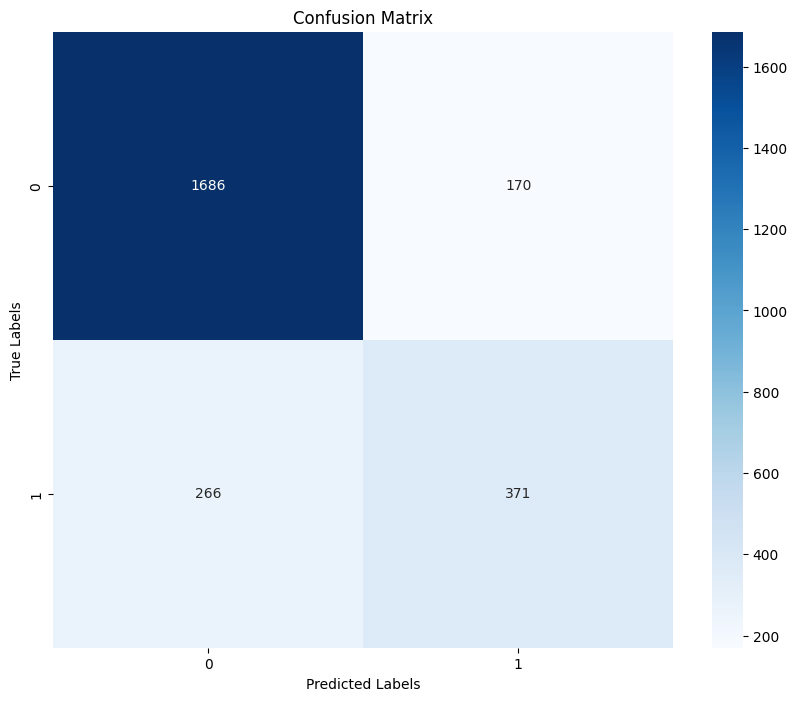

In [87]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

save_path = '/home/rishab/machine_learning/IASNLP/project/results/Multimodal_Cross_Attention/plots/confusion_matrix.png'

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()